In [1]:
import torch
from torch import nn
import numpy as np
import mdshare 
import mdtraj as md 
import glob
import torch.nn.functional as F
from ase import Atoms
from nglview import show_ase
import nglview as ng
import matplotlib.pyplot as plt


In [2]:
# build dataset and dataloader 
k = 10000
batch = 40

#langevin
data = np.load('NOSE_HOOVER_2/N_70.npy')
data_F = np.load('NOSE_HOOVER_2/N_70_F.npy')

train_xyz = torch.Tensor(data[:k])
train_f   = torch.Tensor(data_F[:k]).reshape(int(k/batch), batch, 70, 3)

test_xyz  = torch.Tensor(data[k:])
test_f    = torch.Tensor(data_F[k:])


trainset = torch.utils.data.TensorDataset(train_xyz)
#testset  = torch.utils.data.TensorDataset(test_xyz)

#trainset_f = torch.utils.data.TensorDataset(train_f)
#testset_f  = torch.utils.data.TensorDataset(test_f)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
#testloader  = torch.utils.data.DataLoader(testset,  batch_size=25, shuffle=True)

#trainloader_f = torch.utils.data.DataLoader(trainset_f, batch_size=40, shuffle=True)
#testloader_f  = torch.utils.data.DataLoader(testset_f,  batch_size=25, shuffle=True)

In [3]:
# define a CGAE

class cgae(nn.Module):
    
    def __init__(self, n_atoms, n_cgs):
        super().__init__()

        assign_map = torch.randn(n_atoms, n_cgs)
        decode = torch.randn(n_cgs, n_atoms)
        
        
        self.n_atoms = n_atoms 
        self.assign_map = nn.Parameter(assign_map)
        self.decode = nn.Parameter(decode)
        
    def forward(self, xyz, tau=1.0):
        
        # recenter coordinates 
        xyz = xyz.reshape(-1, self.n_atoms, 3)
        shift = xyz.mean(1)
        xyz = xyz - shift.unsqueeze(1)
        
        # get discrete assignment map
        M = F.gumbel_softmax(self.assign_map, dim=-1)
        M_norm = M / M.sum(-2).unsqueeze(-2)
        
        cg_xyz = torch.einsum('bij,in->bnj', xyz, M_norm)
        xyz_recon = torch.einsum('bnj,ni->bij', cg_xyz, self.decode)
        
        return xyz, xyz_recon, M, M_norm, cg_xyz

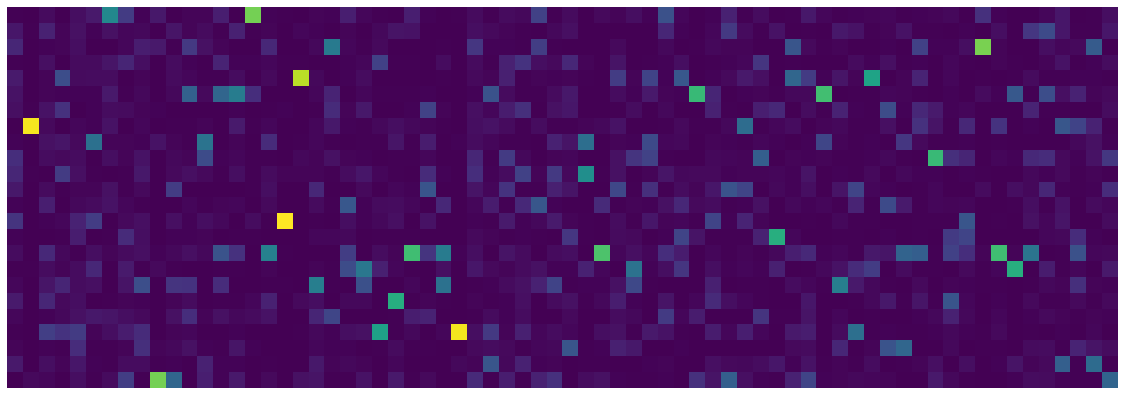

24 0 0.999 85.03519654273987


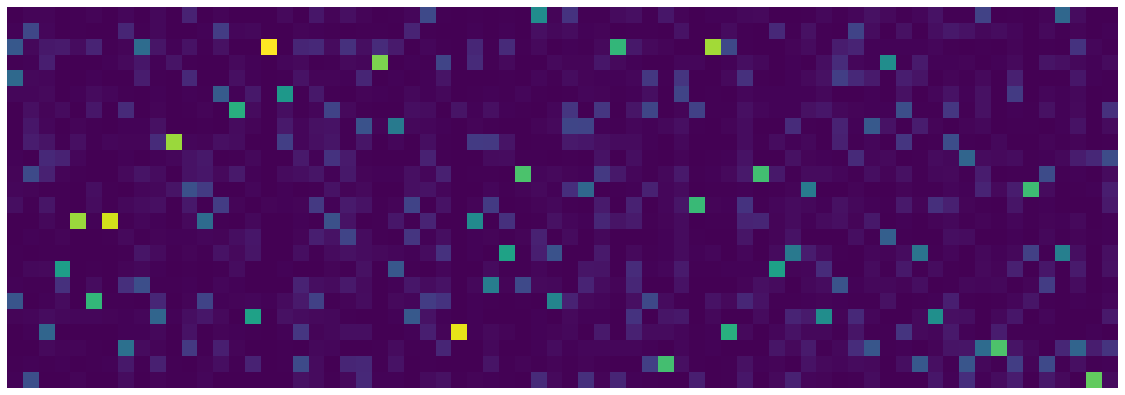

24 1 0.998 46.90916598439217


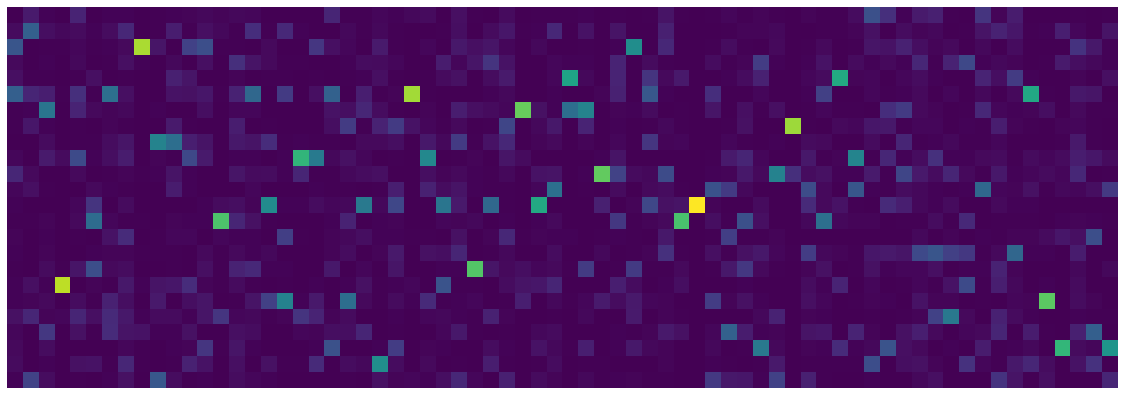

24 2 0.997 27.319461870193482


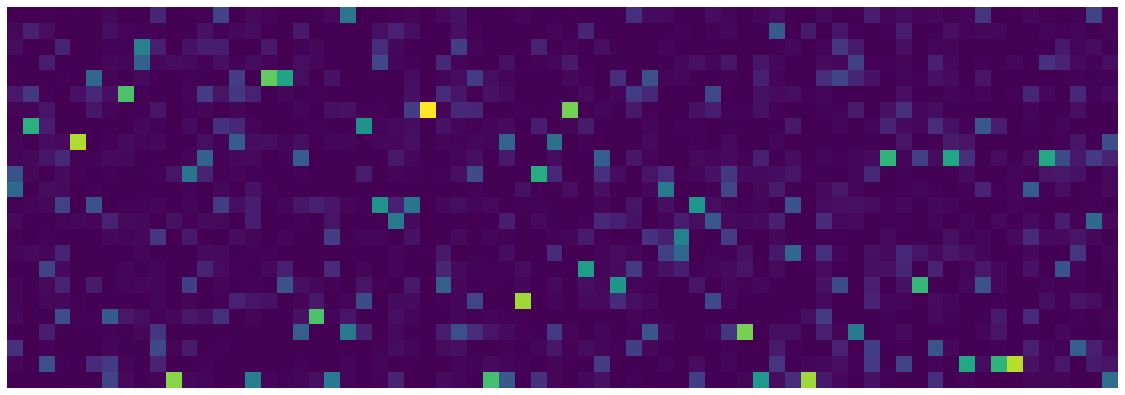

24 3 0.996 17.90093402862549


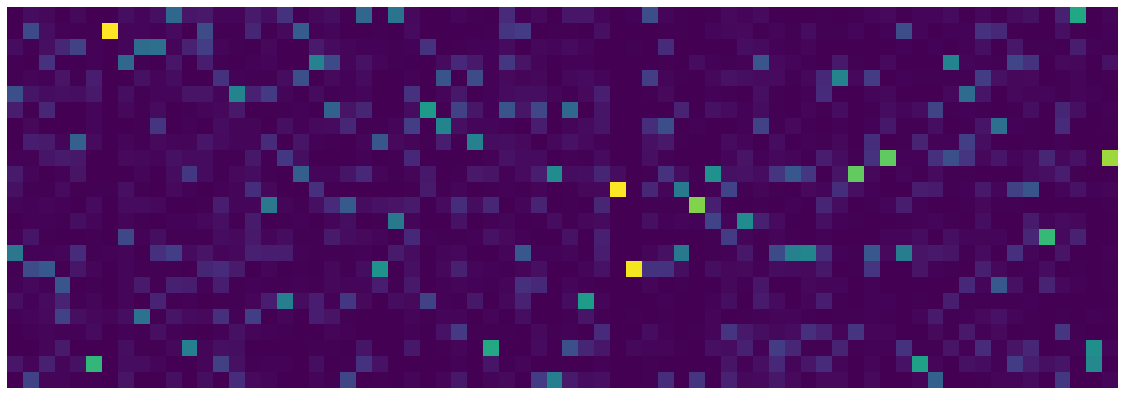

24 4 0.995 13.113076424598693


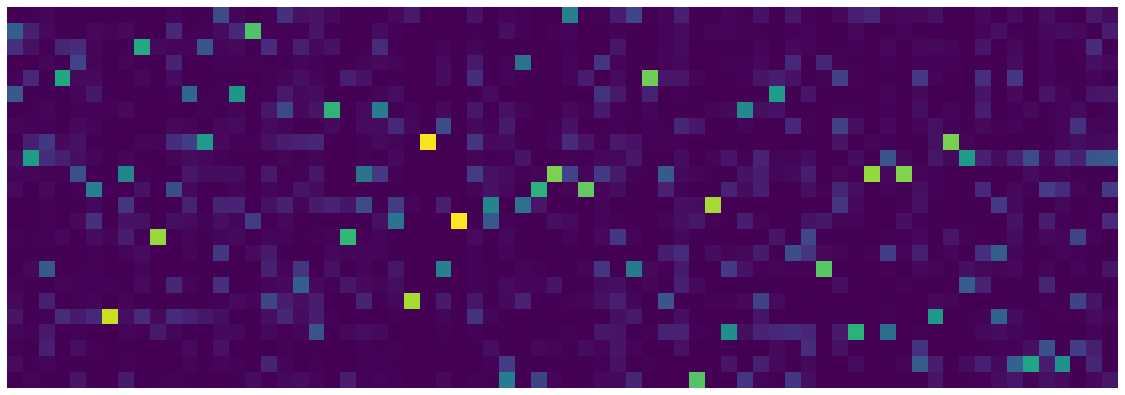

24 5 0.994 10.530500397086143


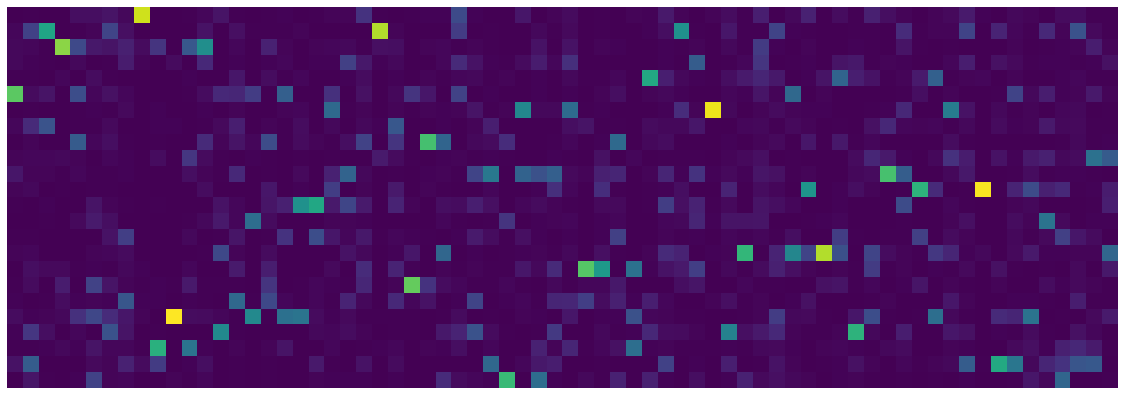

24 6 0.993 8.519738681614399


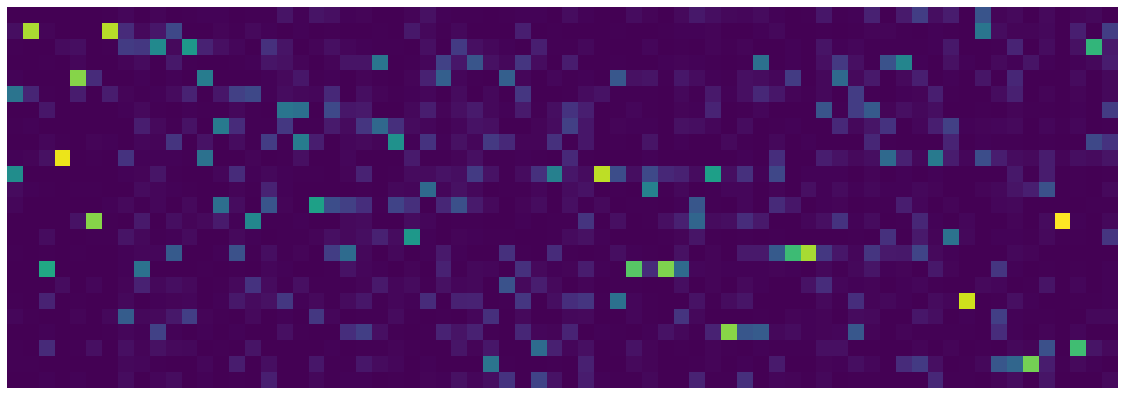

24 7 0.992 7.598780344426632


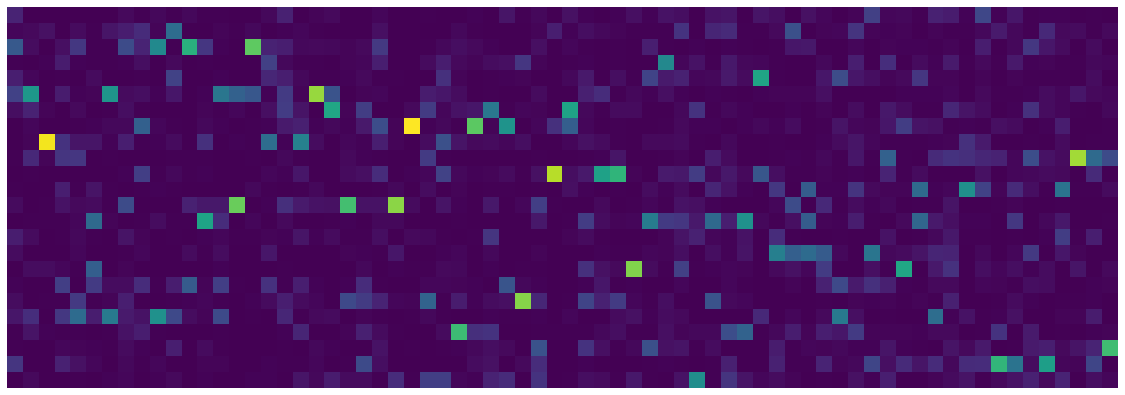

24 8 0.991 6.841982319951057


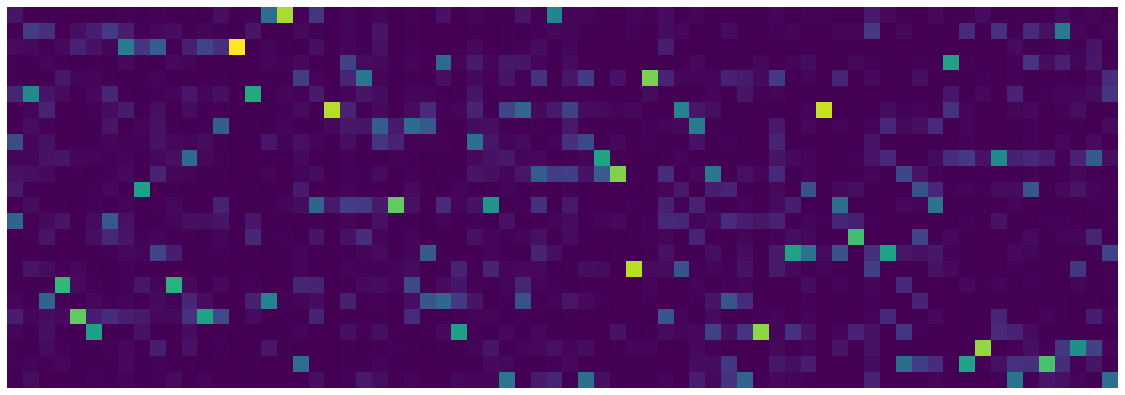

24 9 0.99 6.164359290897846


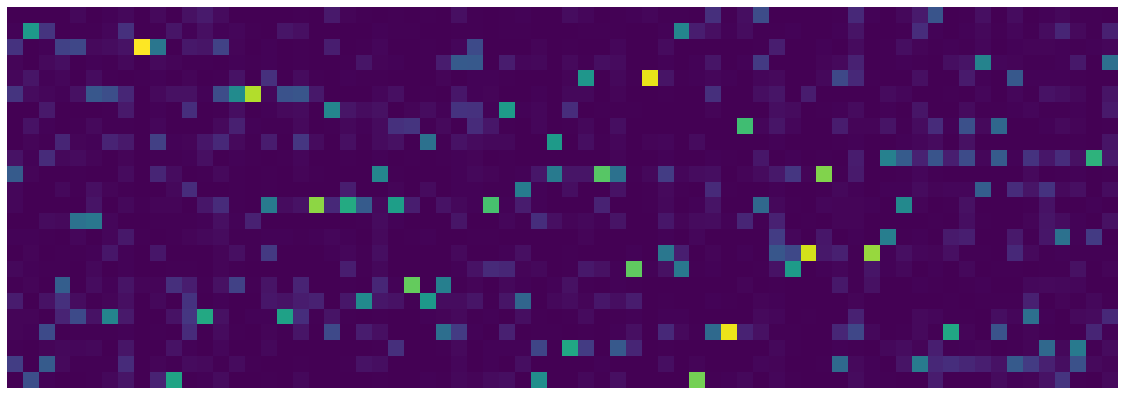

24 10 0.989 5.691221755743027


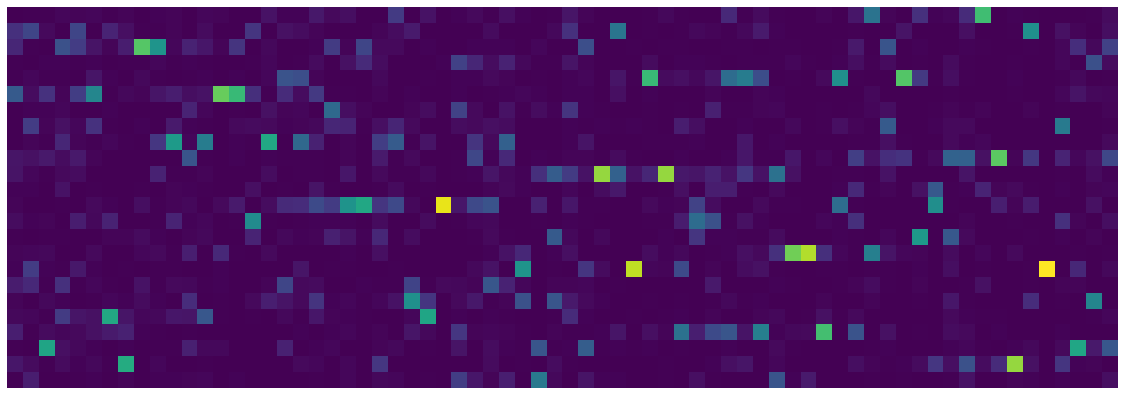

24 11 0.988 5.1552370369434355


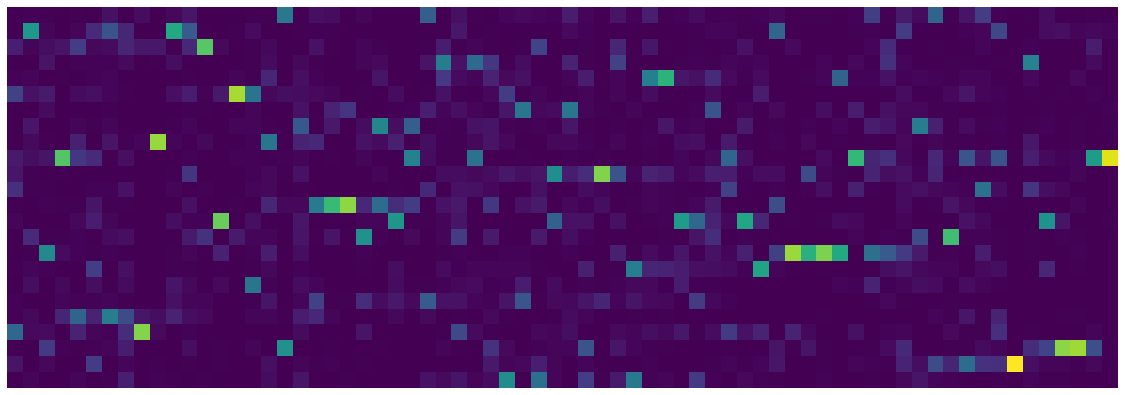

24 12 0.987 4.640271228551865


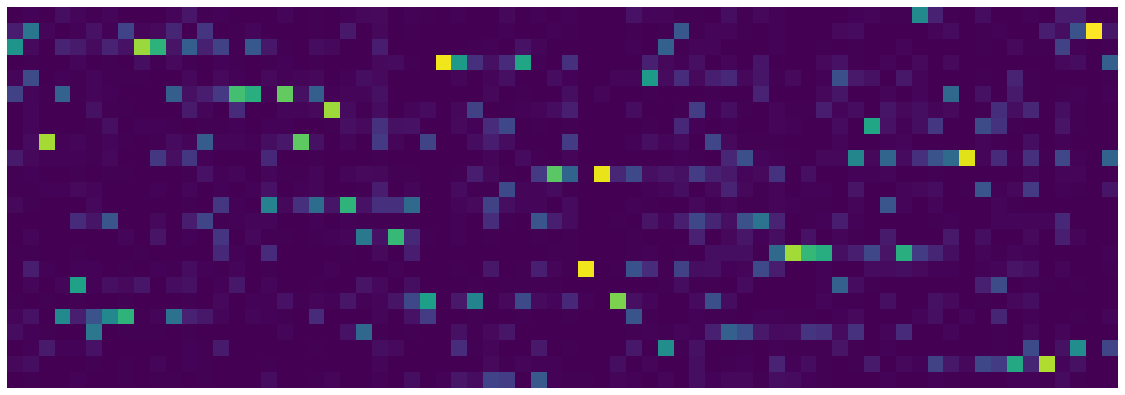

24 13 0.986 4.2390007600188255


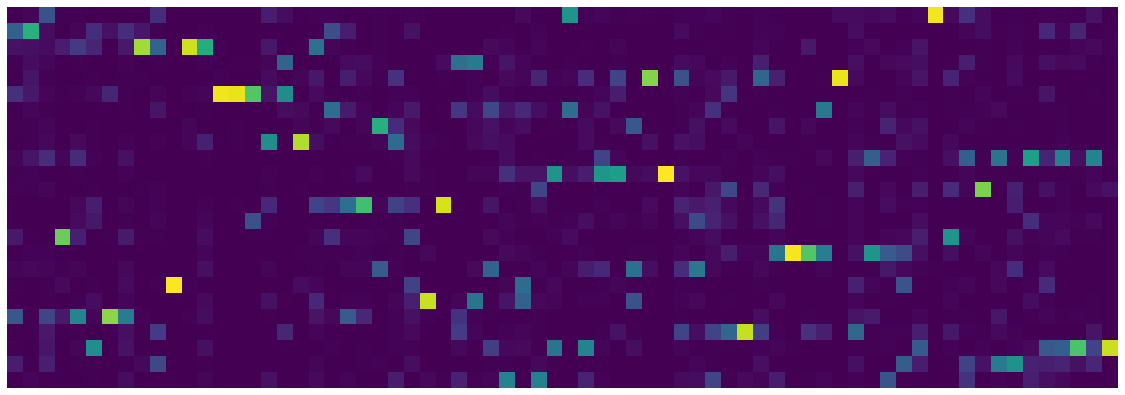

24 14 0.985 3.7989439509809015


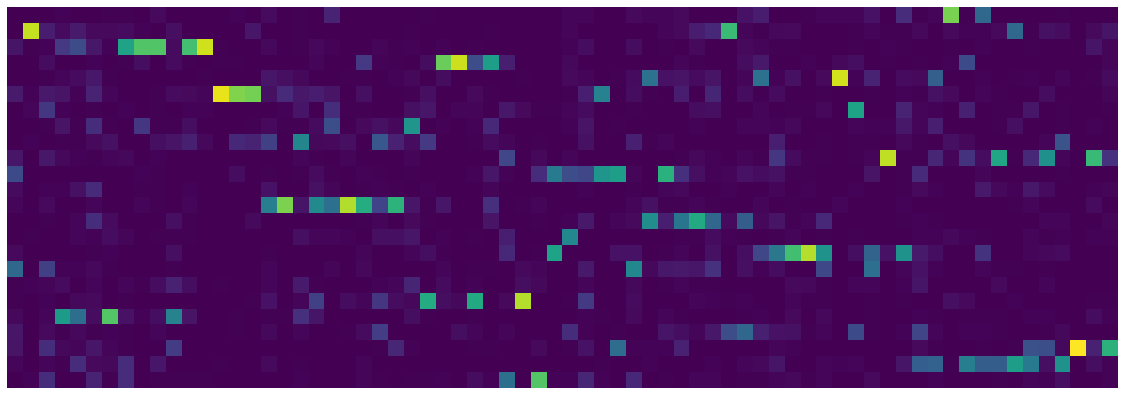

24 15 0.984 3.4933782033622265


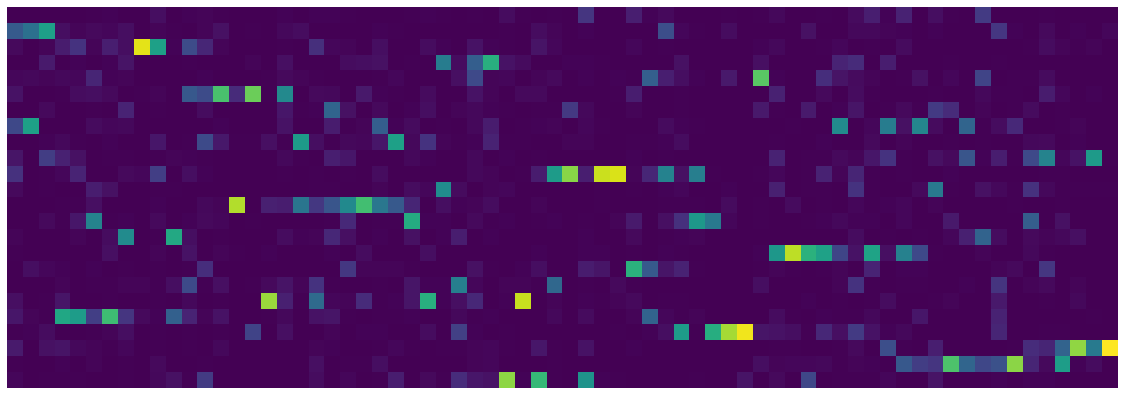

24 16 0.983 3.1114496521651747


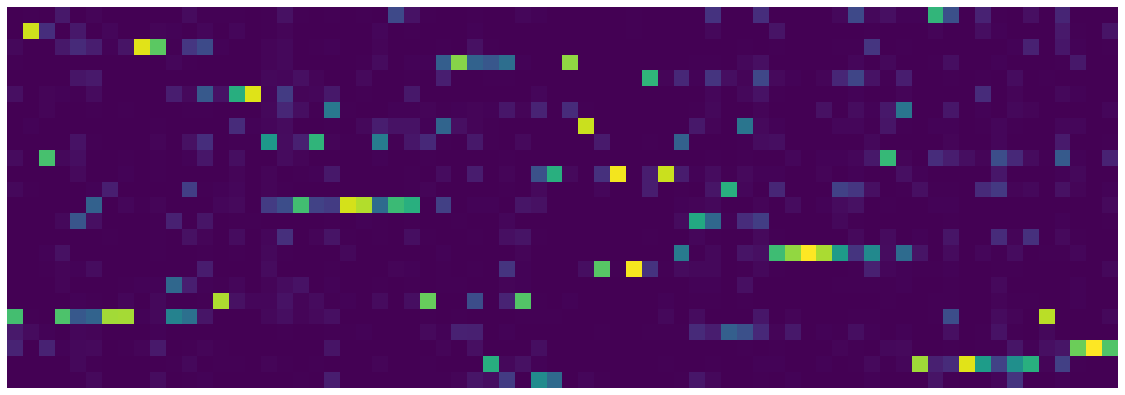

24 17 0.982 2.852586680650711


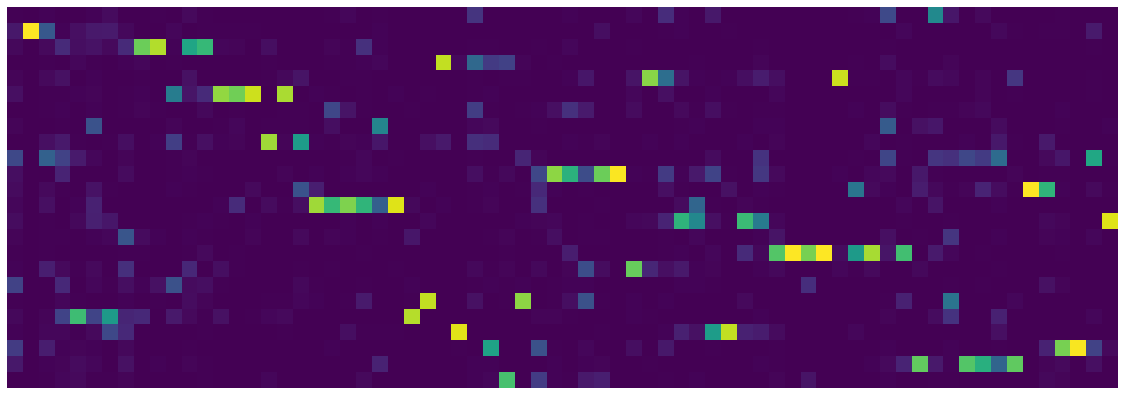

24 18 0.981 2.608865305036306


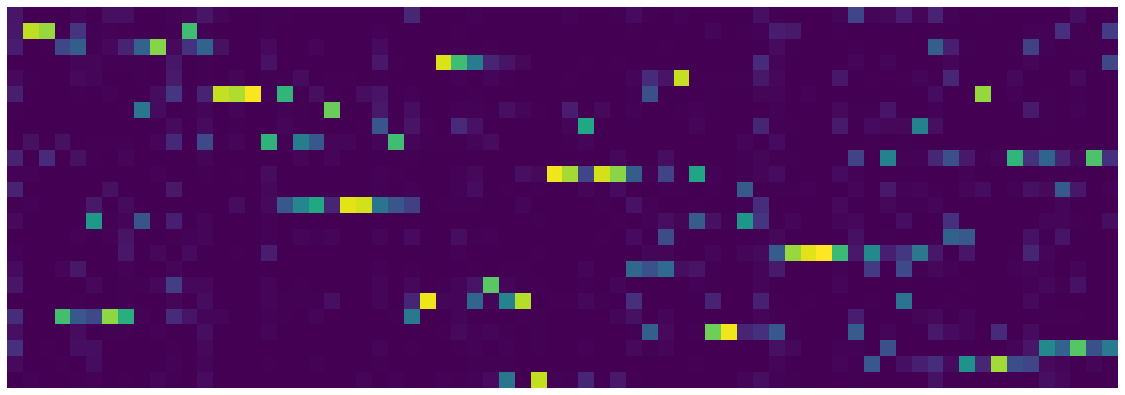

24 19 0.98 2.400050289928913


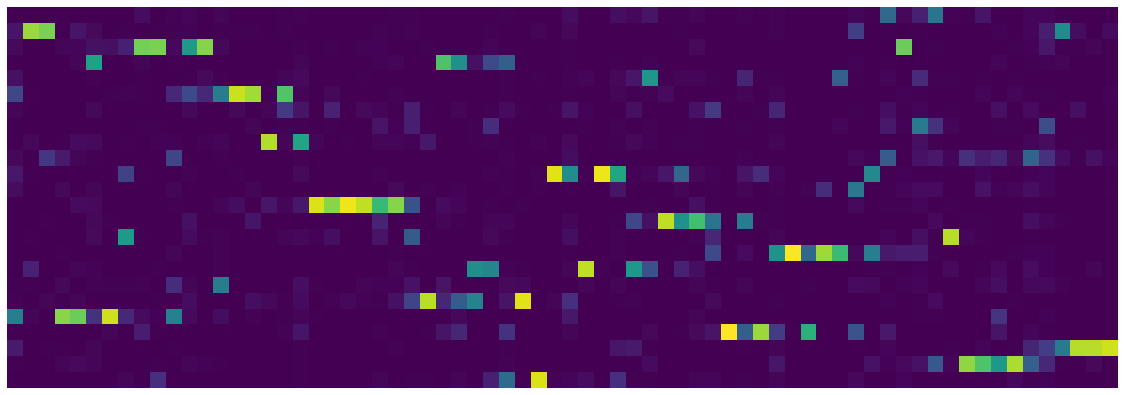

24 20 0.979 2.208003719896078


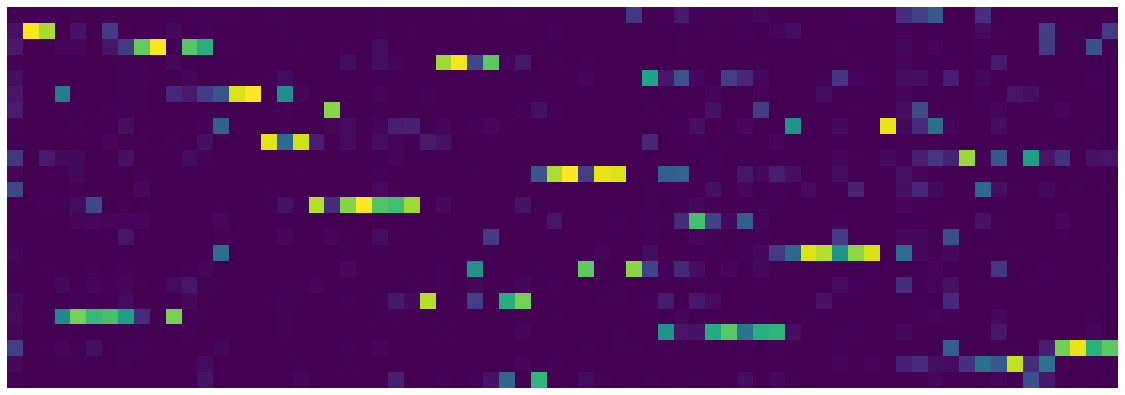

24 21 0.978 2.011717498674989


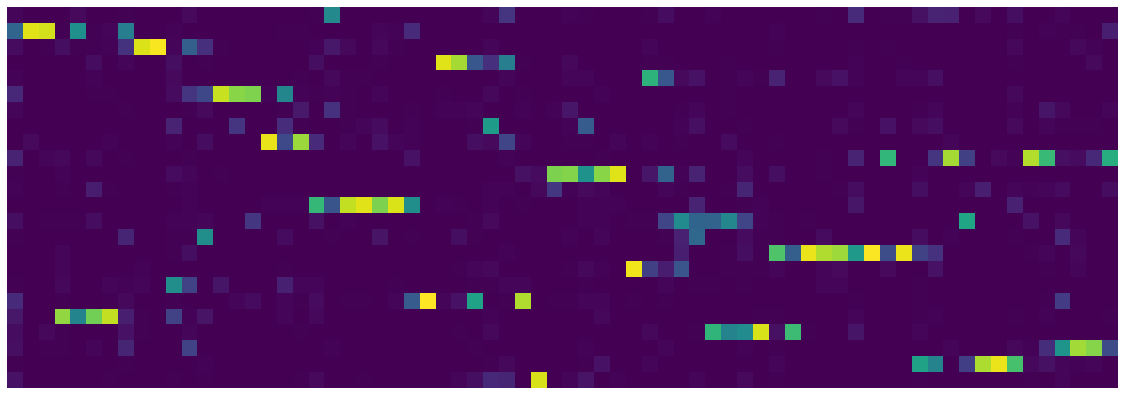

24 22 0.977 1.8641196921467782


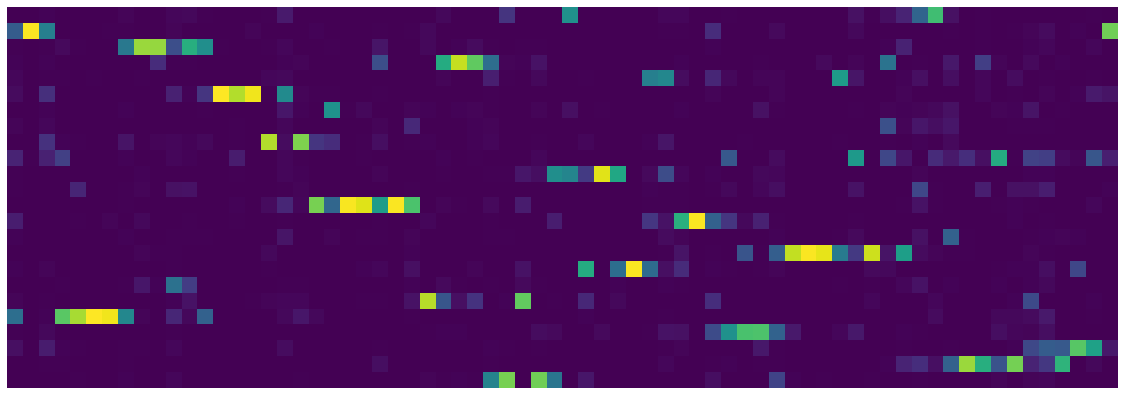

24 23 0.976 1.7384033132344485


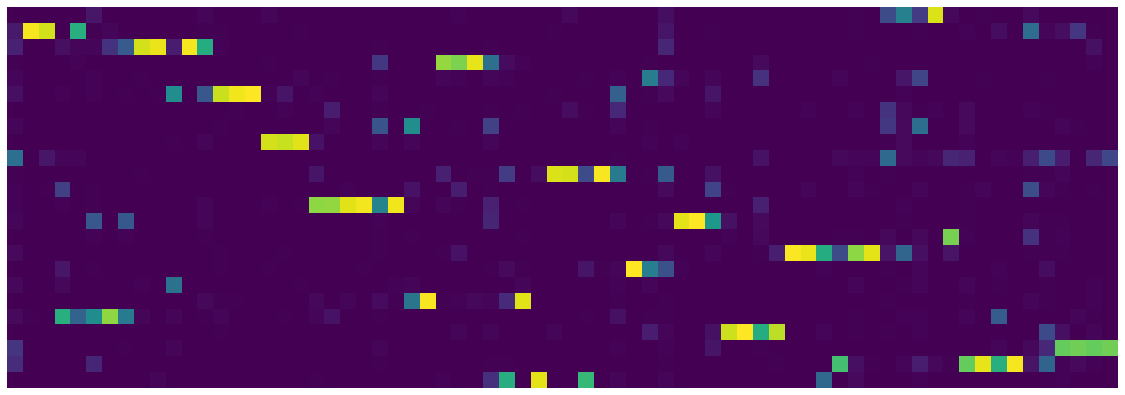

24 24 0.975 1.5852516621351243


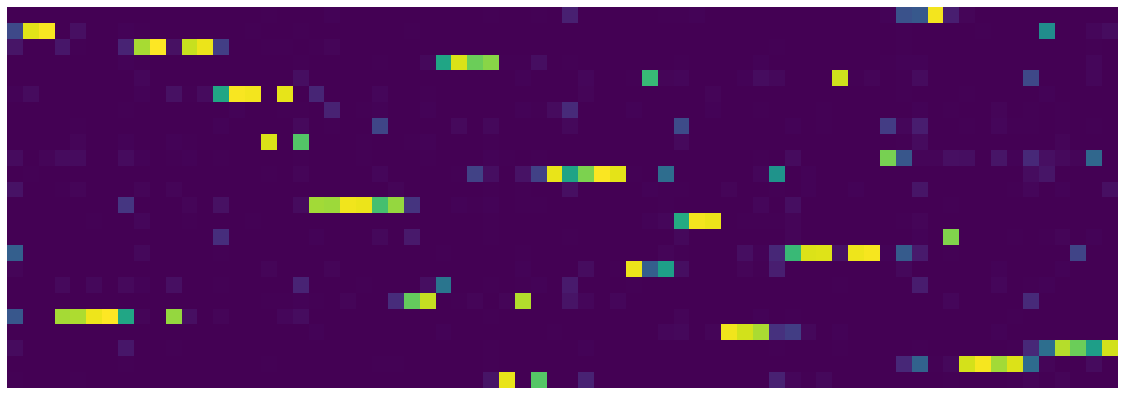

24 25 0.974 1.437878143787384


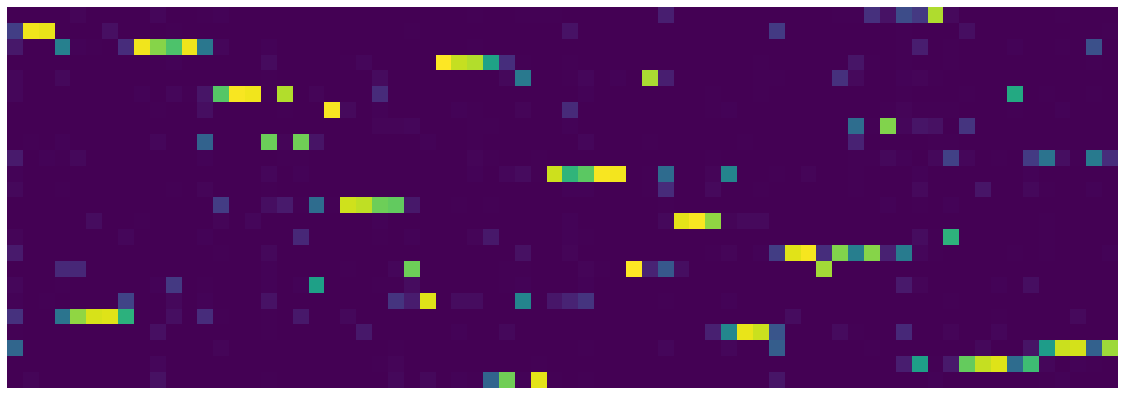

24 26 0.973 1.3527649734169245


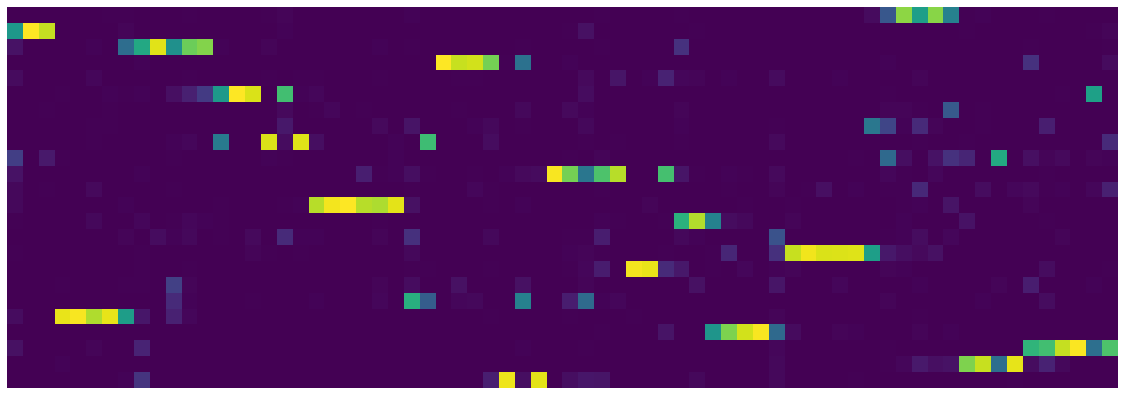

24 27 0.972 1.2517296202480792


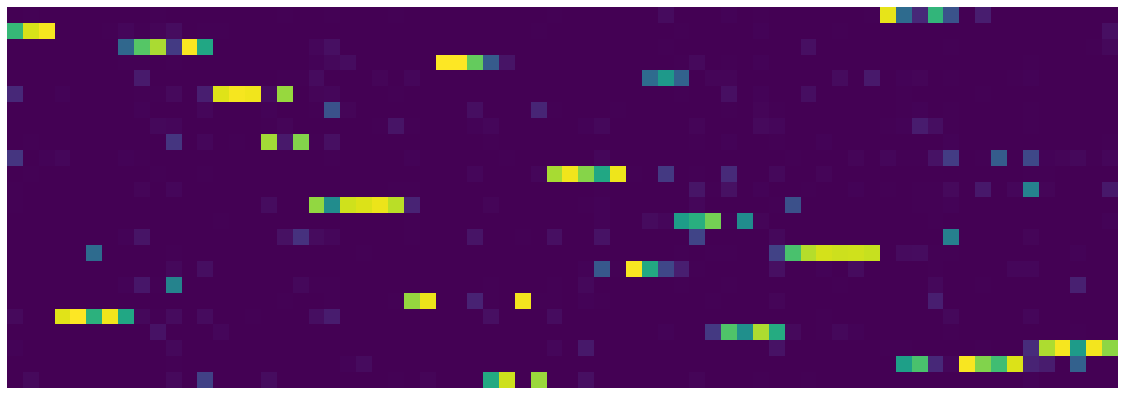

24 28 0.971 1.1814171012490988


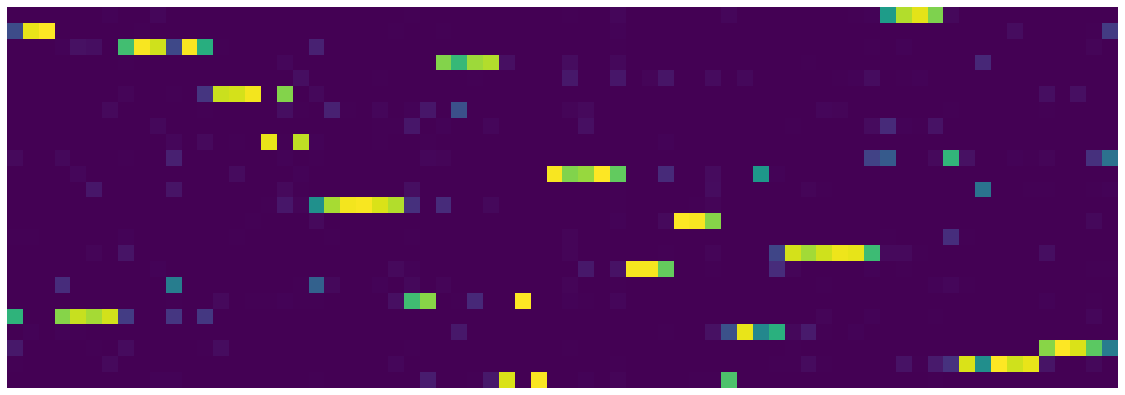

24 29 0.97 1.1236575443297625


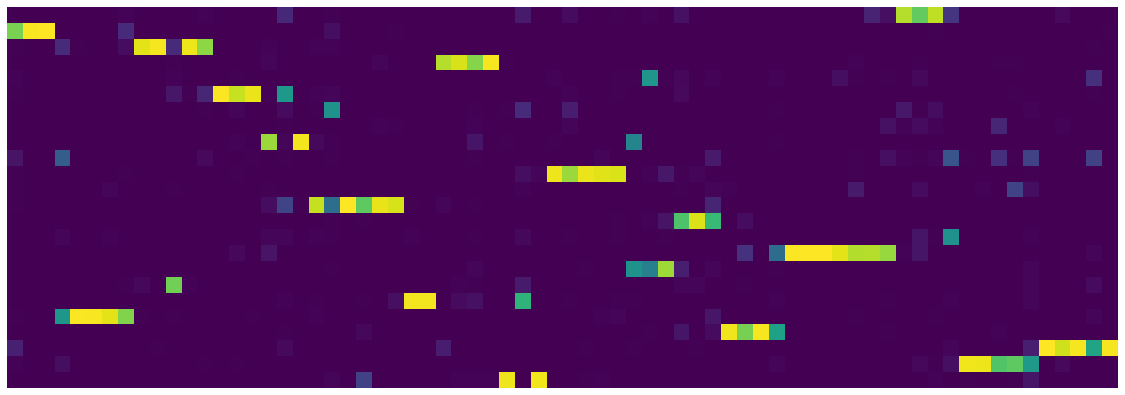

24 30 0.969 1.068153865635395


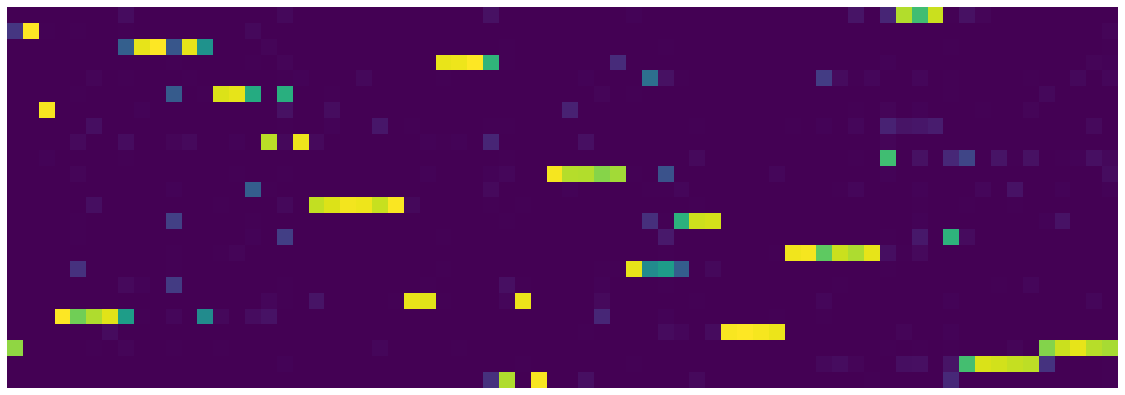

24 31 0.968 1.0205835342407226


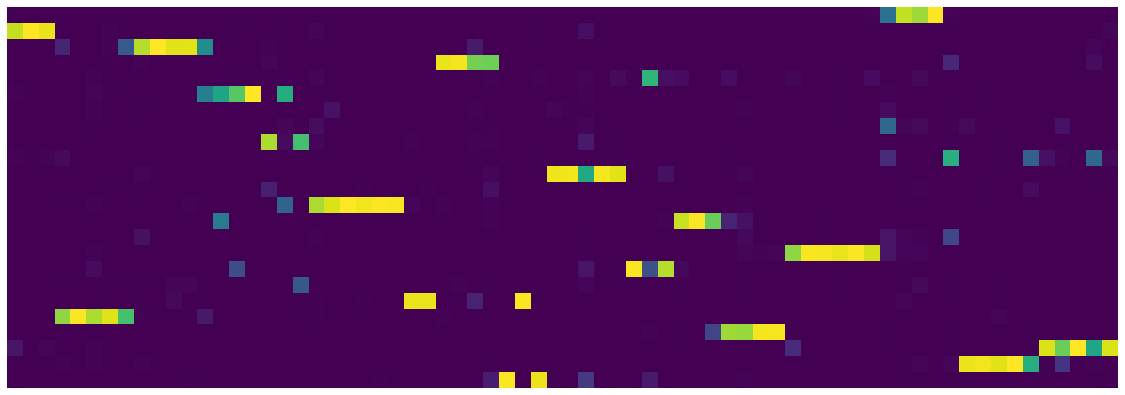

24 32 0.967 0.9705615639686584


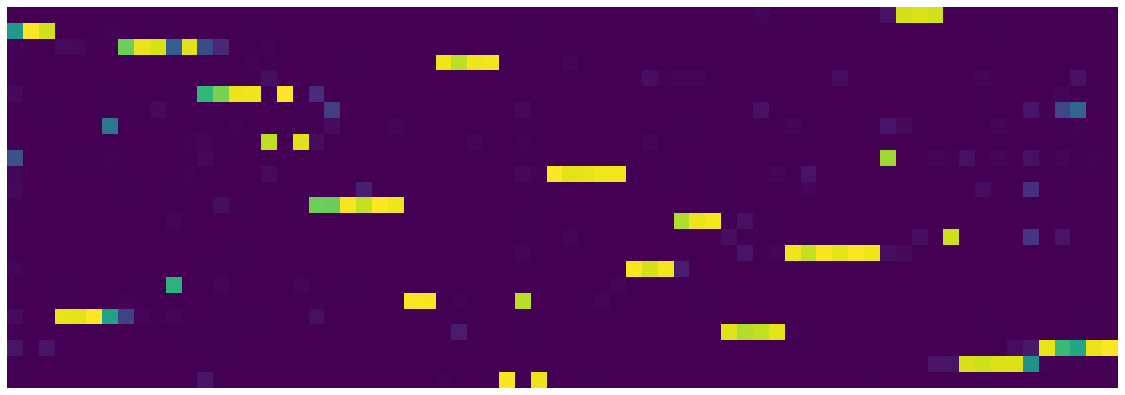

24 33 0.966 0.9278449553996324


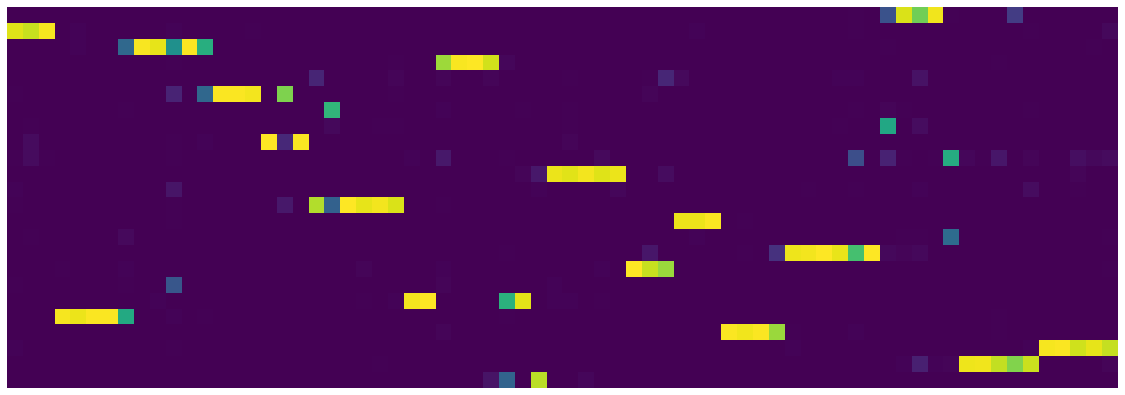

24 34 0.965 0.913712109066546


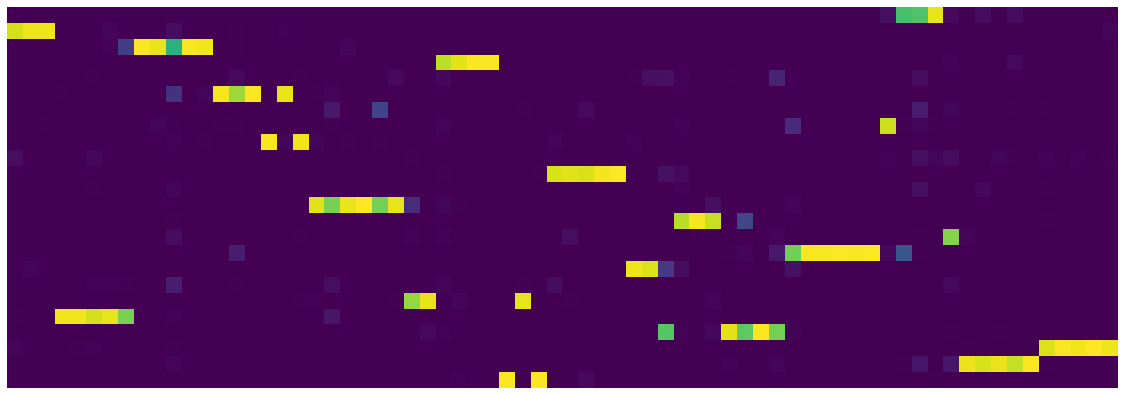

24 35 0.964 0.8690576342865824


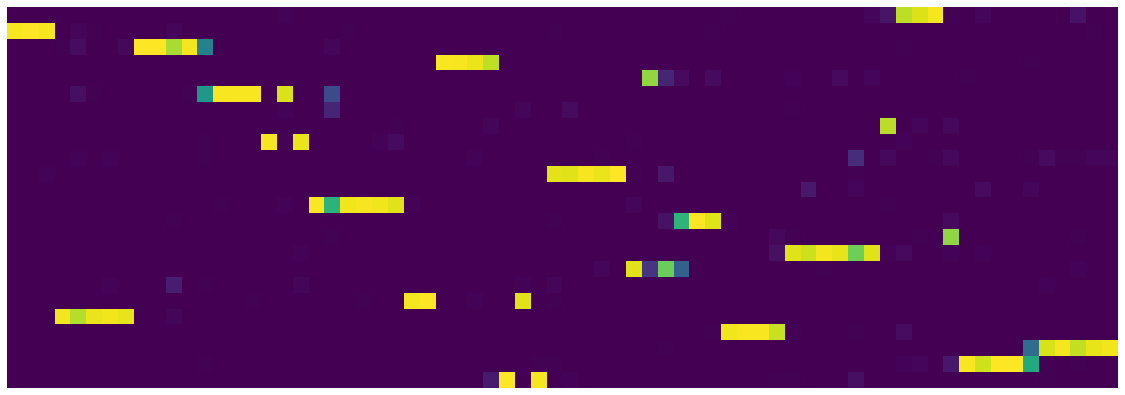

24 36 0.963 0.8544068075716496


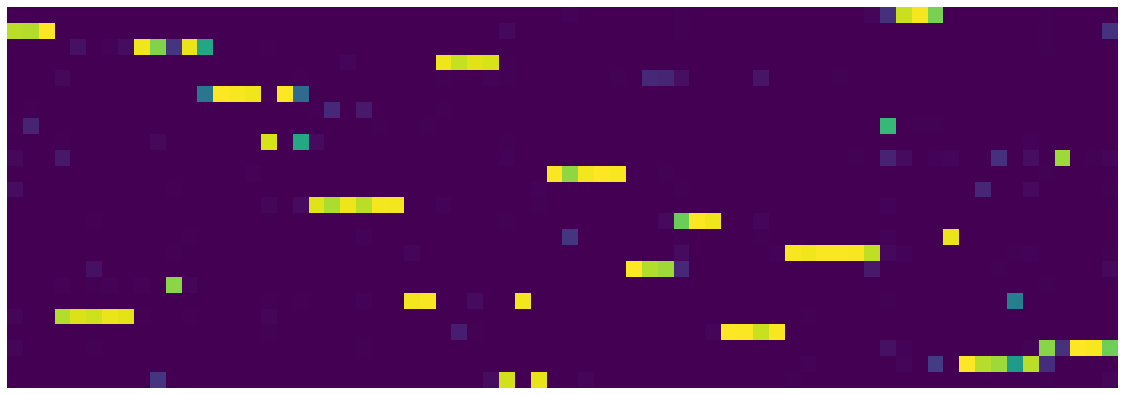

24 37 0.962 0.82238031309098


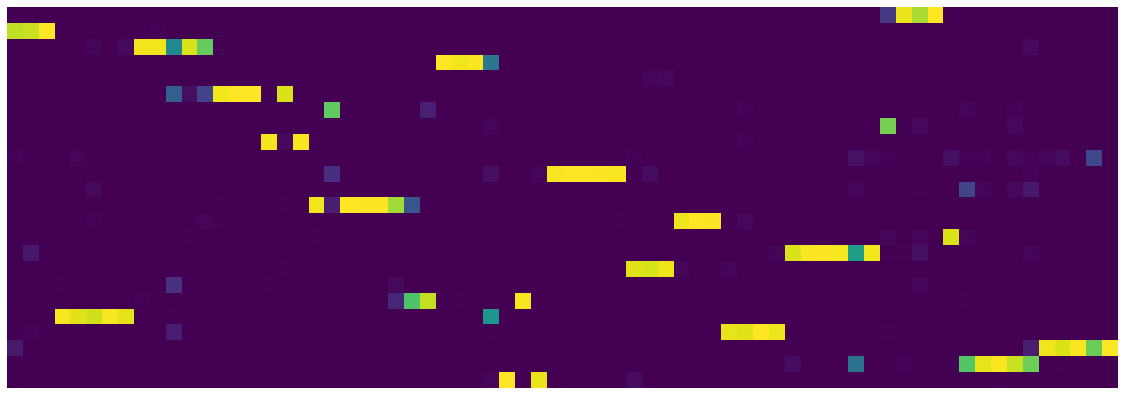

24 38 0.961 0.8167972650378943


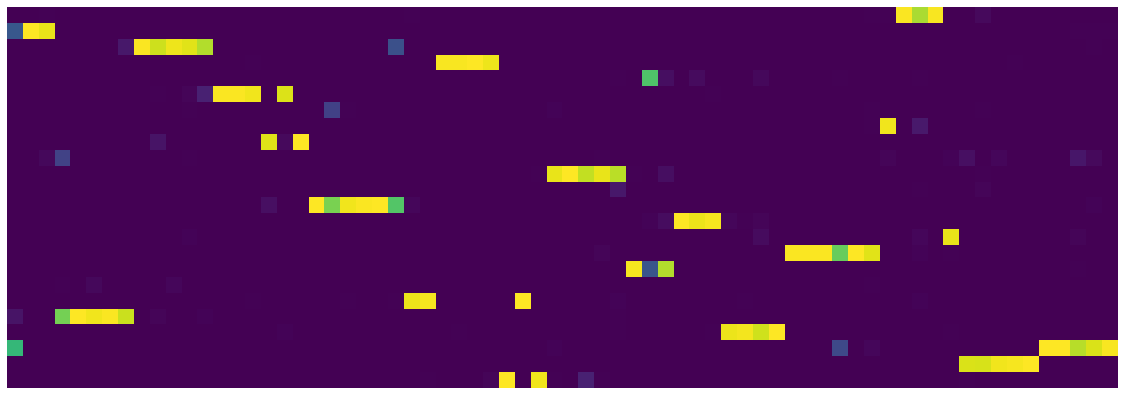

24 39 0.96 0.7979976454749703


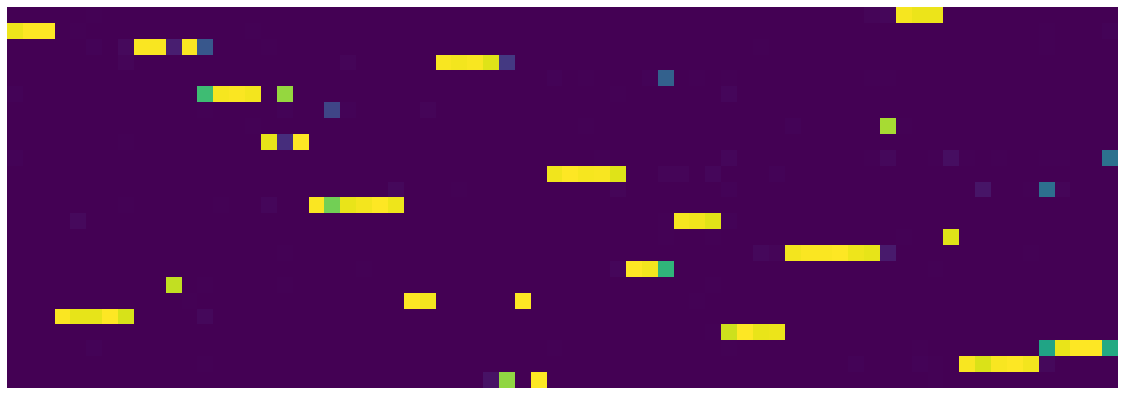

24 40 0.959 0.7810360122472048


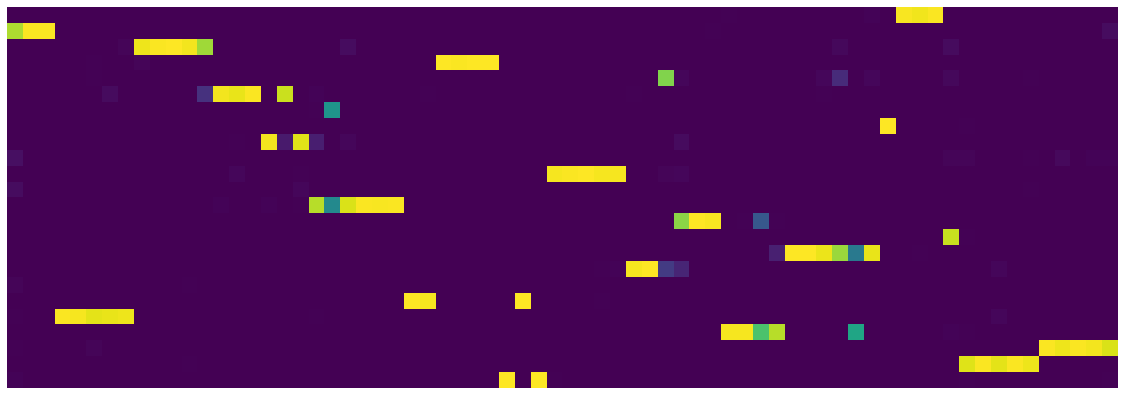

24 41 0.958 0.7673647452145815


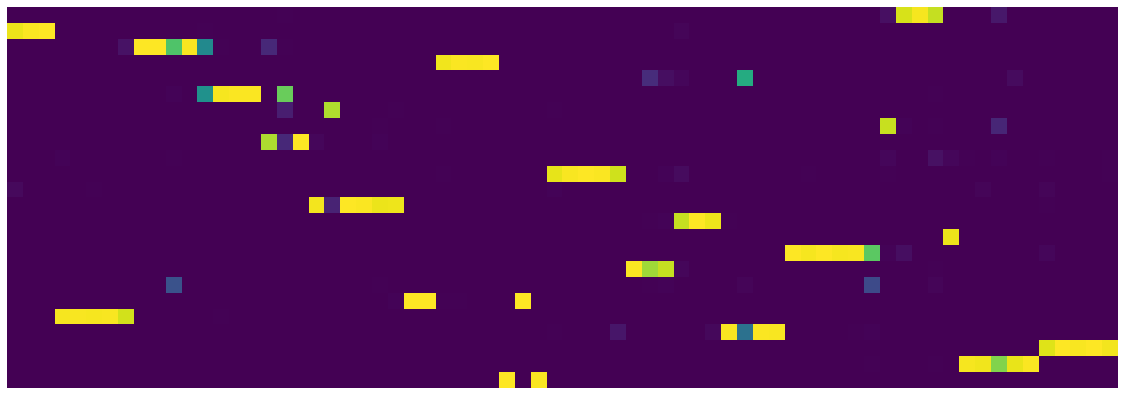

24 42 0.957 0.7516646264120936


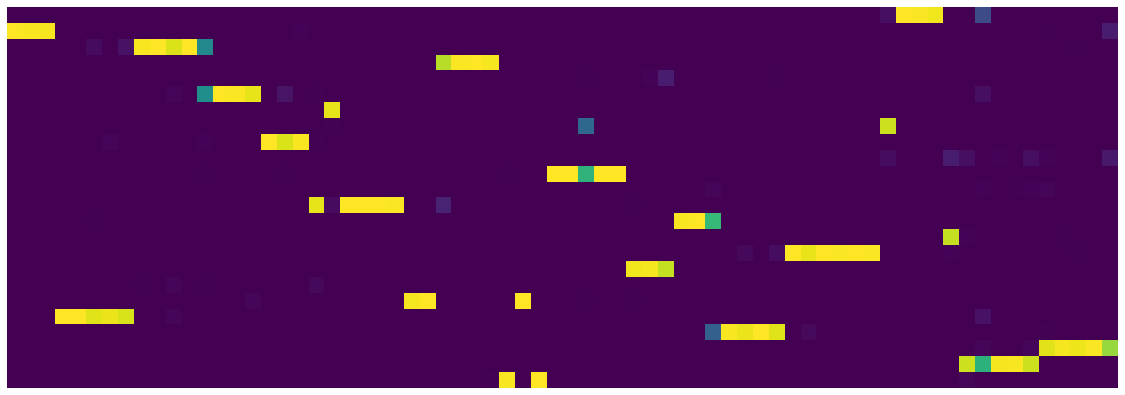

24 43 0.956 0.7261240687221289


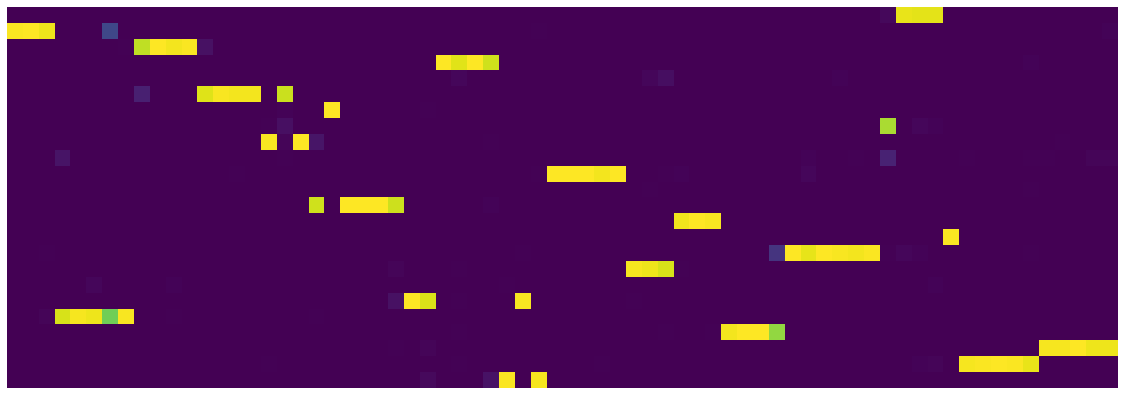

24 44 0.955 0.7236594146117568


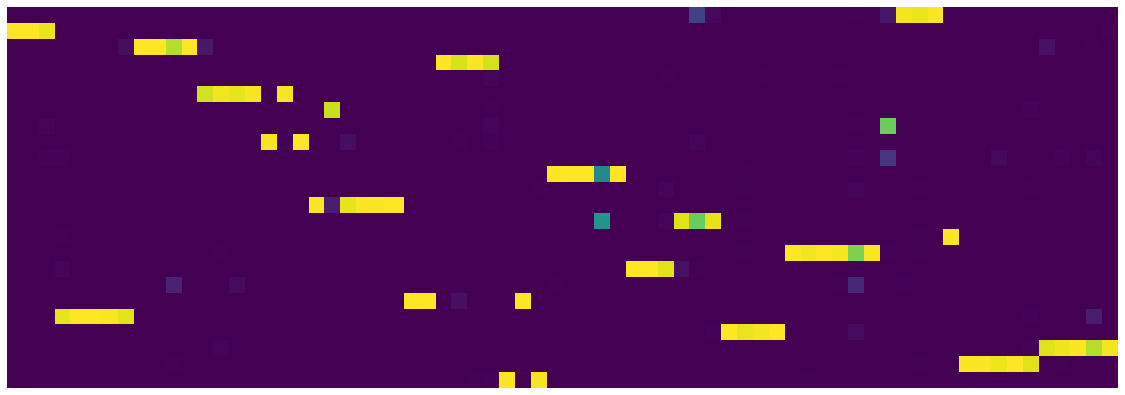

24 45 0.954 0.7070801796391606


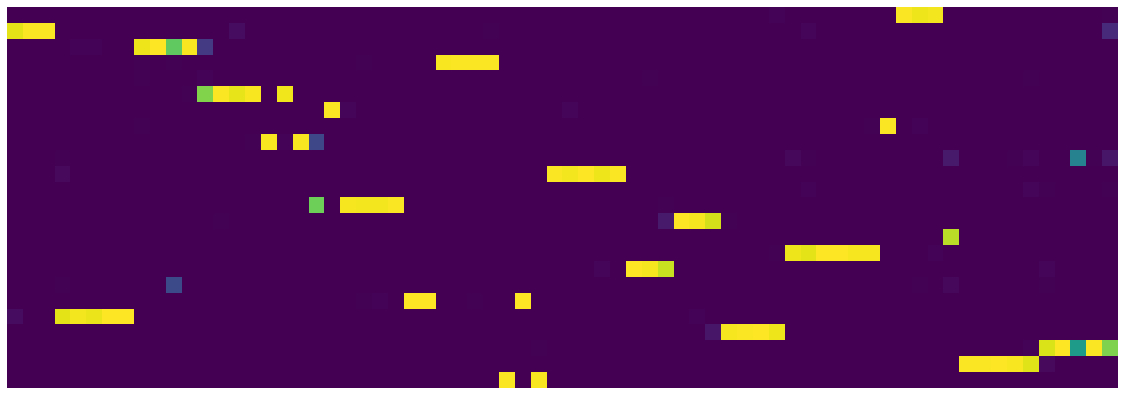

24 46 0.953 0.698178430646658


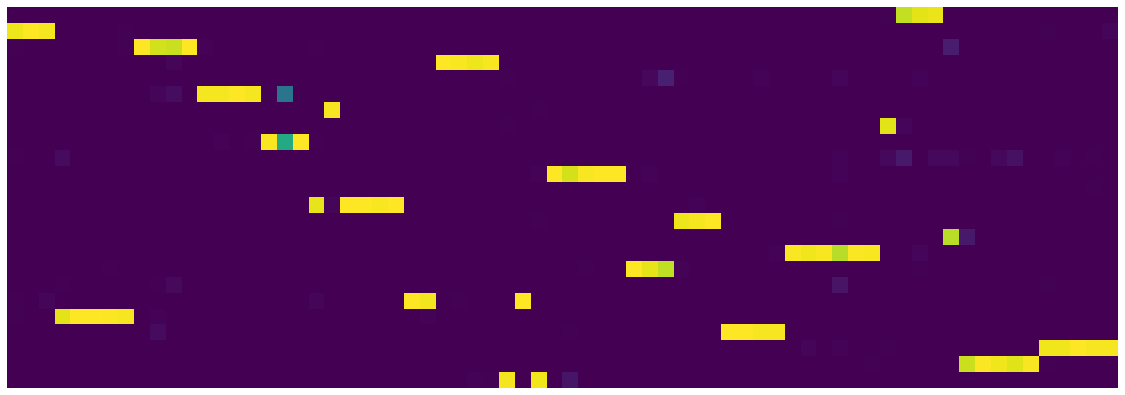

24 47 0.952 0.7075116075575352


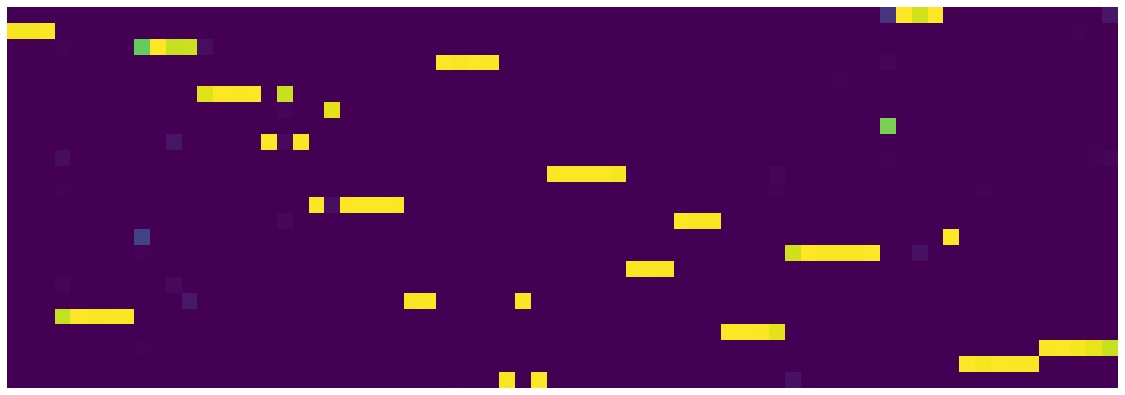

24 48 0.951 0.6942538823932409


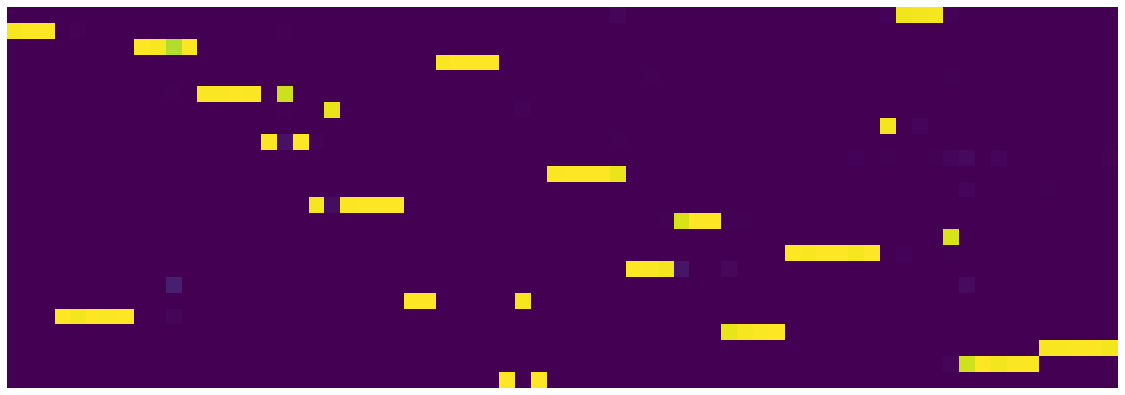

24 49 0.95 0.7027570715174078


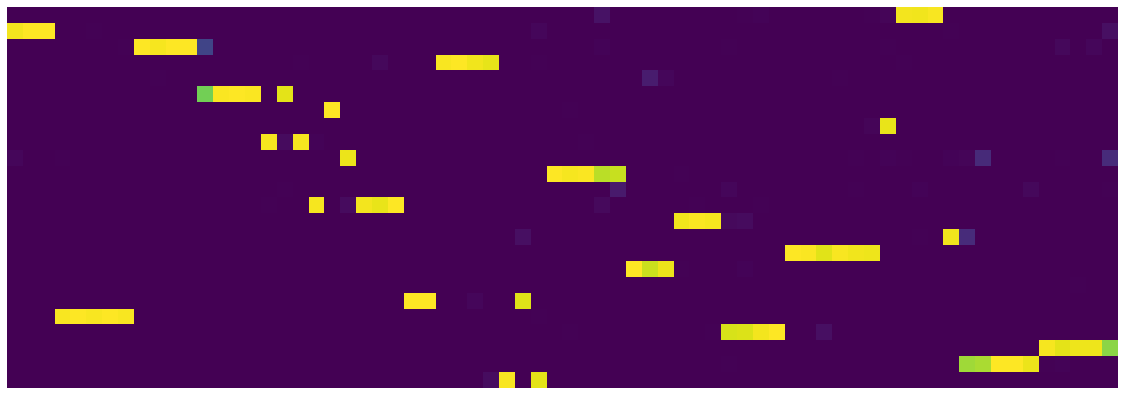

24 50 0.949 0.6902614699676632


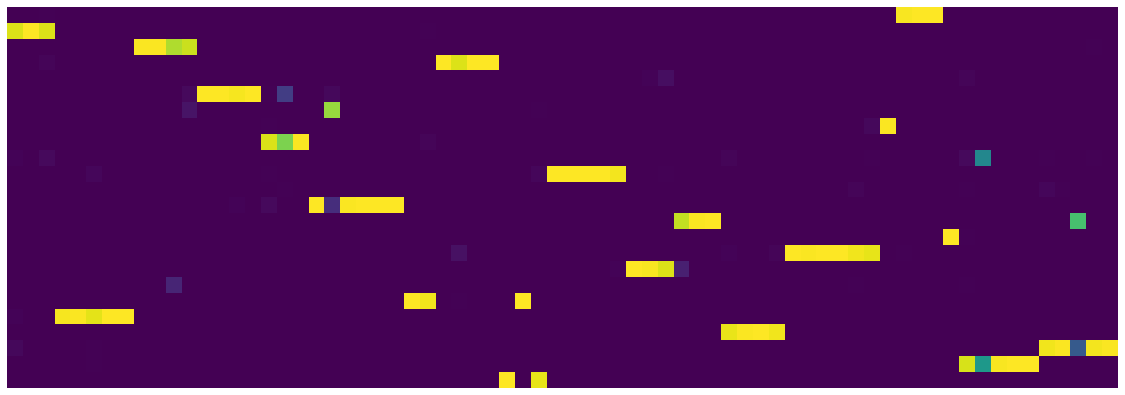

24 51 0.948 0.6878420066088438


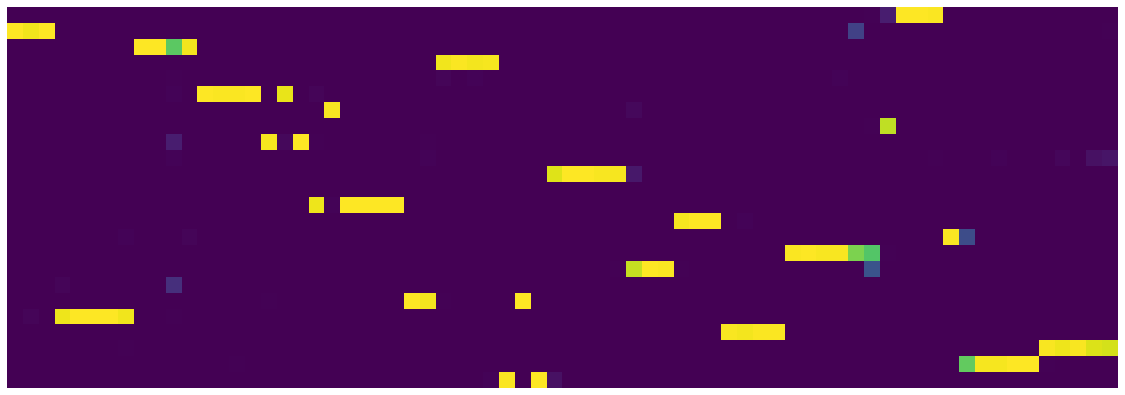

24 52 0.947 0.6946876589208841


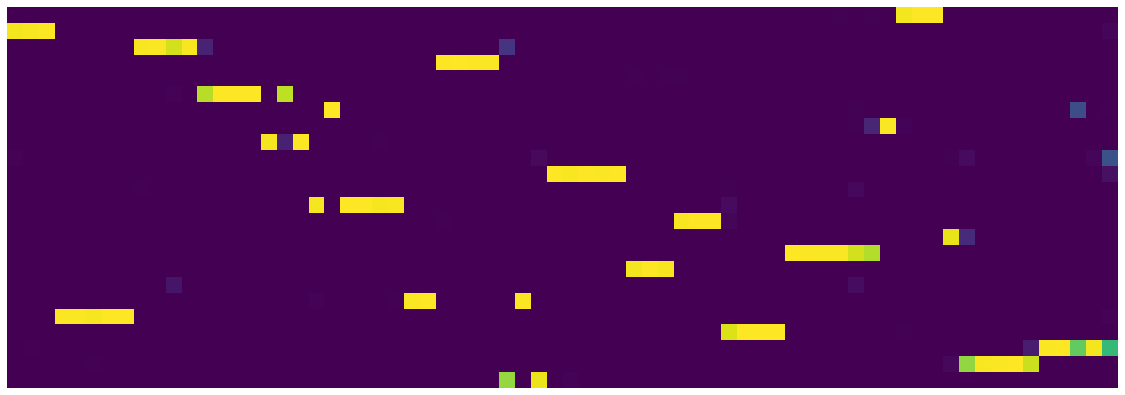

24 53 0.946 0.6775780491530895


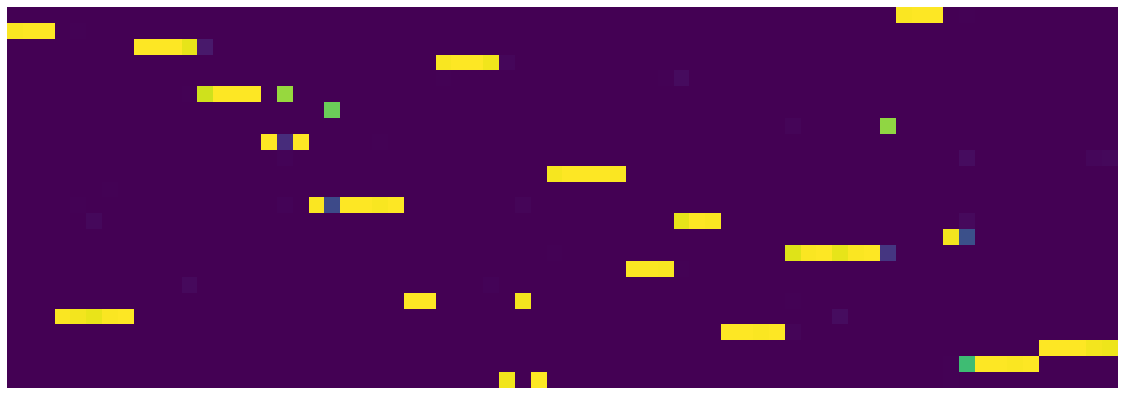

24 54 0.945 0.6691496776416898


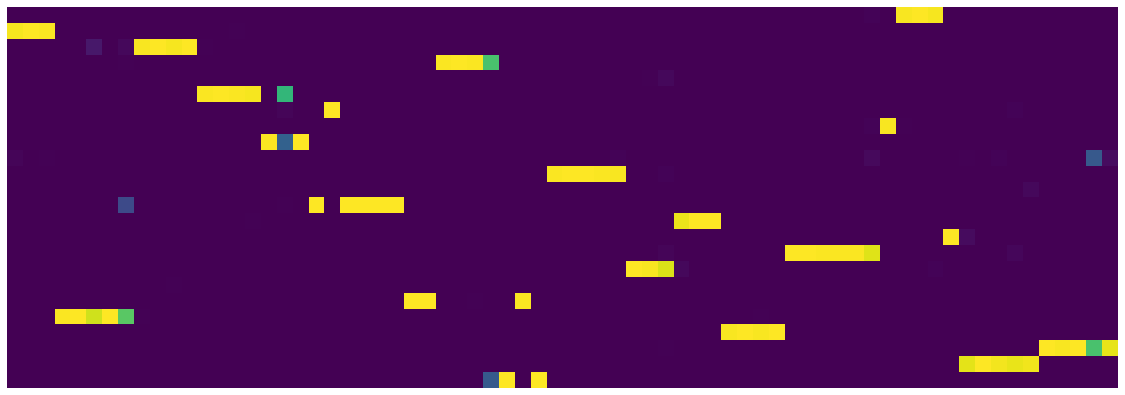

24 55 0.944 0.663632620871067


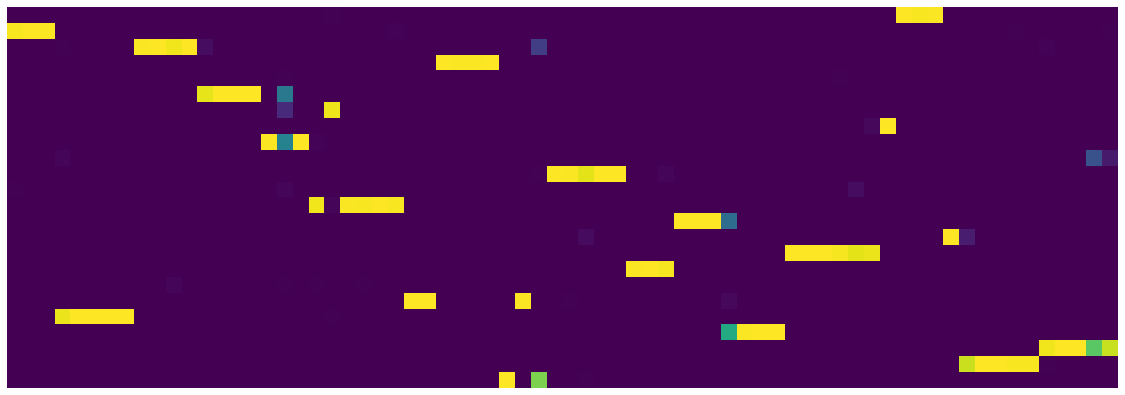

24 56 0.943 0.6572959864512086


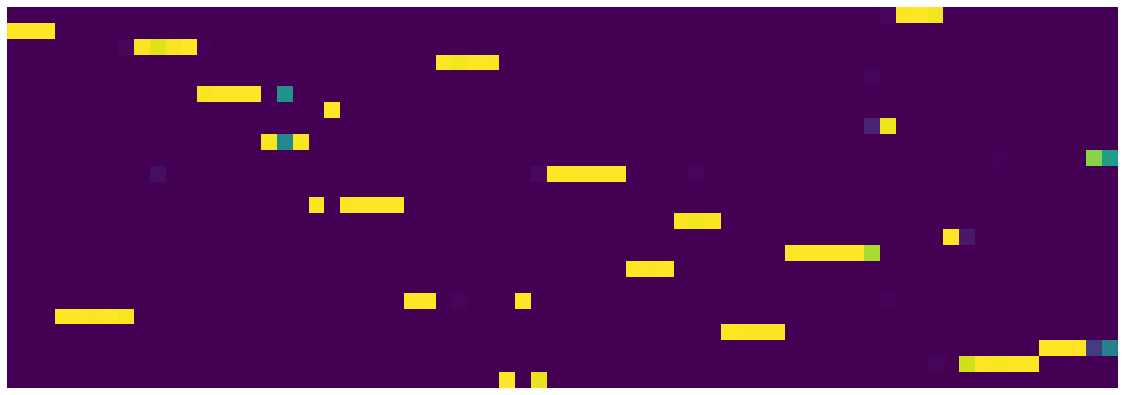

24 57 0.942 0.6537961401045322


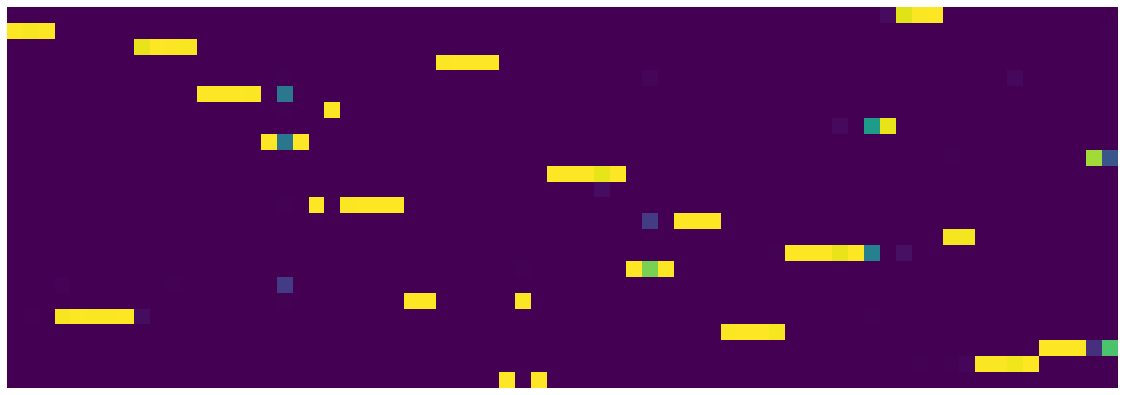

24 58 0.941 0.6402200976386666


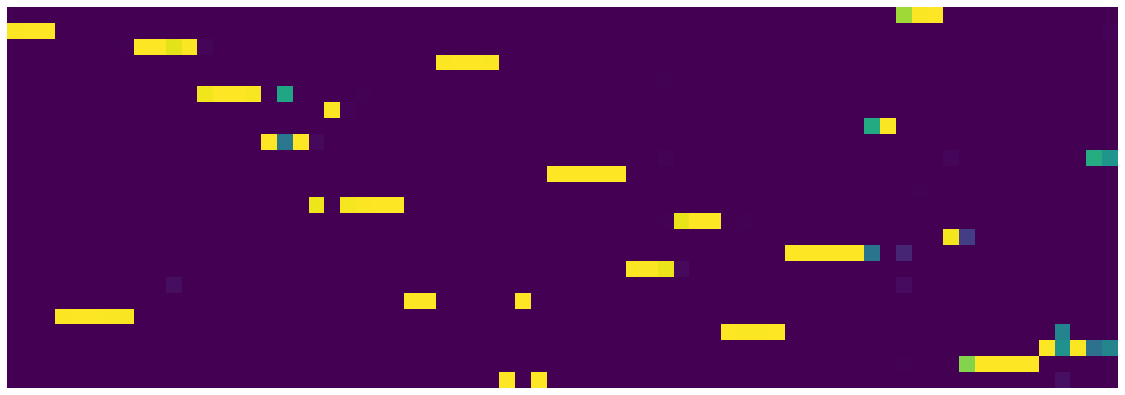

24 59 0.94 0.6283843891695142


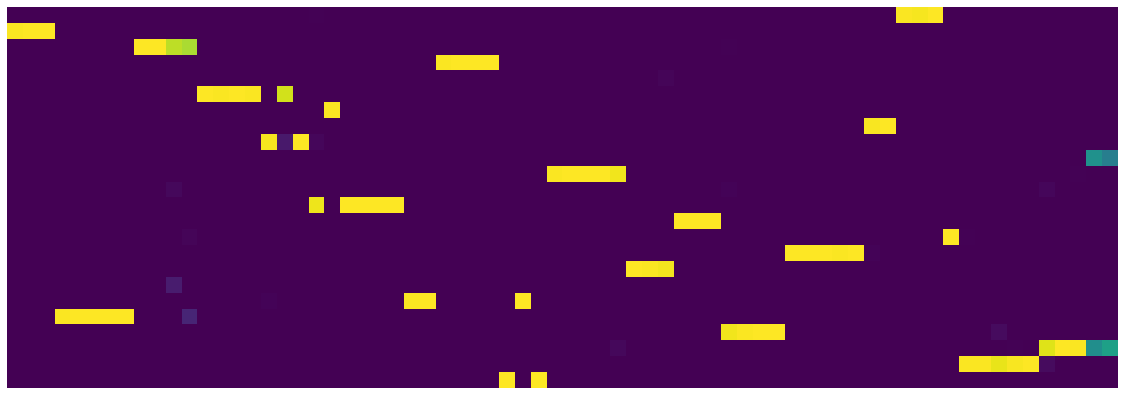

24 60 0.939 0.625502248108387


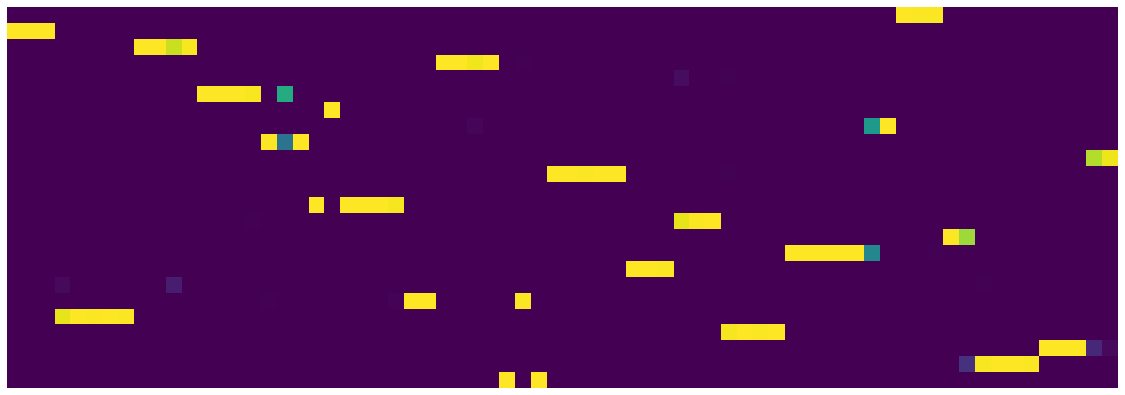

24 61 0.938 0.6151922220364213


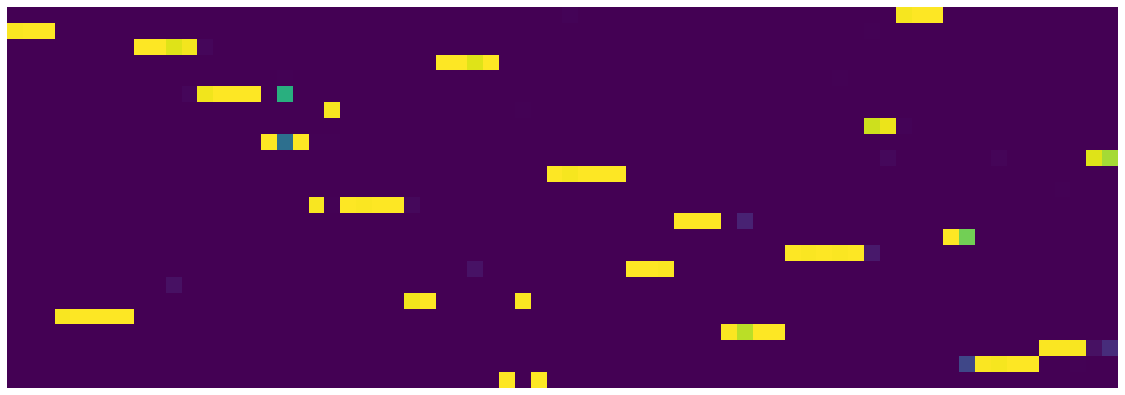

24 62 0.9369999999999999 0.6077700465917587


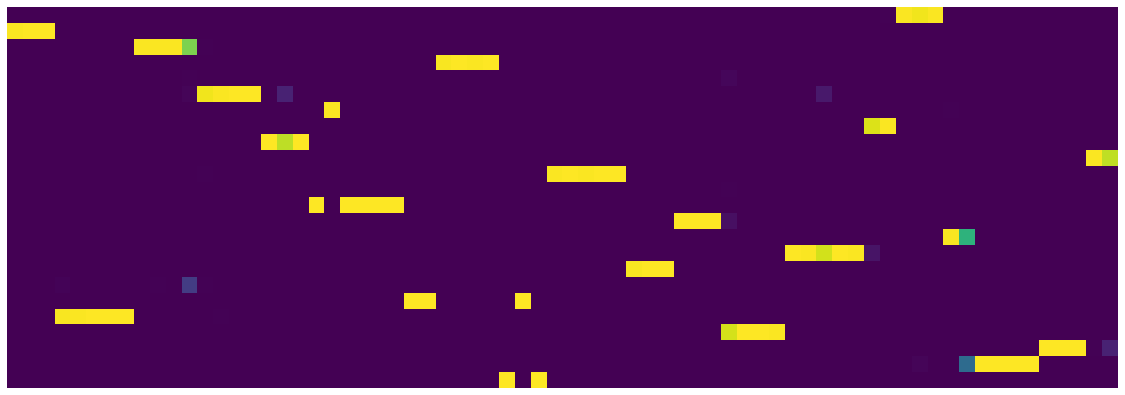

24 63 0.9359999999999999 0.6086372042074799


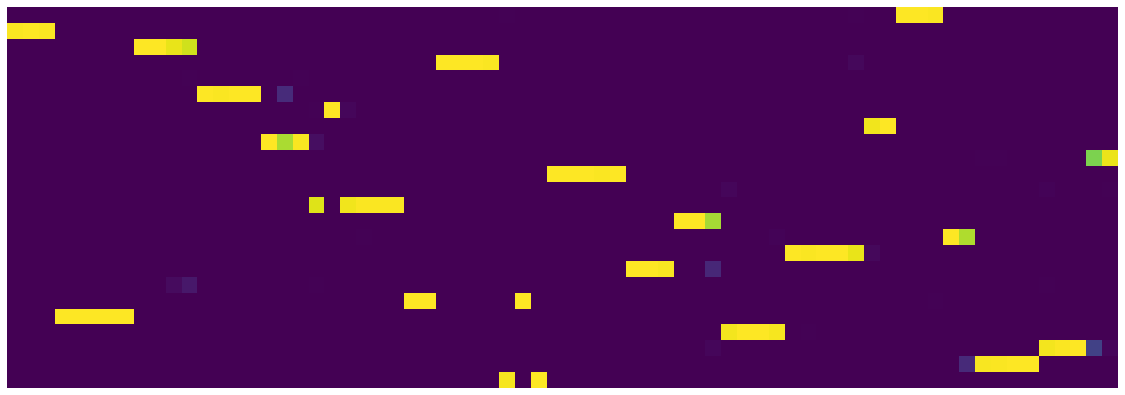

24 64 0.9349999999999999 0.5995042823255062


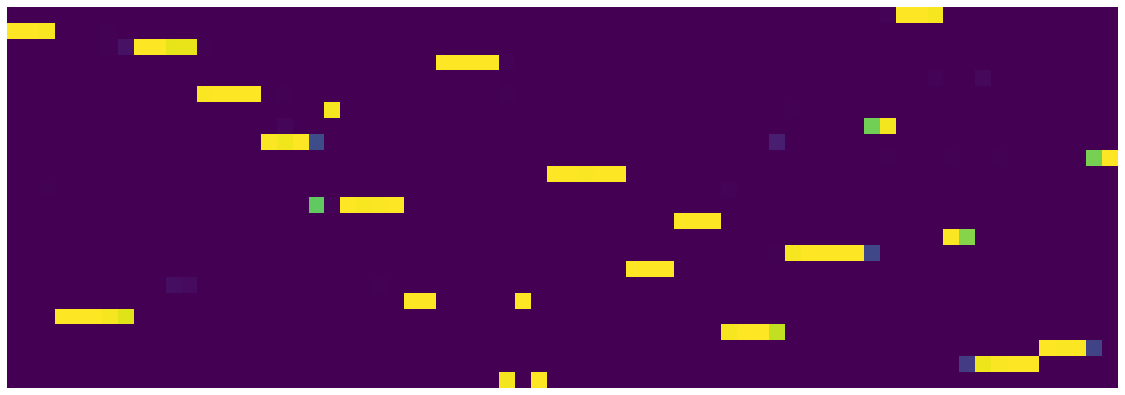

24 65 0.9339999999999999 0.5929121980443597


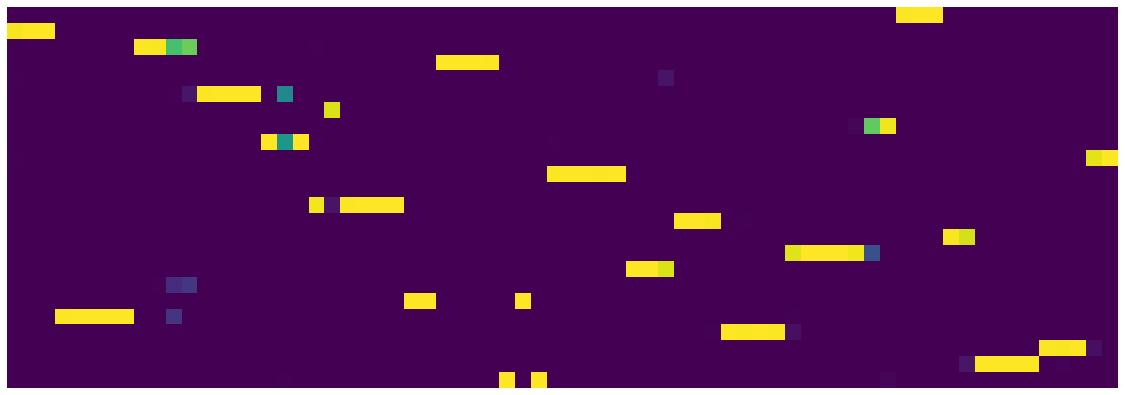

24 66 0.9329999999999999 0.5877532184123992


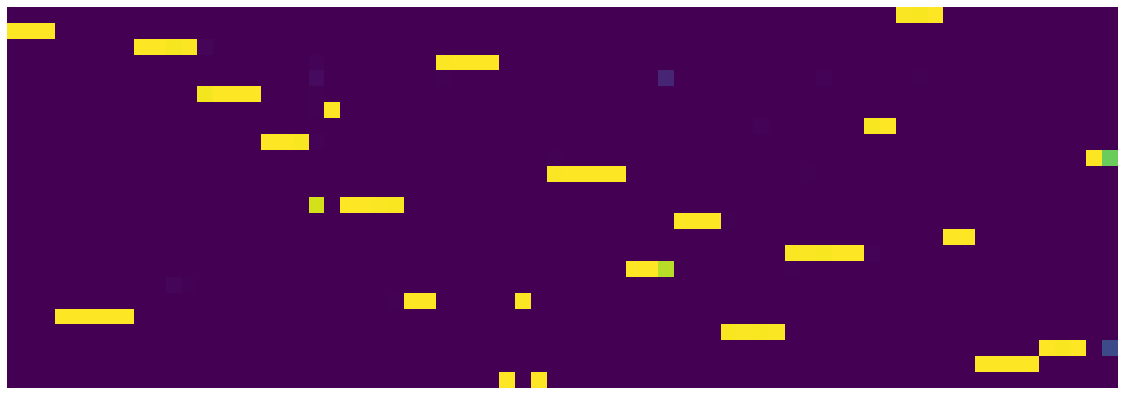

24 67 0.9319999999999999 0.5867767490446567


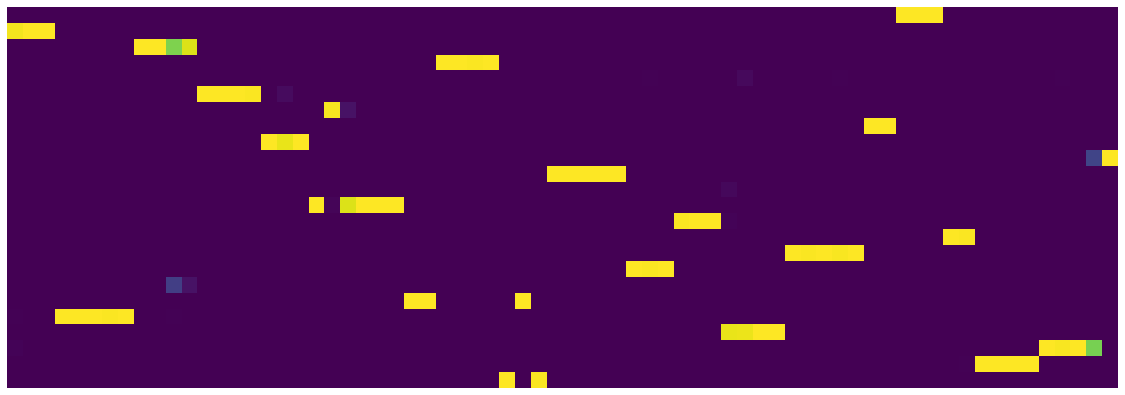

24 68 0.9309999999999999 0.5797152053564787


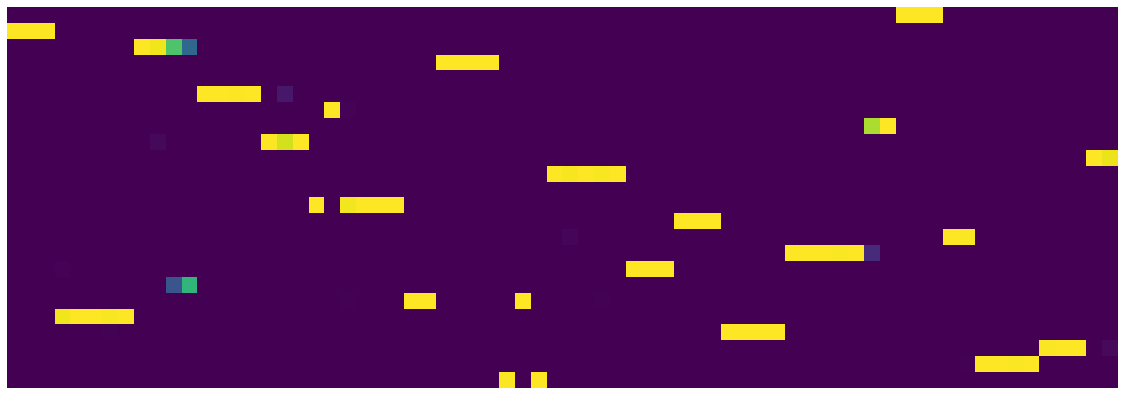

24 69 0.9299999999999999 0.5659143600612879


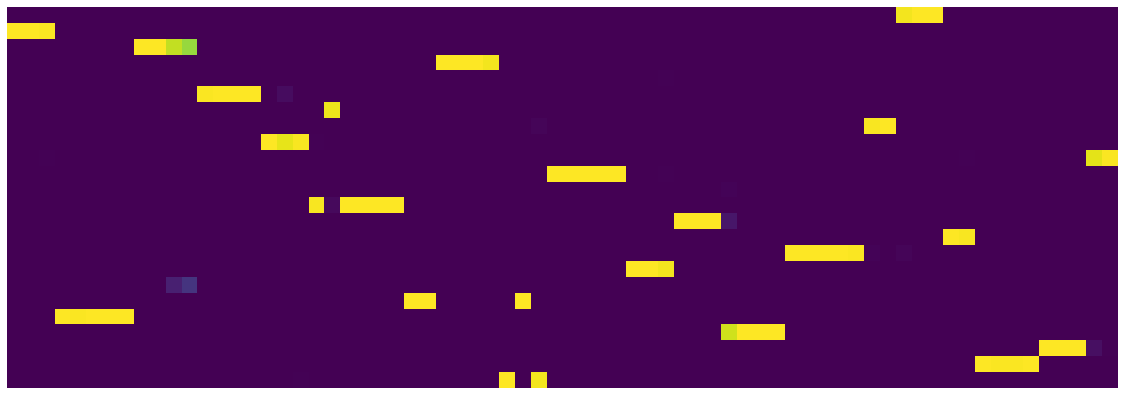

24 70 0.9289999999999999 0.5670257380232215


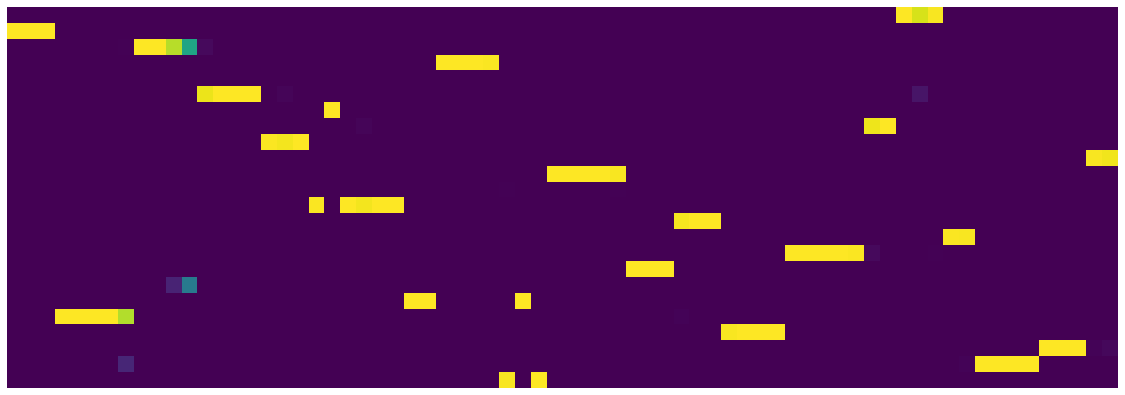

24 71 0.9279999999999999 0.5619215492159129


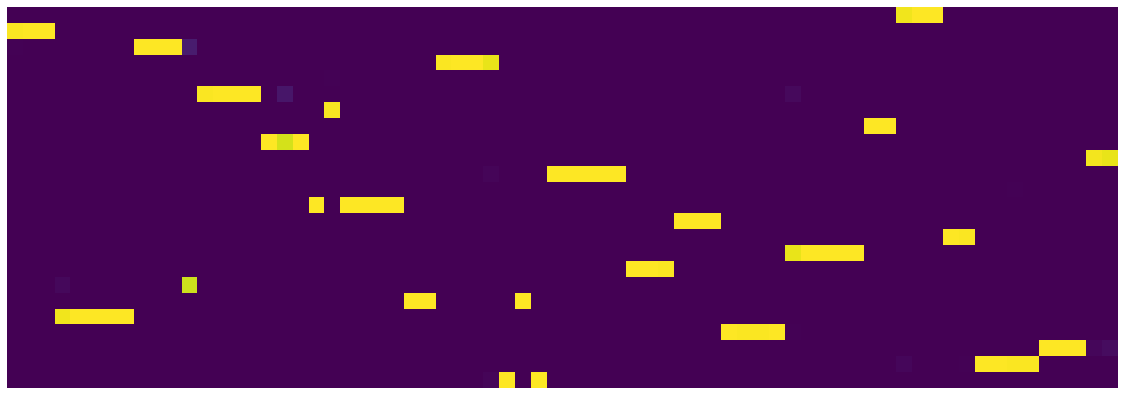

24 72 0.9269999999999999 0.5570658259093761


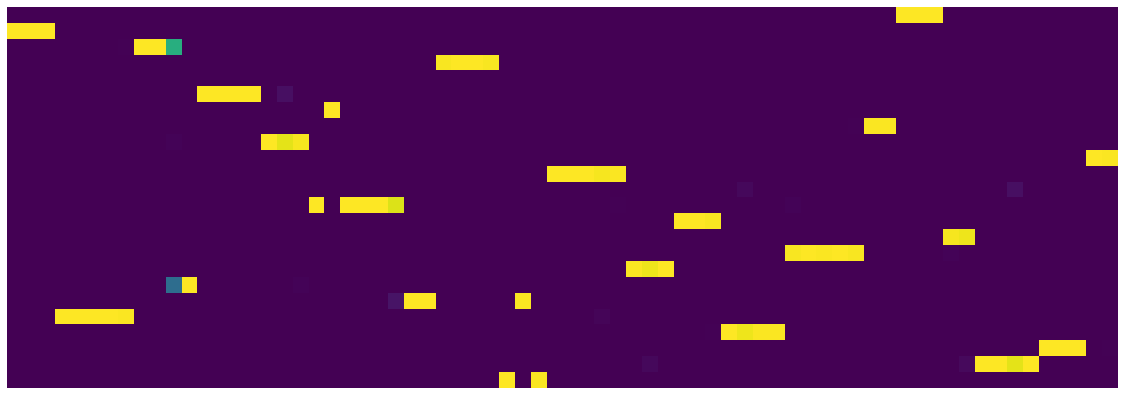

24 73 0.9259999999999999 0.5579617096111178


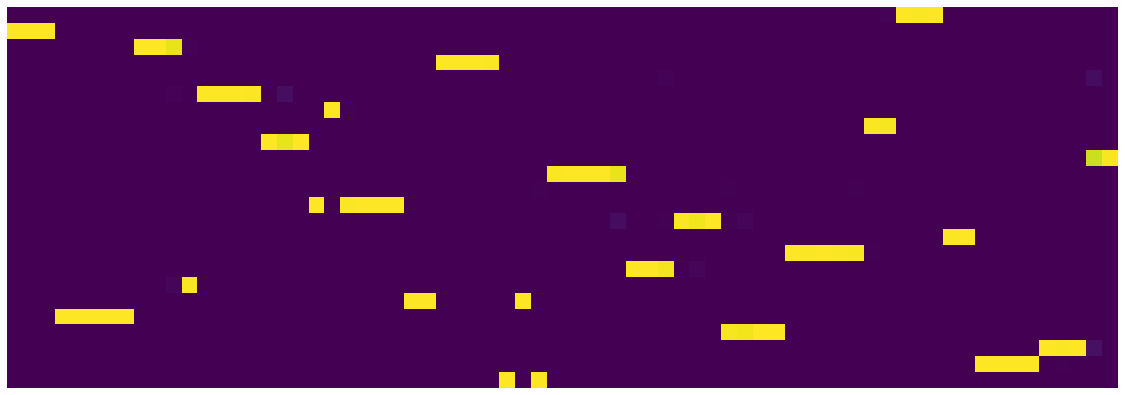

24 74 0.9249999999999999 0.5556905006989836


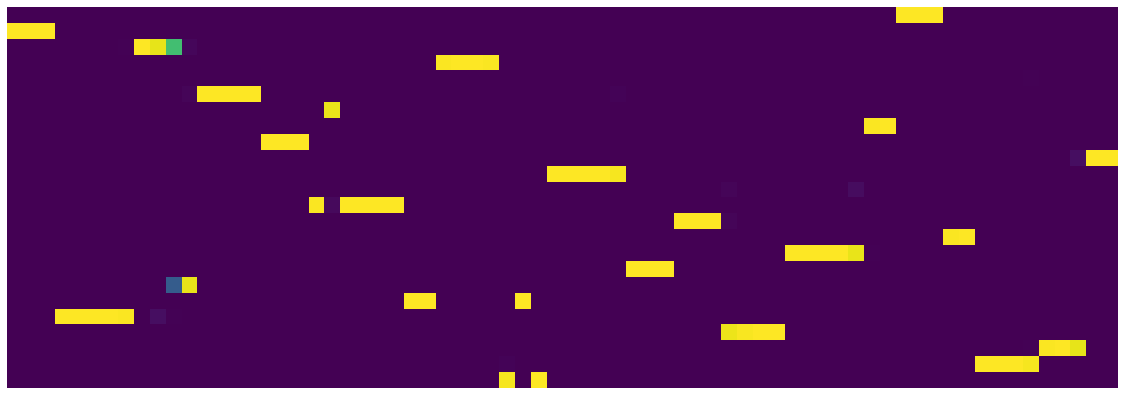

24 75 0.9239999999999999 0.5581089798361063


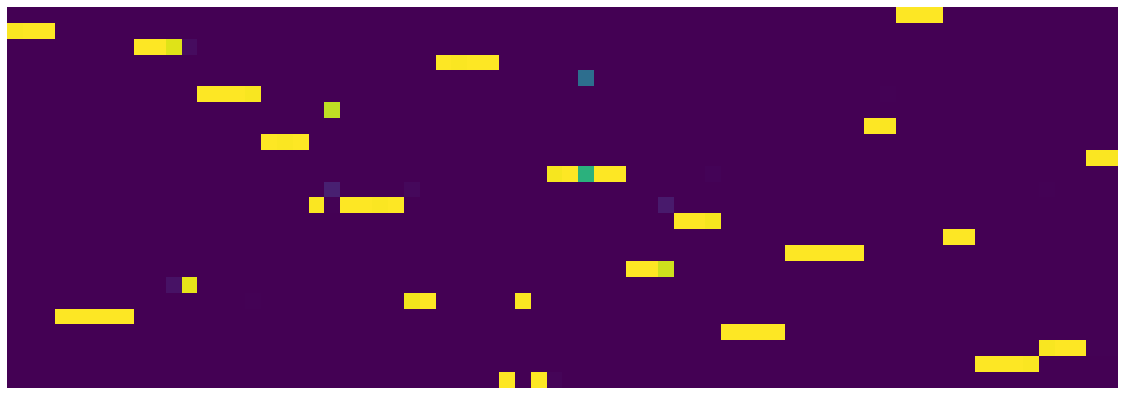

24 76 0.9229999999999999 0.5532035030424595


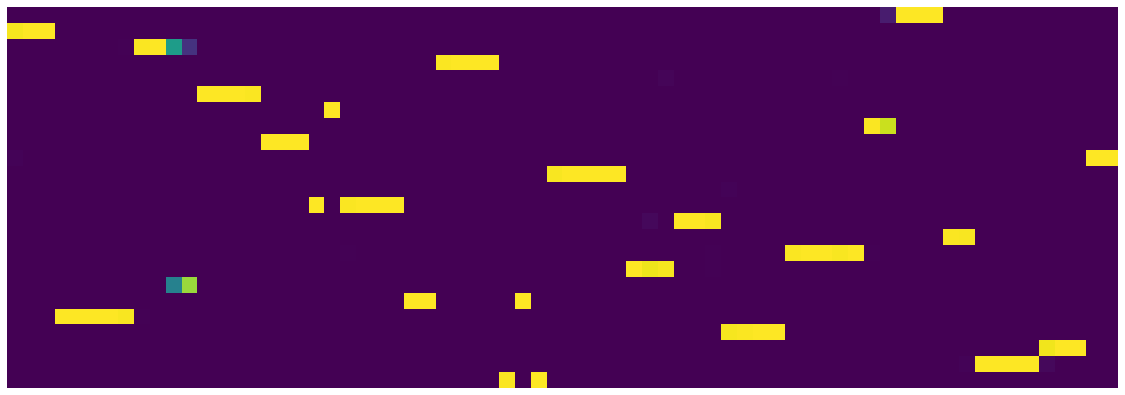

24 77 0.9219999999999999 0.558619980327785


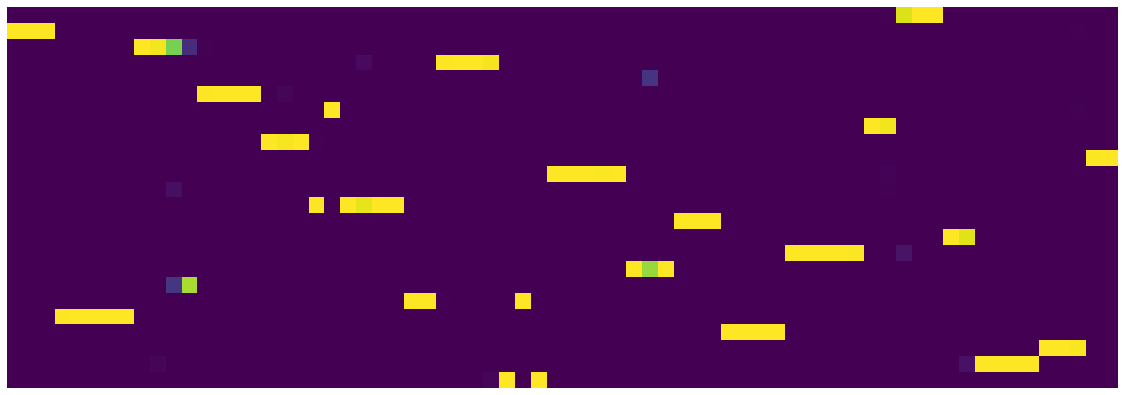

24 78 0.9209999999999999 0.5565919576212763


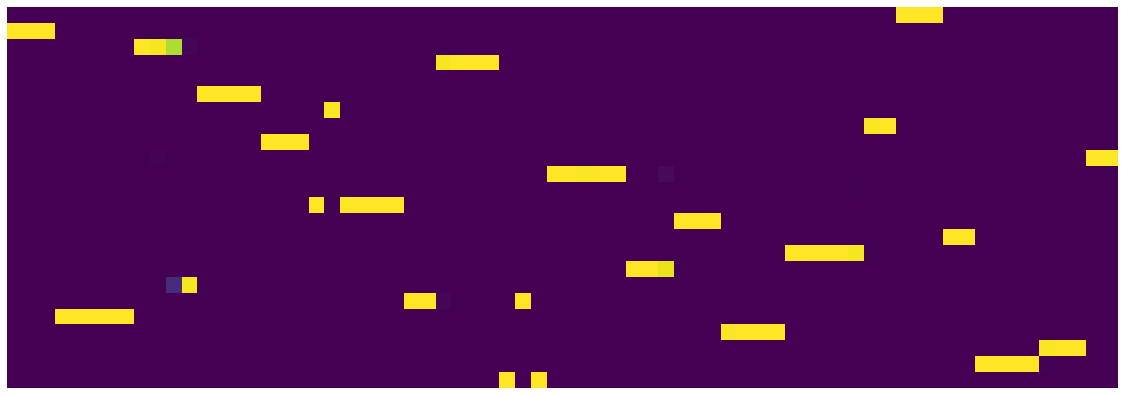

24 79 0.9199999999999999 0.5552143367007375


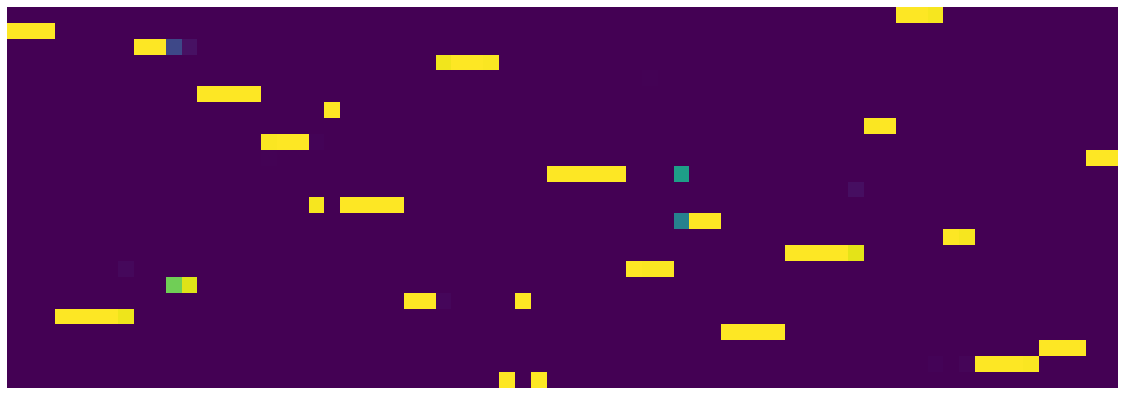

24 80 0.9189999999999999 0.5525521695613861


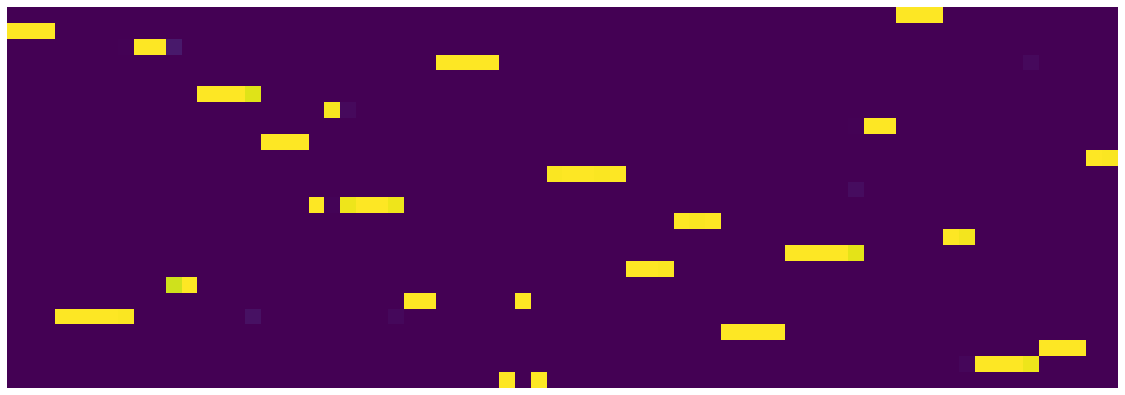

24 81 0.9179999999999999 0.5479607278481126


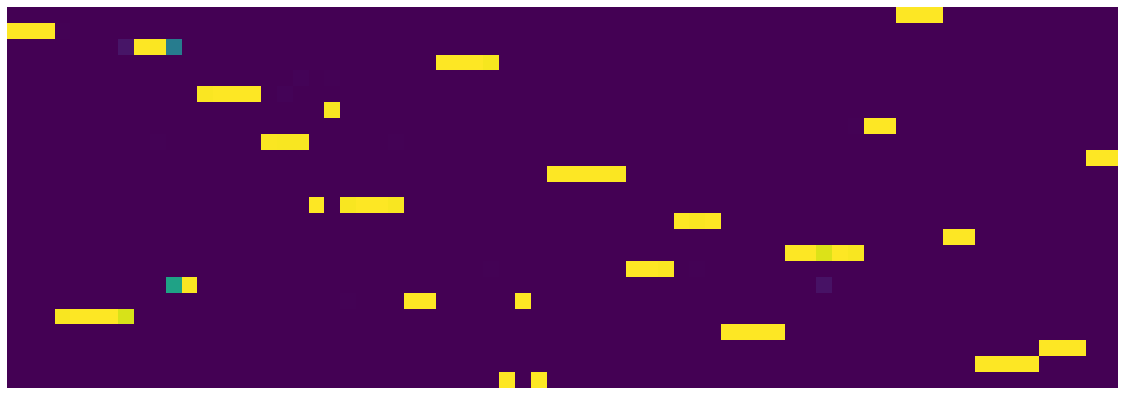

24 82 0.9169999999999999 0.5470905853435397


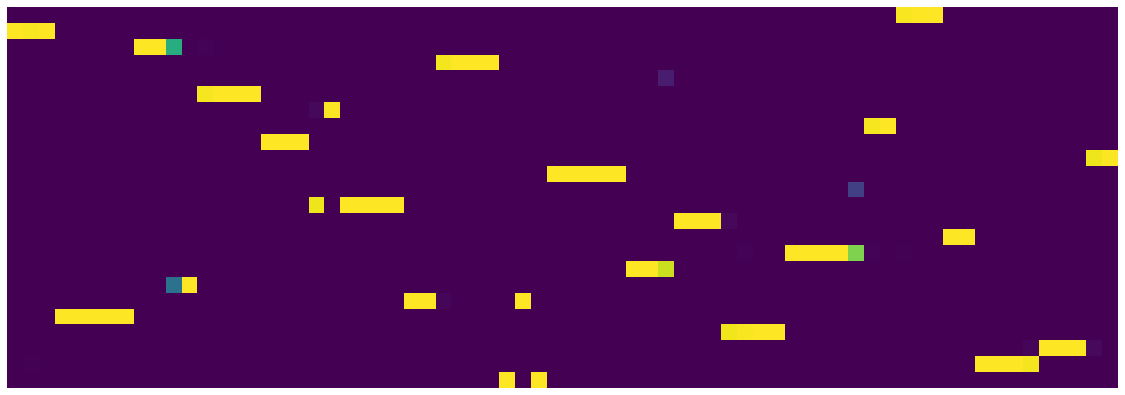

24 83 0.9159999999999999 0.5504036631435156


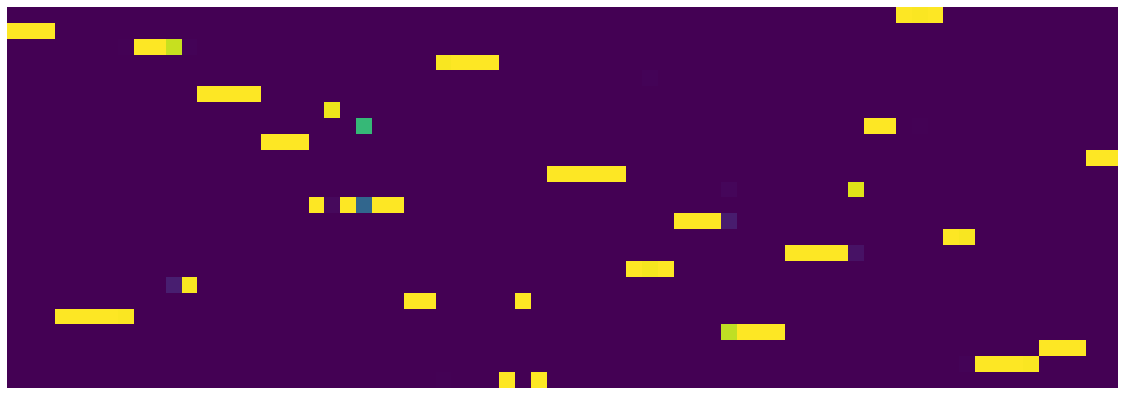

24 84 0.9149999999999999 0.5493426823988556


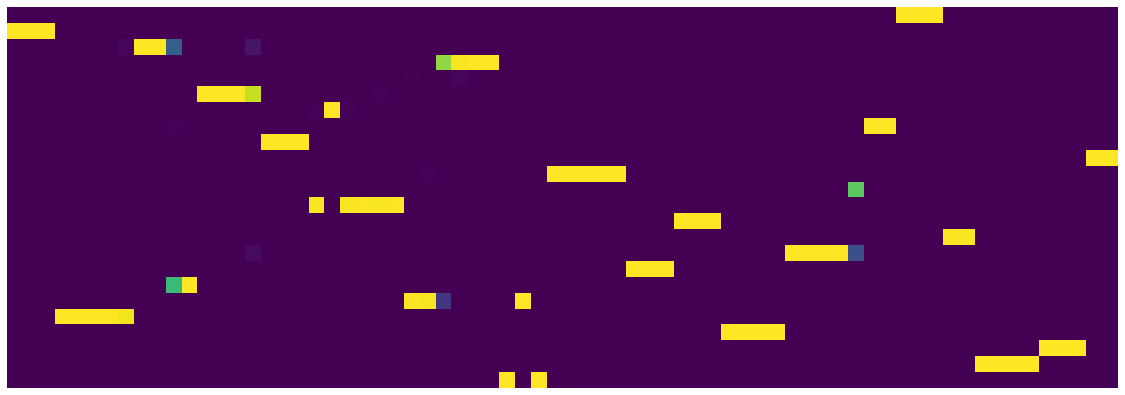

24 85 0.9139999999999999 0.5380062501877546


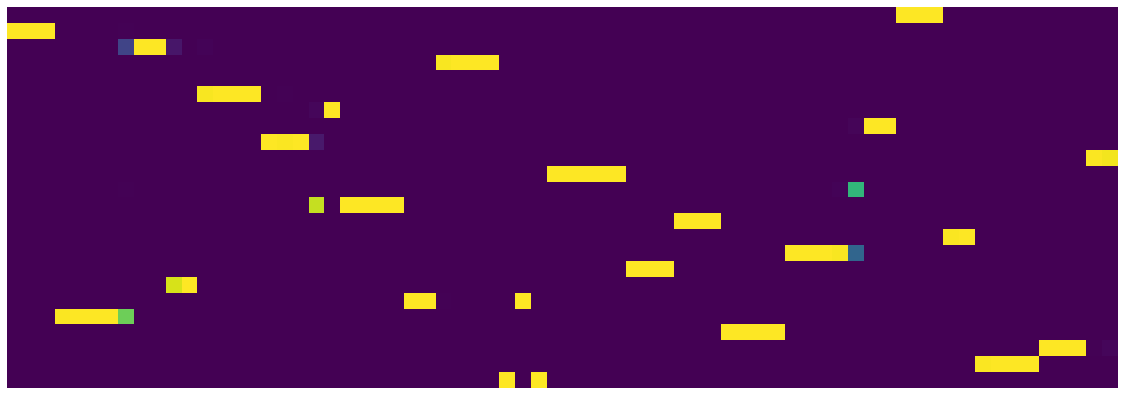

24 86 0.9129999999999999 0.5303766686469317


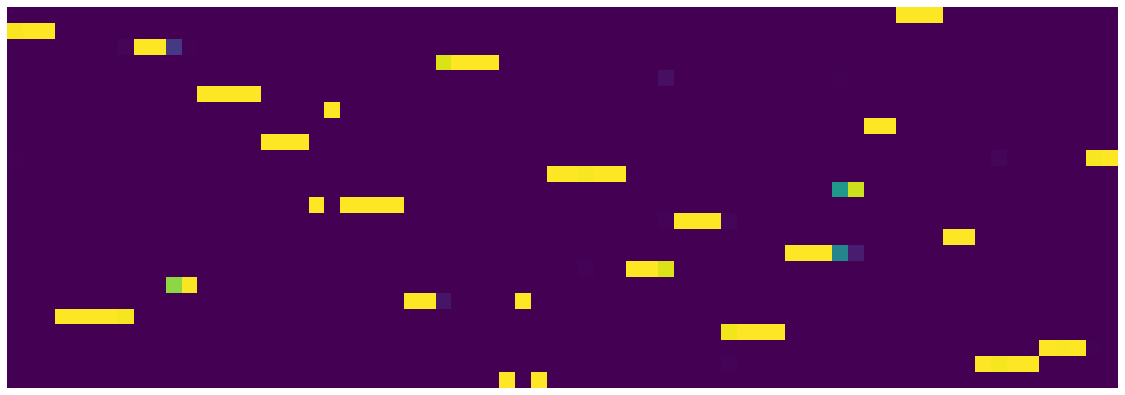

24 87 0.9119999999999999 0.5329530334100128


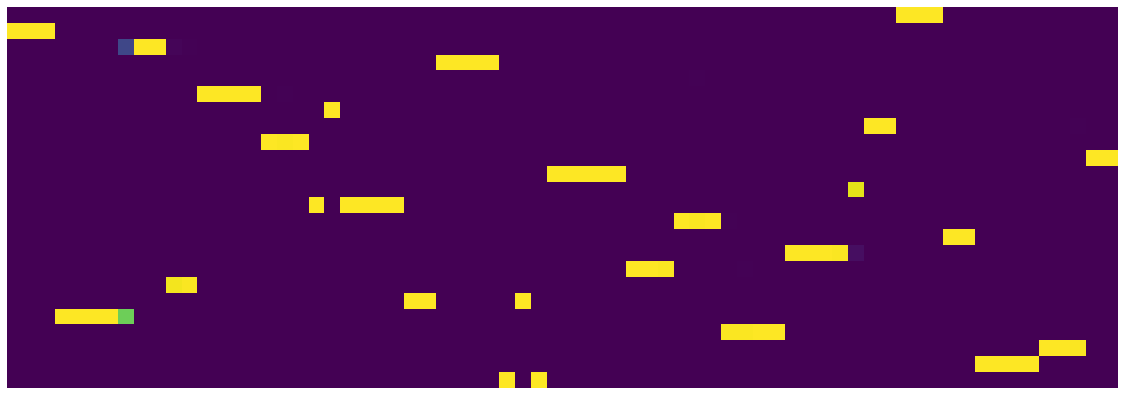

24 88 0.9109999999999999 0.5228537658229471


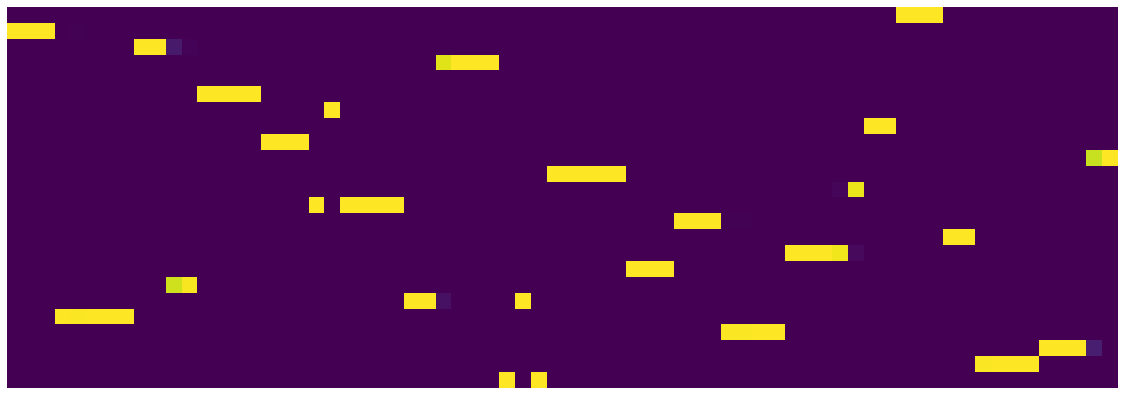

24 89 0.9099999999999999 0.525801619514823


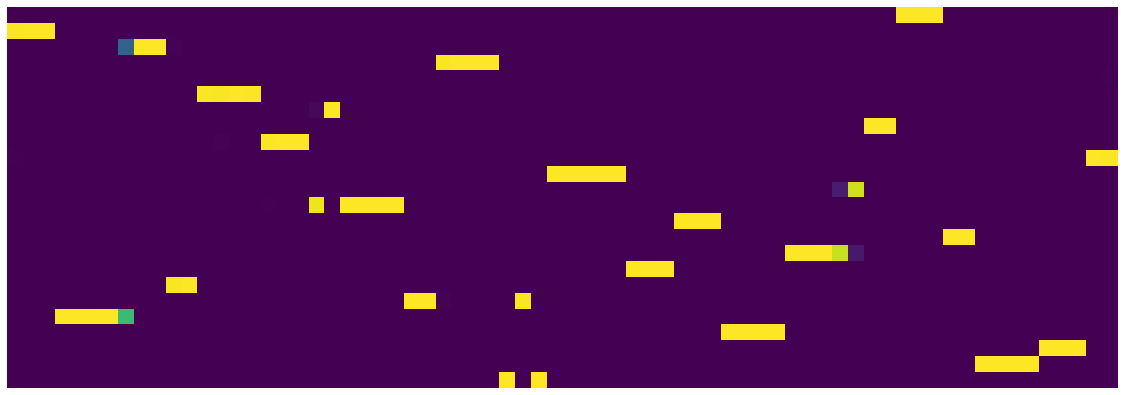

24 90 0.9089999999999999 0.5216356374323368


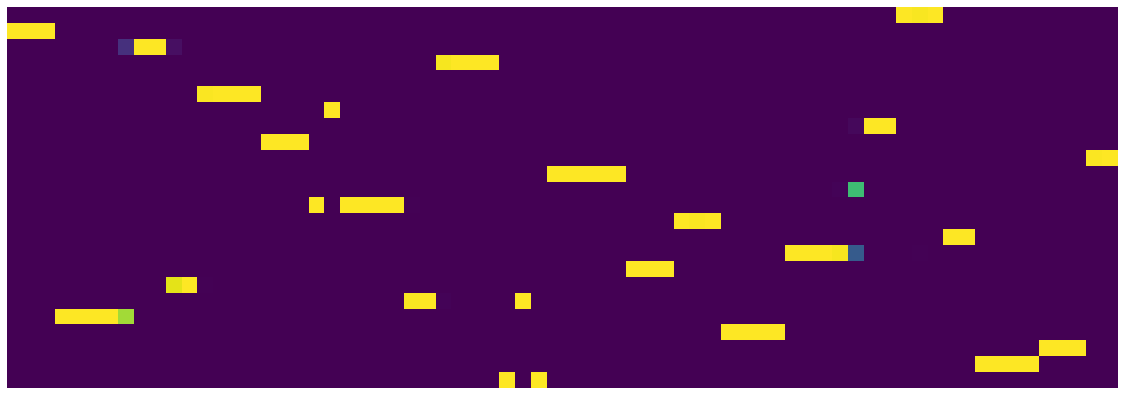

24 91 0.9079999999999999 0.5224085738882422


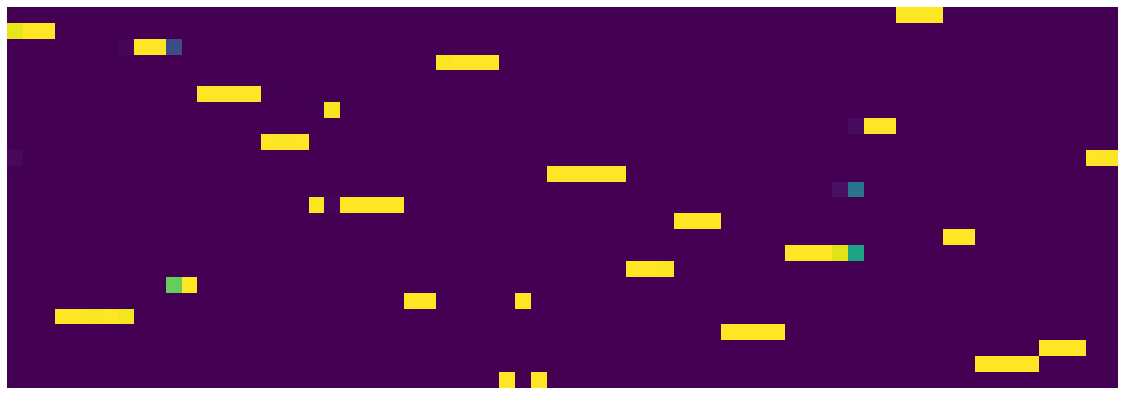

24 92 0.9069999999999999 0.5196421613916755


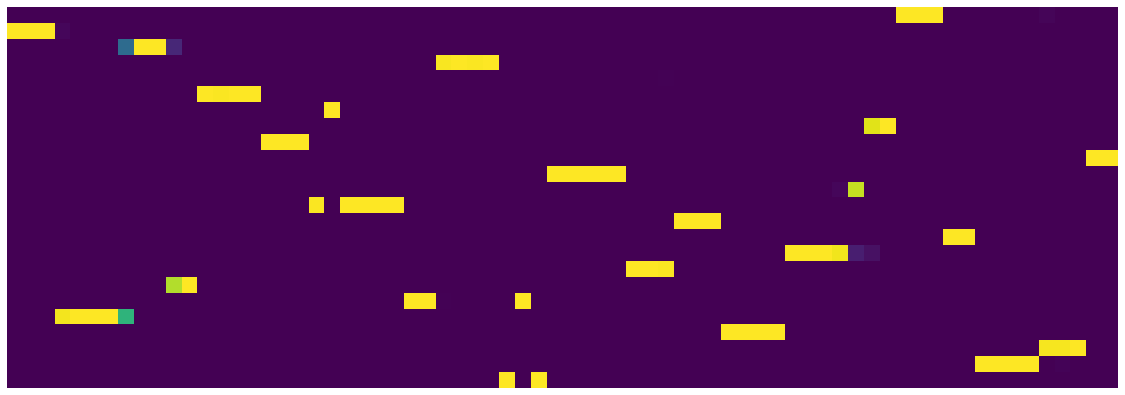

24 93 0.9059999999999999 0.52227682787925


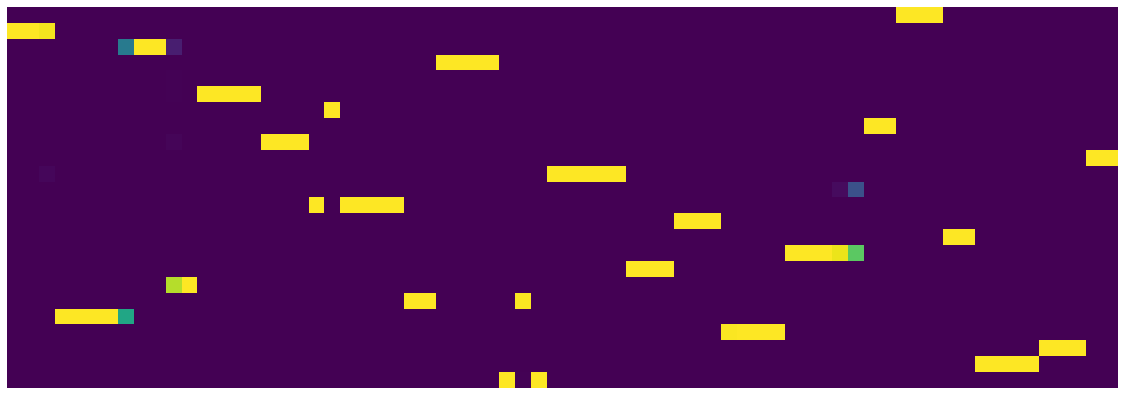

24 94 0.9049999999999999 0.5218659106642007


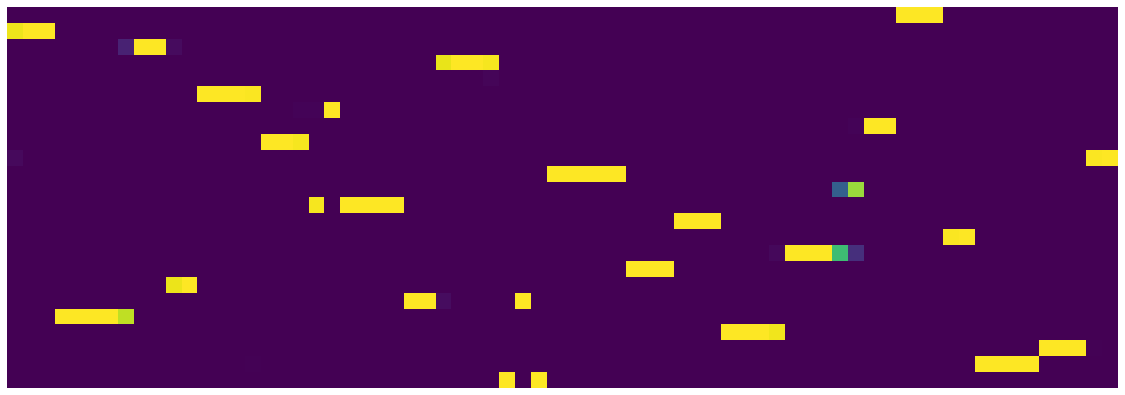

24 95 0.9039999999999999 0.5181740889325738


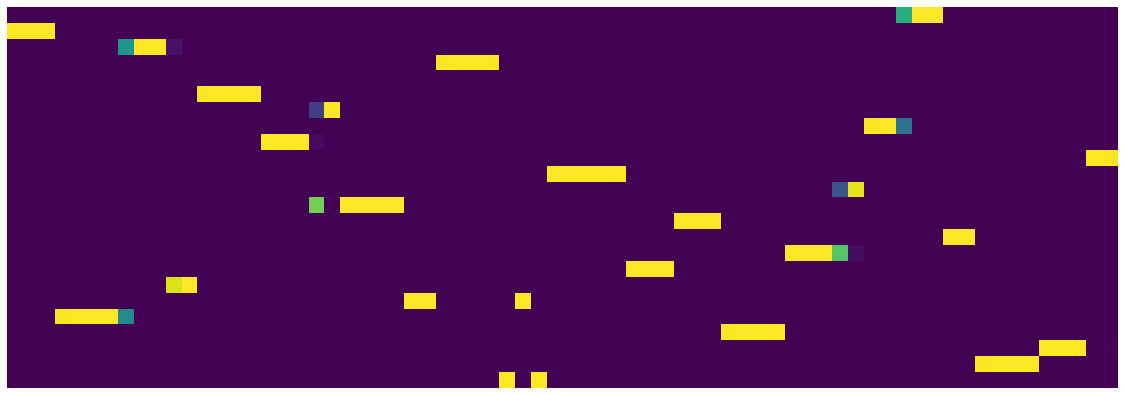

24 96 0.9029999999999999 0.520512412302196


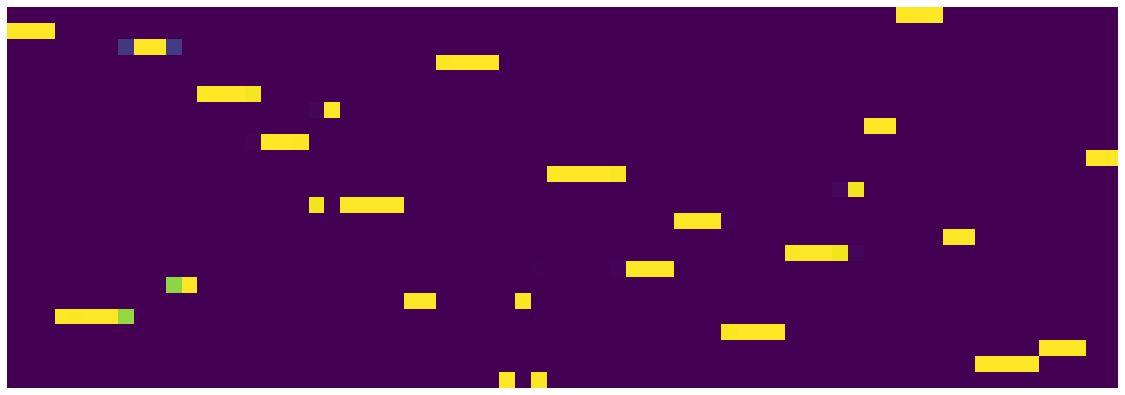

24 97 0.9019999999999999 0.5172446539625526


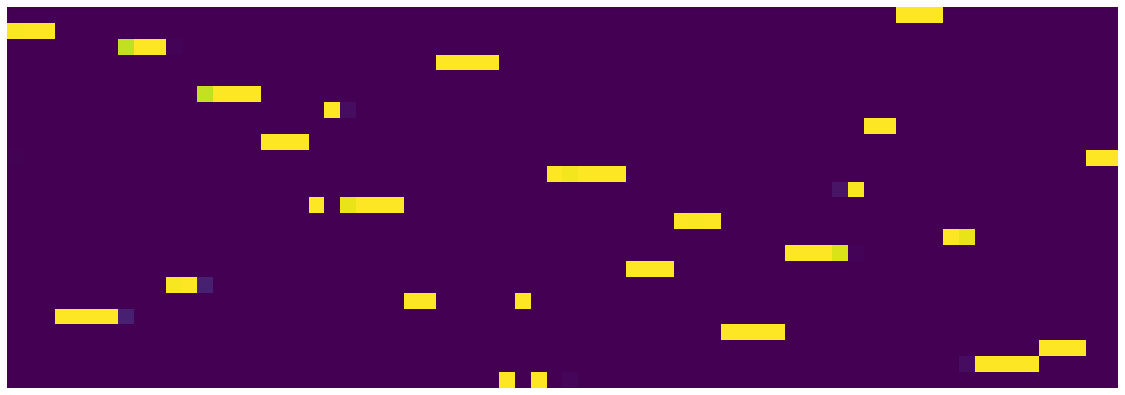

24 98 0.9009999999999999 0.5137809738516808


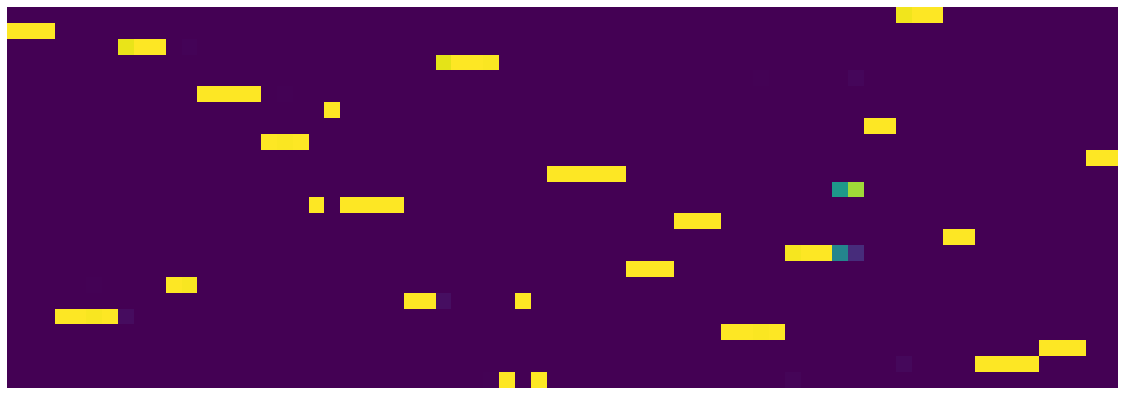

24 99 0.8999999999999999 0.51253825686872


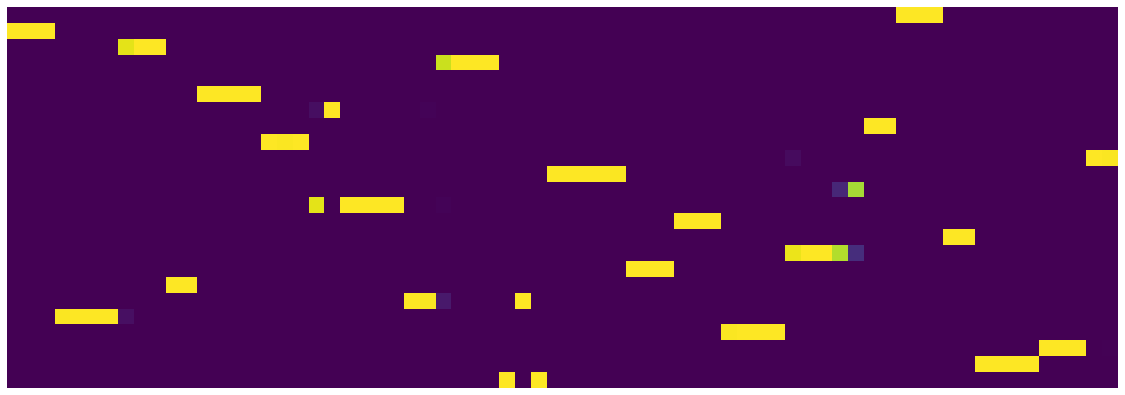

24 100 0.8989999999999999 0.5099669920280576


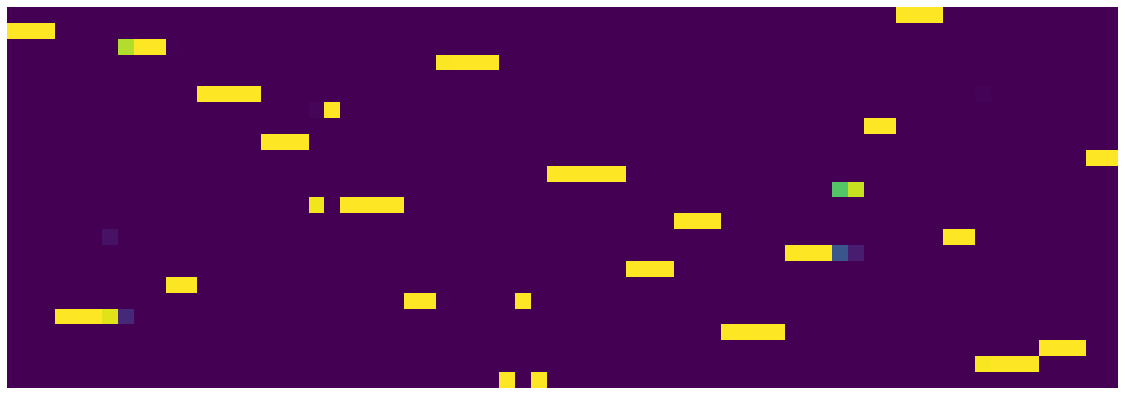

24 101 0.8979999999999999 0.5081878734752536


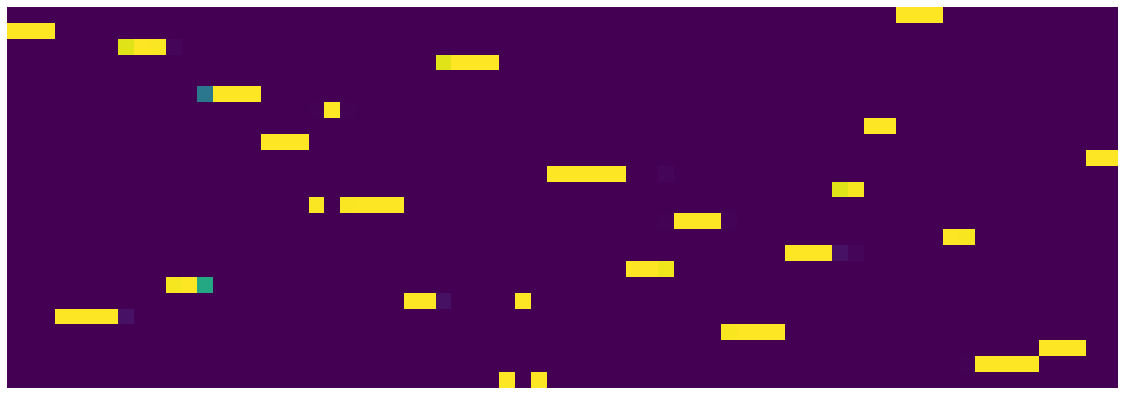

24 102 0.8969999999999999 0.5092673543840647


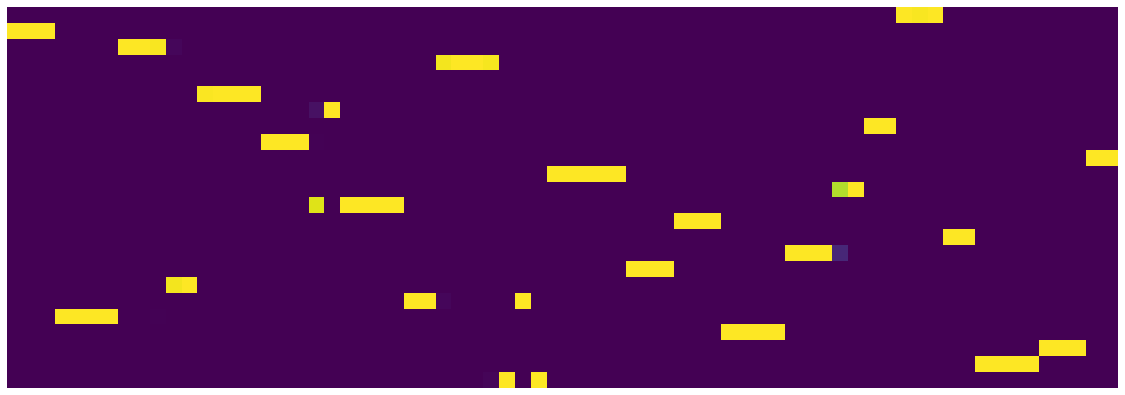

24 103 0.8959999999999999 0.5046120963990688


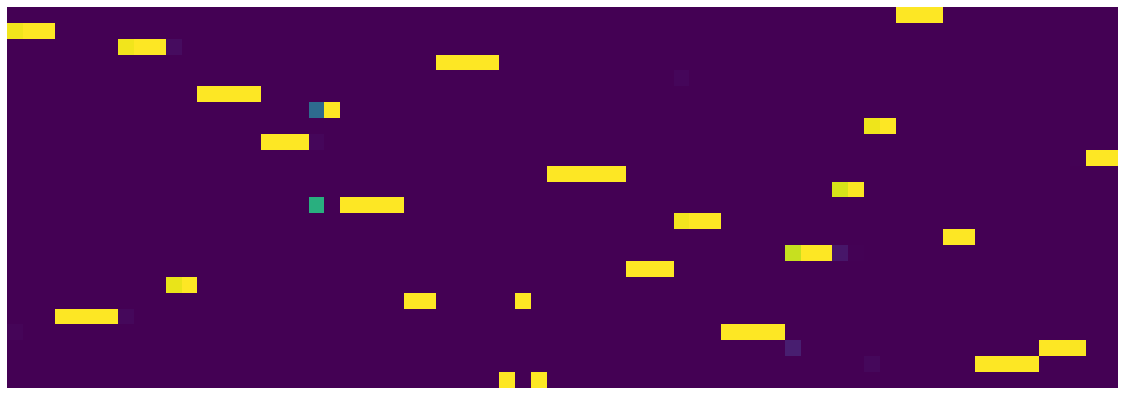

24 104 0.8949999999999999 0.5028965704143047


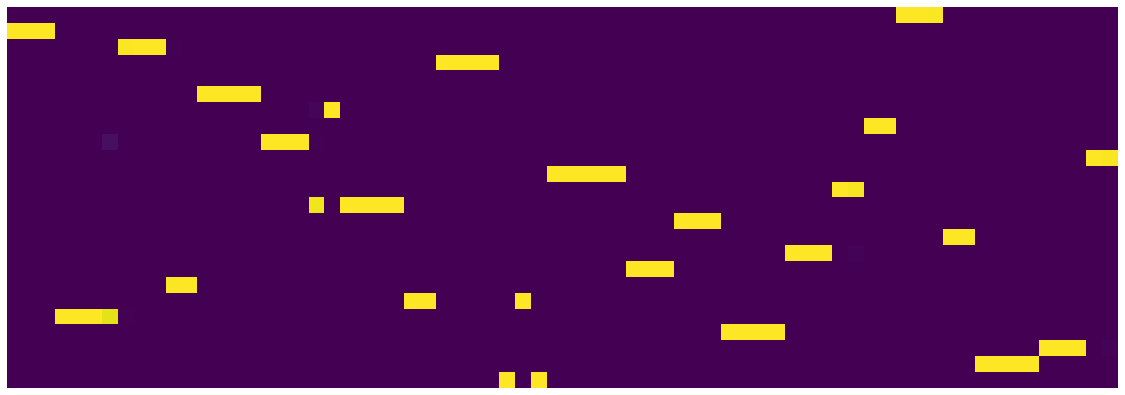

24 105 0.8939999999999999 0.5043566403910518


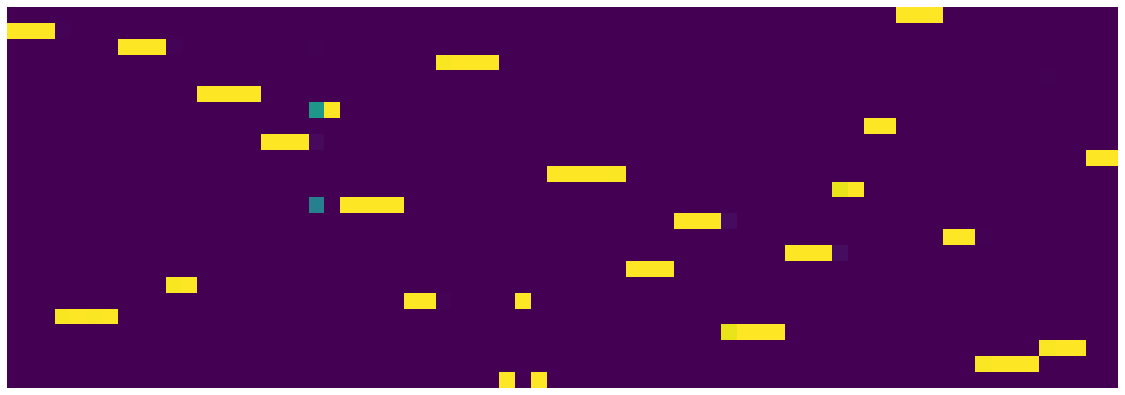

24 106 0.8929999999999999 0.5037592794746161


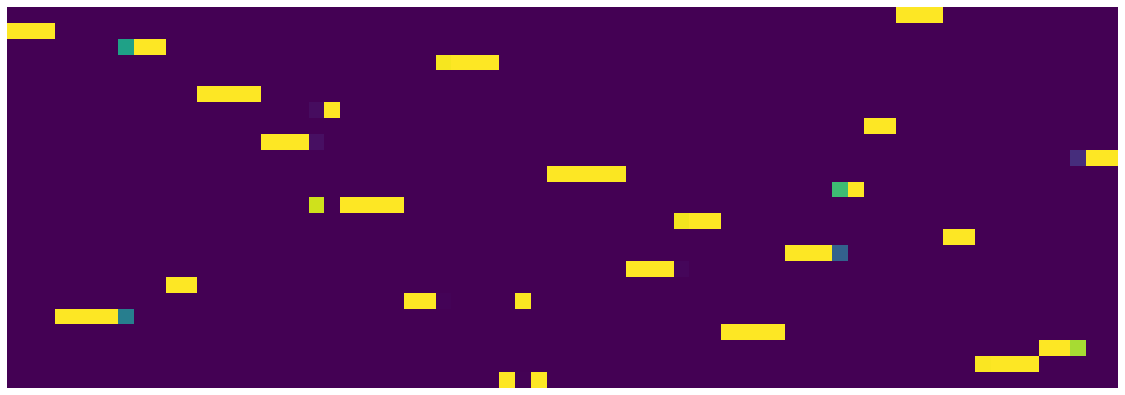

24 107 0.8919999999999999 0.5057013602927327


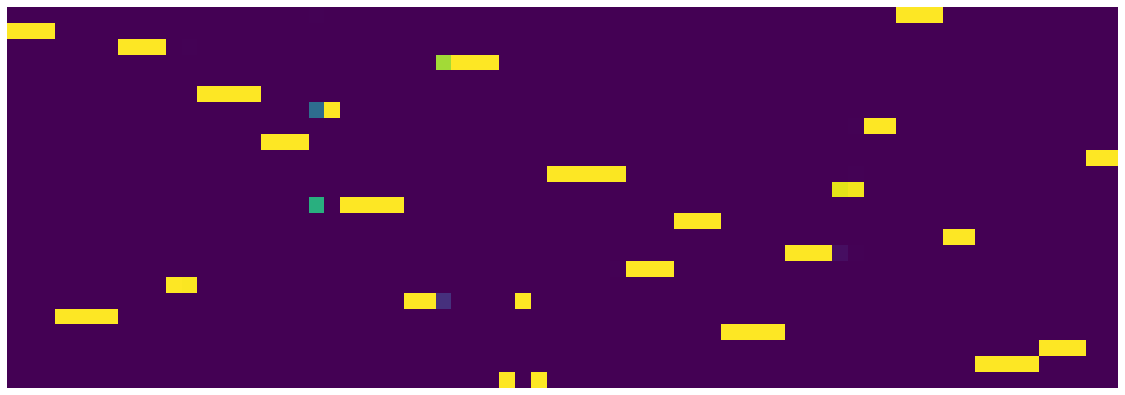

24 108 0.8909999999999999 0.5022509125992656


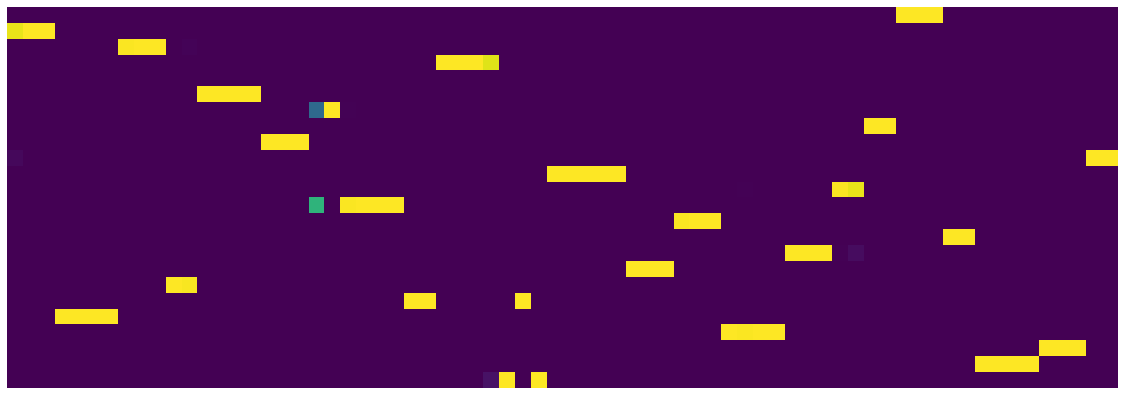

24 109 0.8899999999999999 0.5032069001346826


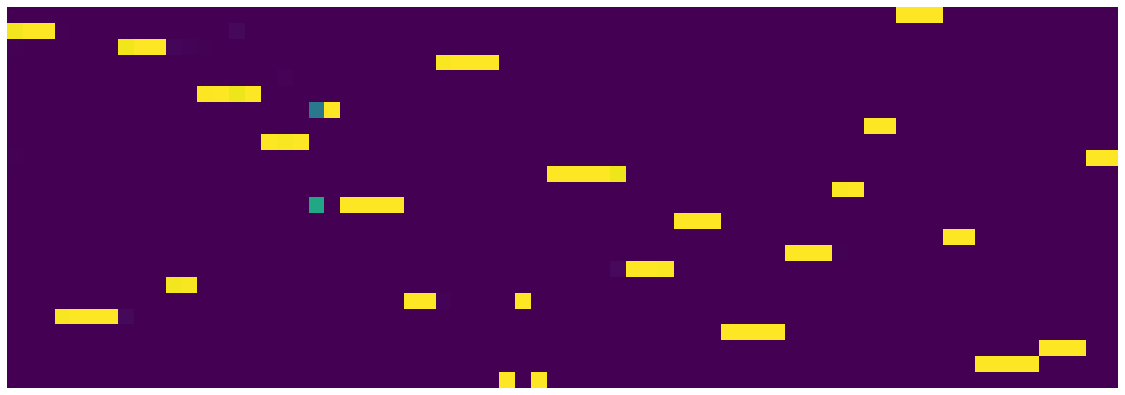

24 110 0.8889999999999999 0.5000329395756126


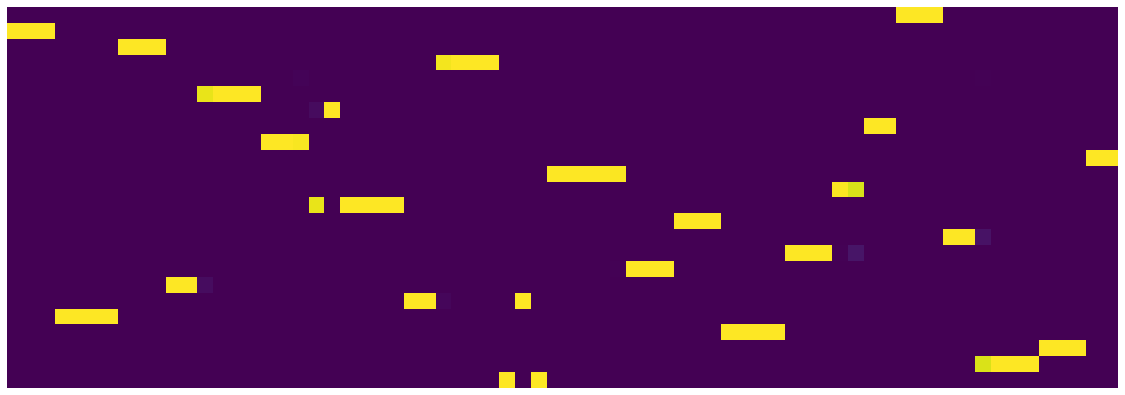

24 111 0.8879999999999999 0.5006776789203287


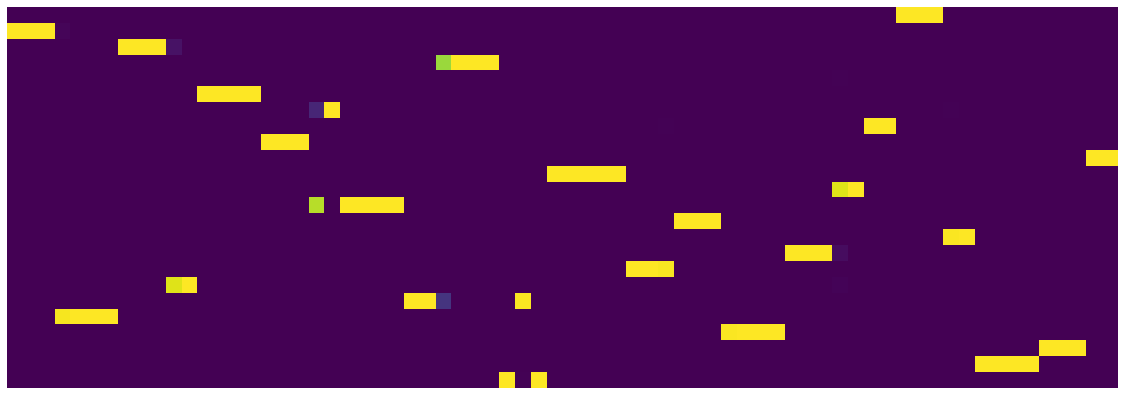

24 112 0.8869999999999999 0.502251124382019


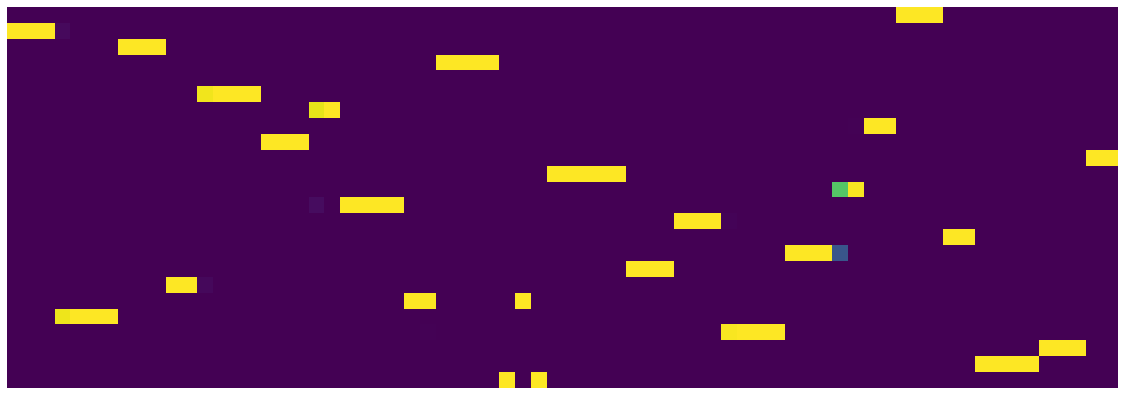

24 113 0.8859999999999999 0.5035602351650595


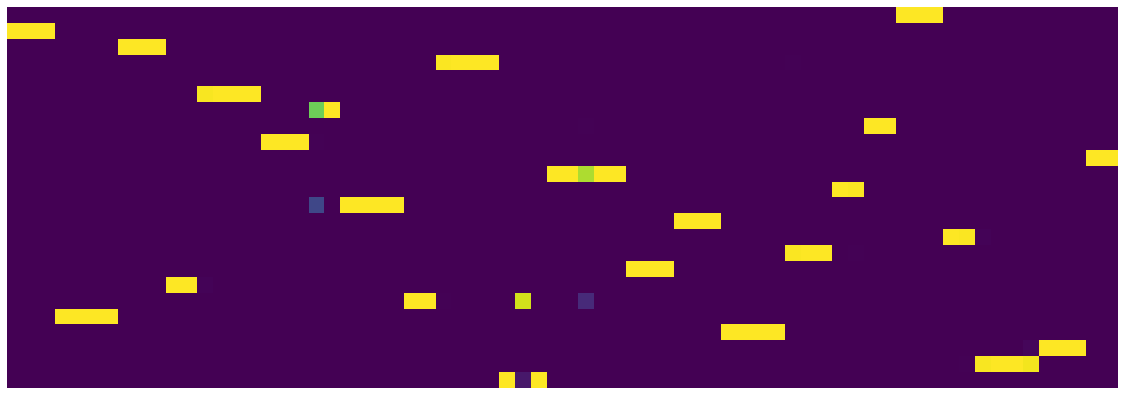

24 114 0.8849999999999999 0.5002187134698033


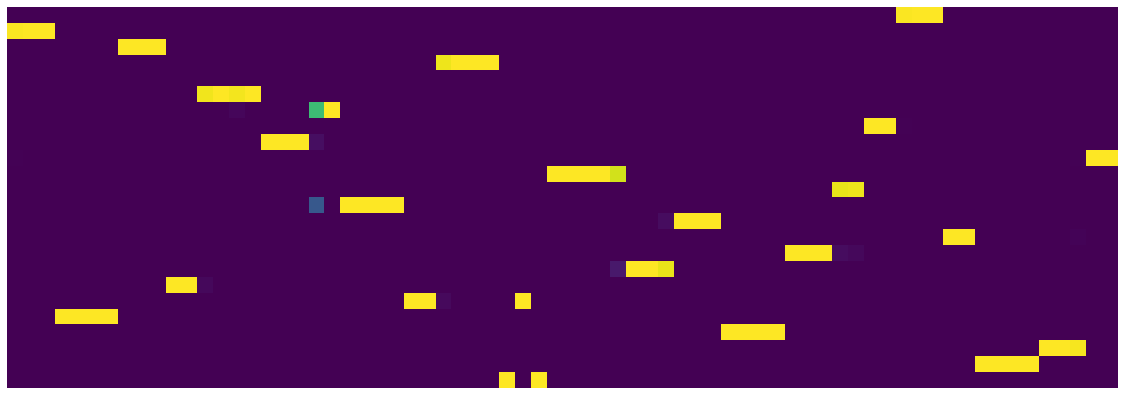

24 115 0.8839999999999999 0.5000790743157267


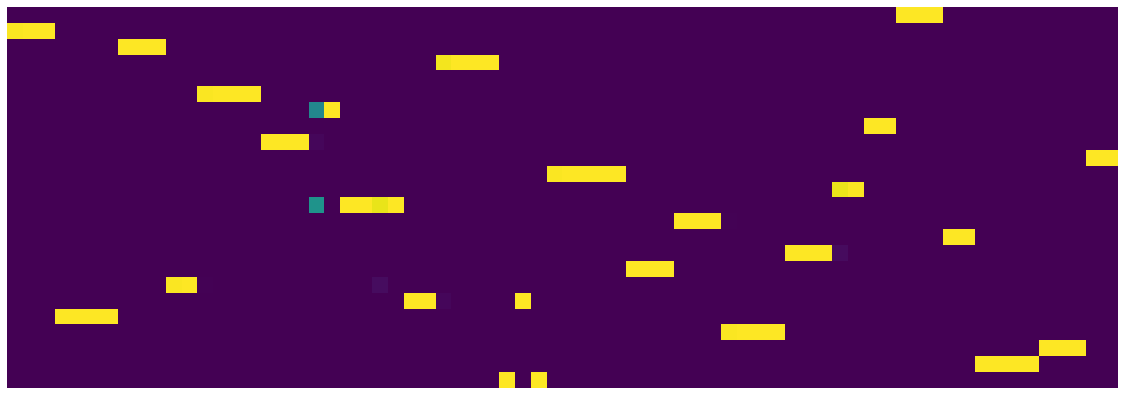

24 116 0.8829999999999999 0.49594568088650703


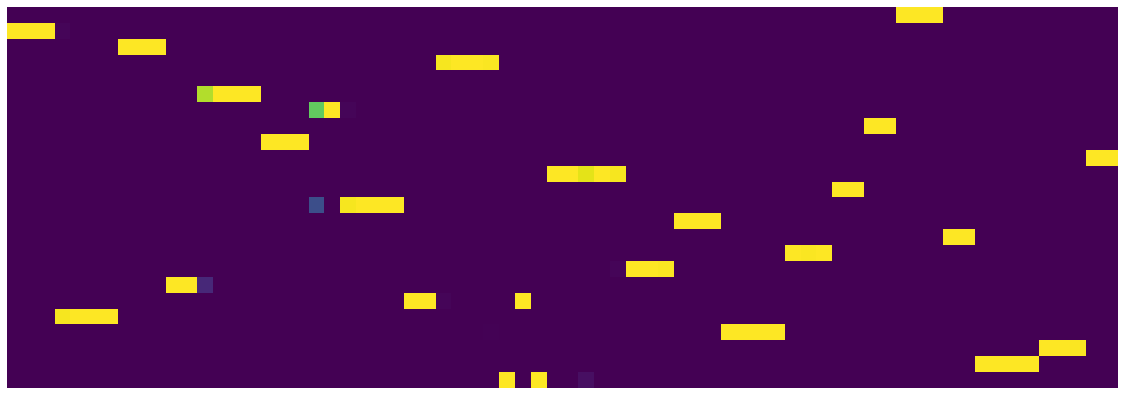

24 117 0.8819999999999999 0.498133934289217


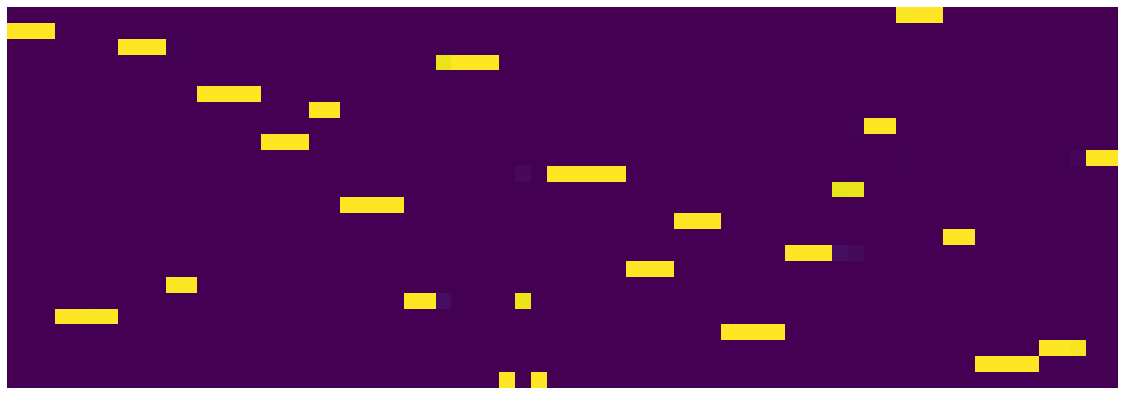

24 118 0.8809999999999999 0.49318682551383974


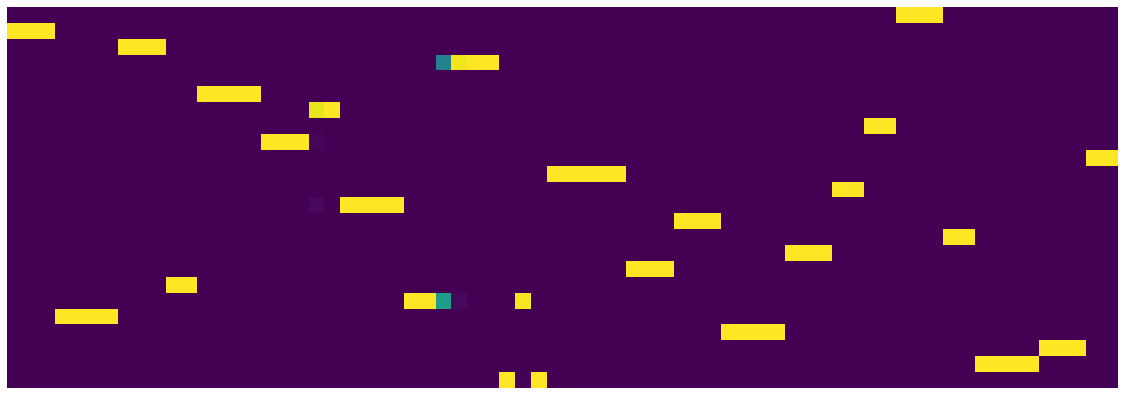

24 119 0.8799999999999999 0.49357223734259603


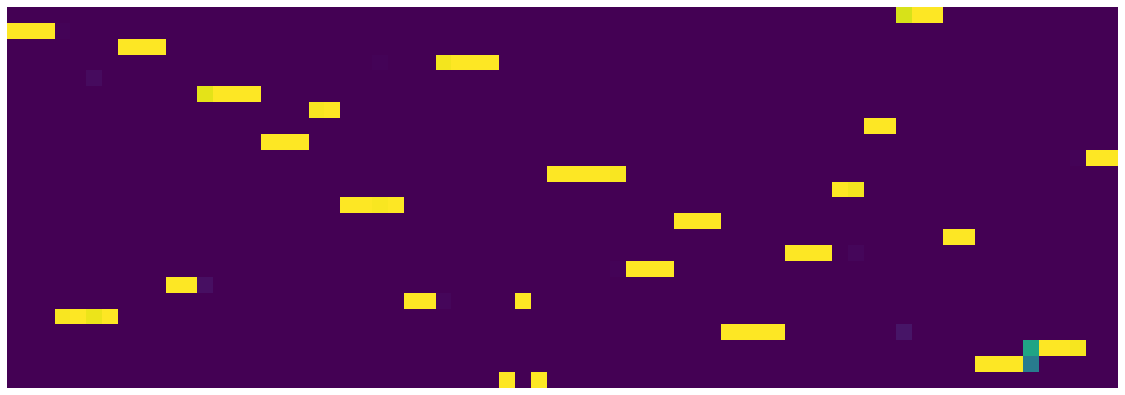

24 120 0.8789999999999999 0.4976963737979531


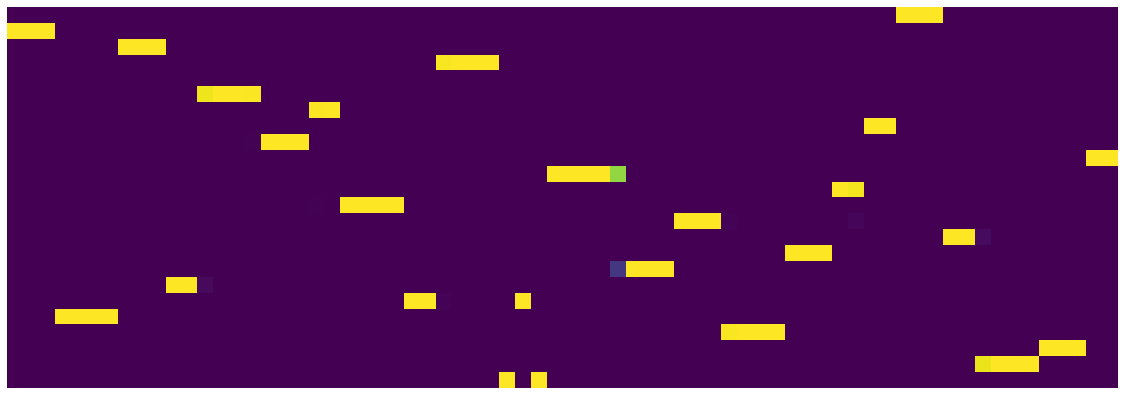

24 121 0.8779999999999999 0.49507627841085194


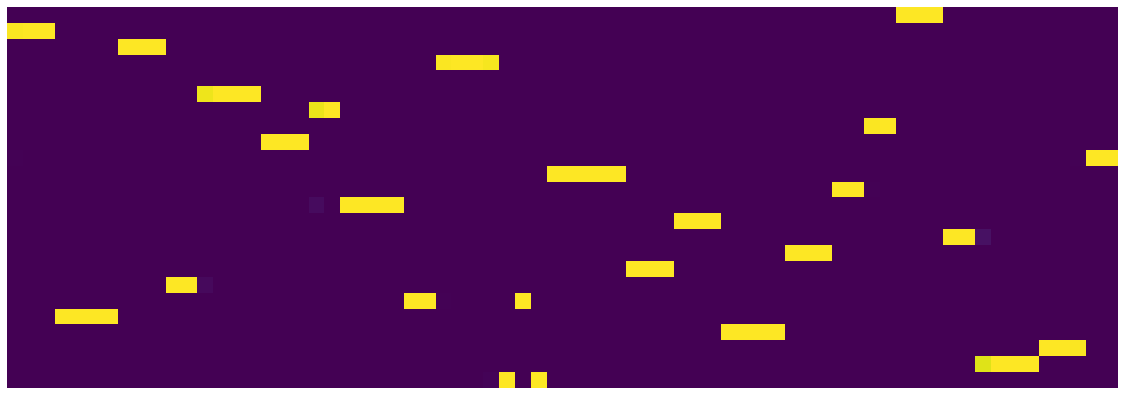

24 122 0.8769999999999999 0.4929129511117935


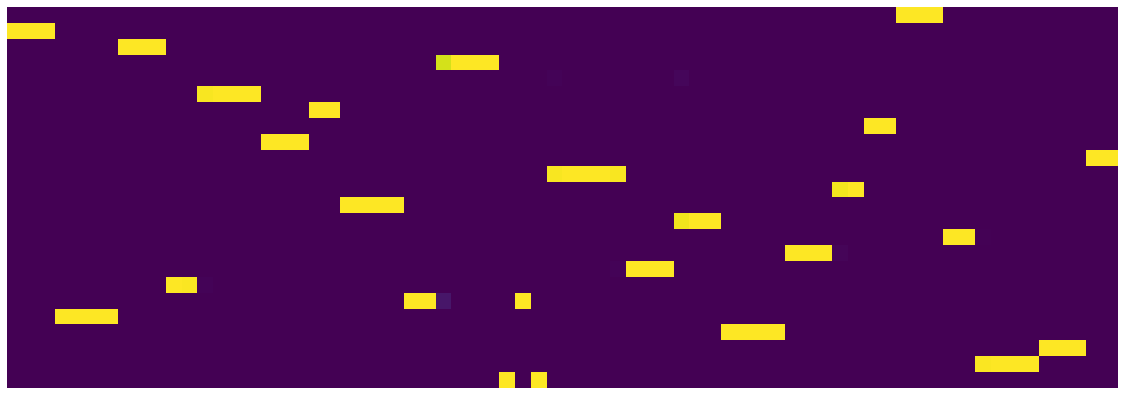

24 123 0.8759999999999999 0.4915631767362356


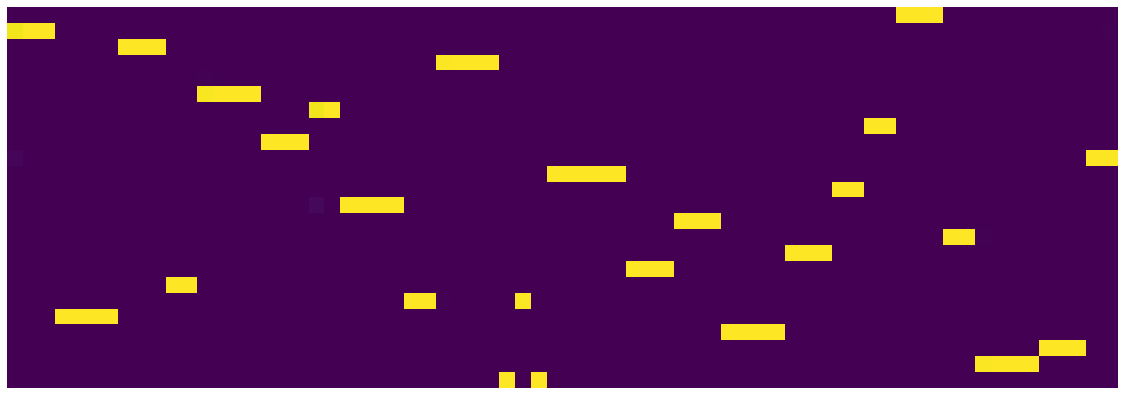

24 124 0.8749999999999999 0.4935357658192515


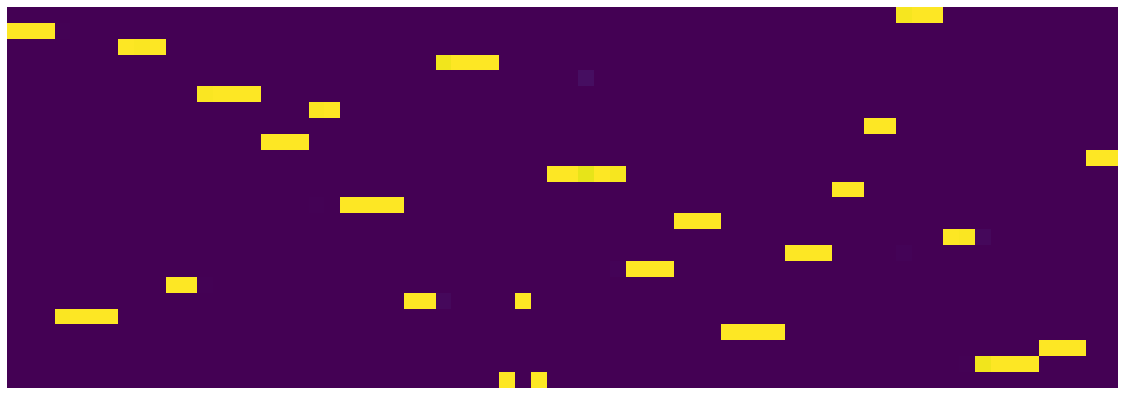

24 125 0.8739999999999999 0.4930859776213765


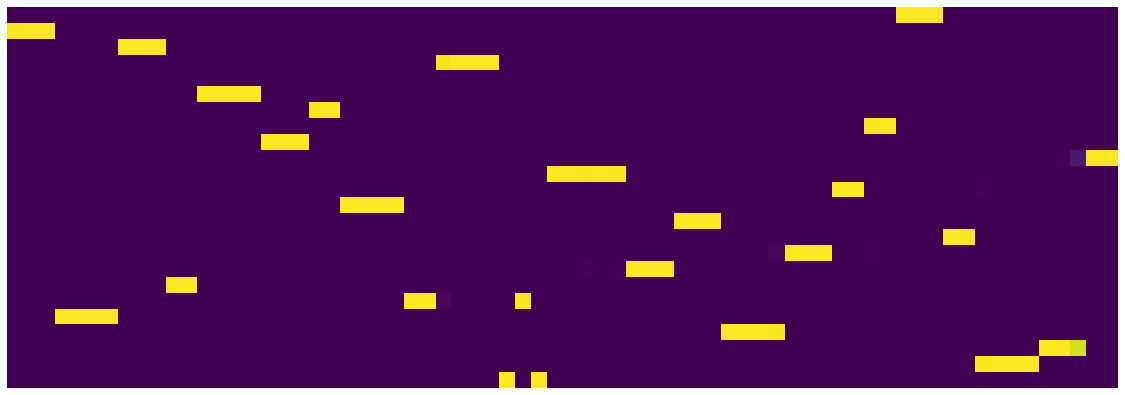

24 126 0.8729999999999999 0.4920641867443919


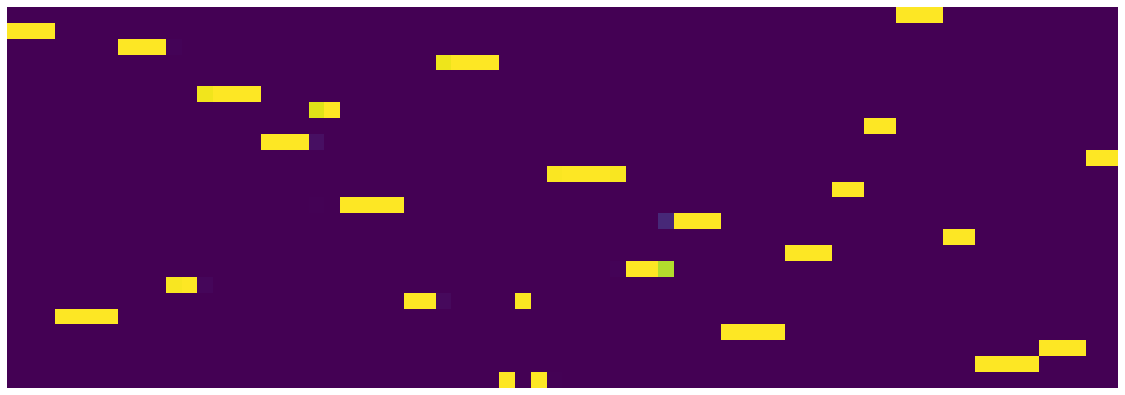

24 127 0.8719999999999999 0.49395383838564155


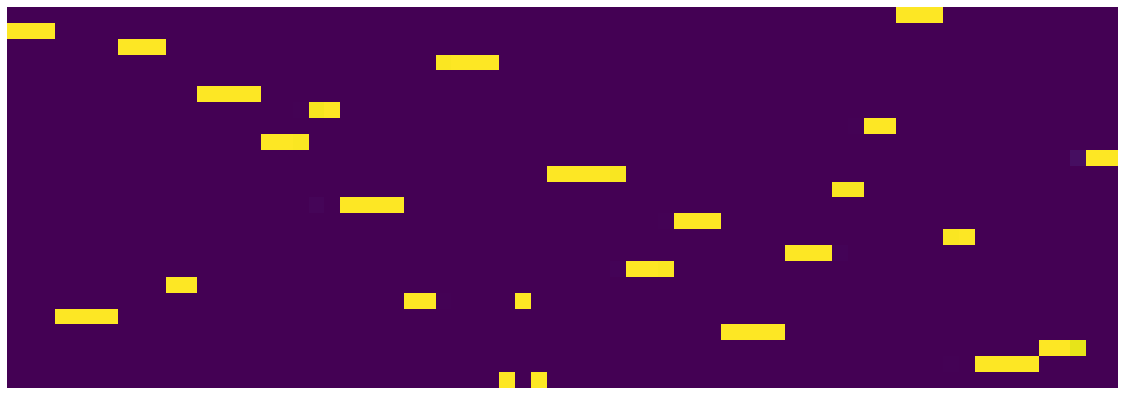

24 128 0.8709999999999999 0.4937520742416382


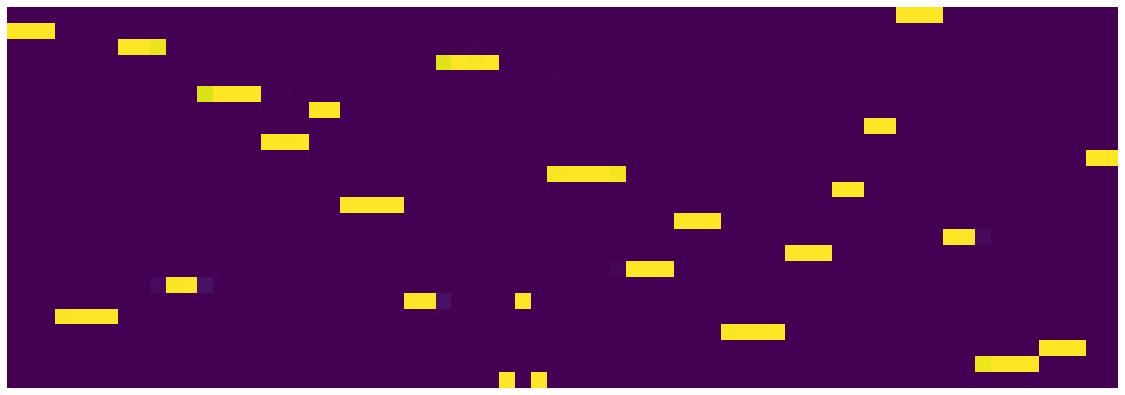

24 129 0.8699999999999999 0.4950242334976792


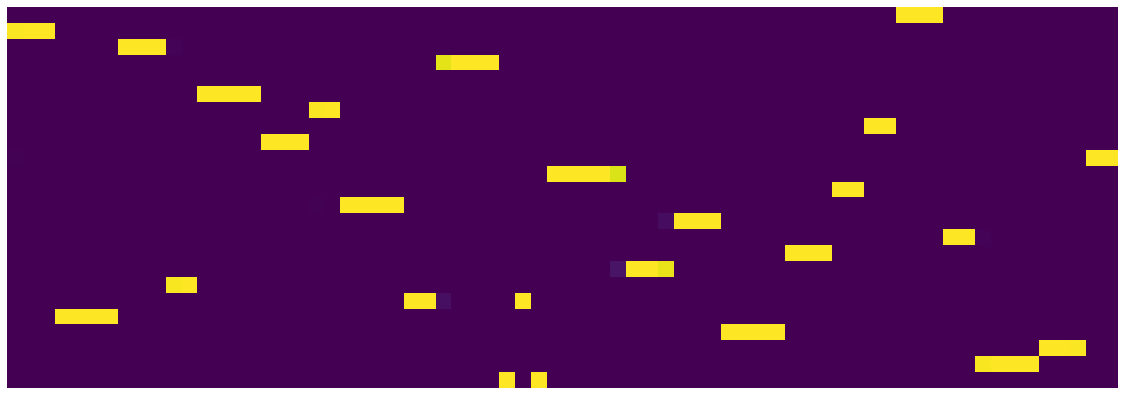

24 130 0.8689999999999999 0.4950682269409299


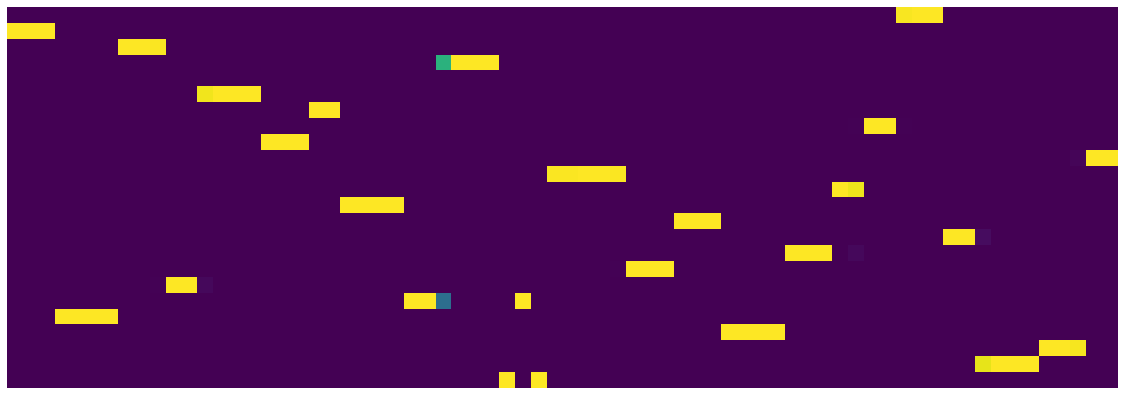

24 131 0.8679999999999999 0.4916007587686181


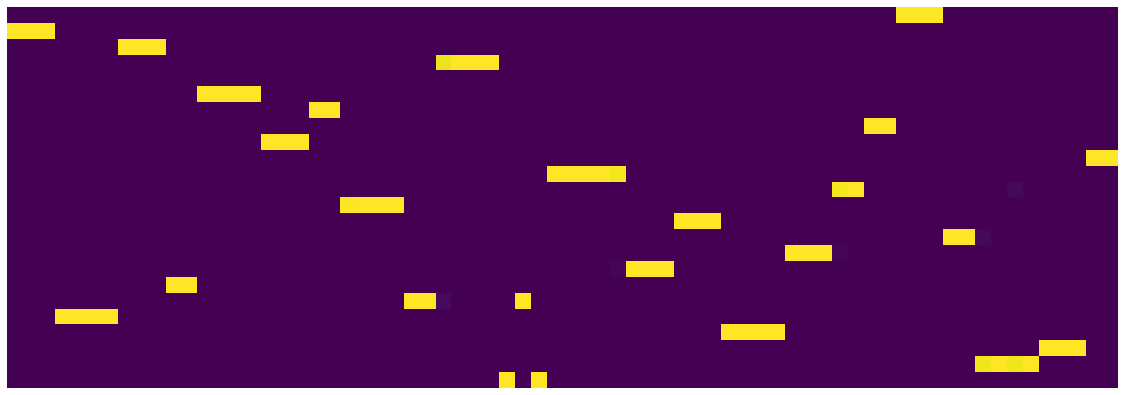

24 132 0.8669999999999999 0.4932273950427771


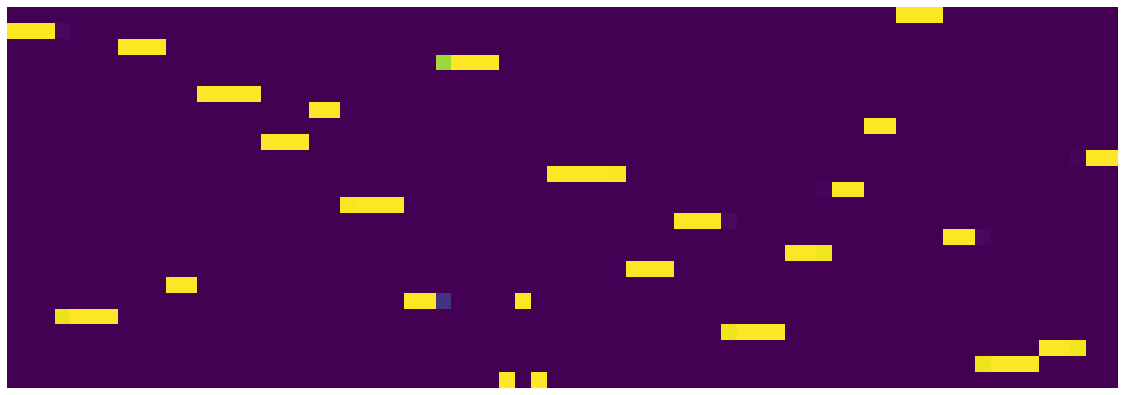

24 133 0.8659999999999999 0.49175838232040403


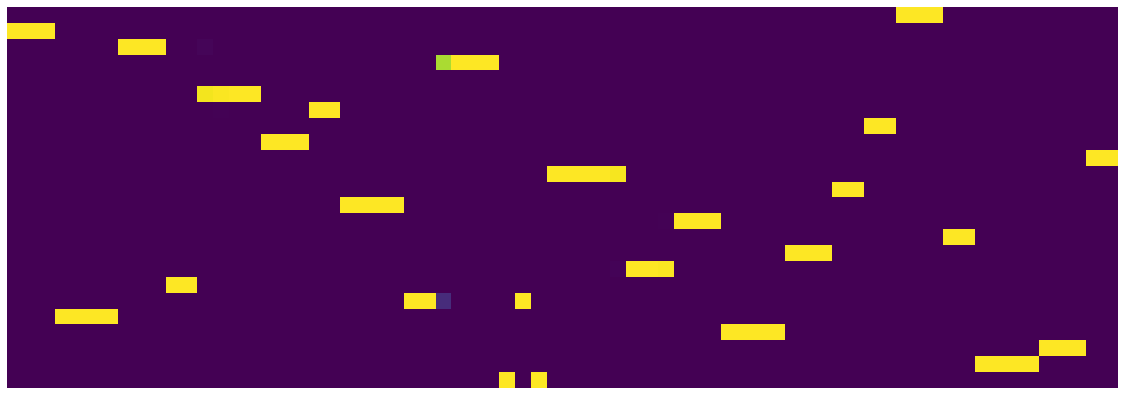

24 134 0.8649999999999999 0.49182643089443445


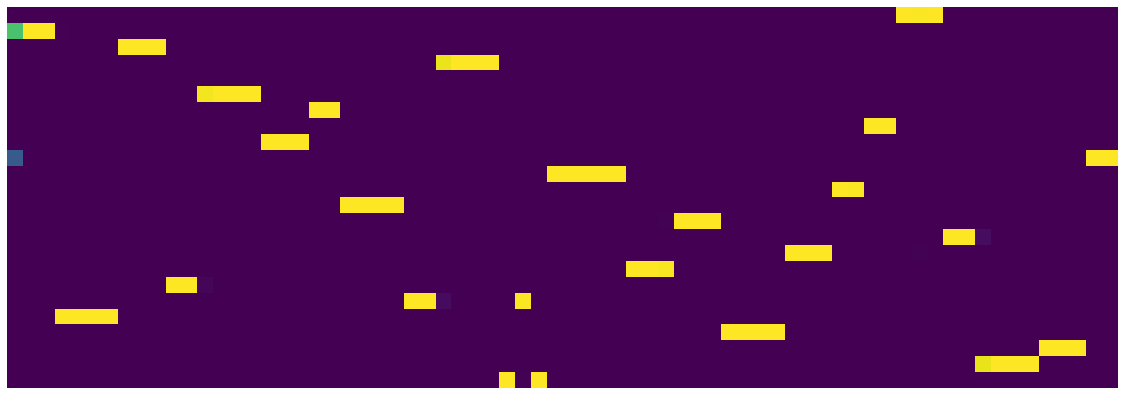

24 135 0.8639999999999999 0.49282991494983436


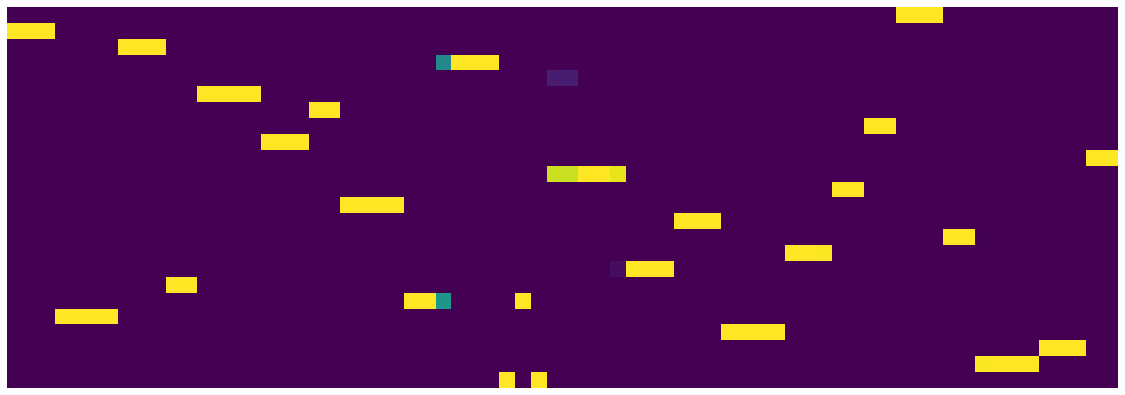

24 136 0.8629999999999999 0.49281185027211905


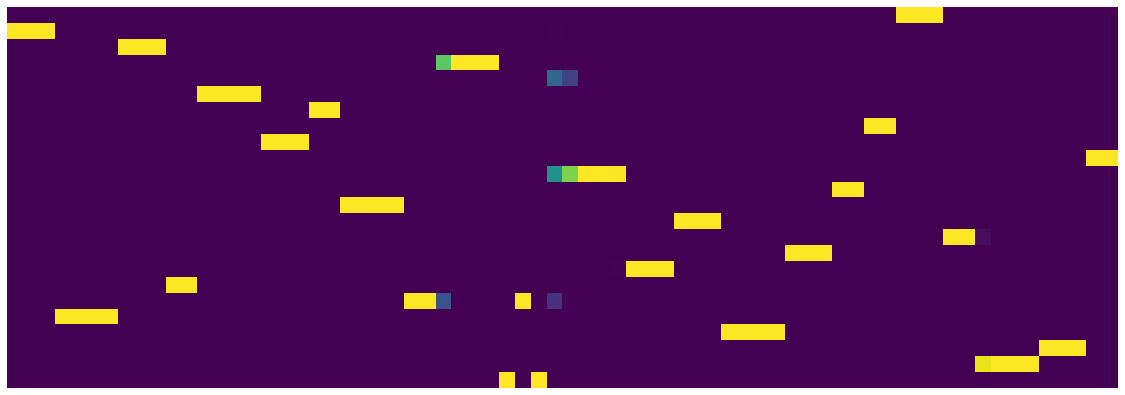

24 137 0.8619999999999999 0.4868884041905403


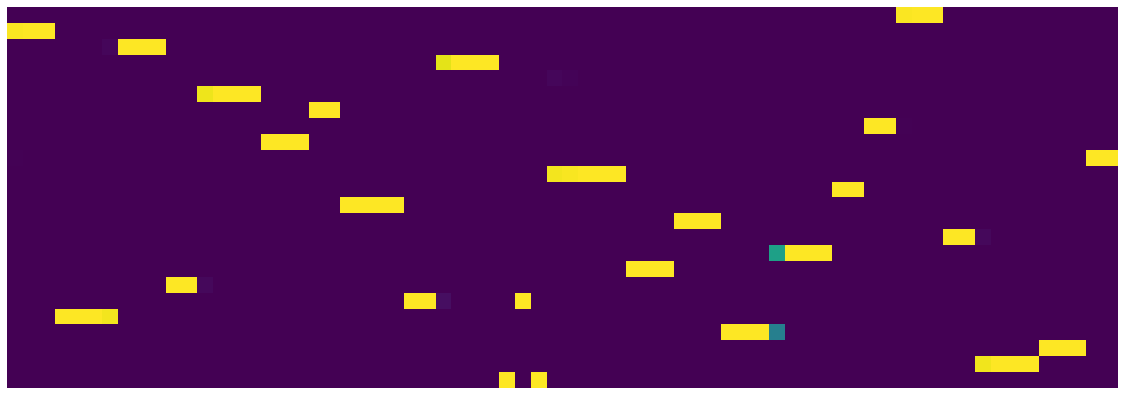

24 138 0.8609999999999999 0.48019036557525396


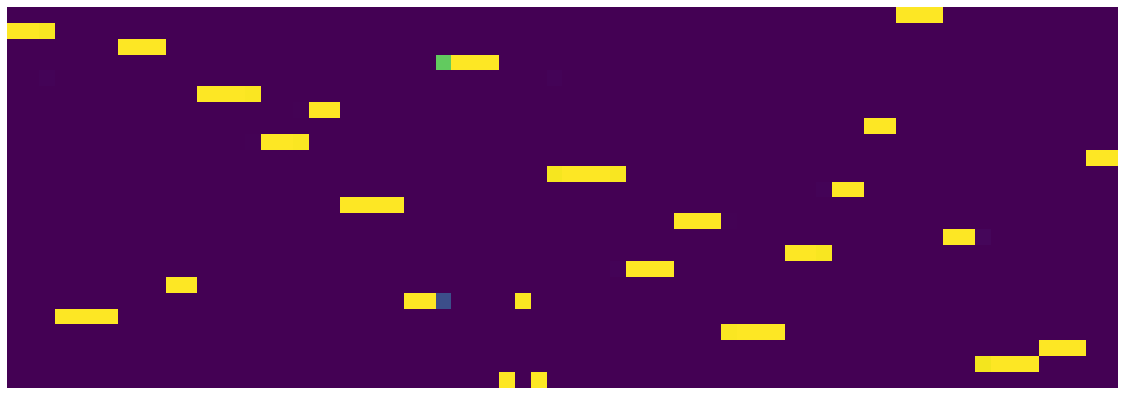

24 139 0.8599999999999999 0.47422778196632864


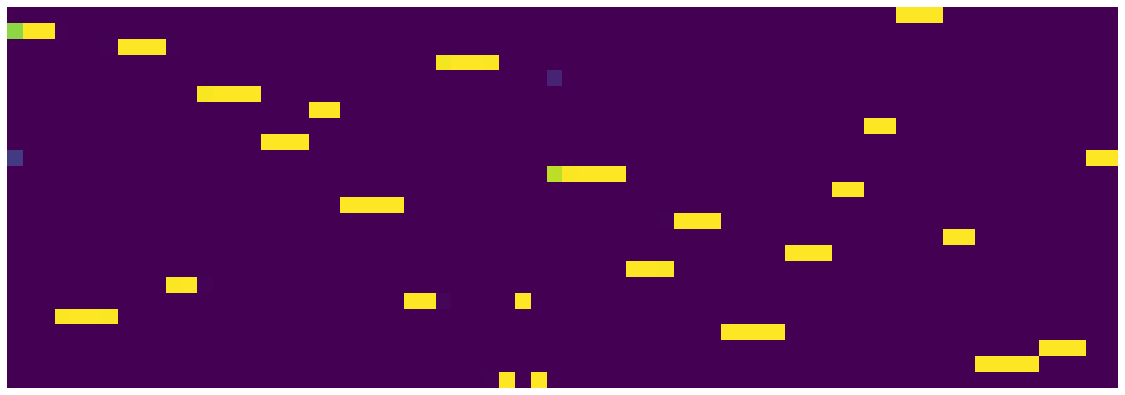

24 140 0.8589999999999999 0.4682368690147996


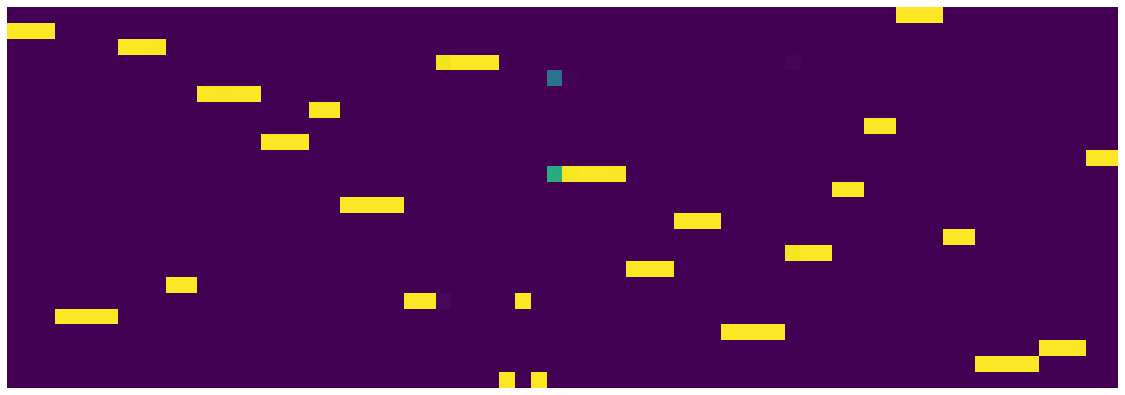

24 141 0.8579999999999999 0.4706194050610065


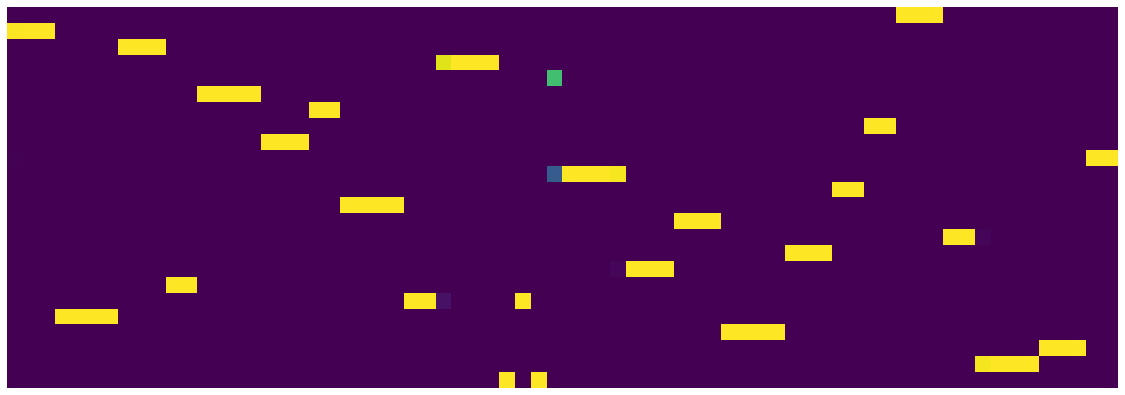

24 142 0.8569999999999999 0.4756822885945439


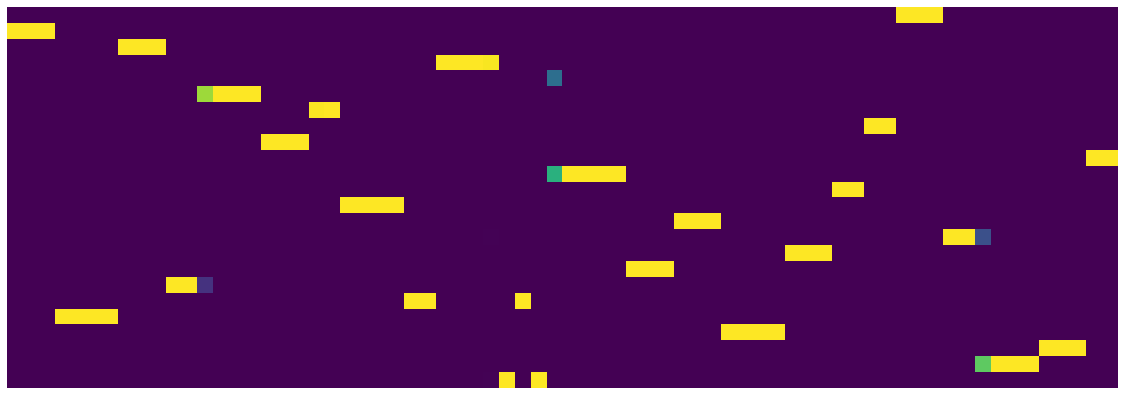

24 143 0.8559999999999999 0.46447138823568823


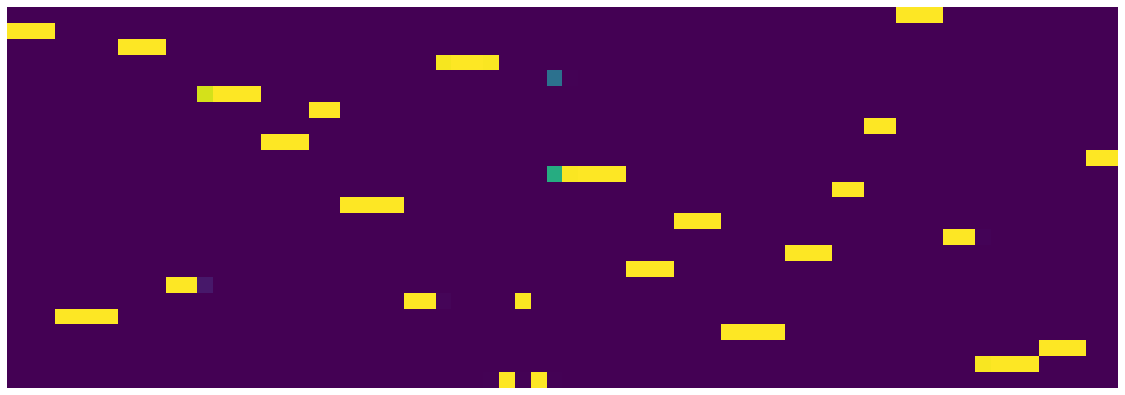

24 144 0.8549999999999999 0.46958818230777977


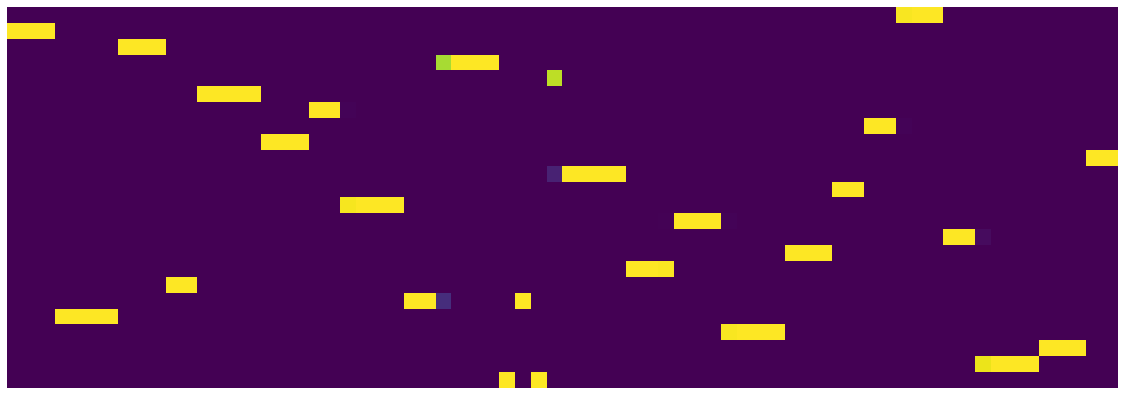

24 145 0.8539999999999999 0.46792891155928373


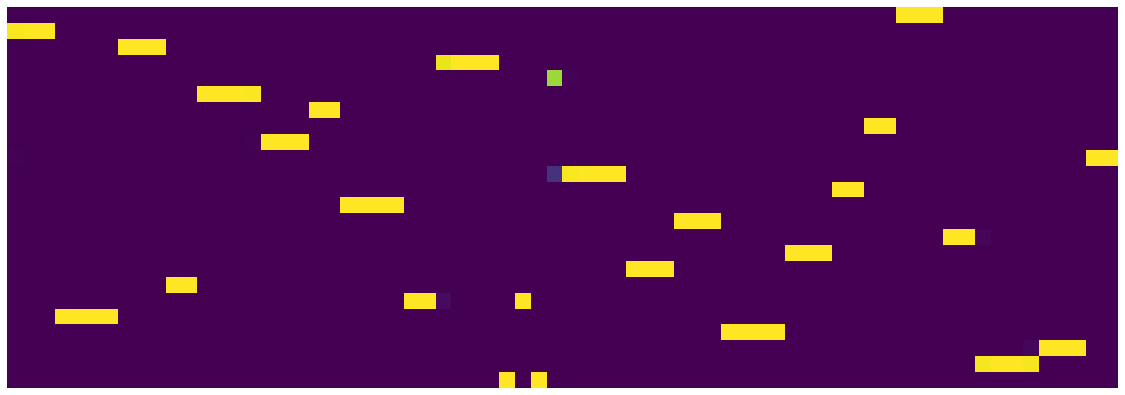

24 146 0.8529999999999999 0.4695903265848756


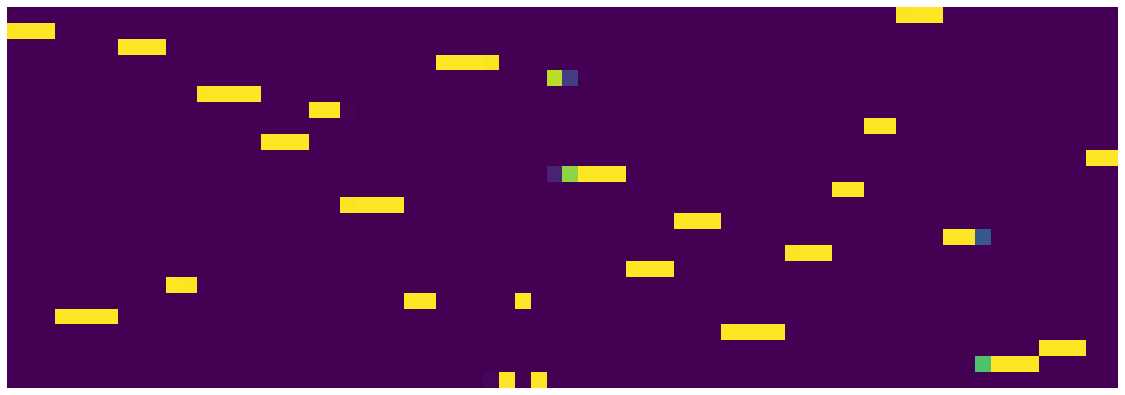

24 147 0.8519999999999999 0.462825539521873


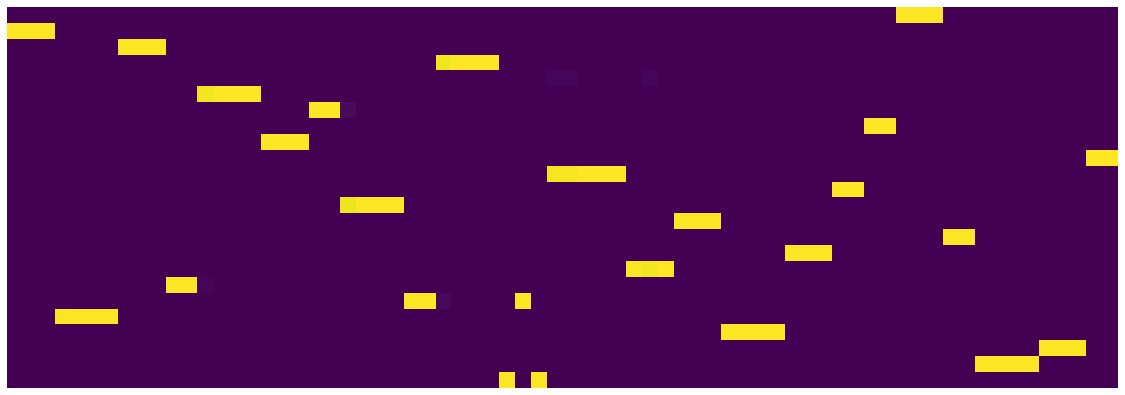

24 148 0.8509999999999999 0.4673774644732475


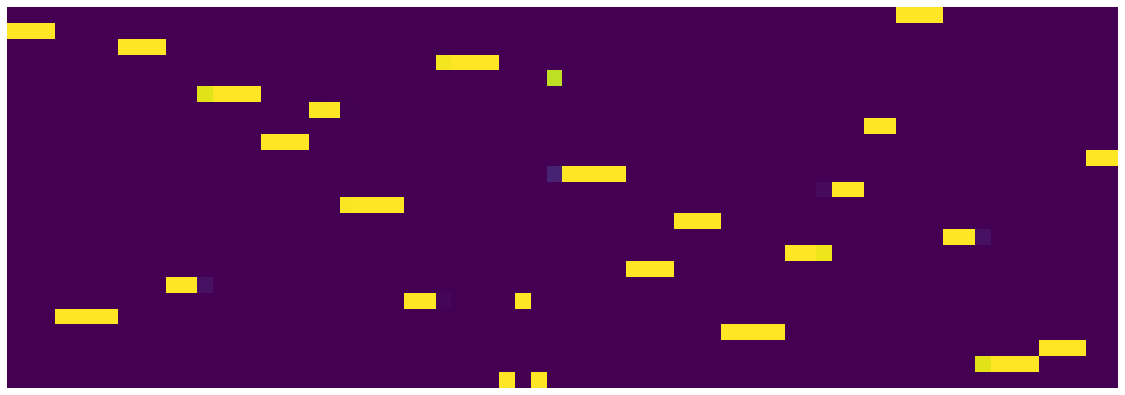

24 149 0.8499999999999999 0.4623744018375874


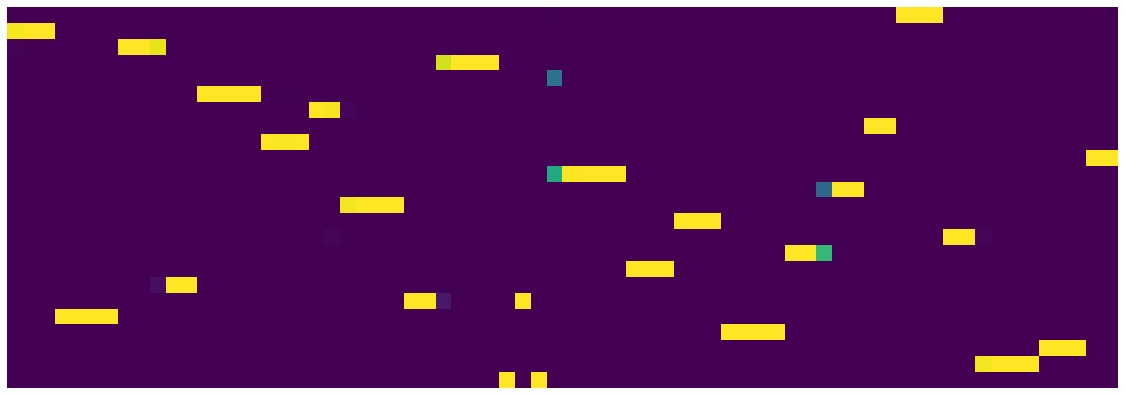

24 150 0.8489999999999999 0.4651902962476015


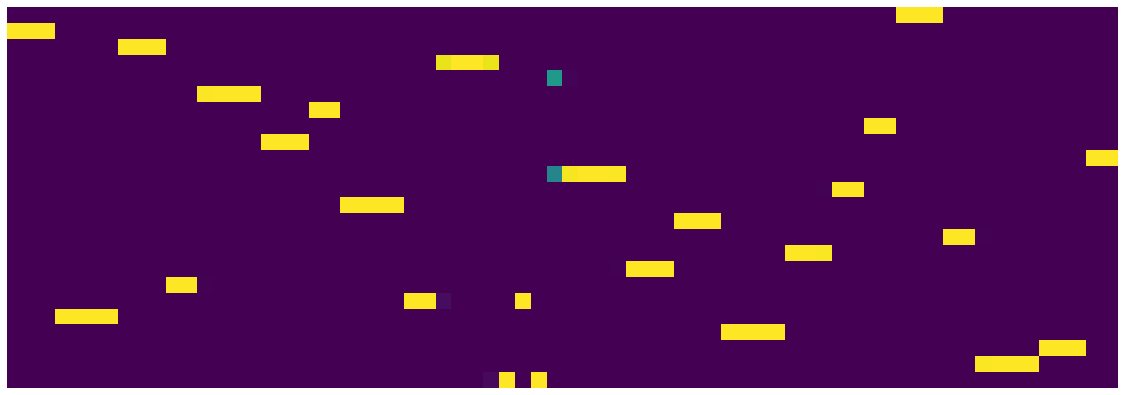

24 151 0.8479999999999999 0.462857230938971


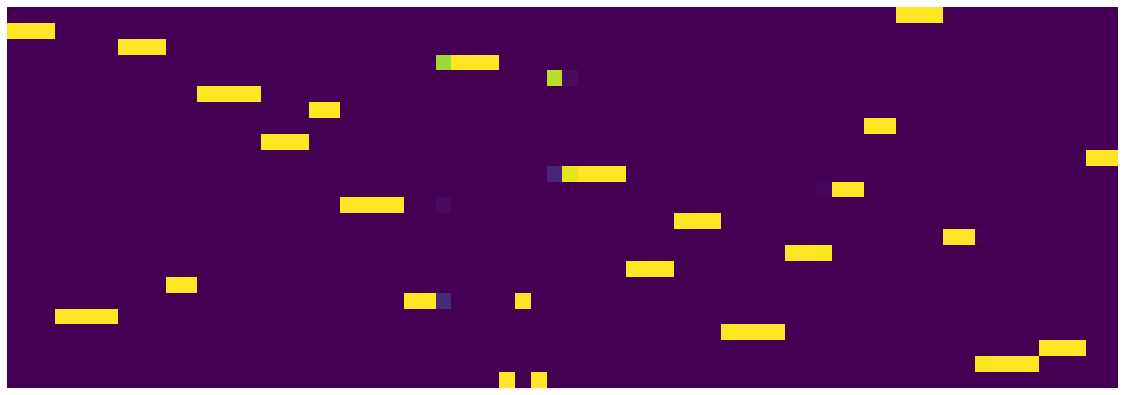

24 152 0.8469999999999999 0.46309545524418355


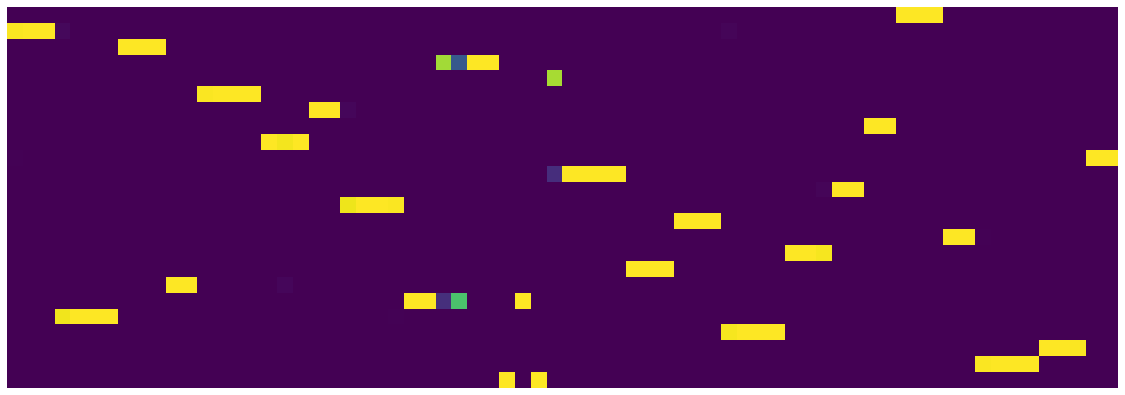

24 153 0.8459999999999999 0.46279980186372993


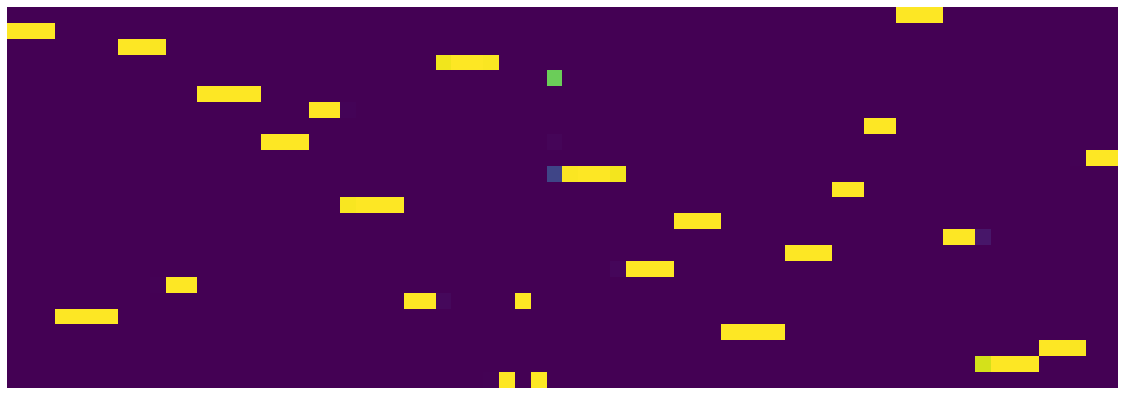

24 154 0.8449999999999999 0.46269856598228215


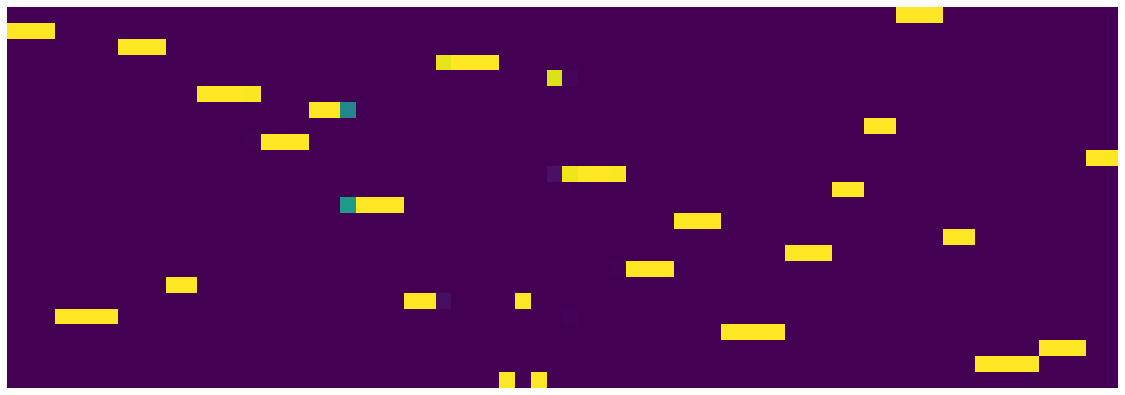

24 155 0.8439999999999999 0.46488109286874535


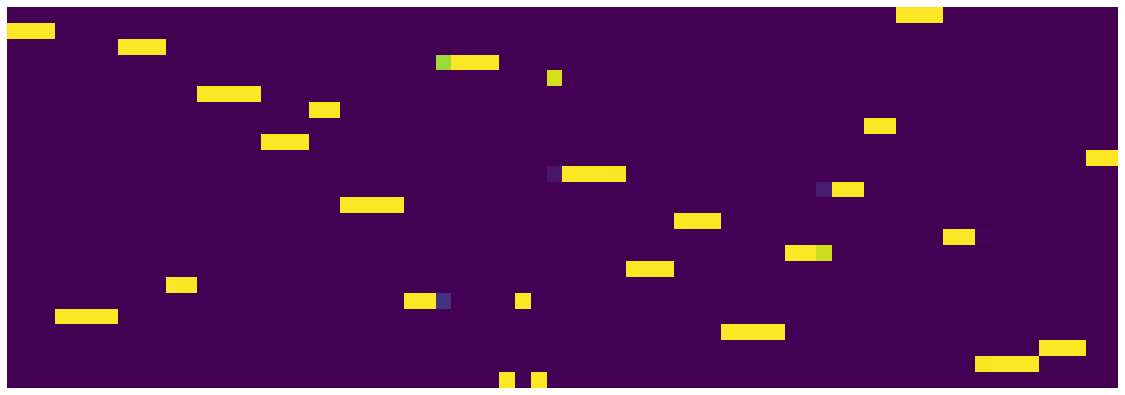

24 156 0.8429999999999999 0.462122805044055


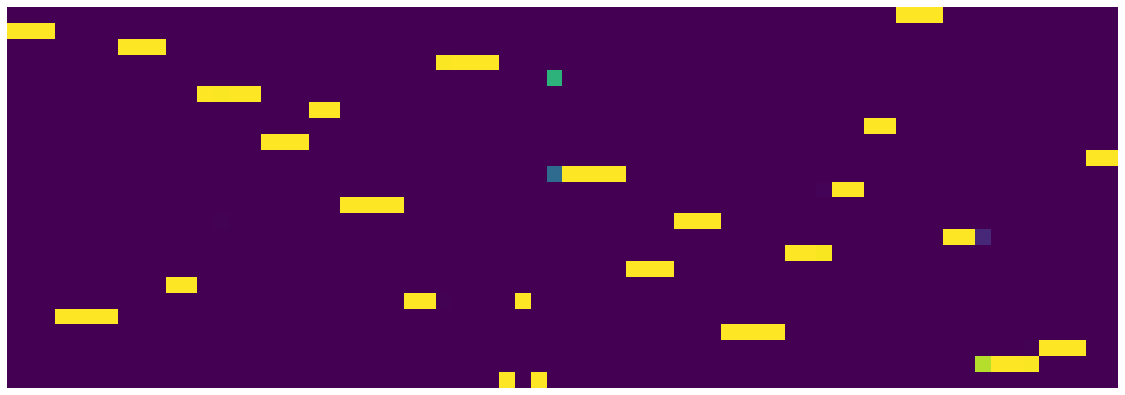

24 157 0.8419999999999999 0.46066812369972465


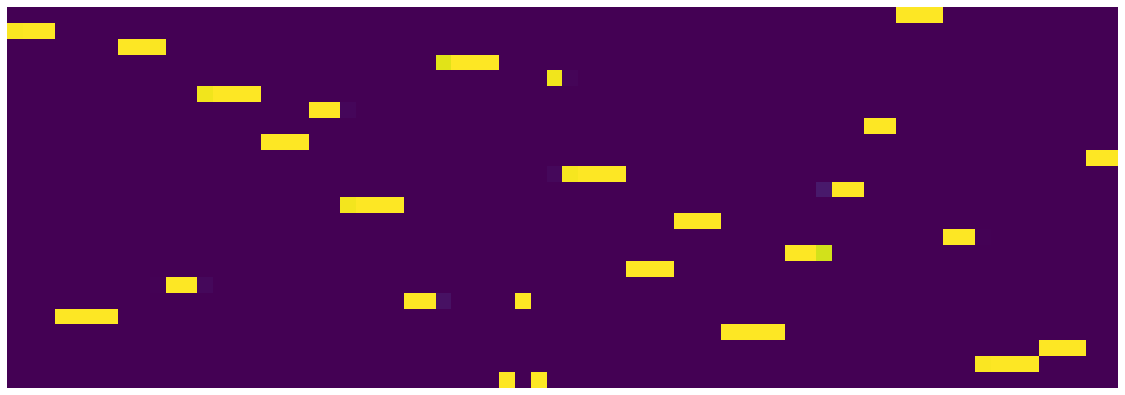

24 158 0.8409999999999999 0.46219429168850185


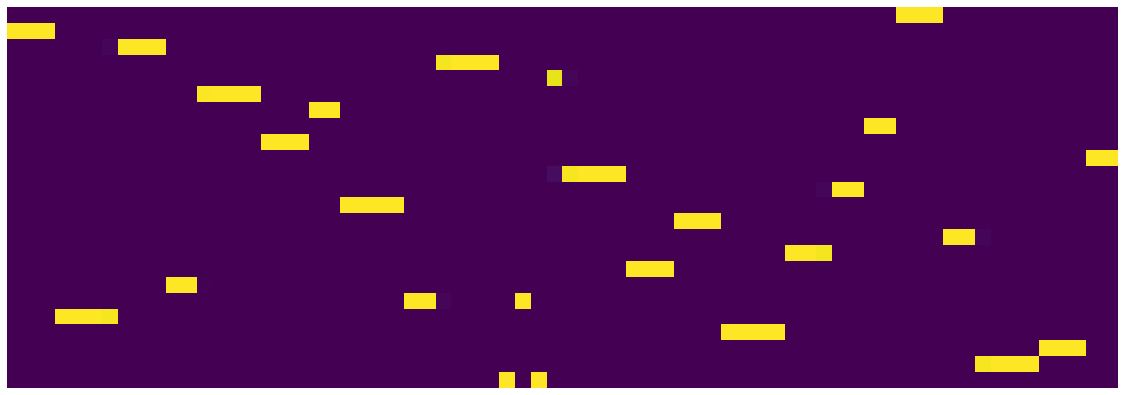

24 159 0.8399999999999999 0.46178043596446516


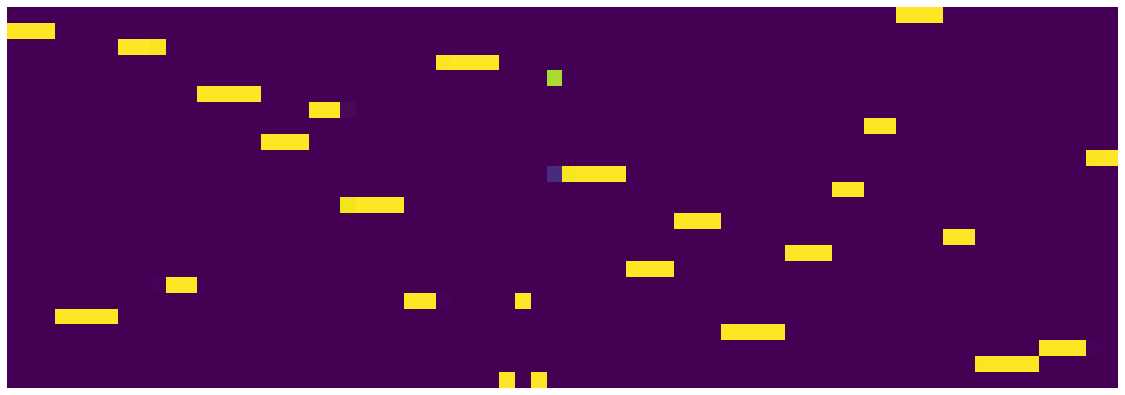

24 160 0.8389999999999999 0.46266193091869356


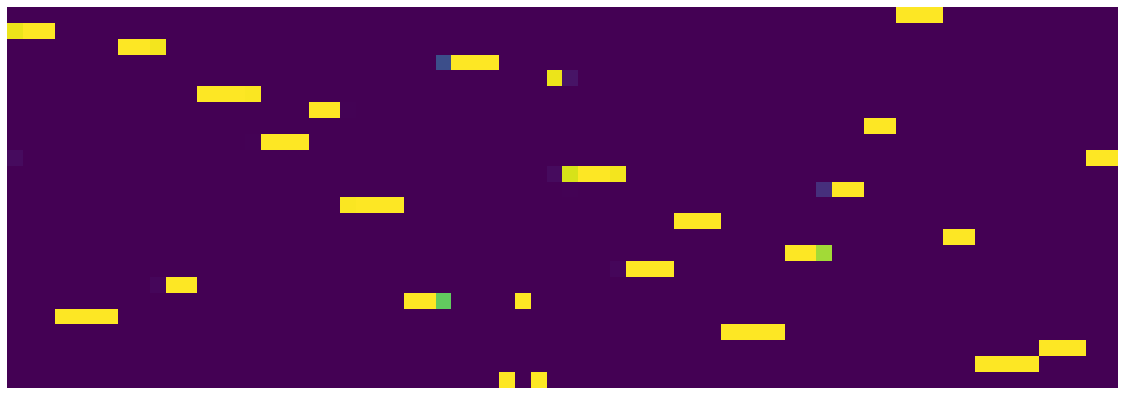

24 161 0.8379999999999999 0.46024028547108176


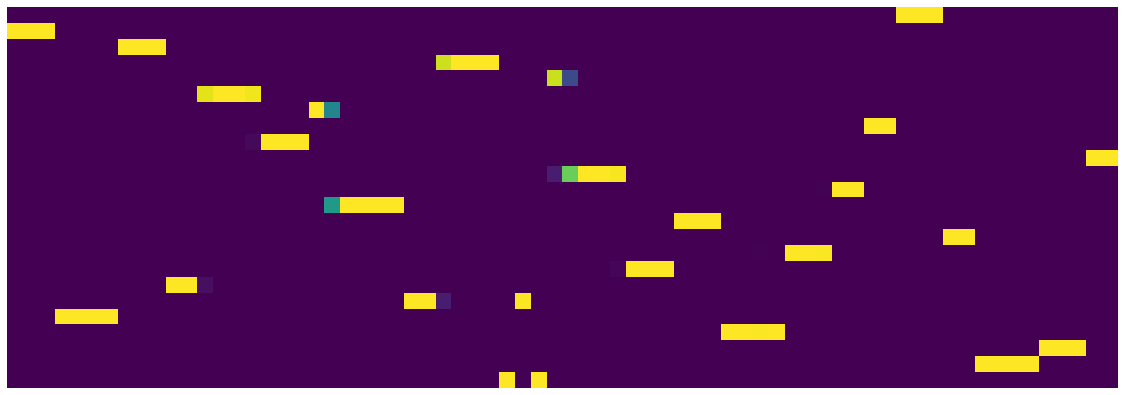

24 162 0.8369999999999999 0.46209842544049023


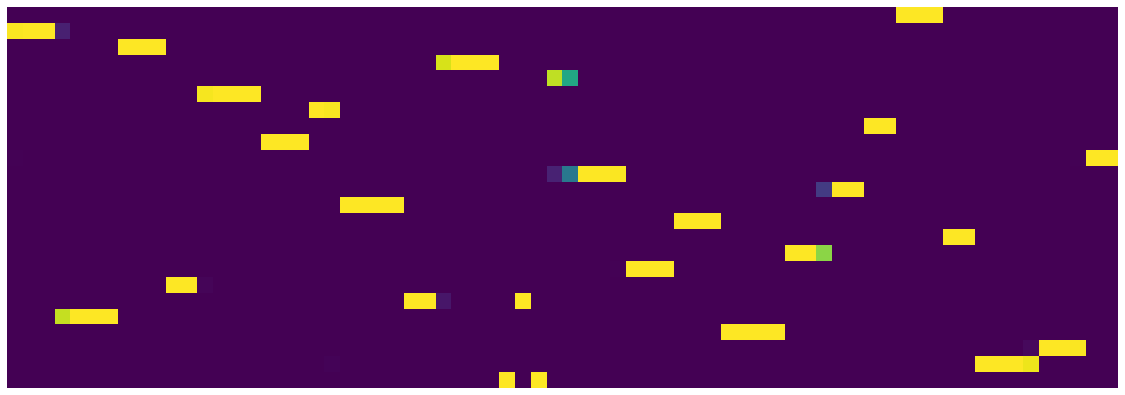

24 163 0.8359999999999999 0.46162510830909015


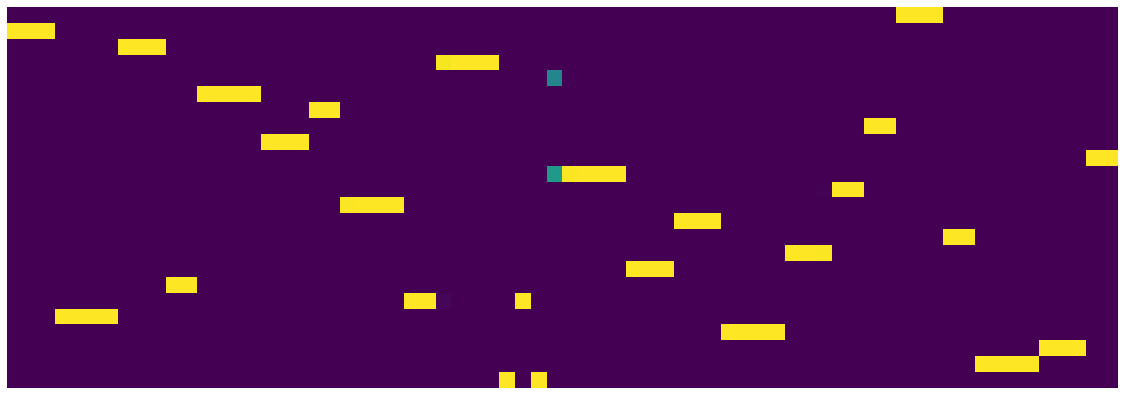

24 164 0.8349999999999999 0.46162669993937017


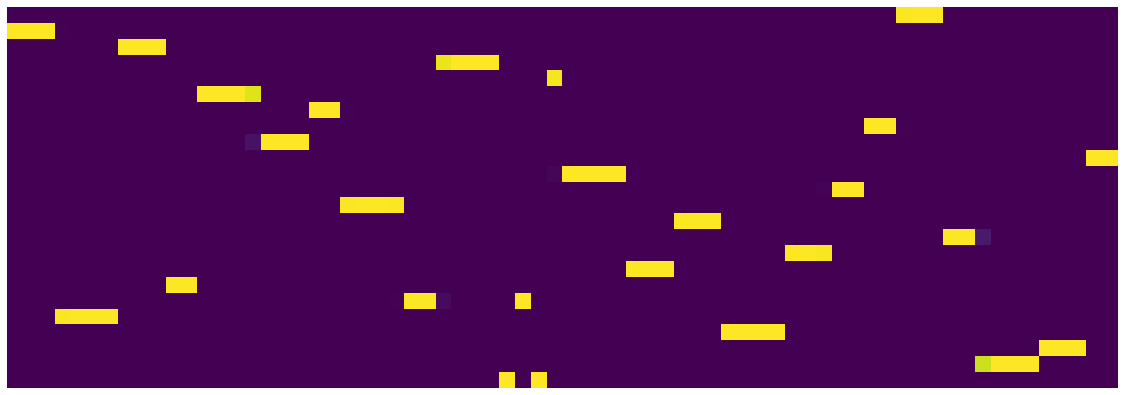

24 165 0.8339999999999999 0.4623263139277697


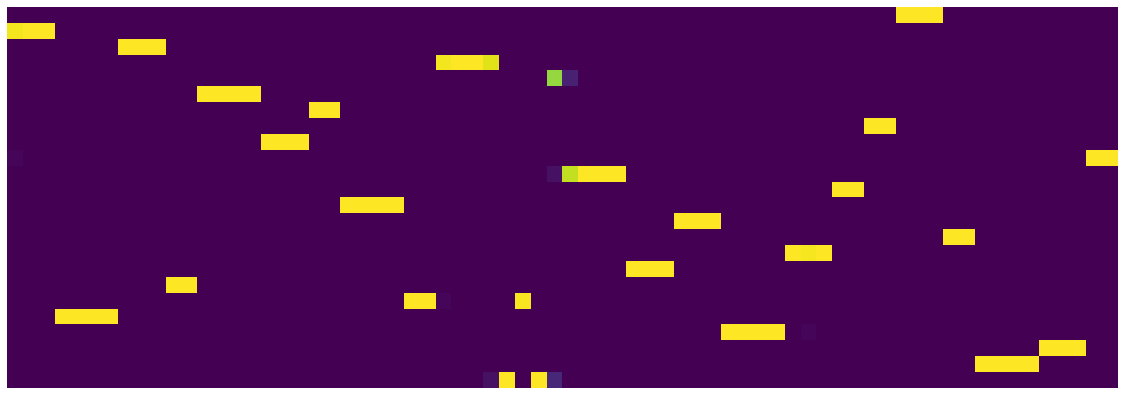

24 166 0.8329999999999999 0.4603940110653639


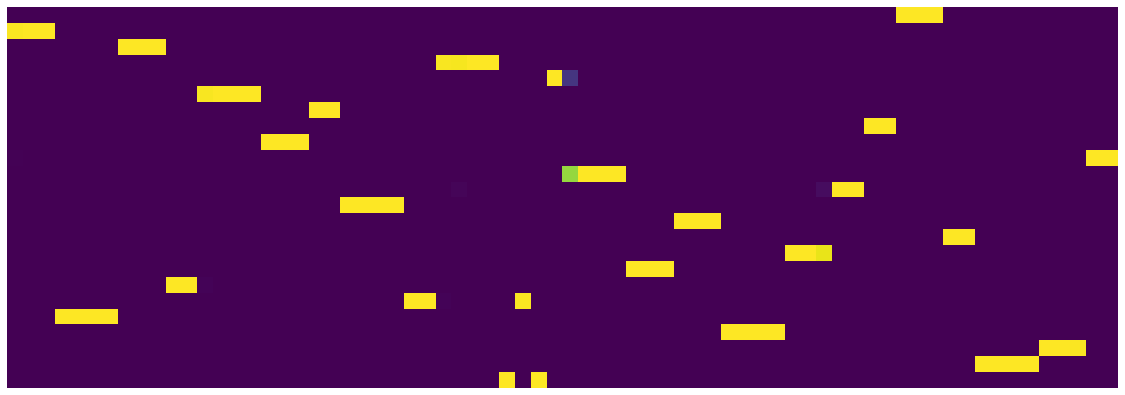

24 167 0.8319999999999999 0.4645802674815059


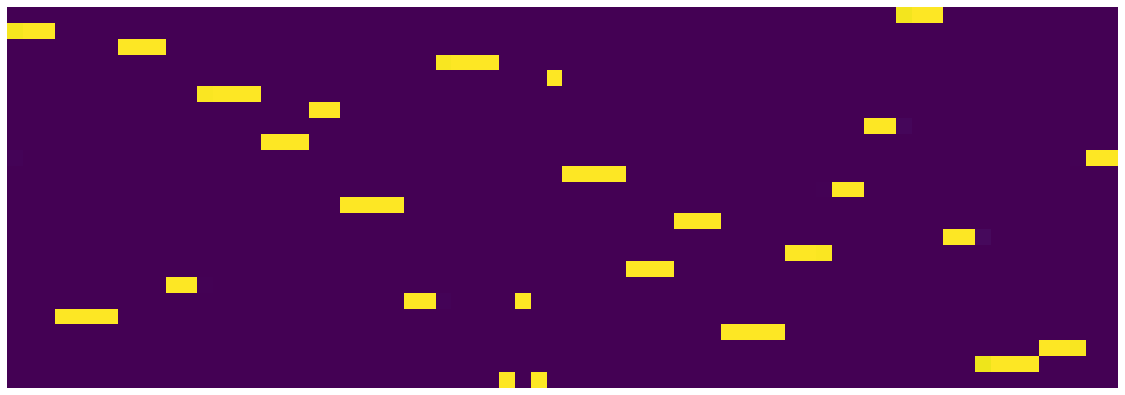

24 168 0.8309999999999998 0.46112681850790976


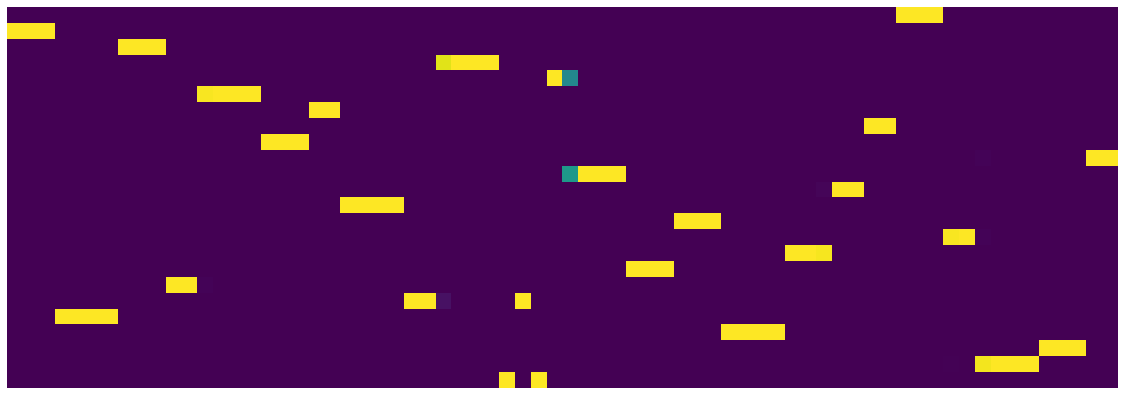

24 169 0.8299999999999998 0.46222826596349476


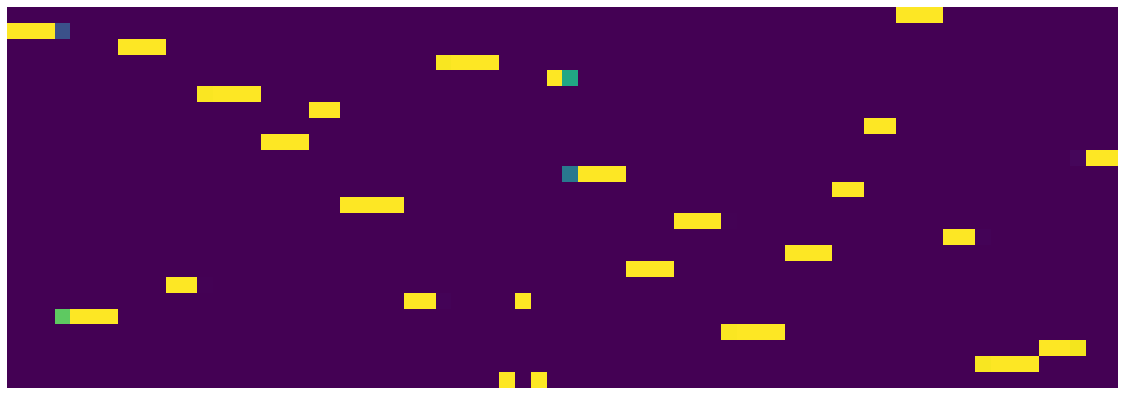

24 170 0.8289999999999998 0.4615142190828919


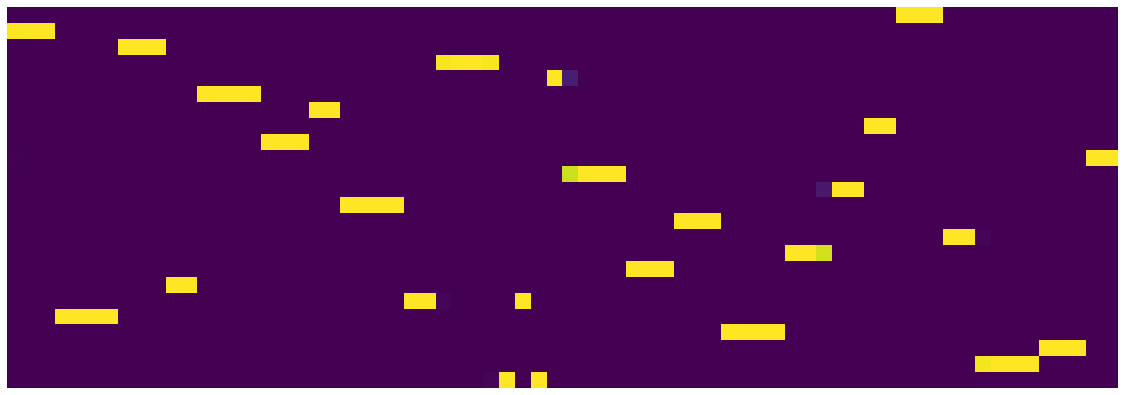

24 171 0.8279999999999998 0.4607658876106143


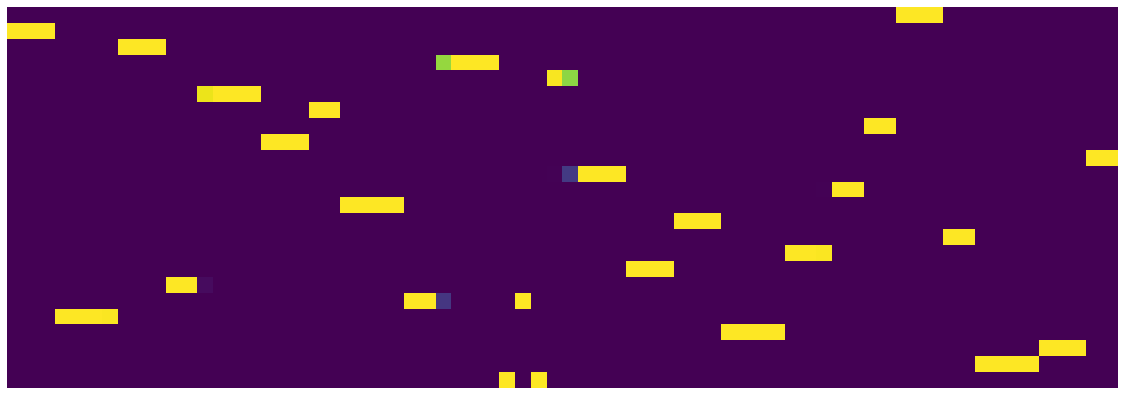

24 172 0.8269999999999998 0.45954463072121143


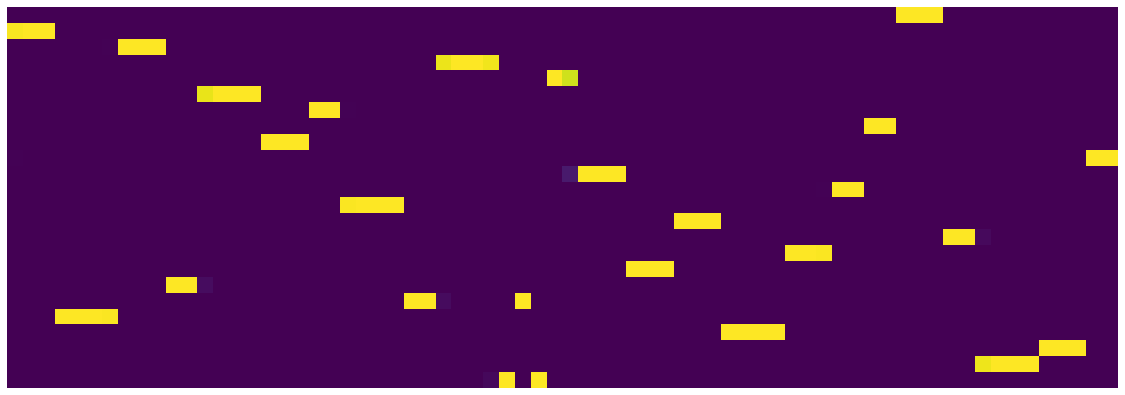

24 173 0.8259999999999998 0.46240195389837024


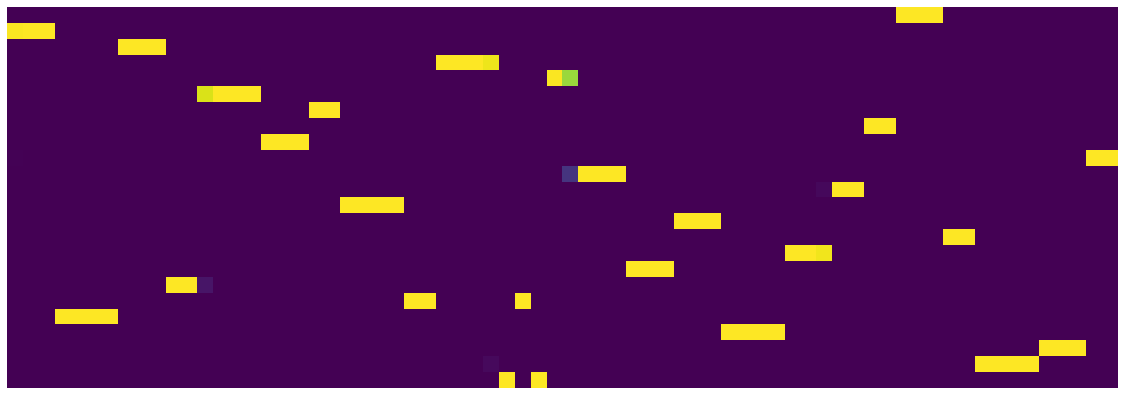

24 174 0.8249999999999998 0.45884687453508377


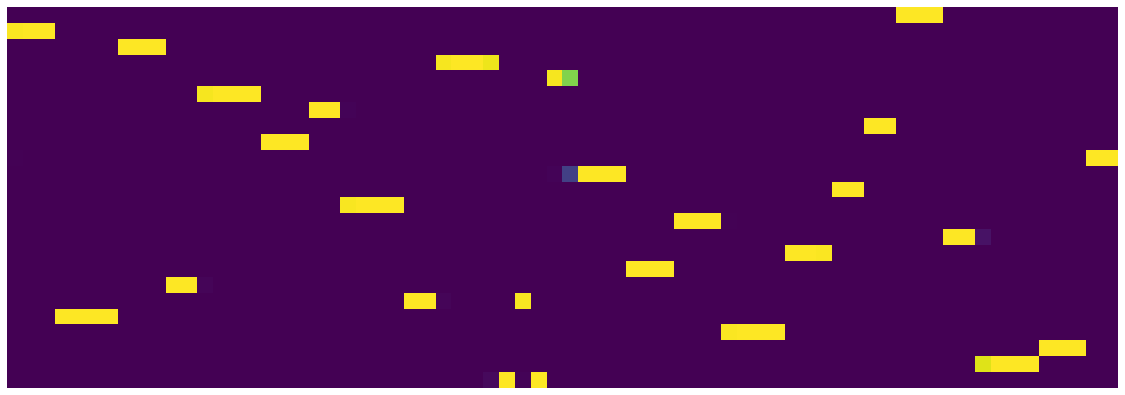

24 175 0.8239999999999998 0.45755794886499646


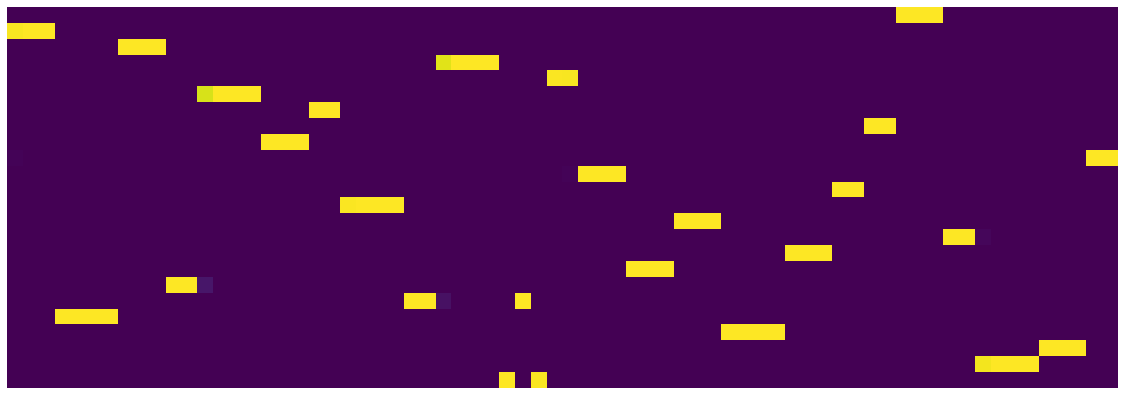

24 176 0.8229999999999998 0.4596484899520874


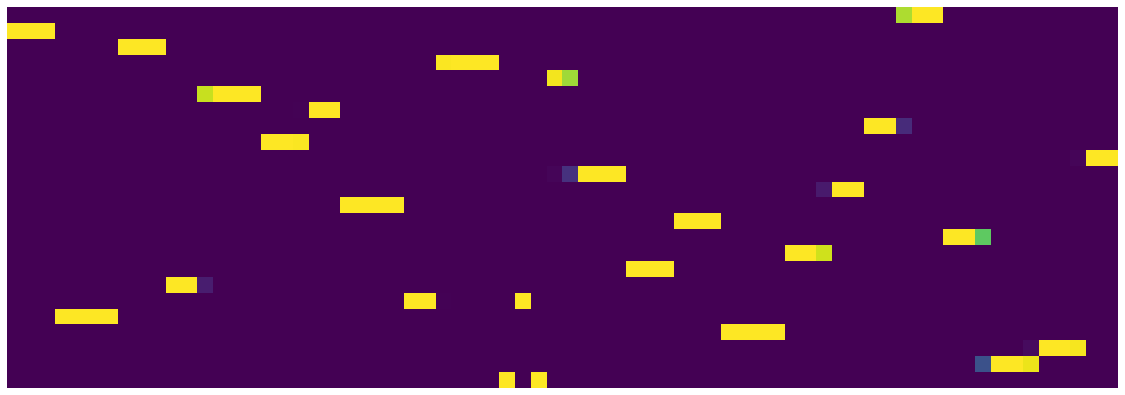

24 177 0.8219999999999998 0.45653296876698735


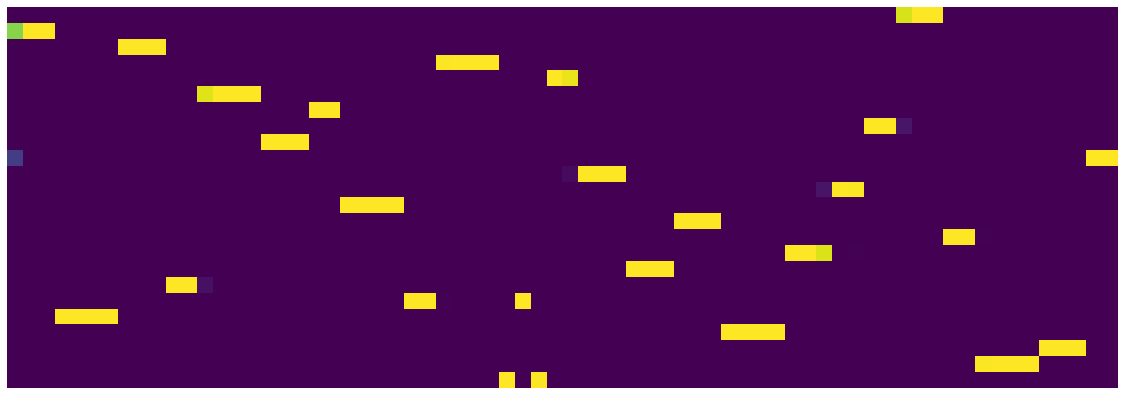

24 178 0.8209999999999998 0.45782112535089253


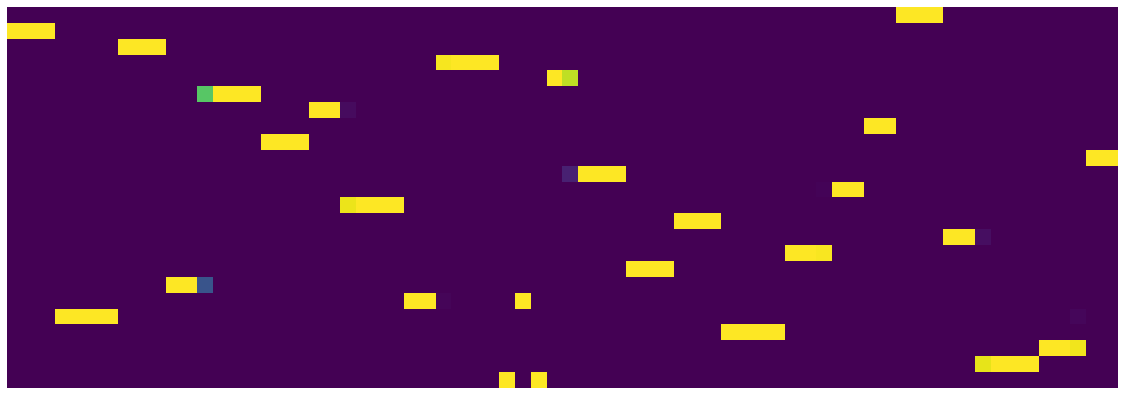

24 179 0.8199999999999998 0.4576480722054839


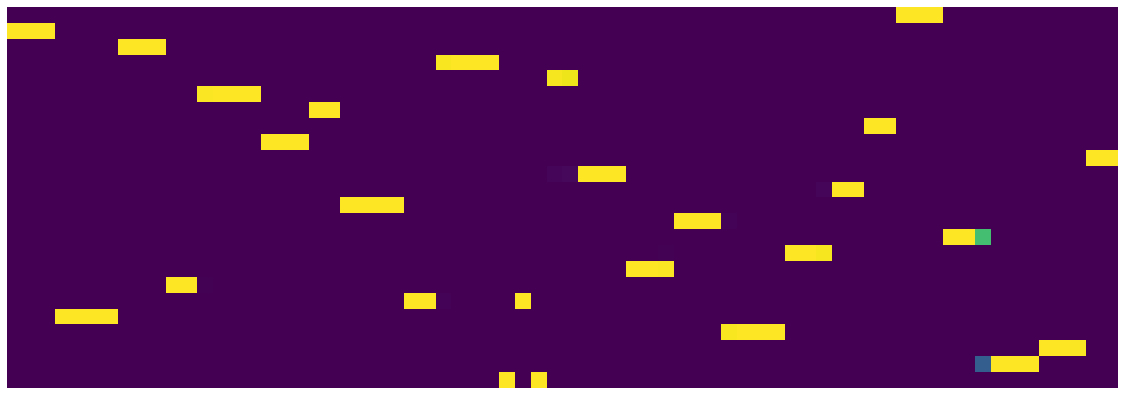

24 180 0.8189999999999998 0.45740091931074855


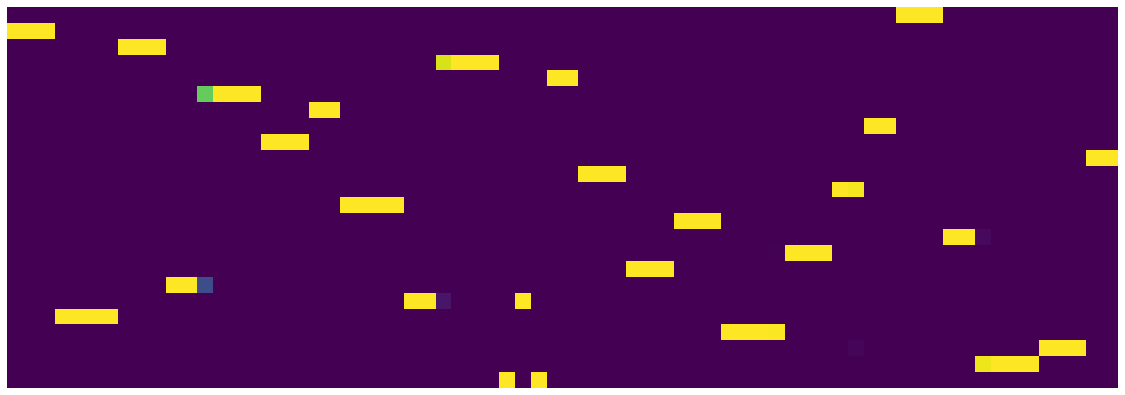

24 181 0.8179999999999998 0.4552062161266804


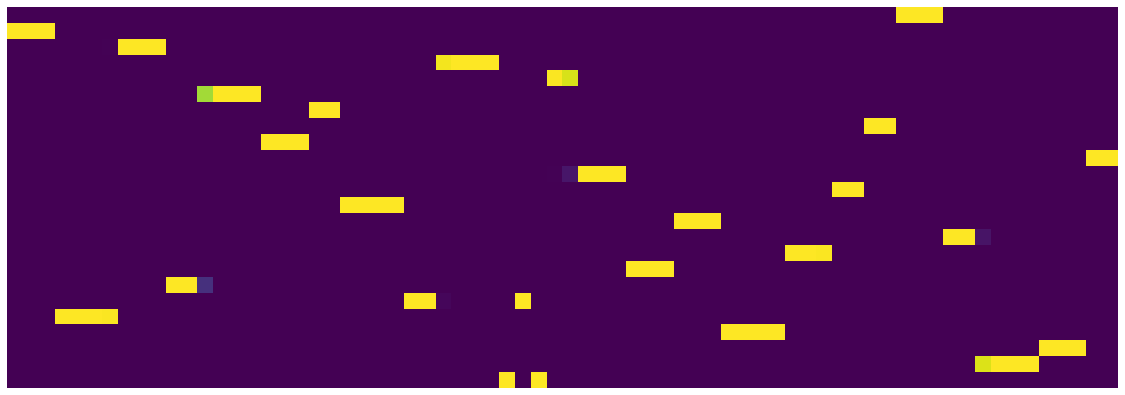

24 182 0.8169999999999998 0.45583006348460914


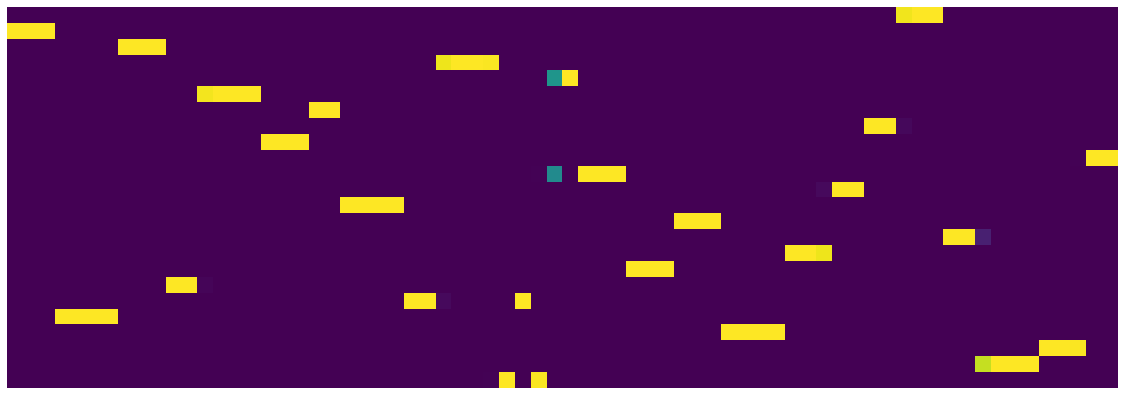

24 183 0.8159999999999998 0.4559411874040961


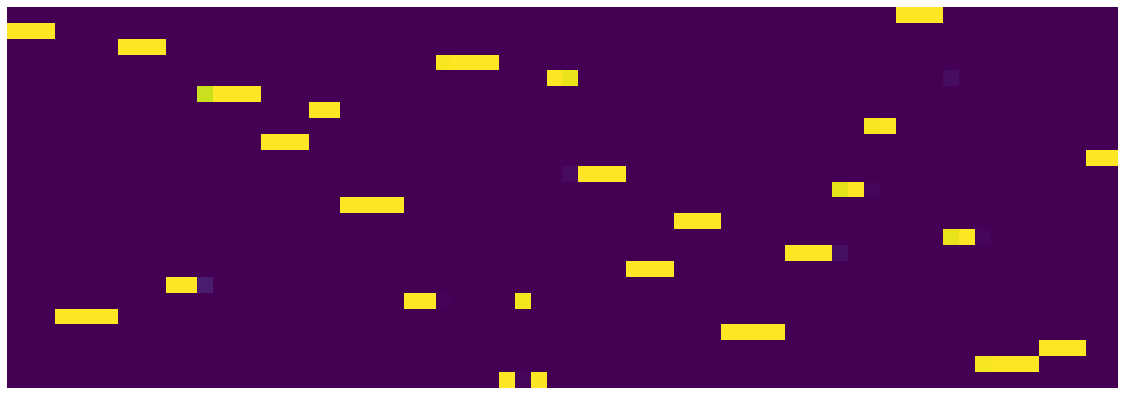

24 184 0.8149999999999998 0.45675394386053086


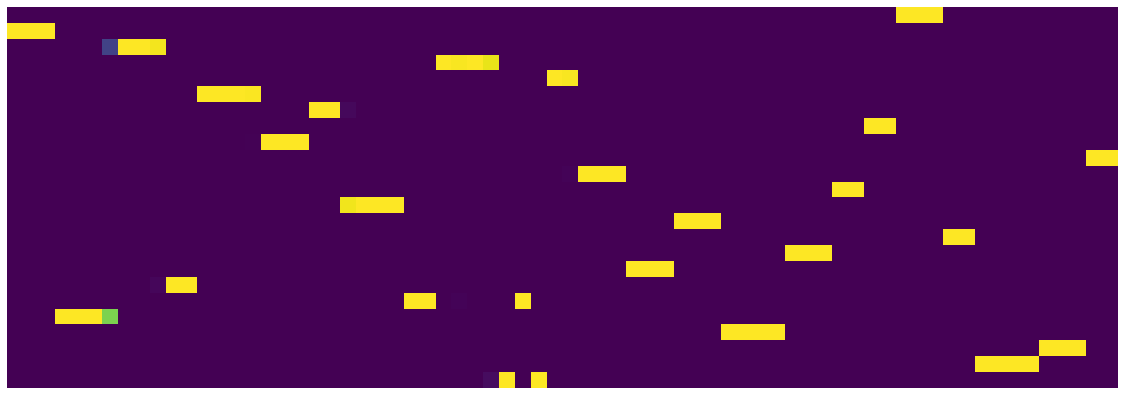

24 185 0.8139999999999998 0.45774172730743884


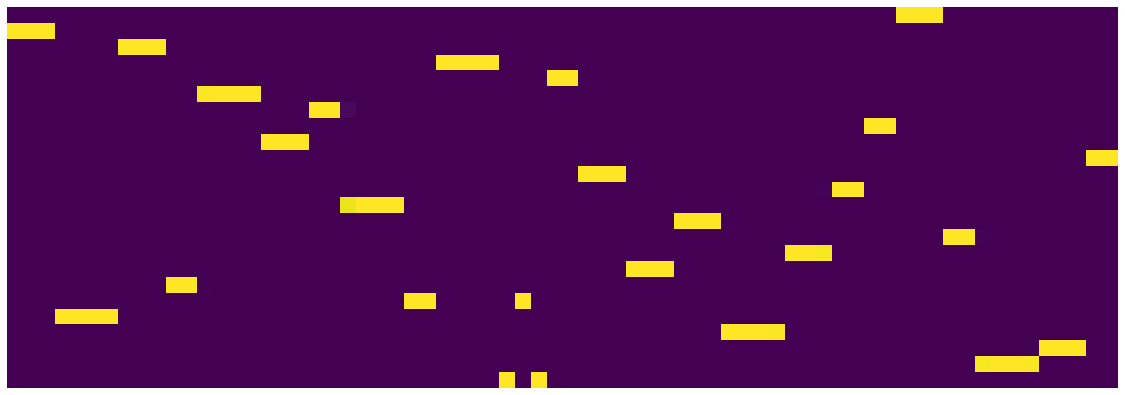

24 186 0.8129999999999998 0.45711000040173533


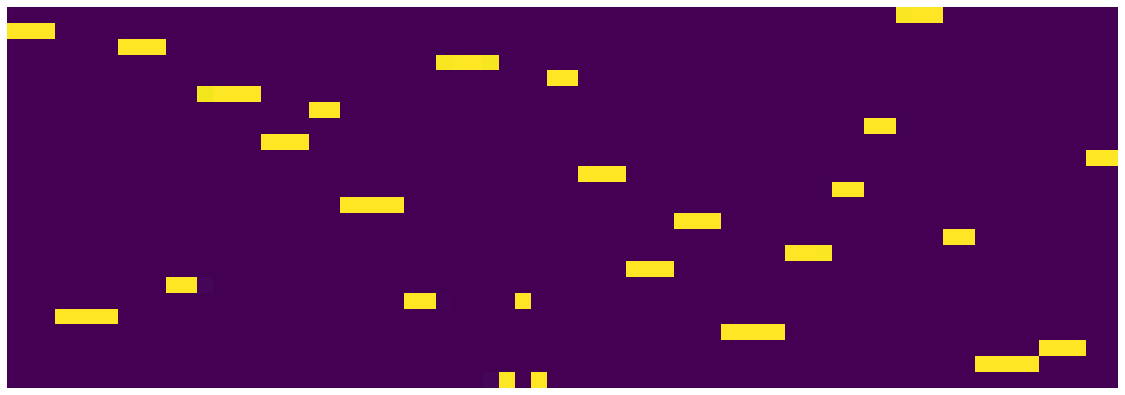

24 187 0.8119999999999998 0.4583141352981329


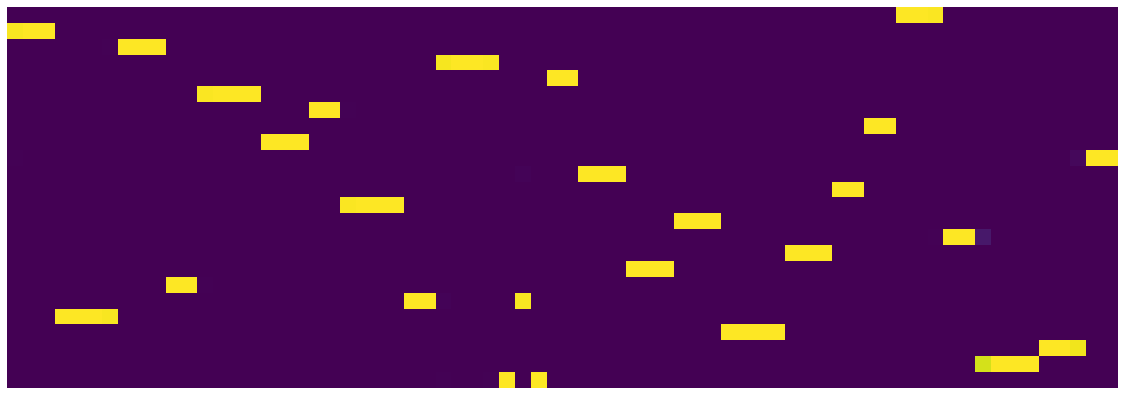

24 188 0.8109999999999998 0.45506252311170103


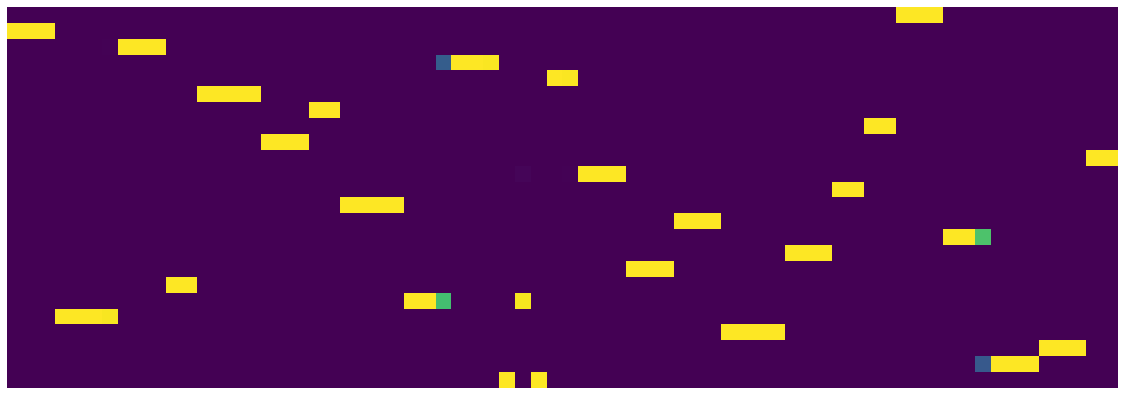

24 189 0.8099999999999998 0.4566495791077614


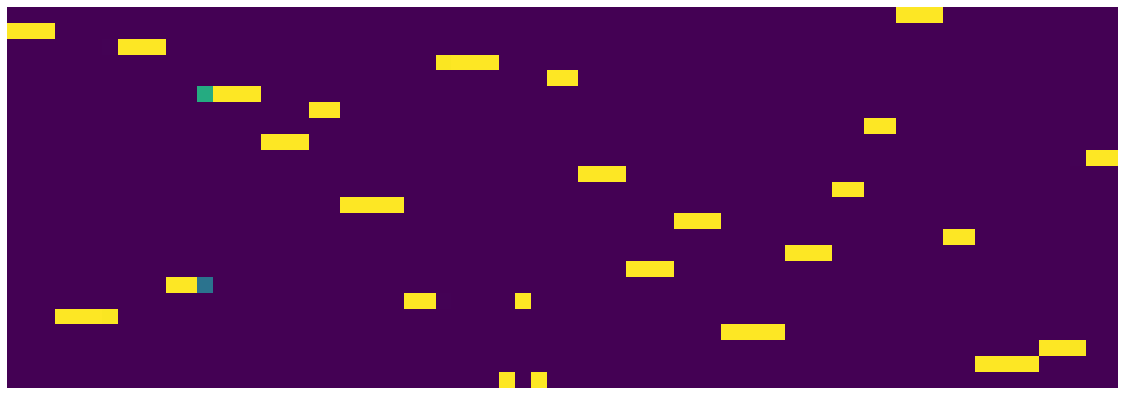

24 190 0.8089999999999998 0.4559414517134428


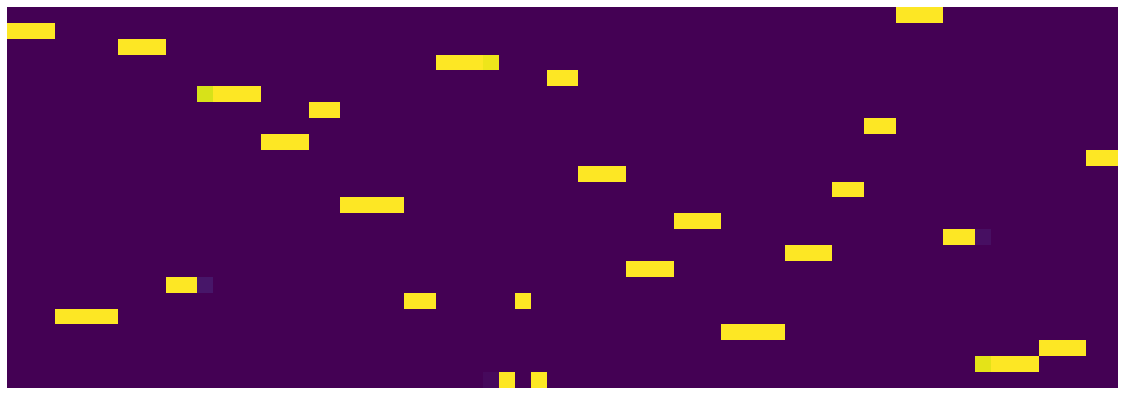

24 191 0.8079999999999998 0.45498611498624086


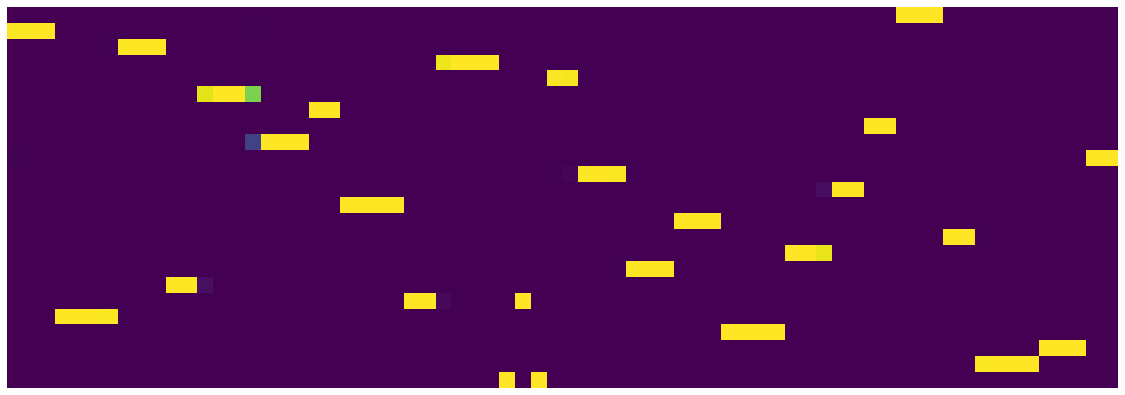

24 192 0.8069999999999998 0.454698901809752


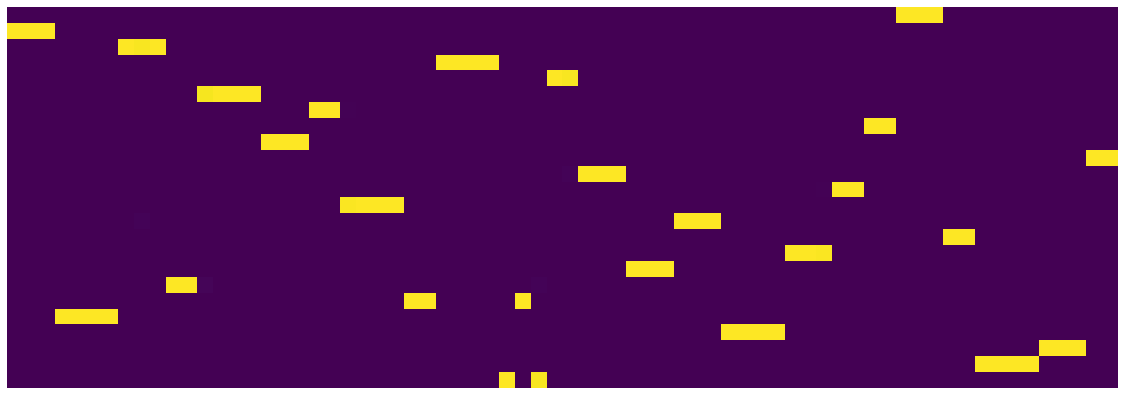

24 193 0.8059999999999998 0.45662157498300077


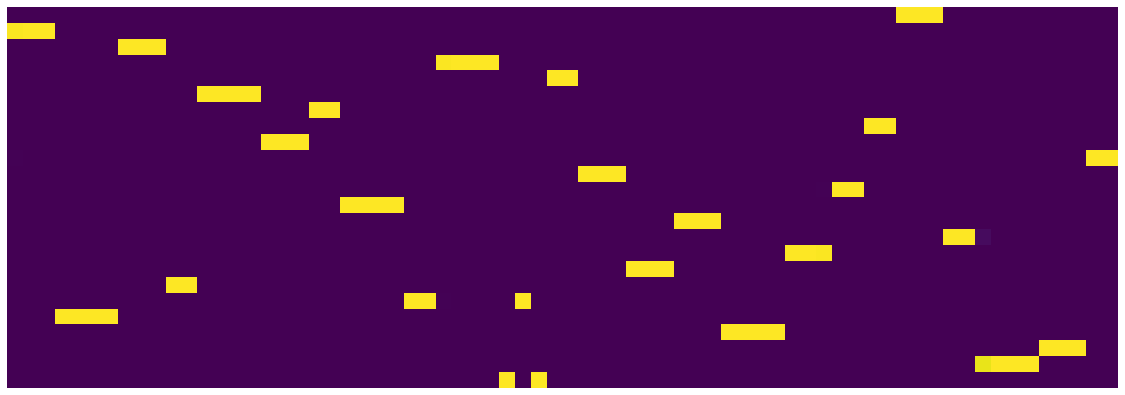

24 194 0.8049999999999998 0.454935435578227


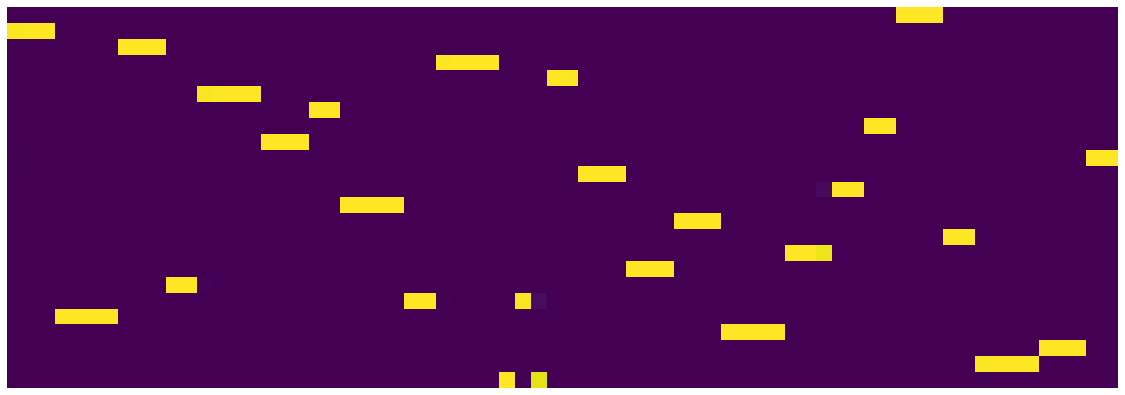

24 195 0.8039999999999998 0.4555102776736021


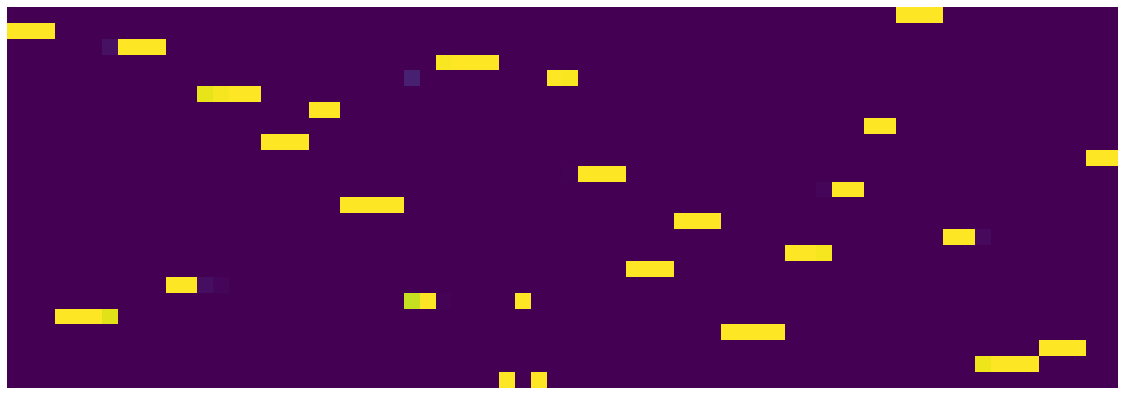

24 196 0.8029999999999998 0.45617021806538105


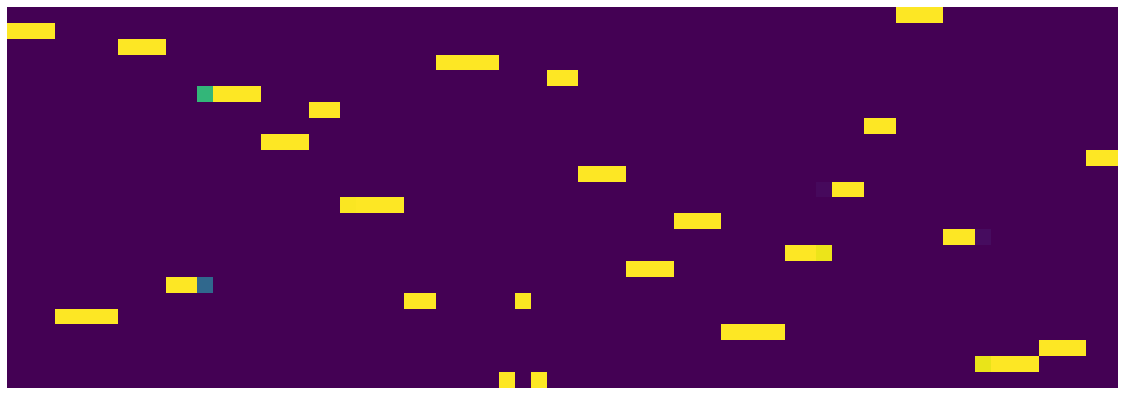

24 197 0.8019999999999998 0.4553478492423892


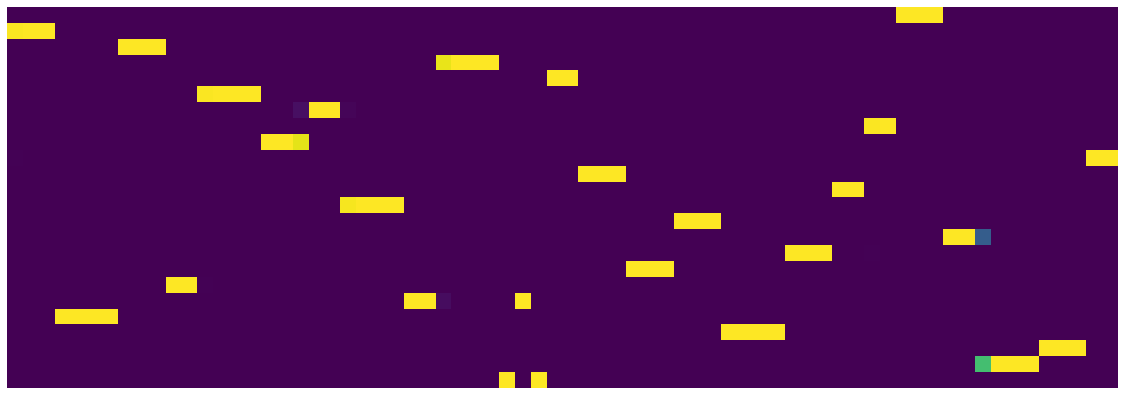

24 198 0.8009999999999998 0.454981392249465


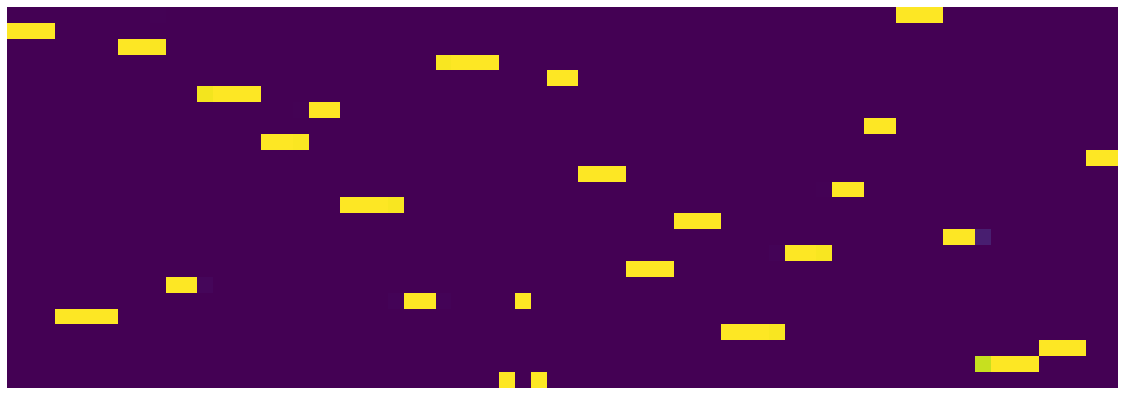

24 199 0.7999999999999998 0.45580817982554434


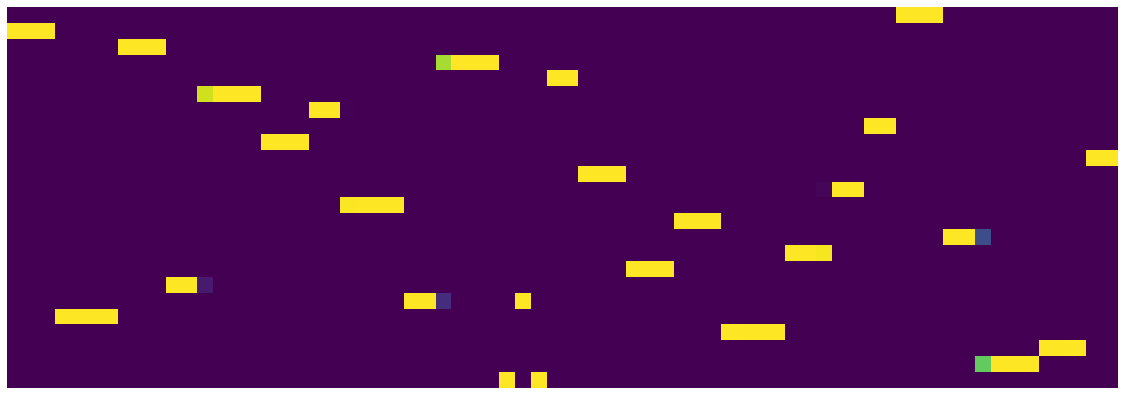

24 200 0.7989999999999998 0.45494300555437805


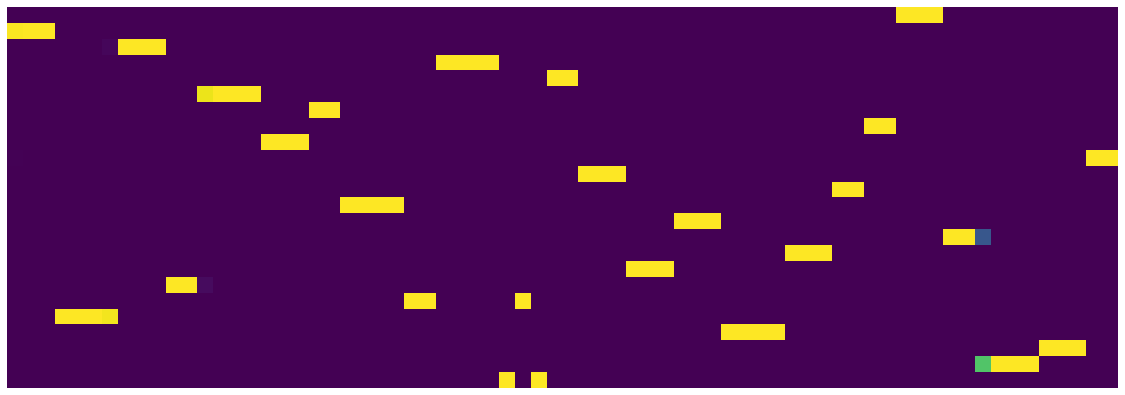

24 201 0.7979999999999998 0.4562967175617814


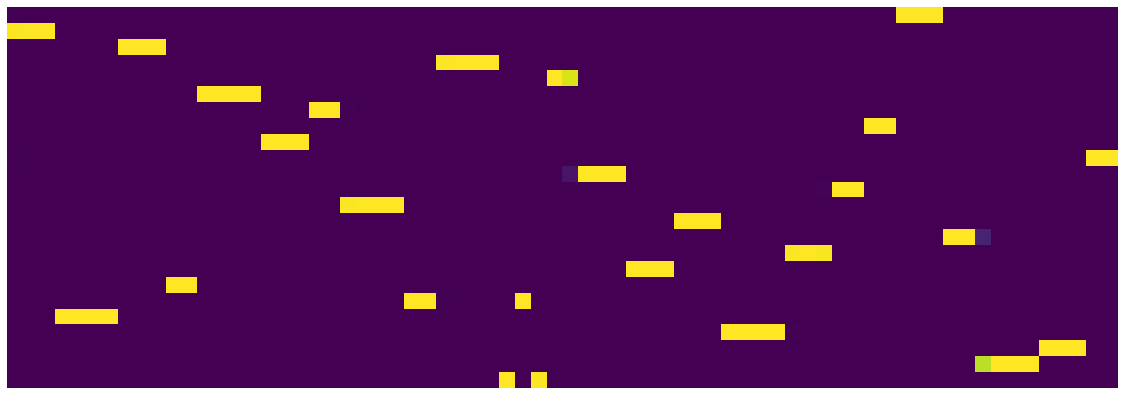

24 202 0.7969999999999998 0.45526626948267224


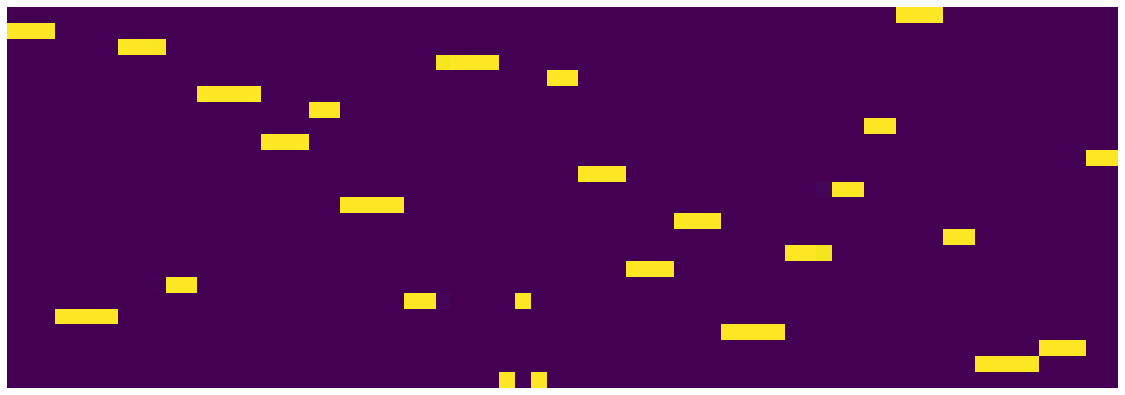

24 203 0.7959999999999998 0.46094933804124594


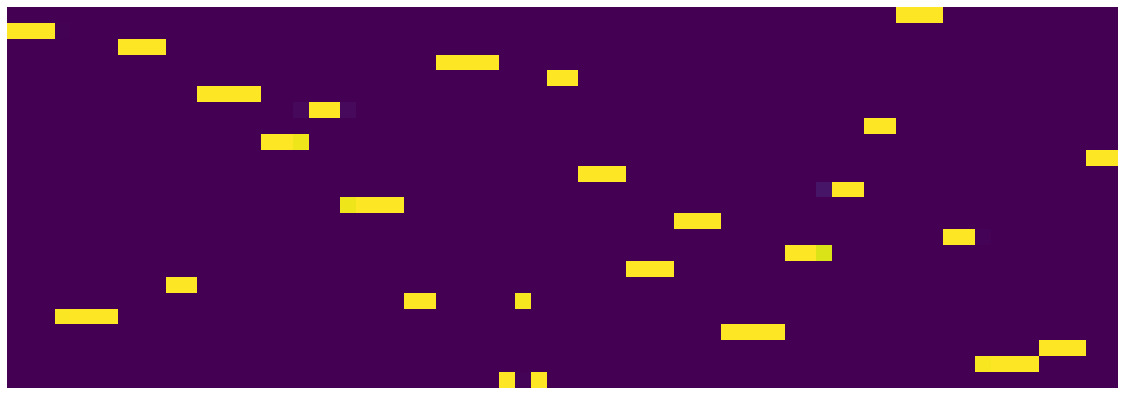

24 204 0.7949999999999998 0.456092494353652


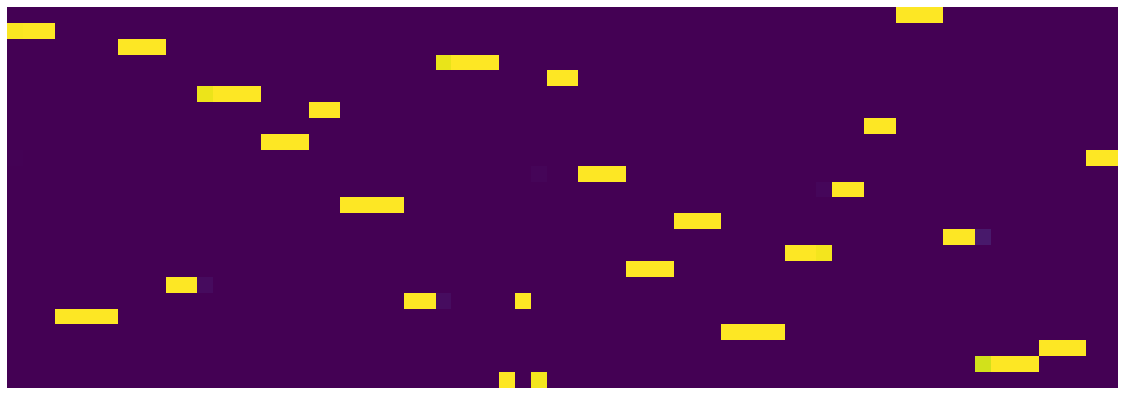

24 205 0.7939999999999998 0.4563498778268695


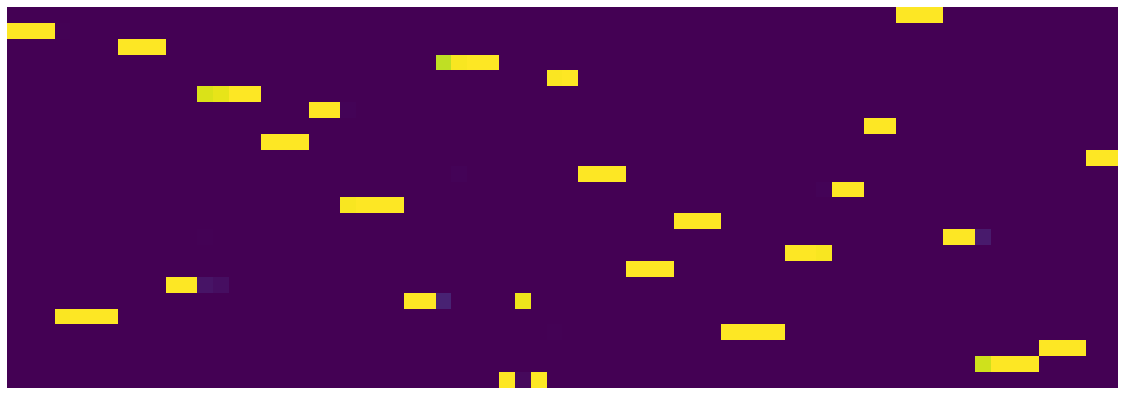

24 206 0.7929999999999998 0.45587207935750484


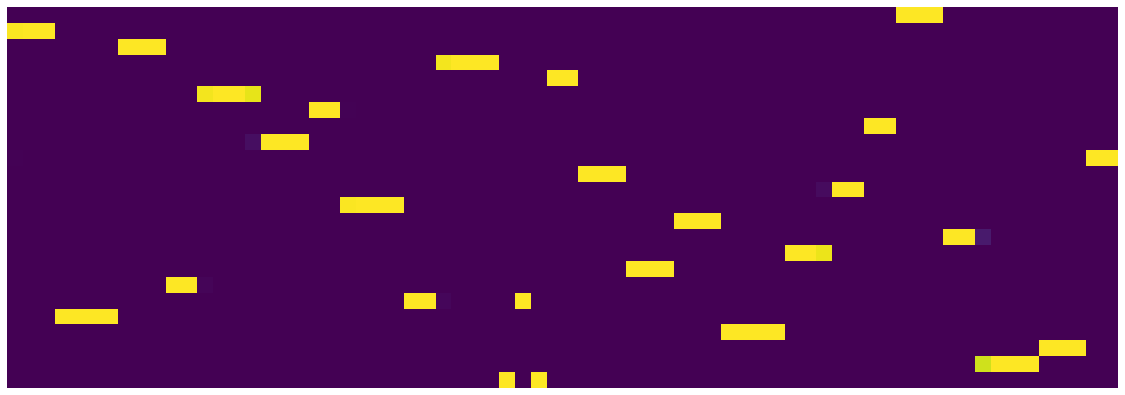

24 207 0.7919999999999998 0.4559203261509538


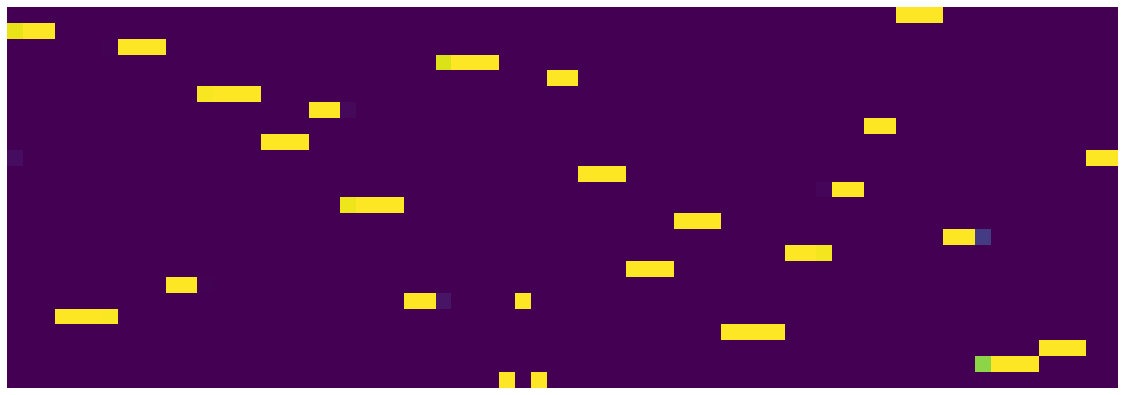

24 208 0.7909999999999998 0.45505324341356757


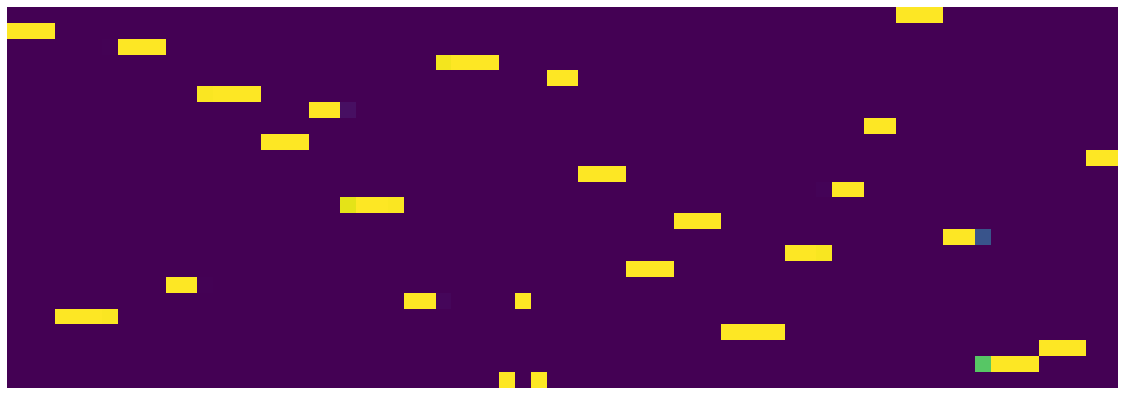

24 209 0.7899999999999998 0.4551088010892272


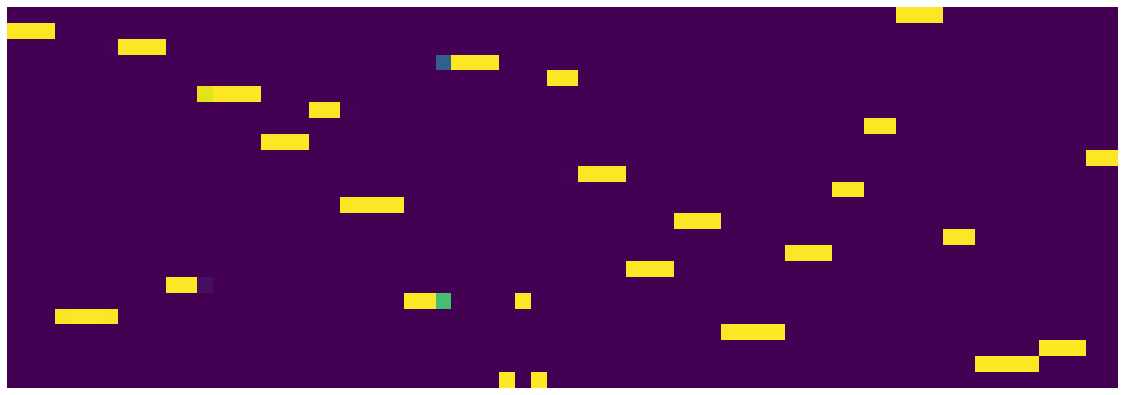

24 210 0.7889999999999998 0.45497754141688346


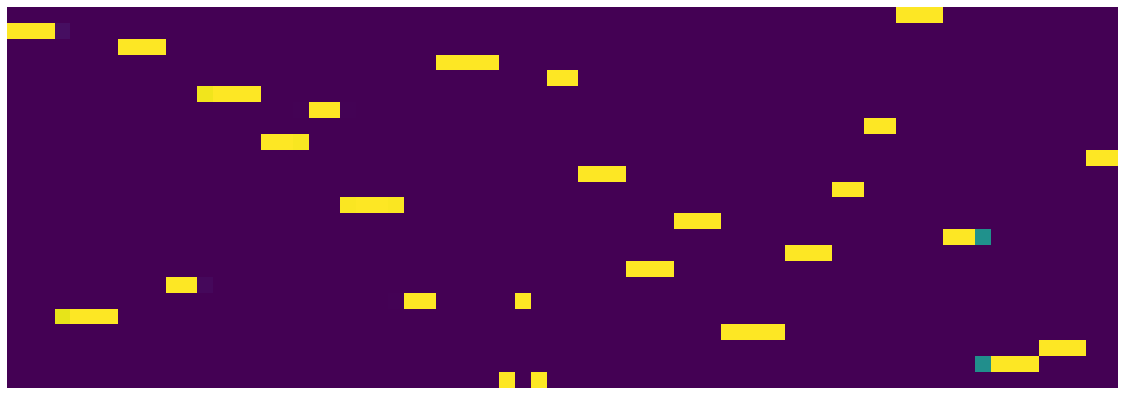

24 211 0.7879999999999998 0.4545227540656924


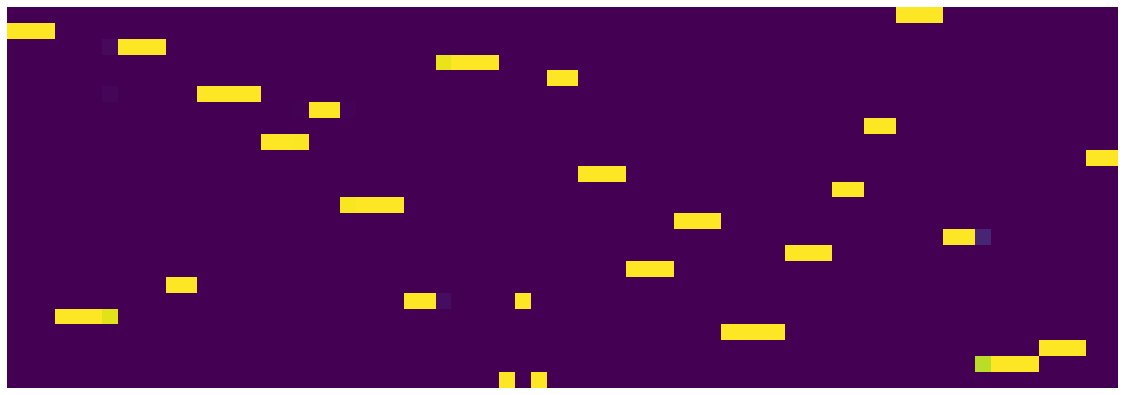

24 212 0.7869999999999998 0.4575615137815475


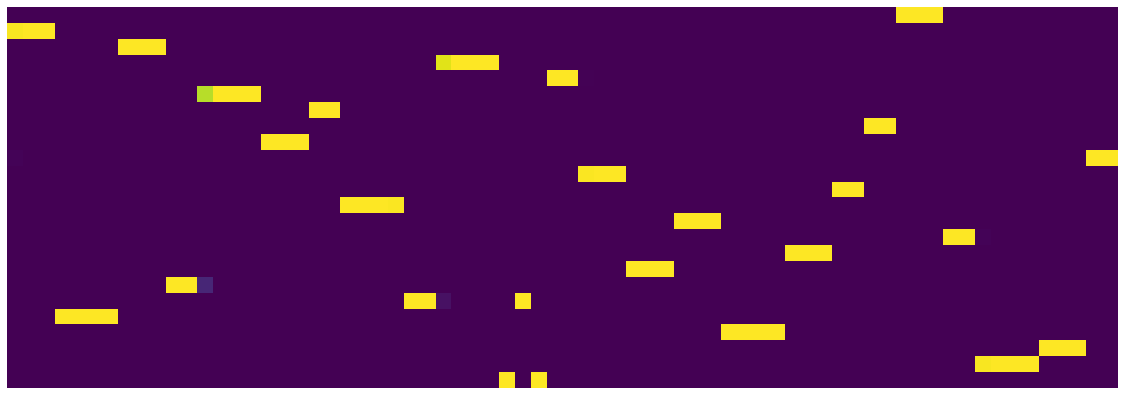

24 213 0.7859999999999998 0.45531515348702667


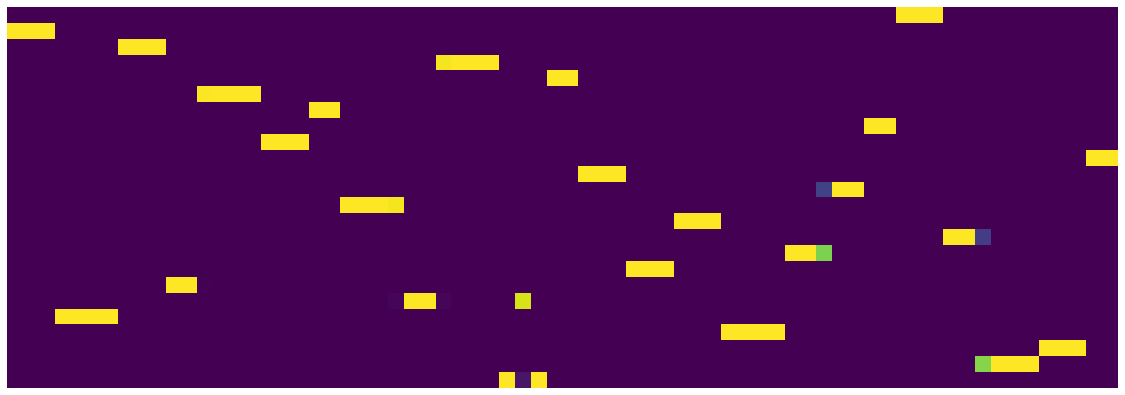

24 214 0.7849999999999998 0.45438537038862703


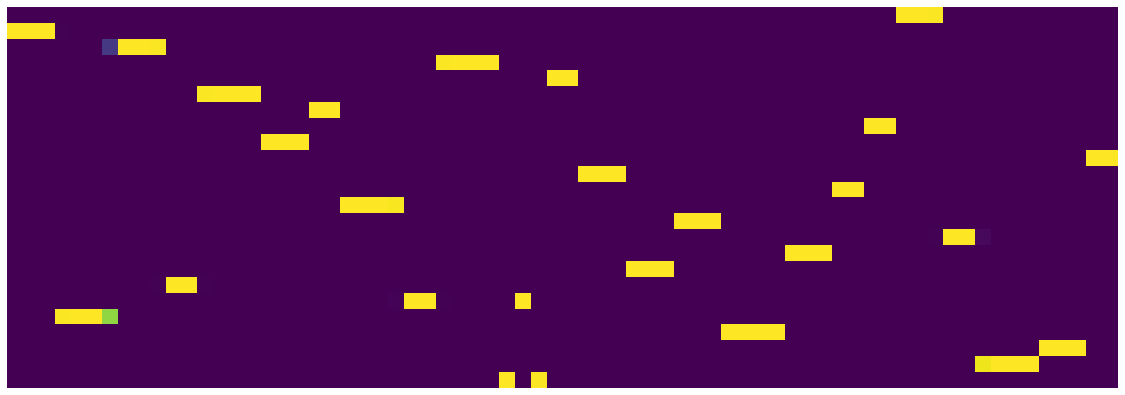

24 215 0.7839999999999998 0.4558741727843881


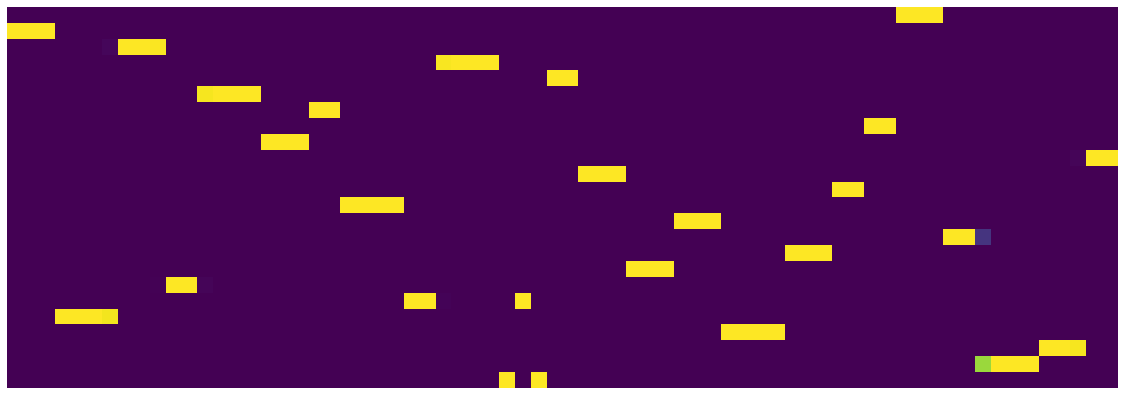

24 216 0.7829999999999998 0.455973275564611


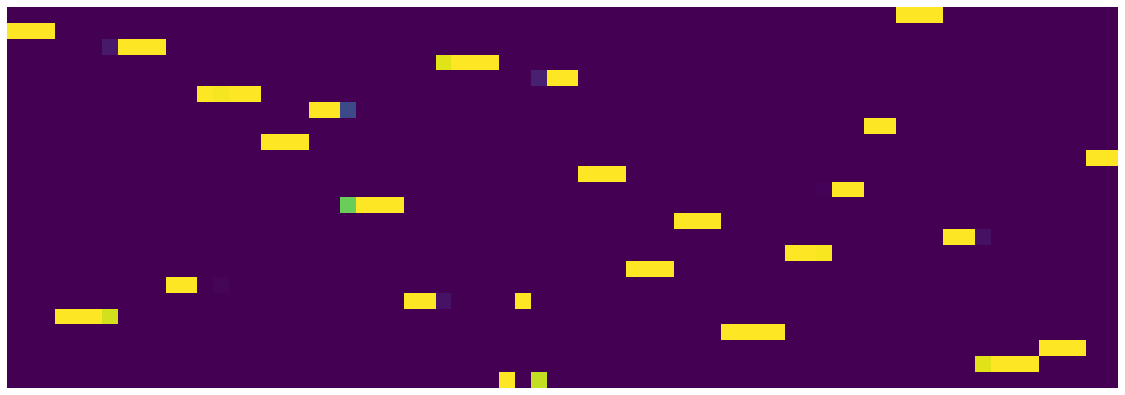

24 217 0.7819999999999998 0.45656909272074697


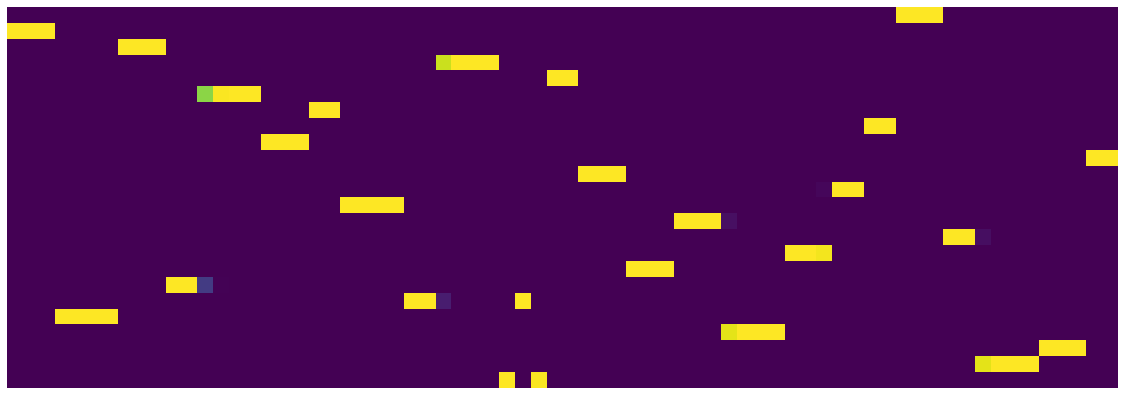

24 218 0.7809999999999998 0.4556083042174578


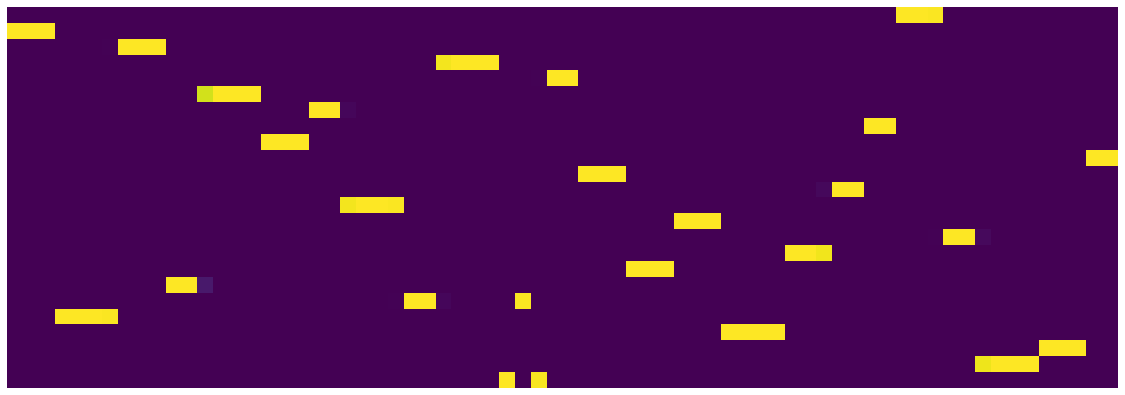

24 219 0.7799999999999998 0.4569891540333629


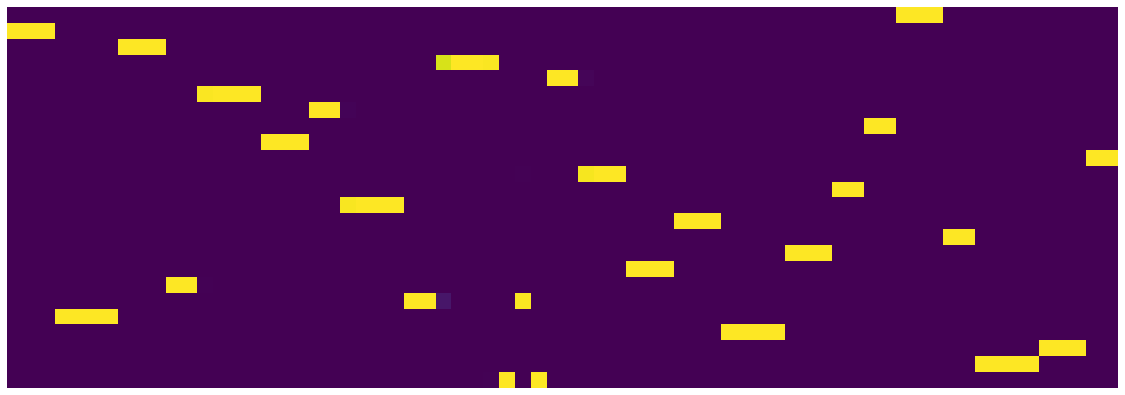

24 220 0.7789999999999998 0.4558533880859613


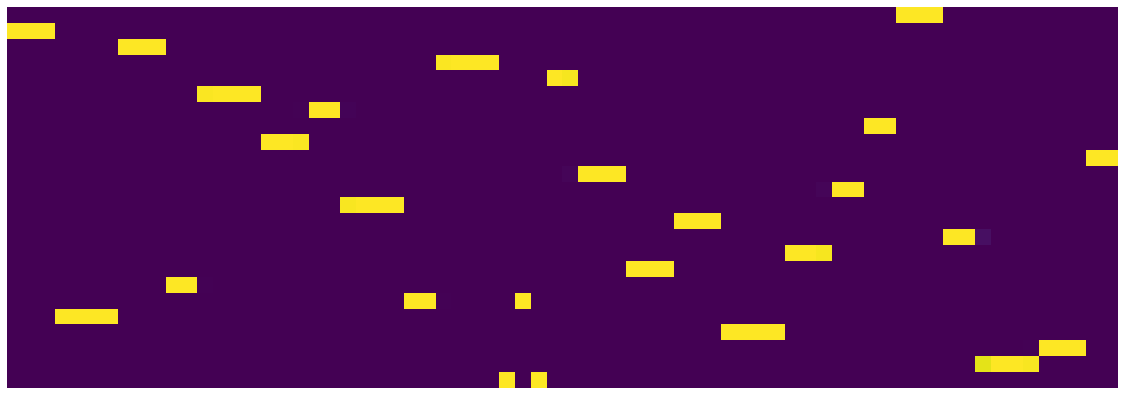

24 221 0.7779999999999998 0.45643221996724603


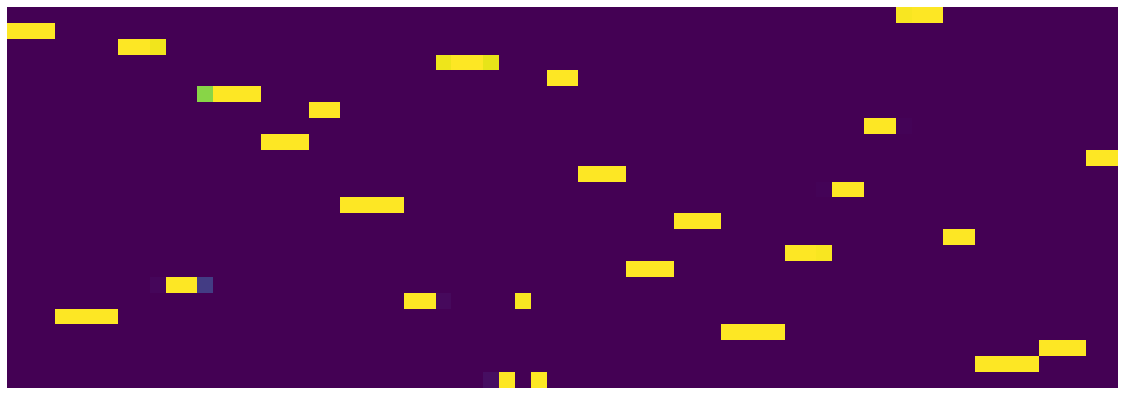

24 222 0.7769999999999998 0.45487479139119386


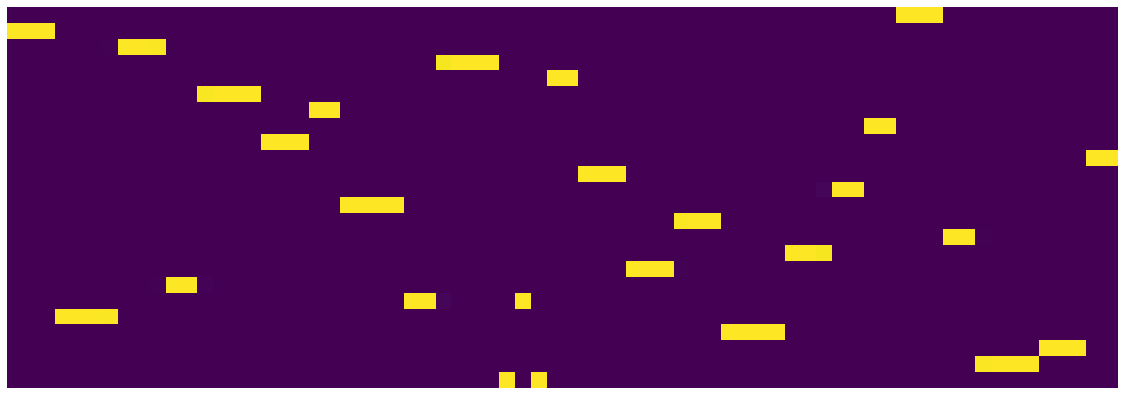

24 223 0.7759999999999998 0.45552608501166103


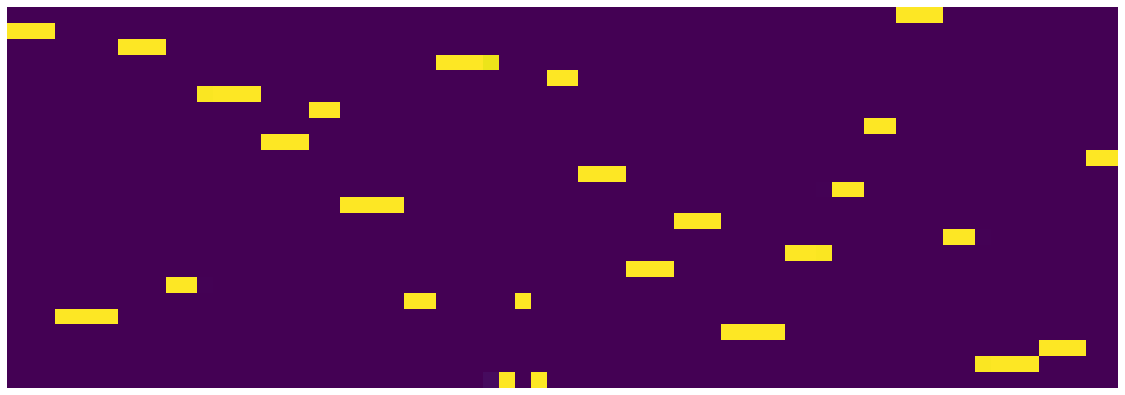

24 224 0.7749999999999998 0.4562149945646524


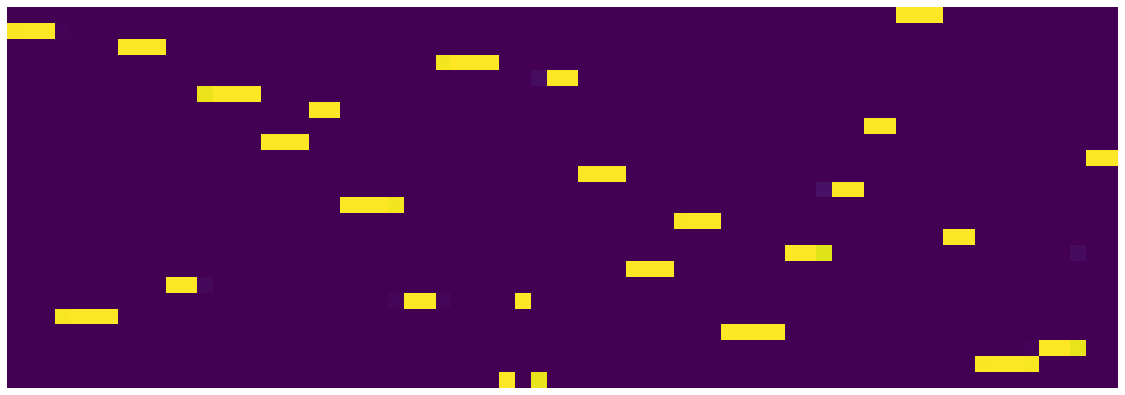

24 225 0.7739999999999998 0.4546799952164292


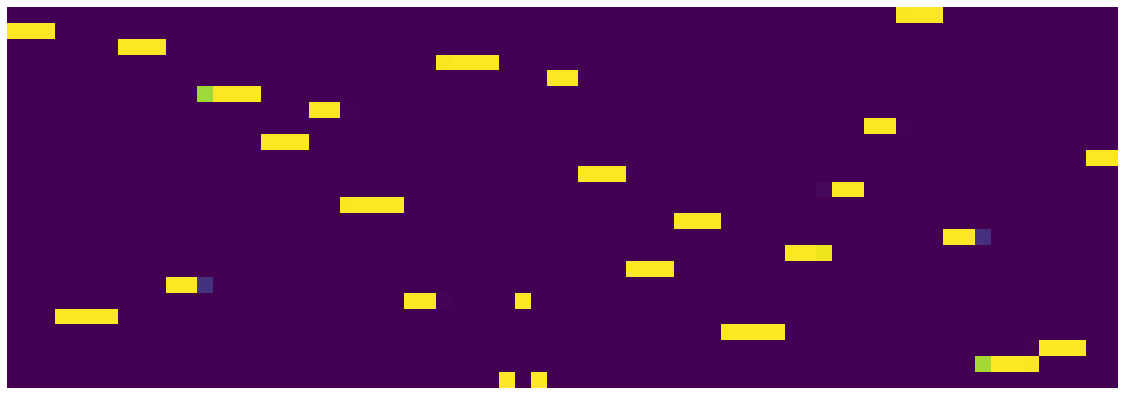

24 226 0.7729999999999998 0.45494753643870356


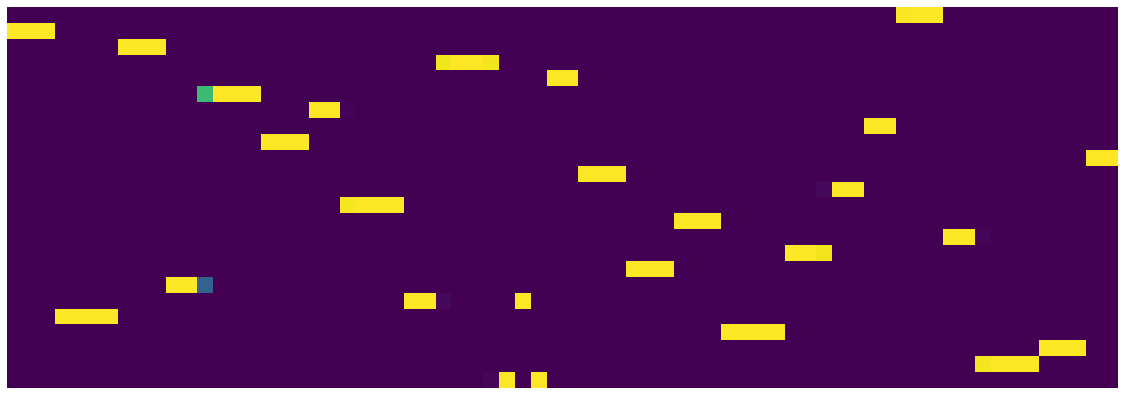

24 227 0.7719999999999998 0.4551927950233221


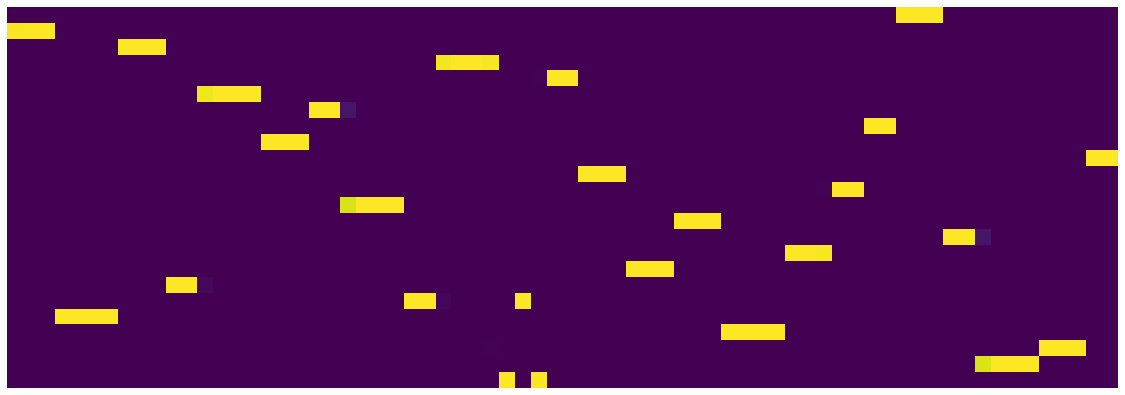

24 228 0.7709999999999998 0.45487612690776585


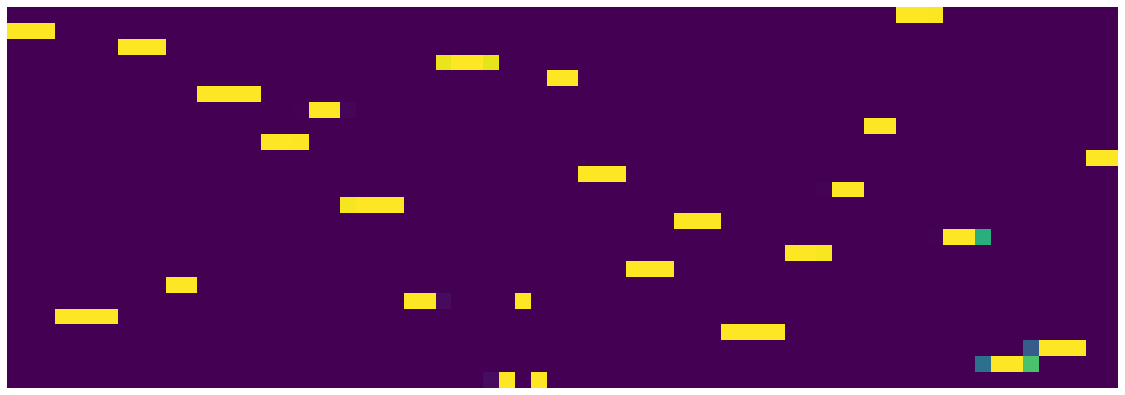

24 229 0.7699999999999998 0.4552554475143552


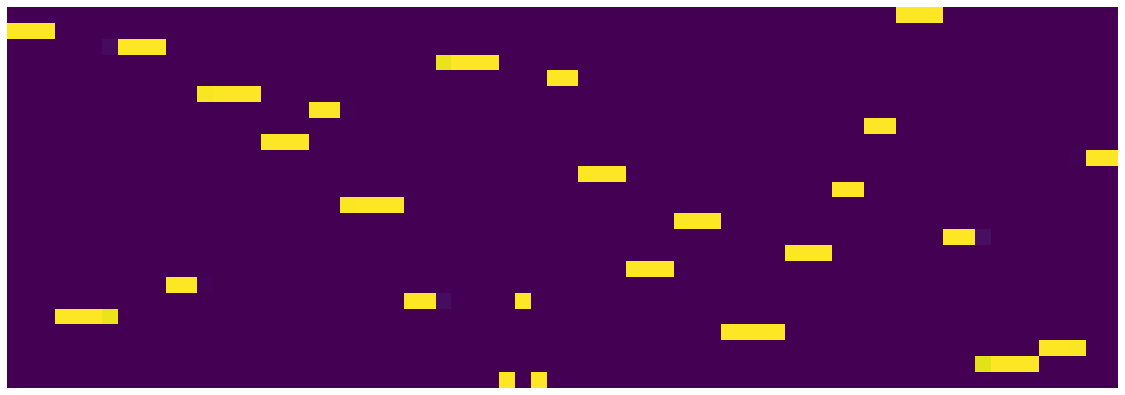

24 230 0.7689999999999998 0.45534447953104973


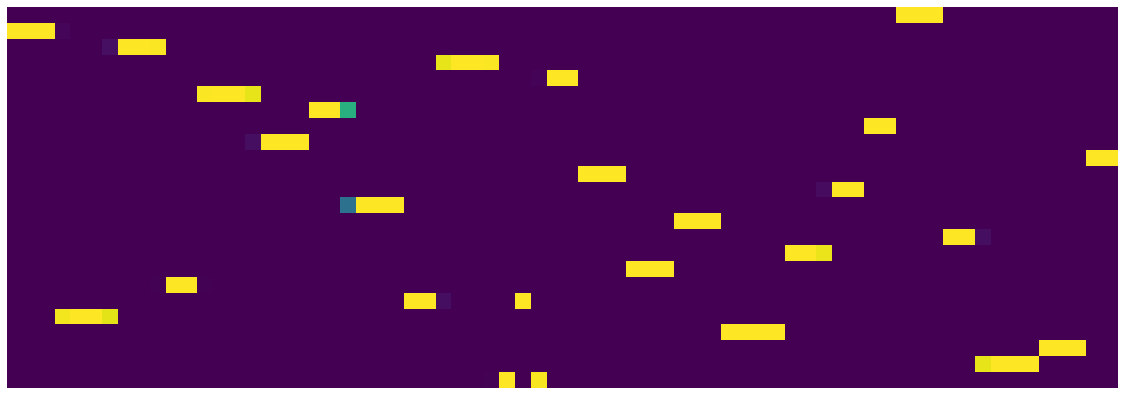

24 231 0.7679999999999998 0.4549891760572791


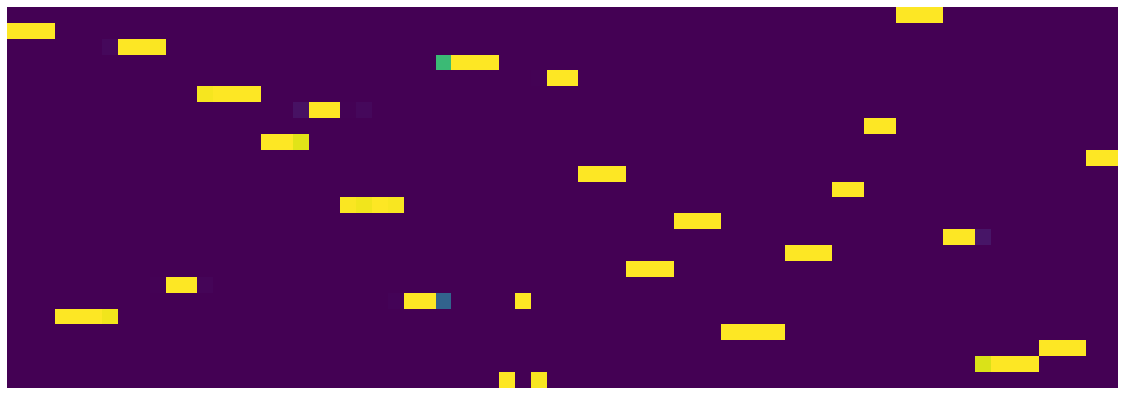

24 232 0.7669999999999998 0.4561099665239453


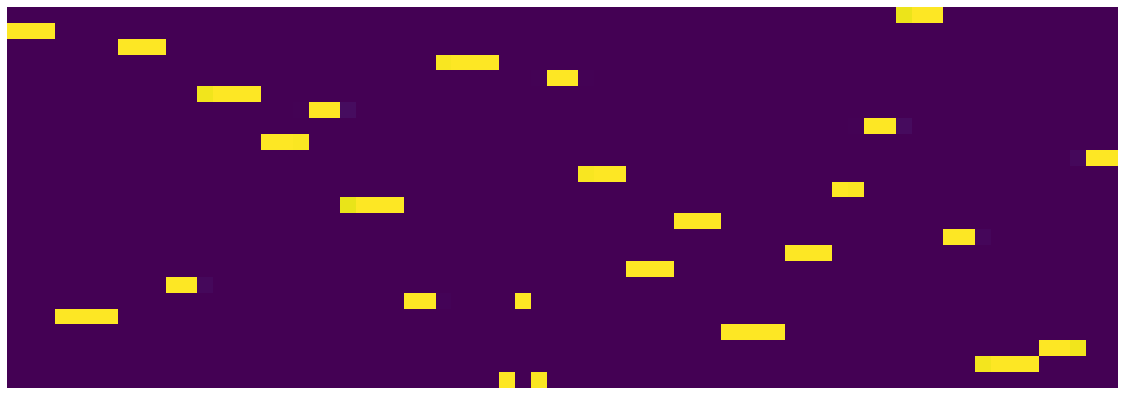

24 233 0.7659999999999998 0.45437720604240894


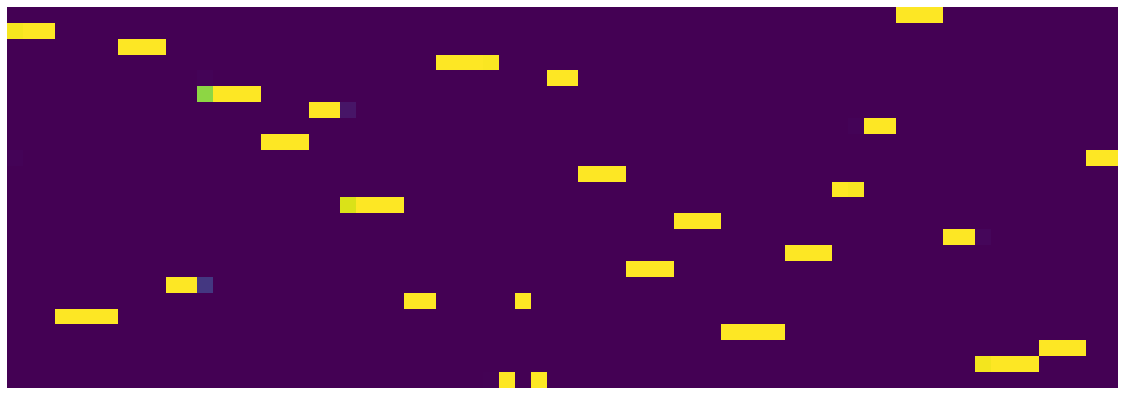

24 234 0.7649999999999998 0.4545644918456674


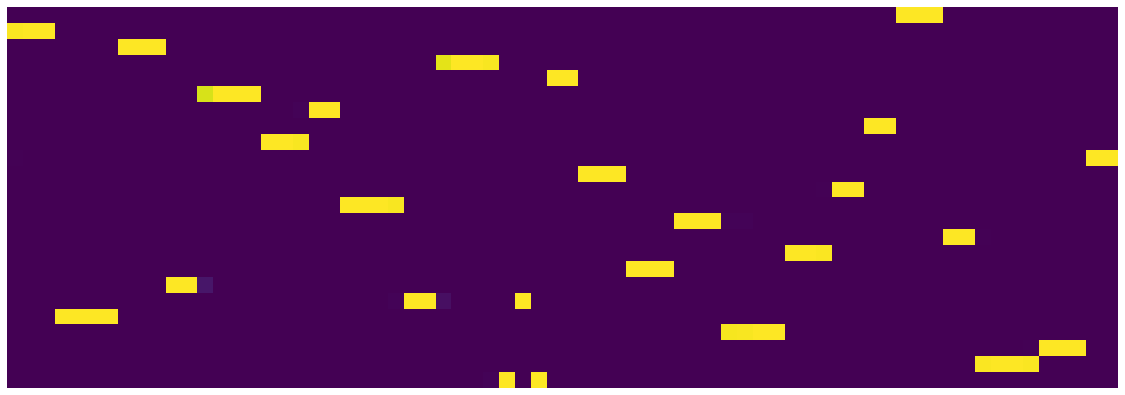

24 235 0.7639999999999998 0.4554226793348789


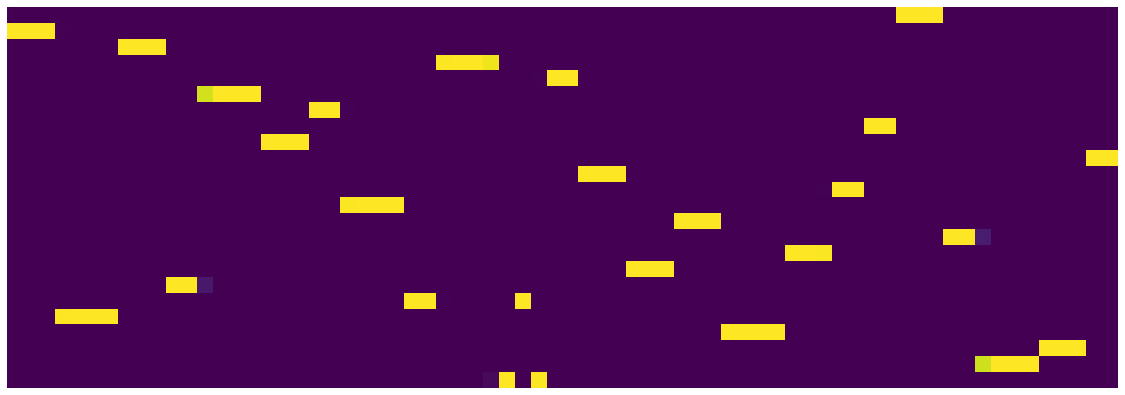

24 236 0.7629999999999998 0.4568508453667164


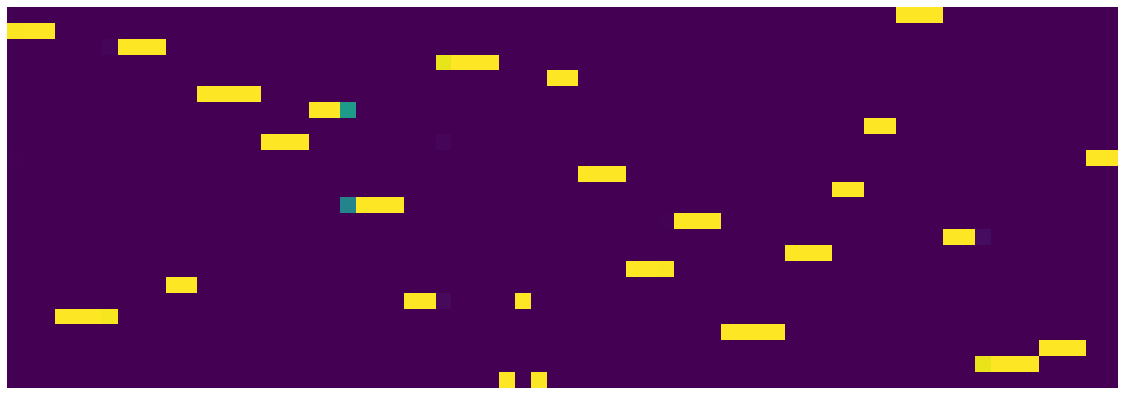

24 237 0.7619999999999998 0.4555475441738963


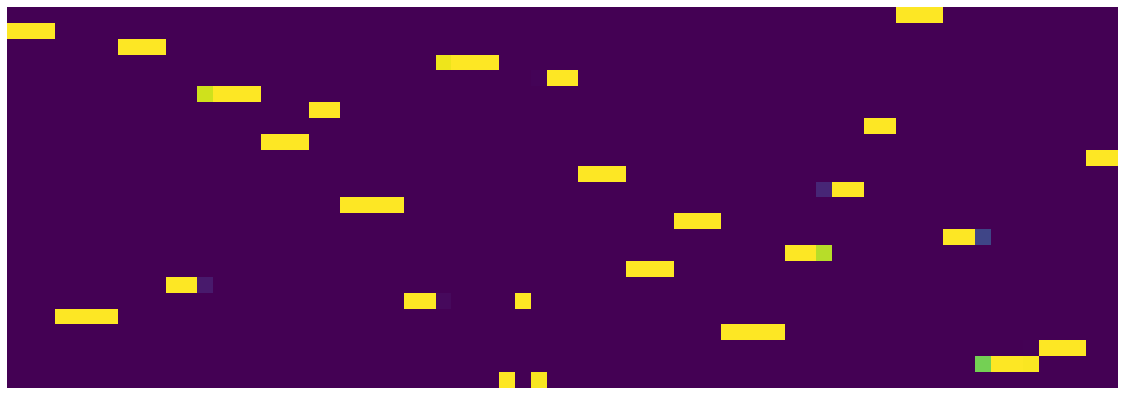

24 238 0.7609999999999998 0.4552570227533579


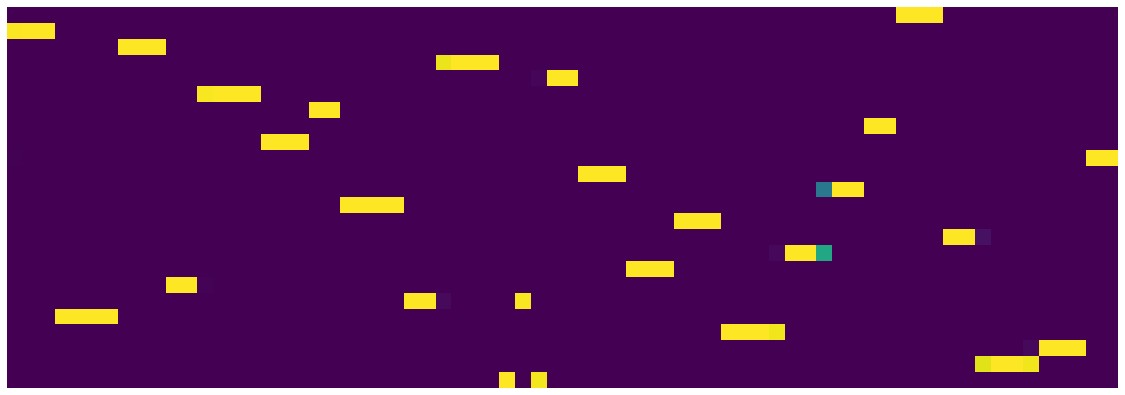

24 239 0.7599999999999998 0.45576481316238643


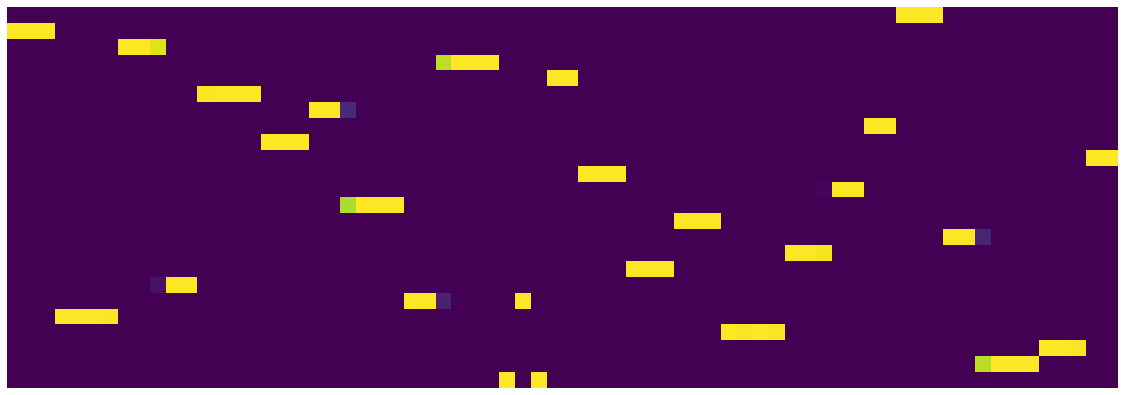

24 240 0.7589999999999998 0.455296634696424


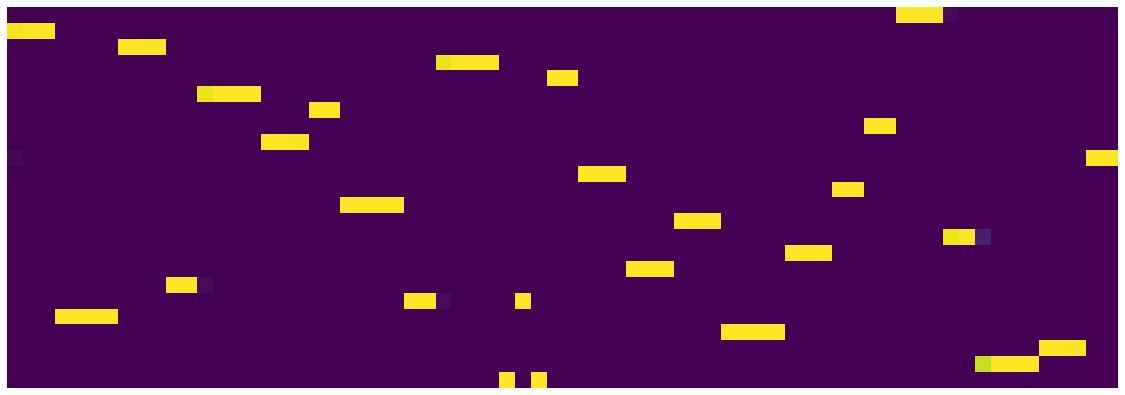

24 241 0.7579999999999998 0.4568433478474617


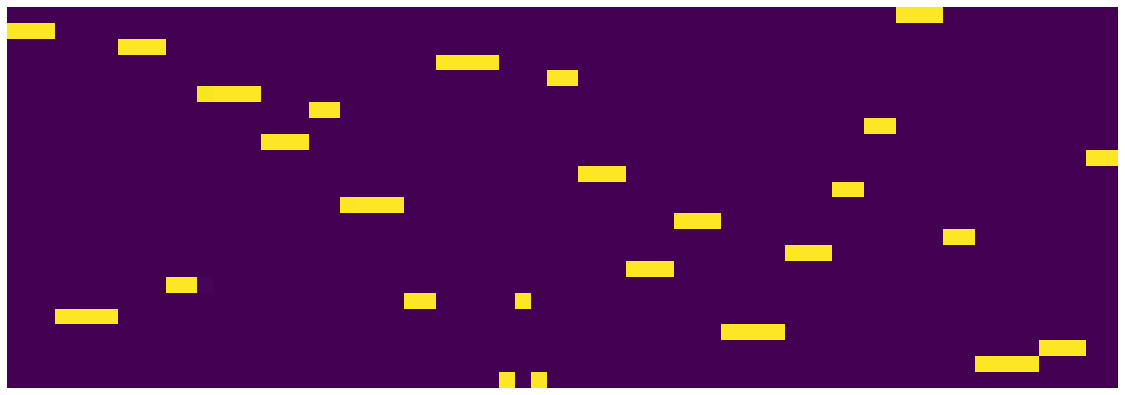

24 242 0.7569999999999998 0.4549003532156348


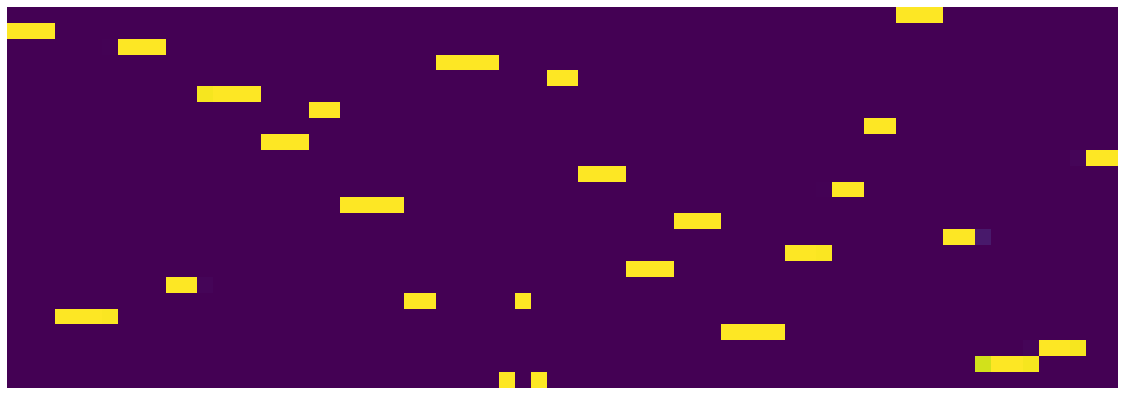

24 243 0.7559999999999998 0.45543940328061583


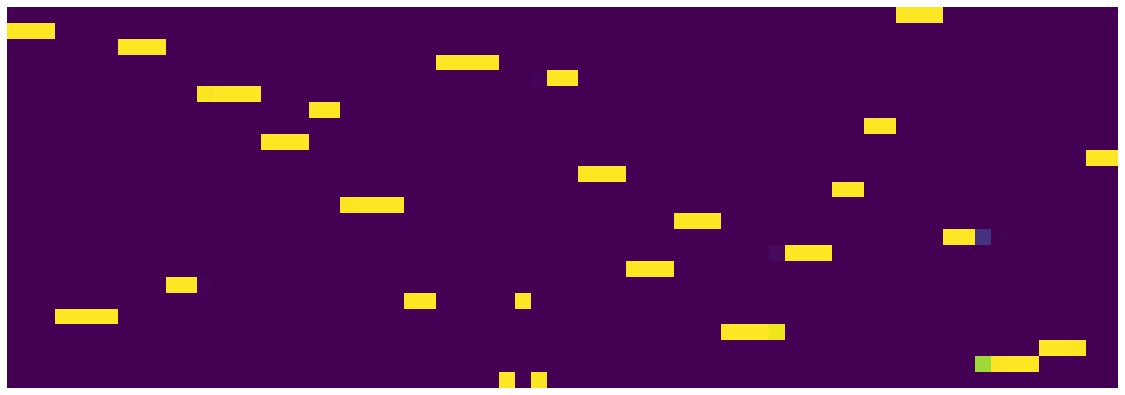

24 244 0.7549999999999998 0.45536660179495814


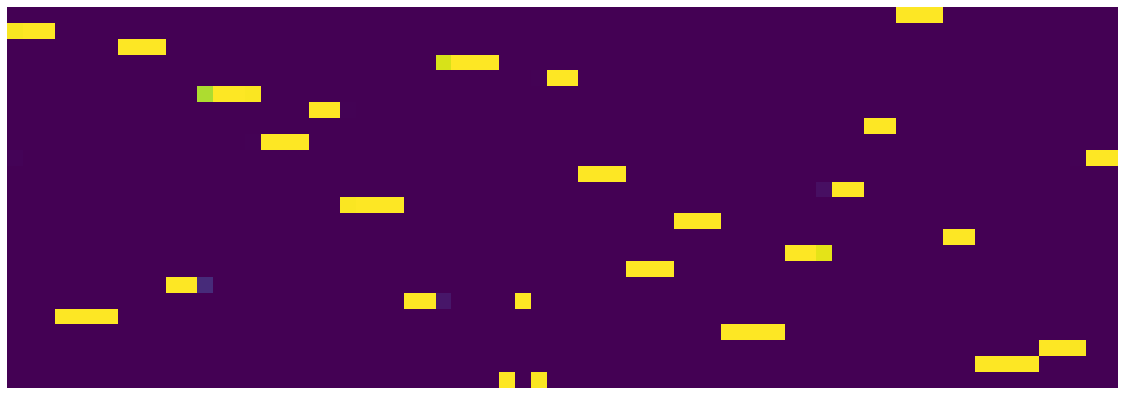

24 245 0.7539999999999998 0.4563849590718746


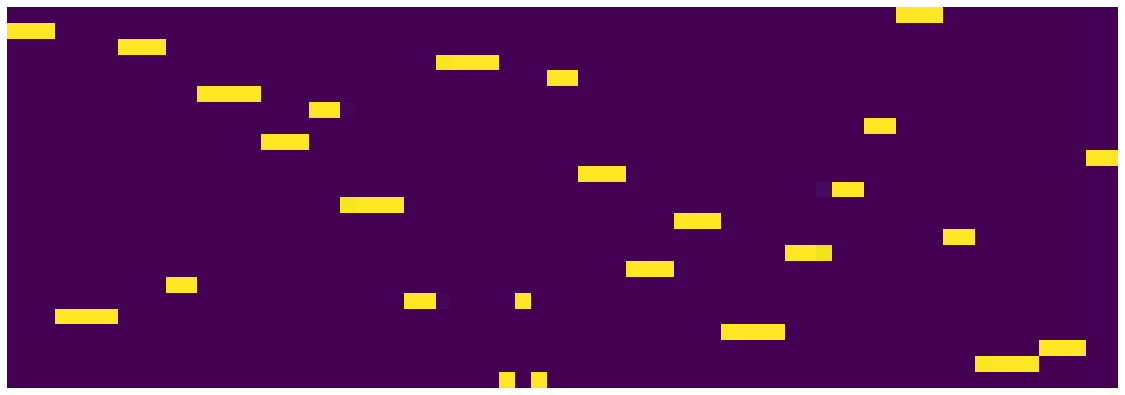

24 246 0.7529999999999998 0.4556633854284883


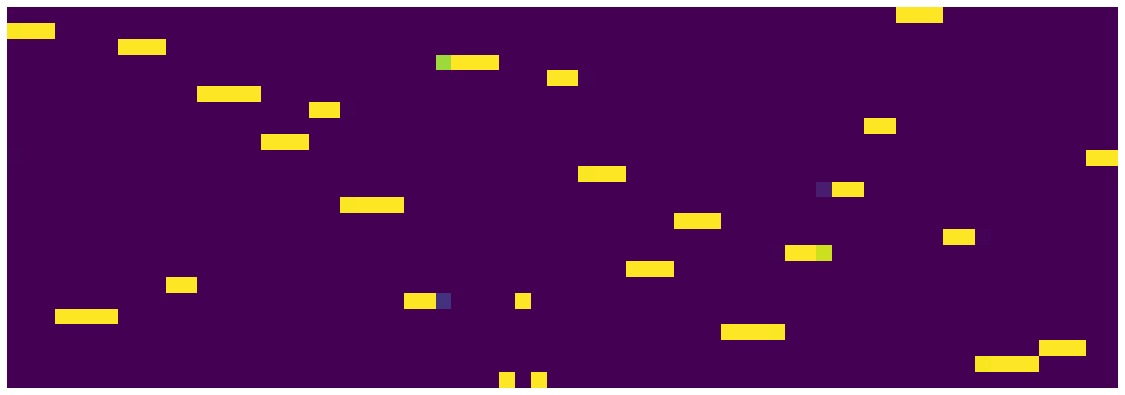

24 247 0.7519999999999998 0.45541674066334964


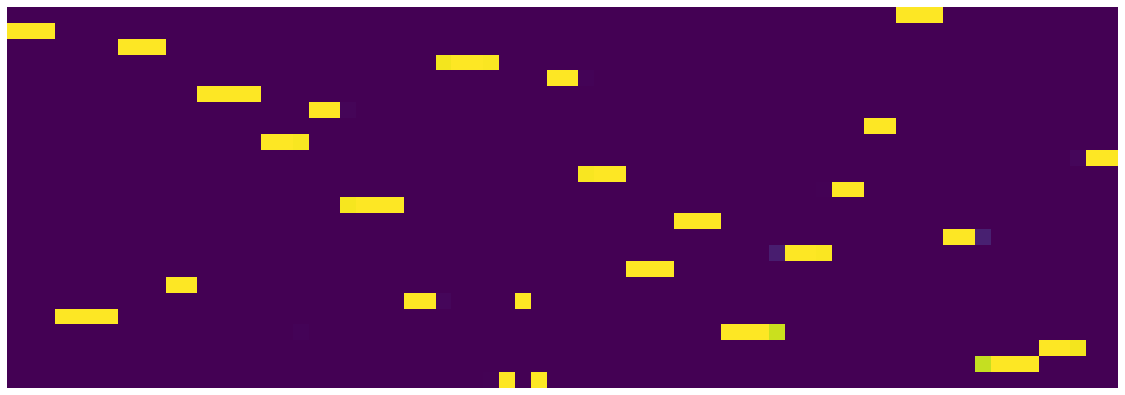

24 248 0.7509999999999998 0.4546478696167469


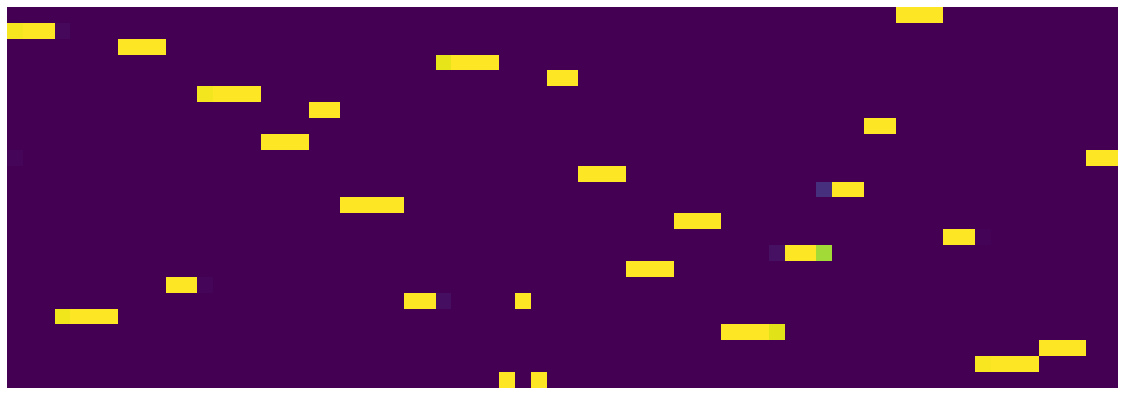

24 249 0.7499999999999998 0.45495939031243327


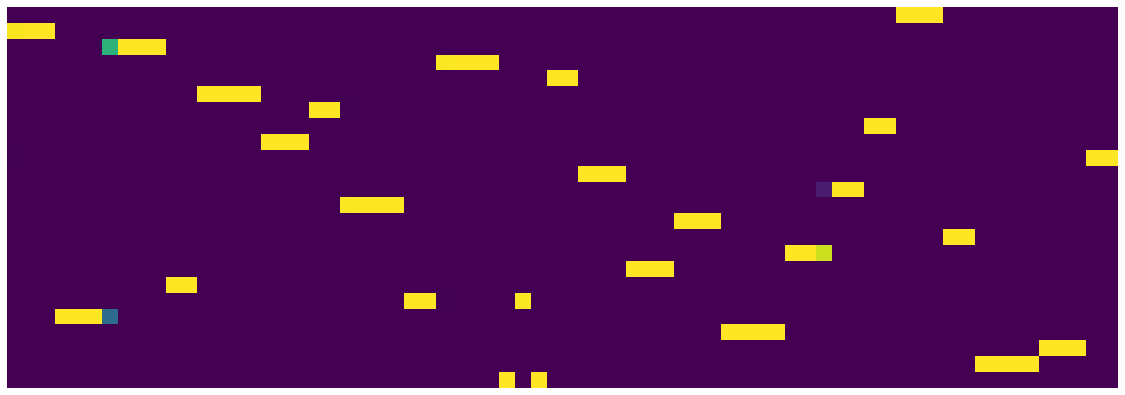

24 250 0.7489999999999998 0.45629564840346576


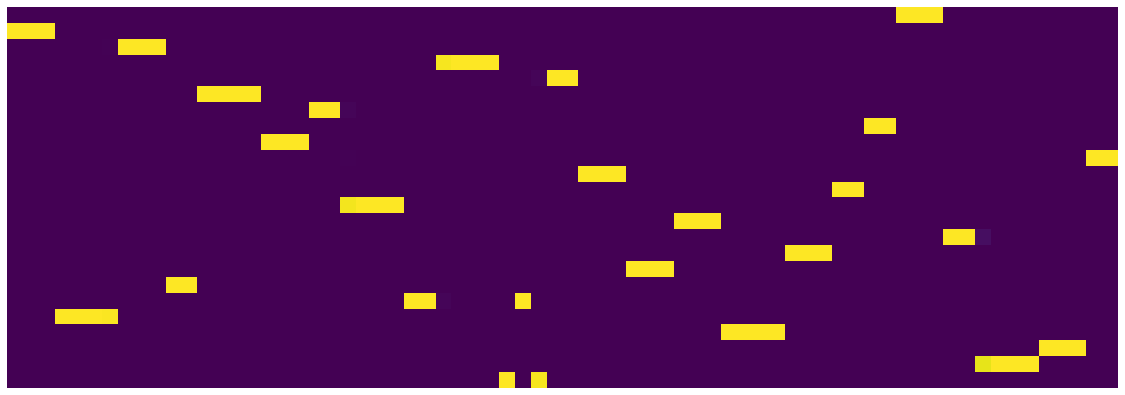

24 251 0.7479999999999998 0.4552306143566966


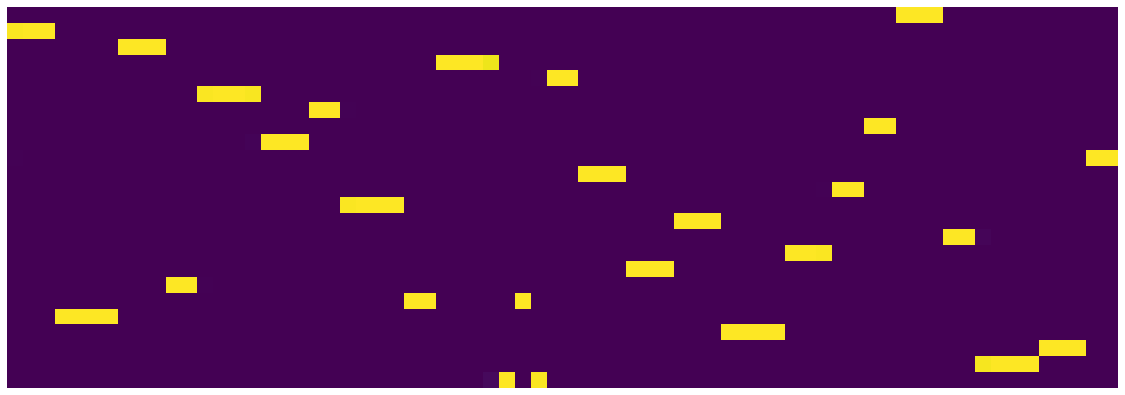

24 252 0.7469999999999998 0.4549338757991791


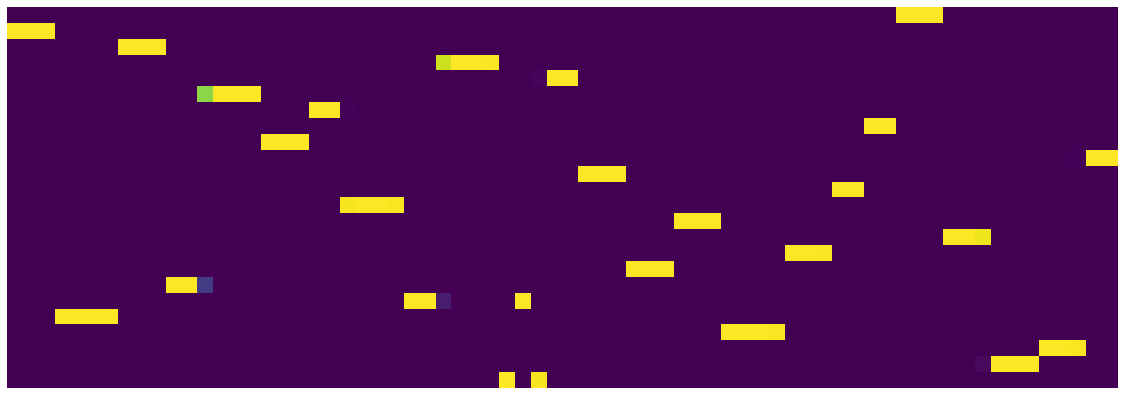

24 253 0.7459999999999998 0.4546025304123759


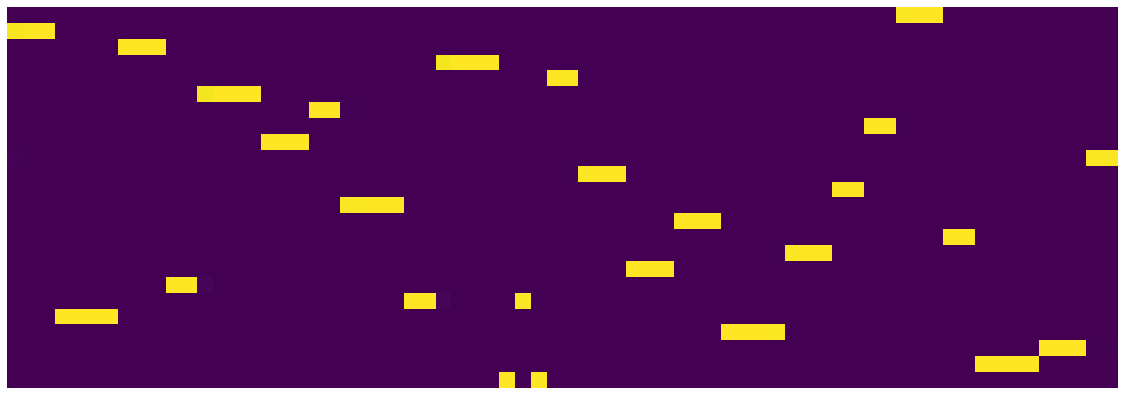

24 254 0.7449999999999998 0.4554648768156767


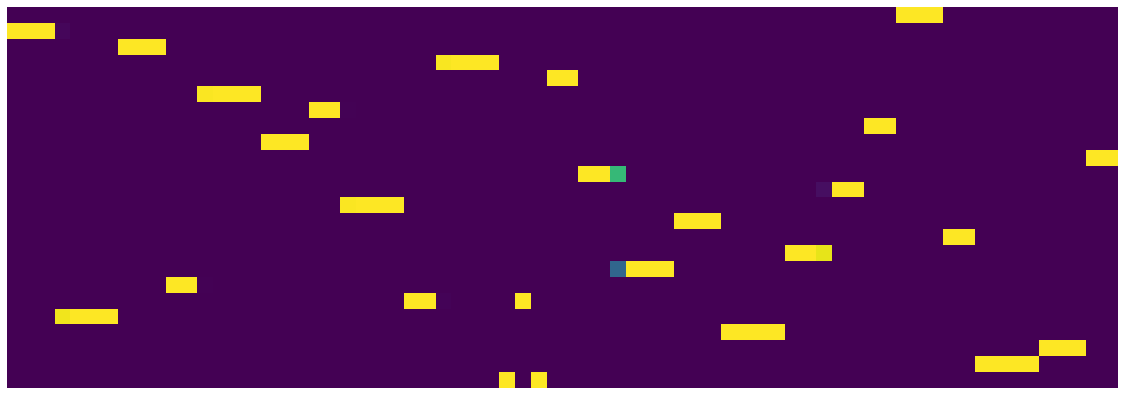

24 255 0.7439999999999998 0.45535531677305696


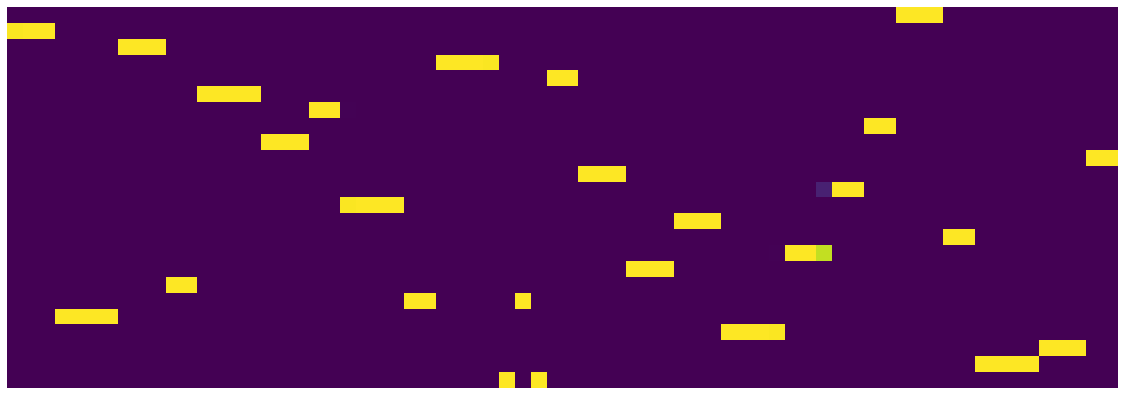

24 256 0.7429999999999998 0.4565867405384779


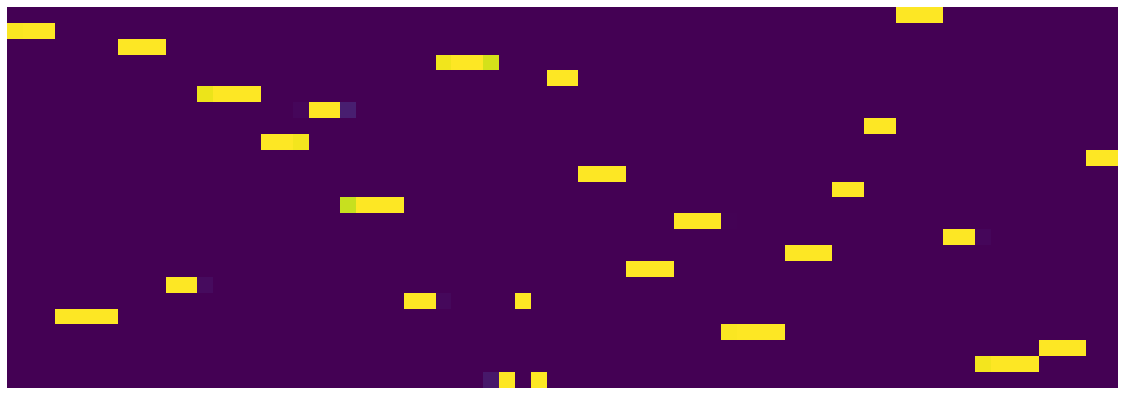

24 257 0.7419999999999998 0.45459319073706866


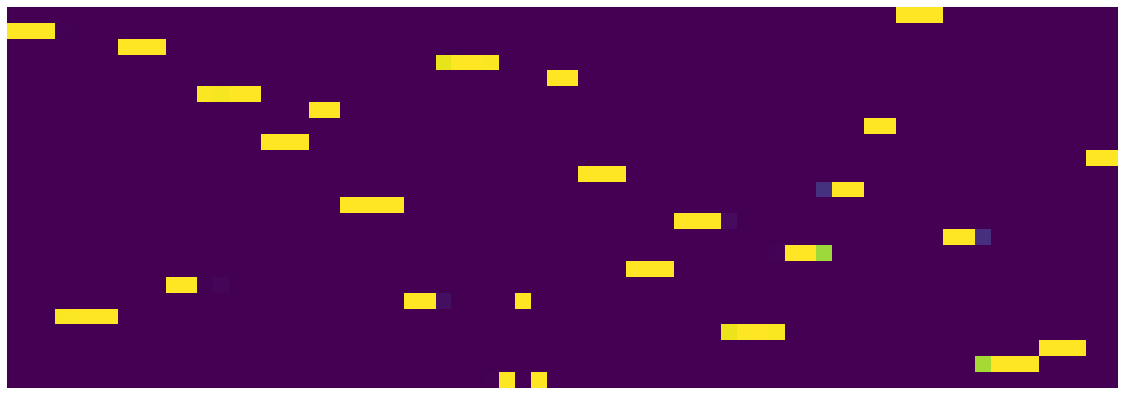

24 258 0.7409999999999998 0.45526410173624754


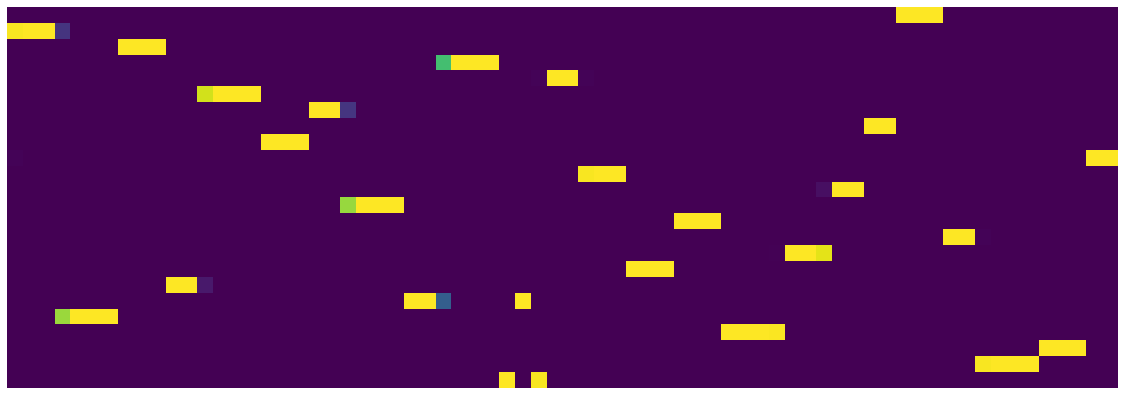

24 259 0.7399999999999998 0.45772118028253317


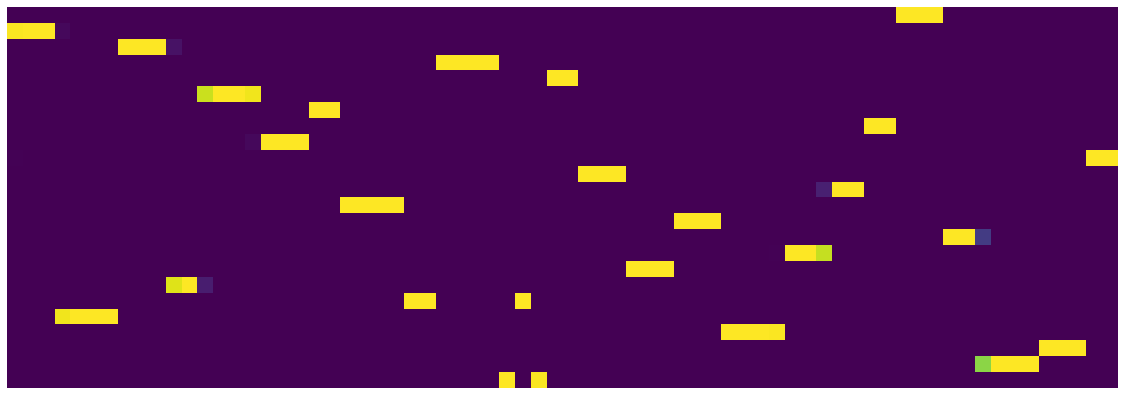

24 260 0.7389999999999998 0.4566368892788887


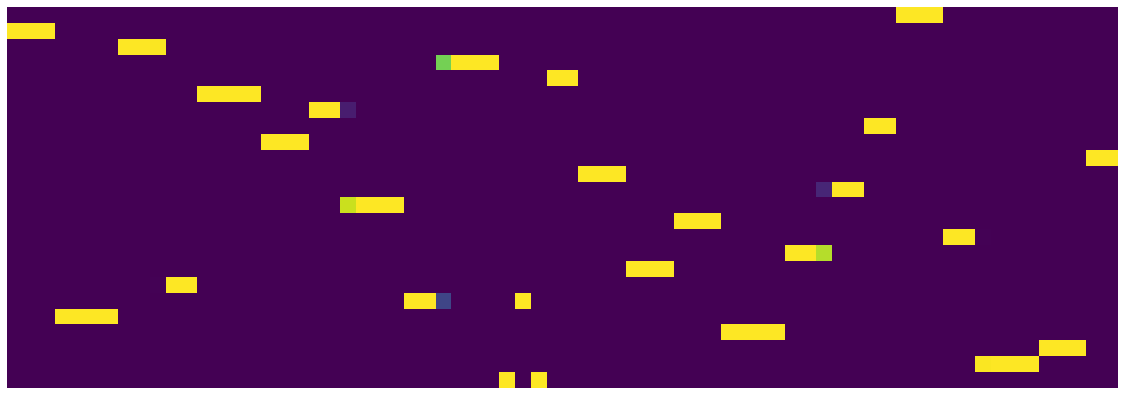

24 261 0.7379999999999998 0.4549862273037434


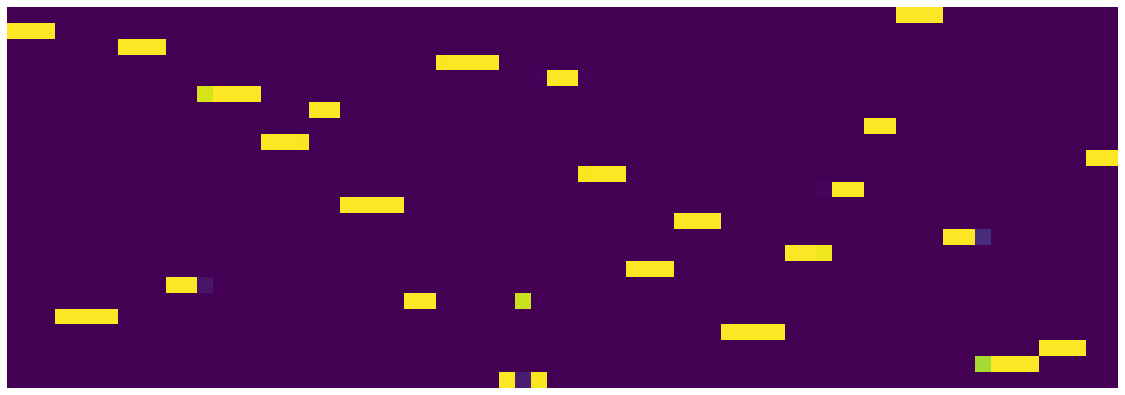

24 262 0.7369999999999998 0.45594440717250106


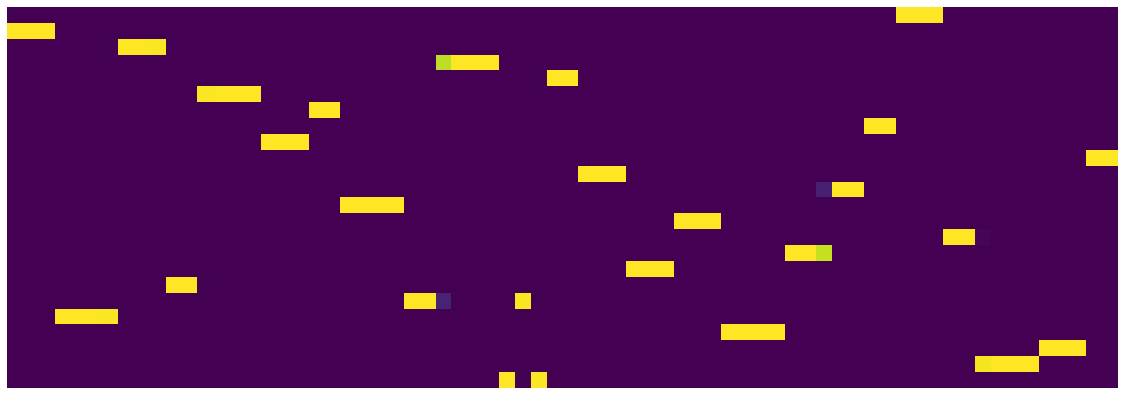

24 263 0.7359999999999998 0.45557779297232626


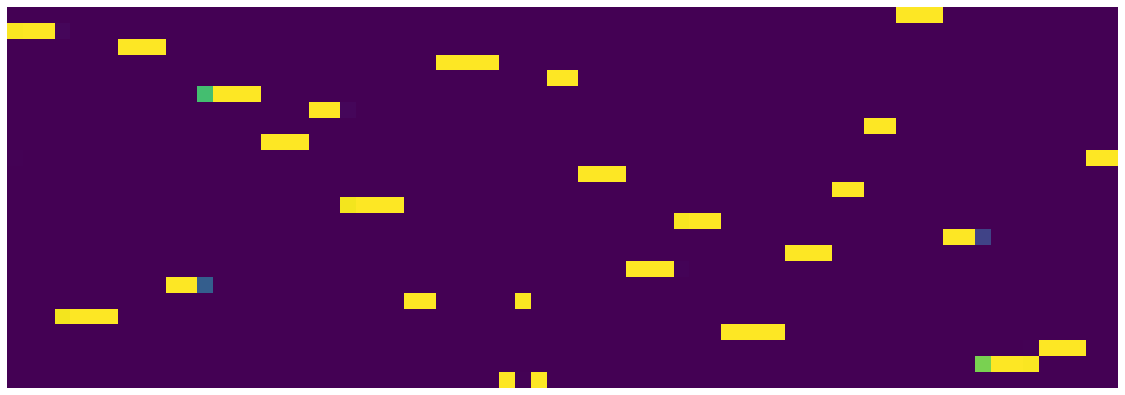

24 264 0.7349999999999998 0.45465716551989316


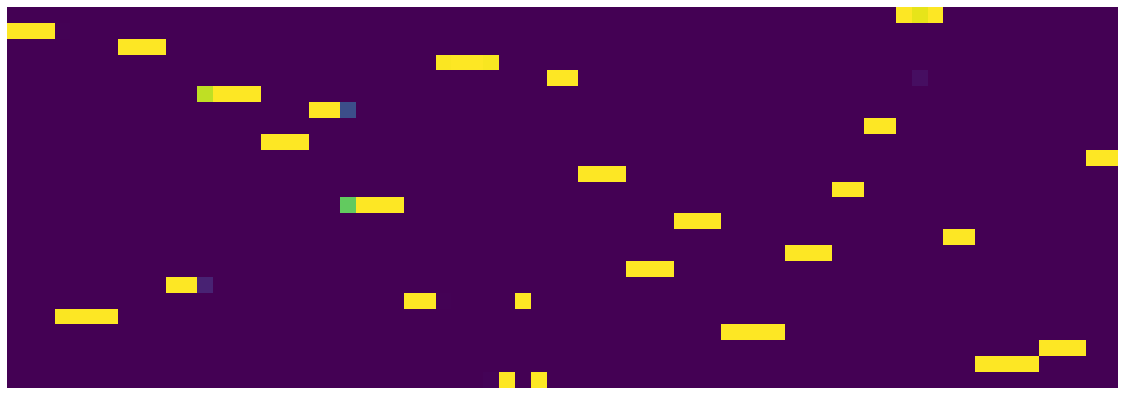

24 265 0.7339999999999998 0.4561516920104623


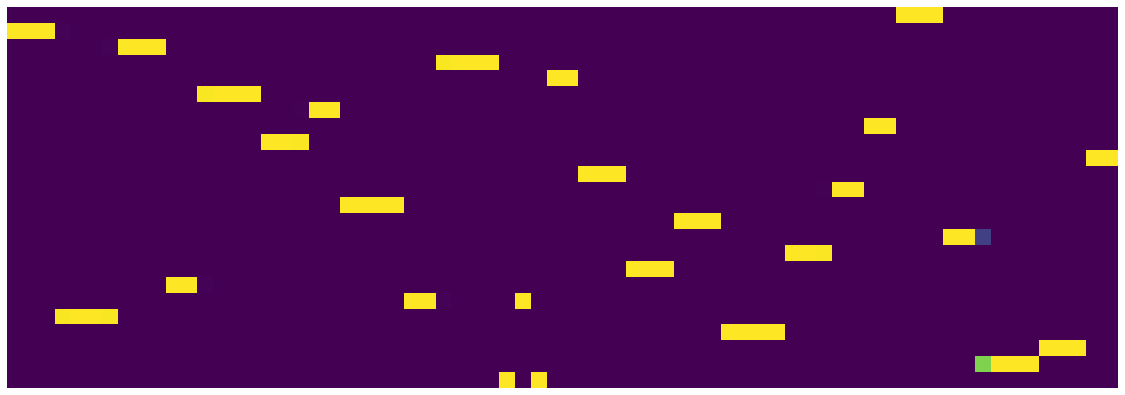

24 266 0.7329999999999998 0.4545025024563074


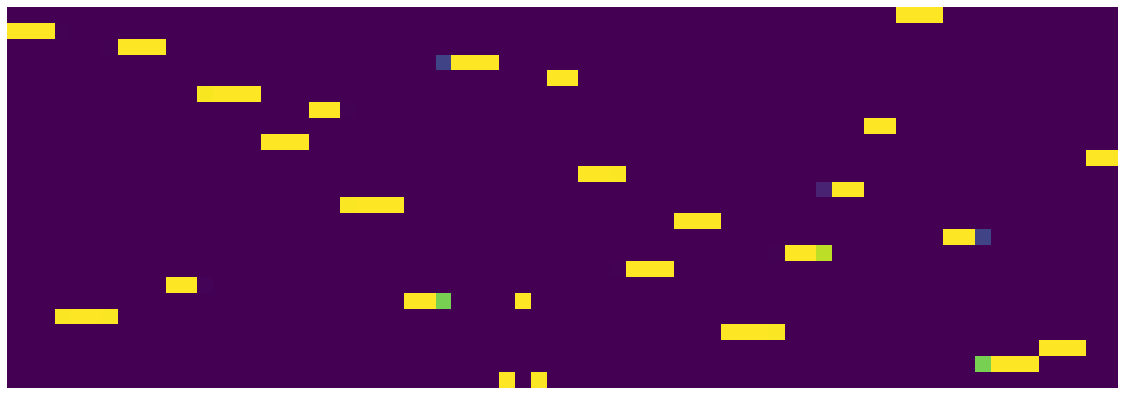

24 267 0.7319999999999998 0.4548530958592892


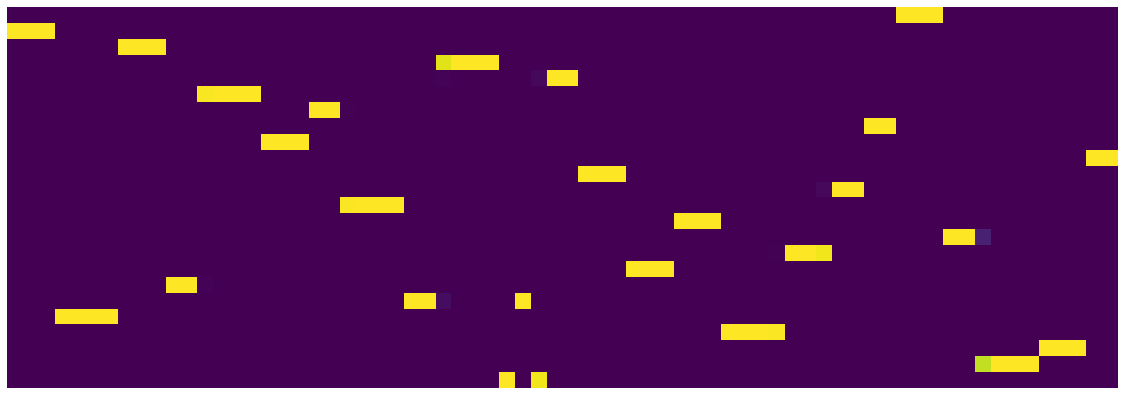

24 268 0.7309999999999998 0.45519463885575534


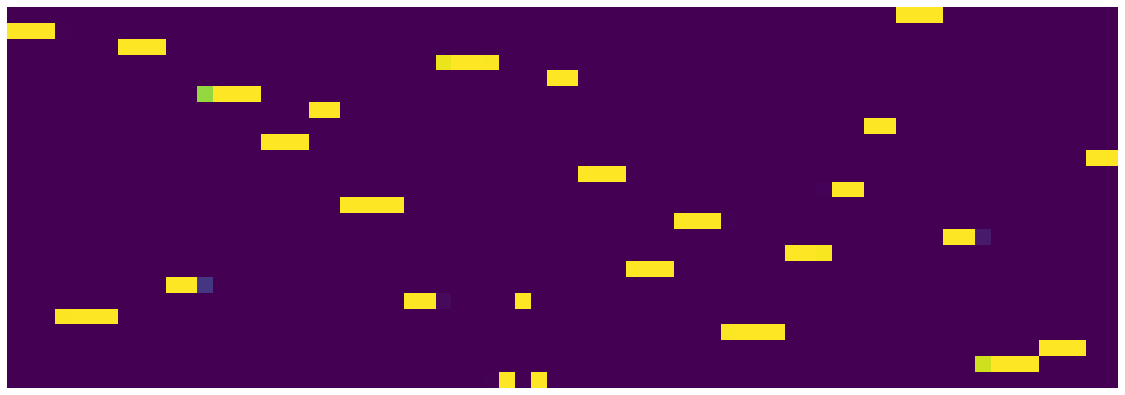

24 269 0.7299999999999998 0.4545796483755112


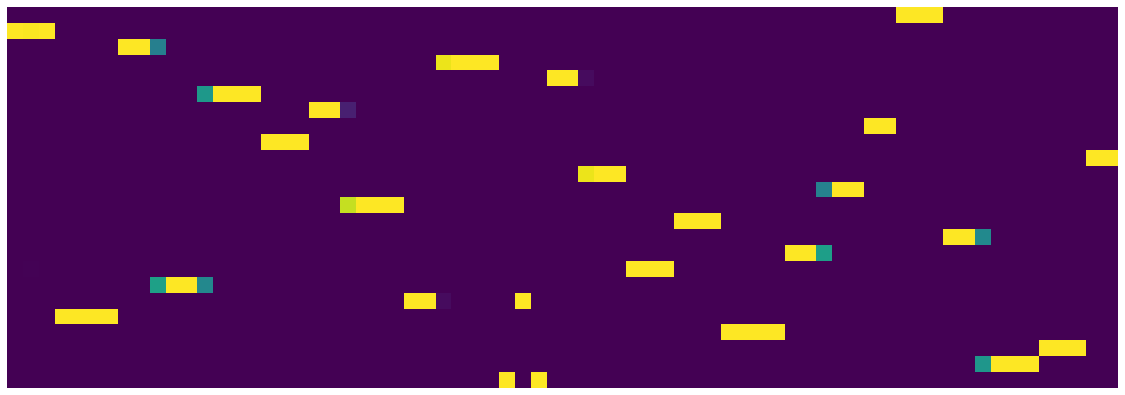

24 270 0.7289999999999998 0.45617162585258486


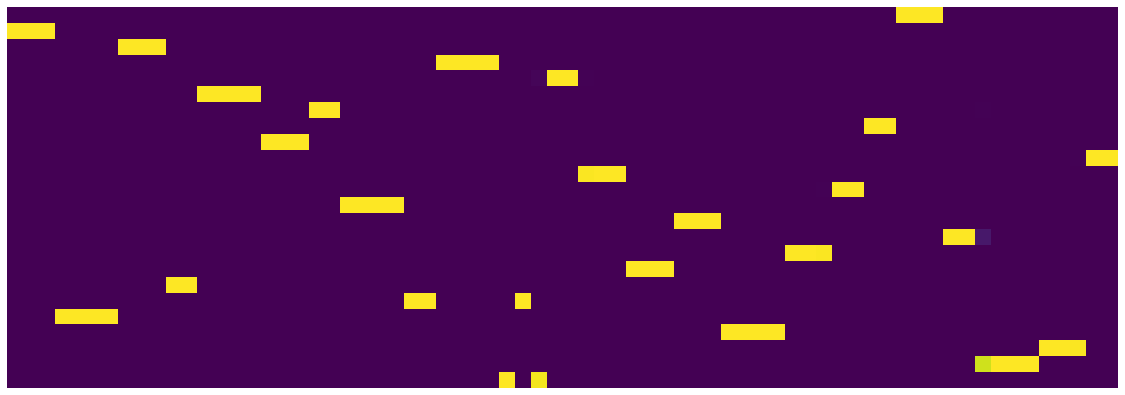

24 271 0.7279999999999998 0.45724515840411184


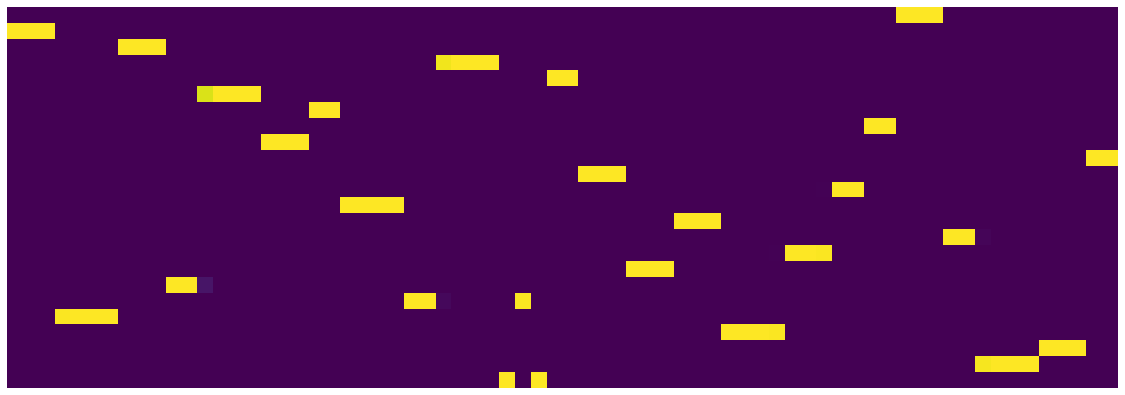

24 272 0.7269999999999998 0.4559752708300948


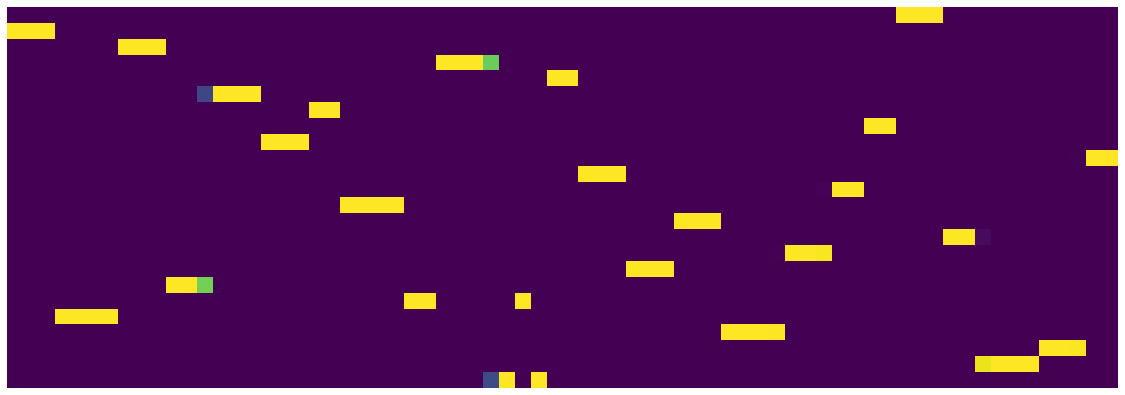

24 273 0.7259999999999998 0.4555142575874925


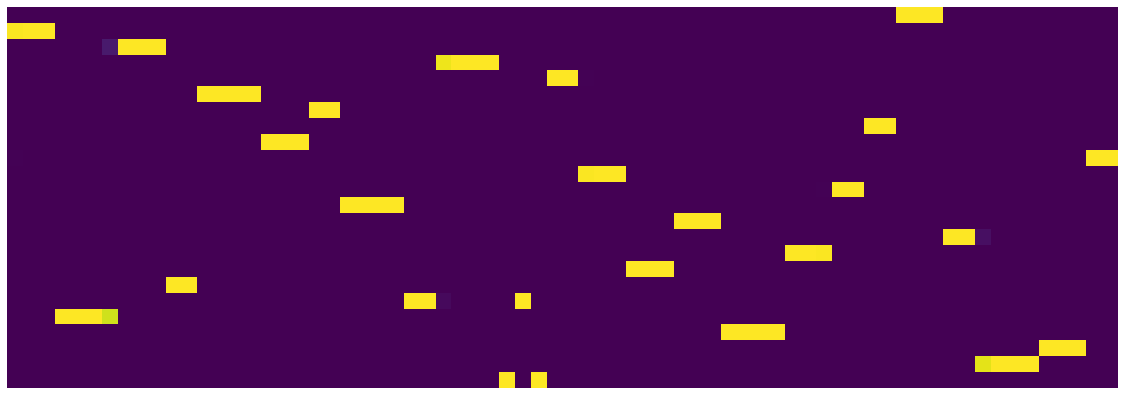

24 274 0.7249999999999998 0.45496713034808633


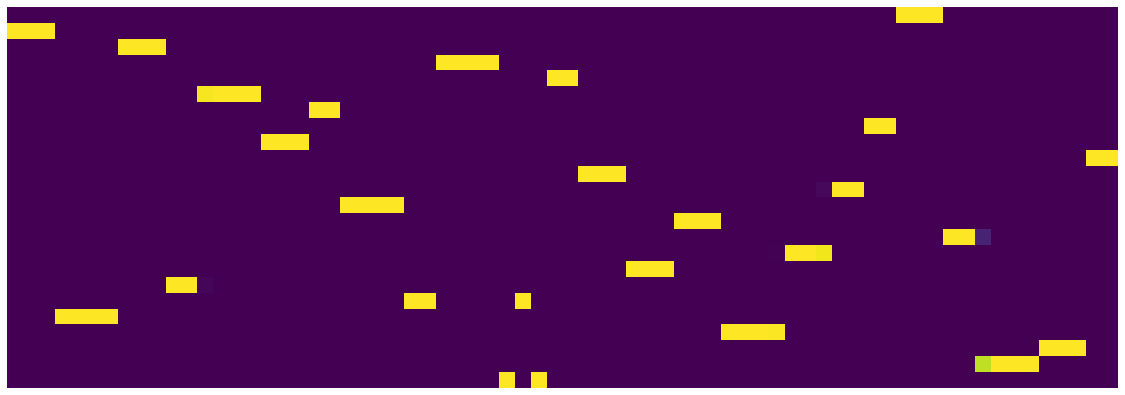

24 275 0.7239999999999998 0.4556146522983909


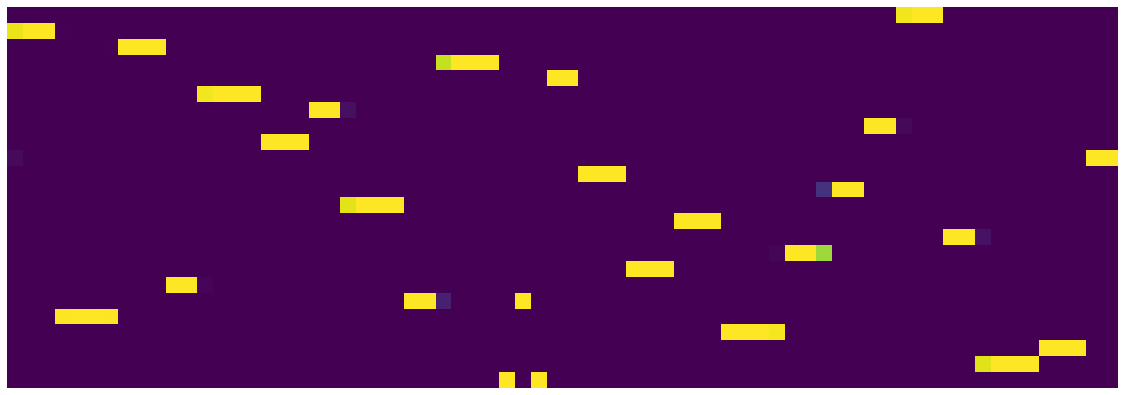

24 276 0.7229999999999998 0.4549951758235693


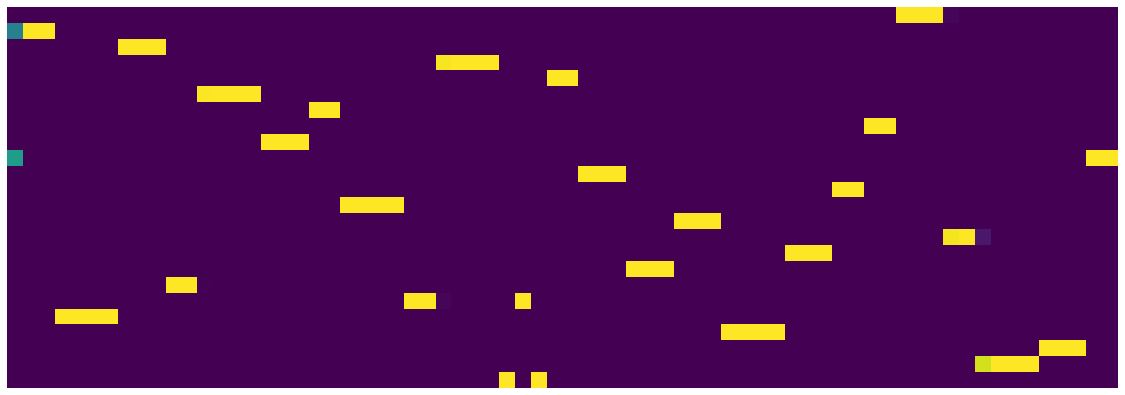

24 277 0.7219999999999998 0.45568020157516004


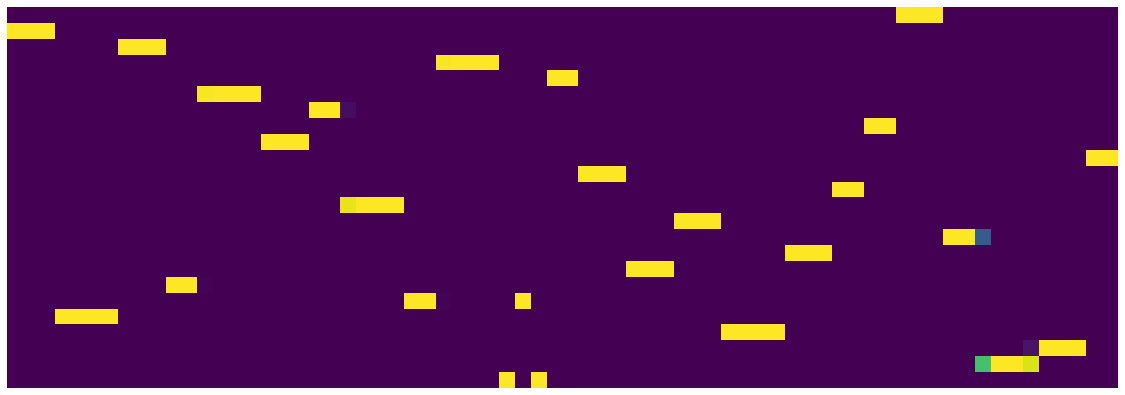

24 278 0.7209999999999998 0.4549623467028141


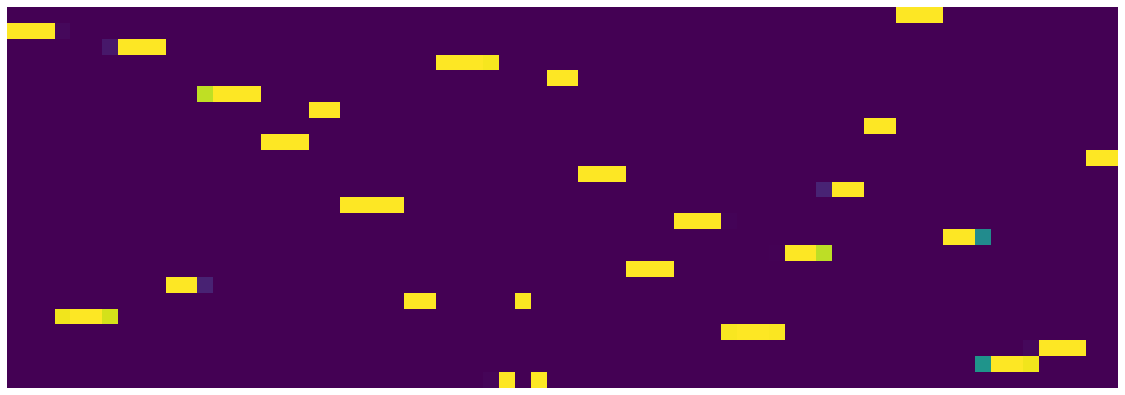

24 279 0.7199999999999998 0.45549261644482614


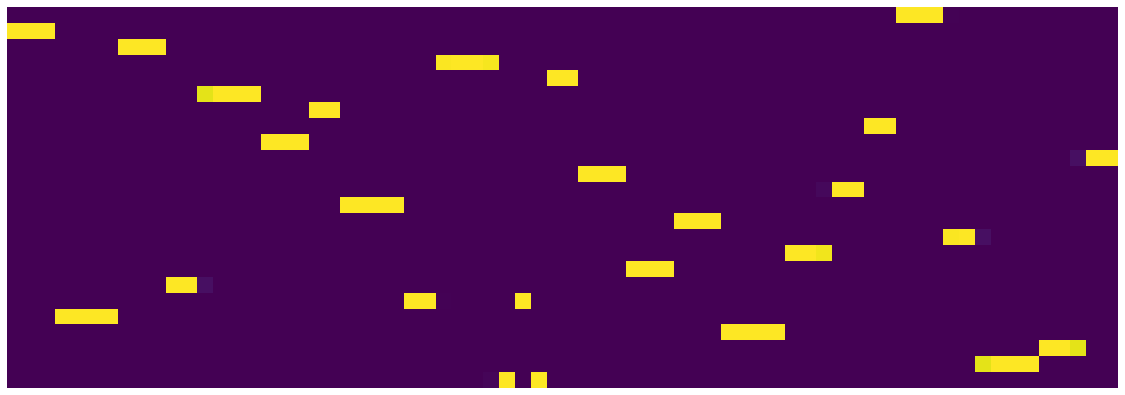

24 280 0.7189999999999998 0.45551838018000124


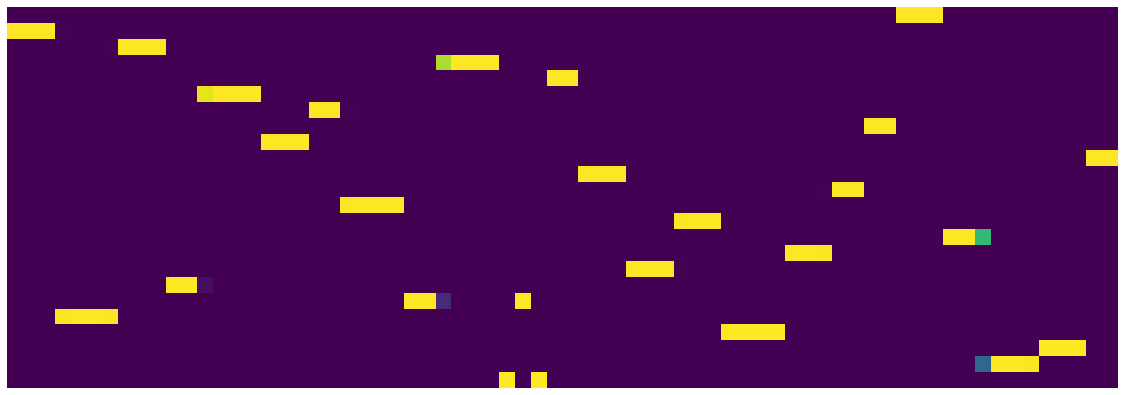

24 281 0.7179999999999997 0.45614913310855626


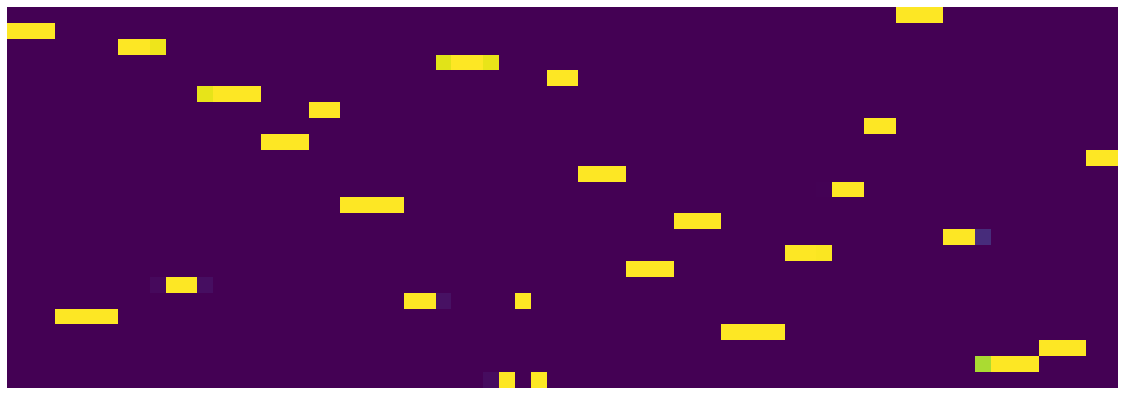

24 282 0.7169999999999997 0.4552778944373131


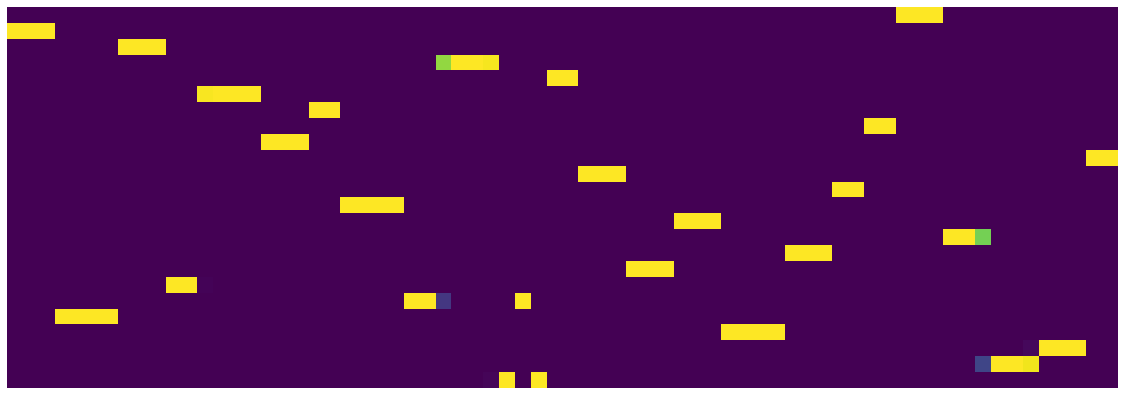

24 283 0.7159999999999997 0.4548665599897504


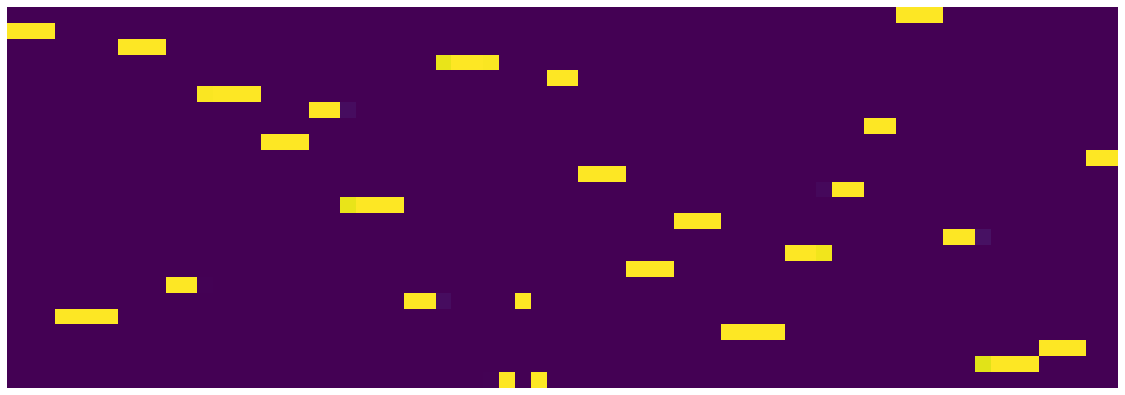

24 284 0.7149999999999997 0.4551570976153016


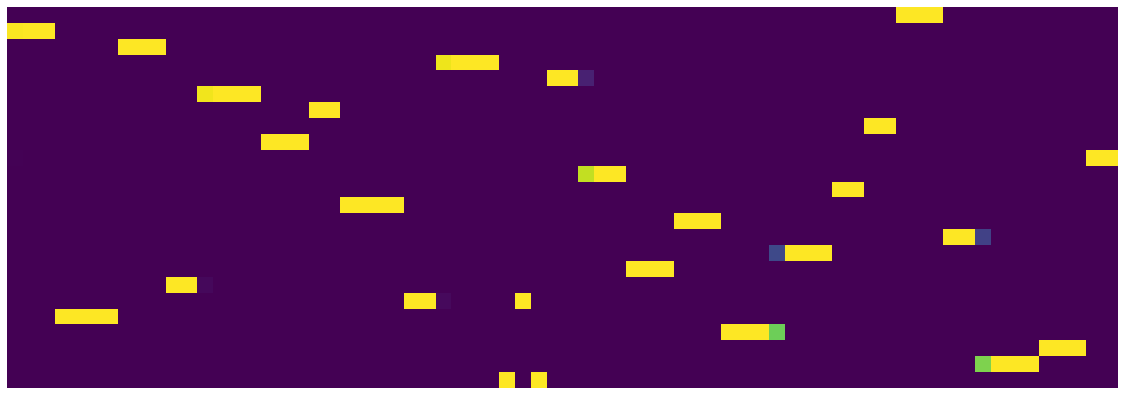

24 285 0.7139999999999997 0.4551777014508843


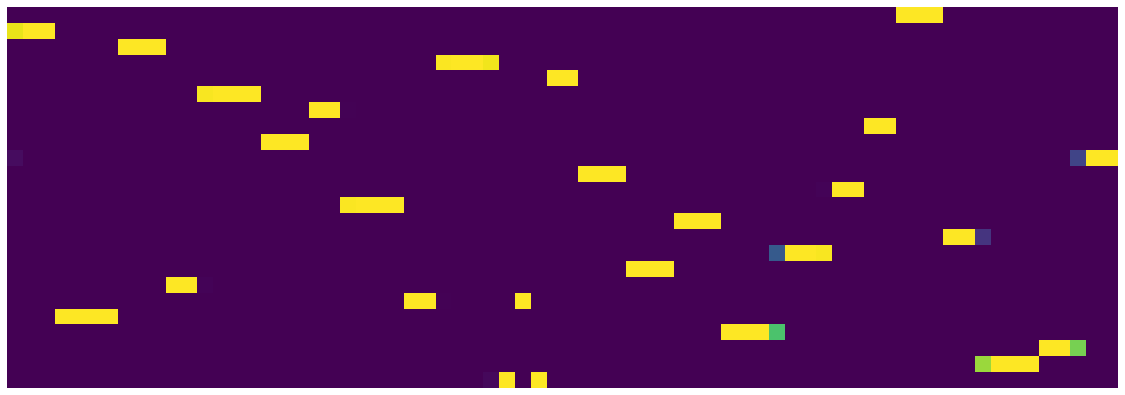

24 286 0.7129999999999997 0.45587701089680194


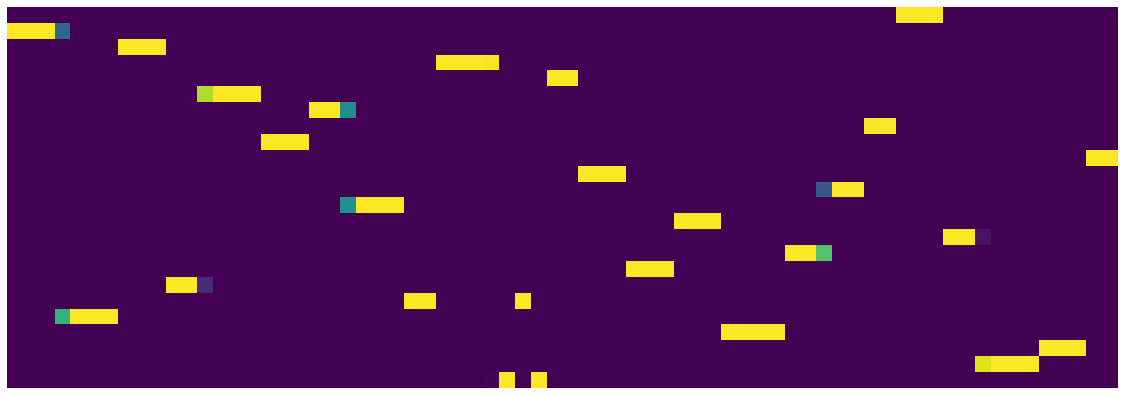

24 287 0.7119999999999997 0.45536320880055425


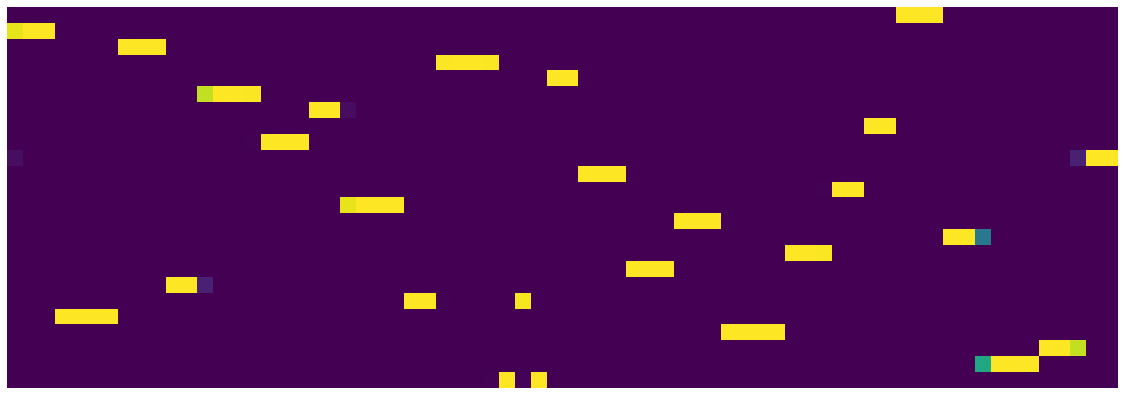

24 288 0.7109999999999997 0.45440616831183434


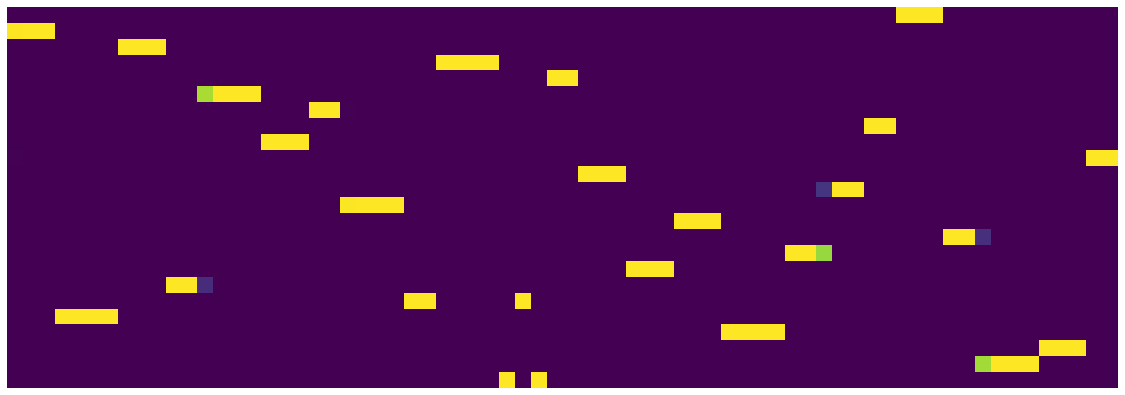

24 289 0.7099999999999997 0.45642801877111194


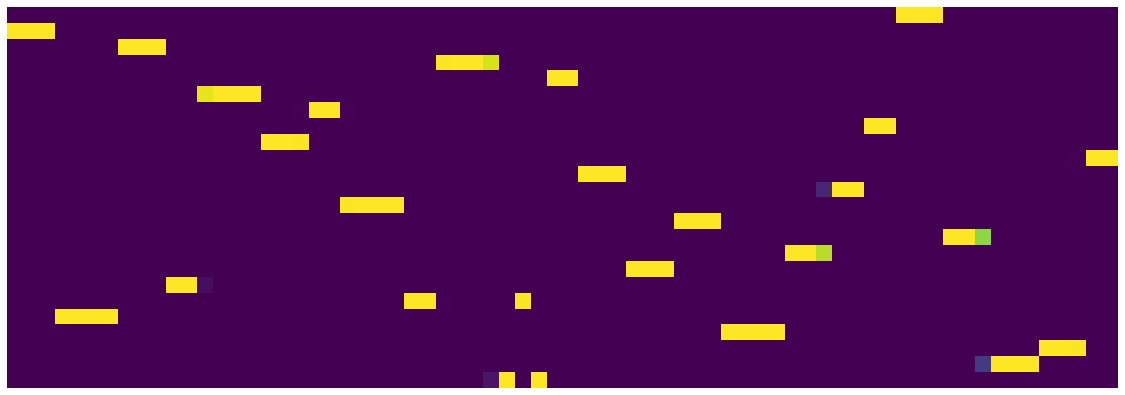

24 290 0.7089999999999997 0.4550543338060379


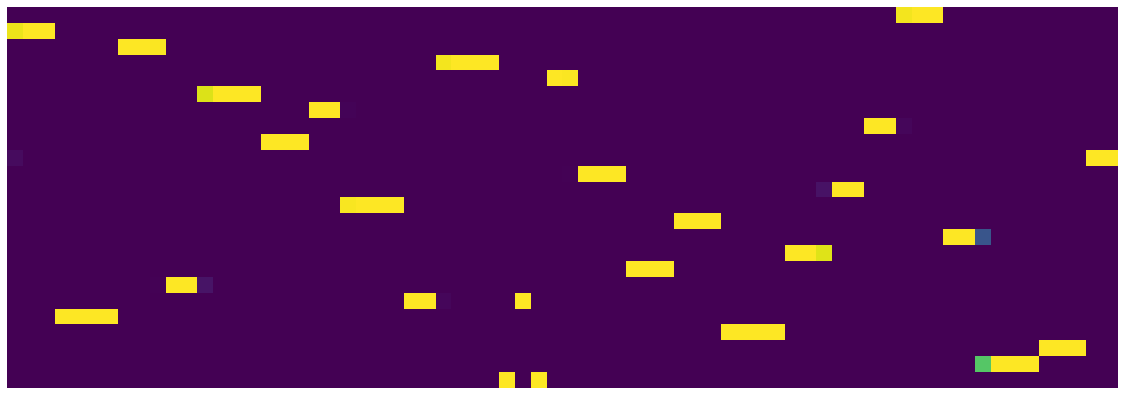

24 291 0.7079999999999997 0.45489852372556927


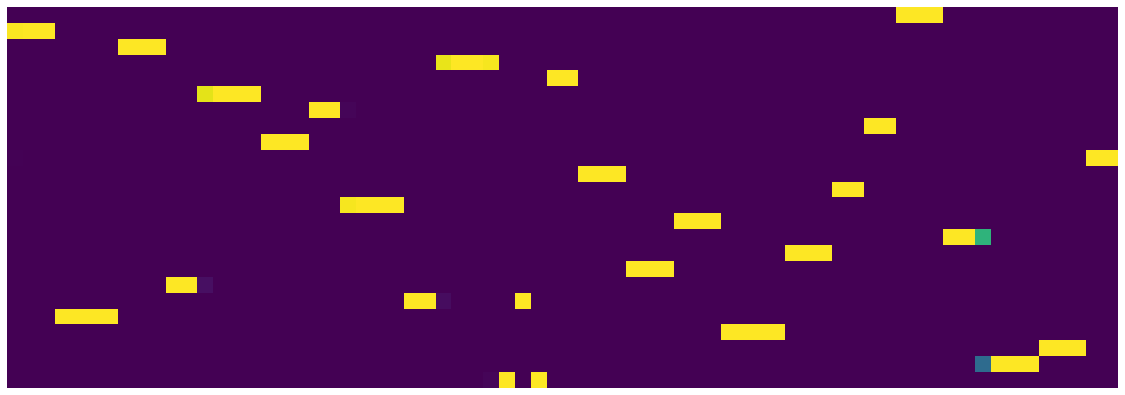

24 292 0.7069999999999997 0.45548289027065036


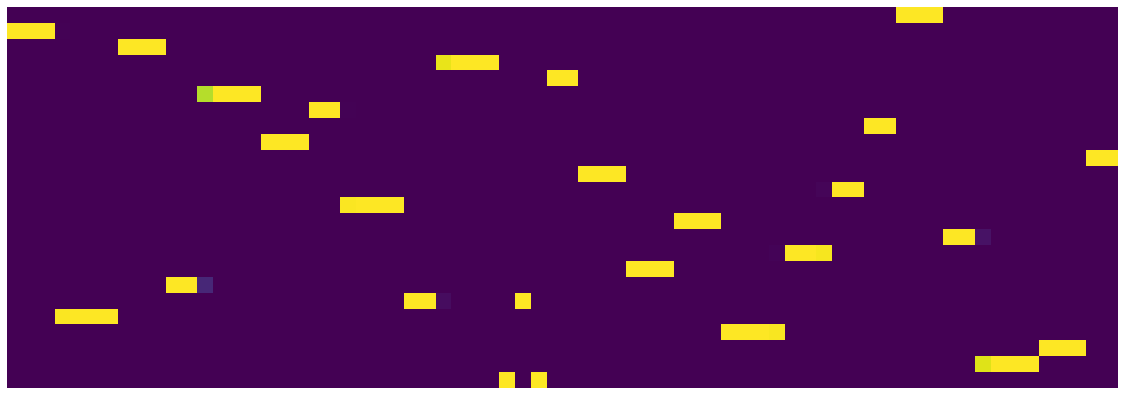

24 293 0.7059999999999997 0.4553258018568158


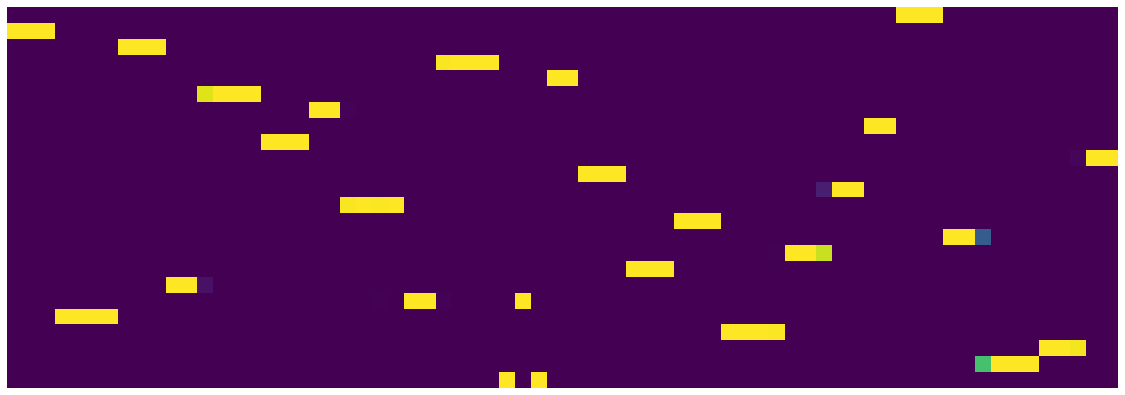

24 294 0.7049999999999997 0.45559099707752465


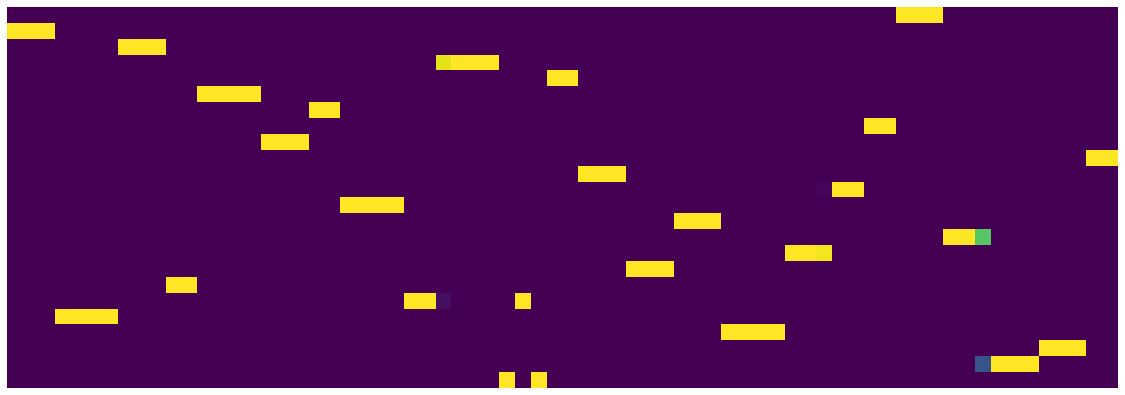

24 295 0.7039999999999997 0.4546634955331683


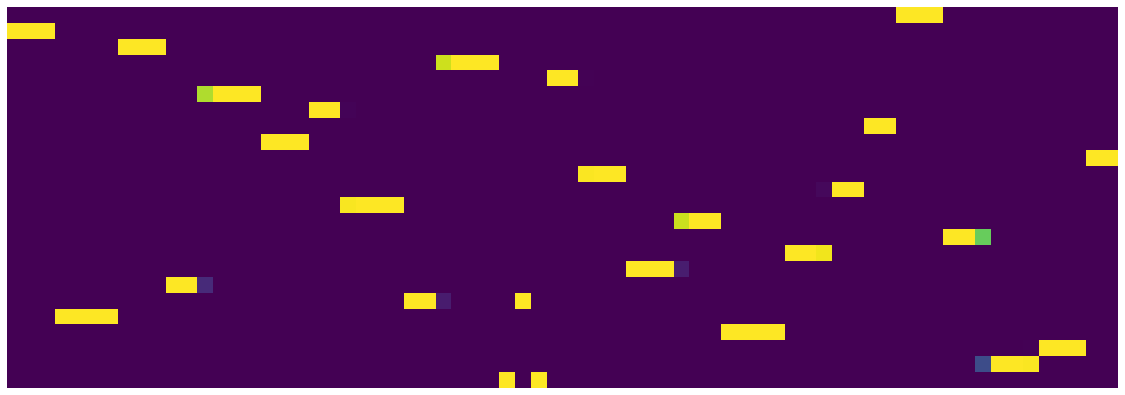

24 296 0.7029999999999997 0.454103010520339


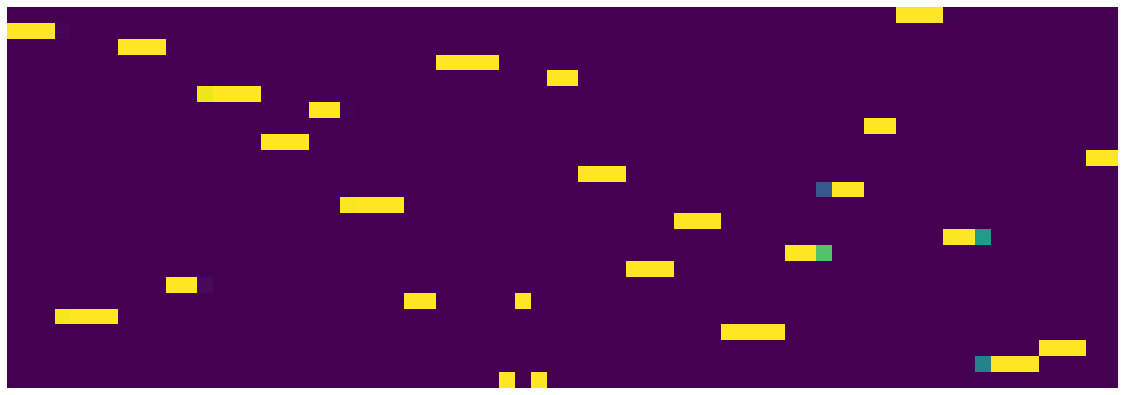

24 297 0.7019999999999997 0.4542423190549016


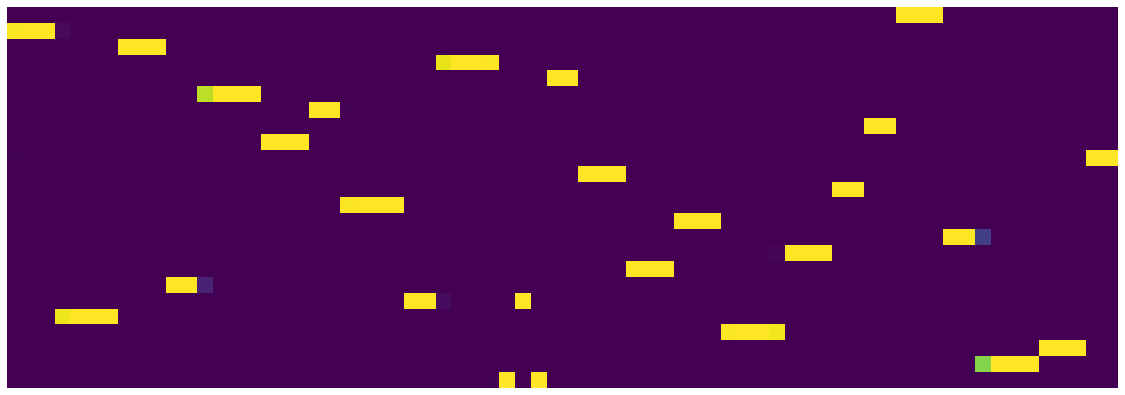

24 298 0.7009999999999997 0.4574677351862192


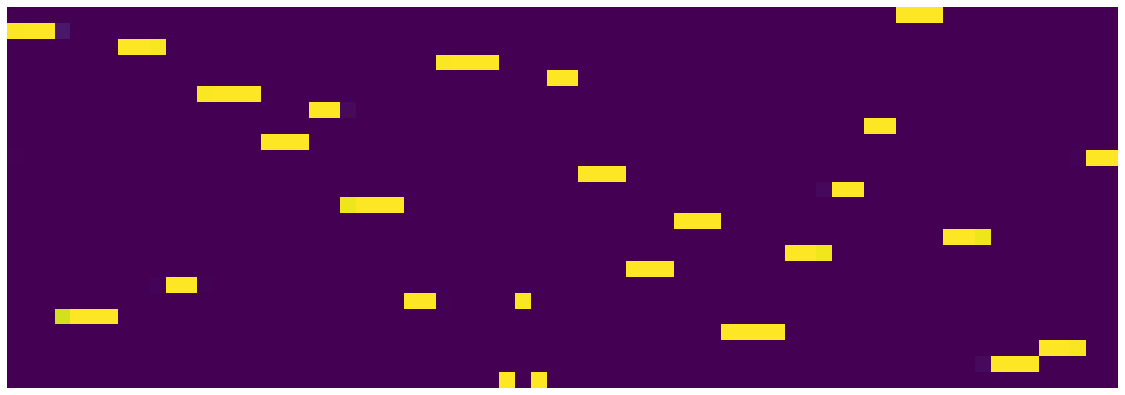

24 299 0.6999999999999997 0.4535982159897685


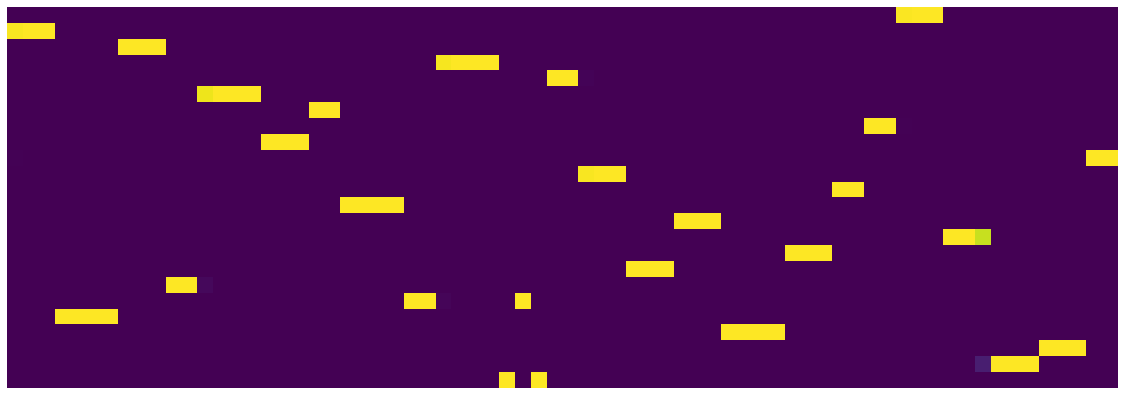

24 300 0.6989999999999997 0.45314492639154197


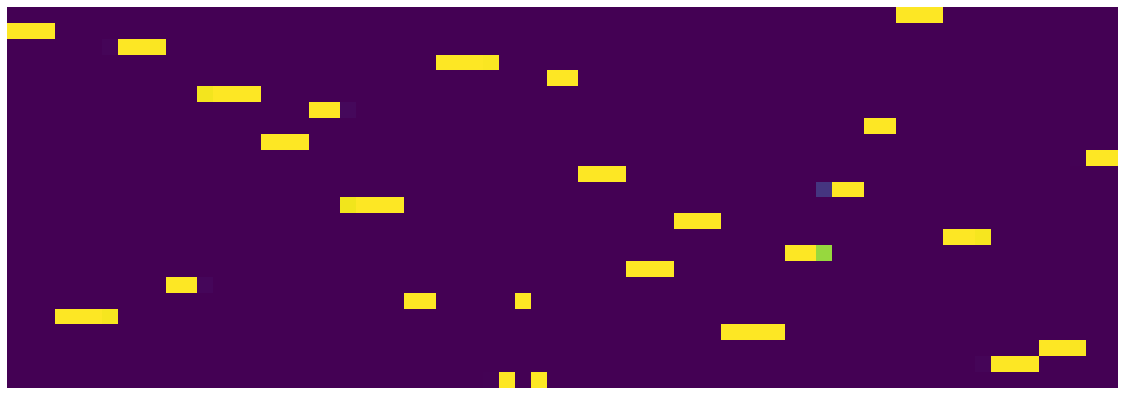

24 301 0.6979999999999997 0.45325104873627425


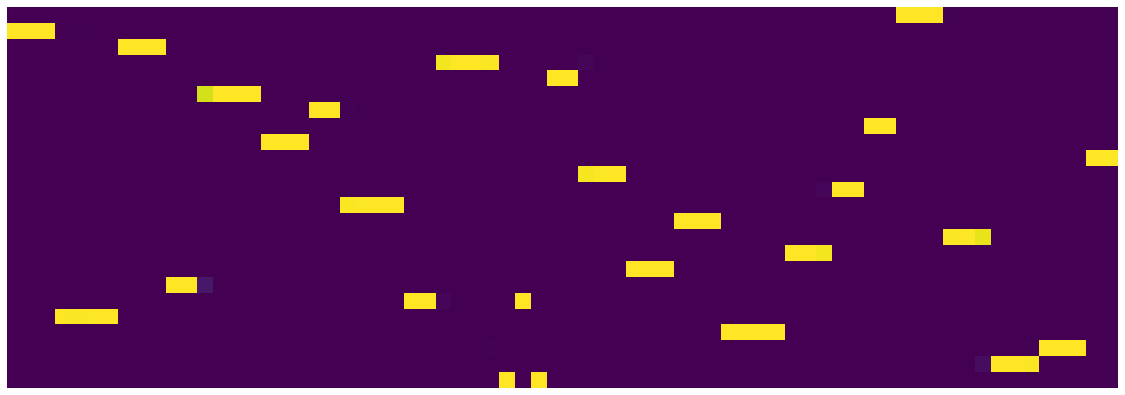

24 302 0.6969999999999997 0.4532600846141577


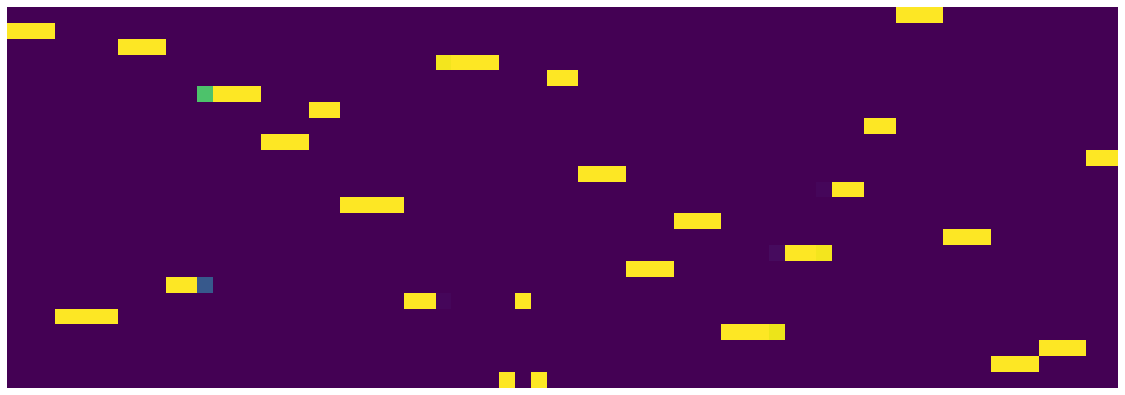

24 303 0.6959999999999997 0.4522621465846896


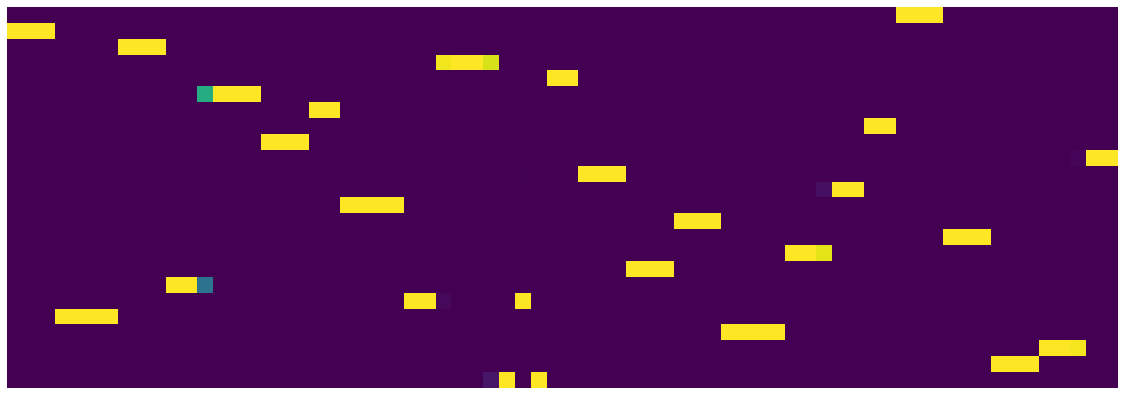

24 304 0.6949999999999997 0.452520995028317


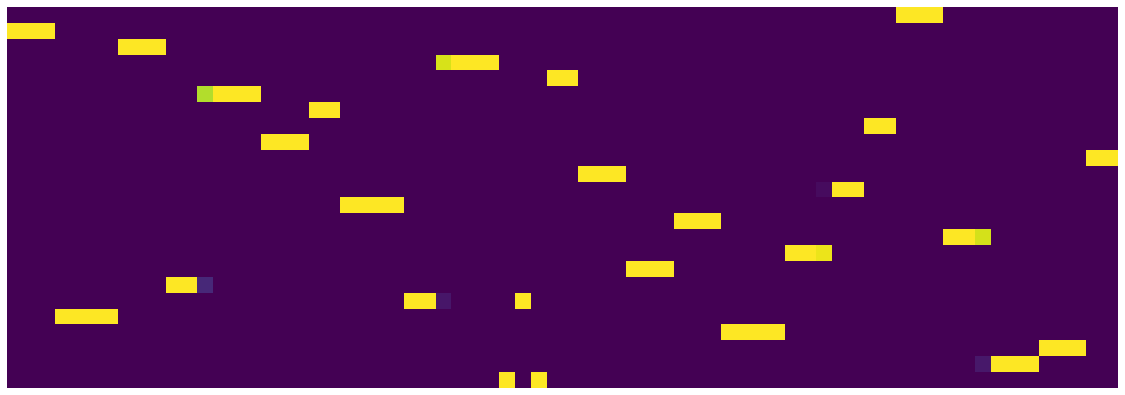

24 305 0.6939999999999997 0.45317595843225716


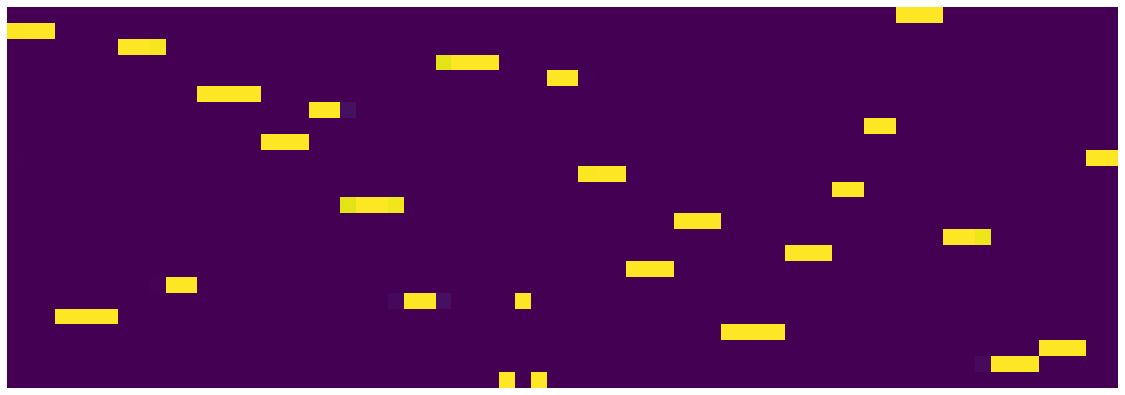

24 306 0.6929999999999997 0.4515682701021433


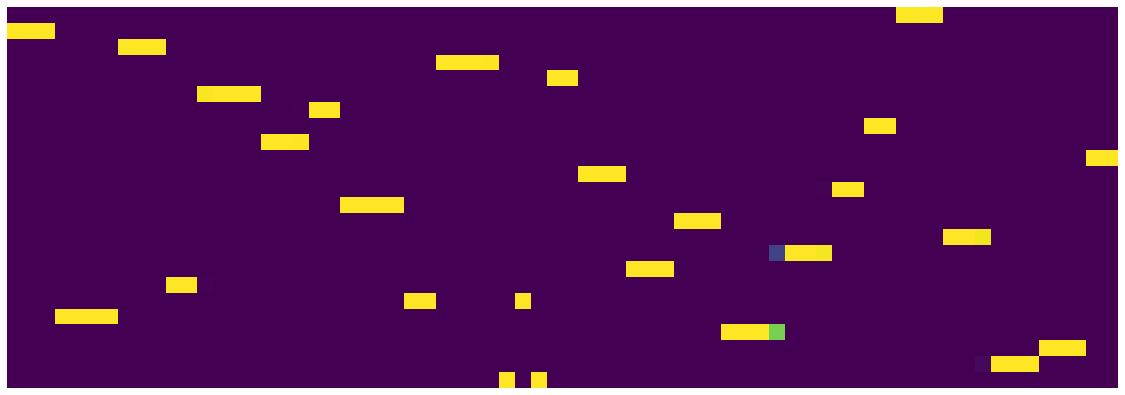

24 307 0.6919999999999997 0.4526294771581888


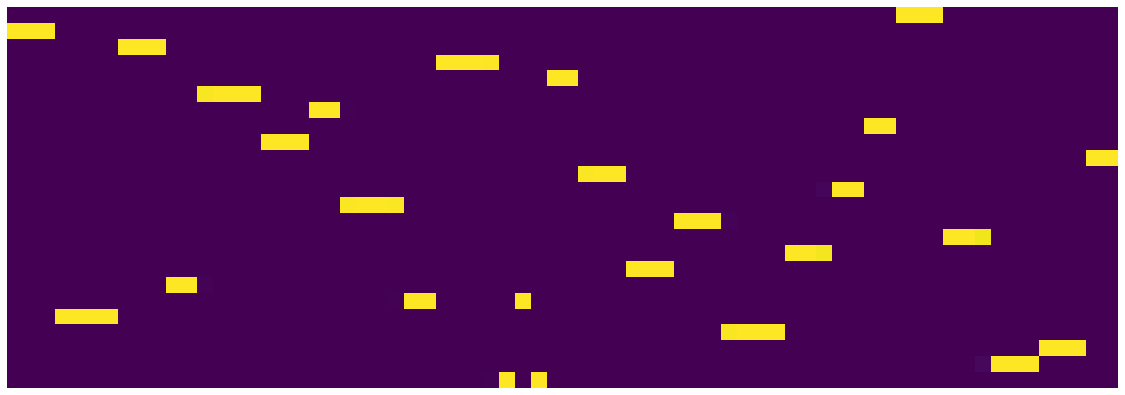

24 308 0.6909999999999997 0.45508869774639604


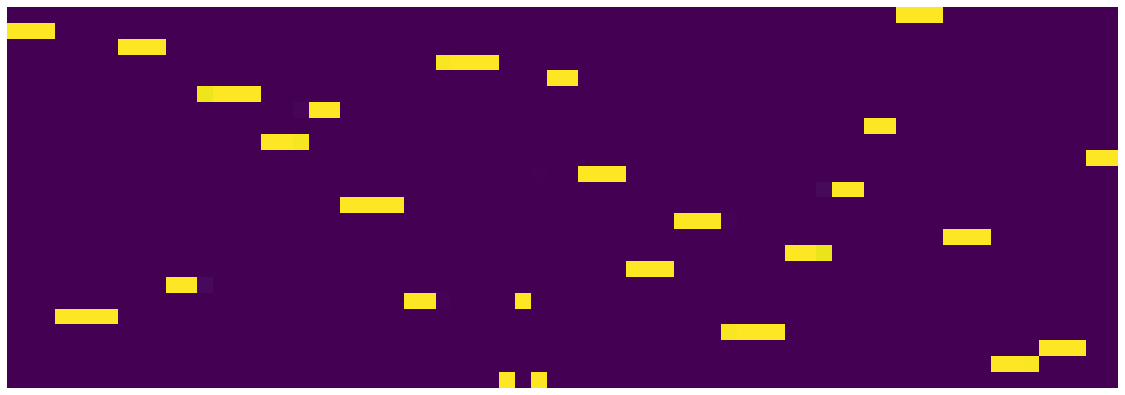

24 309 0.6899999999999997 0.45253330674022435


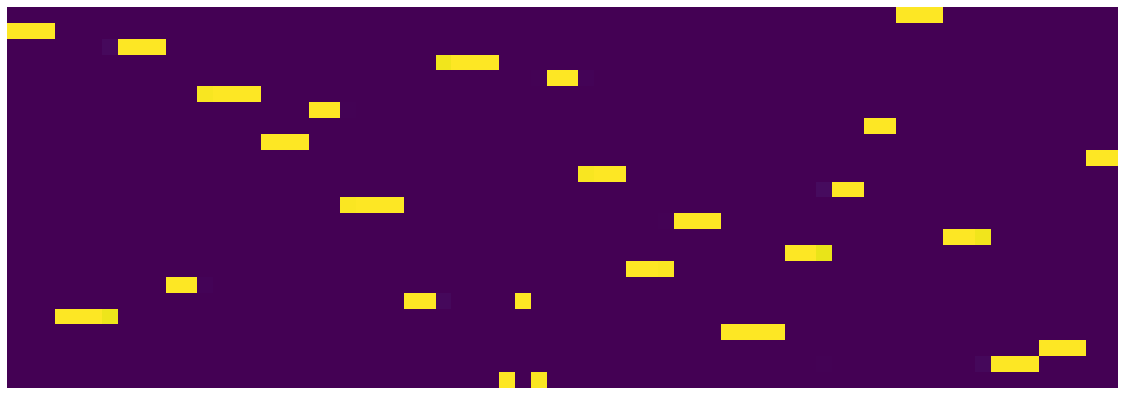

24 310 0.6889999999999997 0.45272456798702476


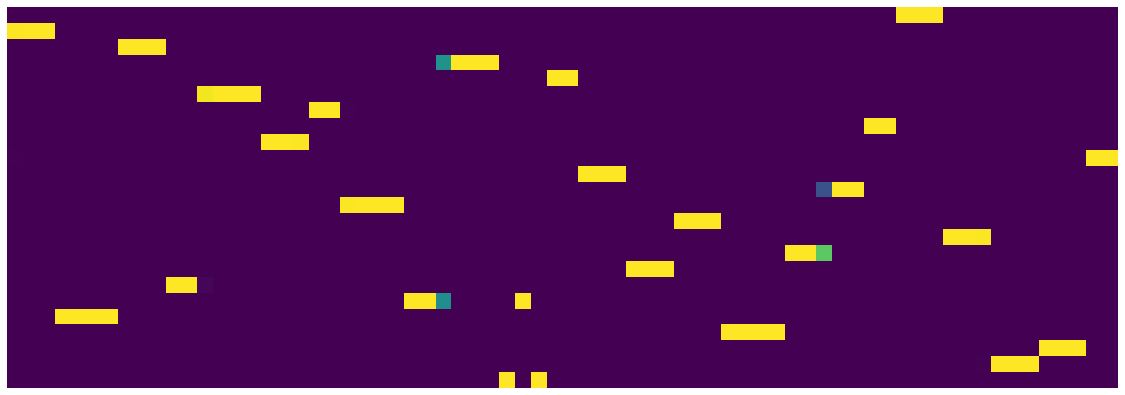

24 311 0.6879999999999997 0.4520541911944747


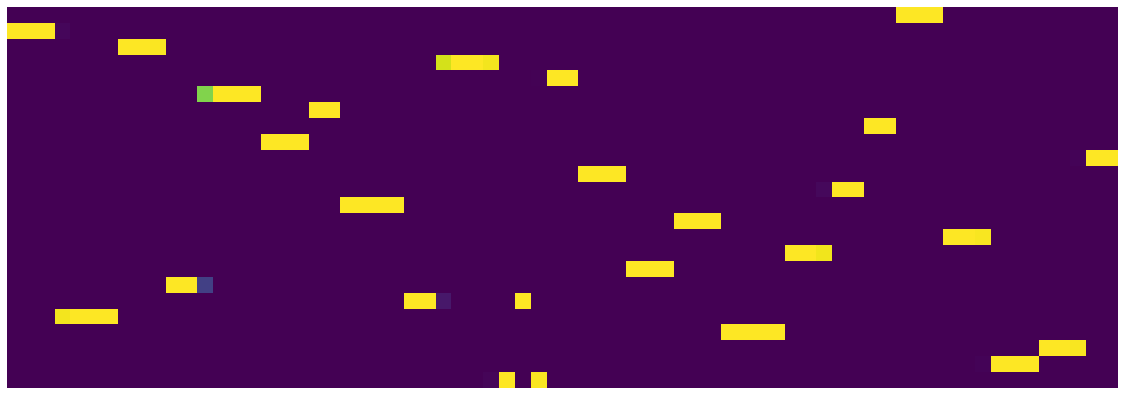

24 312 0.6869999999999997 0.4537887446582317


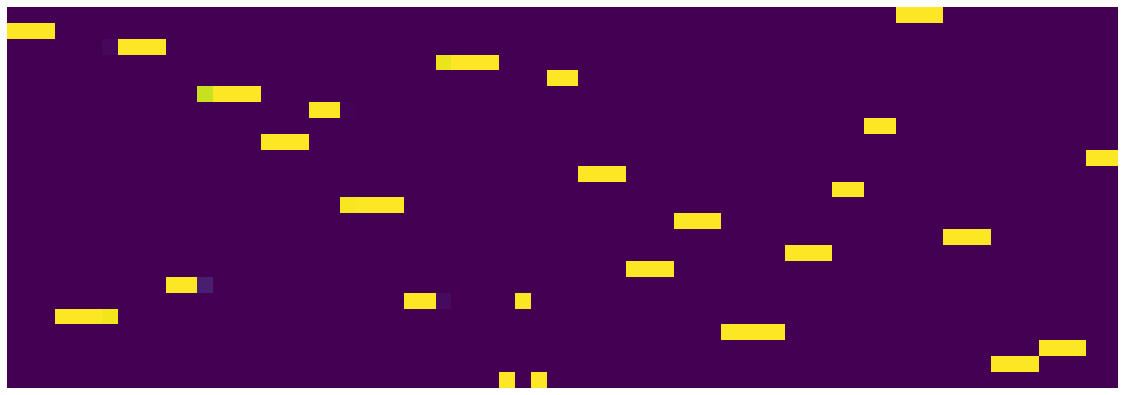

24 313 0.6859999999999997 0.45329385325312616


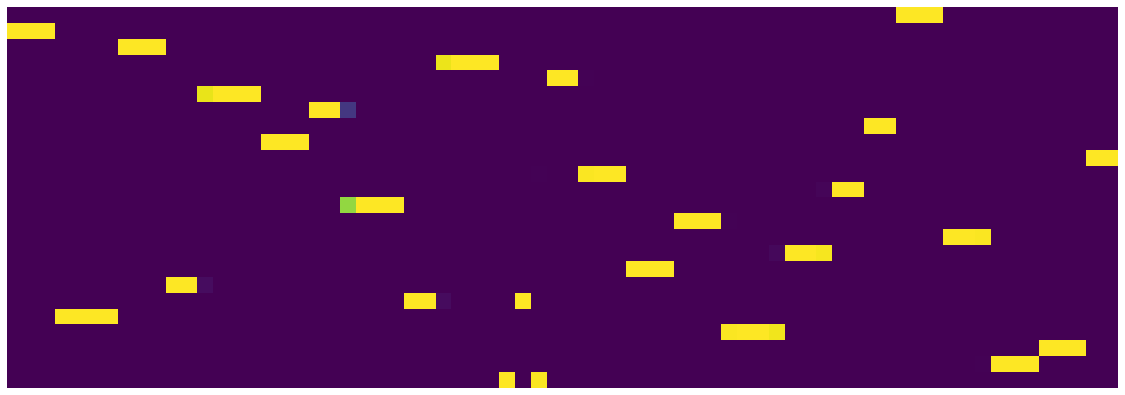

24 314 0.6849999999999997 0.45627753492444756


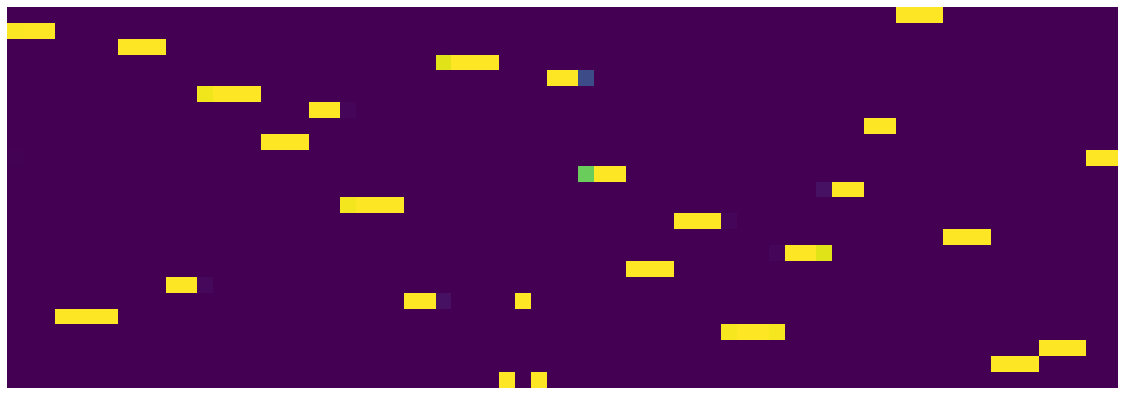

24 315 0.6839999999999997 0.4534890200942755


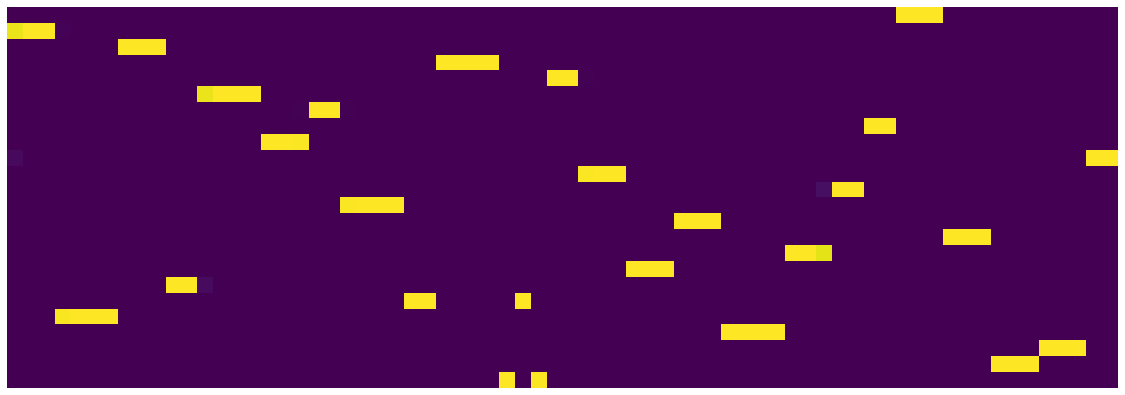

24 316 0.6829999999999997 0.4525266641750932


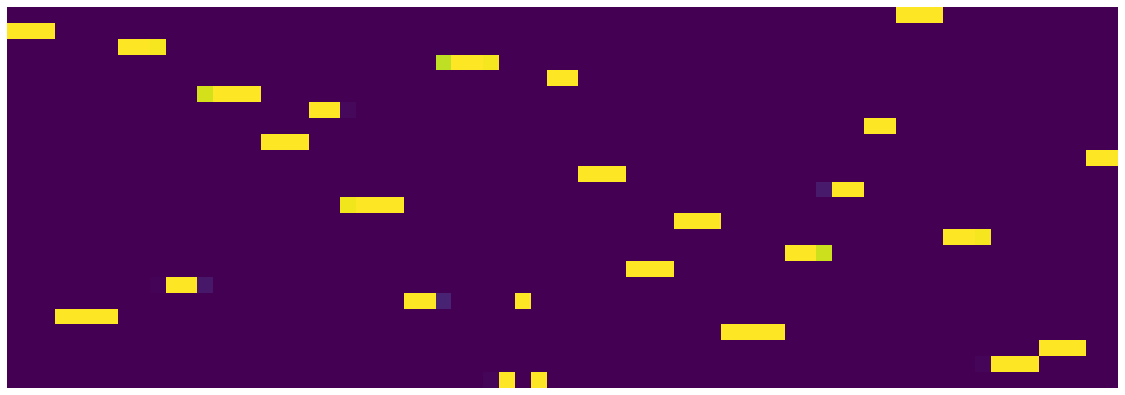

24 317 0.6819999999999997 0.4527276076376438


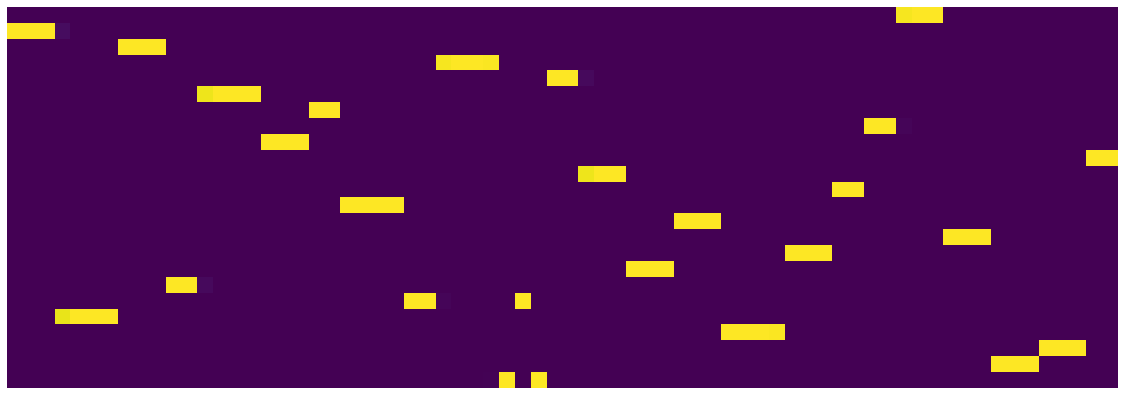

24 318 0.6809999999999997 0.4523528922349215


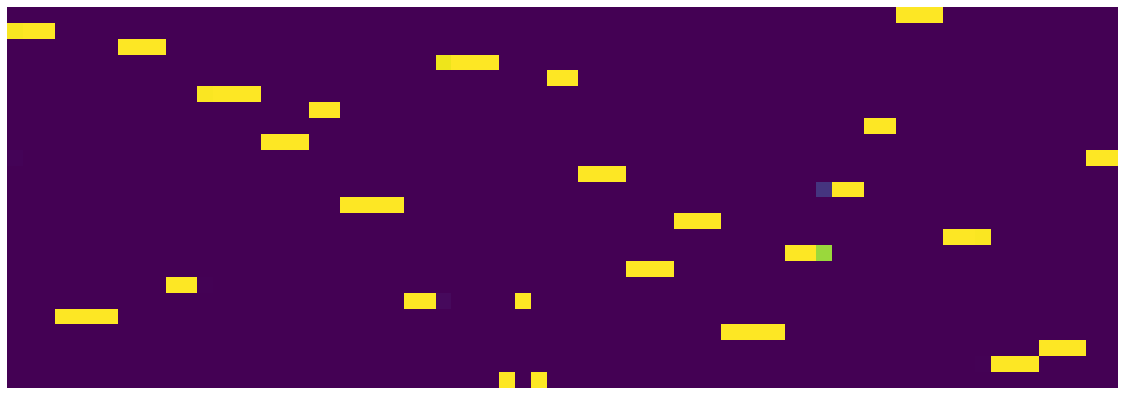

24 319 0.6799999999999997 0.45447568241506814


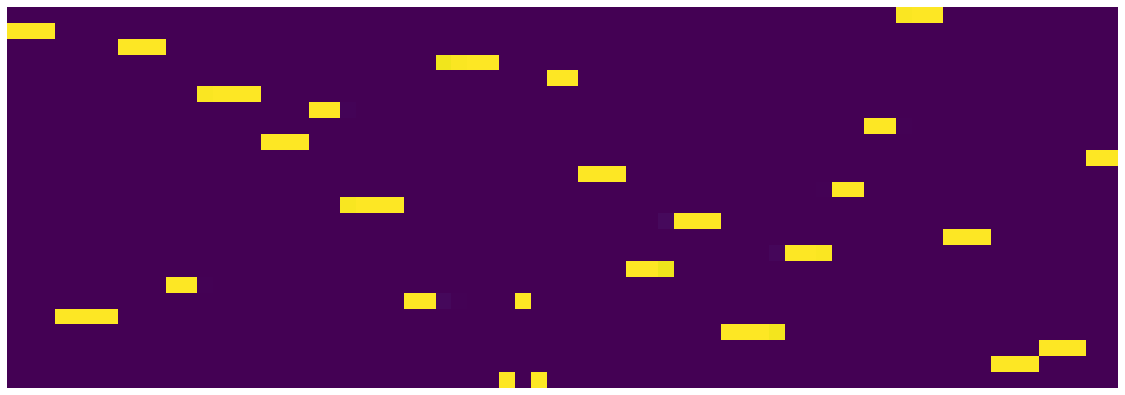

24 320 0.6789999999999997 0.452789106965065


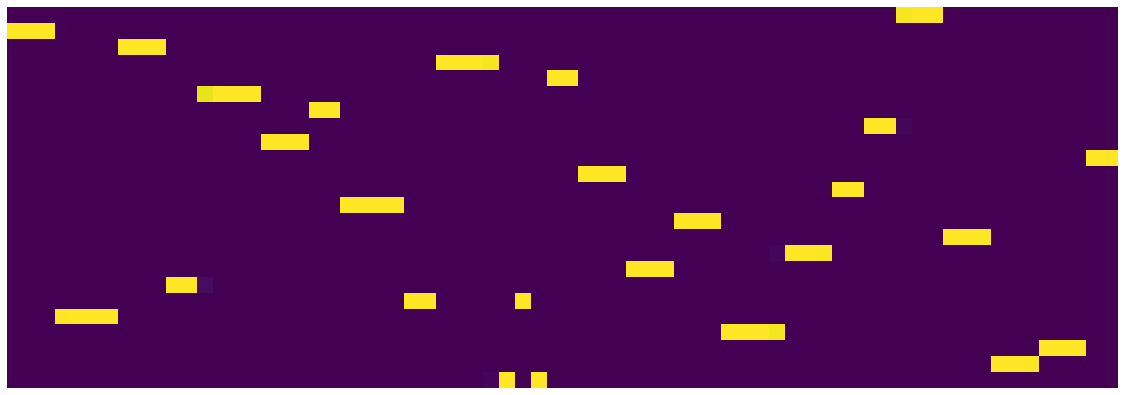

24 321 0.6779999999999997 0.45202620327472687


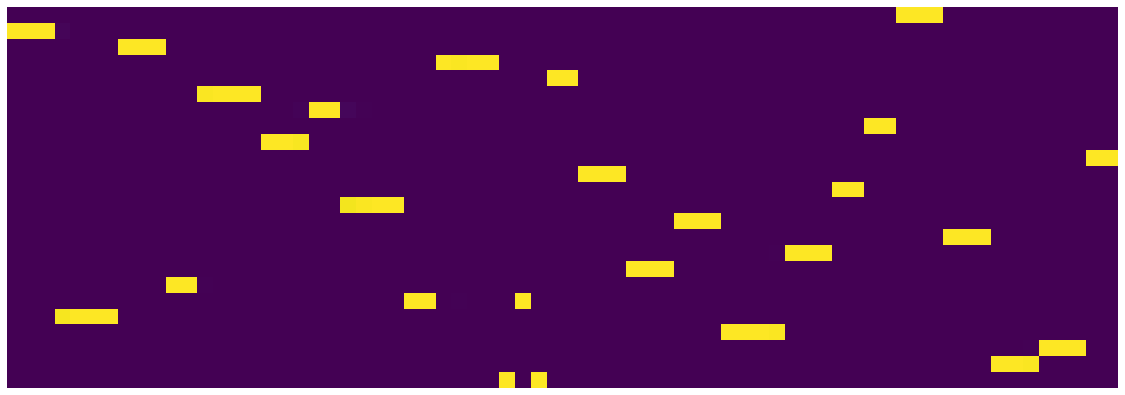

24 322 0.6769999999999997 0.45248910766094924


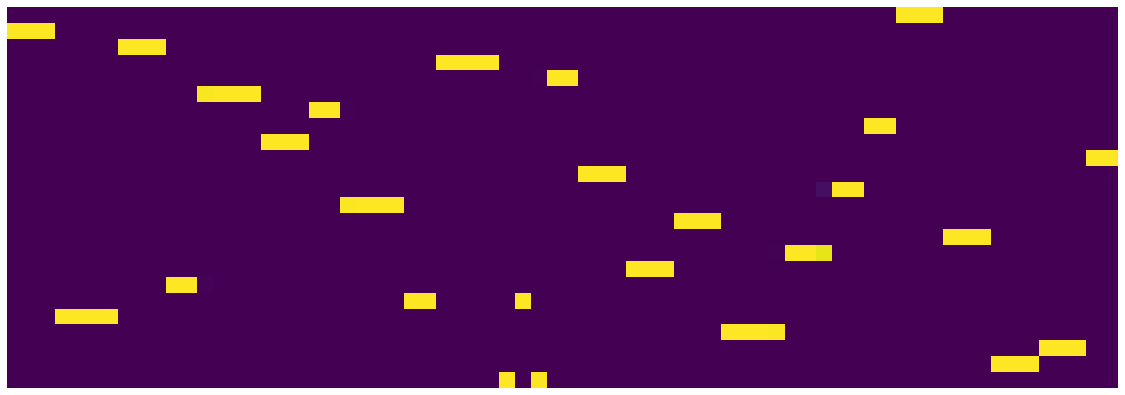

24 323 0.6759999999999997 0.45209094788879156


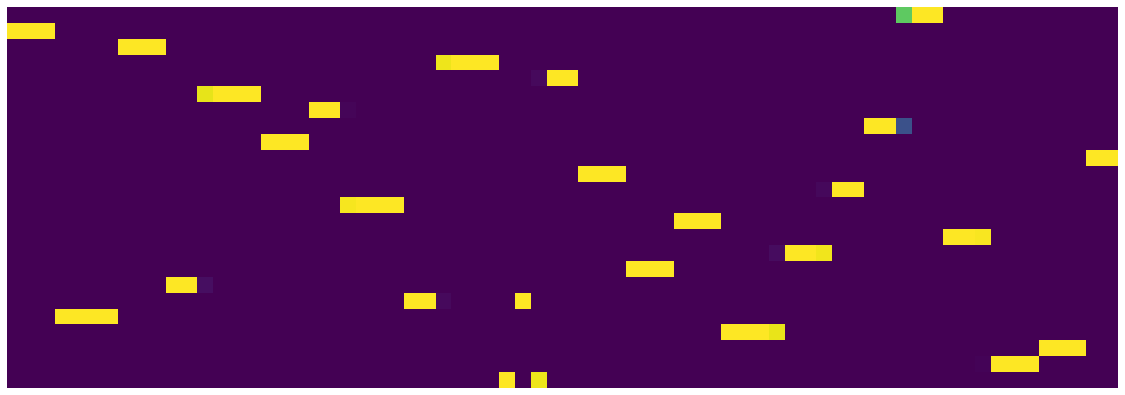

24 324 0.6749999999999997 0.45246470607817174


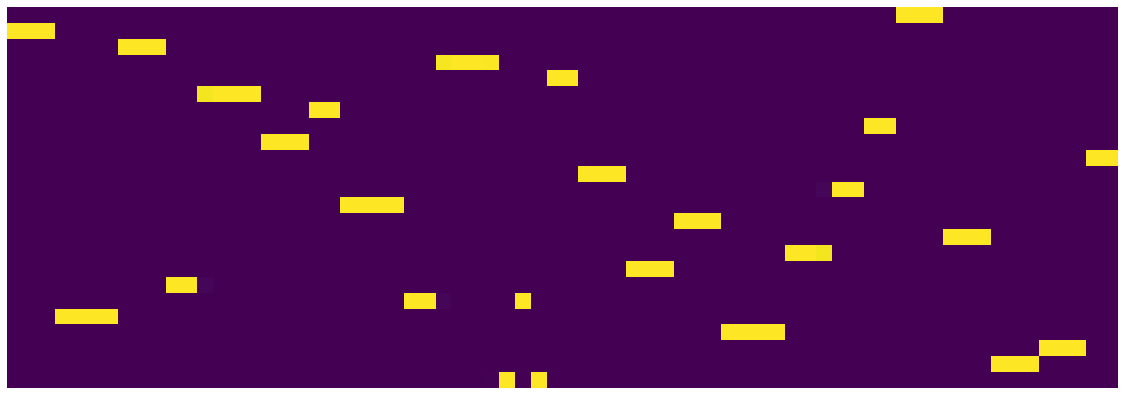

24 325 0.6739999999999997 0.45197642147541045


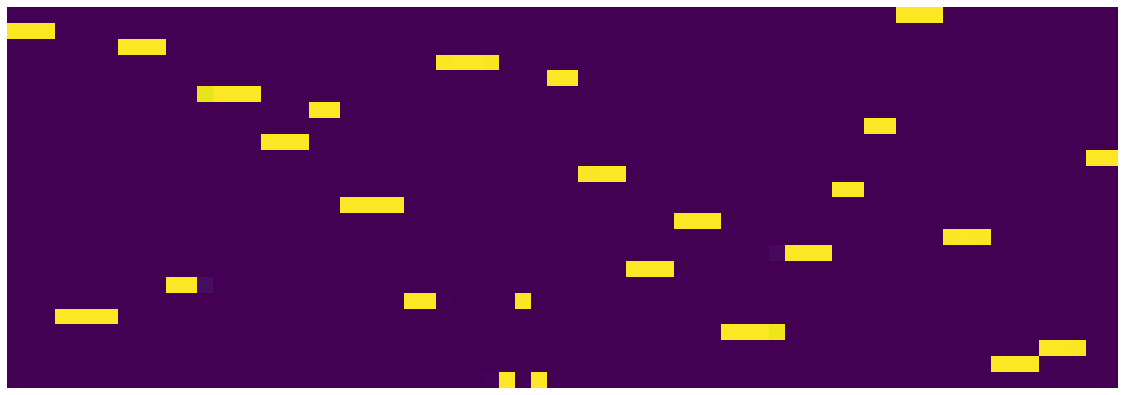

24 326 0.6729999999999997 0.4521602183580399


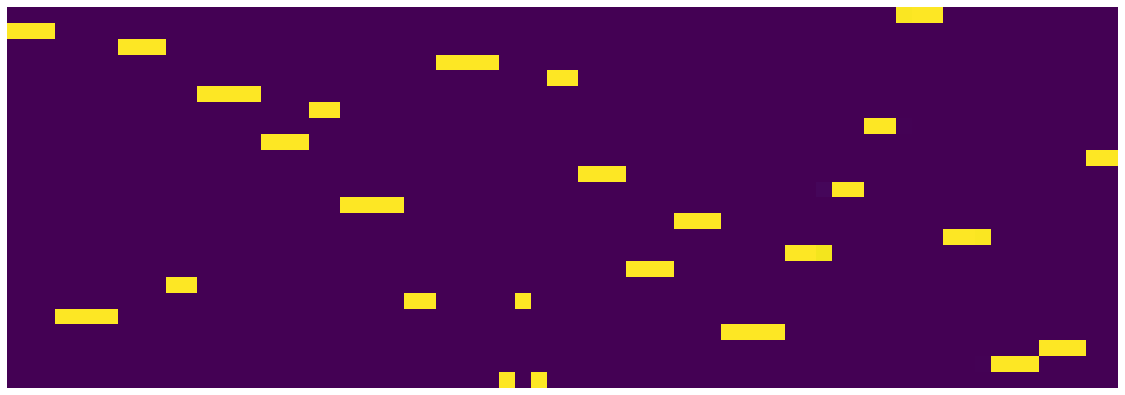

24 327 0.6719999999999997 0.4539563974365592


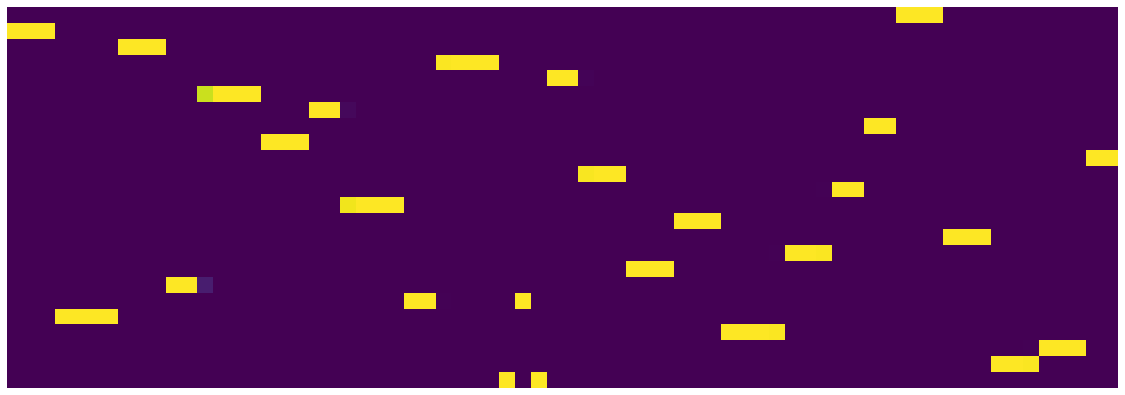

24 328 0.6709999999999997 0.45230910666286944


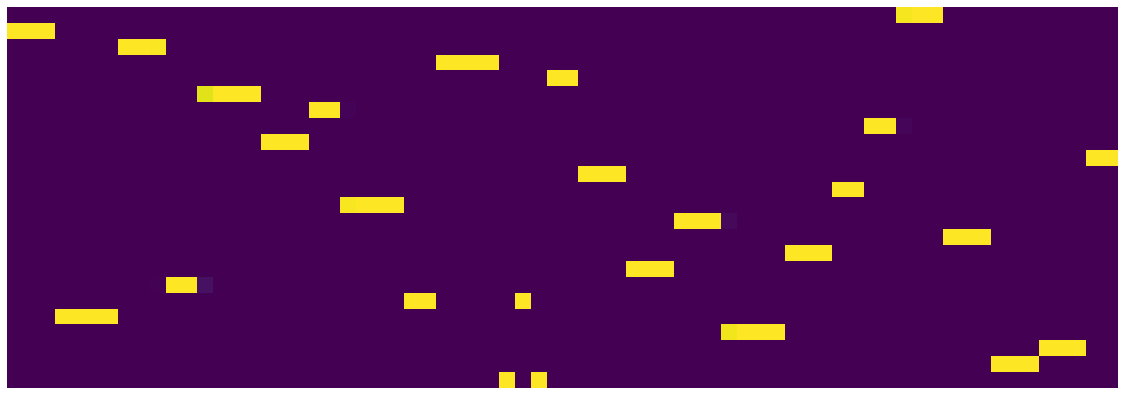

24 329 0.6699999999999997 0.4519335236400366


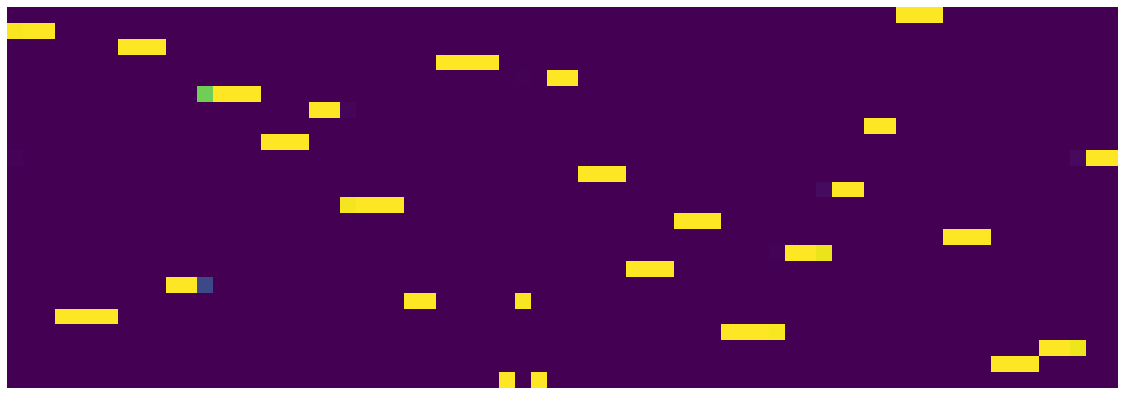

24 330 0.6689999999999997 0.4521505953744054


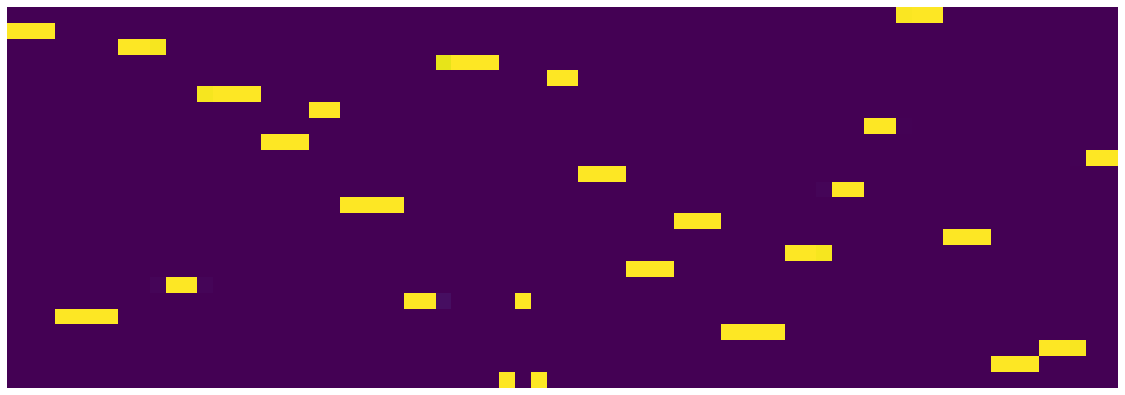

24 331 0.6679999999999997 0.4533818455412984


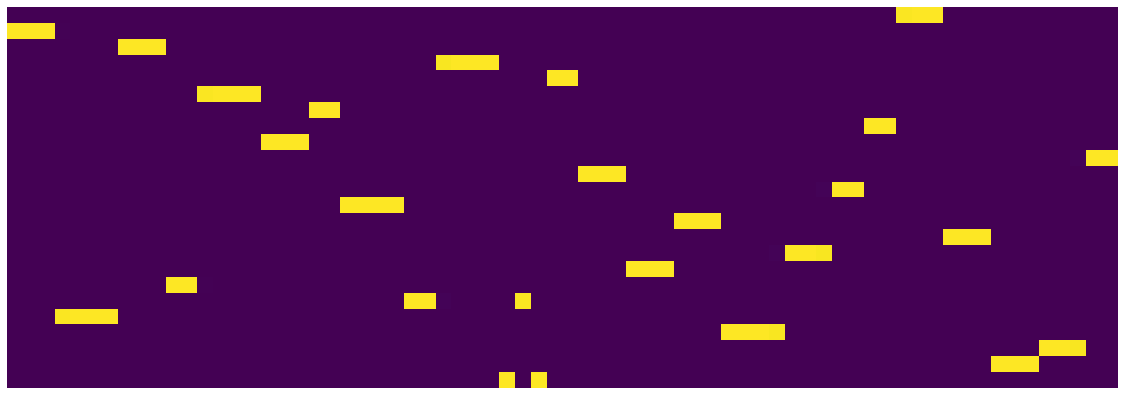

24 332 0.6669999999999997 0.45278483387082813


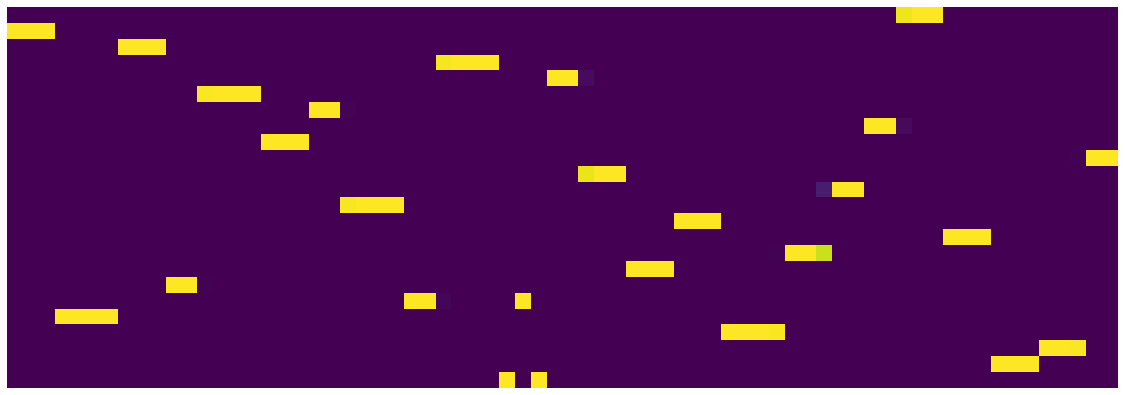

24 333 0.6659999999999997 0.4520723016932607


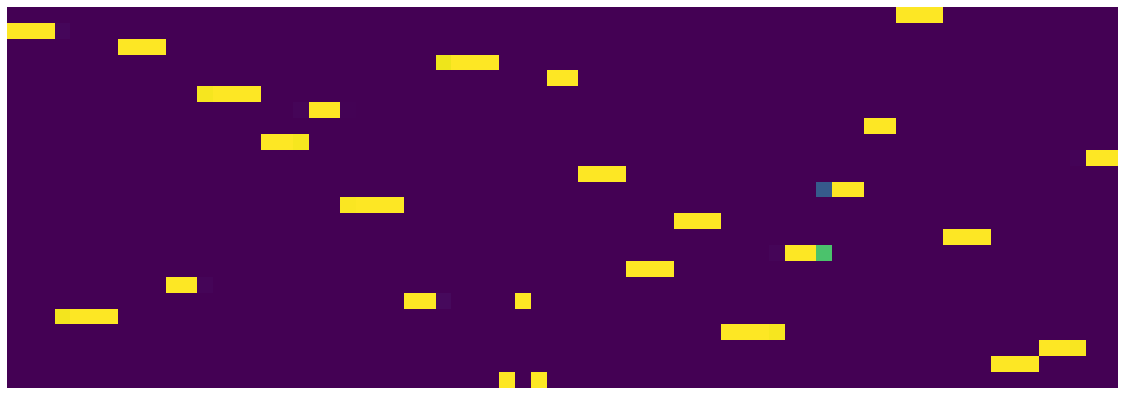

24 334 0.6649999999999997 0.4521751755848527


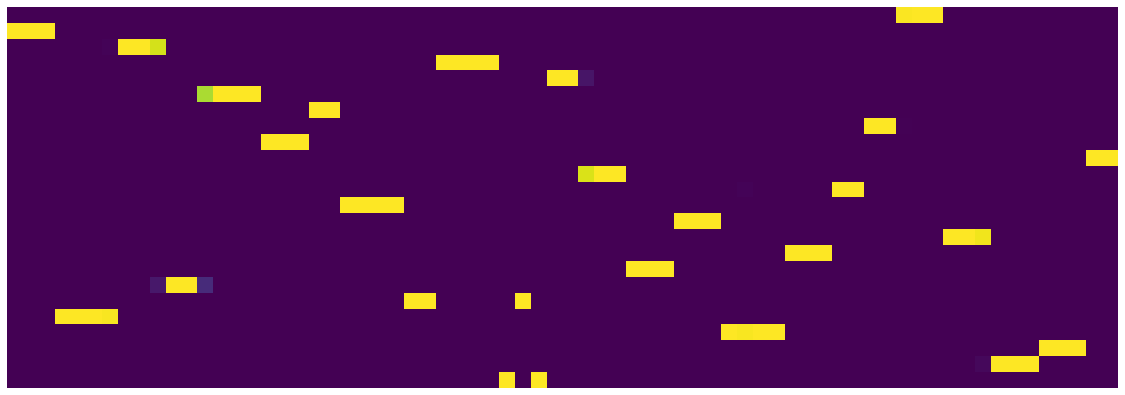

24 335 0.6639999999999997 0.455703460238874


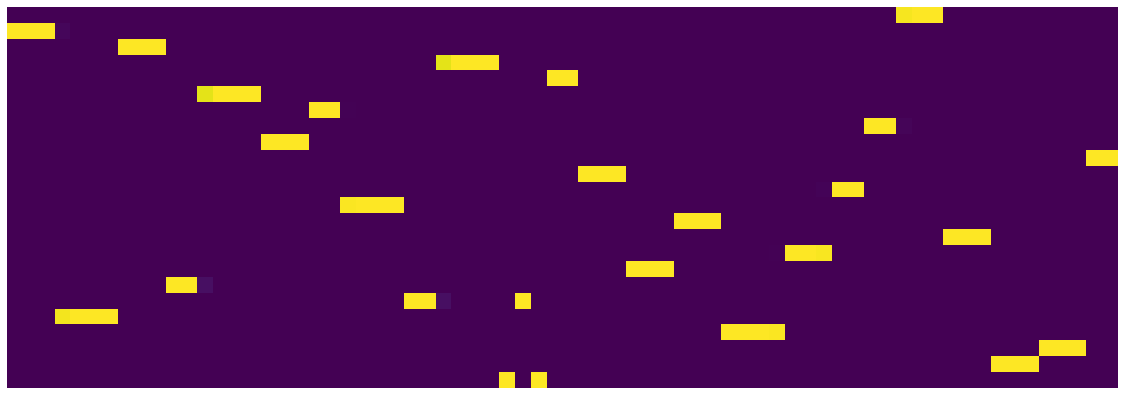

24 336 0.6629999999999997 0.4525019029155374


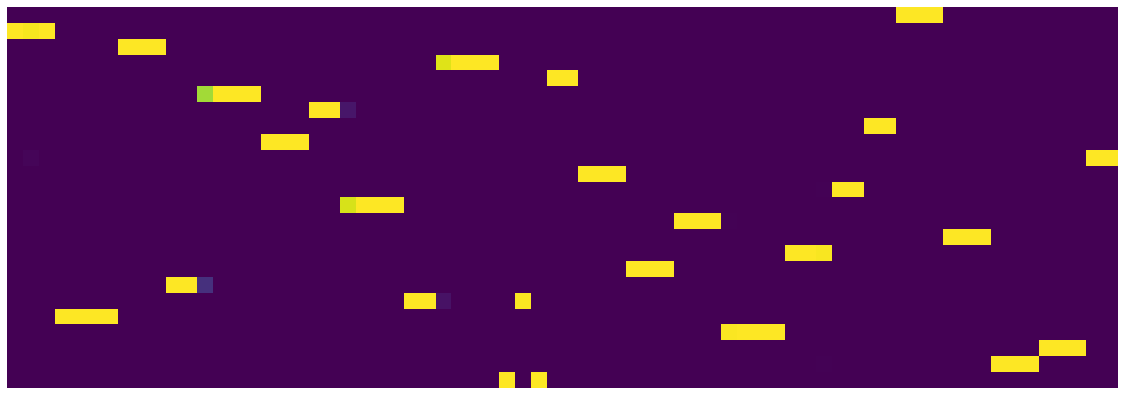

24 337 0.6619999999999997 0.4522601006552577


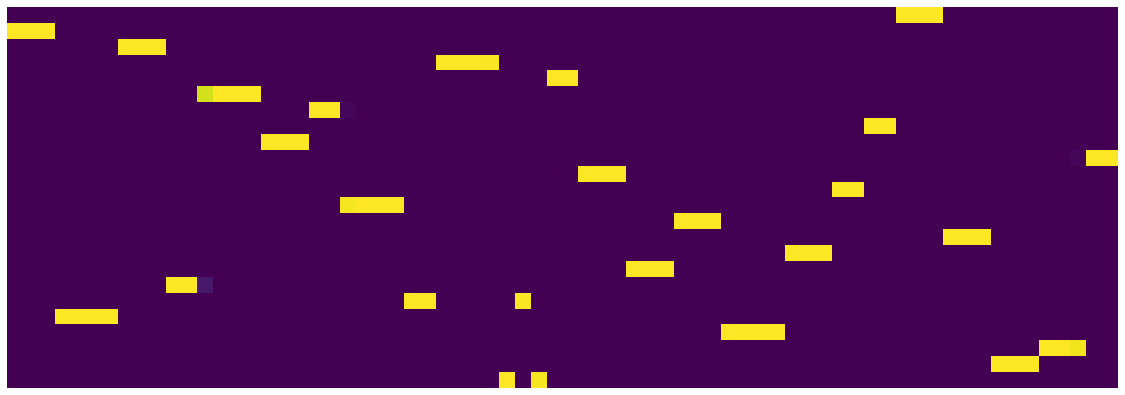

24 338 0.6609999999999997 0.4525184664875269


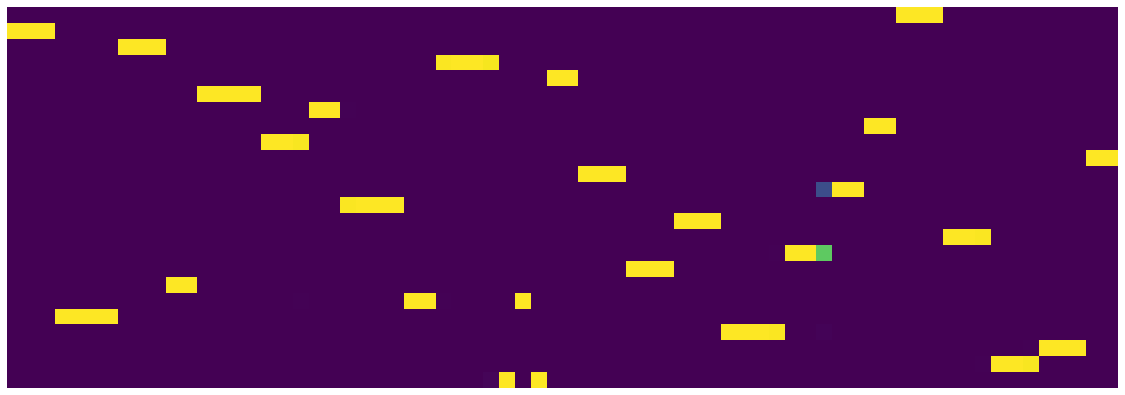

24 339 0.6599999999999997 0.45213756188750265


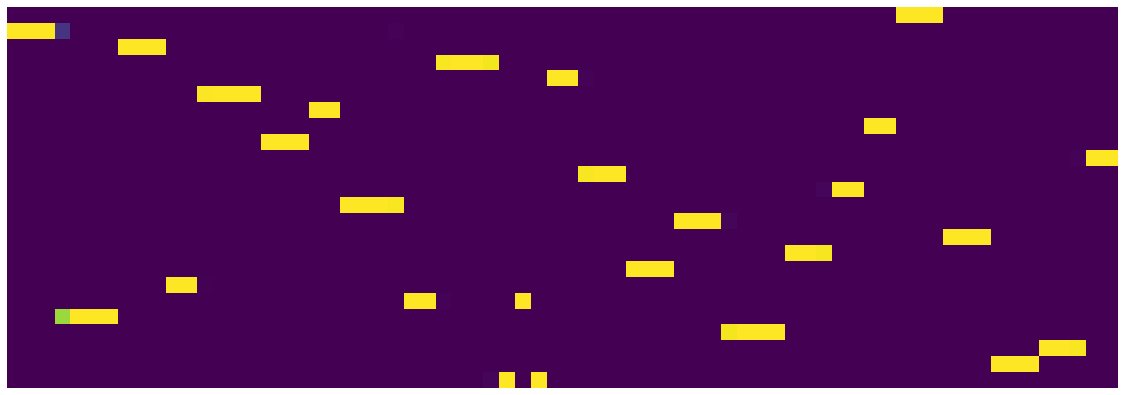

24 340 0.6589999999999997 0.45268544666469096


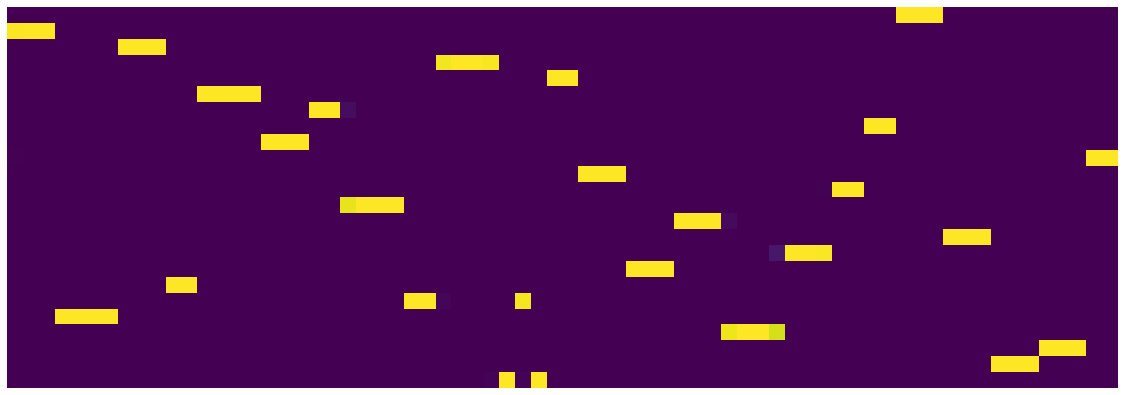

24 341 0.6579999999999997 0.4551180208101869


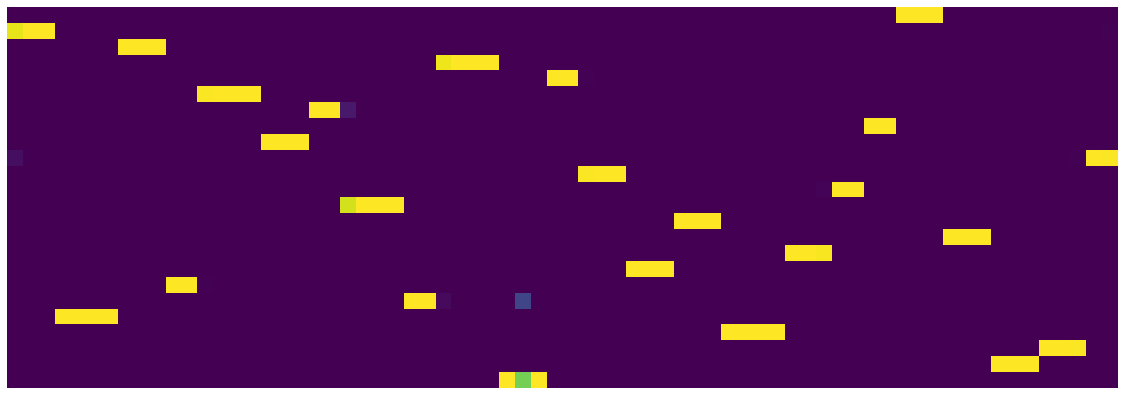

24 342 0.6569999999999997 0.4534891750663519


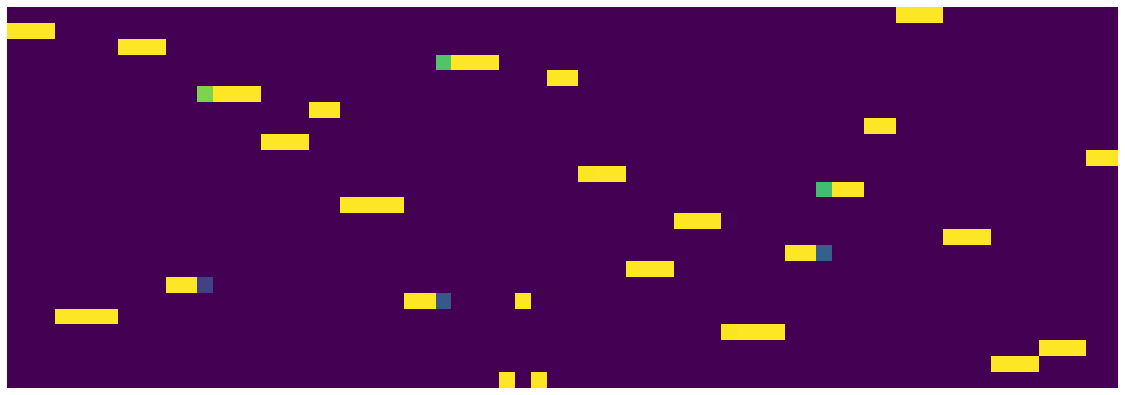

24 343 0.6559999999999997 0.4526828248053789


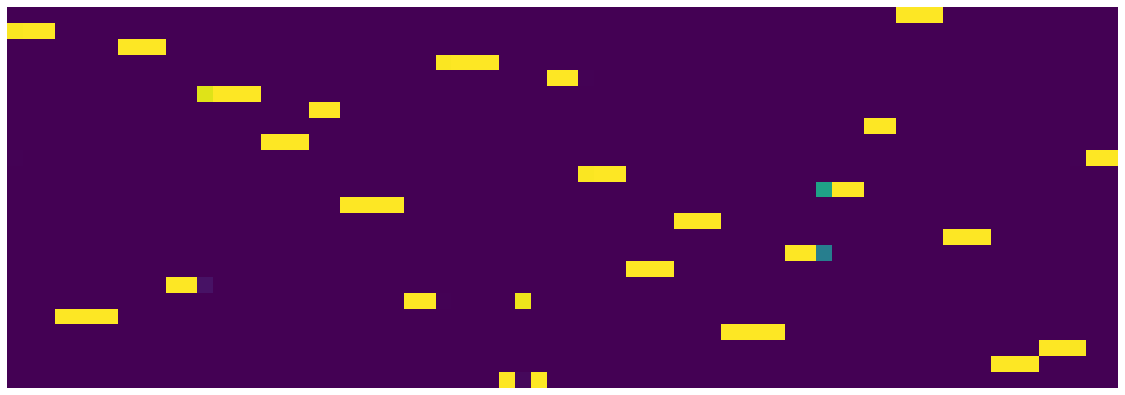

24 344 0.6549999999999997 0.4531310396268964


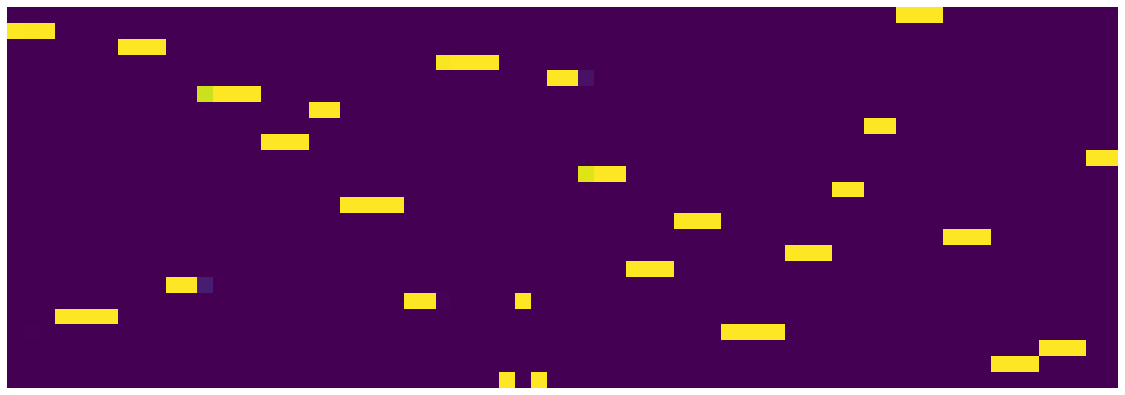

24 345 0.6539999999999997 0.45379970539361236


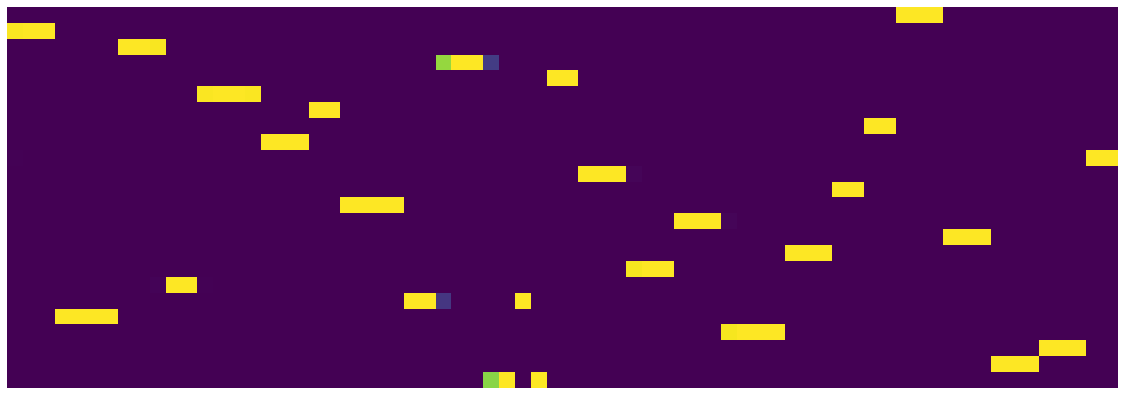

24 346 0.6529999999999997 0.45191082917153835


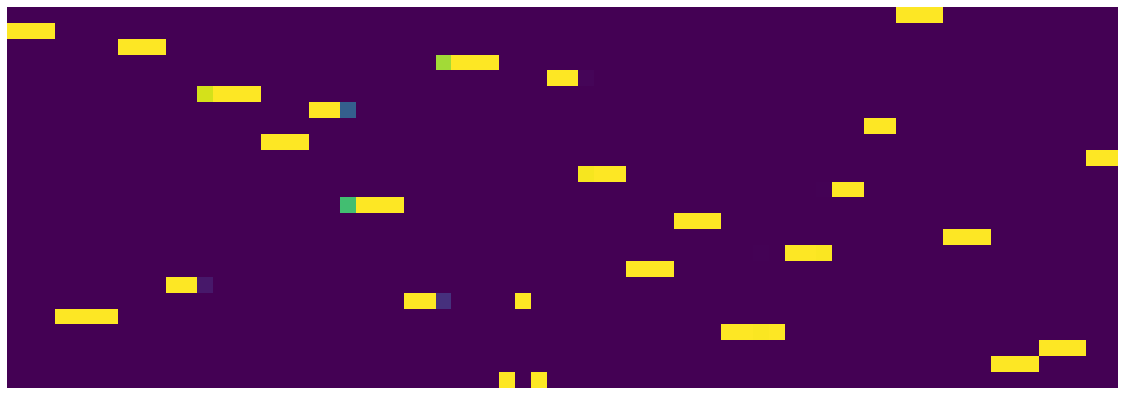

24 347 0.6519999999999997 0.45227053854614496


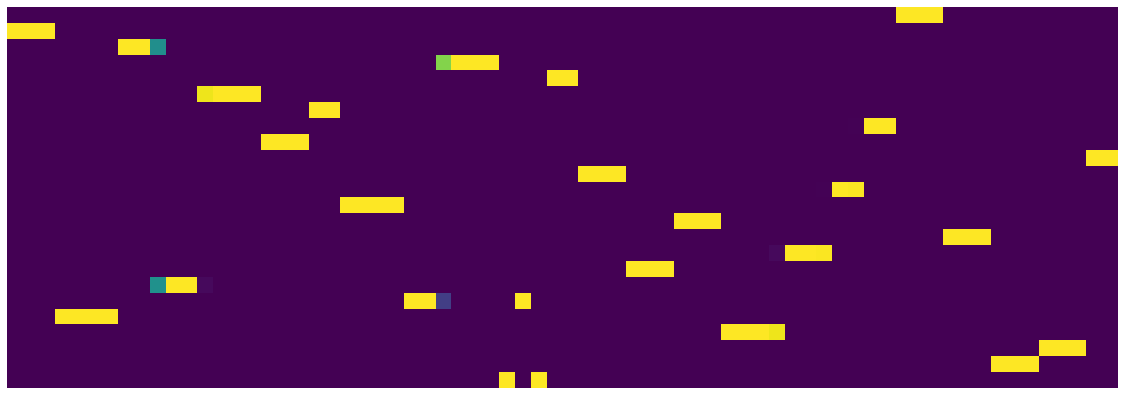

24 348 0.6509999999999997 0.4532840734347701


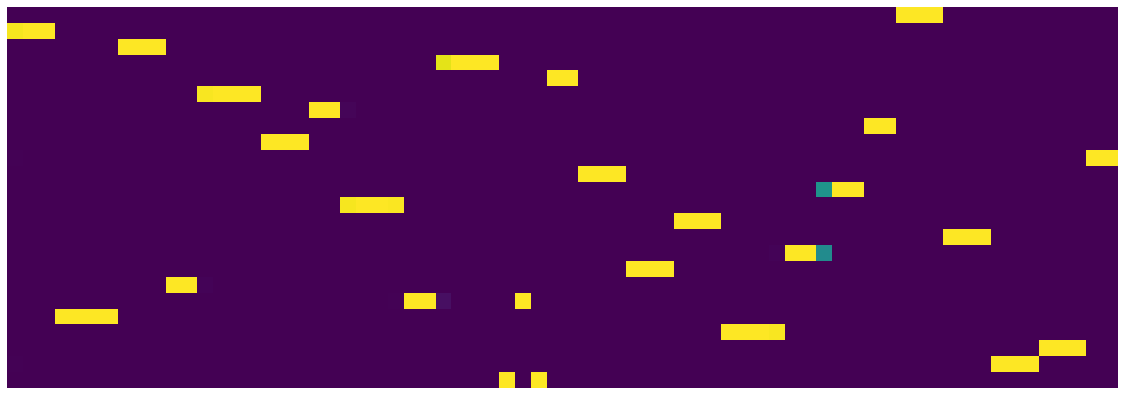

24 349 0.6499999999999997 0.45289867129176853


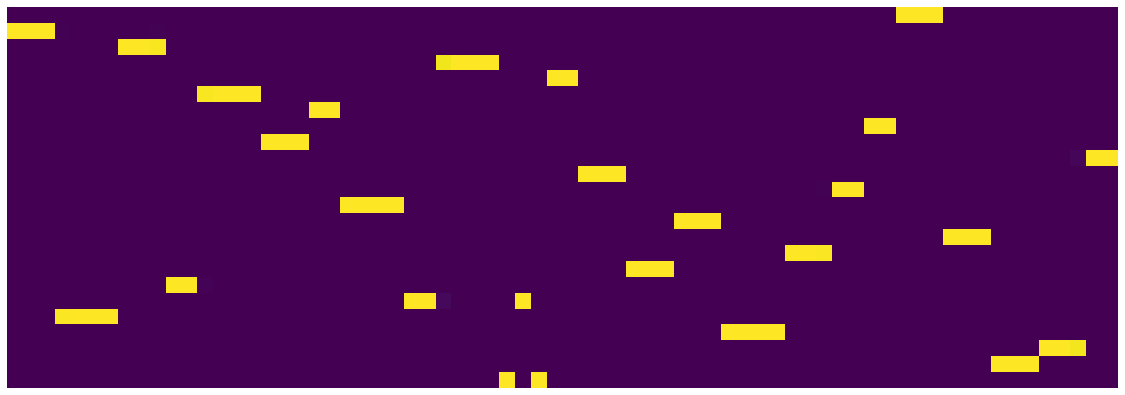

24 350 0.6489999999999997 0.45266301538795234


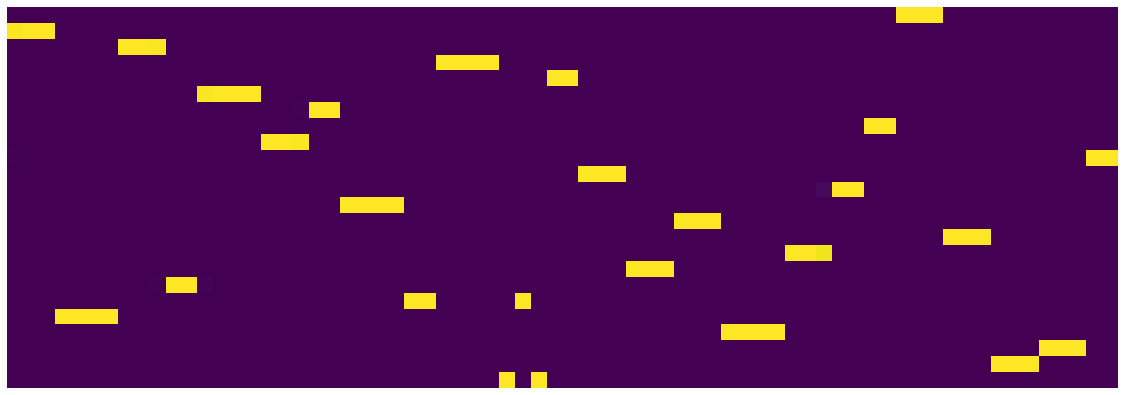

24 351 0.6479999999999997 0.4532175809144974


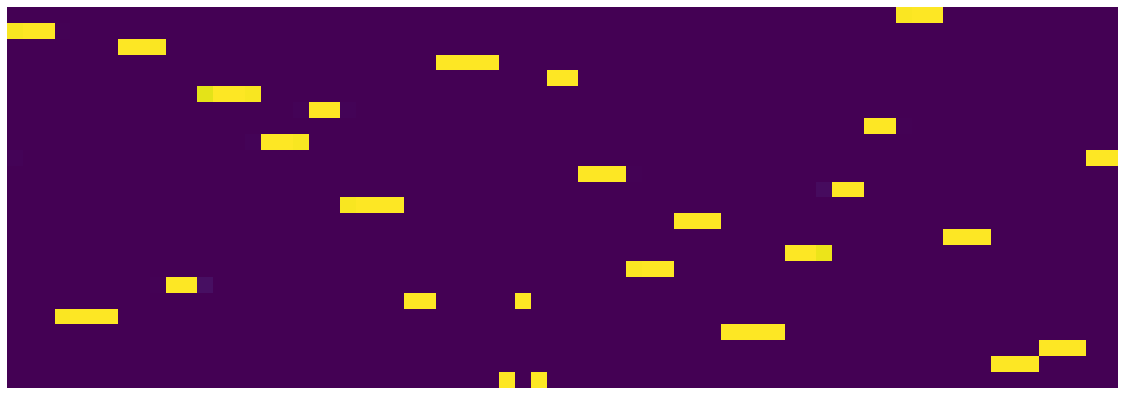

24 352 0.6469999999999997 0.45271342191845176


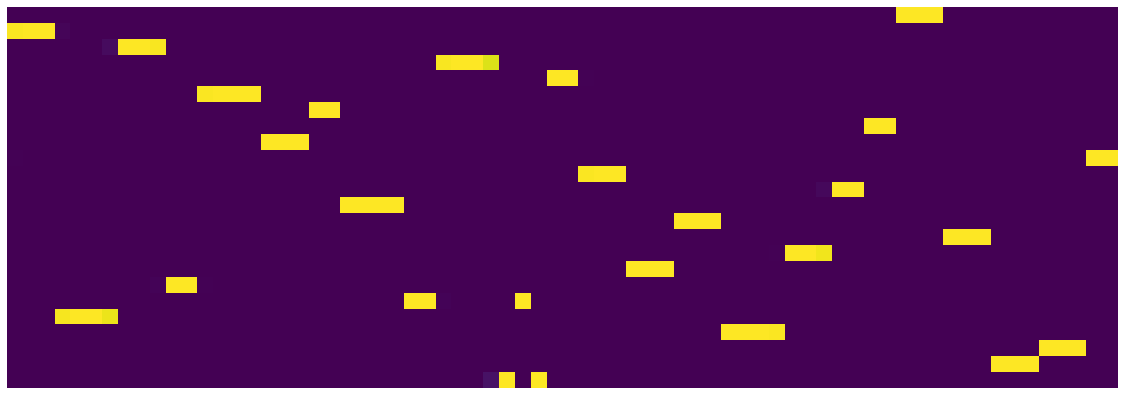

24 353 0.6459999999999997 0.45383205991238357


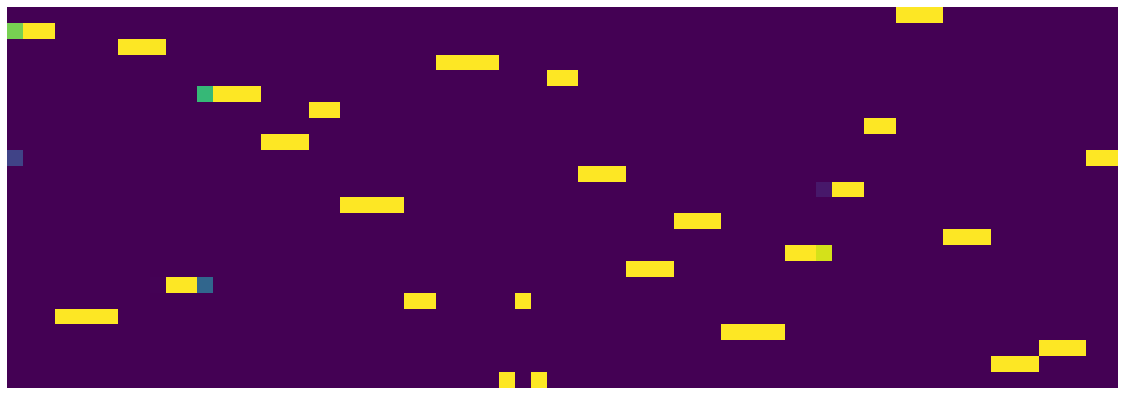

24 354 0.6449999999999997 0.45276542399078606


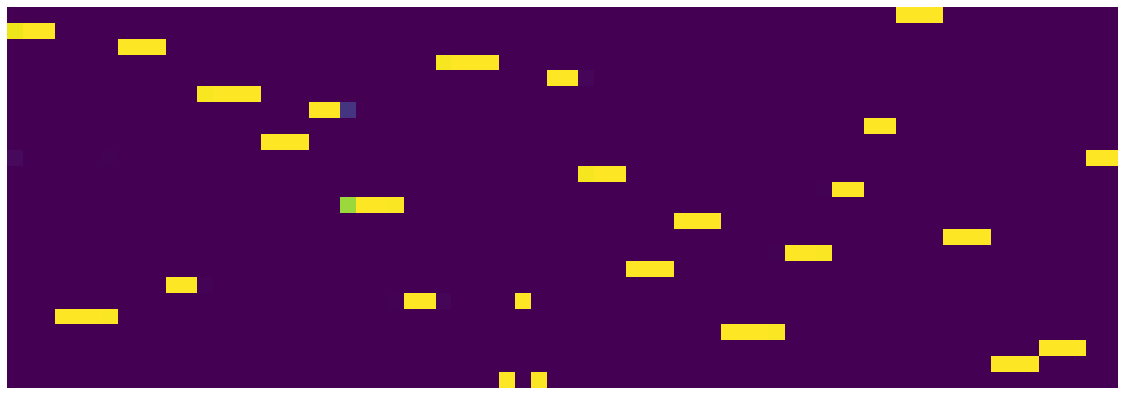

24 355 0.6439999999999997 0.45301322285085915


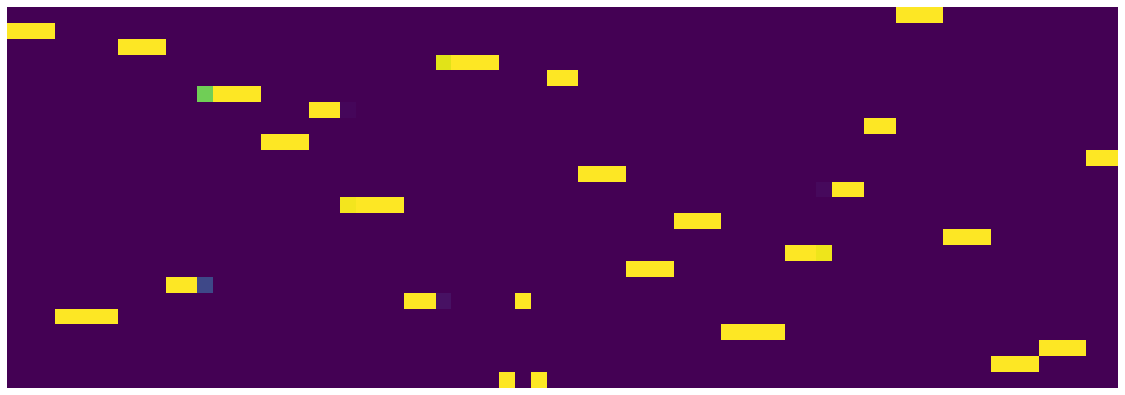

24 356 0.6429999999999997 0.4528176402673125


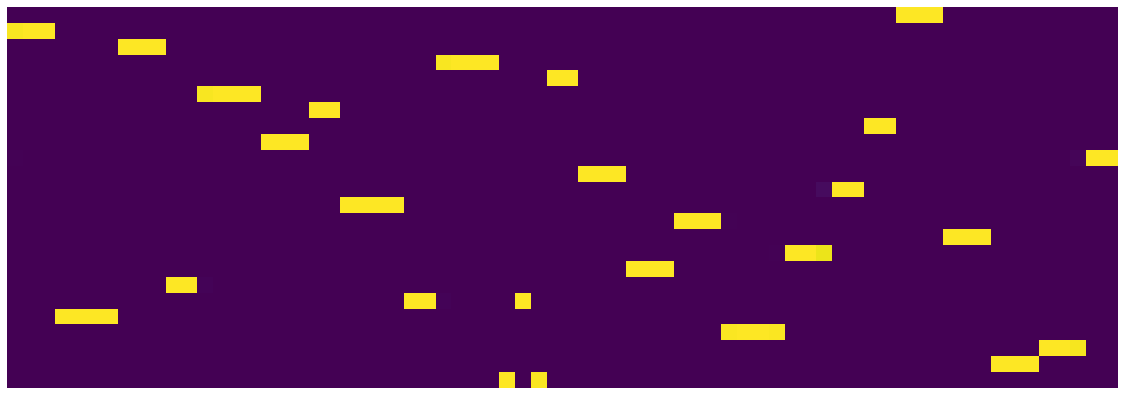

24 357 0.6419999999999997 0.452283182926476


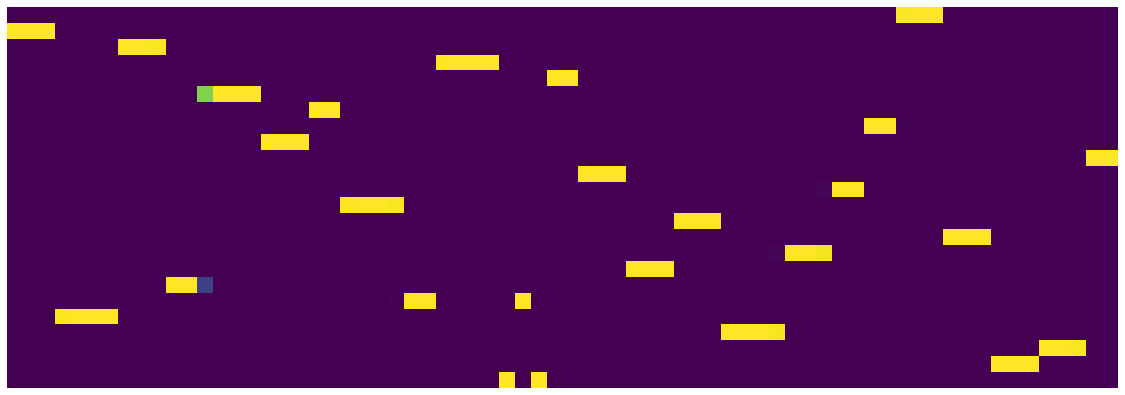

24 358 0.6409999999999997 0.4531602323055267


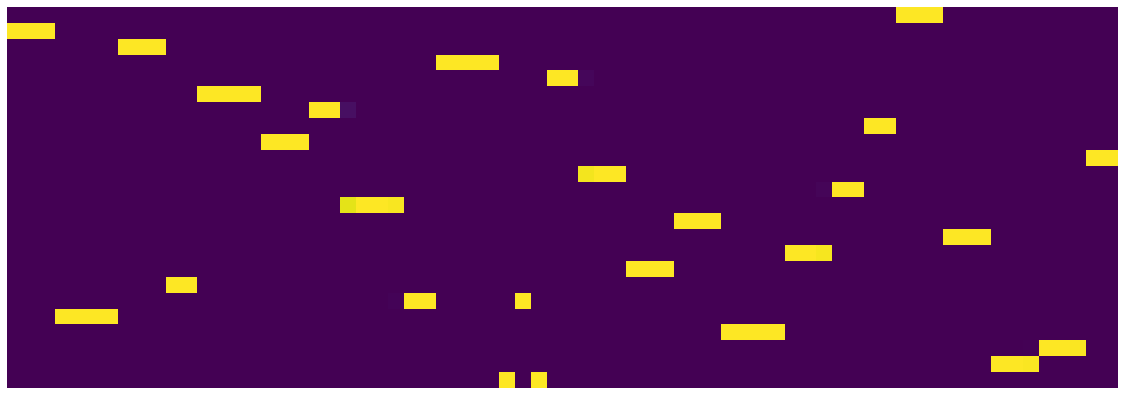

24 359 0.6399999999999997 0.4545646386221051


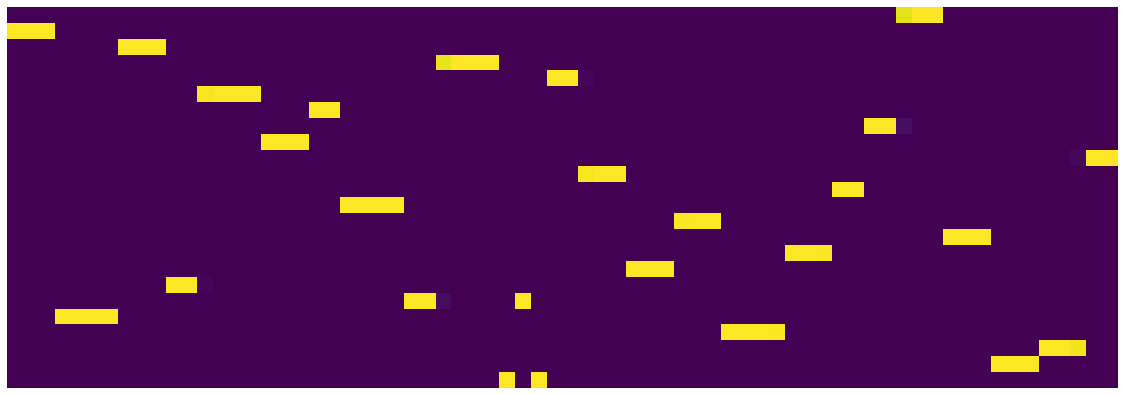

24 360 0.6389999999999997 0.451861584186554


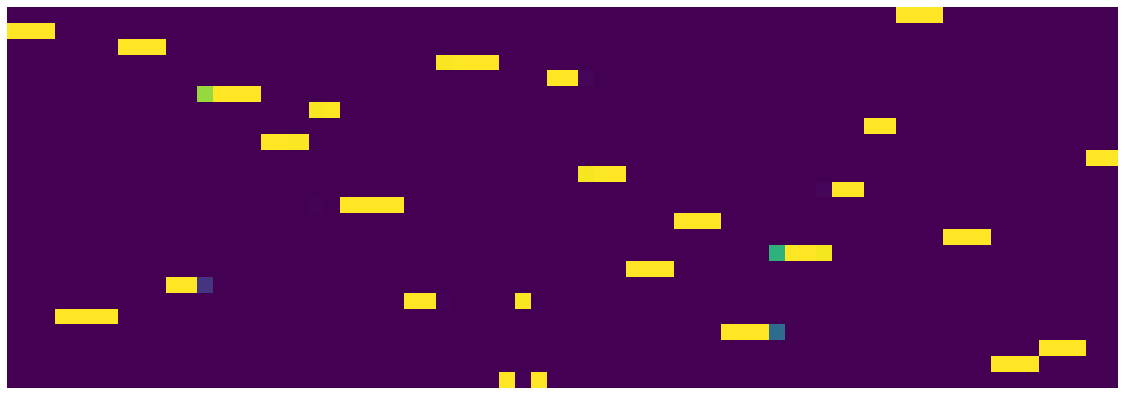

24 361 0.6379999999999997 0.4515370033681393


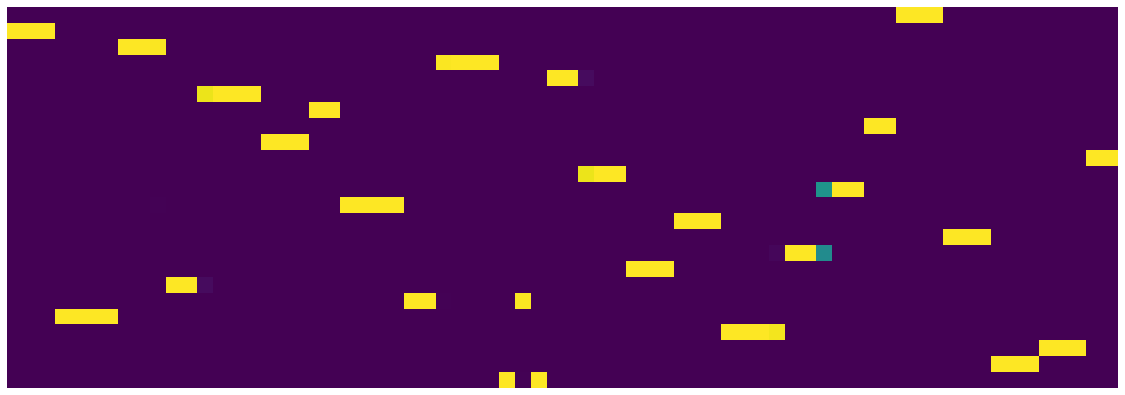

24 362 0.6369999999999997 0.4548735037446022


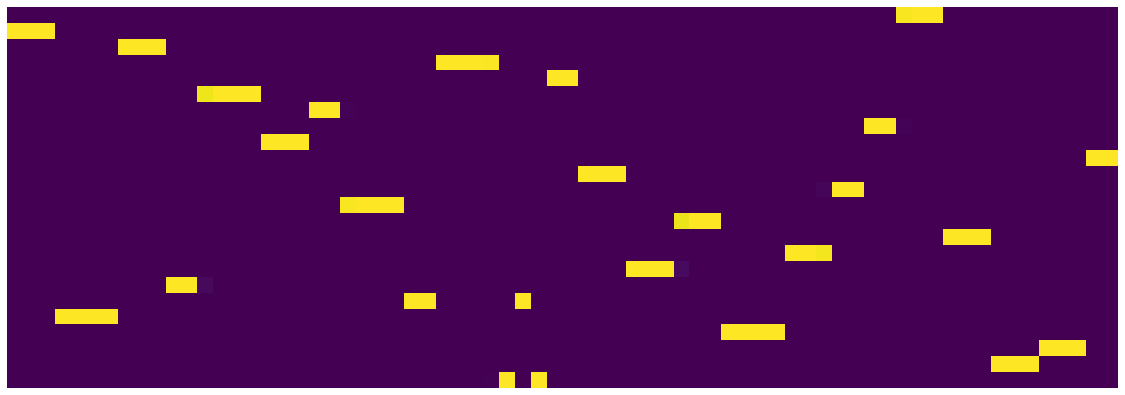

24 363 0.6359999999999997 0.4528813885524869


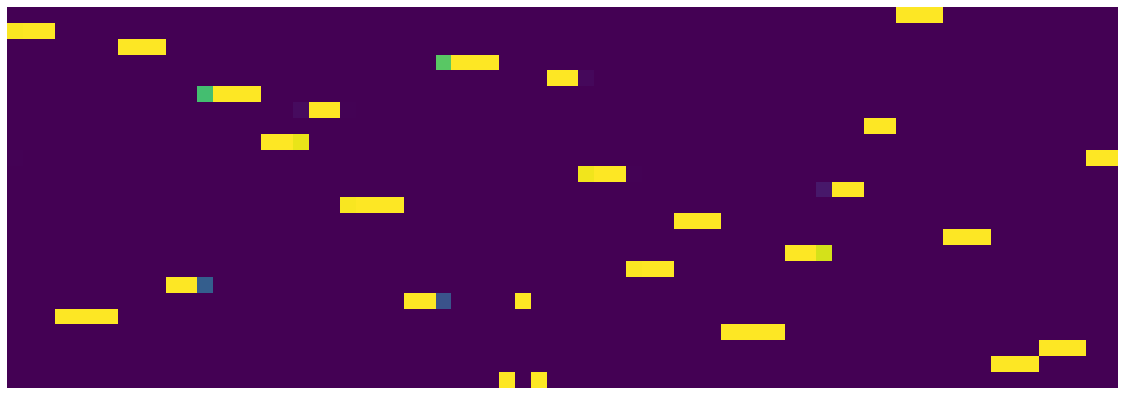

24 364 0.6349999999999997 0.45163397416472434


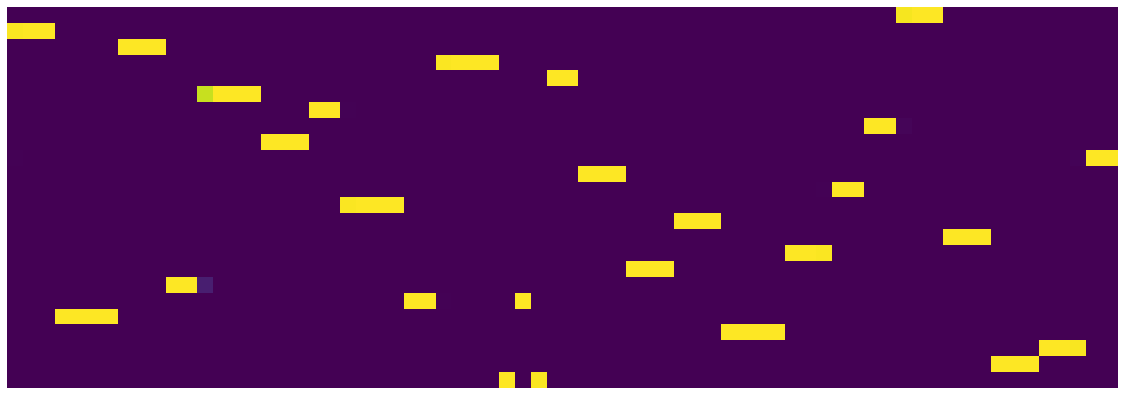

24 365 0.6339999999999997 0.4537101052701473


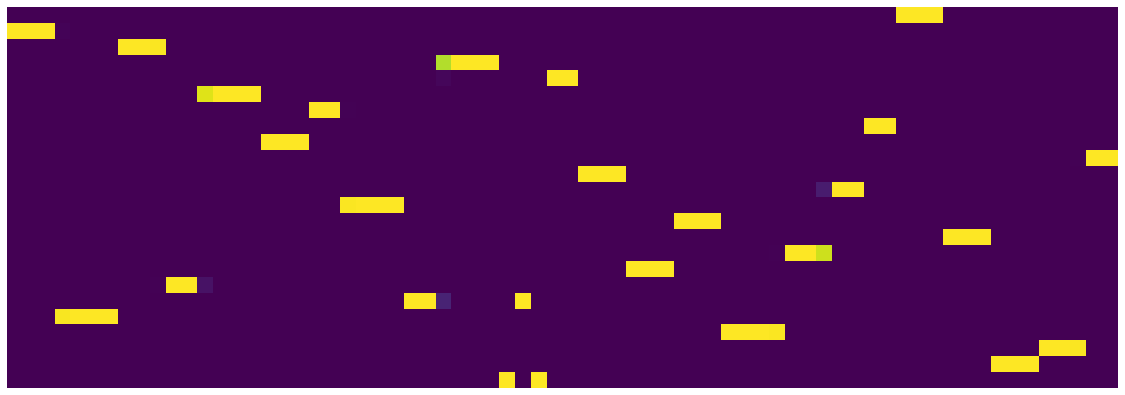

24 366 0.6329999999999997 0.4524858135730028


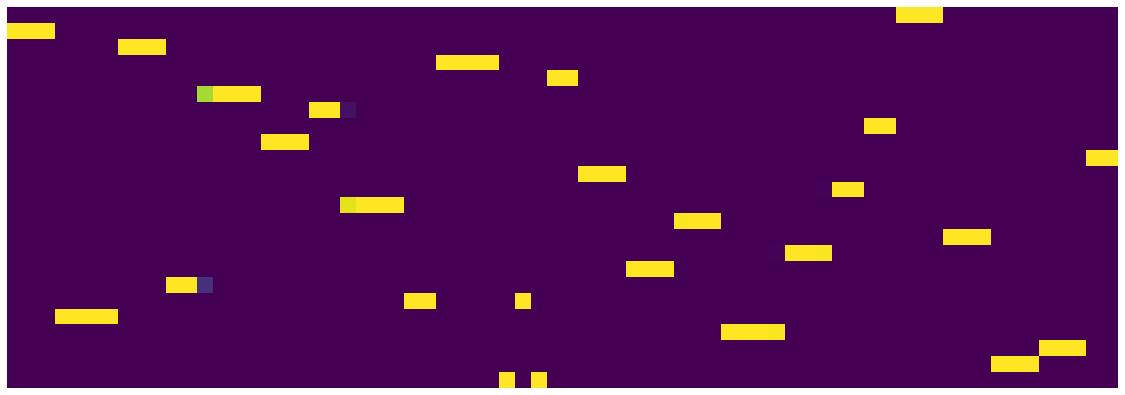

24 367 0.6319999999999997 0.4530530869960785


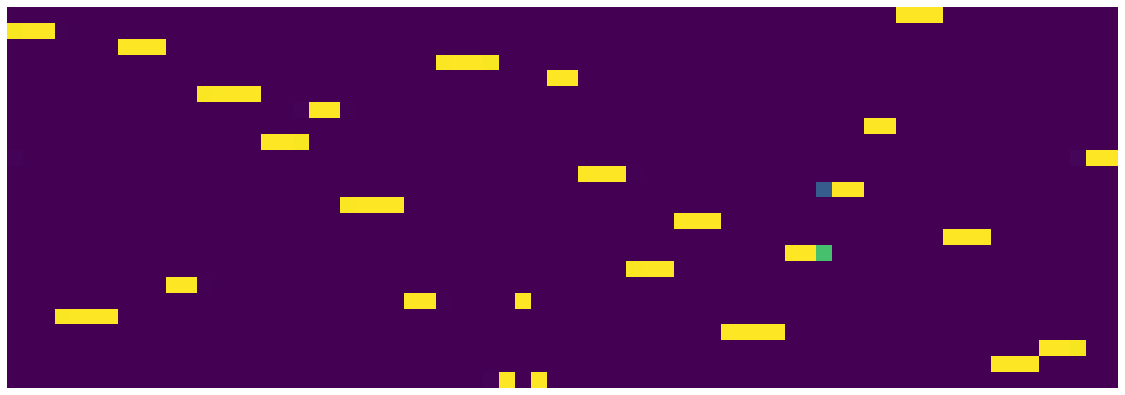

24 368 0.6309999999999997 0.4525127574801445


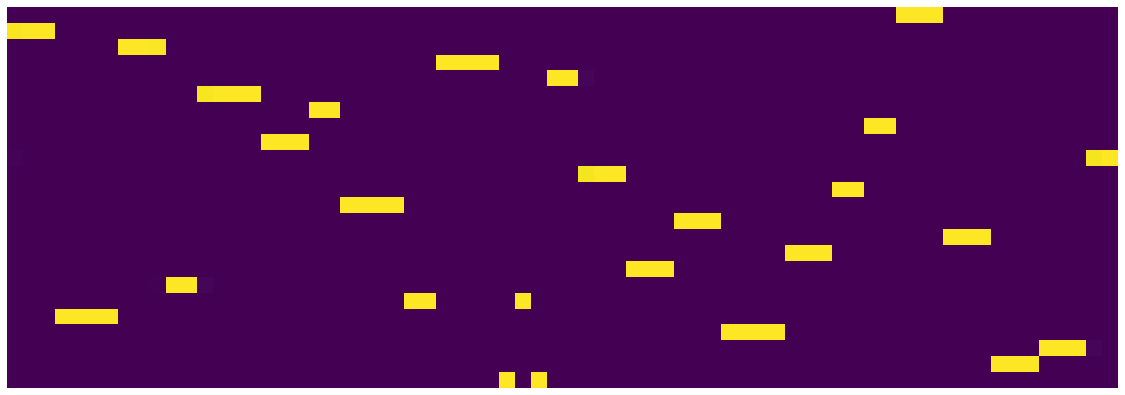

24 369 0.6299999999999997 0.45197945591062305


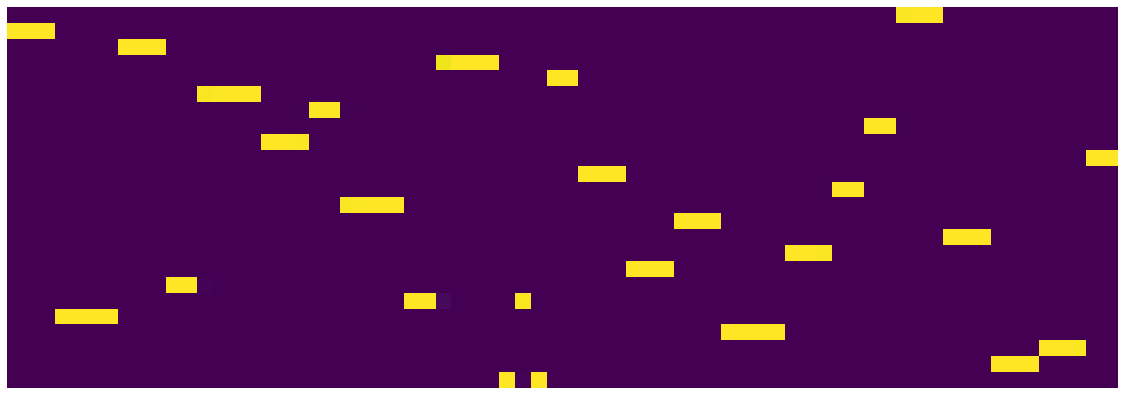

24 370 0.6289999999999997 0.4531953057274222


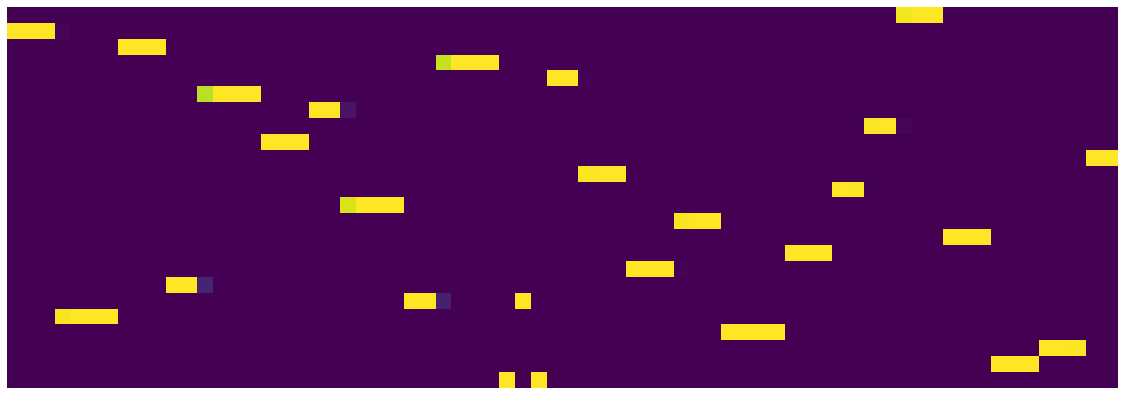

24 371 0.6279999999999997 0.45356235690414903


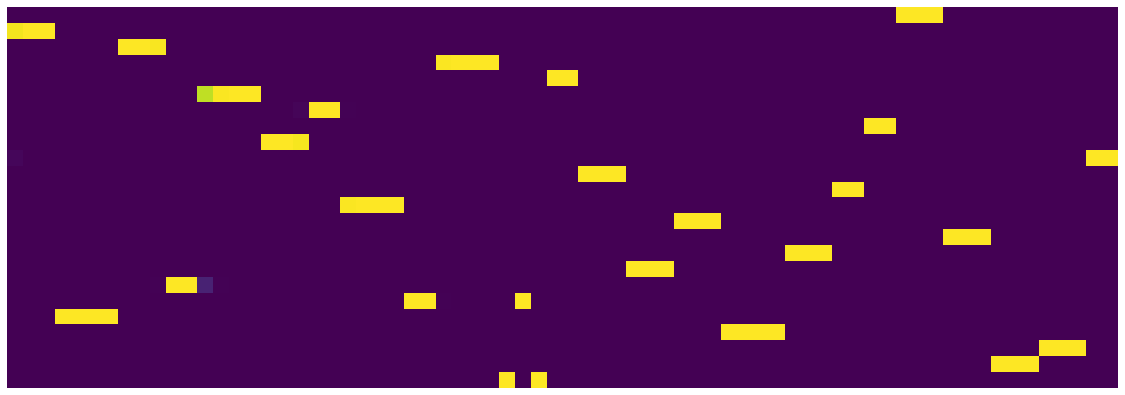

24 372 0.6269999999999997 0.4521810384467244


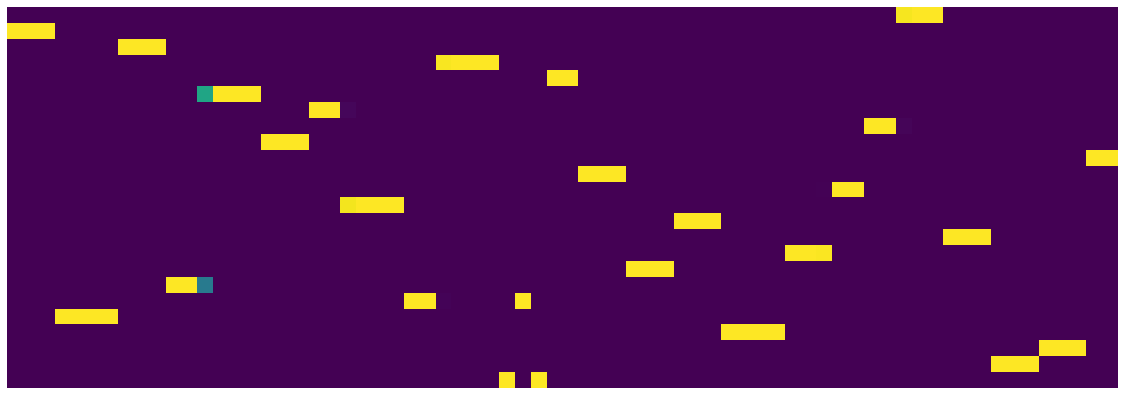

24 373 0.6259999999999997 0.45319830570369957


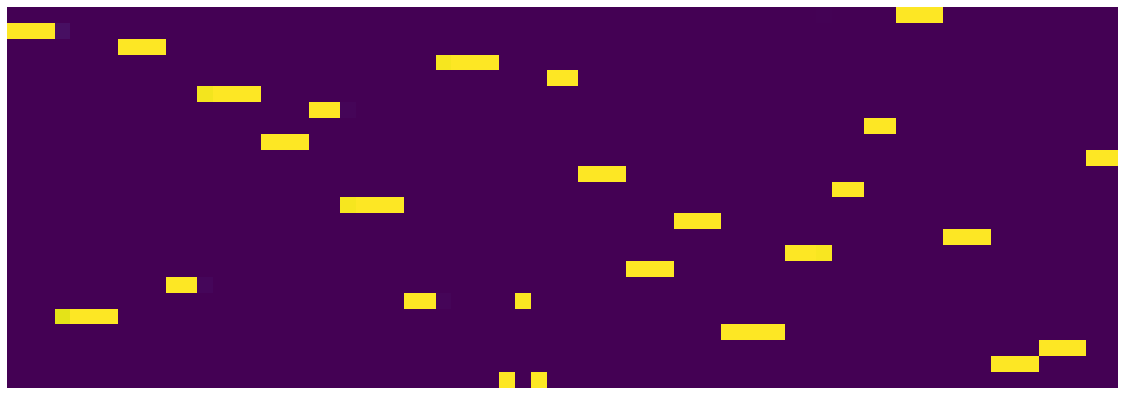

24 374 0.6249999999999997 0.4522489309310913


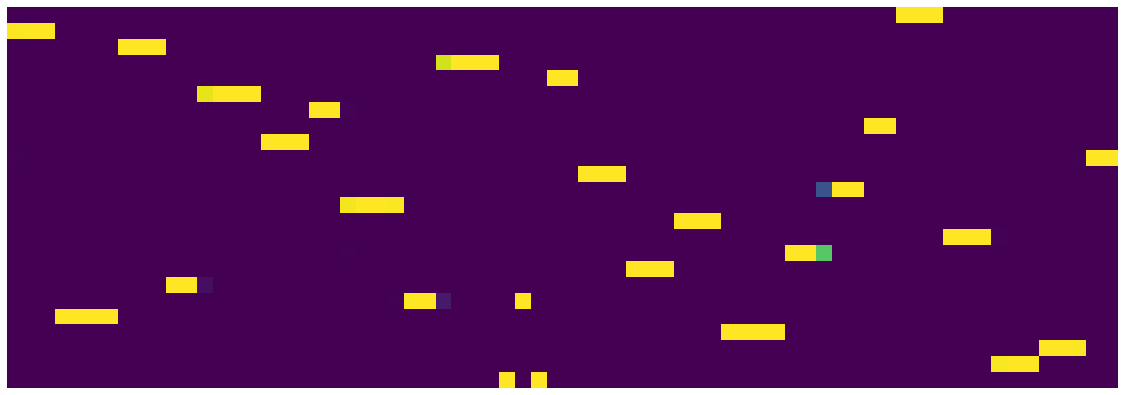

24 375 0.6239999999999997 0.4529336802661419


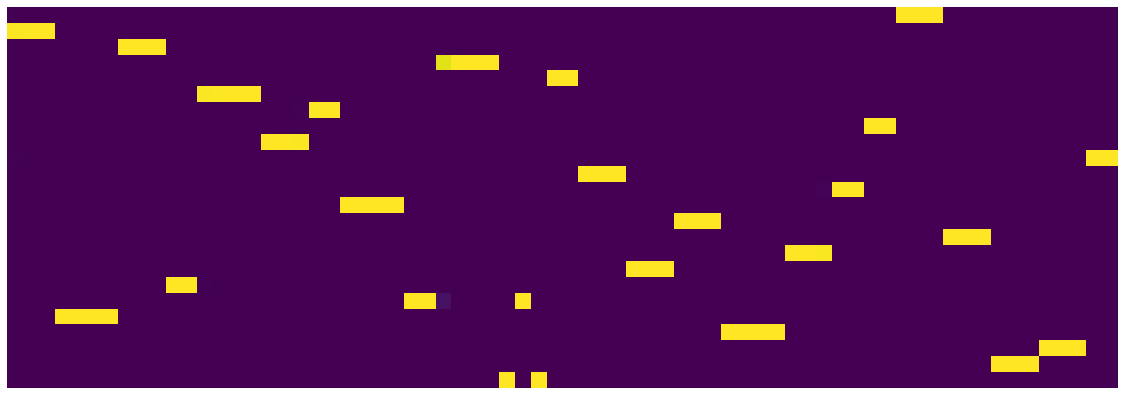

24 376 0.6229999999999997 0.4537015188485384


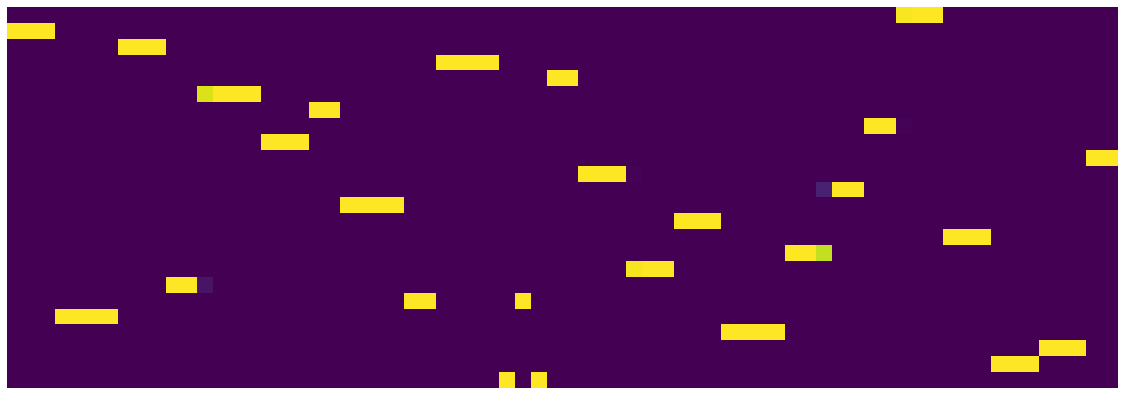

24 377 0.6219999999999997 0.4541261183097959


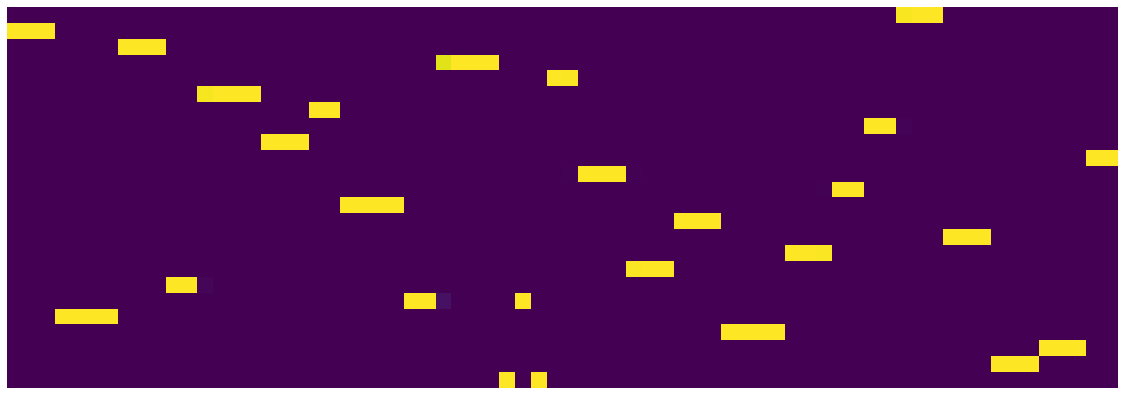

24 378 0.6209999999999997 0.452279045432806


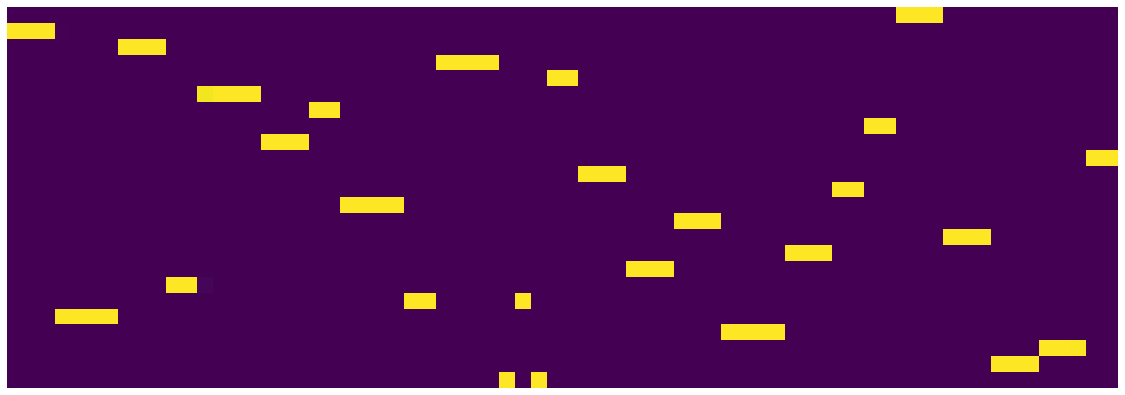

24 379 0.6199999999999997 0.45241665914654733


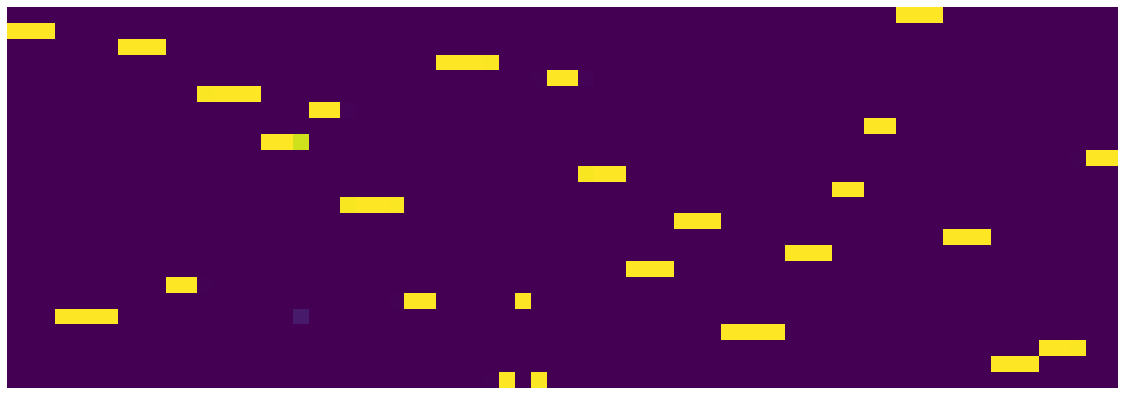

24 380 0.6189999999999997 0.45306708458811046


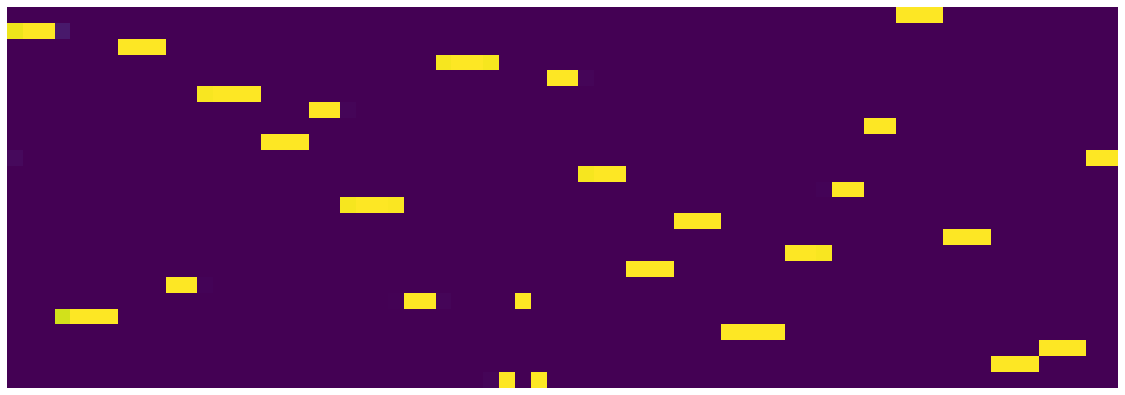

24 381 0.6179999999999997 0.4526329681277275


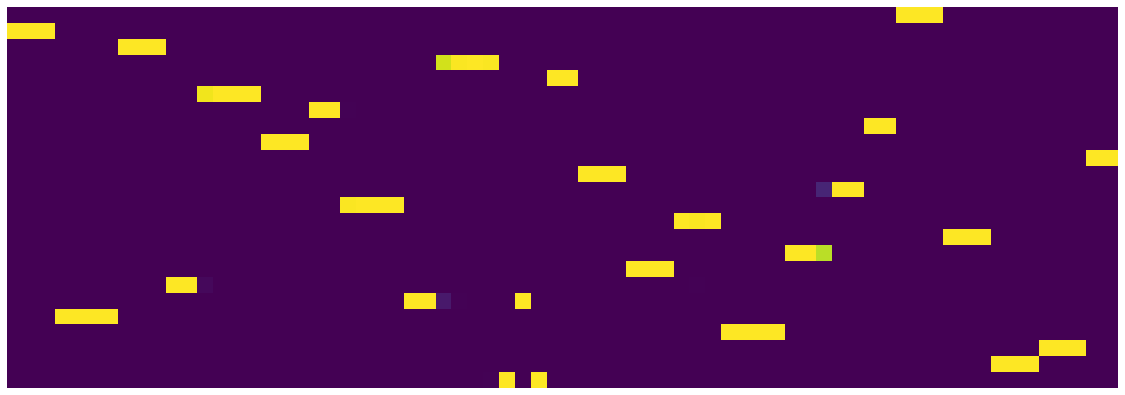

24 382 0.6169999999999997 0.4517474852502346


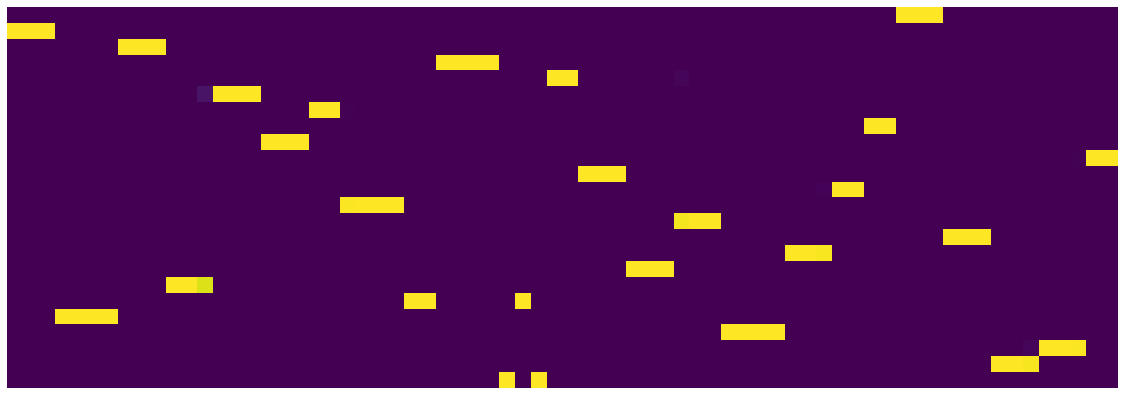

24 383 0.6159999999999997 0.45496227461844685


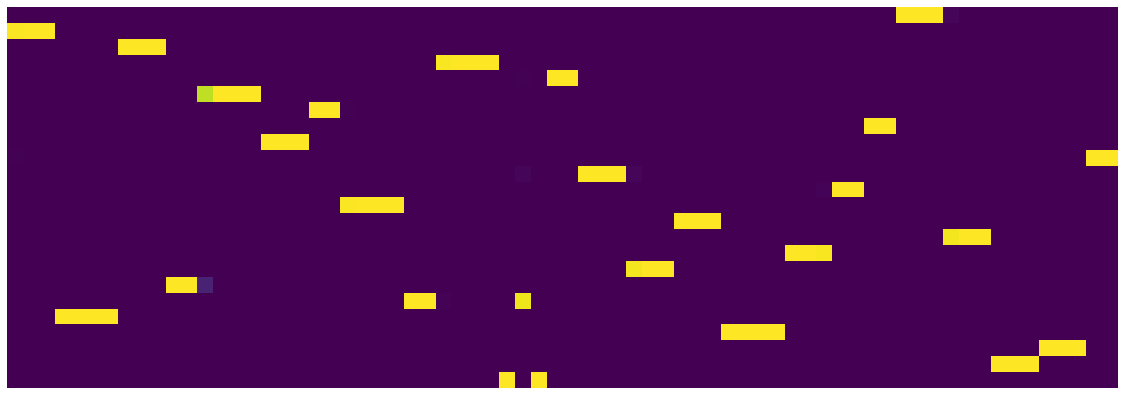

24 384 0.6149999999999997 0.4519890587776899


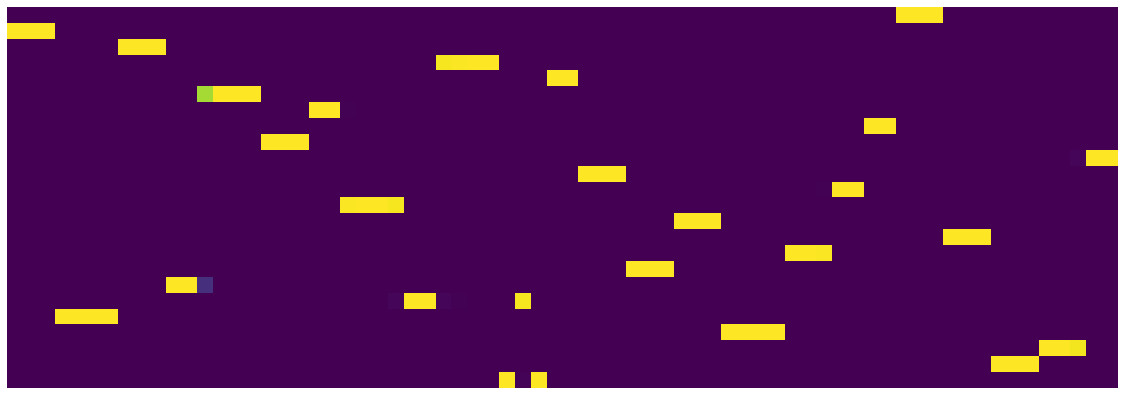

24 385 0.6139999999999997 0.45228631384670737


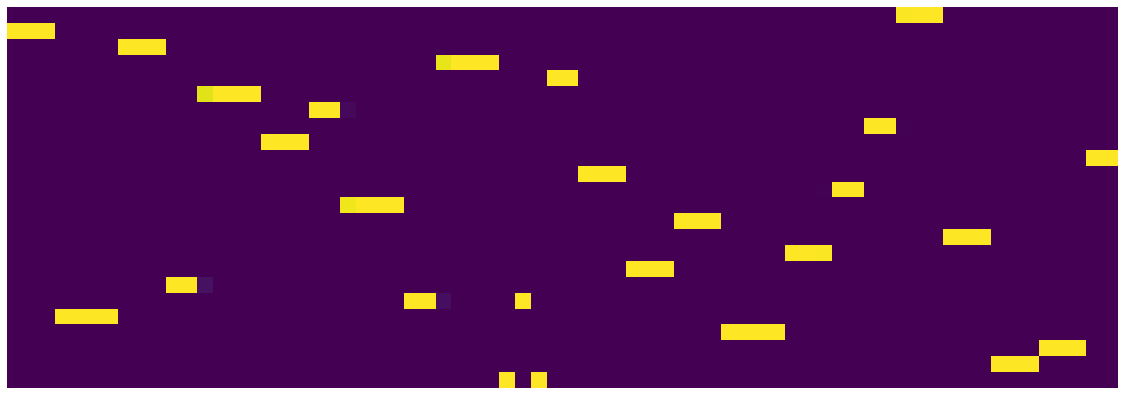

24 386 0.6129999999999997 0.4526391884312034


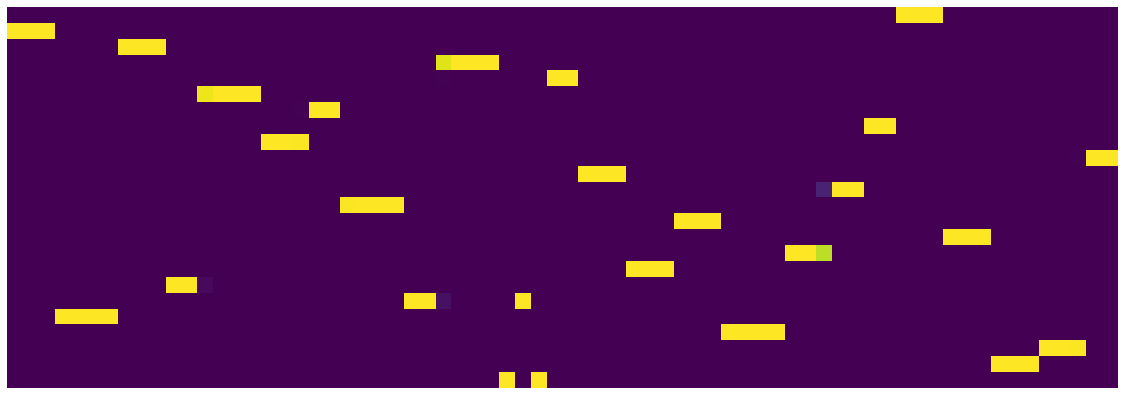

24 387 0.6119999999999997 0.4525414828211069


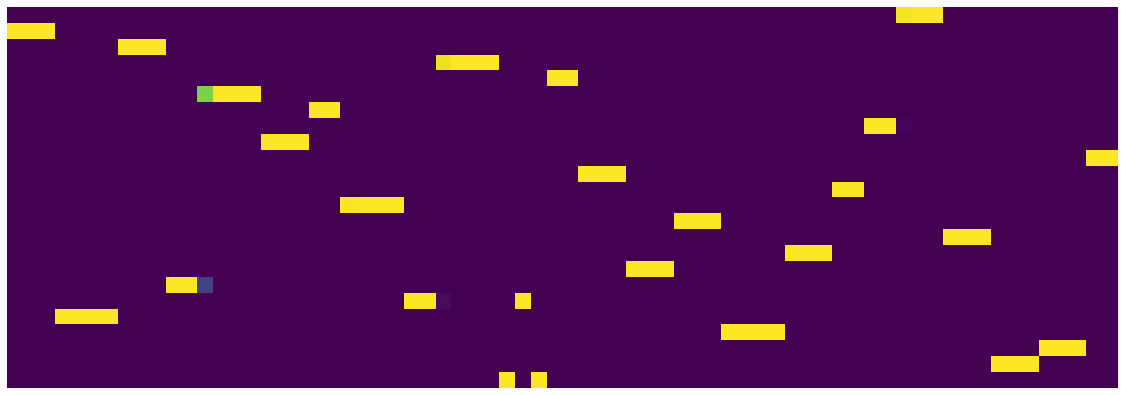

24 388 0.6109999999999997 0.45214833226054907


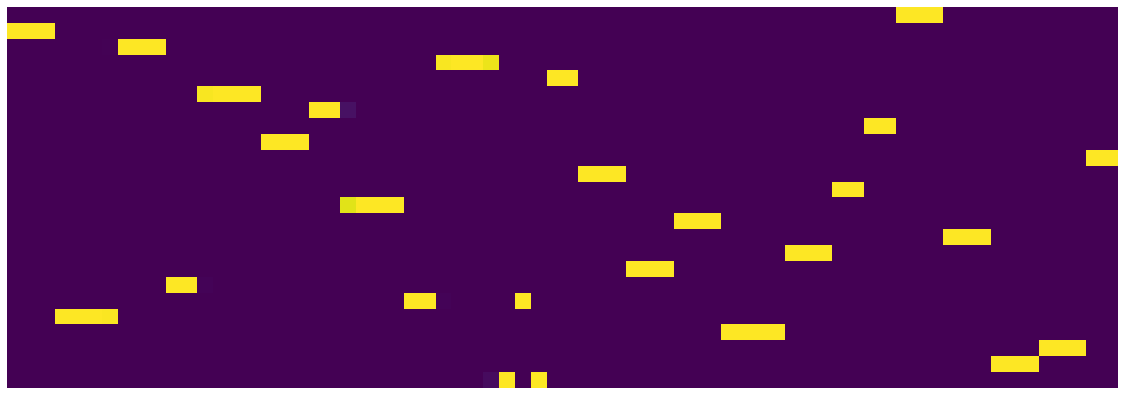

24 389 0.6099999999999997 0.45265364442020656


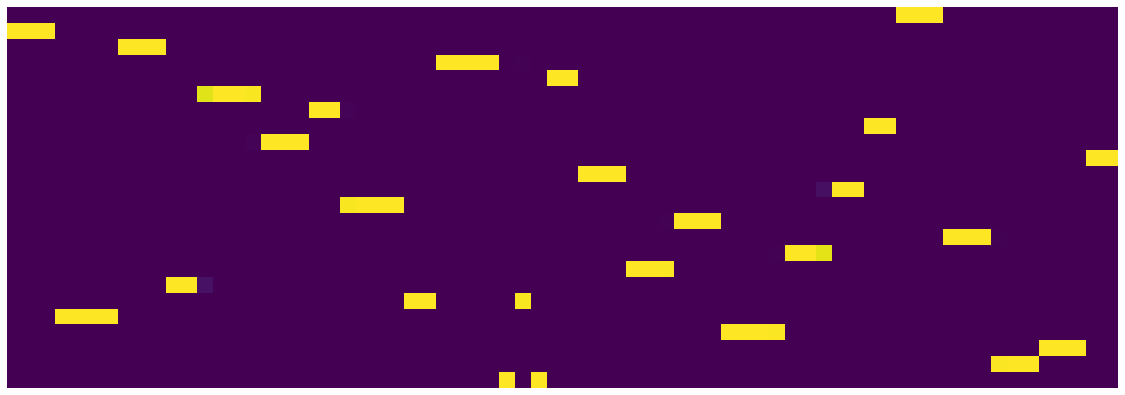

24 390 0.6089999999999997 0.45316942892968654


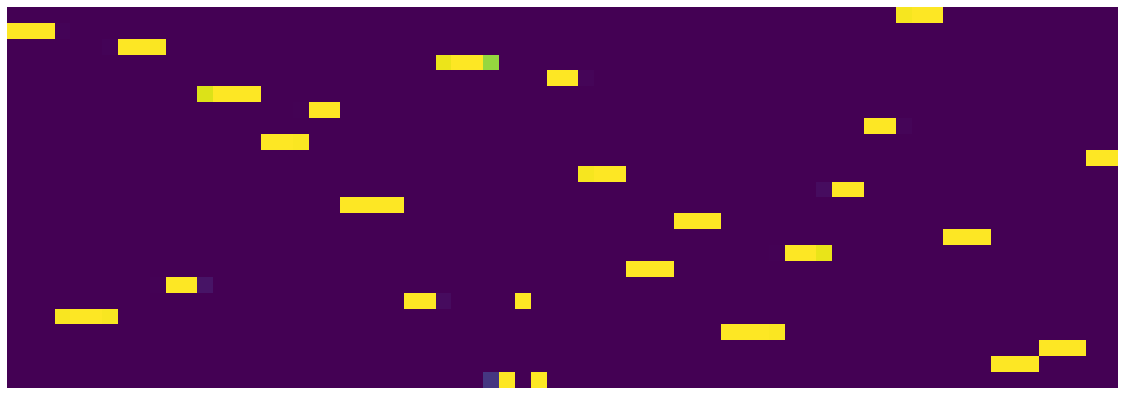

24 391 0.6079999999999997 0.4523410404101014


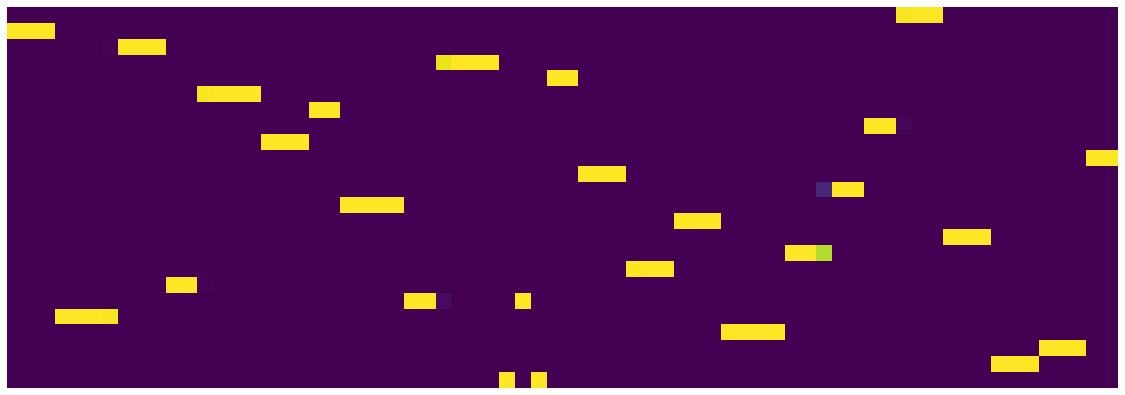

24 392 0.6069999999999997 0.45288867112249137


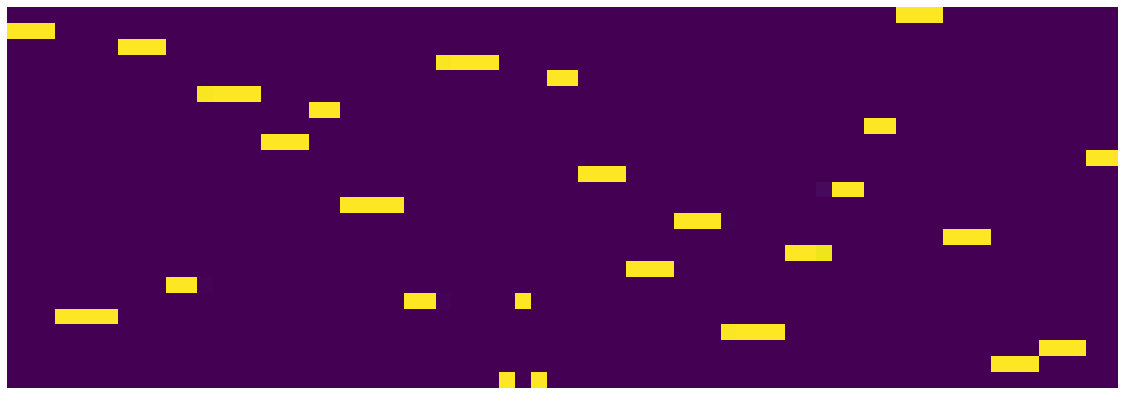

24 393 0.6059999999999997 0.45276378821581603


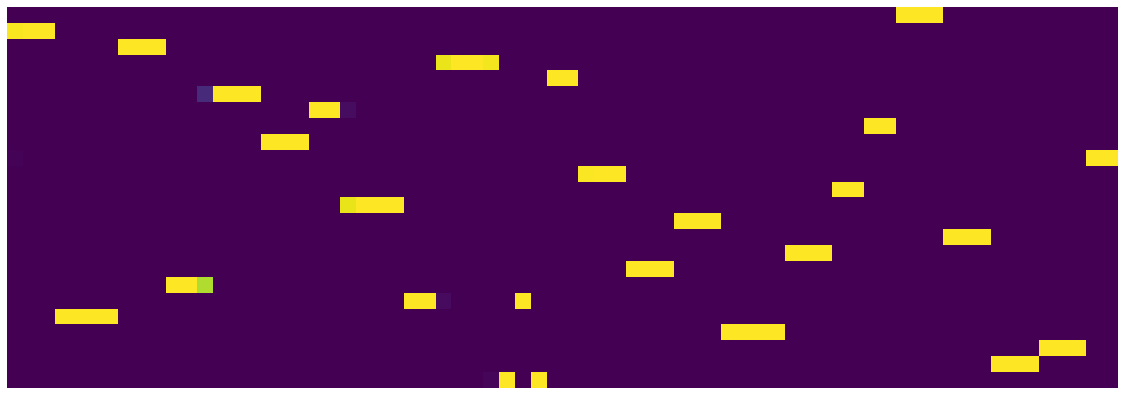

24 394 0.6049999999999996 0.4523832447826862


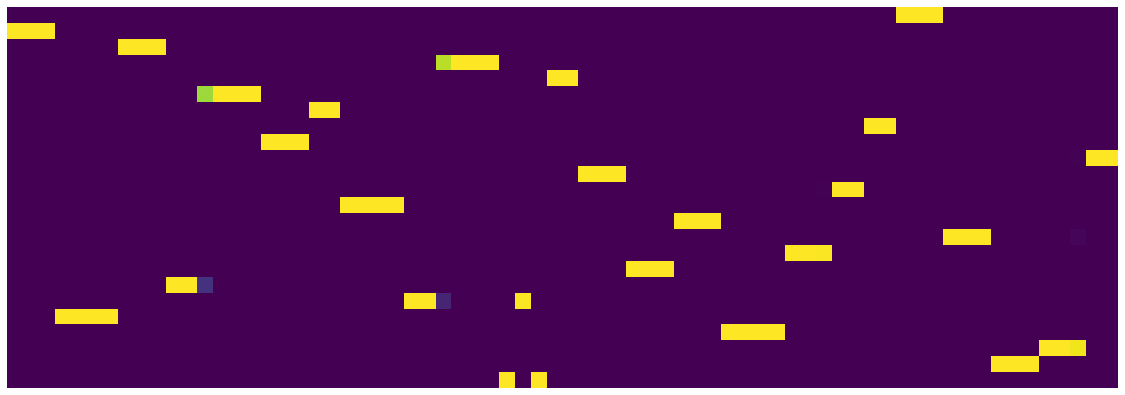

24 395 0.6039999999999996 0.45174221582710744


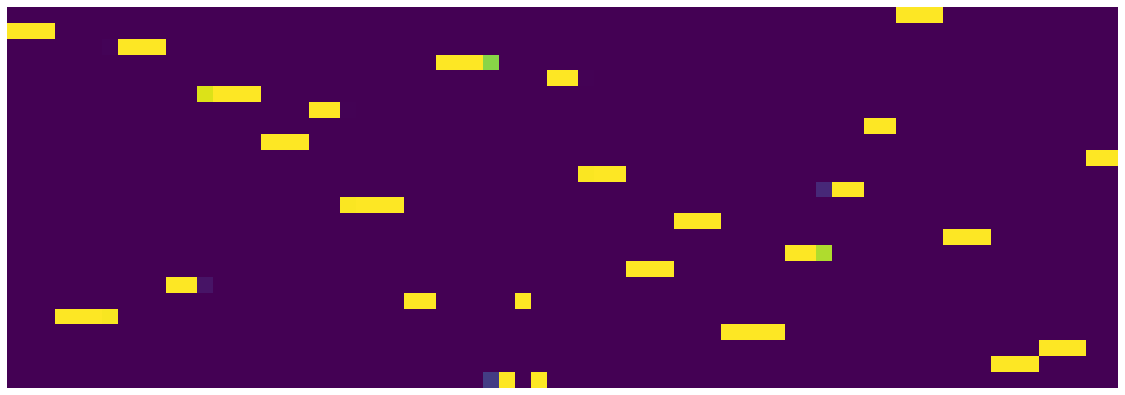

24 396 0.6029999999999996 0.4534495102241635


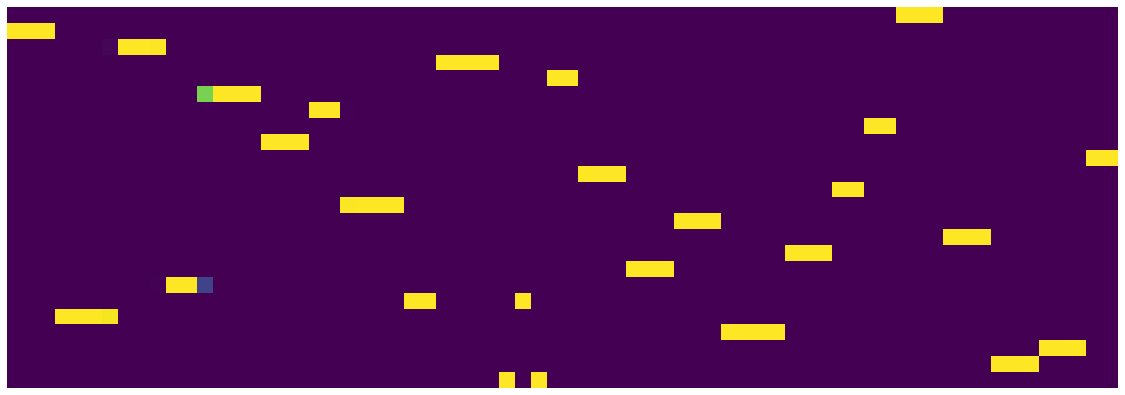

24 397 0.6019999999999996 0.45180538557469846


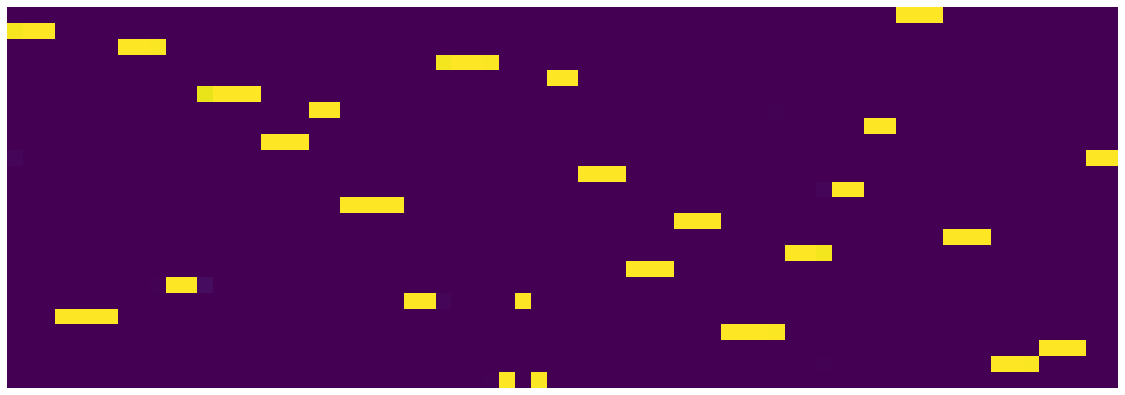

24 398 0.6009999999999996 0.4533910950645804


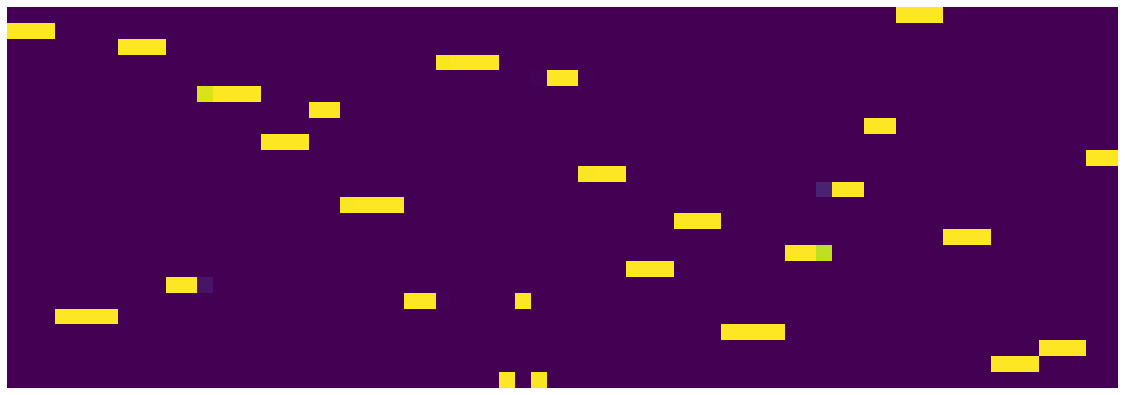

24 399 0.5999999999999996 0.4524560270830989


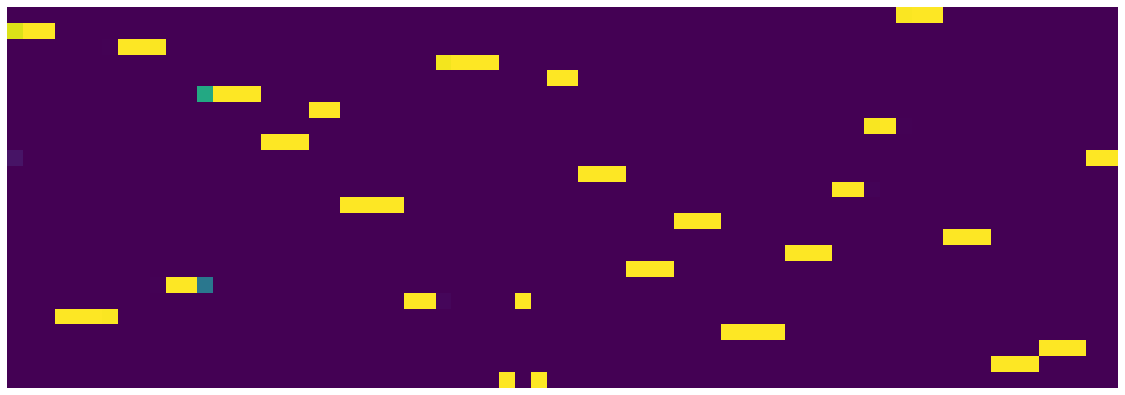

24 400 0.5989999999999996 0.45261644162237646


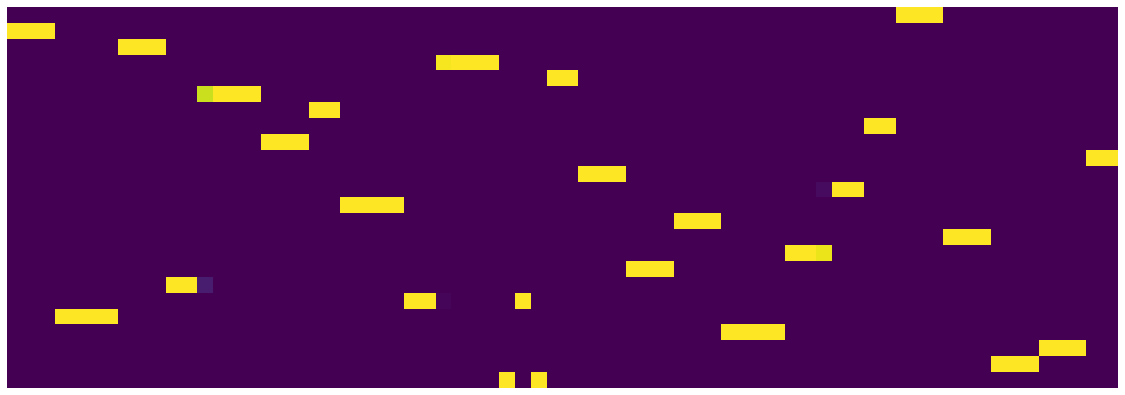

24 401 0.5979999999999996 0.4532852228730917


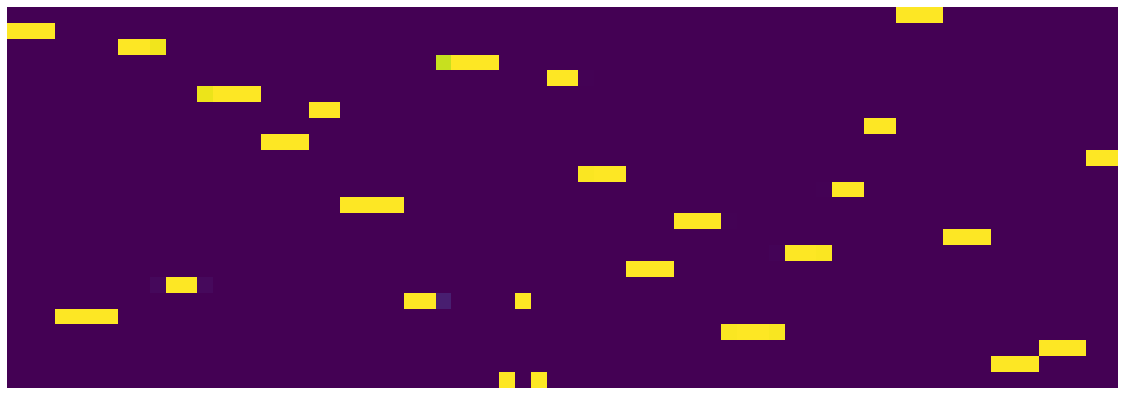

24 402 0.5969999999999996 0.451917827501893


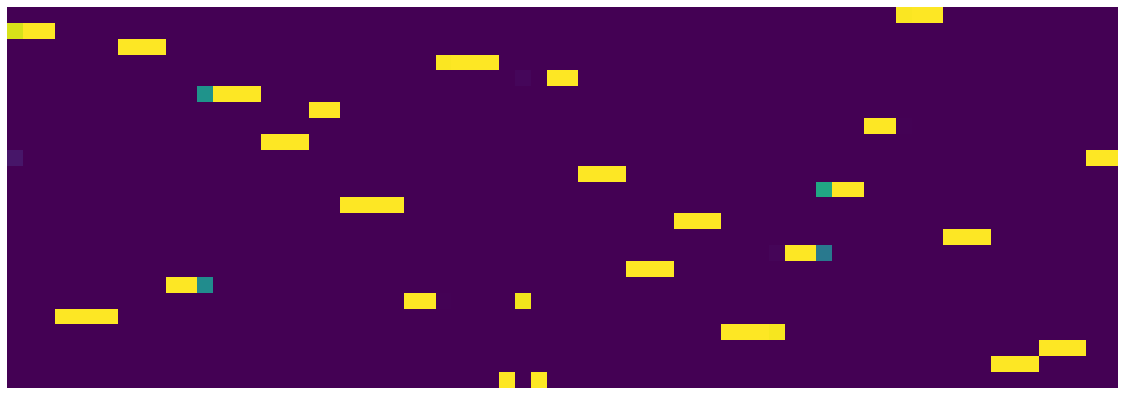

24 403 0.5959999999999996 0.4530332090333104


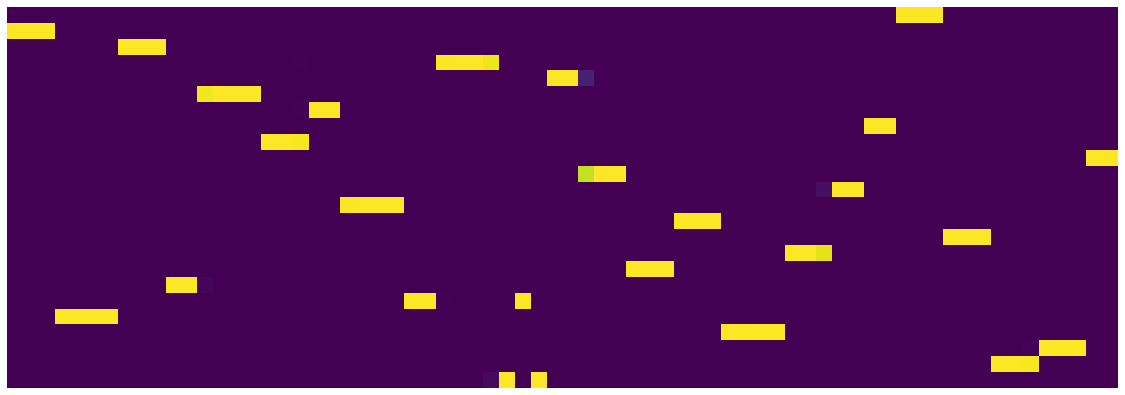

24 404 0.5949999999999996 0.45224936343729494


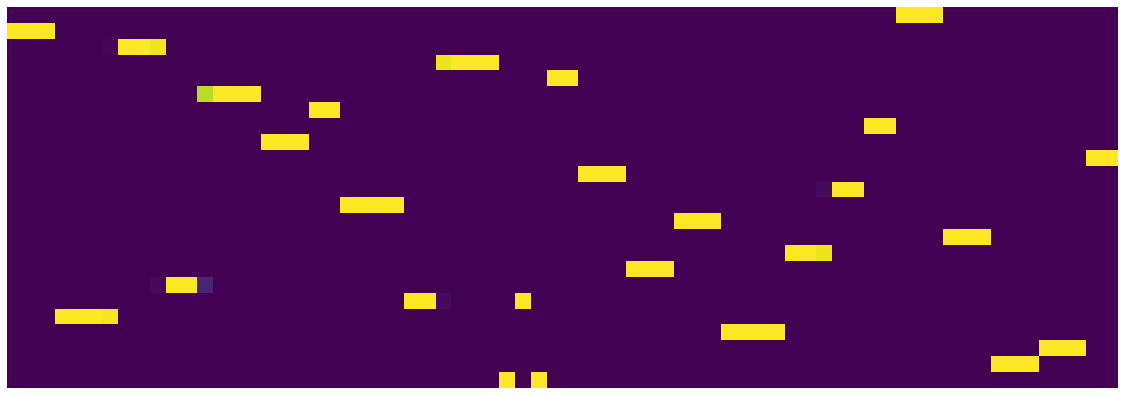

24 405 0.5939999999999996 0.45263081733137367


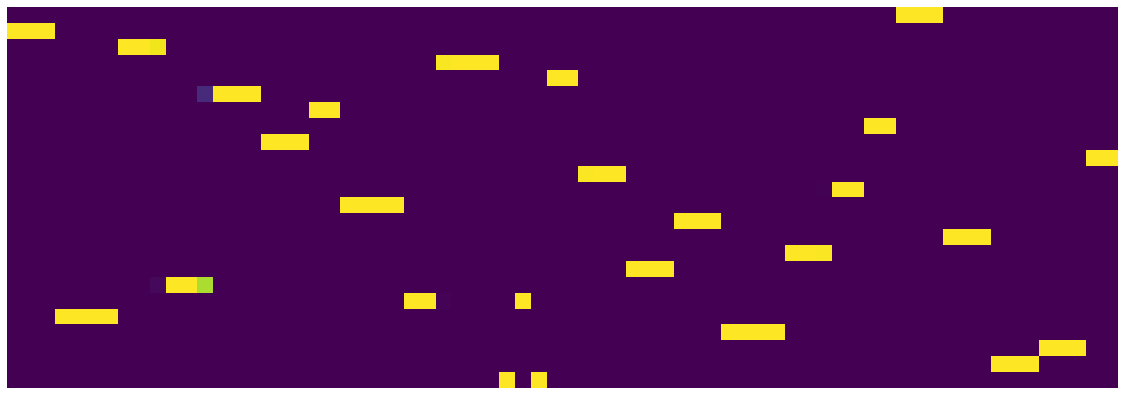

24 406 0.5929999999999996 0.45250436663627625


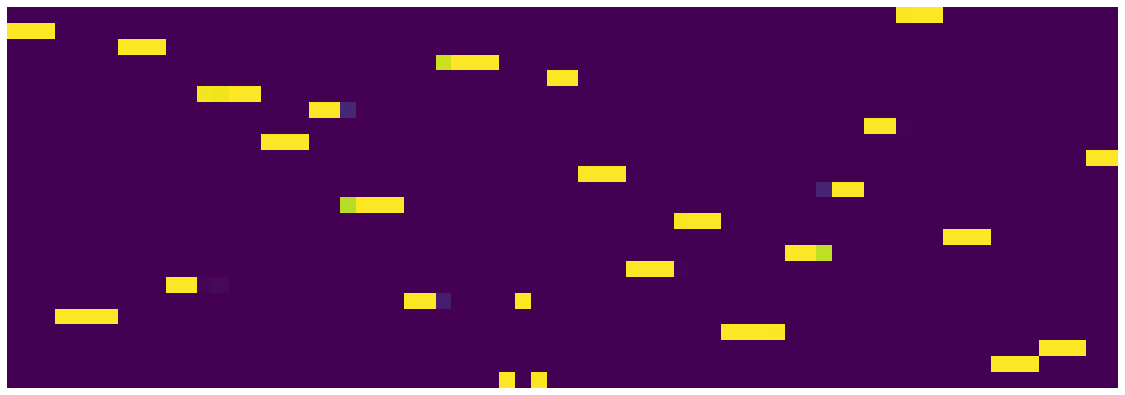

24 407 0.5919999999999996 0.45235874578356744


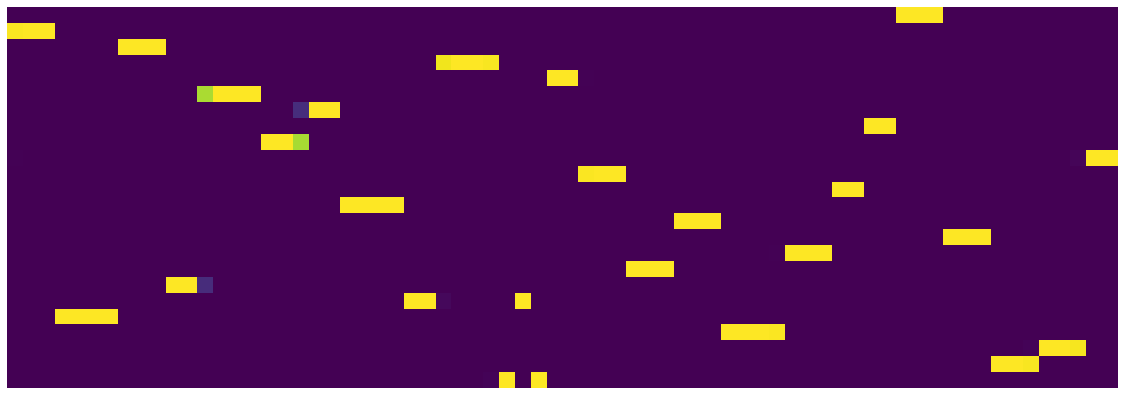

24 408 0.5909999999999996 0.45240995697677133


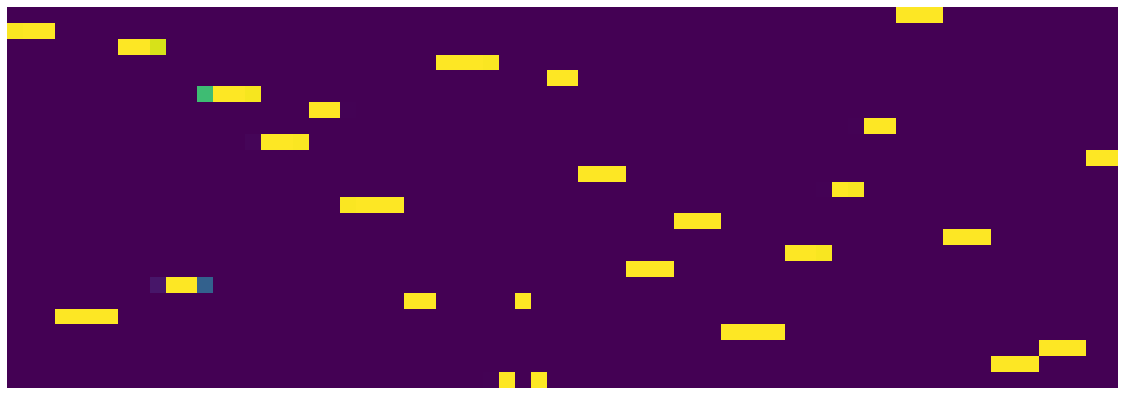

24 409 0.5899999999999996 0.45448937974870207


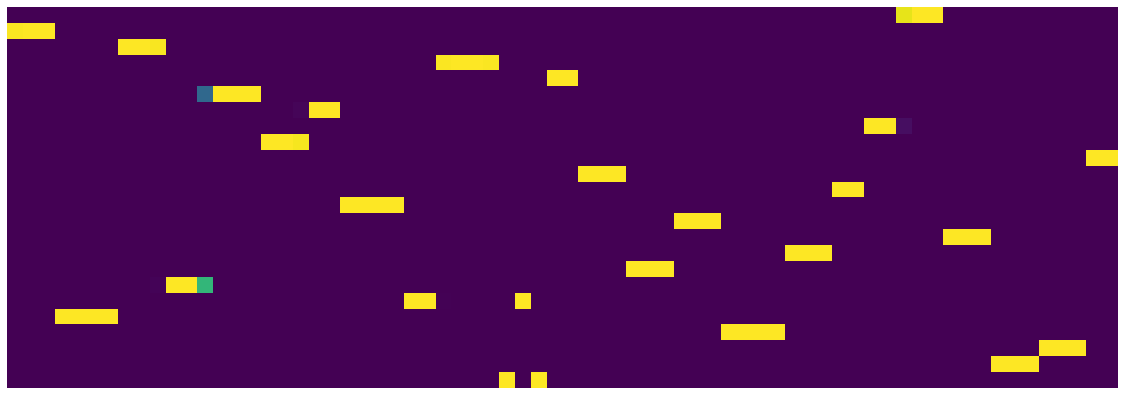

24 410 0.5889999999999996 0.45266902893781663


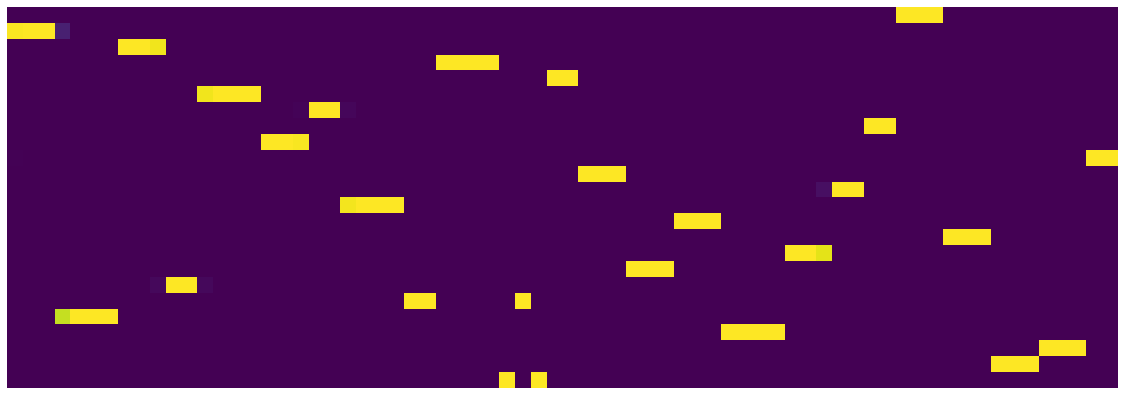

24 411 0.5879999999999996 0.452567021176219


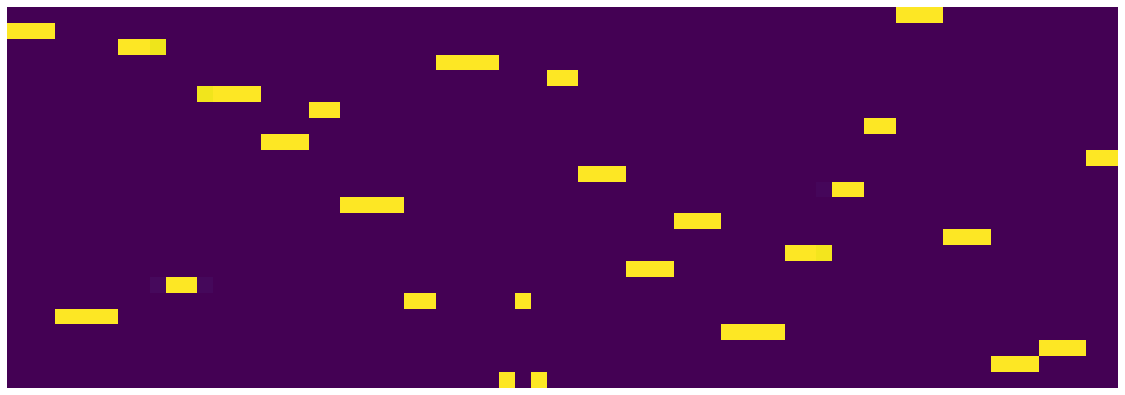

24 412 0.5869999999999996 0.45180236399173734


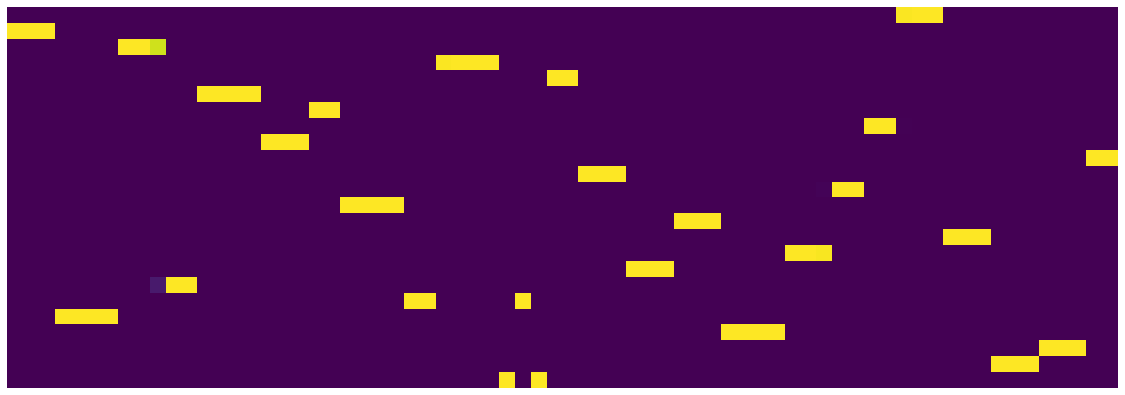

24 413 0.5859999999999996 0.45301522221416235


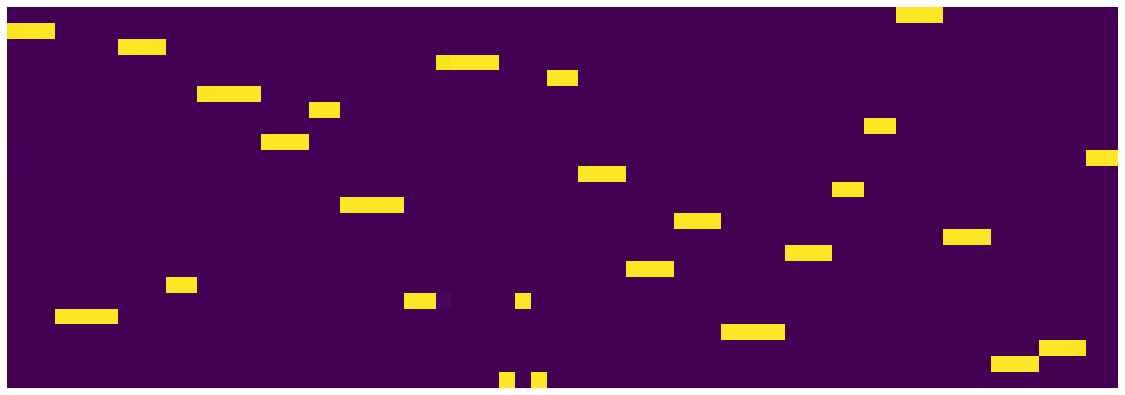

24 414 0.5849999999999996 0.4520891595631838


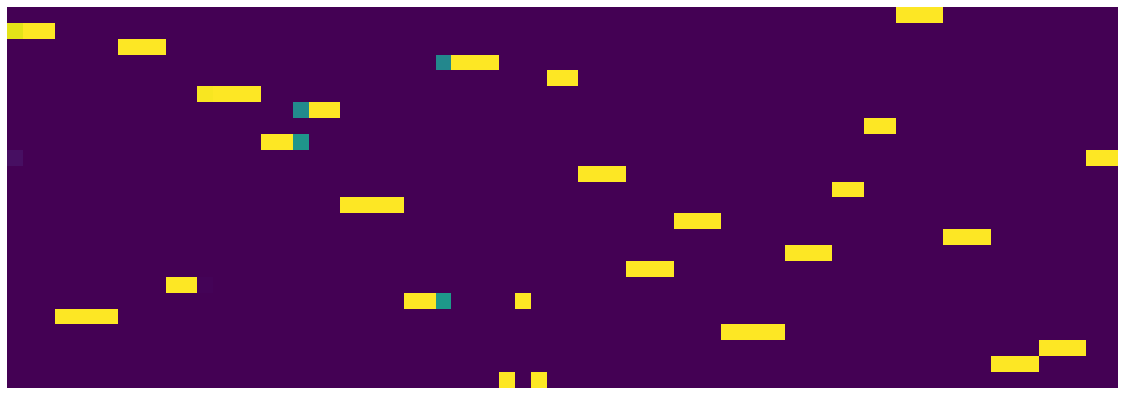

24 415 0.5839999999999996 0.4523148475214839


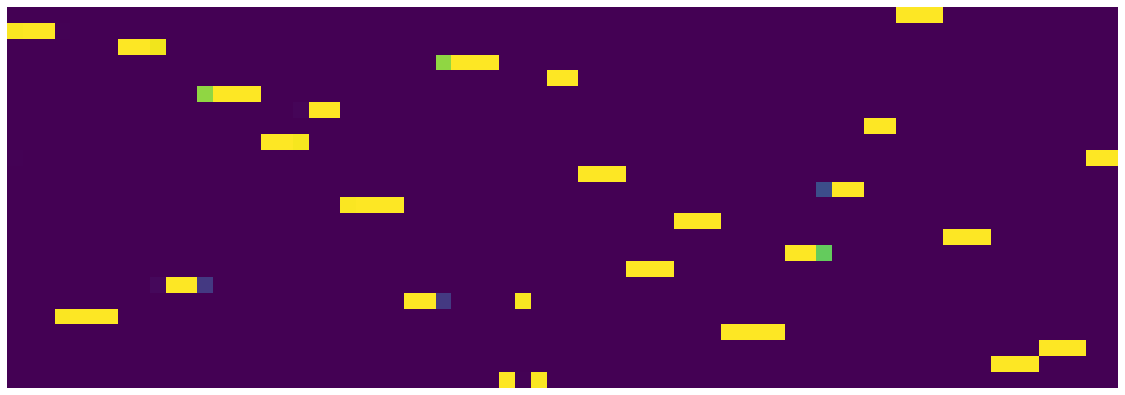

24 416 0.5829999999999996 0.4523983674123883


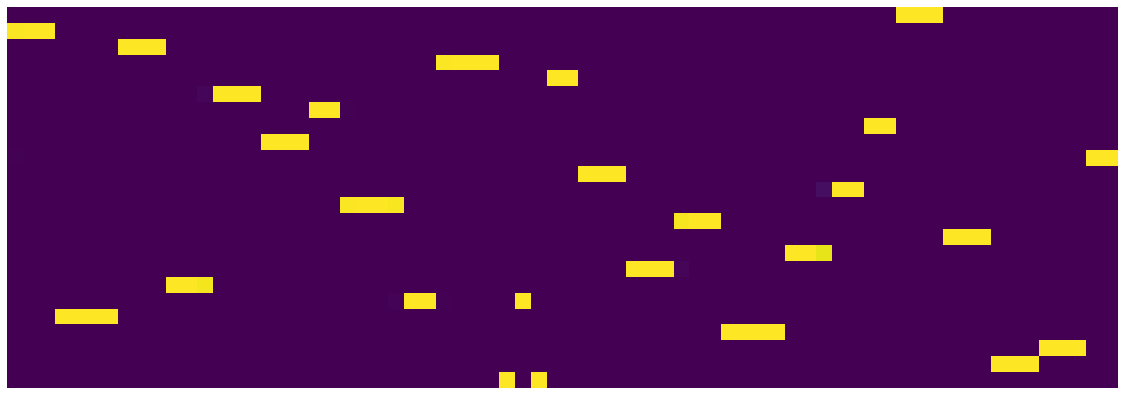

24 417 0.5819999999999996 0.45191216096282005


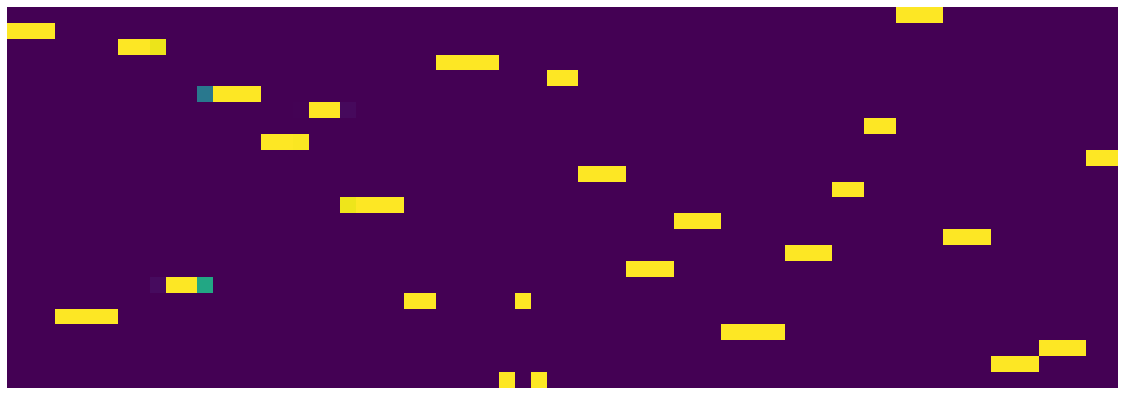

24 418 0.5809999999999996 0.4524545788764954


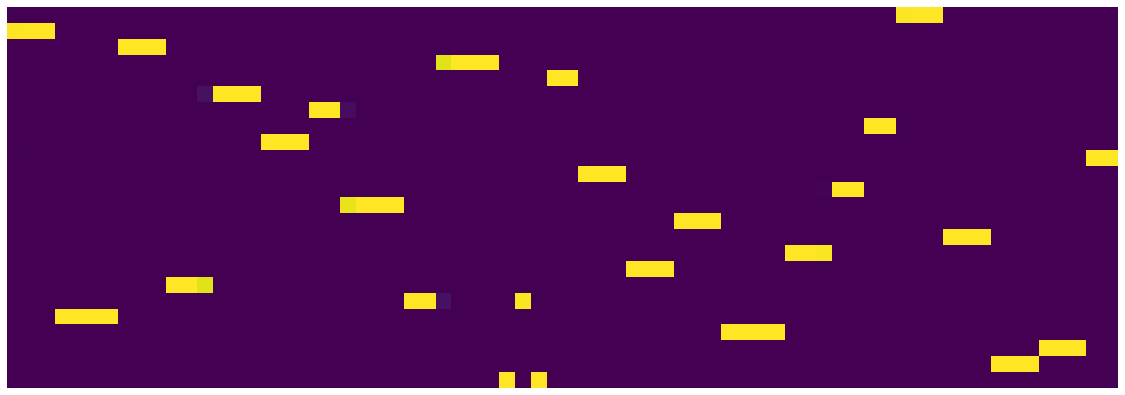

24 419 0.5799999999999996 0.4519463857635856


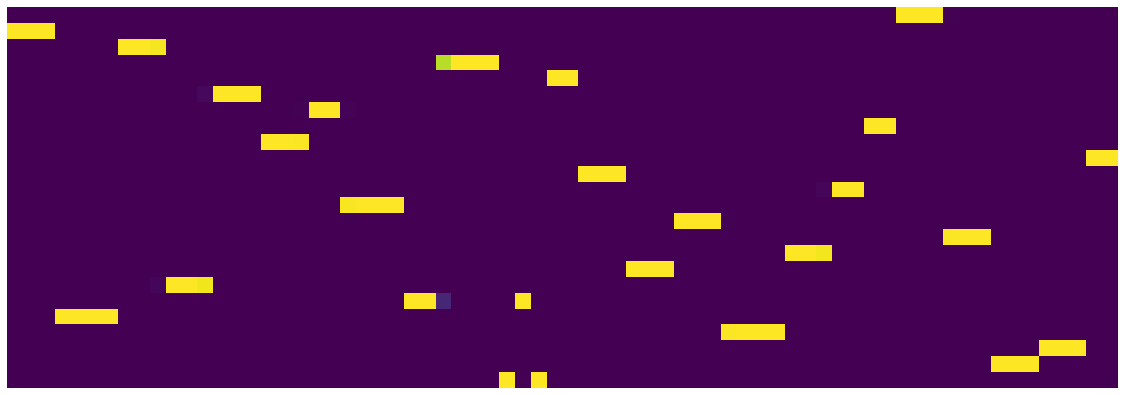

24 420 0.5789999999999996 0.4519850121811032


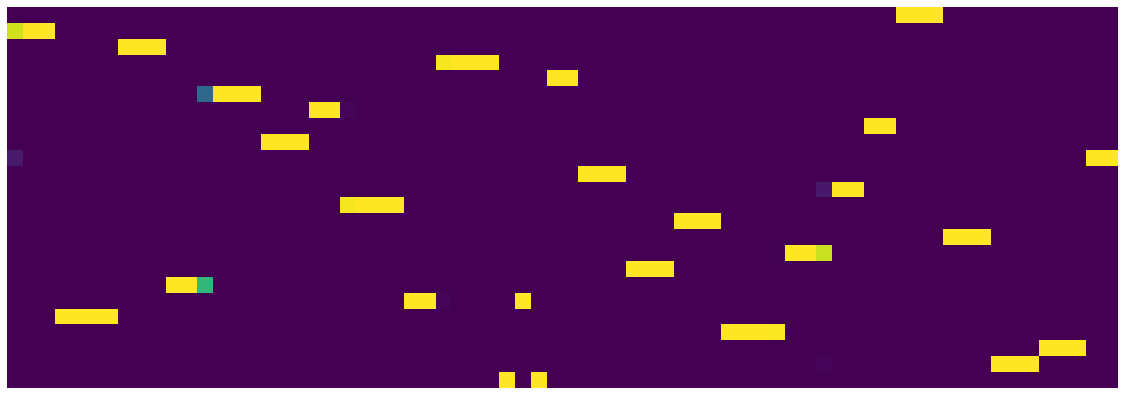

24 421 0.5779999999999996 0.45275561828166244


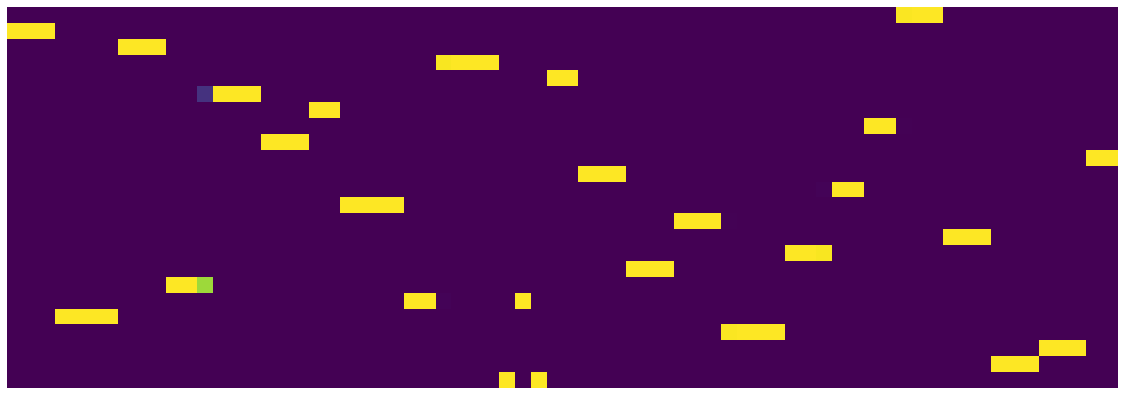

24 422 0.5769999999999996 0.45055962838232516


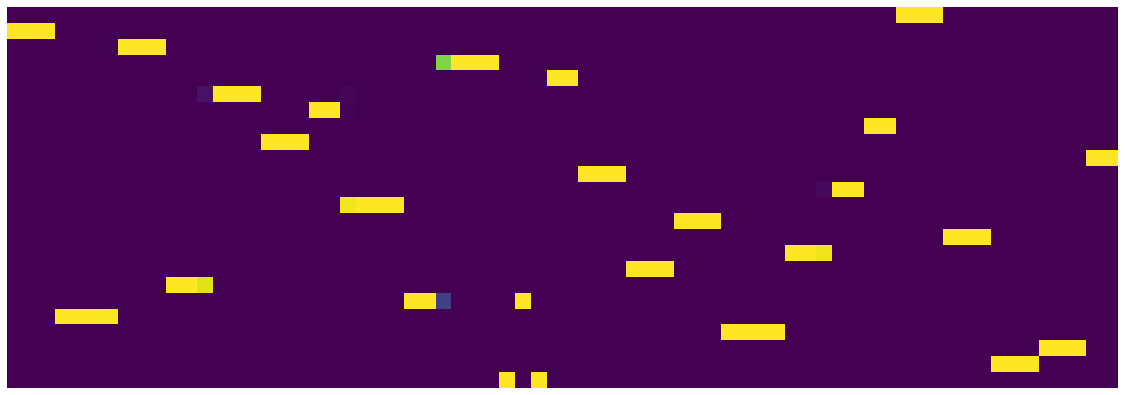

24 423 0.5759999999999996 0.4545356025919318


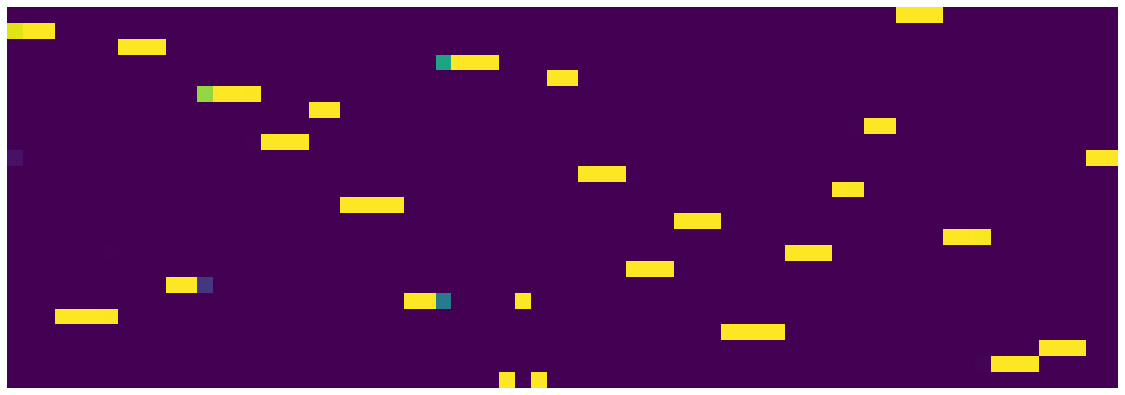

24 424 0.5749999999999996 0.4518314264714718


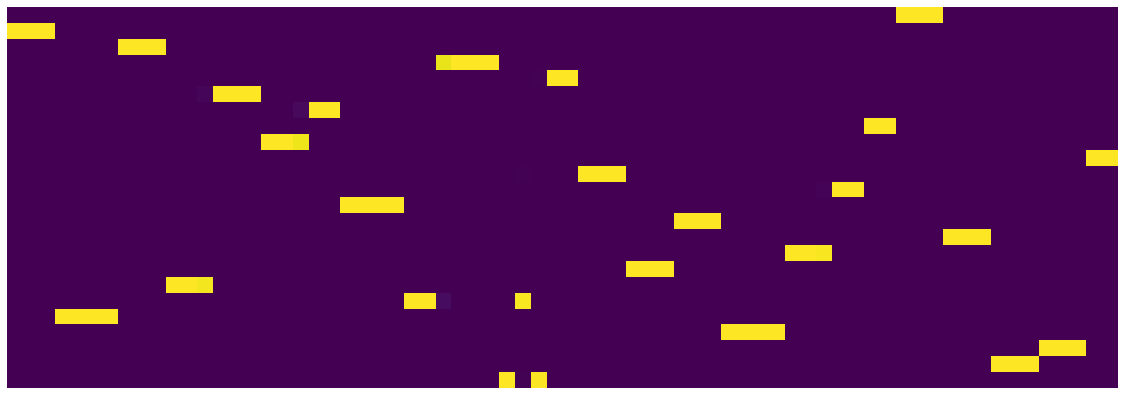

24 425 0.5739999999999996 0.4506681414321065


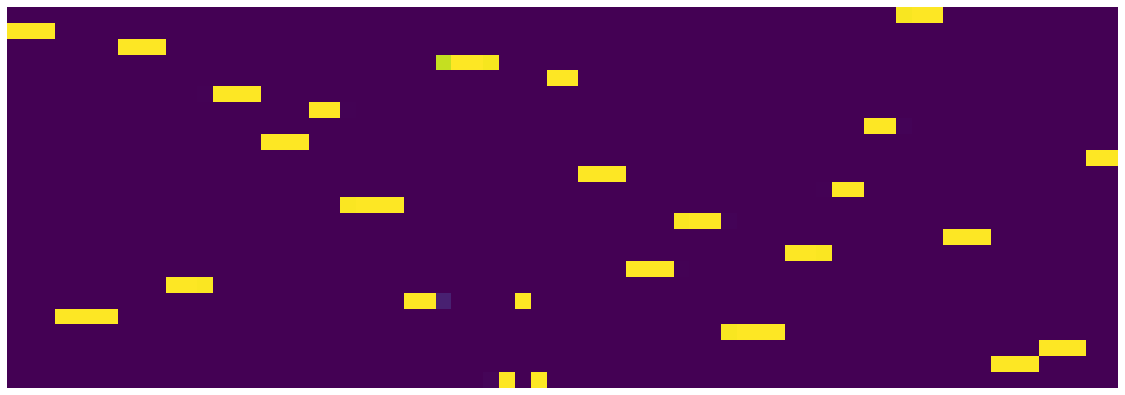

24 426 0.5729999999999996 0.44970012214034794


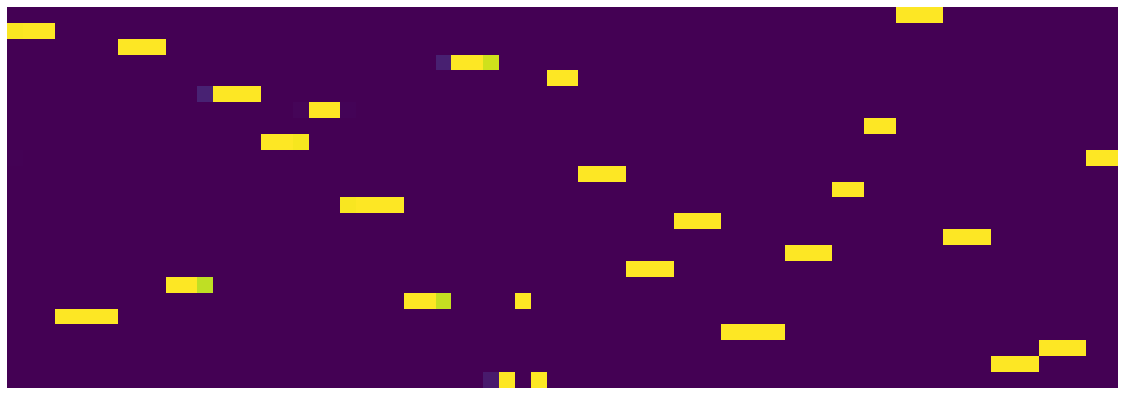

24 427 0.5719999999999996 0.45128471199423076


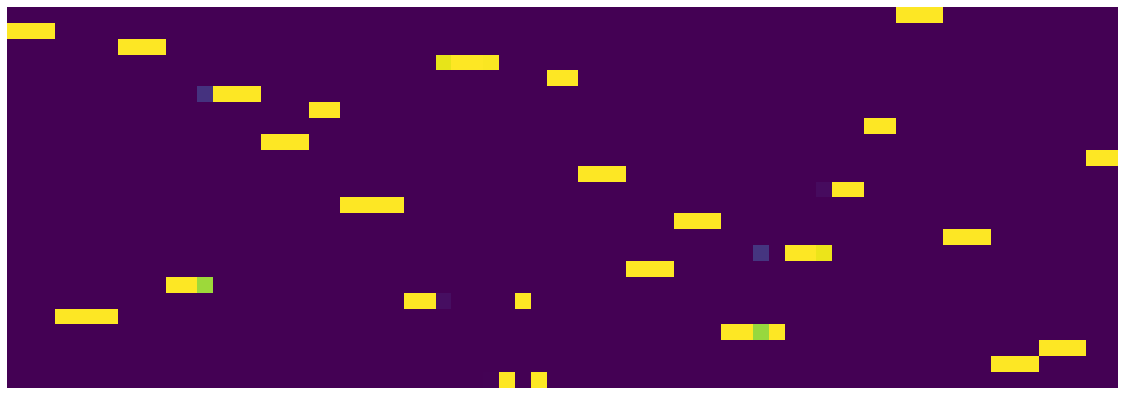

24 428 0.5709999999999996 0.45067599769681693


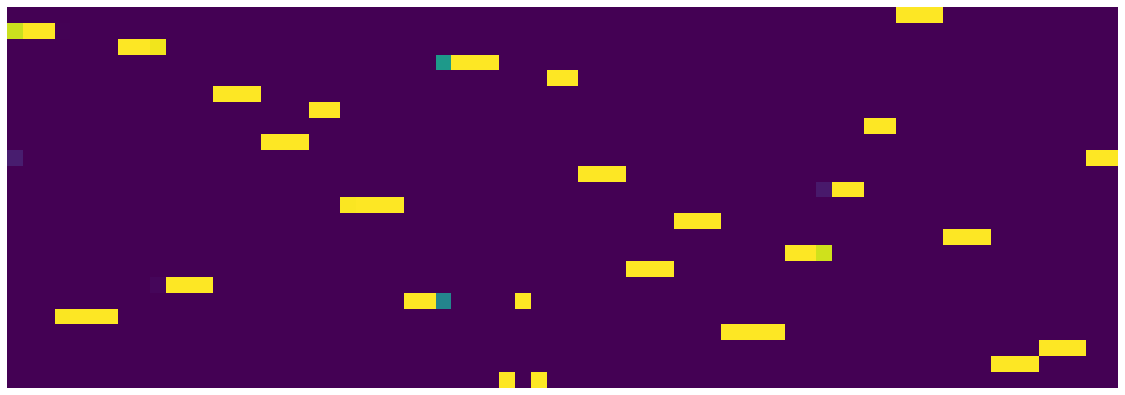

24 429 0.5699999999999996 0.4502844696864486


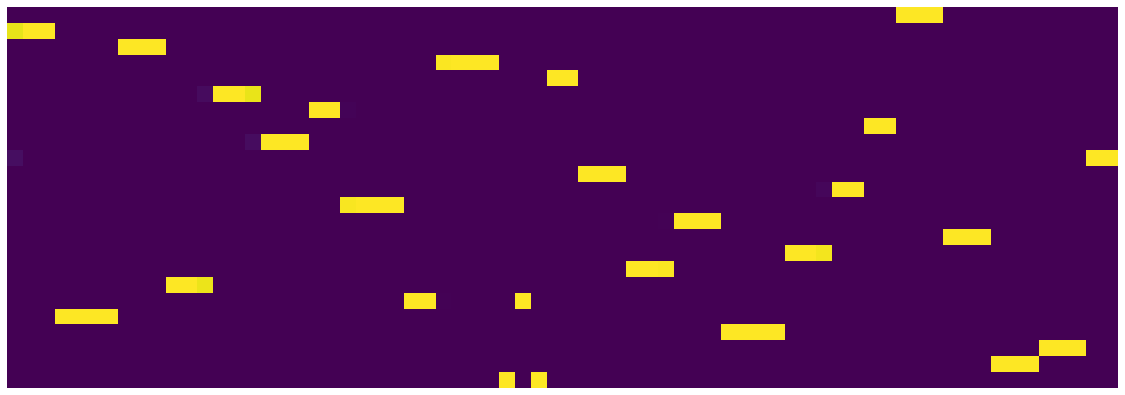

24 430 0.5689999999999996 0.45098551232367756


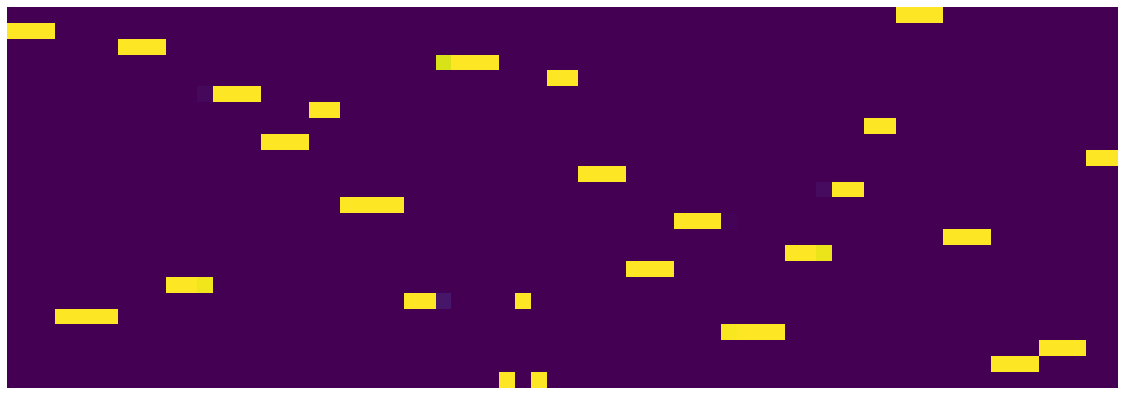

24 431 0.5679999999999996 0.45007253754884


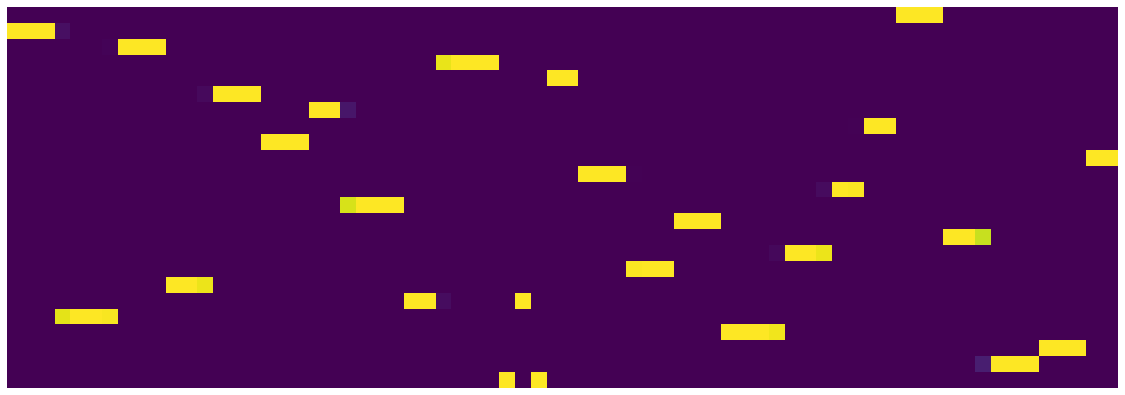

24 432 0.5669999999999996 0.4507673535495996


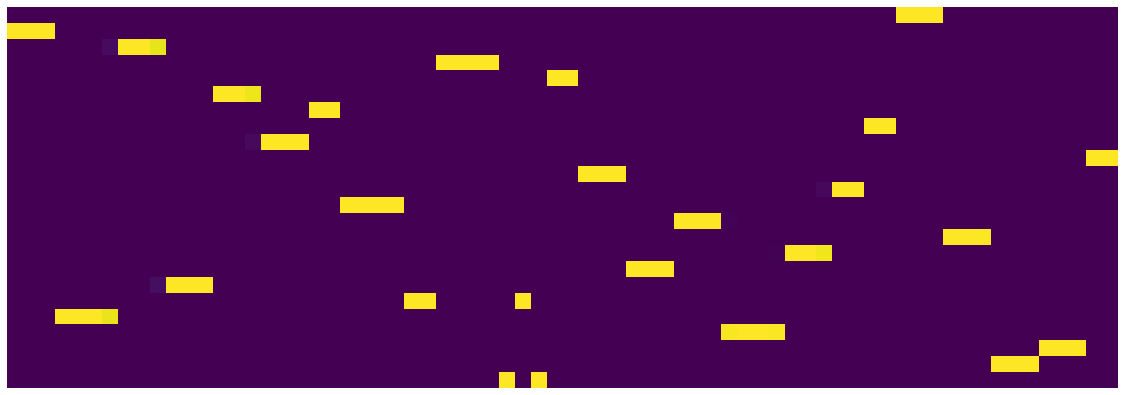

24 433 0.5659999999999996 0.4498266026377678


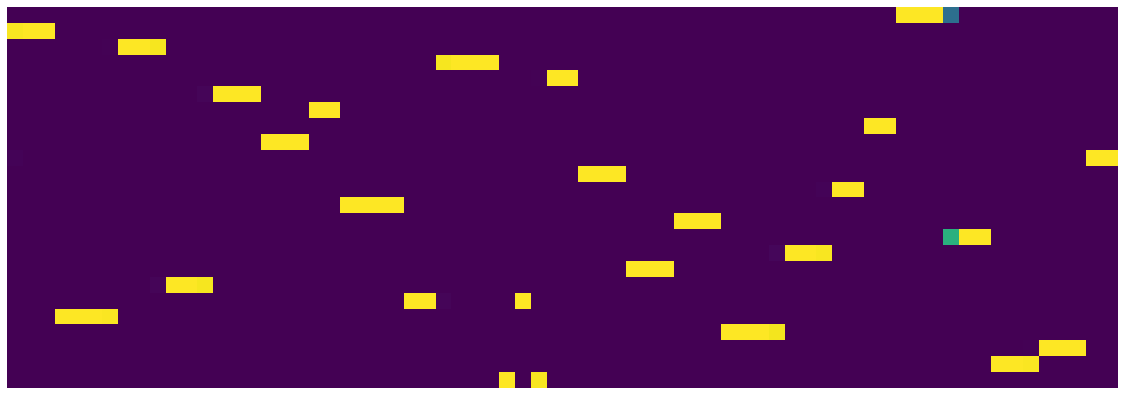

24 434 0.5649999999999996 0.45468481387943027


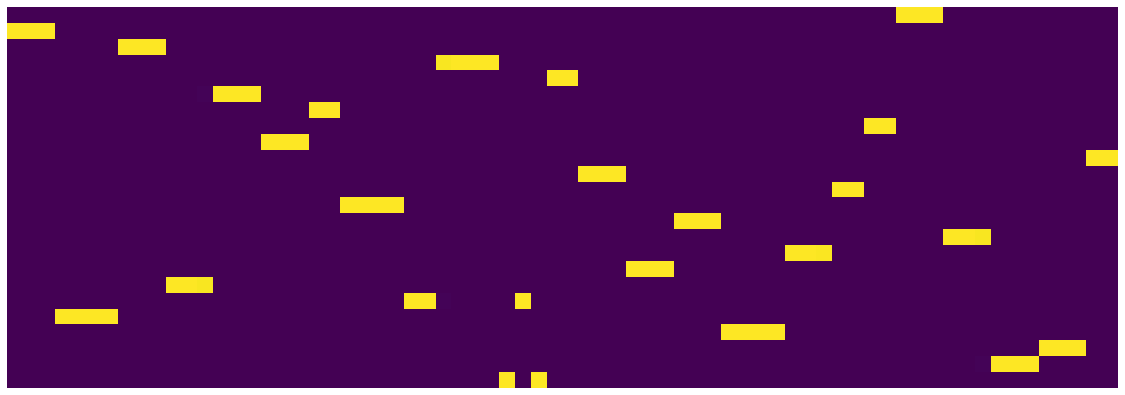

24 435 0.5639999999999996 0.45060643963515756


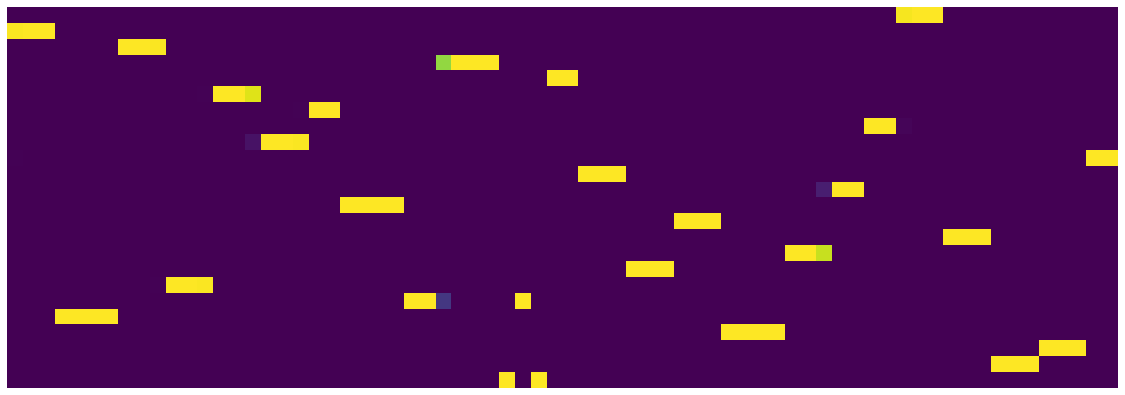

24 436 0.5629999999999996 0.44999091904610394


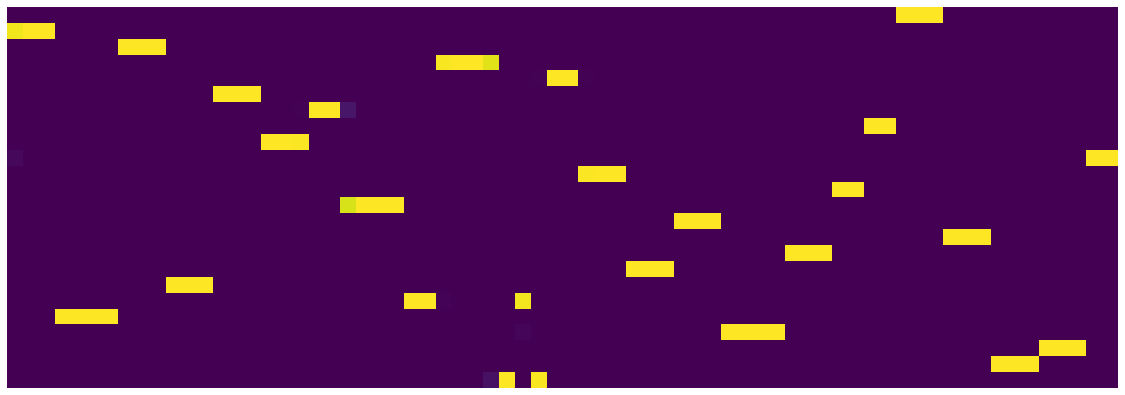

24 437 0.5619999999999996 0.44976409524679184


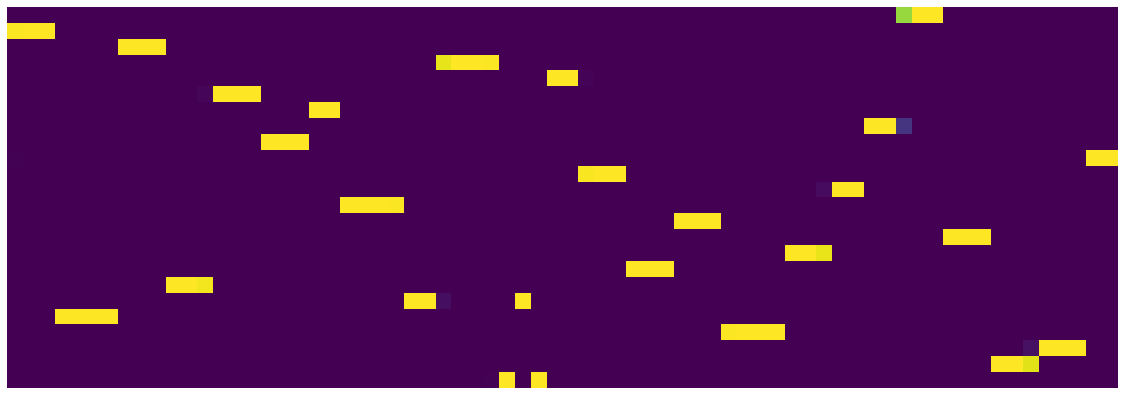

24 438 0.5609999999999996 0.44993726424872876


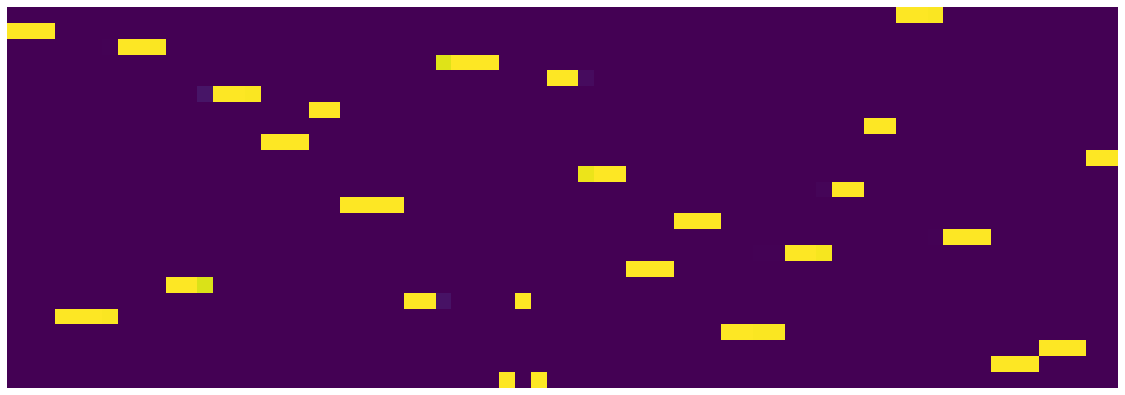

24 439 0.5599999999999996 0.4500839125365019


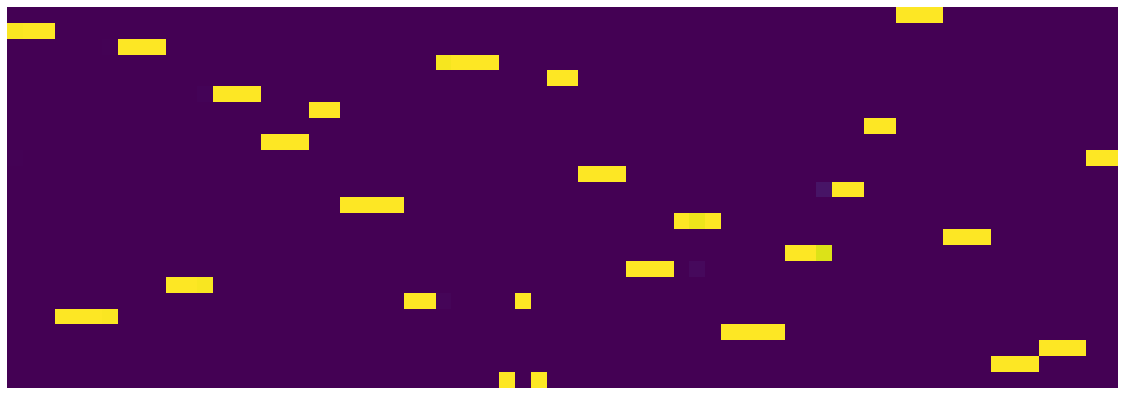

24 440 0.5589999999999996 0.4495320703834295


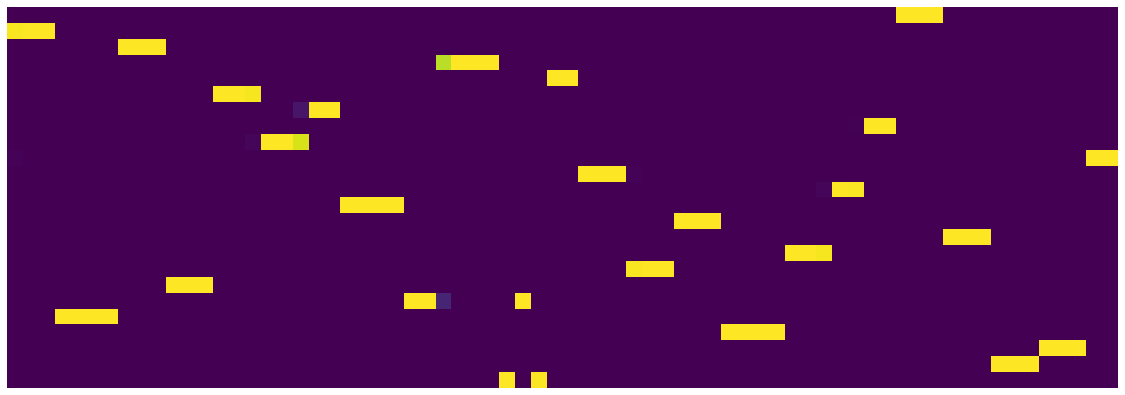

24 441 0.5579999999999996 0.45124591886997223


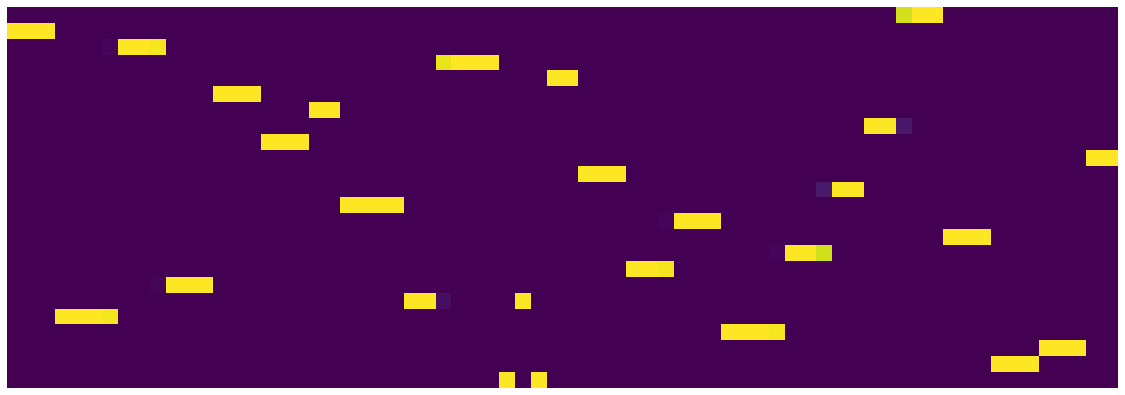

24 442 0.5569999999999996 0.4527578758075833


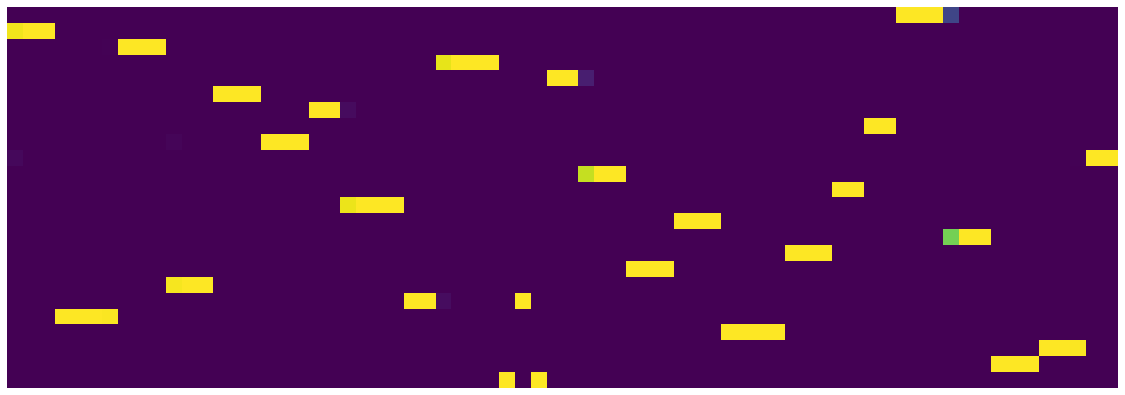

24 443 0.5559999999999996 0.44964018315076826


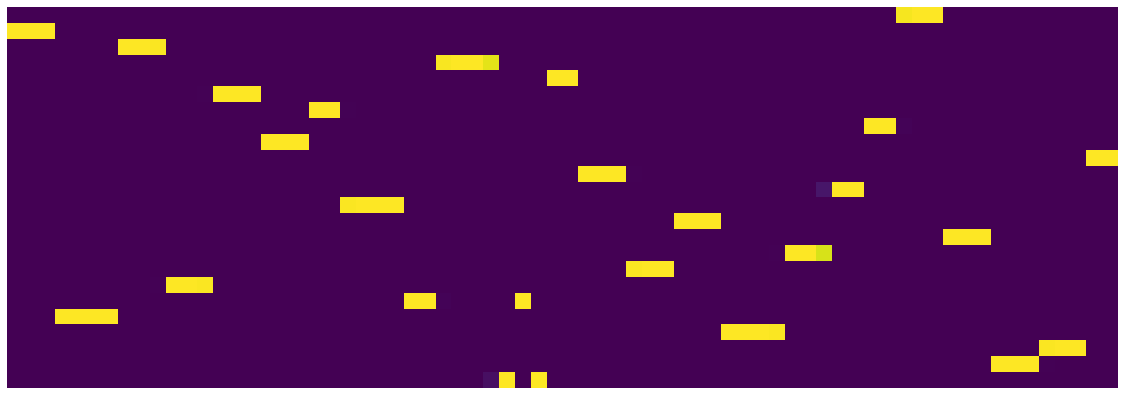

24 444 0.5549999999999996 0.4508617943152785


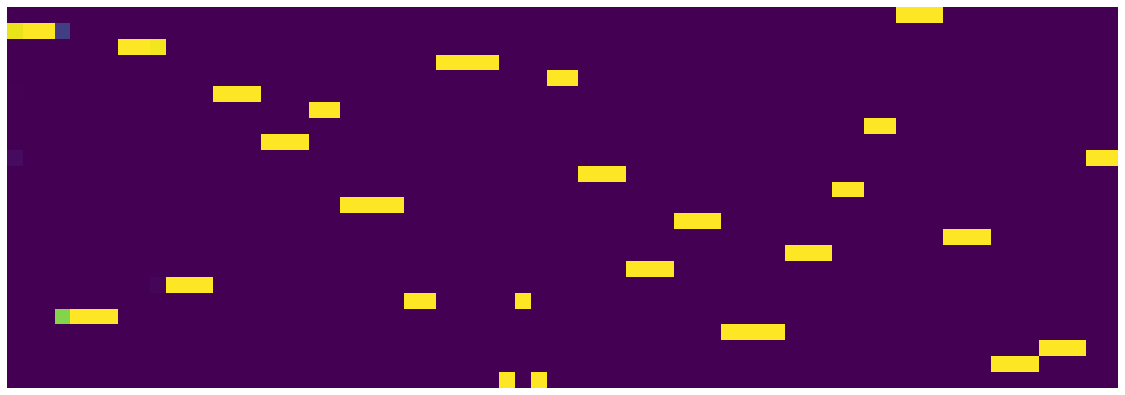

24 445 0.5539999999999996 0.4498910944908857


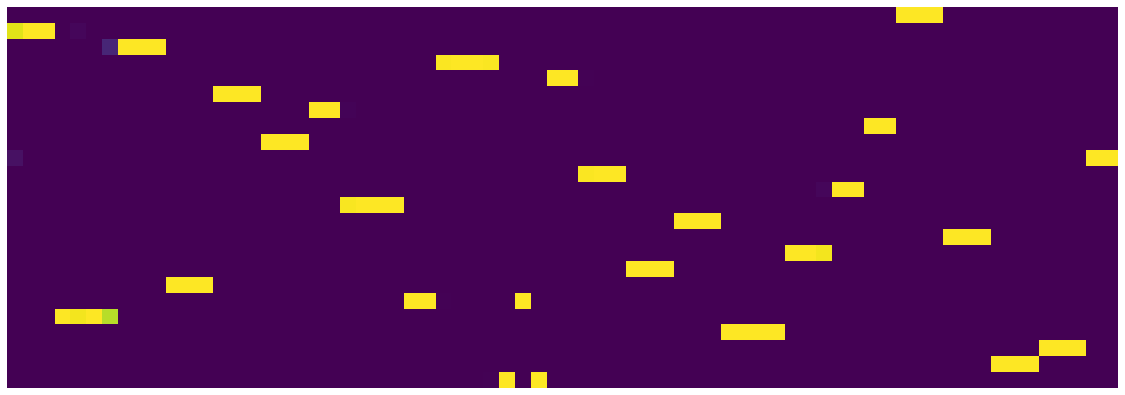

24 446 0.5529999999999996 0.450283233448863


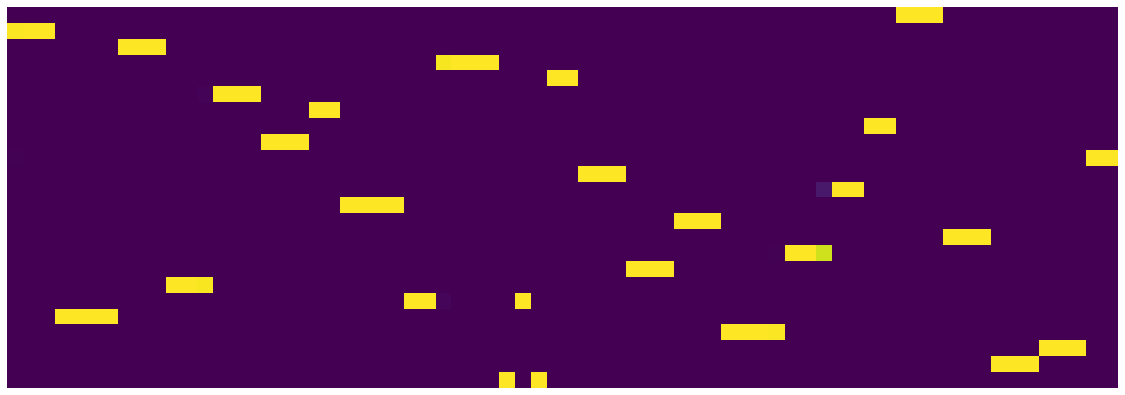

24 447 0.5519999999999996 0.44977471716701983


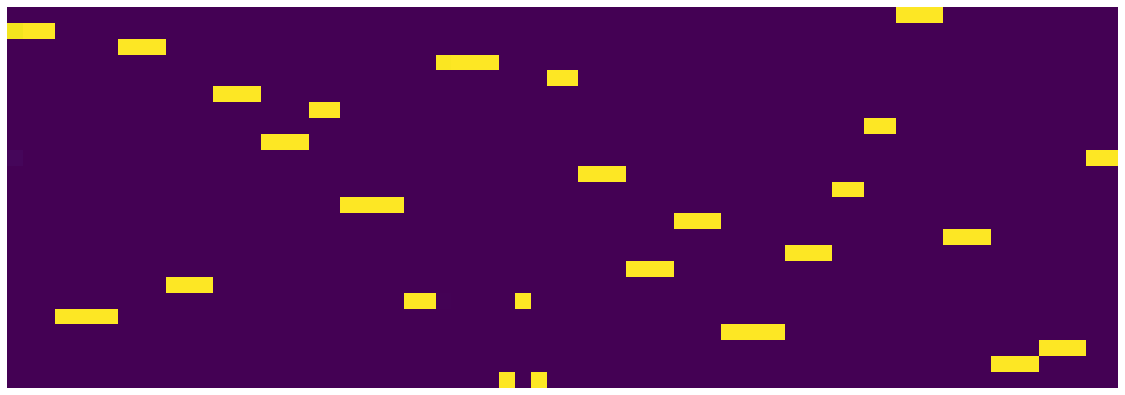

24 448 0.5509999999999996 0.449671889282763


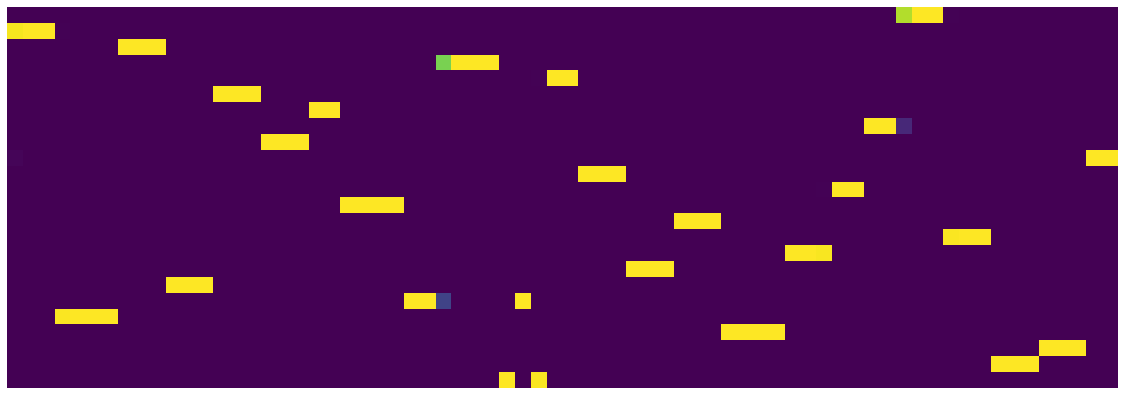

24 449 0.5499999999999996 0.4533498276025057


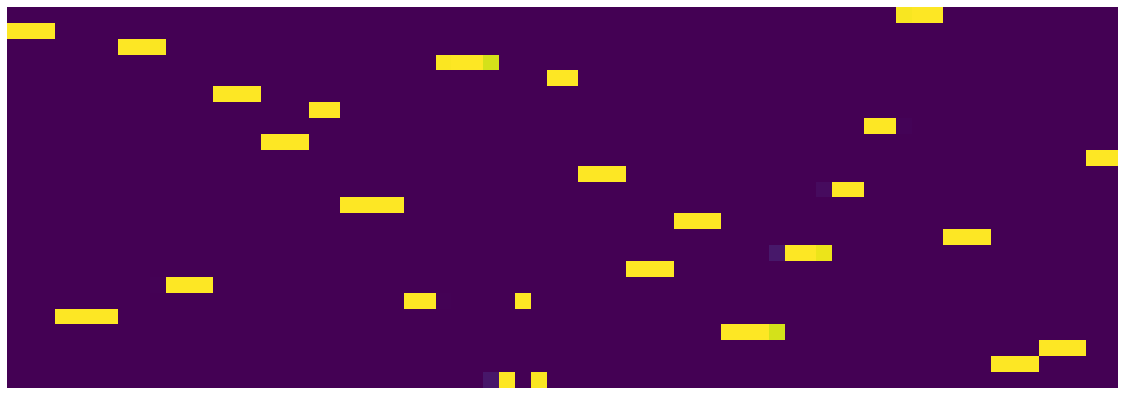

24 450 0.5489999999999996 0.44980634227395055


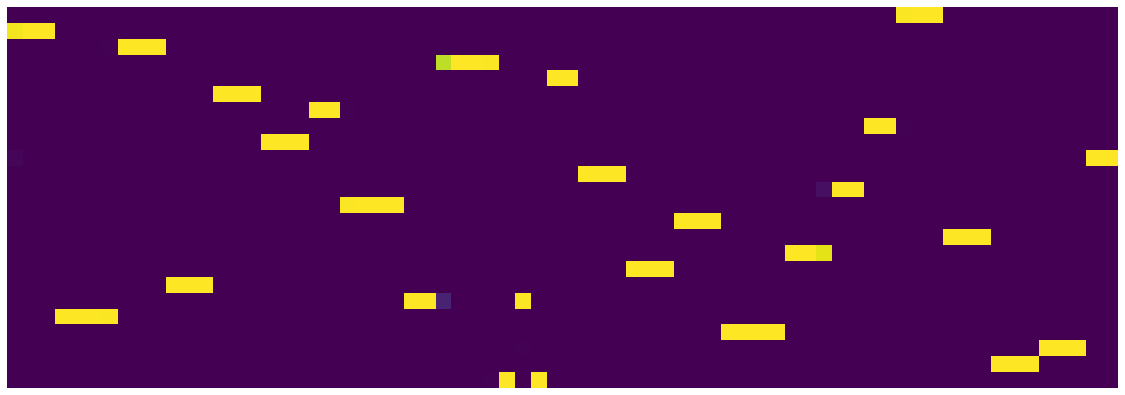

24 451 0.5479999999999996 0.45052956249564885


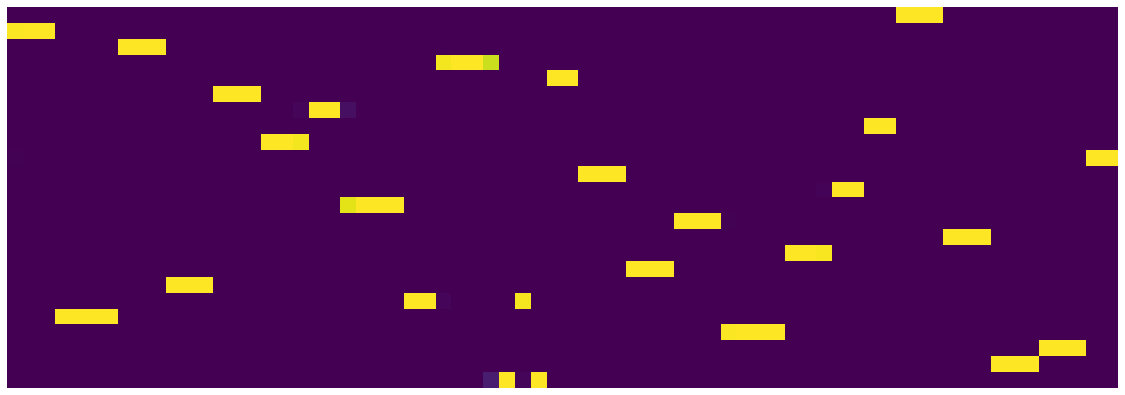

24 452 0.5469999999999996 0.4521889194846153


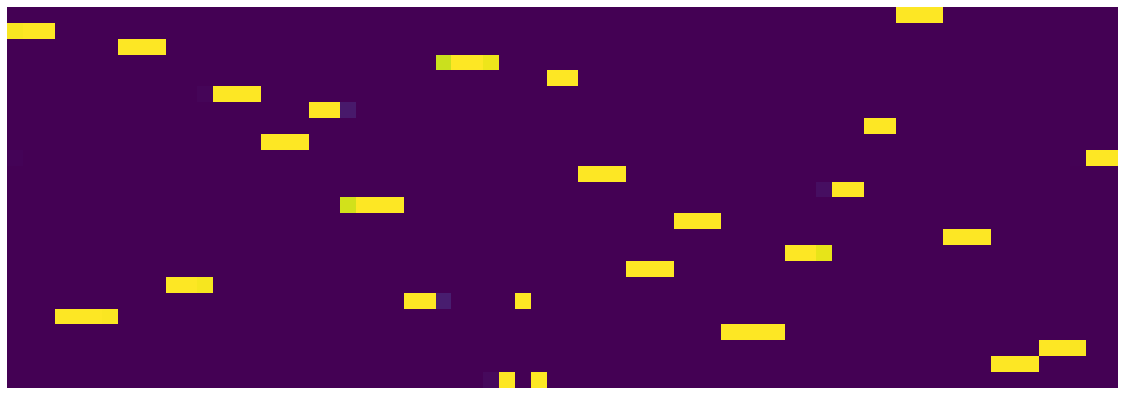

24 453 0.5459999999999996 0.45016889926046133


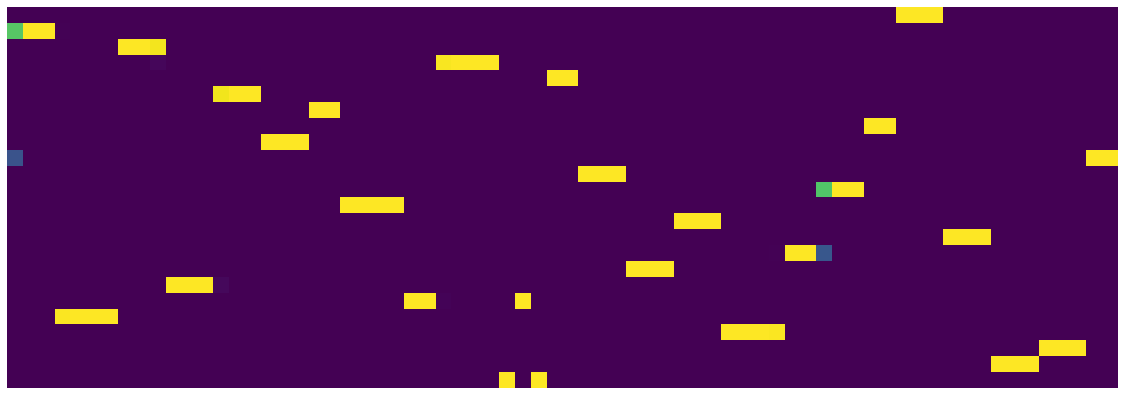

24 454 0.5449999999999996 0.45026304516941307


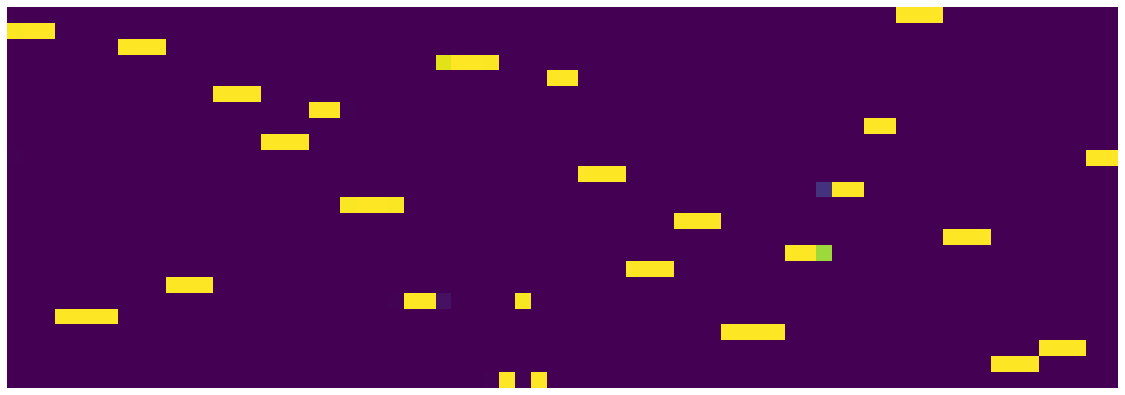

24 455 0.5439999999999996 0.45084323100745677


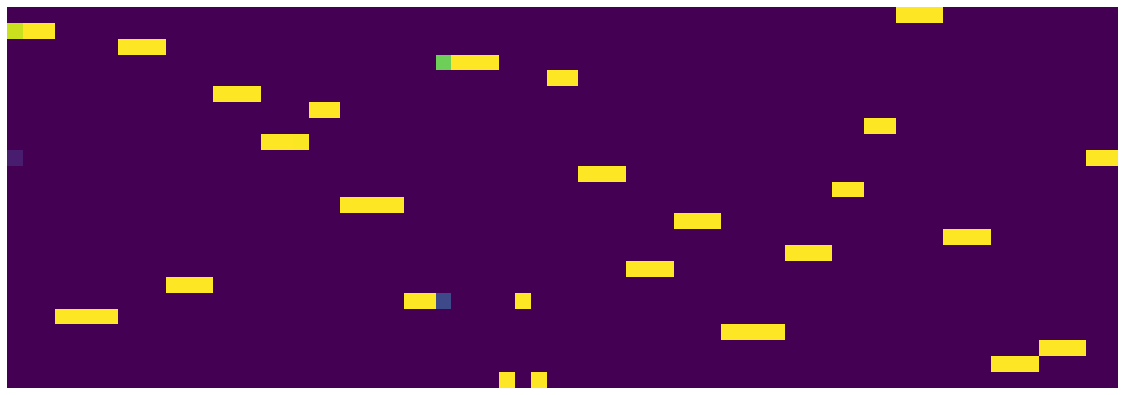

24 456 0.5429999999999996 0.44939573388546705


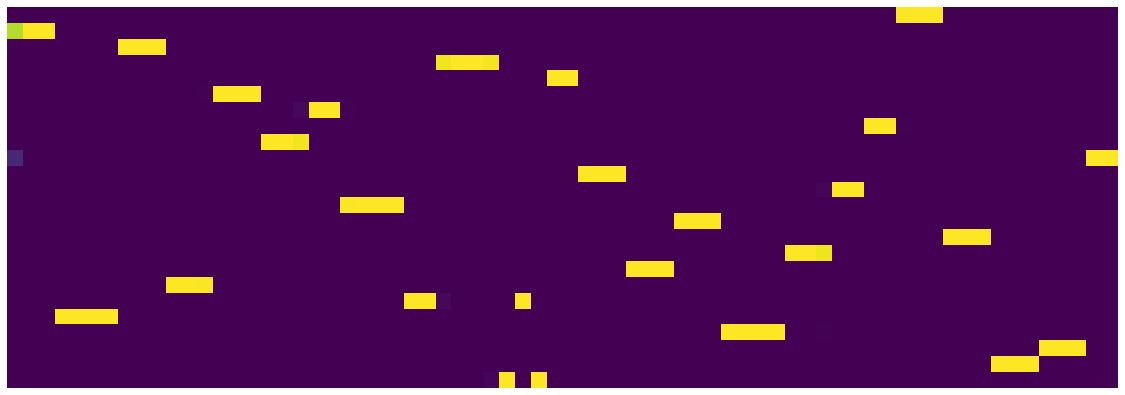

24 457 0.5419999999999996 0.449399533867836


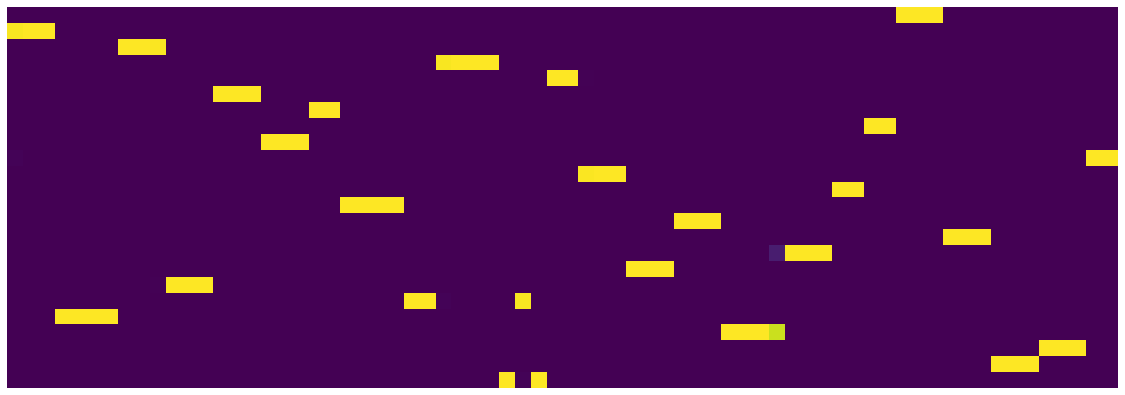

24 458 0.5409999999999996 0.44969342928379774


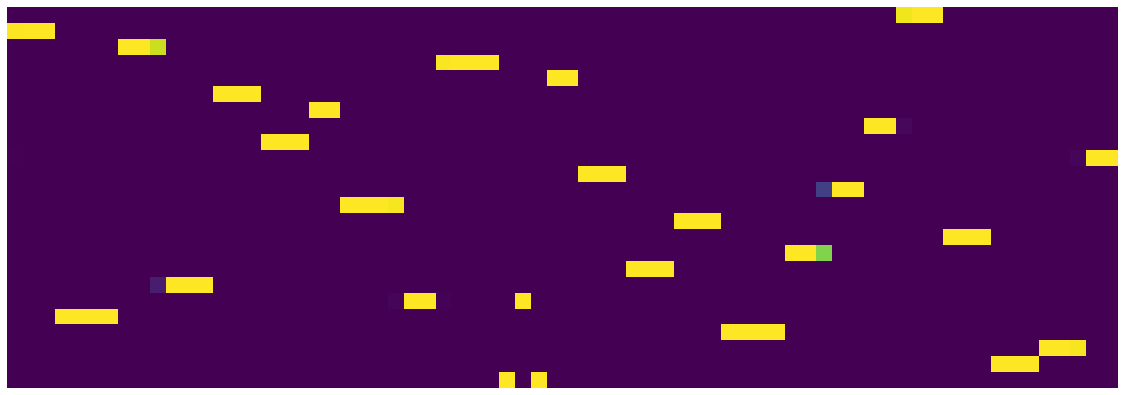

24 459 0.5399999999999996 0.449454165995121


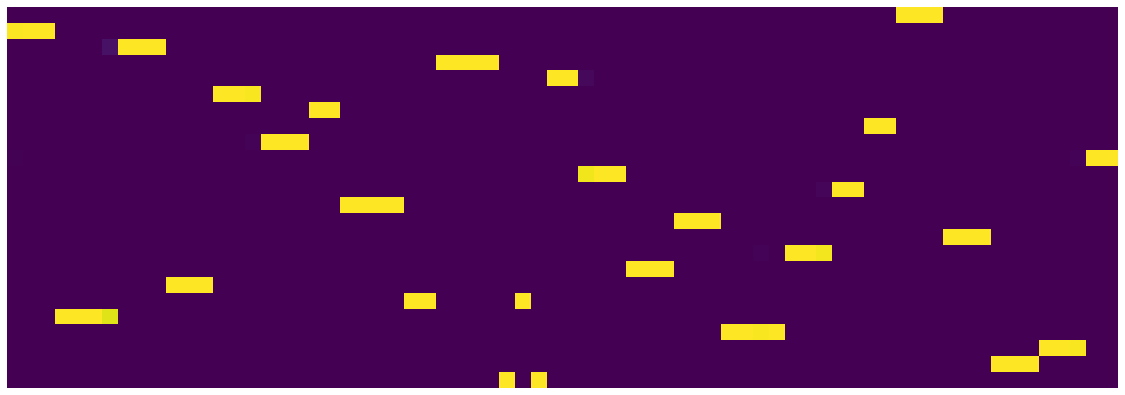

24 460 0.5389999999999996 0.45072429664433


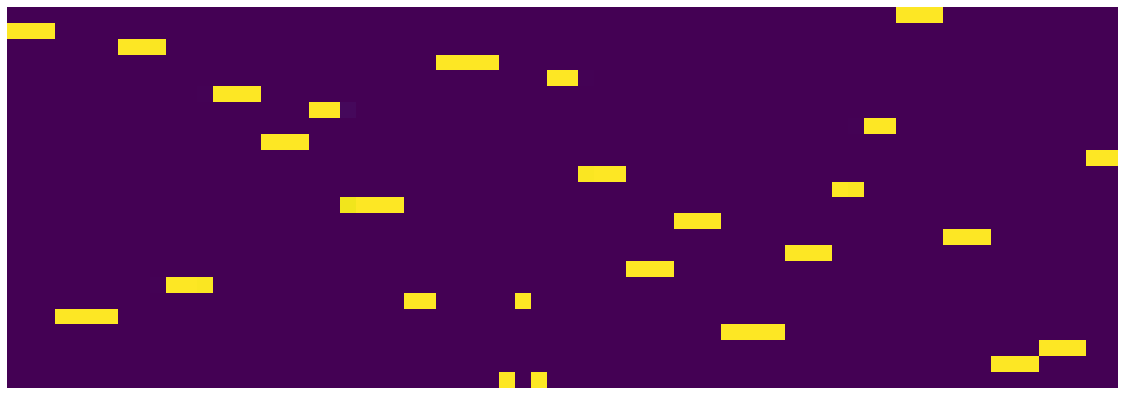

24 461 0.5379999999999996 0.4498449647799134


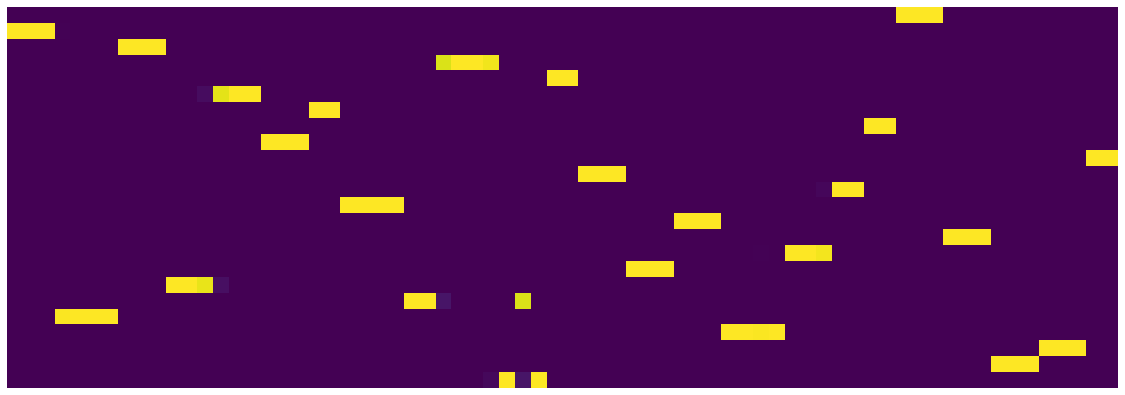

24 462 0.5369999999999996 0.45020163170993327


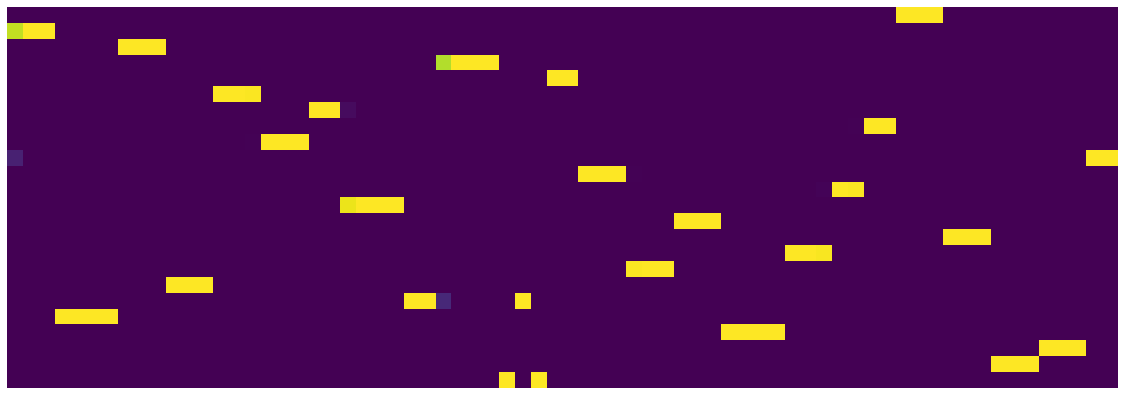

24 463 0.5359999999999996 0.449932967312634


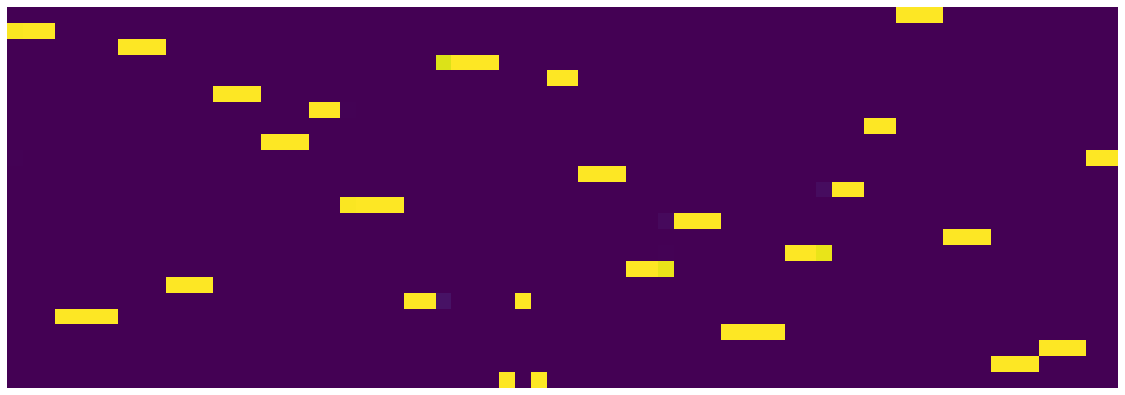

24 464 0.5349999999999996 0.4502499412745237


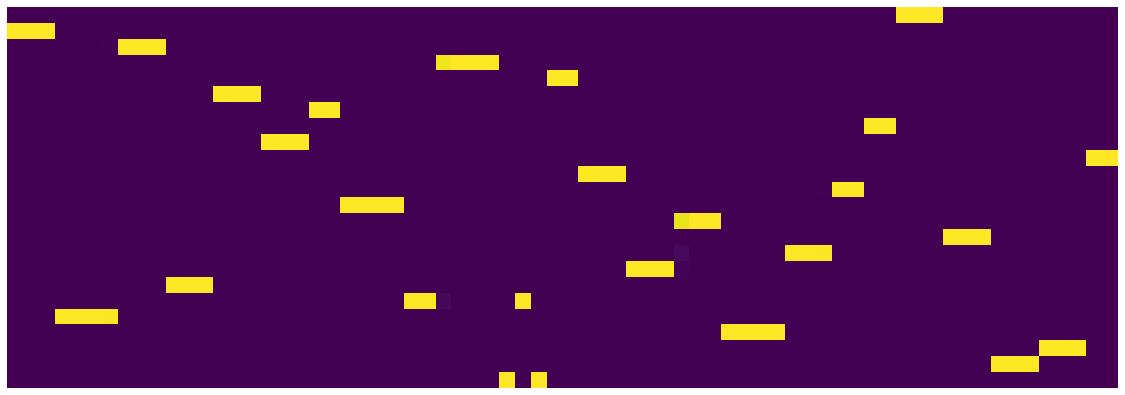

24 465 0.5339999999999996 0.4499357780441642


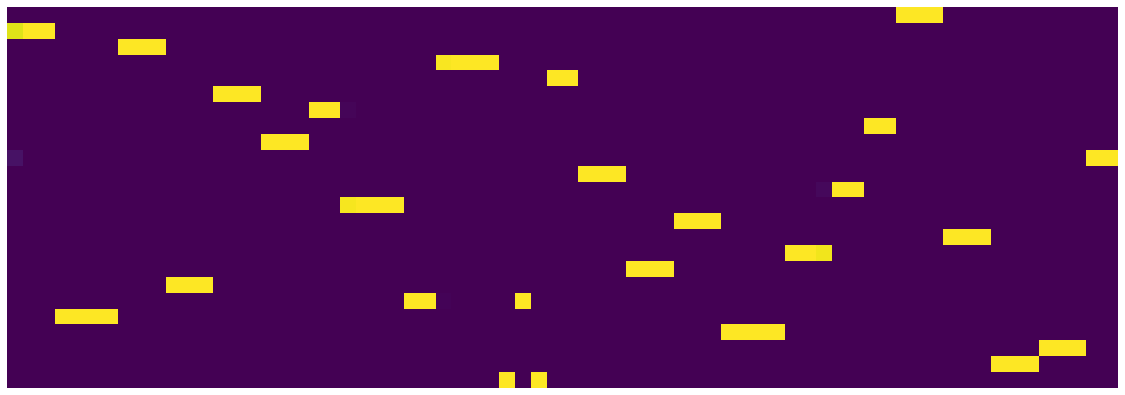

24 466 0.5329999999999996 0.4503948578611016


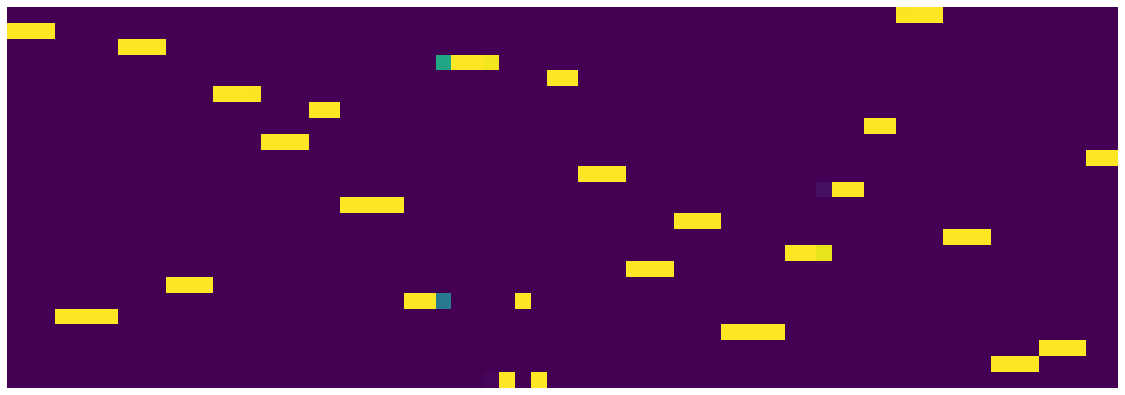

24 467 0.5319999999999996 0.45098094530403615


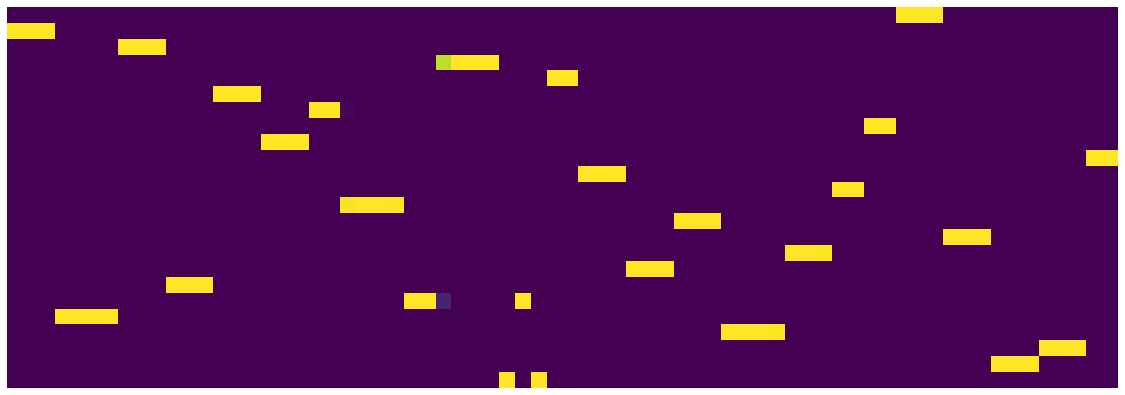

24 468 0.5309999999999996 0.45111278984695674


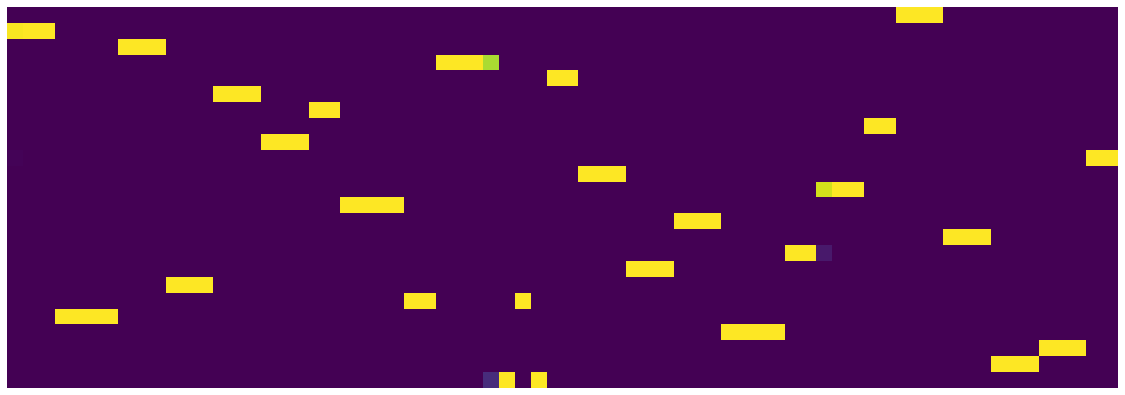

24 469 0.5299999999999996 0.44998301807790997


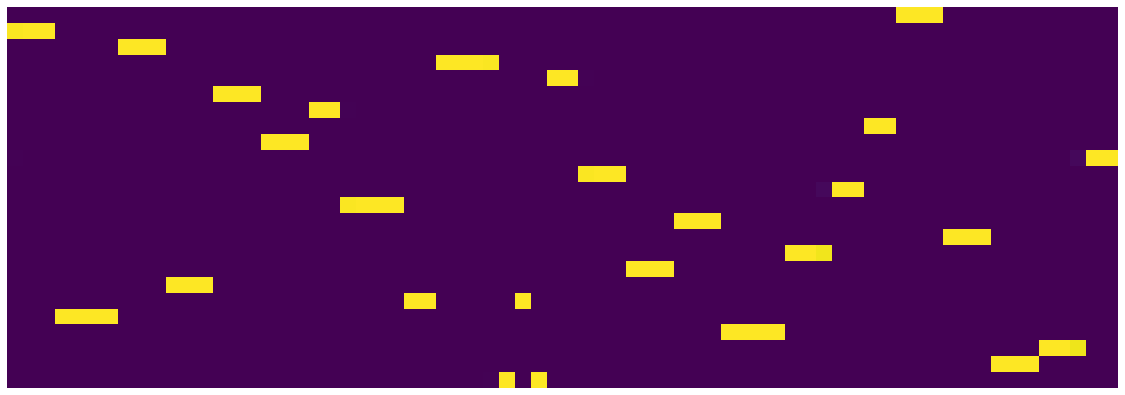

24 470 0.5289999999999996 0.45010974779725077


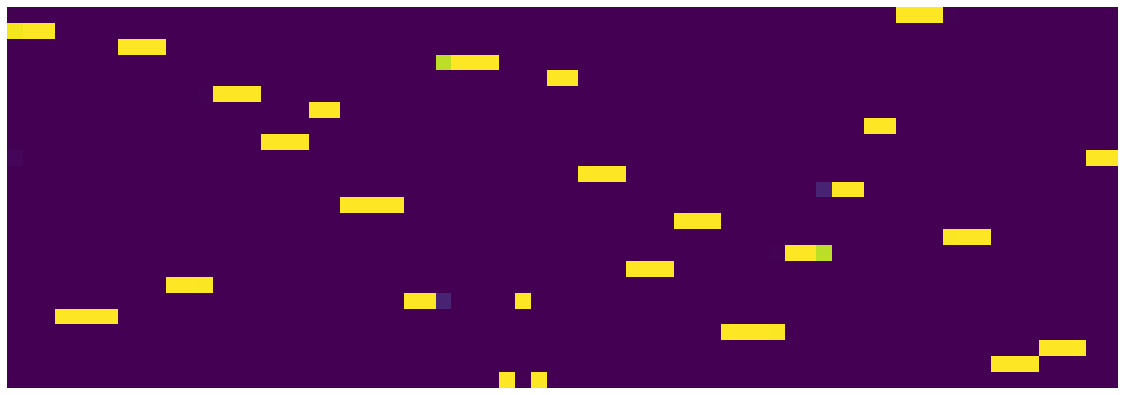

24 471 0.5279999999999996 0.4498223325237632


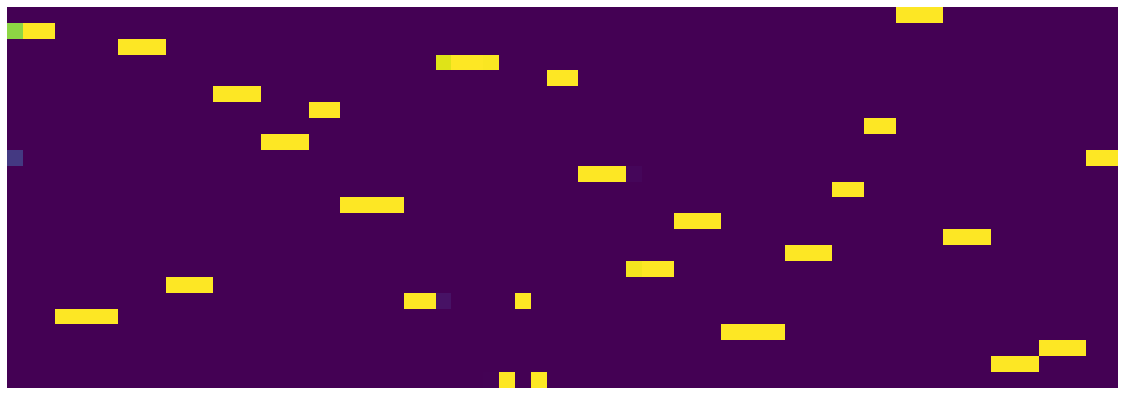

24 472 0.5269999999999996 0.45033857487142087


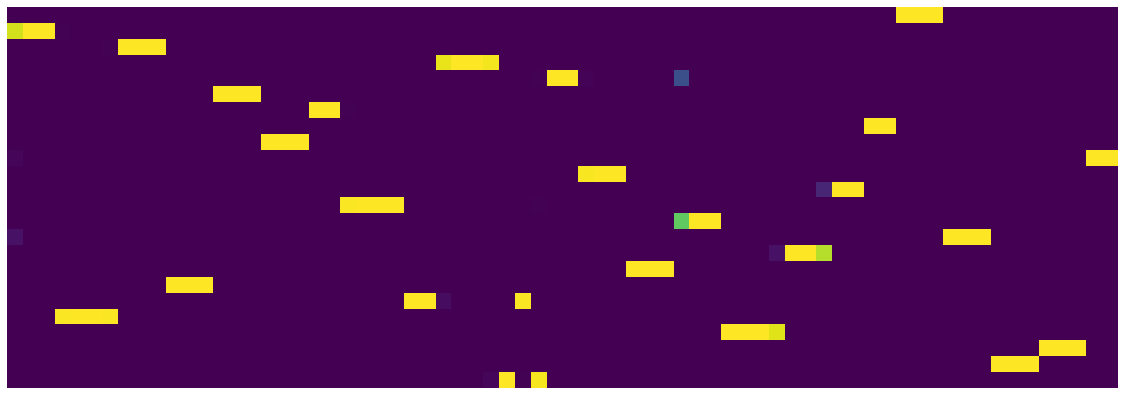

24 473 0.5259999999999996 0.45031735841184856


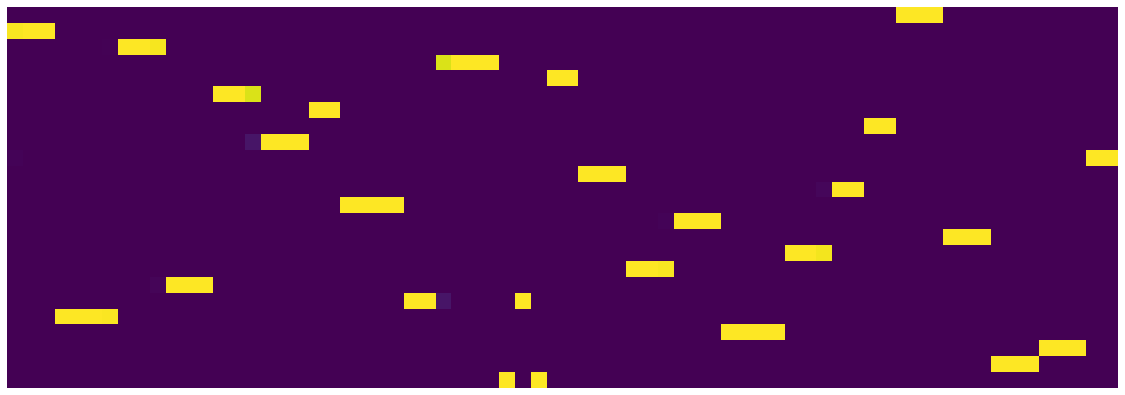

24 474 0.5249999999999996 0.45083056651055814


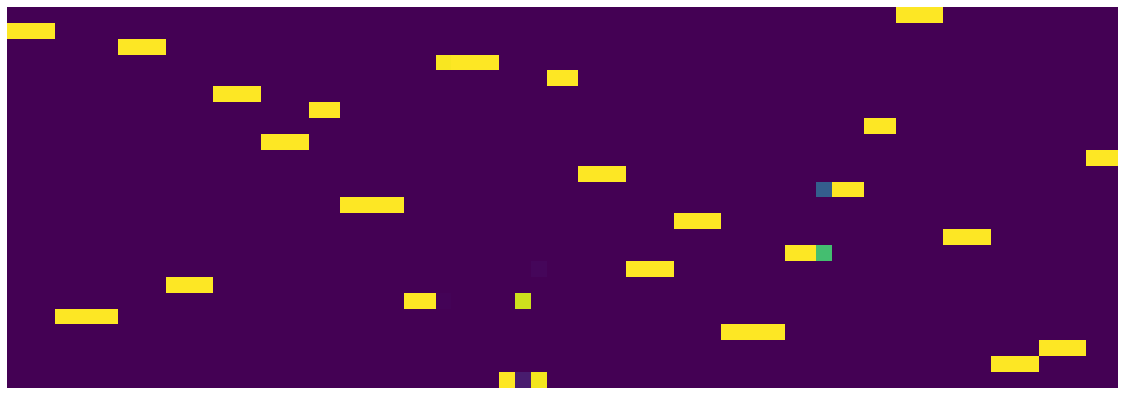

24 475 0.5239999999999996 0.45112225133925676


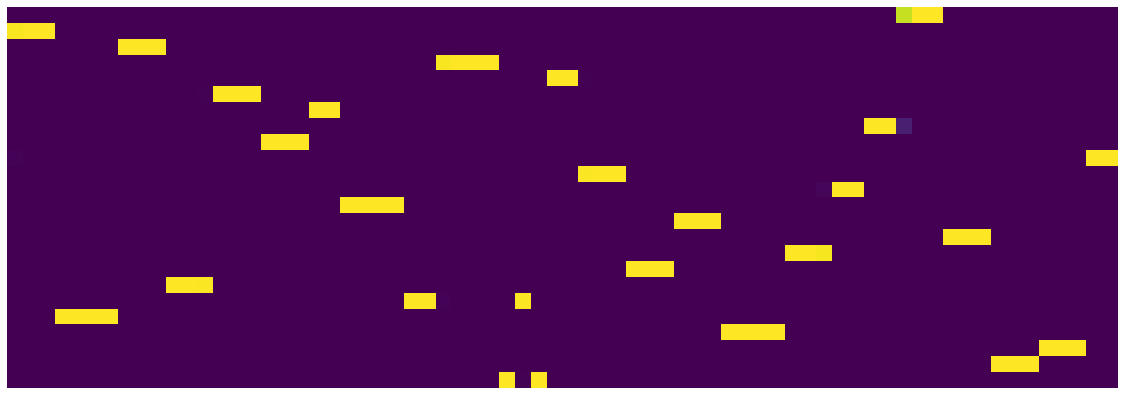

24 476 0.5229999999999996 0.450112946331501


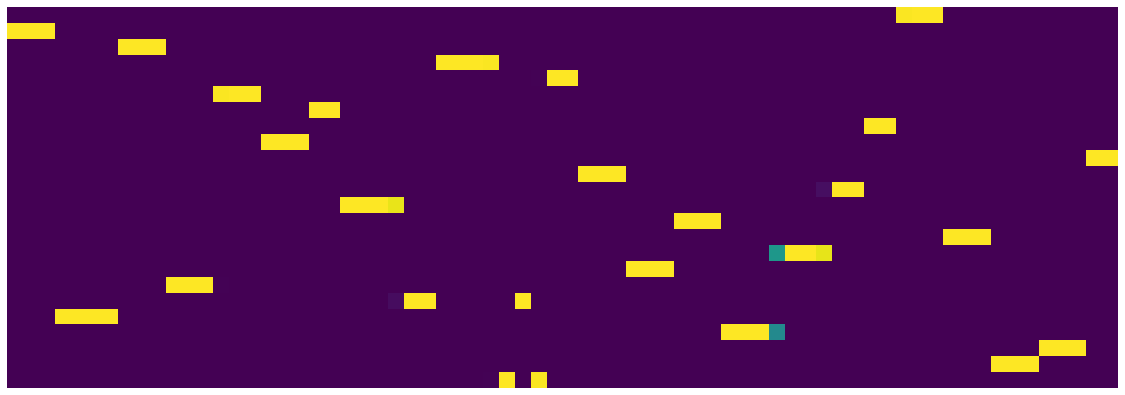

24 477 0.5219999999999996 0.4507703263312578


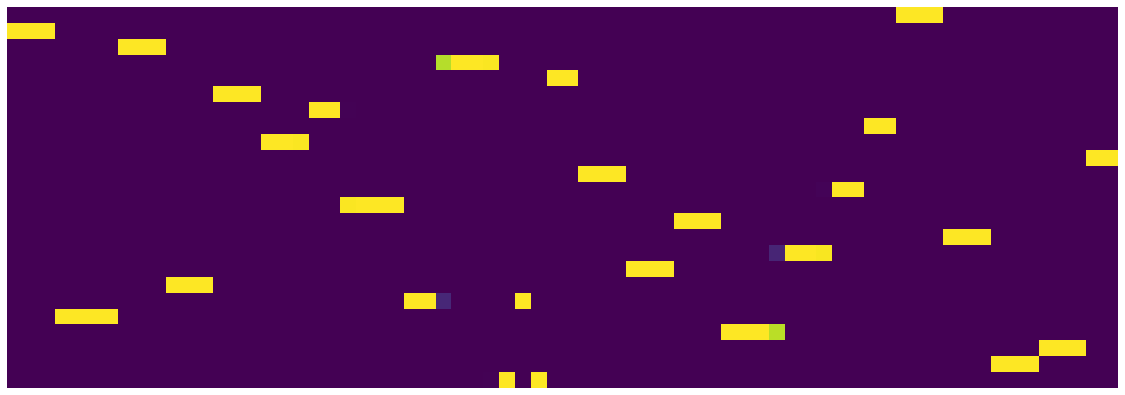

24 478 0.5209999999999996 0.4496806990355253


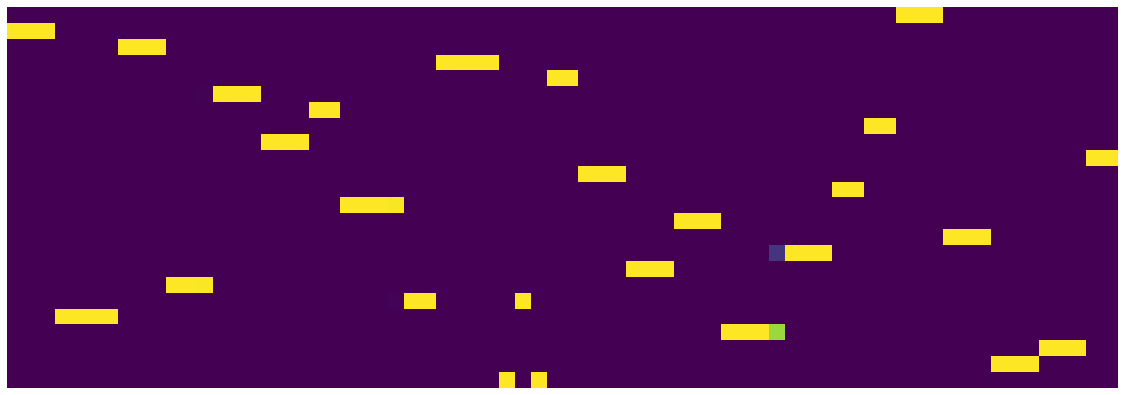

24 479 0.5199999999999996 0.4498847909271717


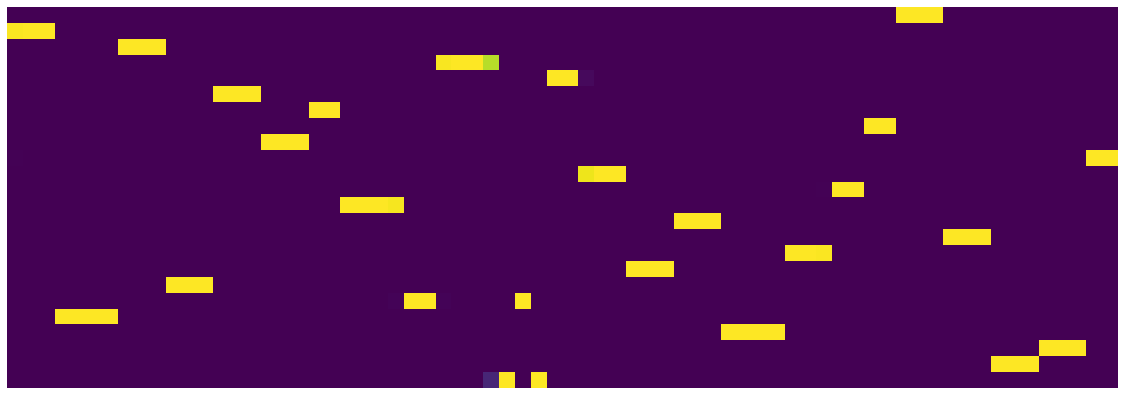

24 480 0.5189999999999996 0.45007224585860967


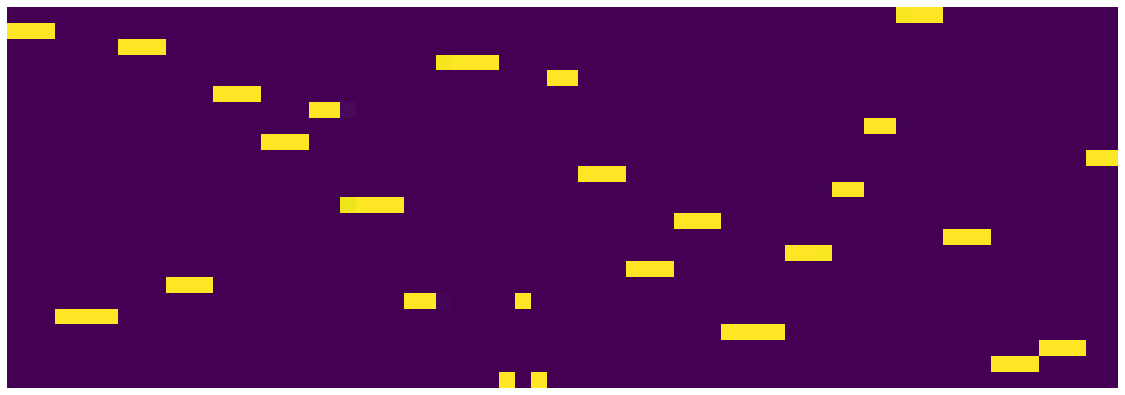

24 481 0.5179999999999996 0.4520672485232353


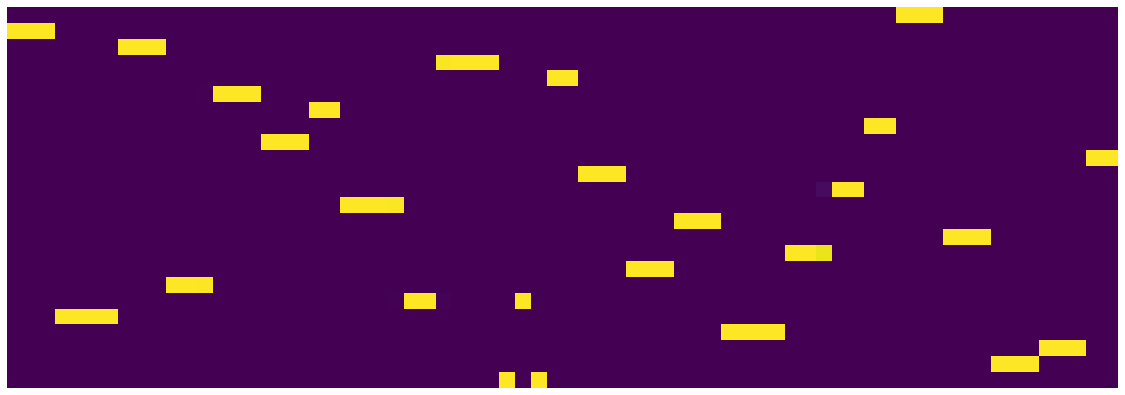

24 482 0.5169999999999996 0.45044969134032725


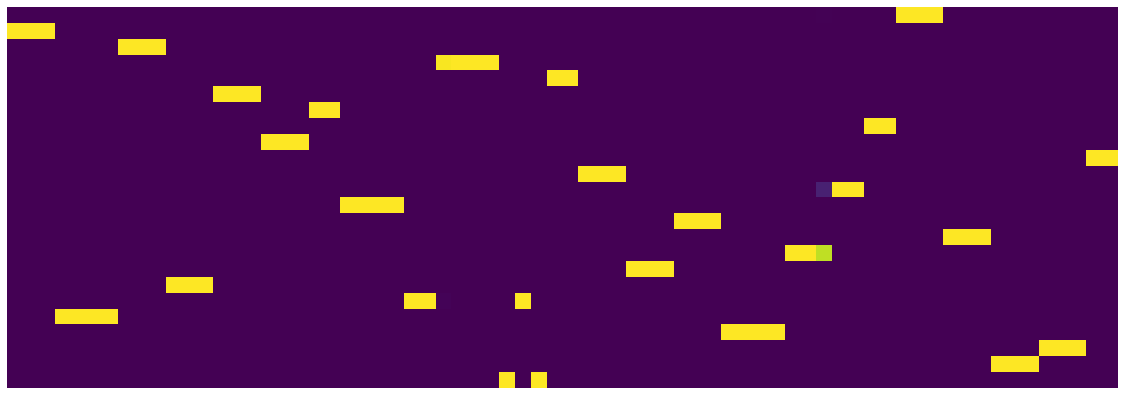

24 483 0.5159999999999996 0.4499407332390547


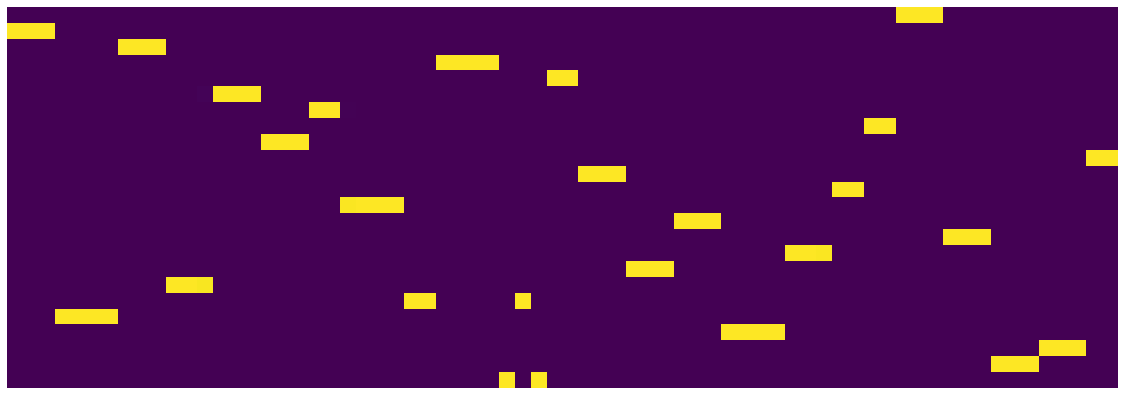

24 484 0.5149999999999996 0.4497698722407222


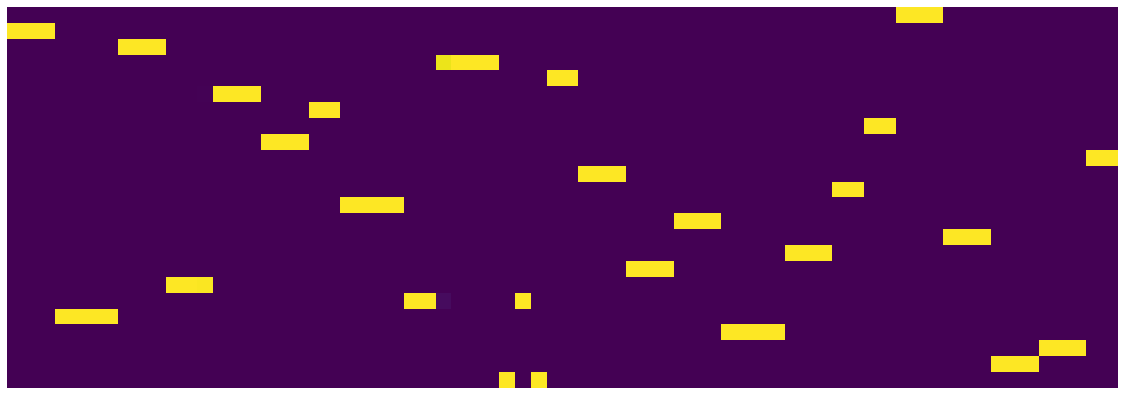

24 485 0.5139999999999996 0.45000951271504164


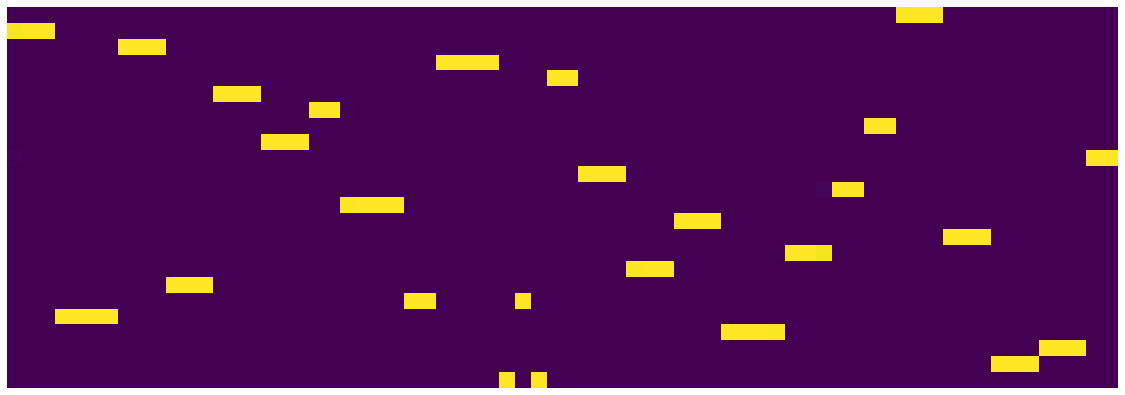

24 486 0.5129999999999996 0.4496804131194949


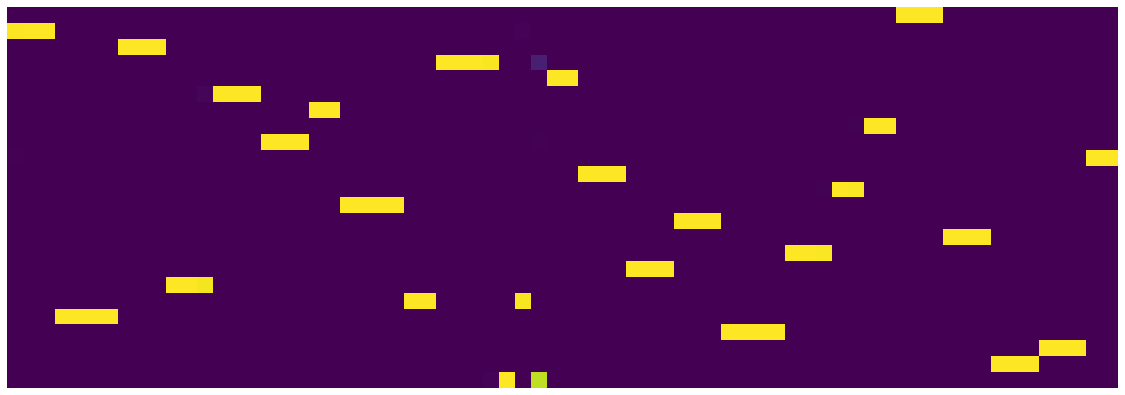

24 487 0.5119999999999996 0.4503550877794623


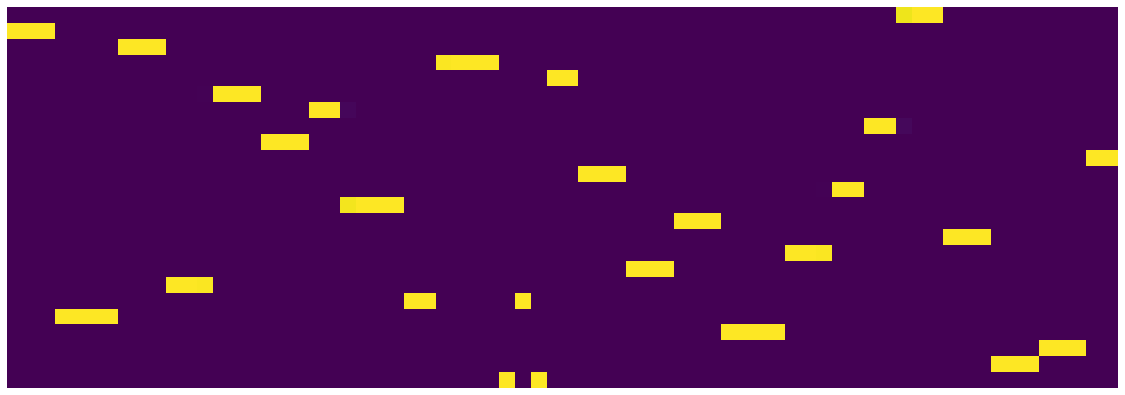

24 488 0.5109999999999996 0.4505760667845607


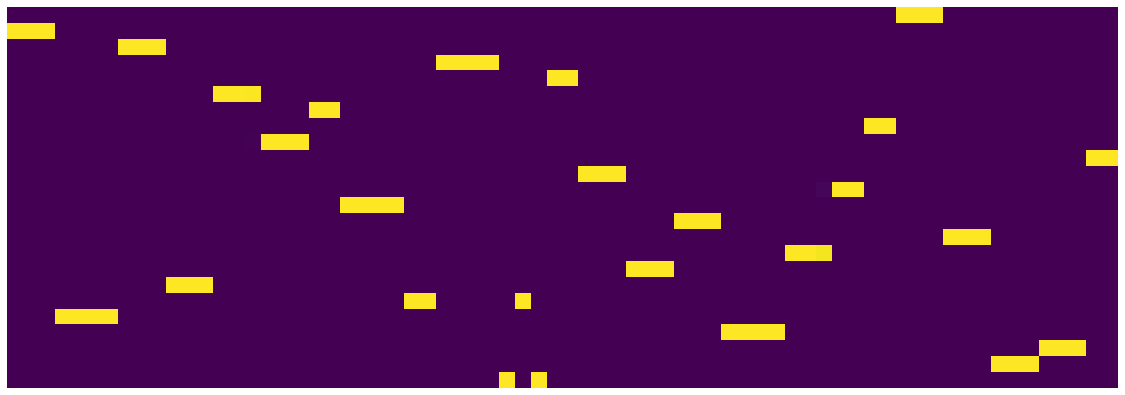

24 489 0.5099999999999996 0.45066287331283095


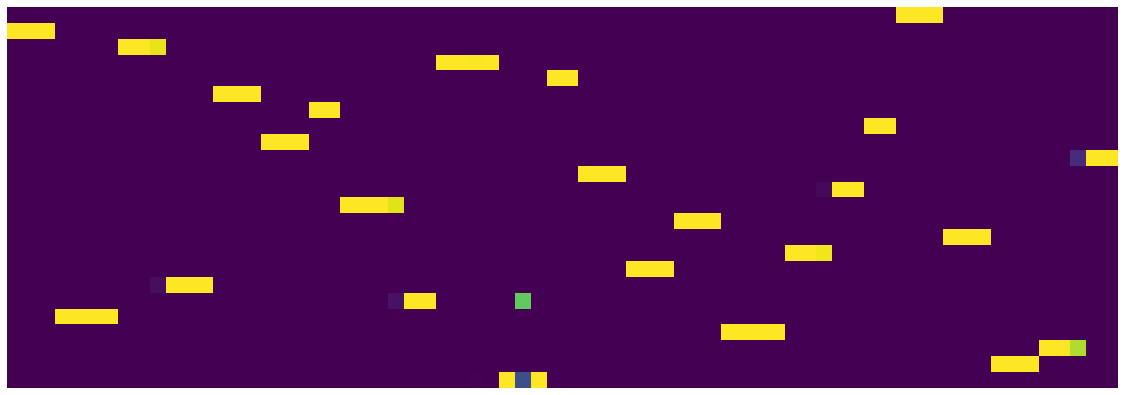

24 490 0.5089999999999996 0.44931985456496476


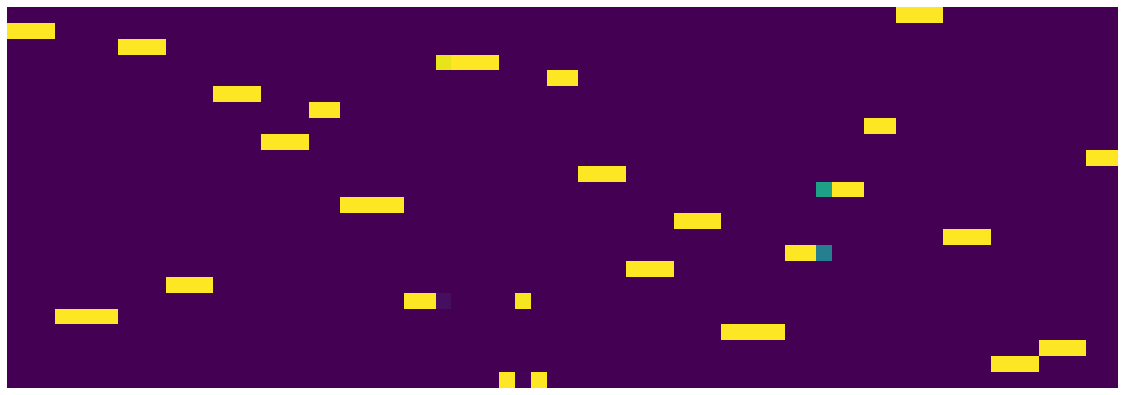

24 491 0.5079999999999996 0.45175209306180475


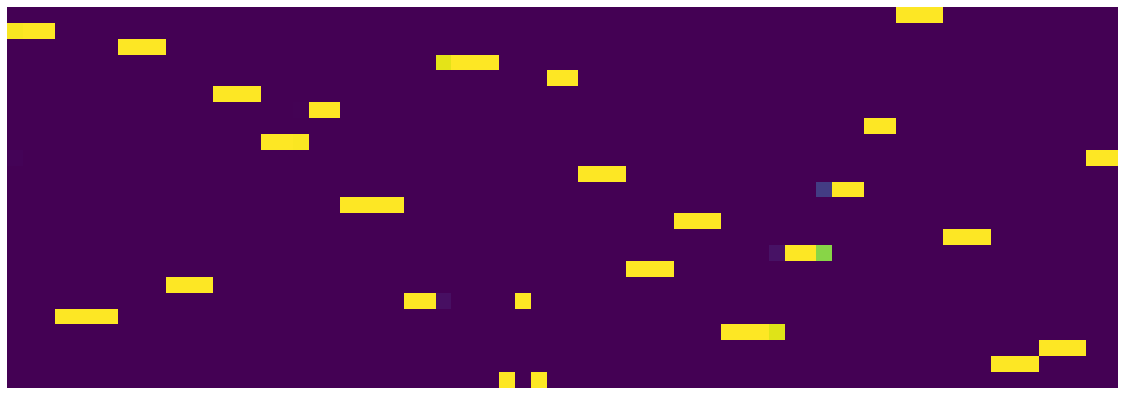

24 492 0.5069999999999996 0.4498493580147624


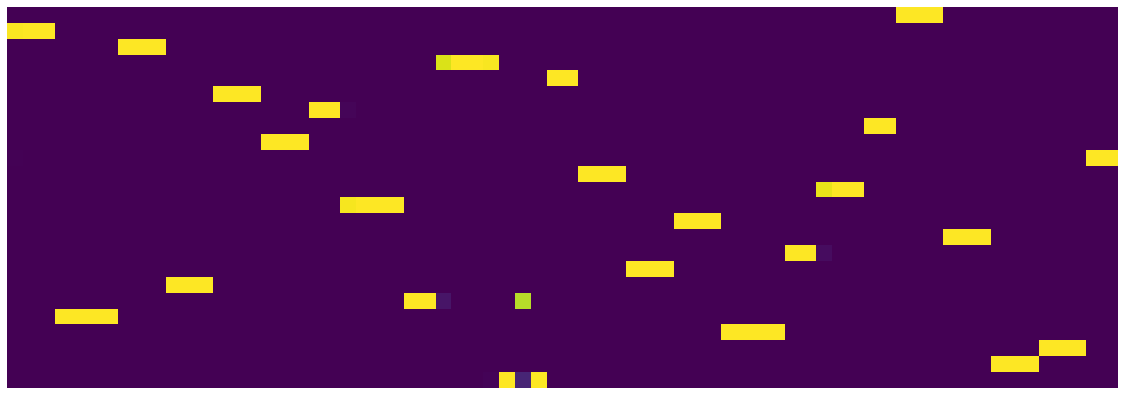

24 493 0.5059999999999996 0.4517835609614849


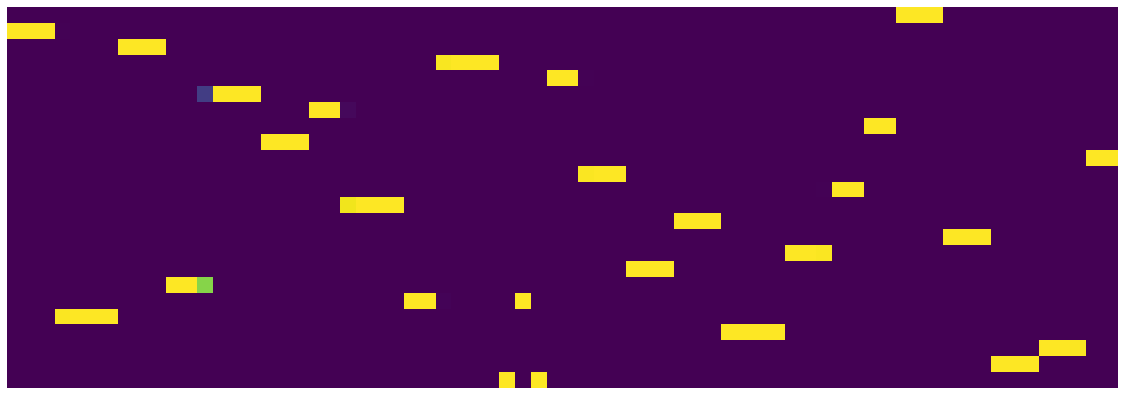

24 494 0.5049999999999996 0.44981283154338597


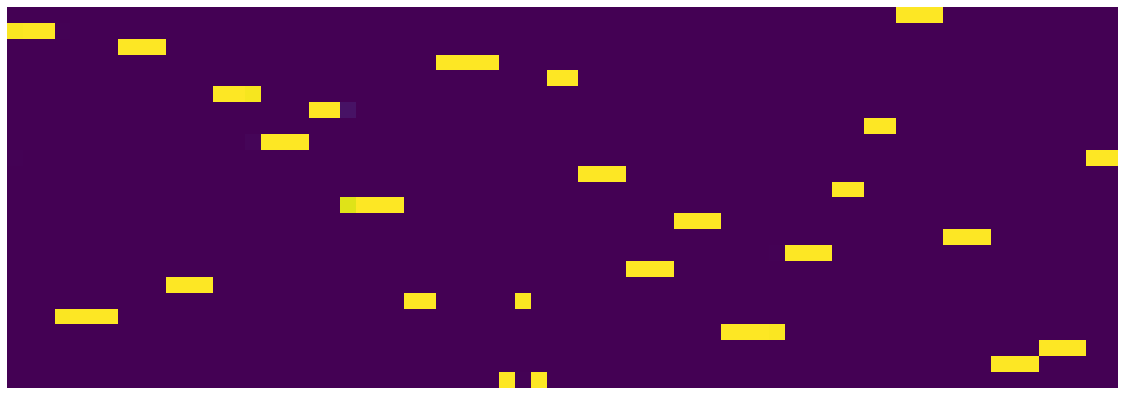

24 495 0.5039999999999996 0.4498069565743208


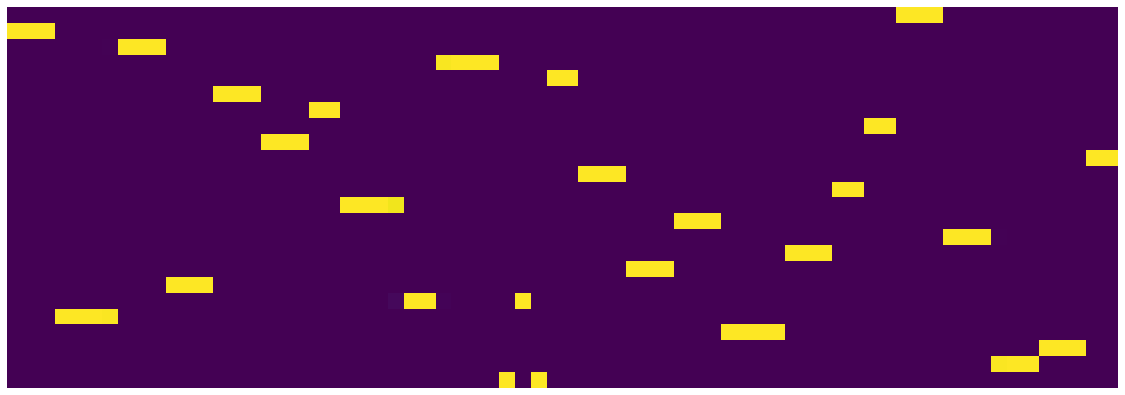

24 496 0.5029999999999996 0.4497569685801864


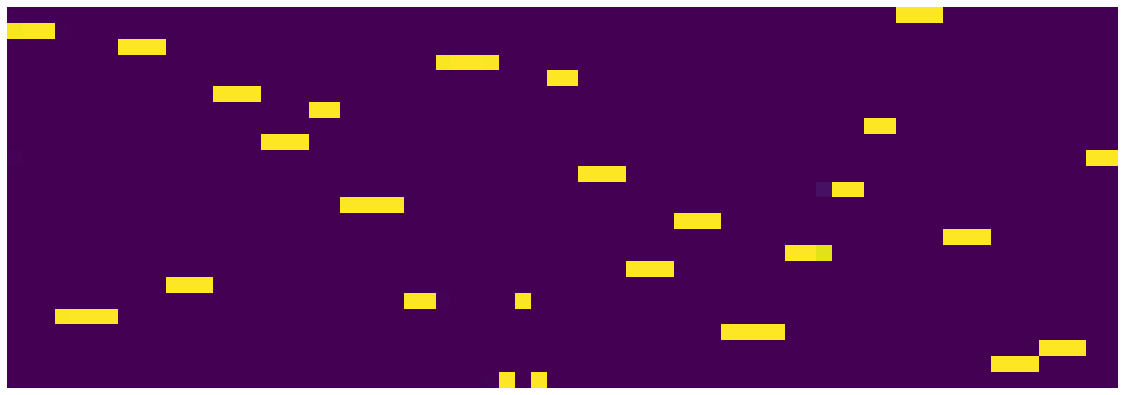

24 497 0.5019999999999996 0.44967041462659835


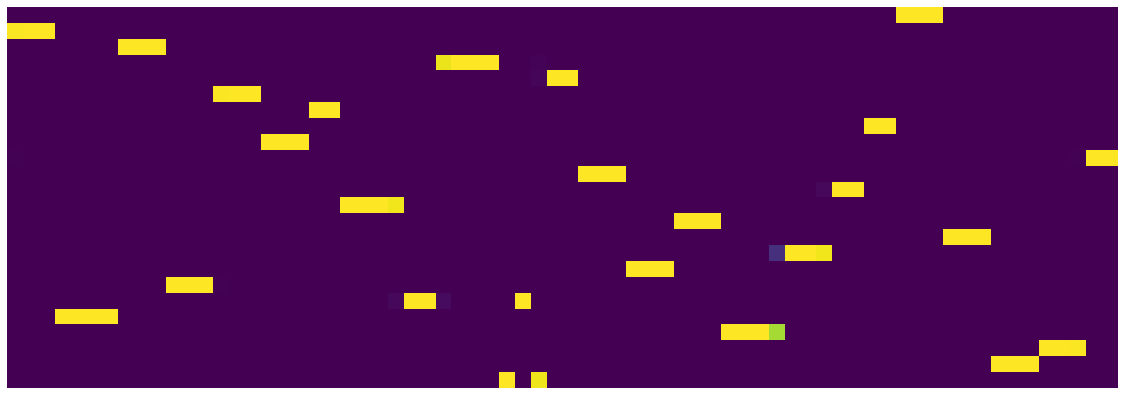

24 498 0.5009999999999996 0.45005867145955564


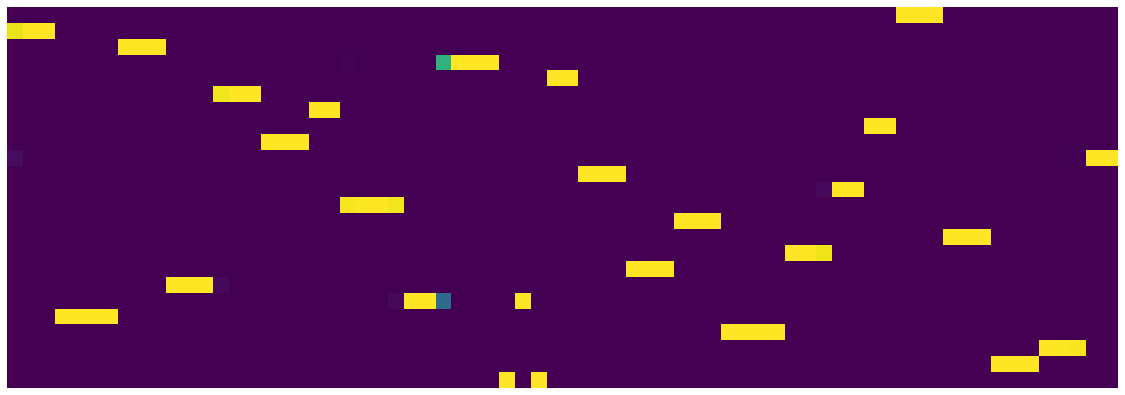

24 499 0.49999999999999956 0.44958349615335463


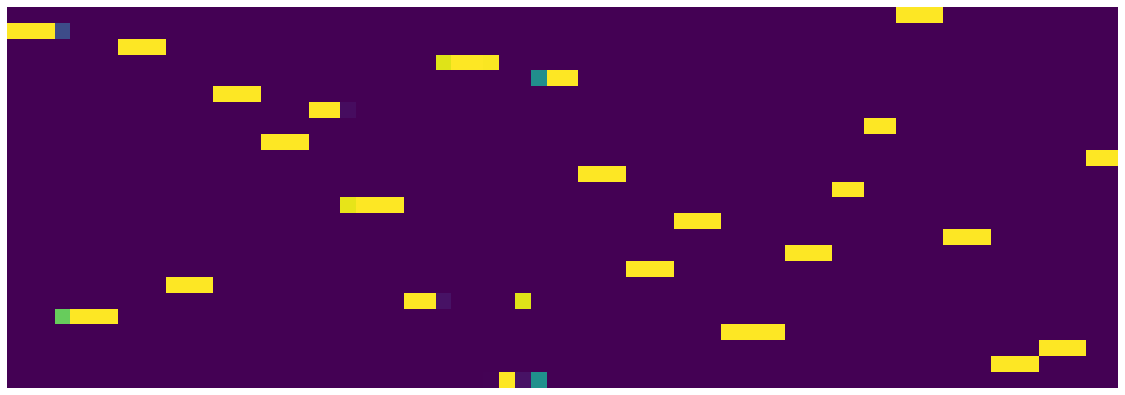

24 500 0.49899999999999956 0.45023103039711715


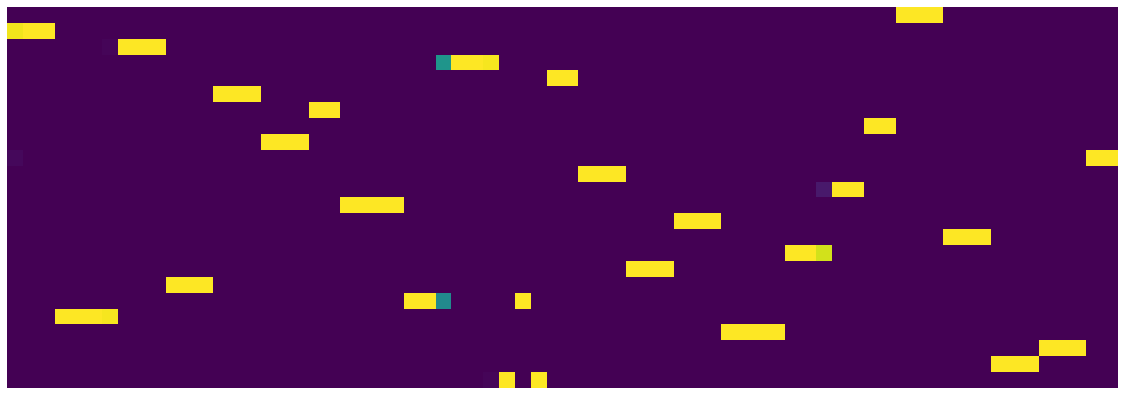

24 501 0.49799999999999955 0.44958333801478145


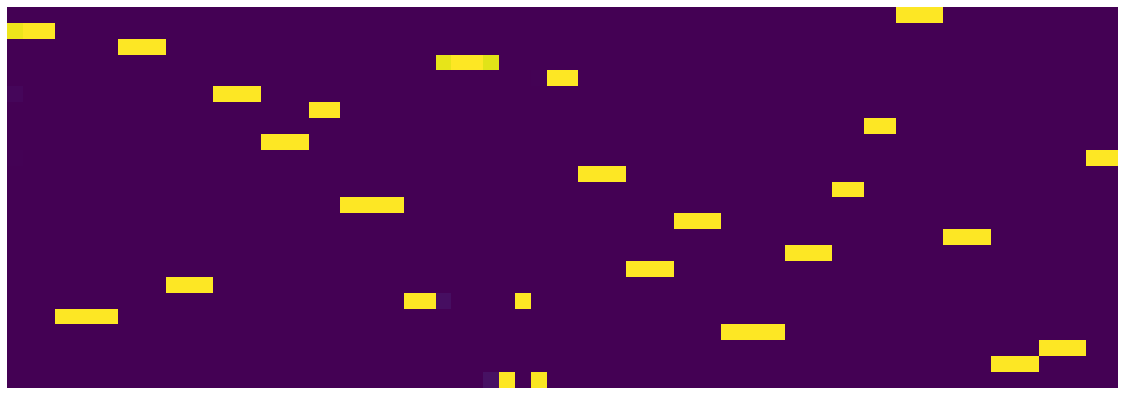

24 502 0.49699999999999955 0.4494720229879022


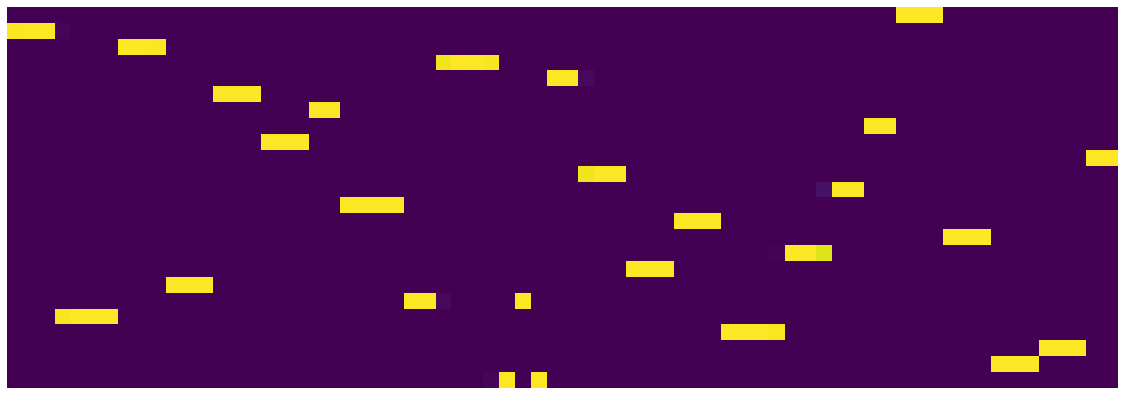

24 503 0.49599999999999955 0.4510091109201312


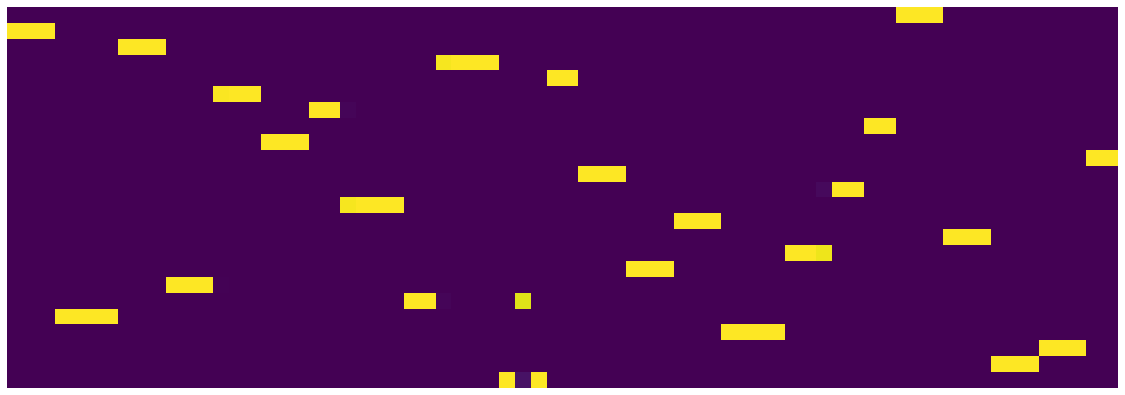

24 504 0.49499999999999955 0.449990613758564


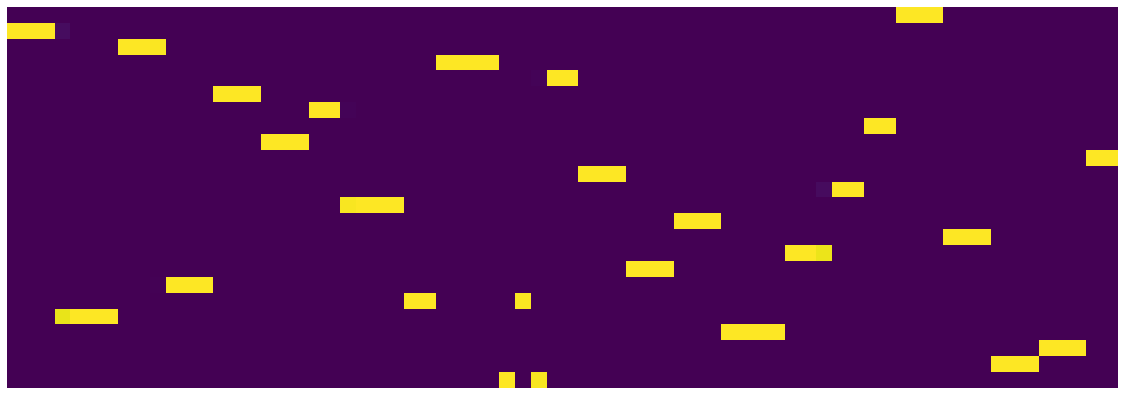

24 505 0.49399999999999955 0.45006621796637775


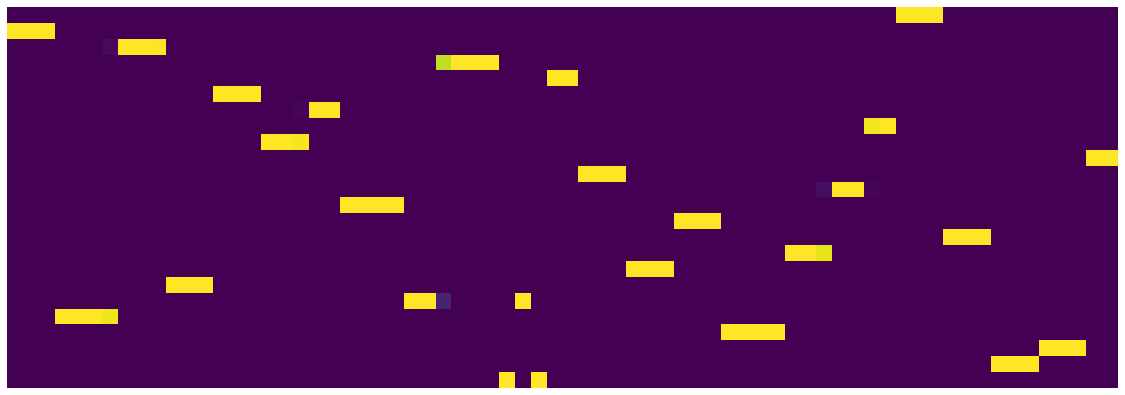

24 506 0.49299999999999955 0.4544366465881467


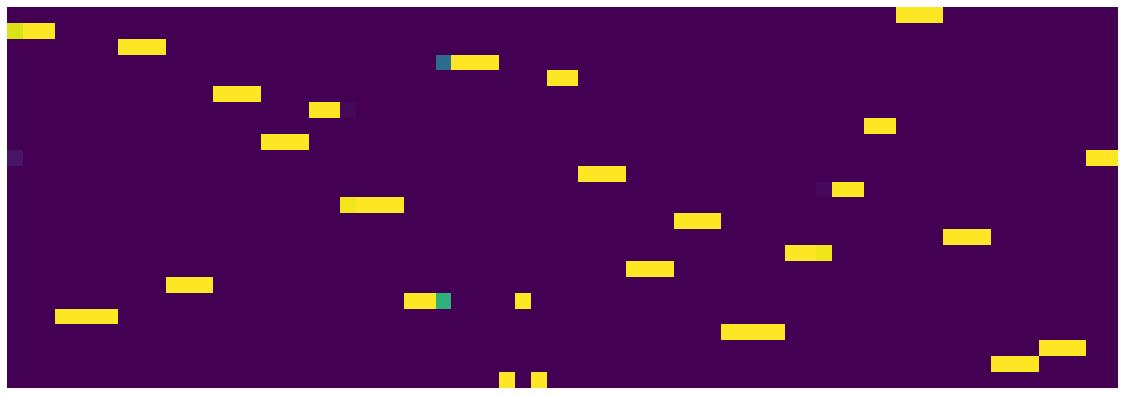

24 507 0.49199999999999955 0.45009548384696246


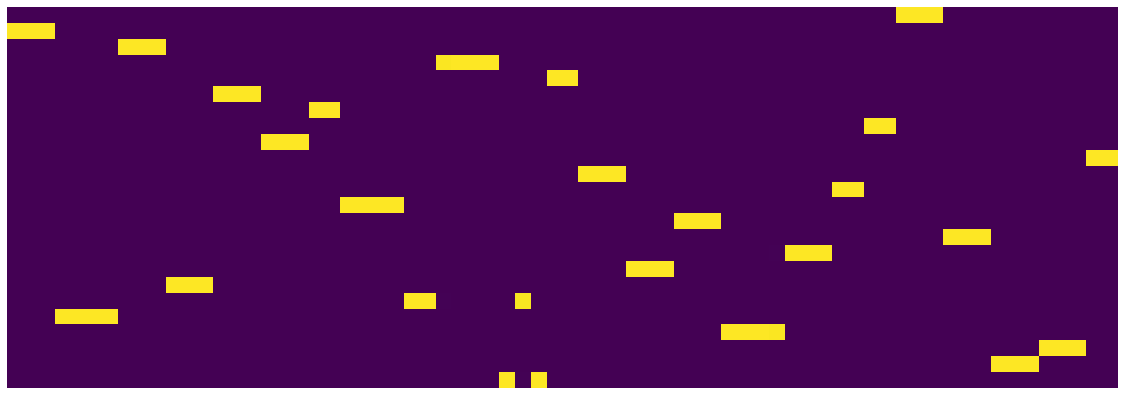

24 508 0.49099999999999955 0.4493985576555133


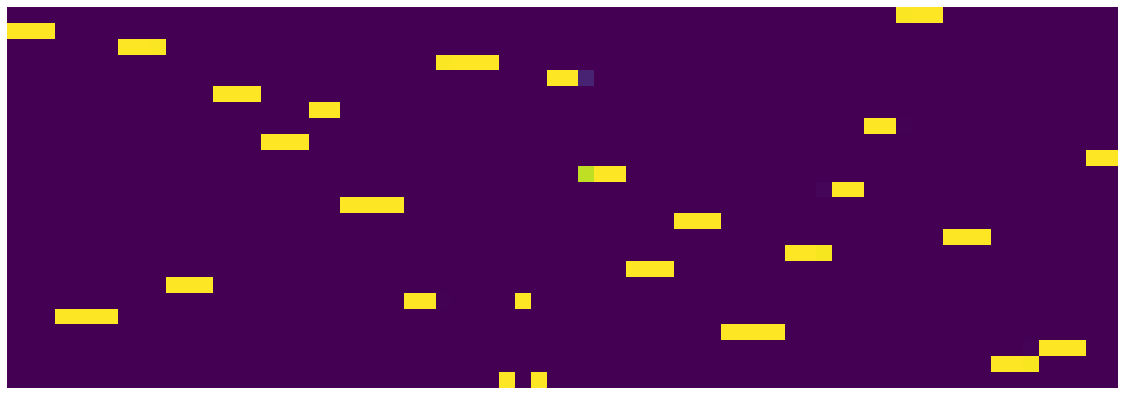

24 509 0.48999999999999955 0.44948067236691713


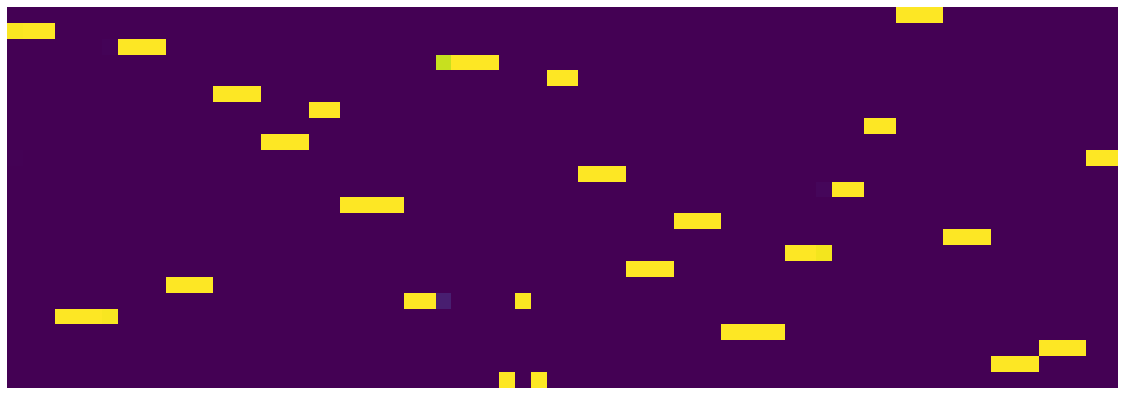

24 510 0.48899999999999955 0.4500132597982883


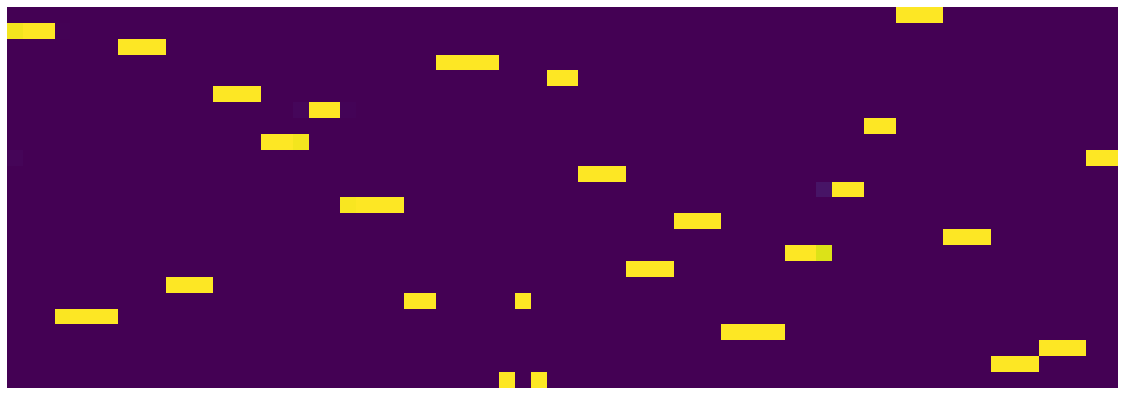

24 511 0.48799999999999955 0.45017609260976316


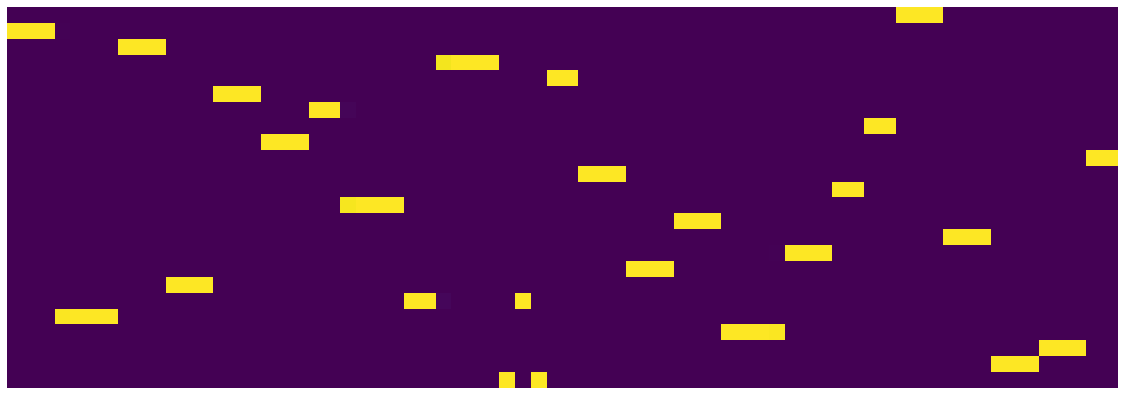

24 512 0.48699999999999954 0.4501571603119373


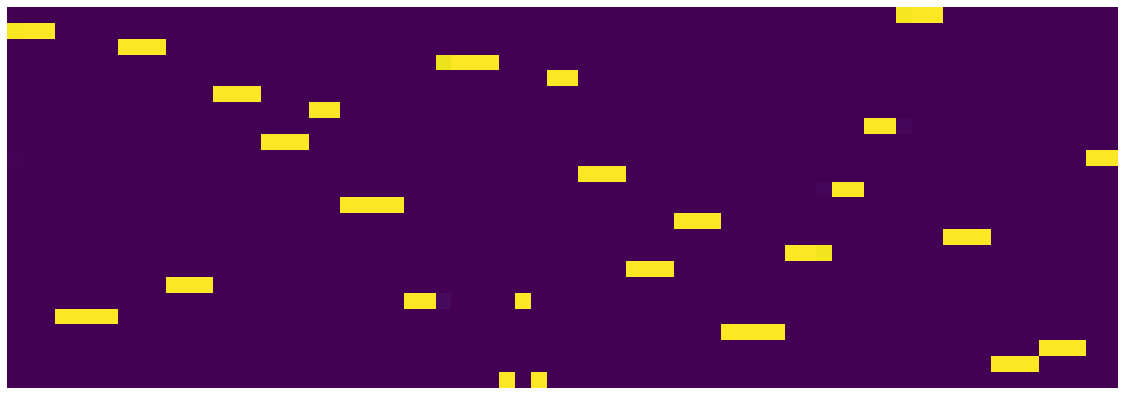

24 513 0.48599999999999954 0.4503225516527891


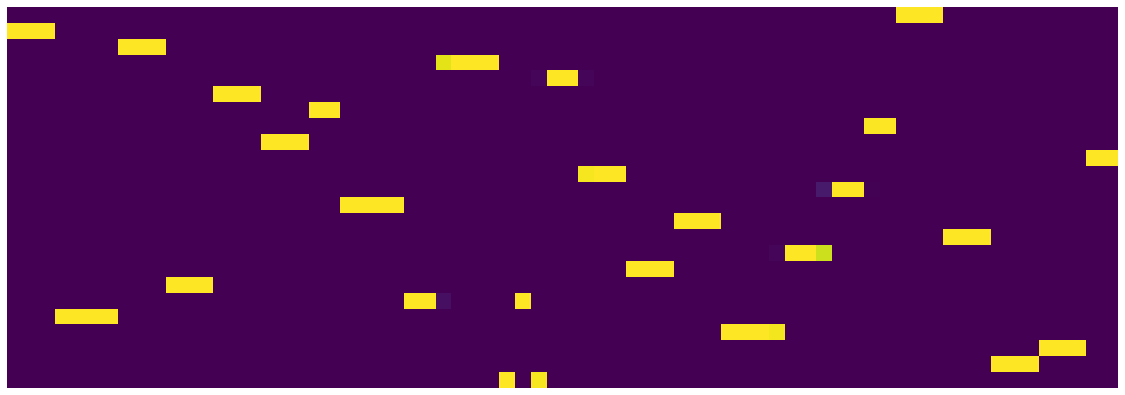

24 514 0.48499999999999954 0.44998931903392075


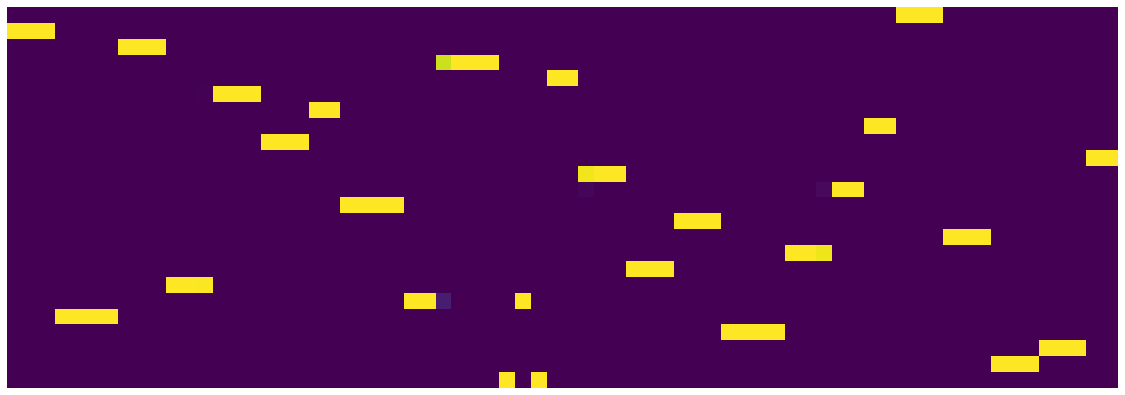

24 515 0.48399999999999954 0.45003092885017393


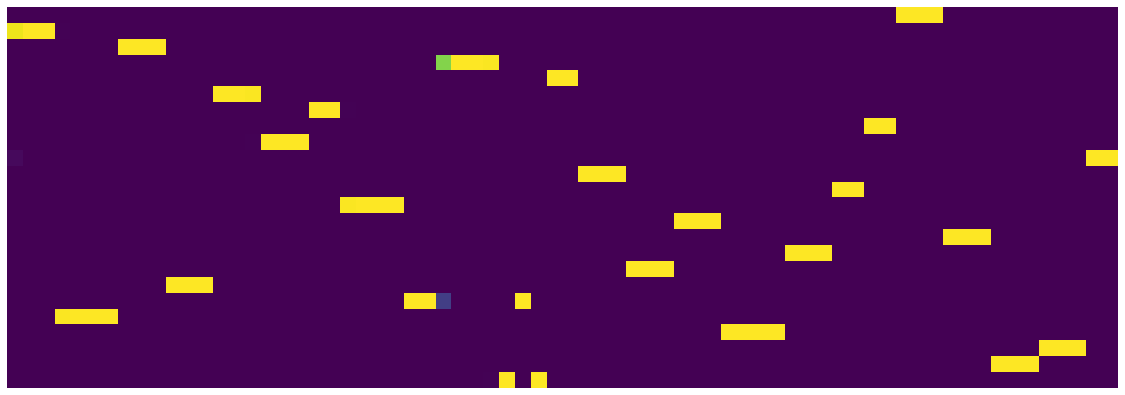

24 516 0.48299999999999954 0.449841695651412


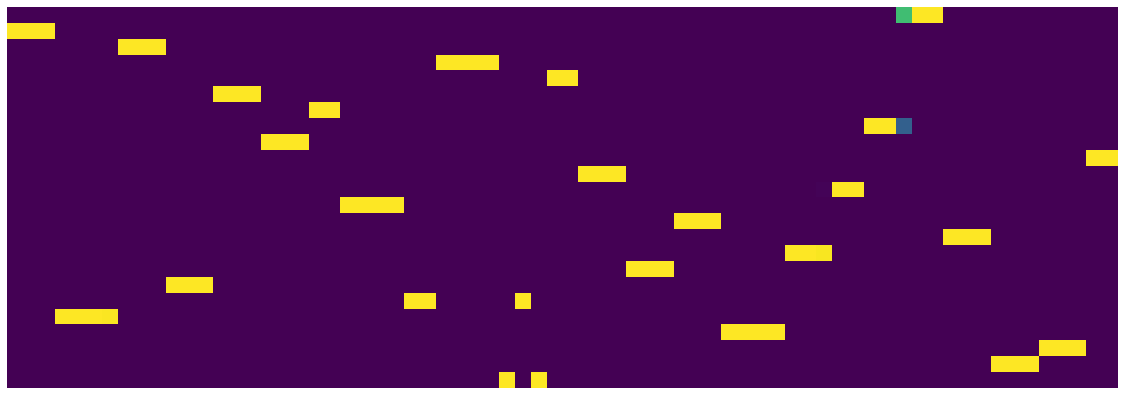

24 517 0.48199999999999954 0.4502174200490117


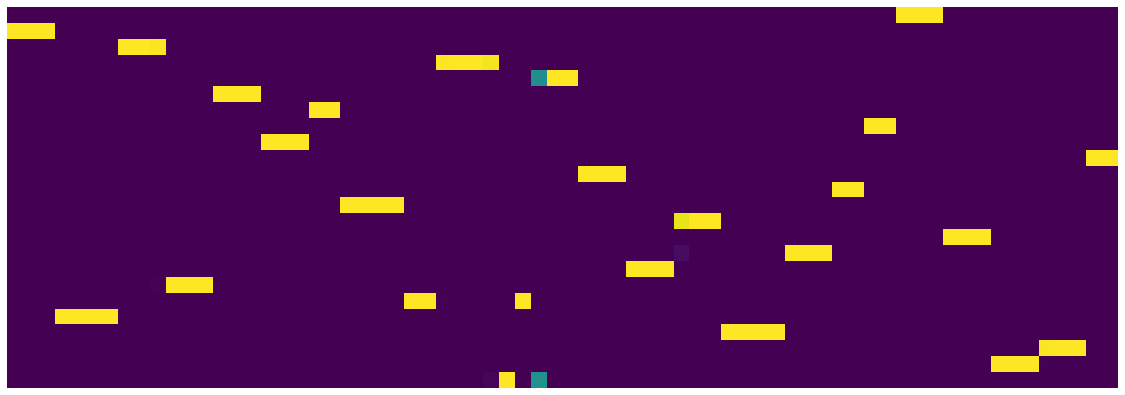

24 518 0.48099999999999954 0.4499023353680968


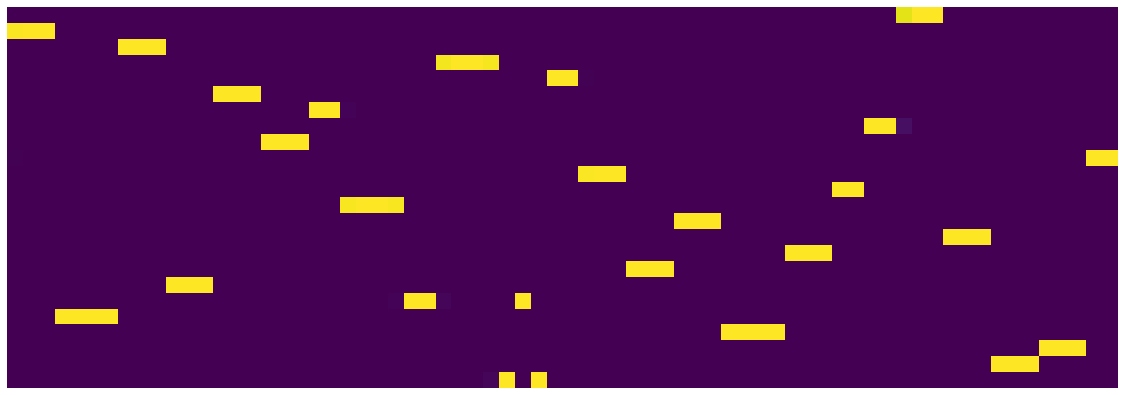

24 519 0.47999999999999954 0.4509610295295715


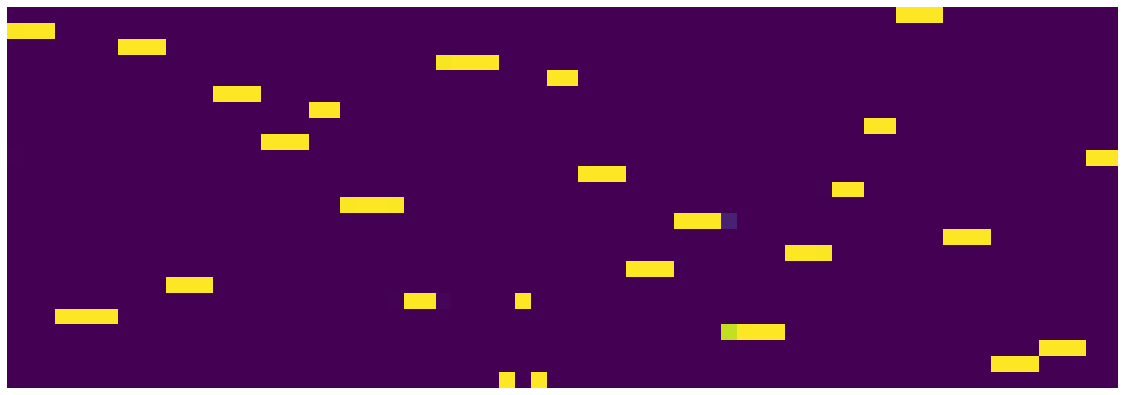

24 520 0.47899999999999954 0.45006061661988495


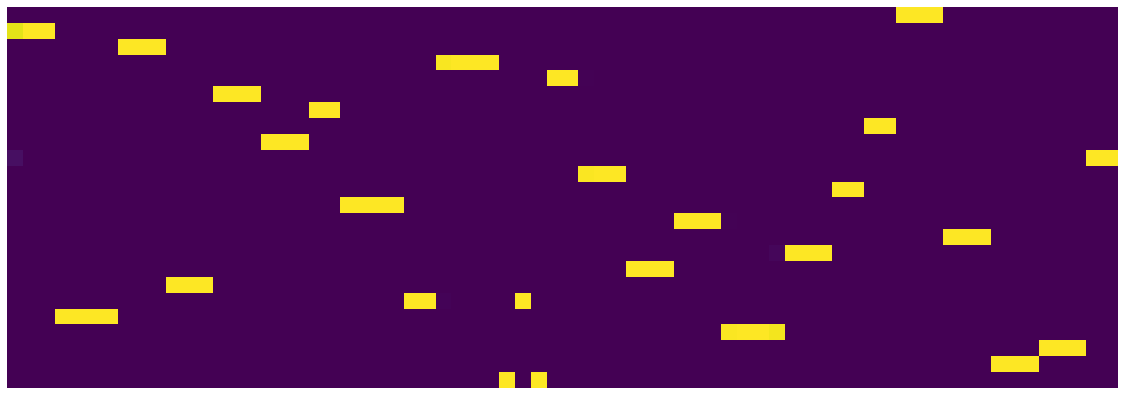

24 521 0.47799999999999954 0.4504336427897215


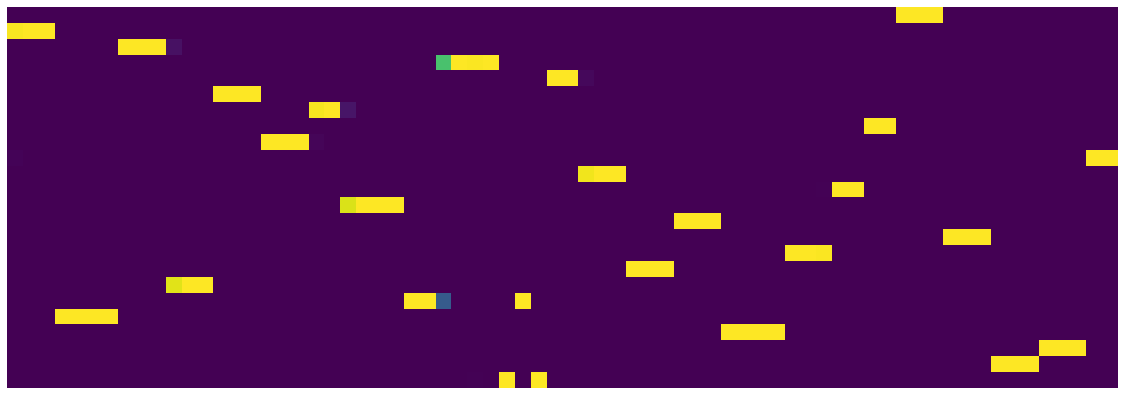

24 522 0.47699999999999954 0.4517071506008506


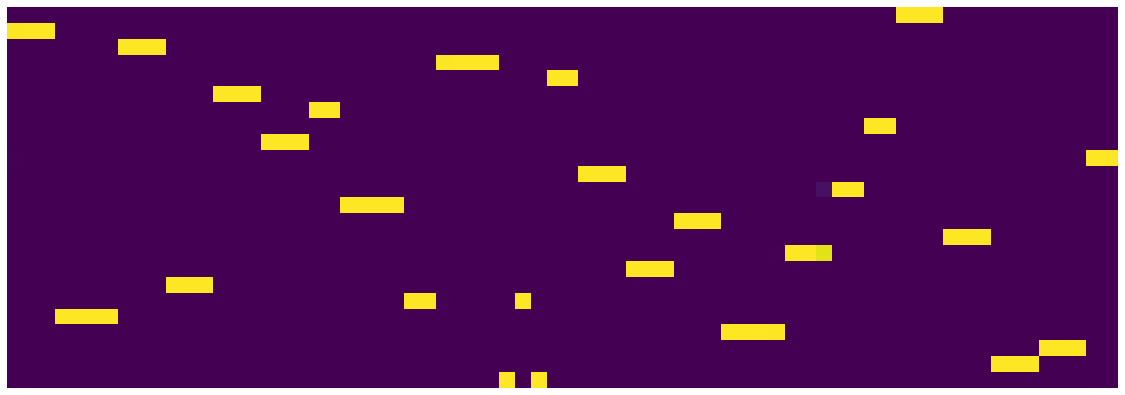

24 523 0.47599999999999953 0.45001709572970866


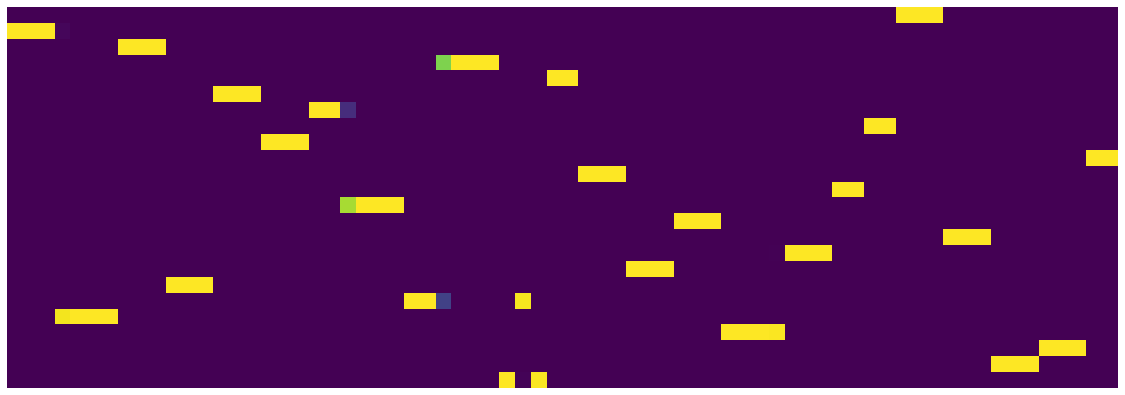

24 524 0.47499999999999953 0.44975096378475427


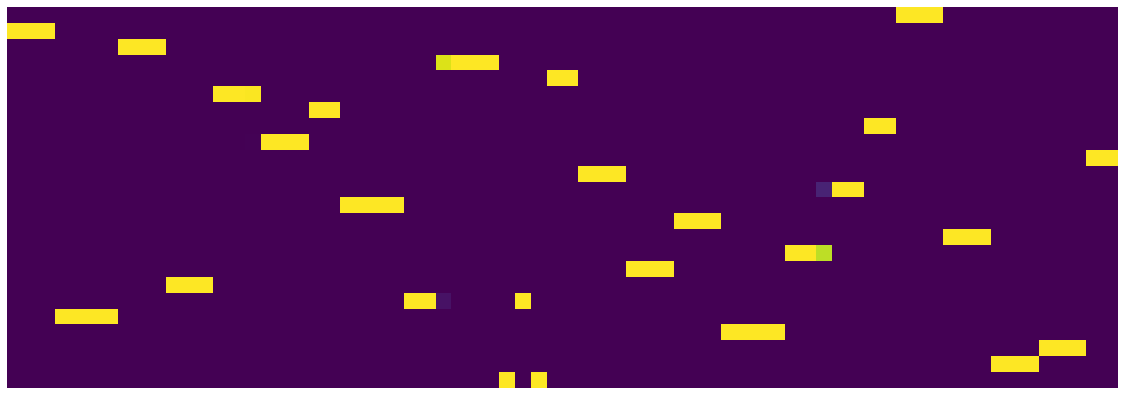

24 525 0.47399999999999953 0.4501792903989553


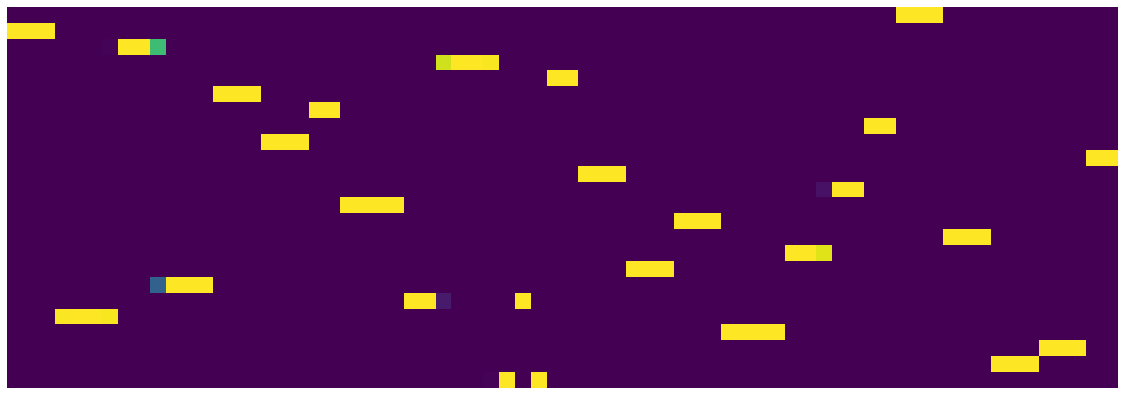

24 526 0.47299999999999953 0.45113975182175636


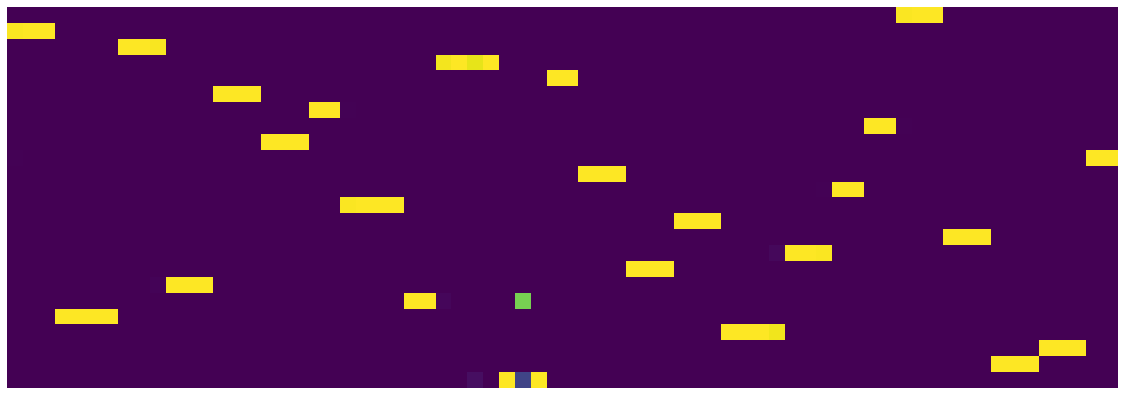

24 527 0.47199999999999953 0.44962005522102116


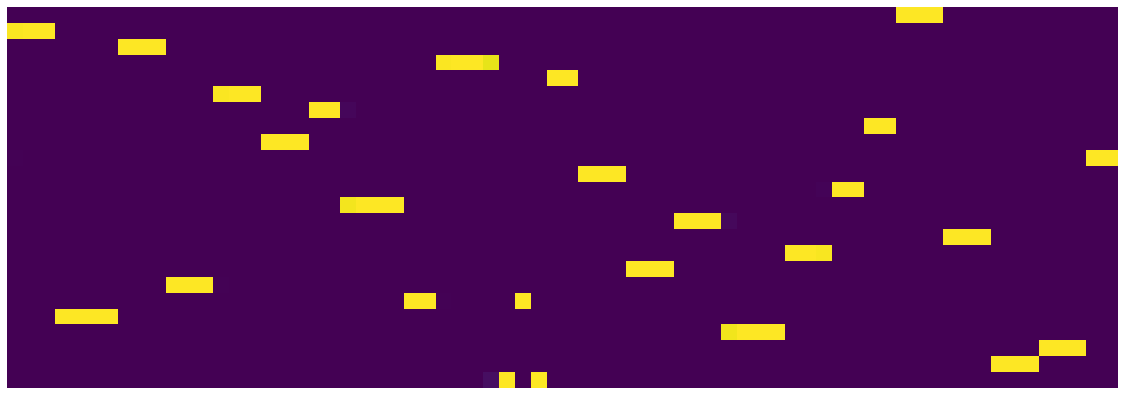

24 528 0.47099999999999953 0.4504668051376939


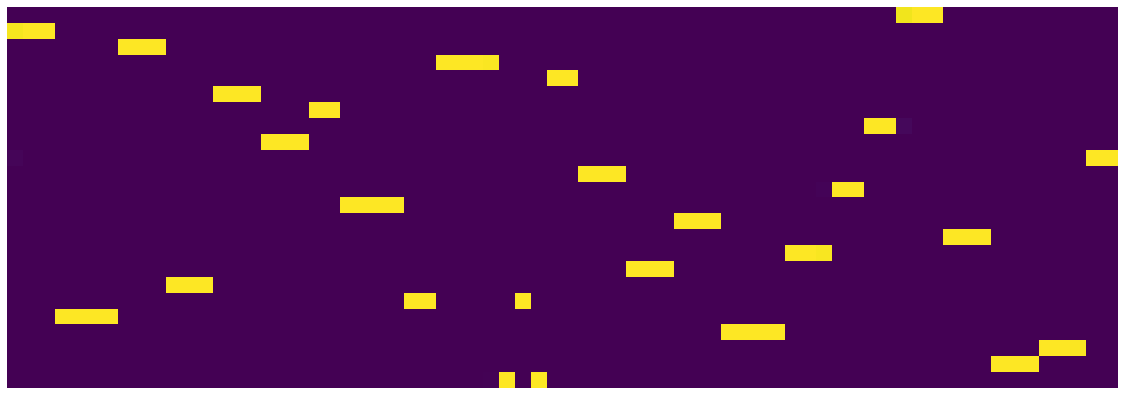

24 529 0.46999999999999953 0.4525373471900821


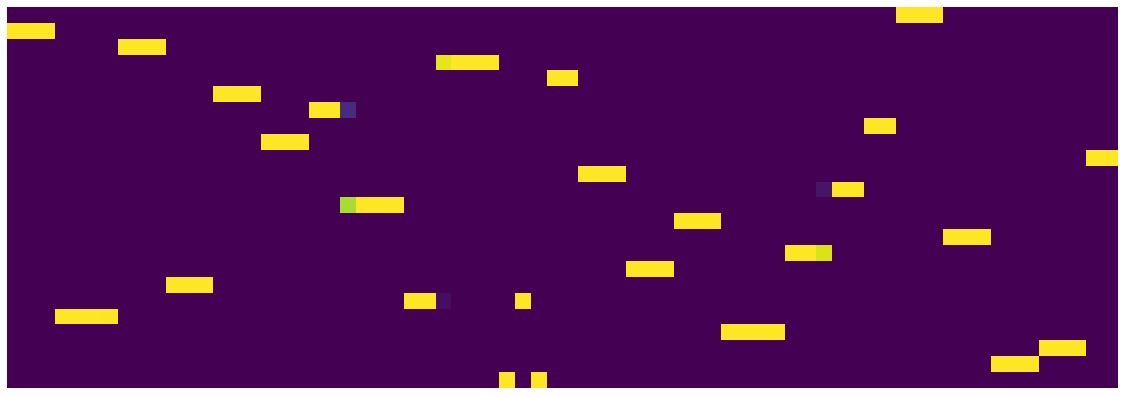

24 530 0.46899999999999953 0.44923919085413216


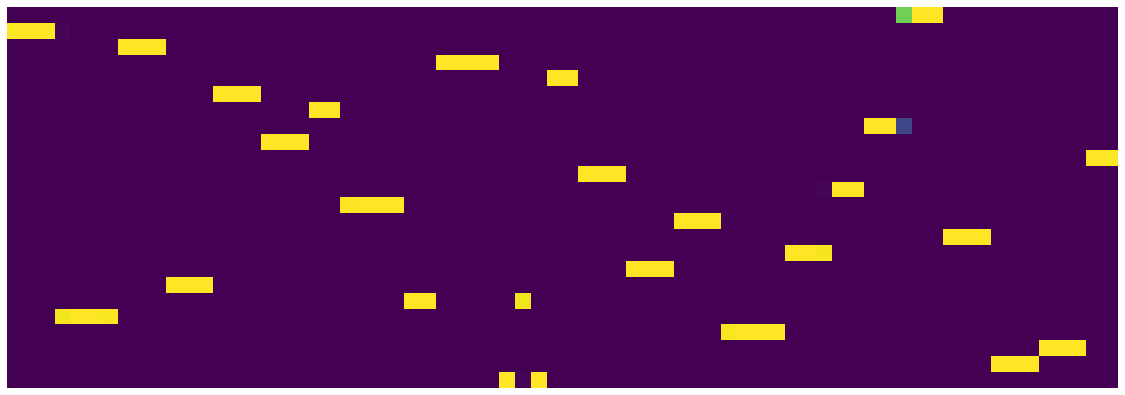

24 531 0.4679999999999995 0.45027106143534185


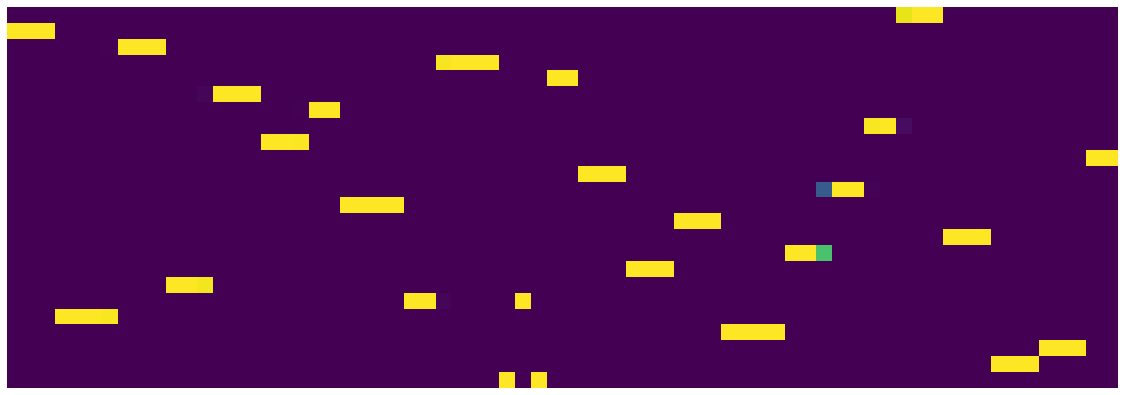

24 532 0.4669999999999995 0.45078748688101766


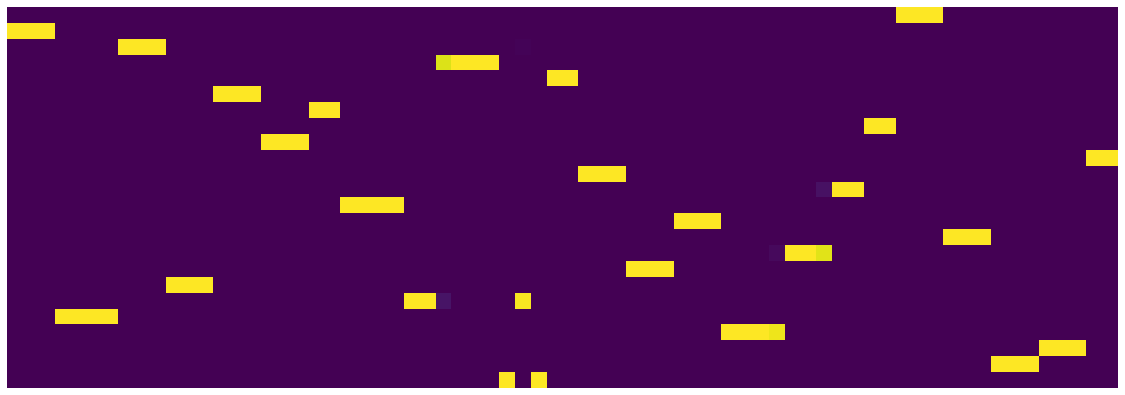

24 533 0.4659999999999995 0.44926719181239605


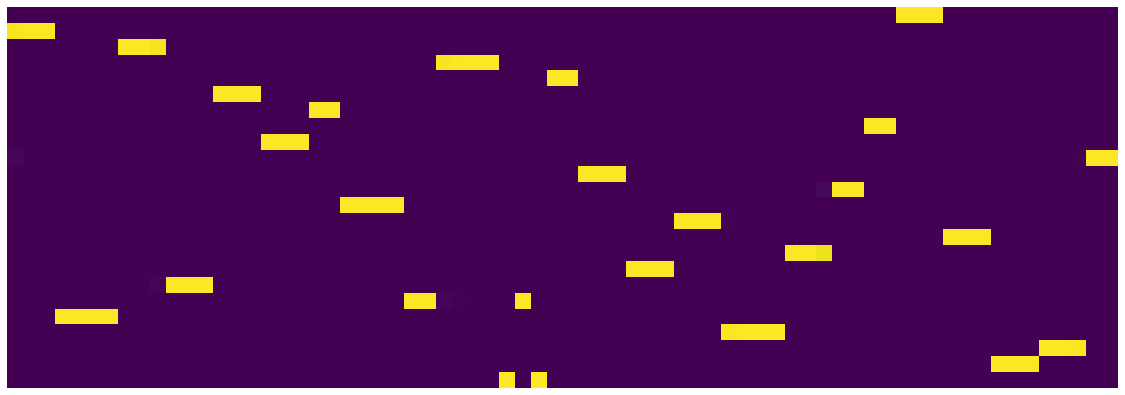

24 534 0.4649999999999995 0.4500911347568035


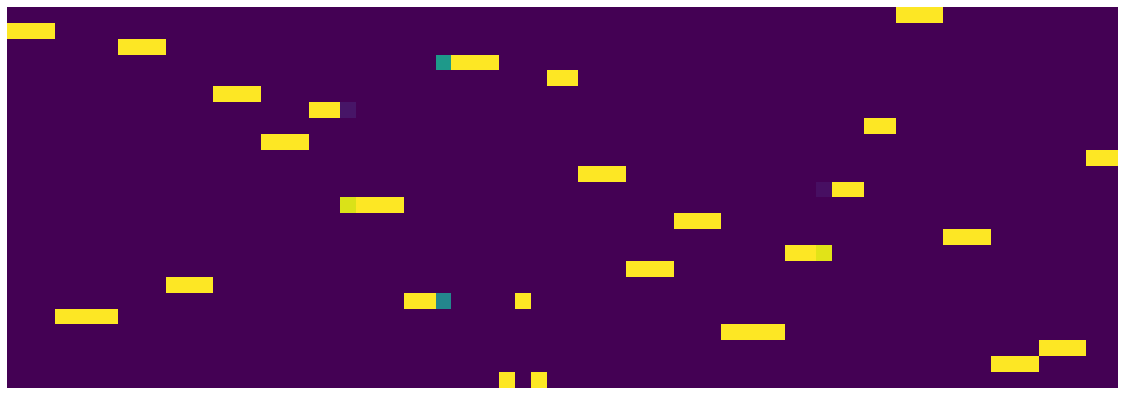

24 535 0.4639999999999995 0.45039603374898435


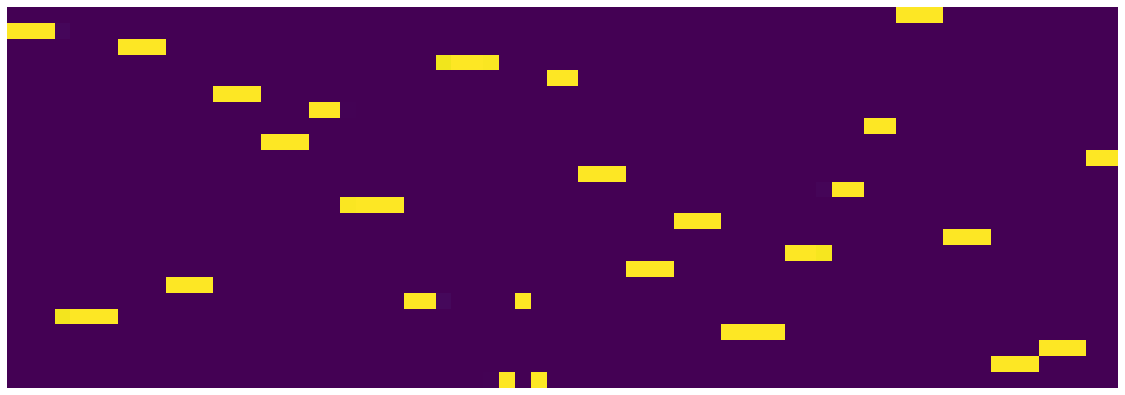

24 536 0.4629999999999995 0.44993793237954377


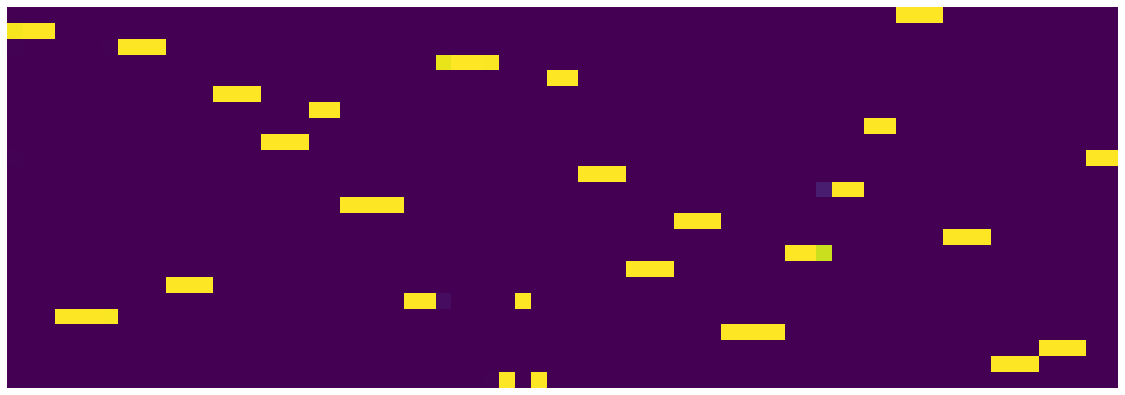

24 537 0.4619999999999995 0.449524337798357


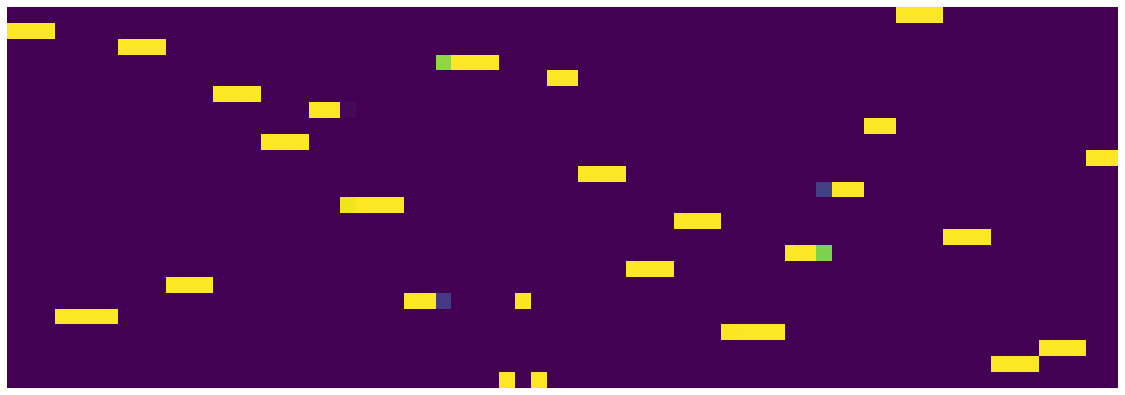

24 538 0.4609999999999995 0.44965177625417707


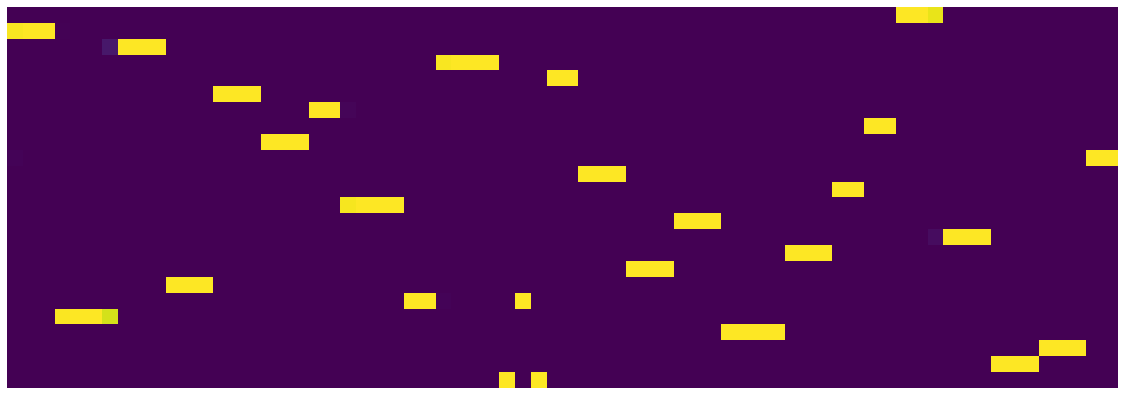

24 539 0.4599999999999995 0.4498094780370593


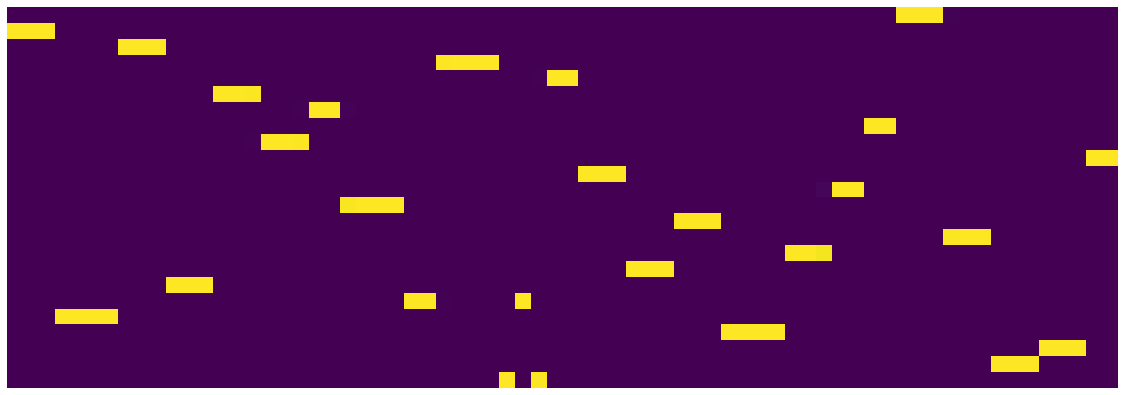

24 540 0.4589999999999995 0.44967755004763604


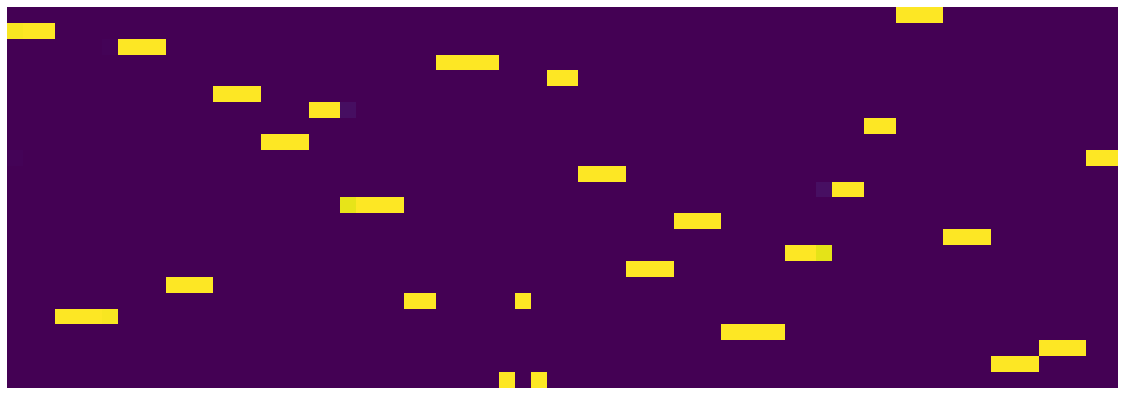

24 541 0.4579999999999995 0.4503385081887245


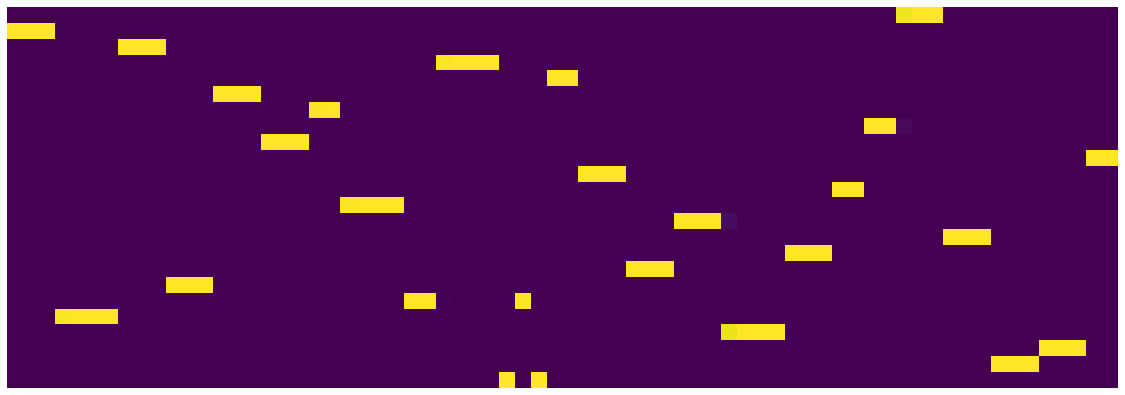

24 542 0.4569999999999995 0.4503192473202944


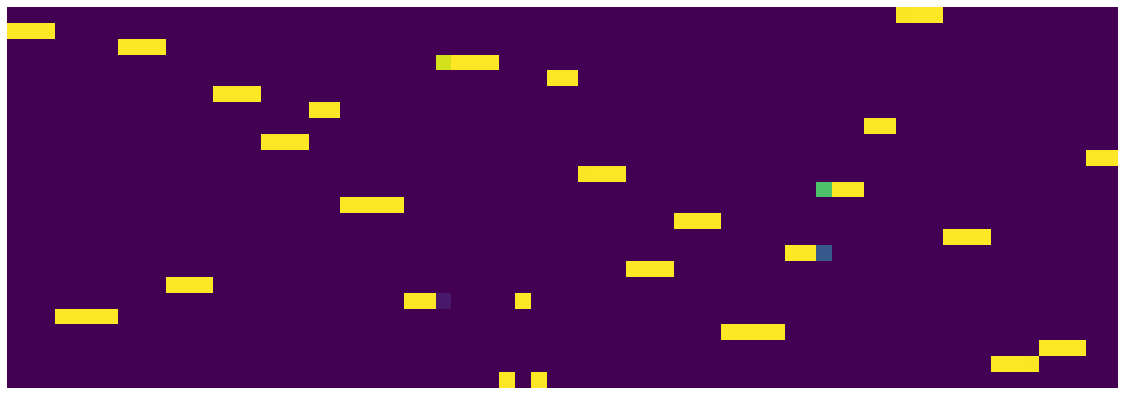

24 543 0.4559999999999995 0.45189177729189395


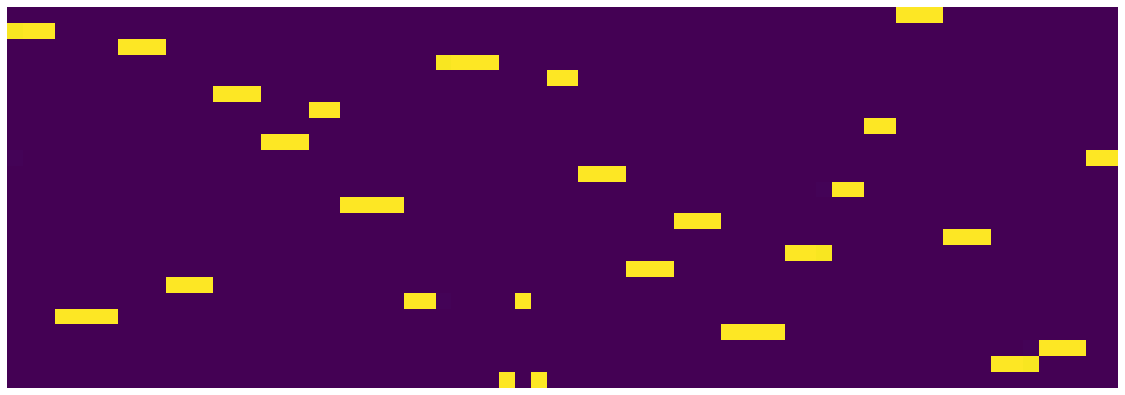

24 544 0.4549999999999995 0.44992251209914685


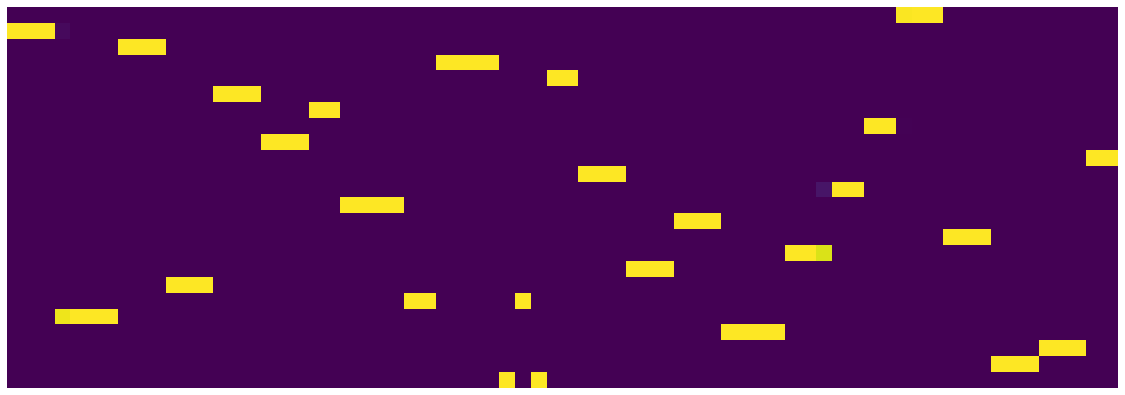

24 545 0.4539999999999995 0.4505692347884178


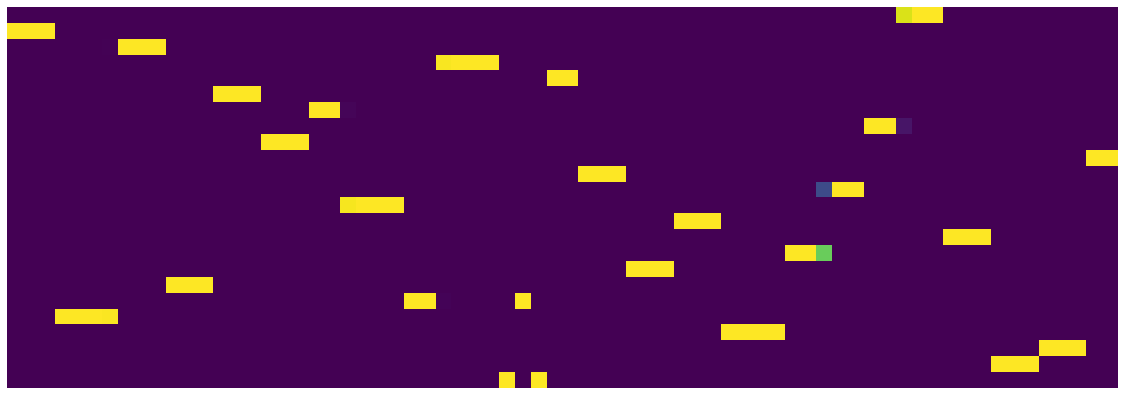

24 546 0.4529999999999995 0.45026090610772374


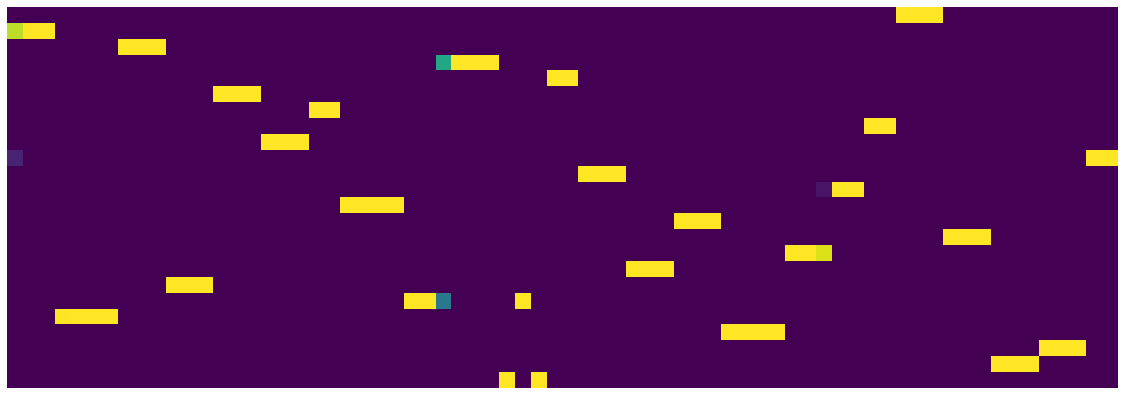

24 547 0.4519999999999995 0.44994633477181195


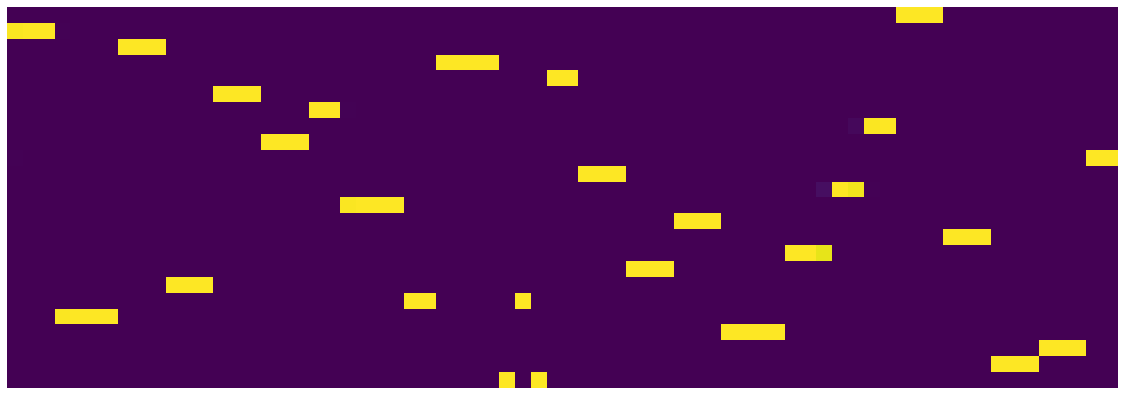

24 548 0.4509999999999995 0.4526894012466073


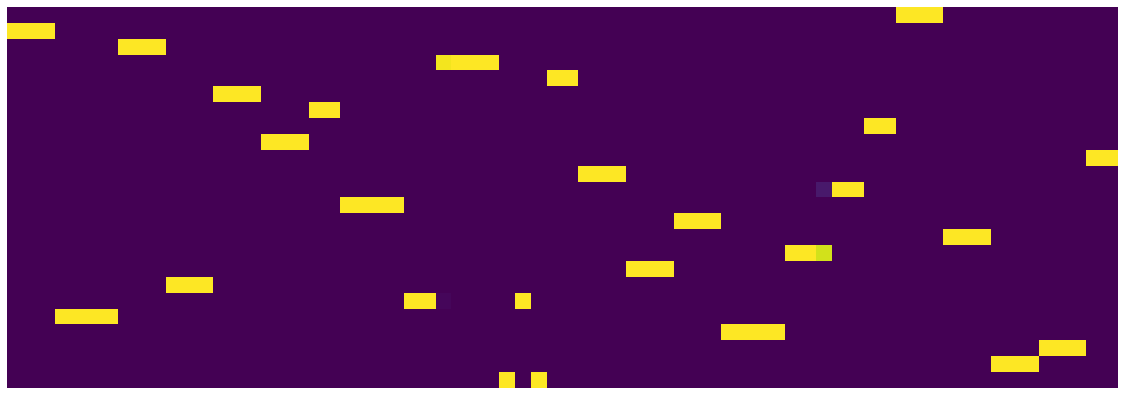

24 549 0.4499999999999995 0.4499752776697278


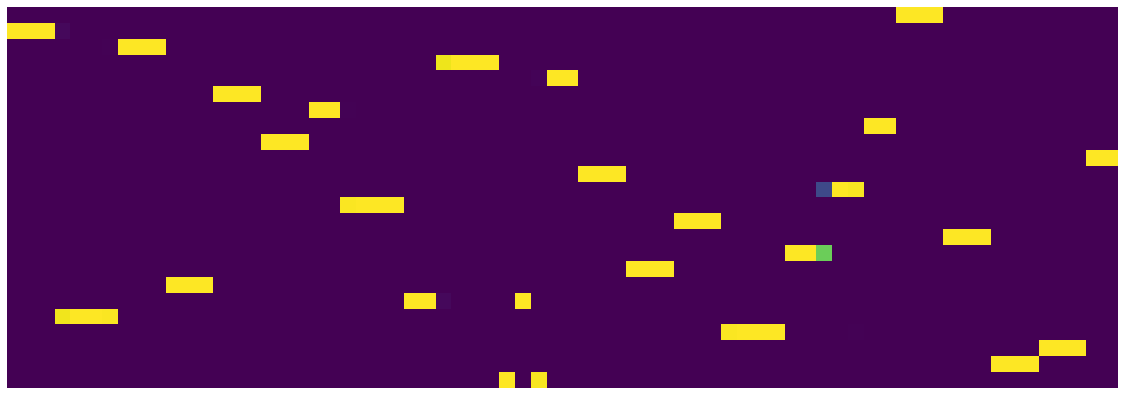

24 550 0.4489999999999995 0.4504382863640785


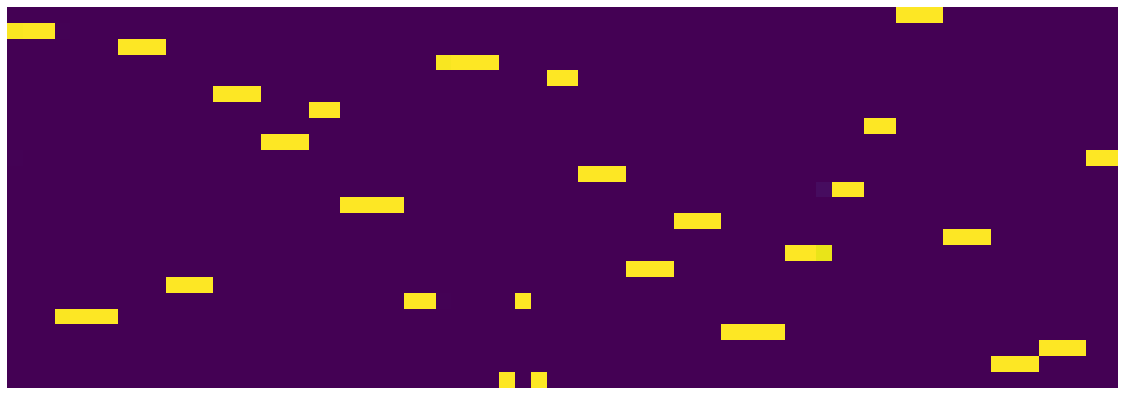

24 551 0.4479999999999995 0.45006509851664306


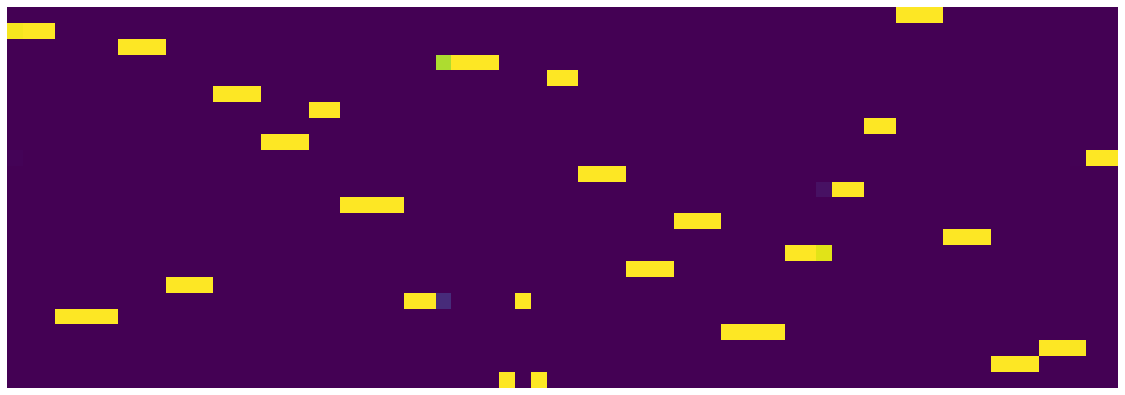

24 552 0.4469999999999995 0.45032095555216073


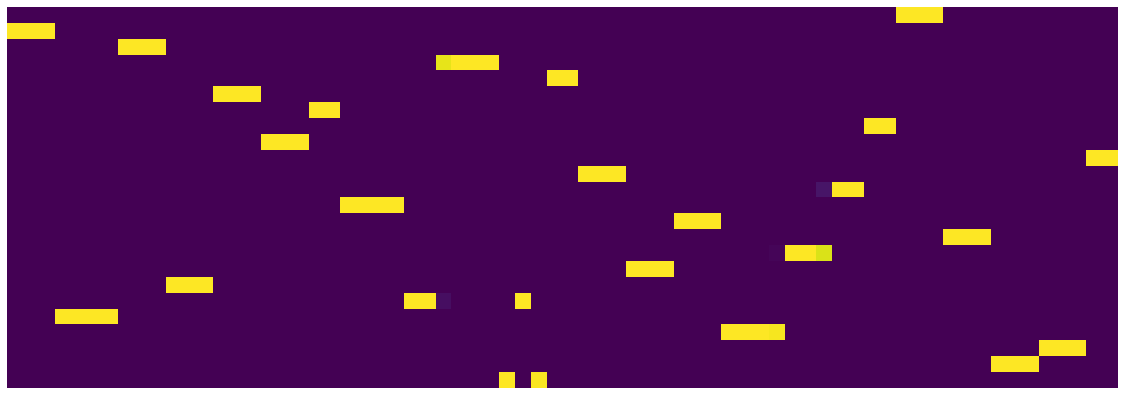

24 553 0.4459999999999995 0.4495485071092844


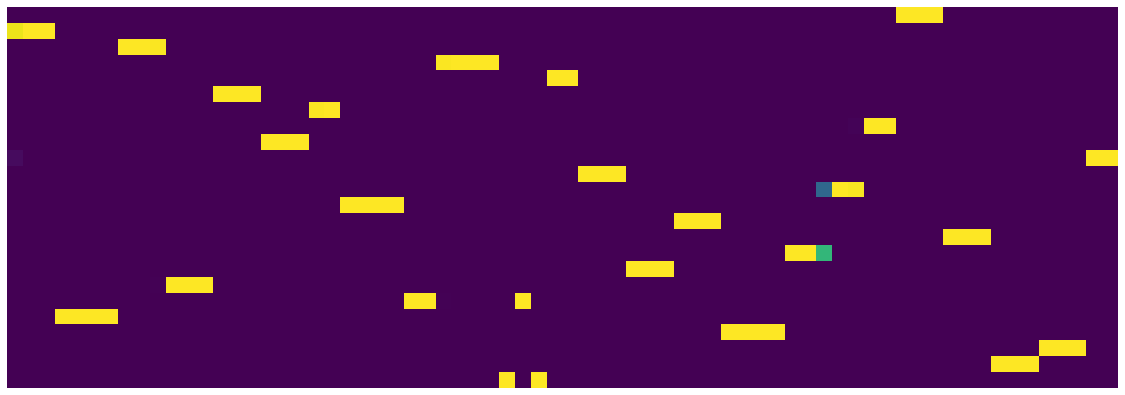

24 554 0.4449999999999995 0.4503877518698573


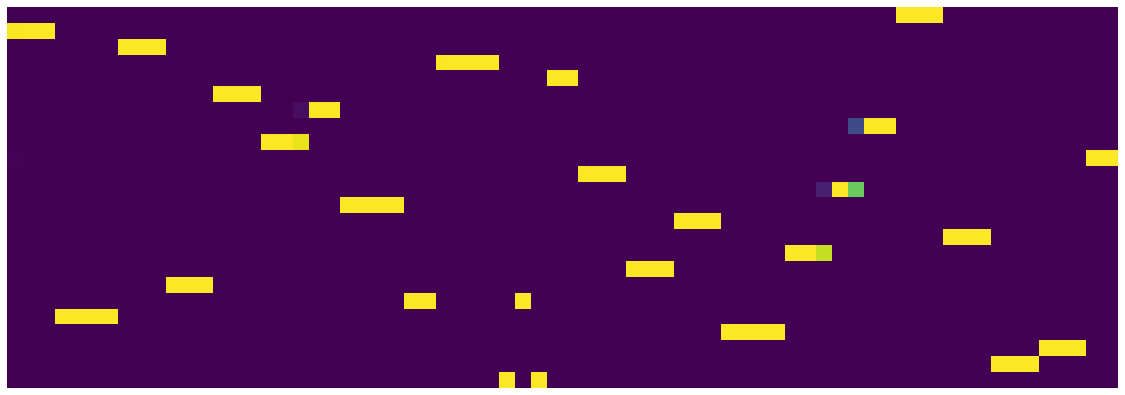

24 555 0.4439999999999995 0.4494962889701128


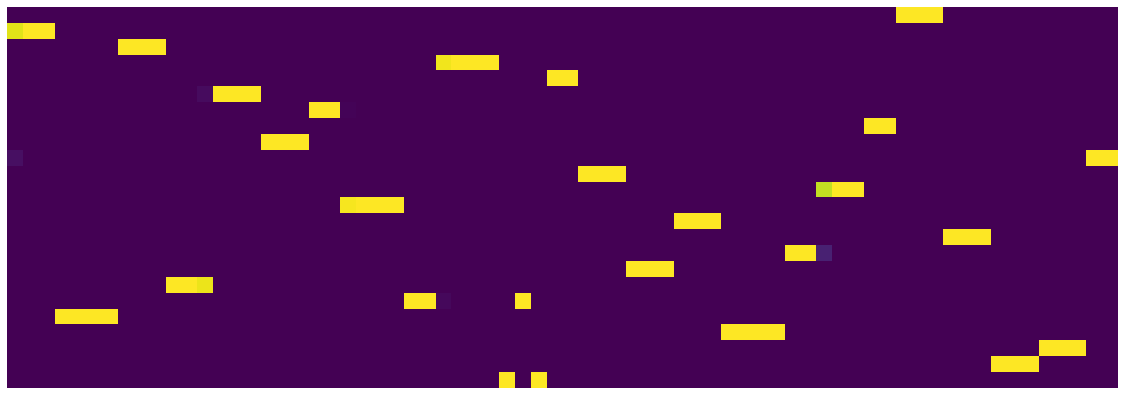

24 556 0.4429999999999995 0.45045762211084367


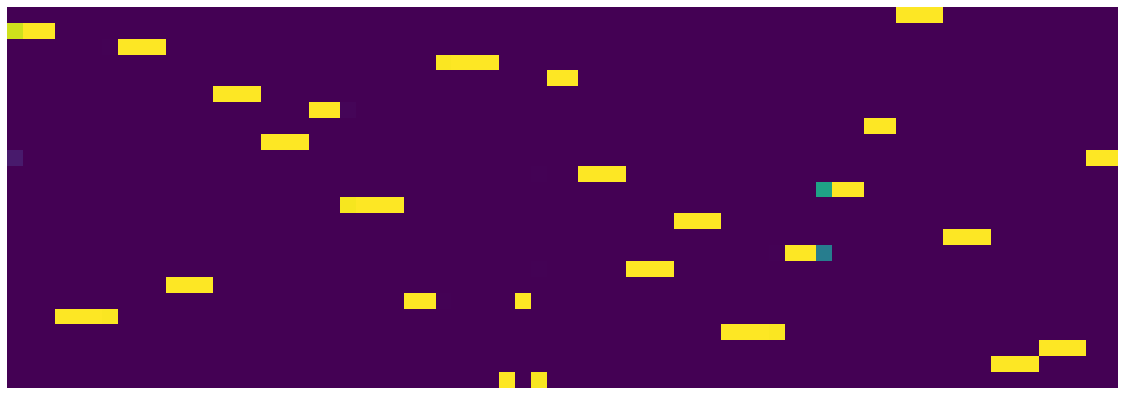

24 557 0.4419999999999995 0.44902434293180704


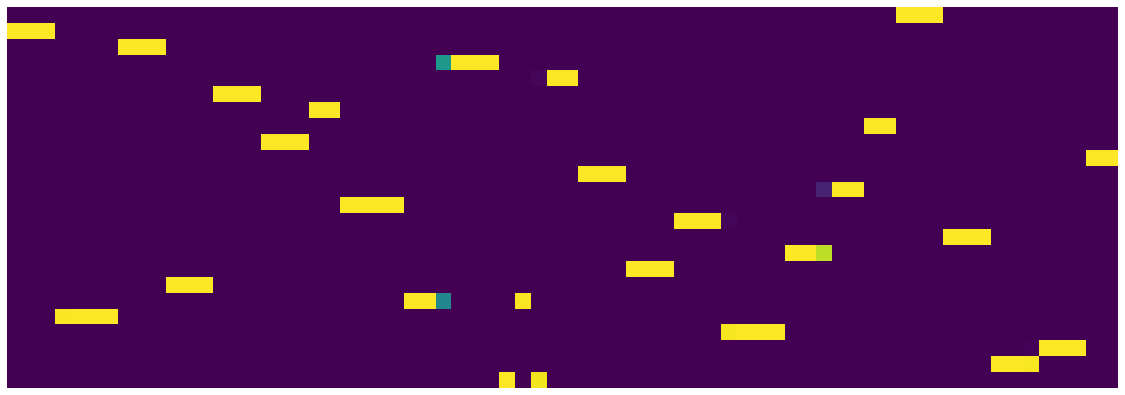

24 558 0.4409999999999995 0.4509124796837568


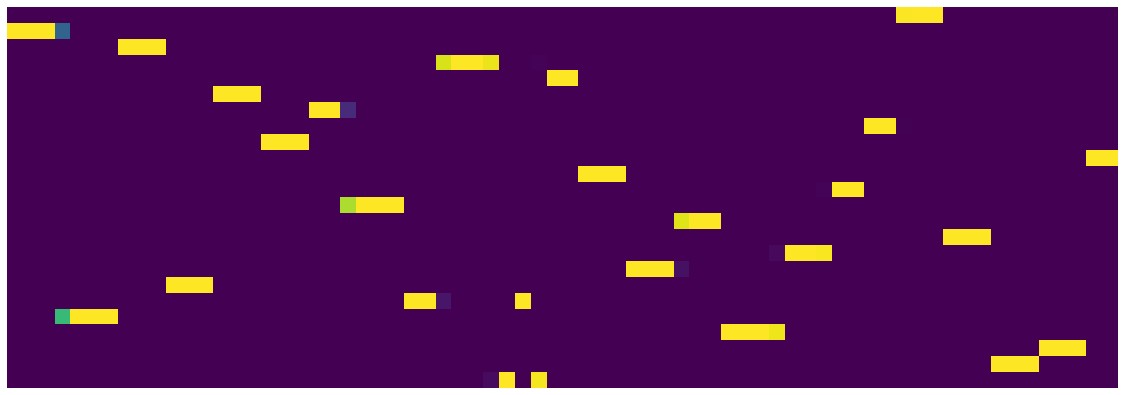

24 559 0.4399999999999995 0.44993124064058065


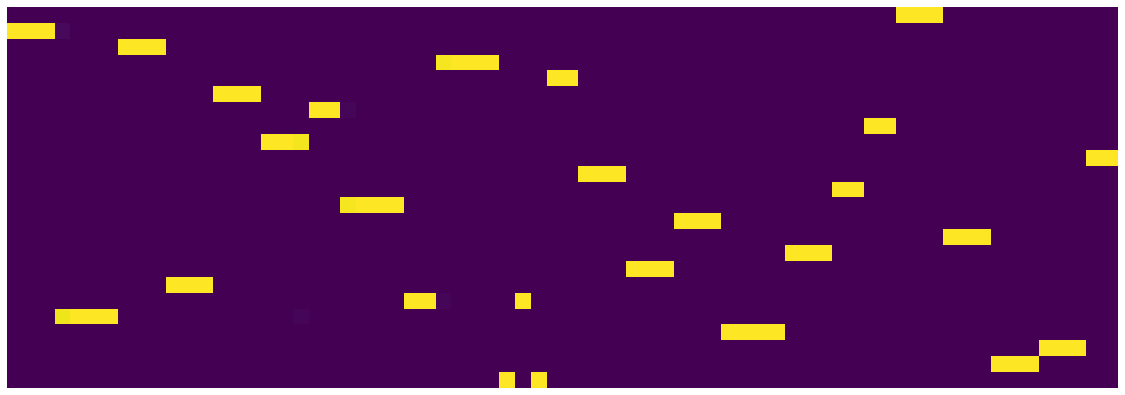

24 560 0.4389999999999995 0.4502985628321767


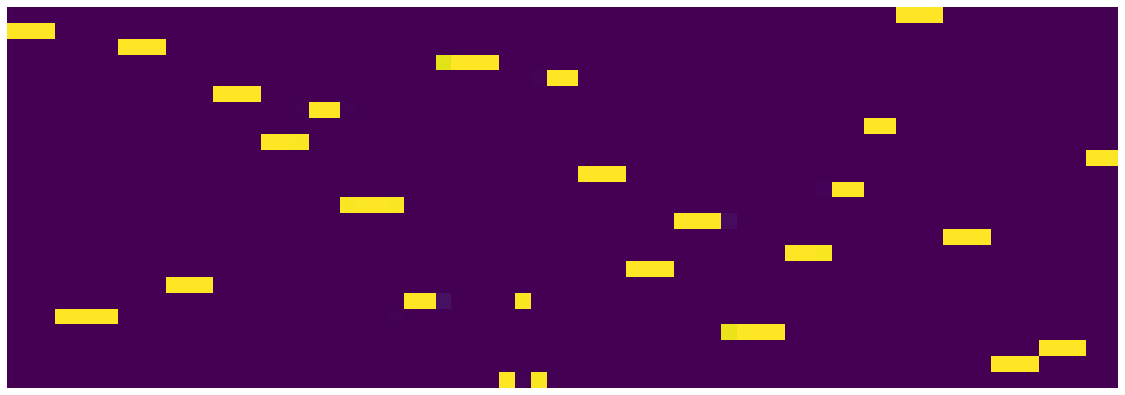

24 561 0.4379999999999995 0.4520941572263837


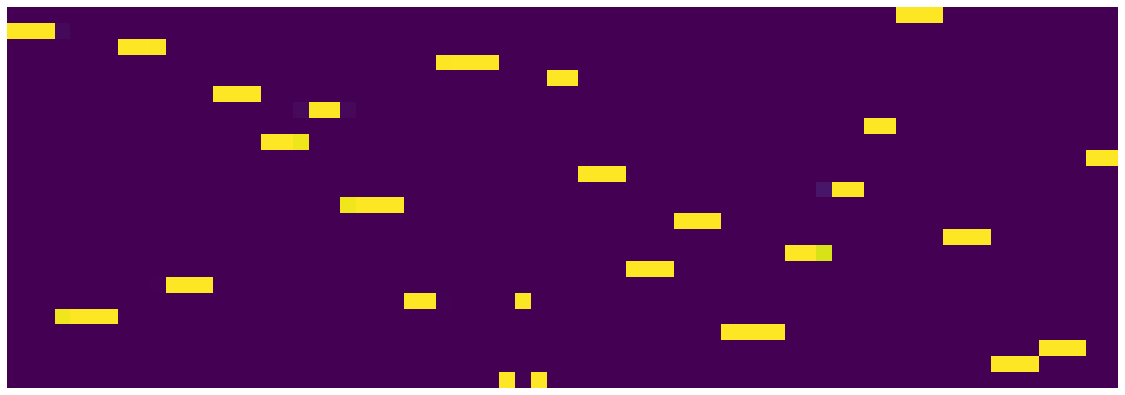

24 562 0.4369999999999995 0.45112799312919377


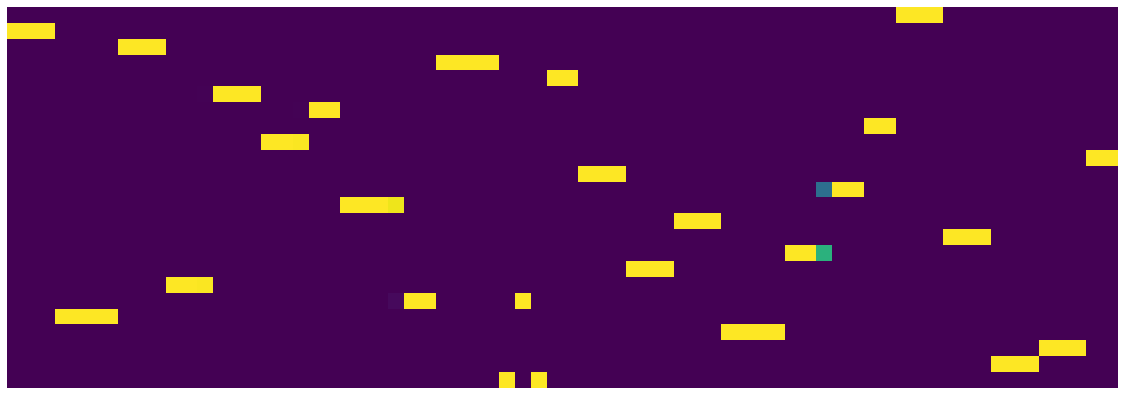

24 563 0.4359999999999995 0.44984060488641264


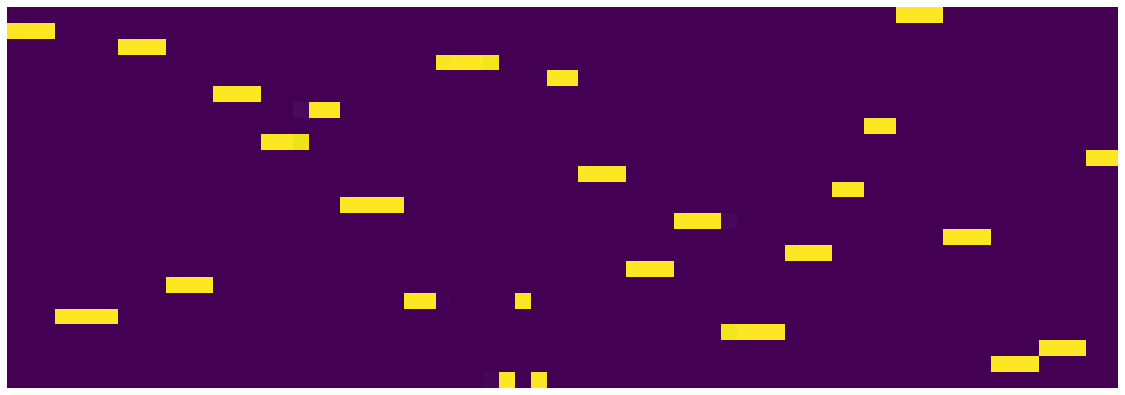

24 564 0.4349999999999995 0.4505345091223717


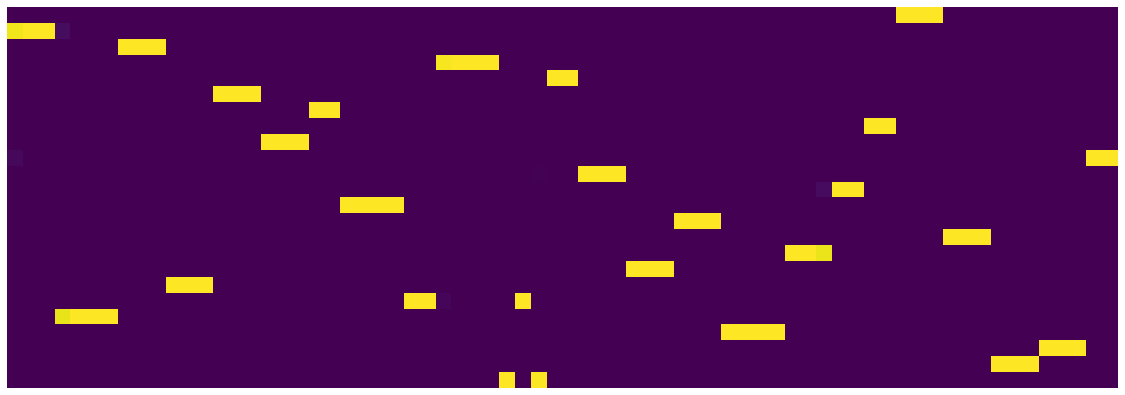

24 565 0.4339999999999995 0.4500258078798652


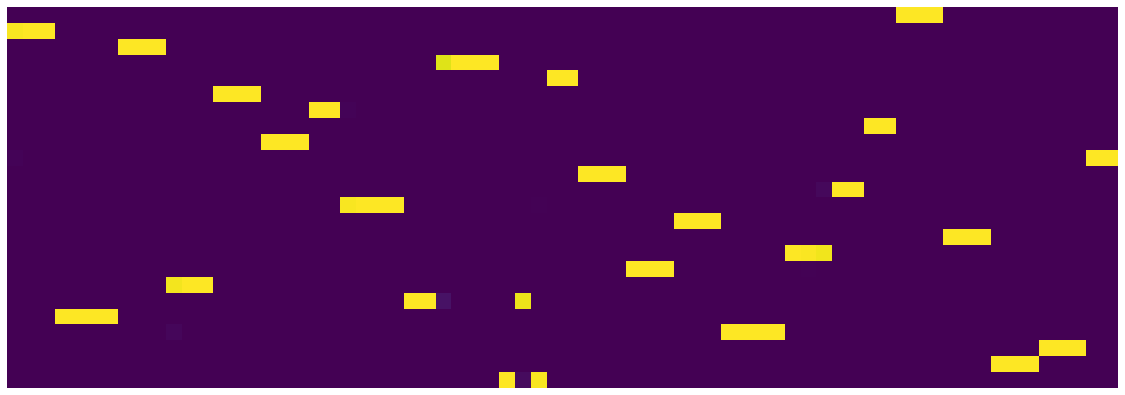

24 566 0.4329999999999995 0.45153220314532516


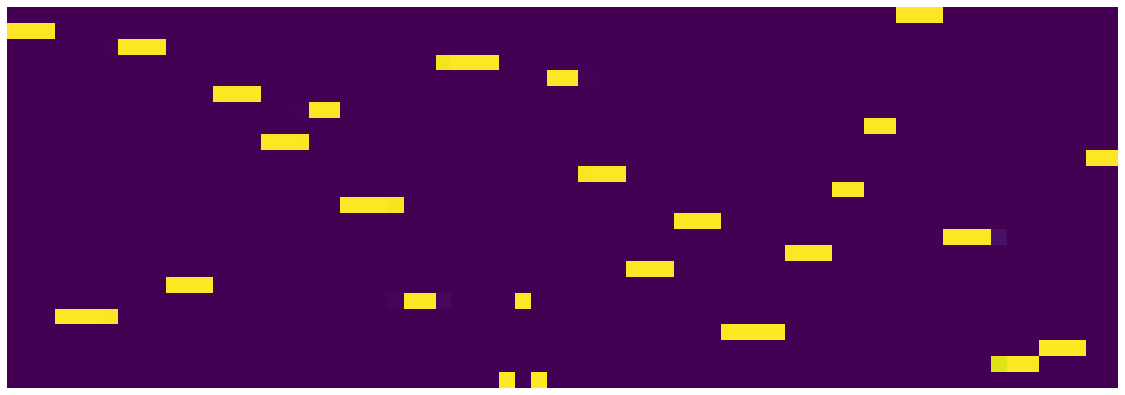

24 567 0.4319999999999995 0.45090562477707863


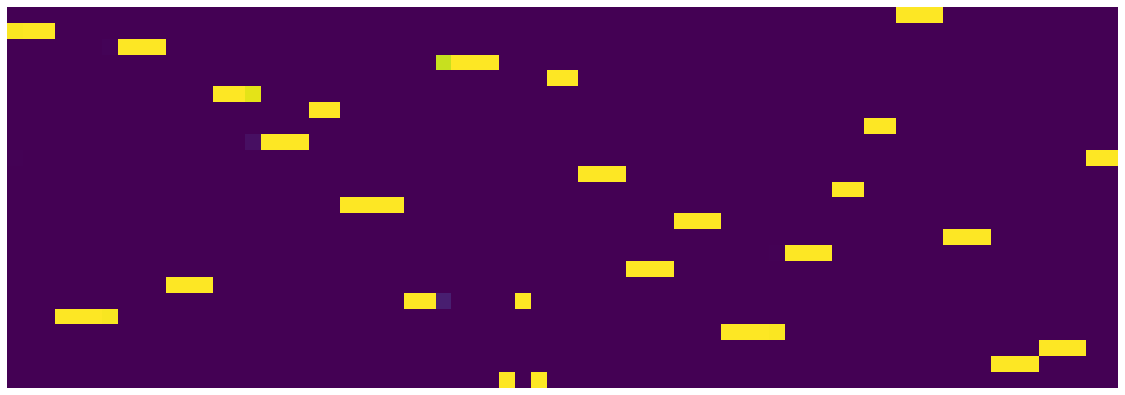

24 568 0.4309999999999995 0.45007863007485865


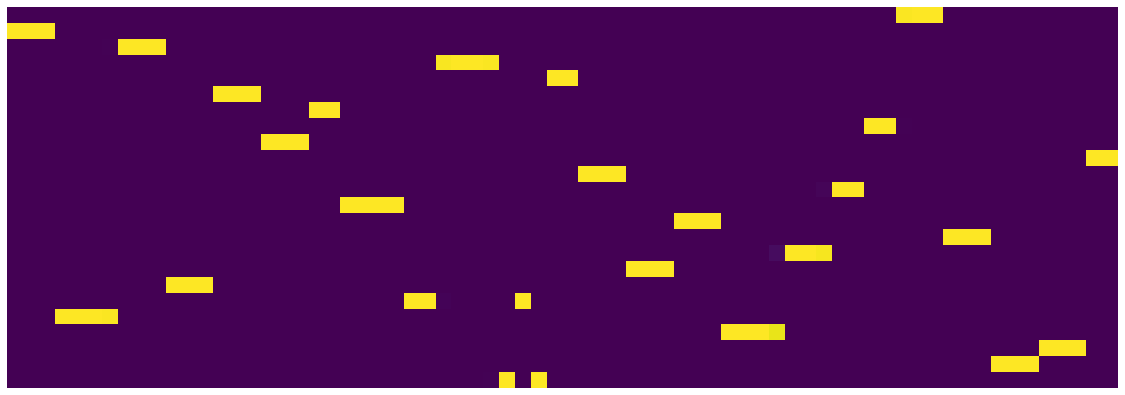

24 569 0.4299999999999995 0.449638943746686


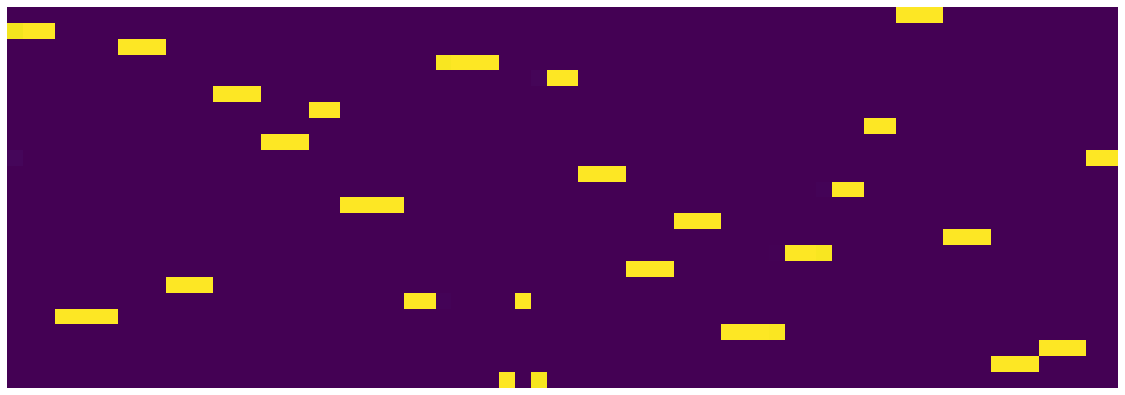

24 570 0.4289999999999995 0.450572250969708


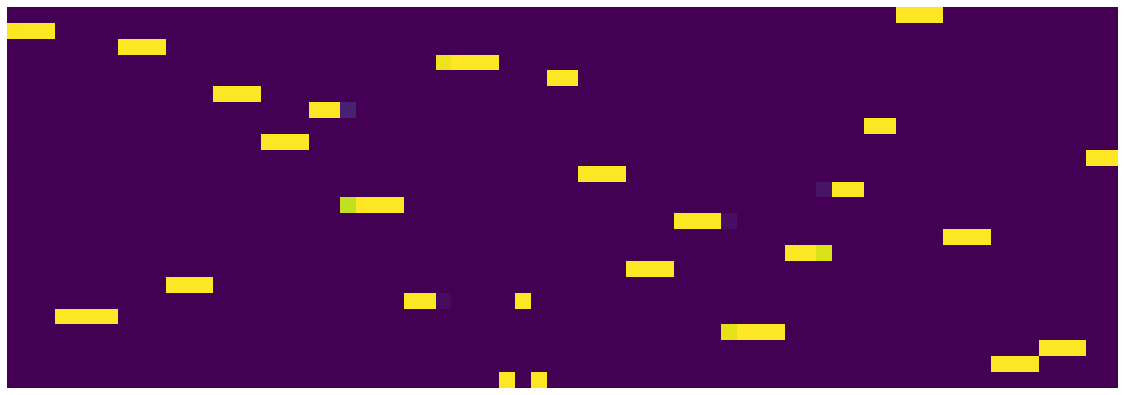

24 571 0.4279999999999995 0.4503236459568143


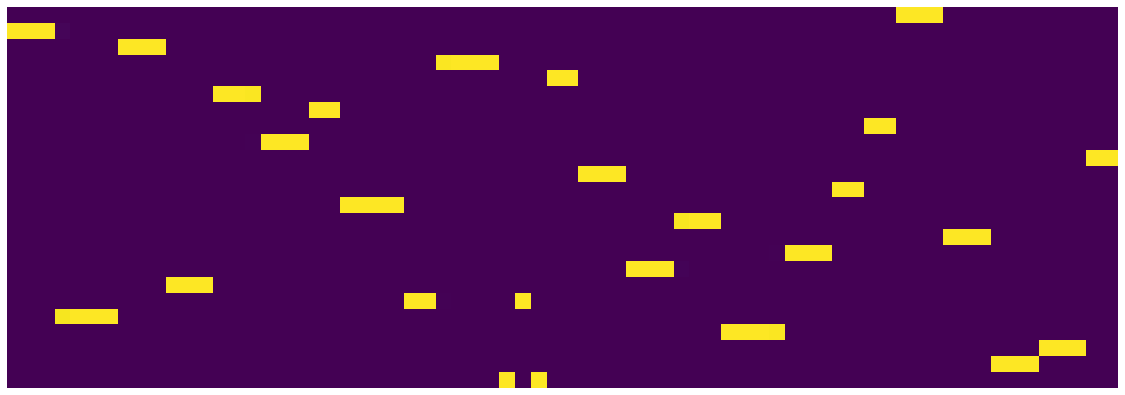

24 572 0.4269999999999995 0.4499960785731673


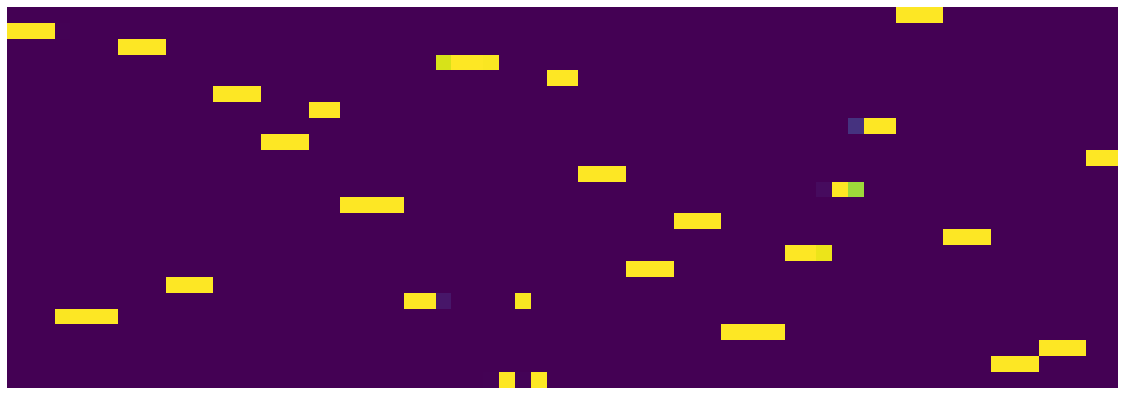

24 573 0.4259999999999995 0.45035761725157497


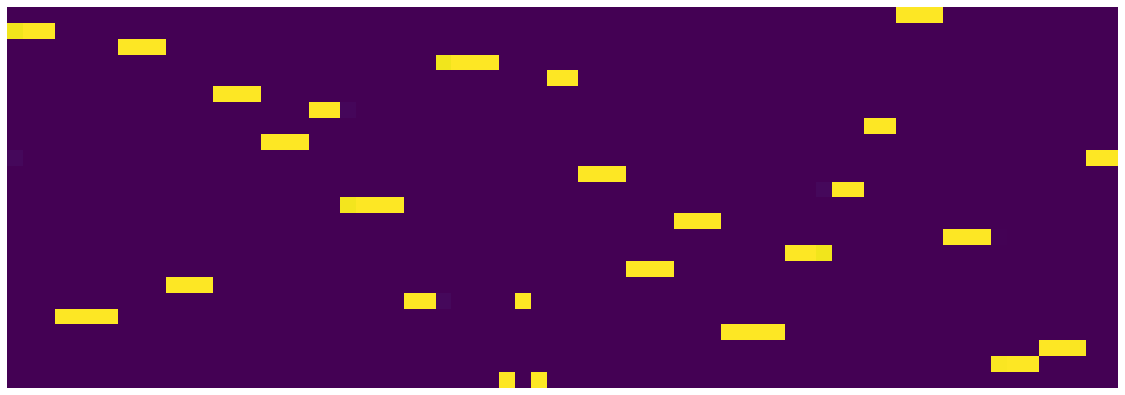

24 574 0.4249999999999995 0.4508482854813337


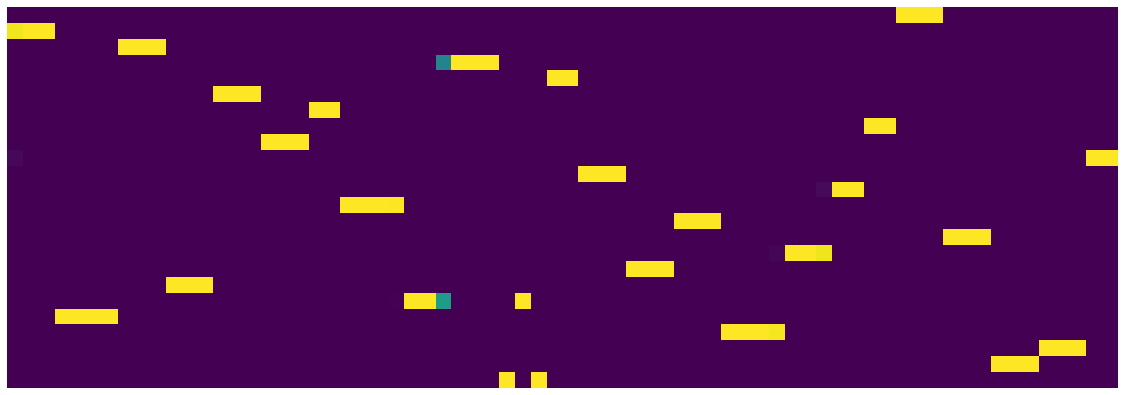

24 575 0.4239999999999995 0.44928331598639487


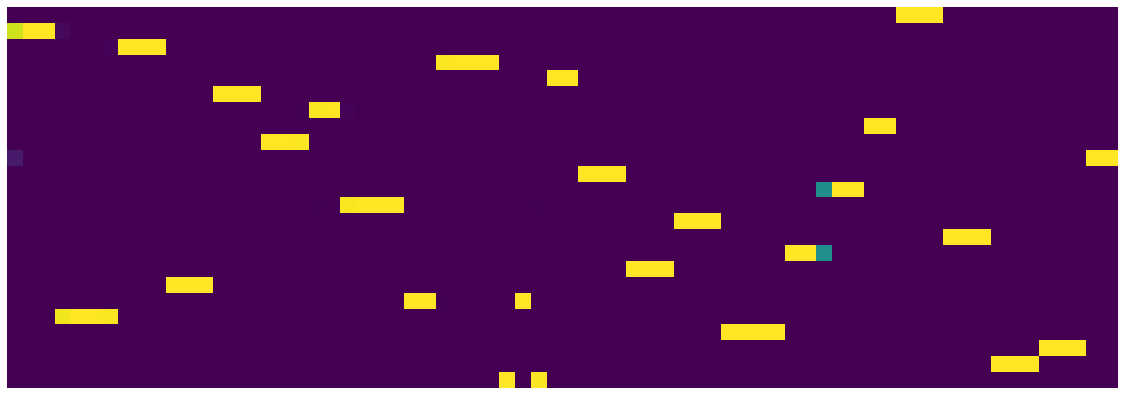

24 576 0.4229999999999995 0.45058656502515076


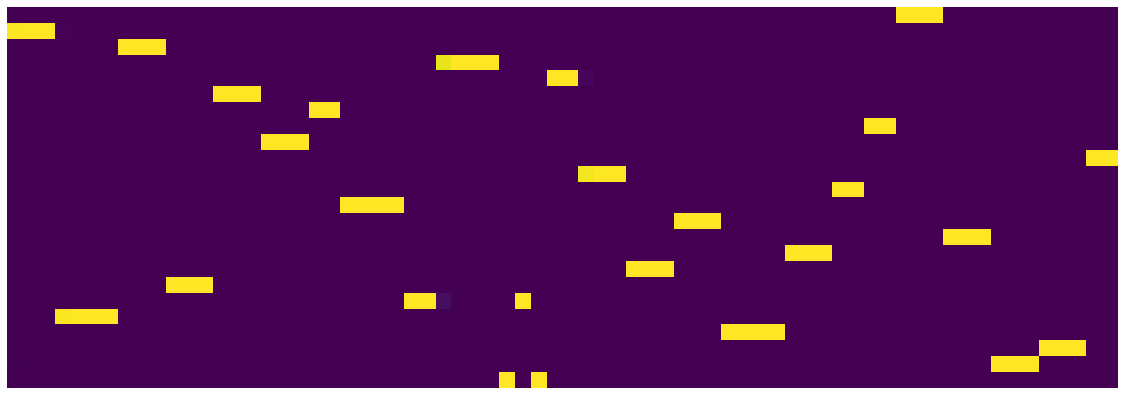

24 577 0.4219999999999995 0.4517668025568128


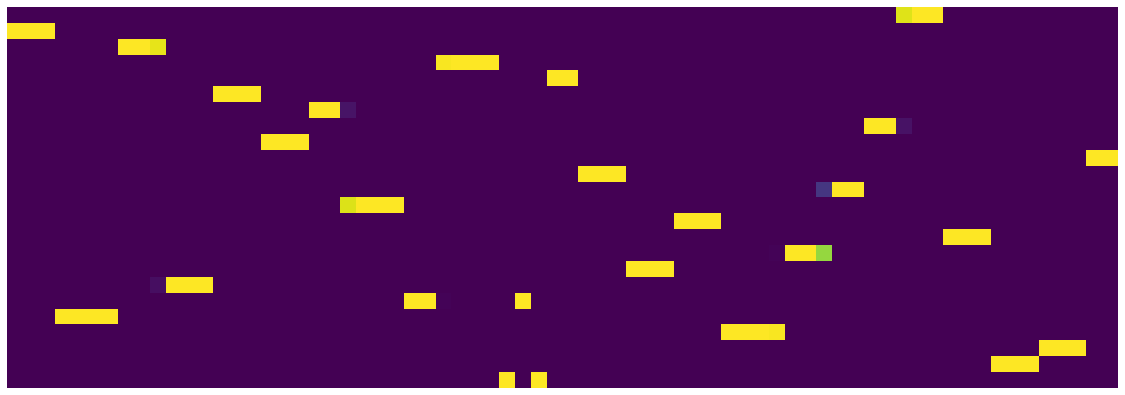

24 578 0.4209999999999995 0.4501337671652436


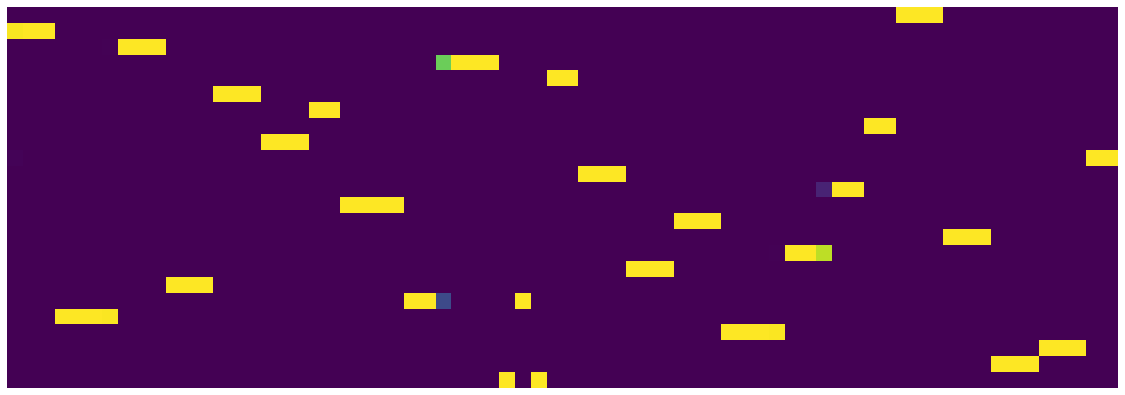

24 579 0.4199999999999995 0.44939241036772726


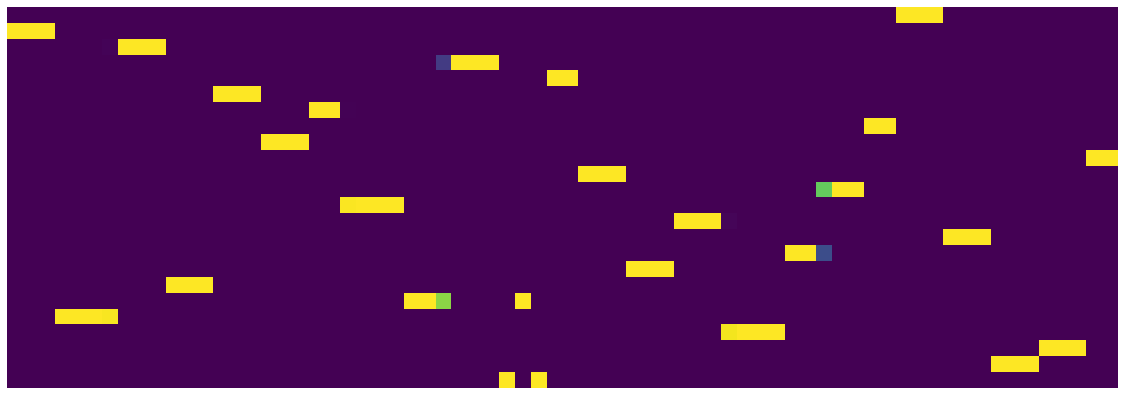

24 580 0.4189999999999995 0.4505108047276735


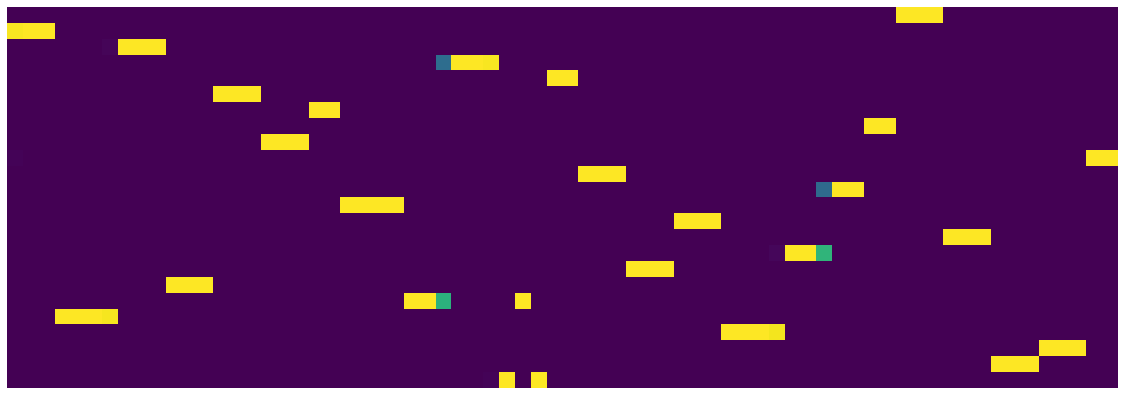

24 581 0.4179999999999995 0.4497628116980195


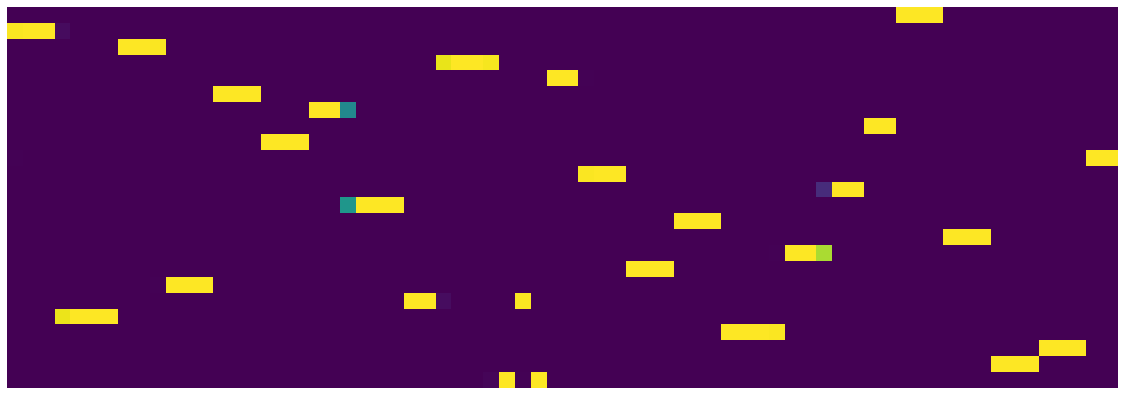

24 582 0.4169999999999995 0.45071309674531224


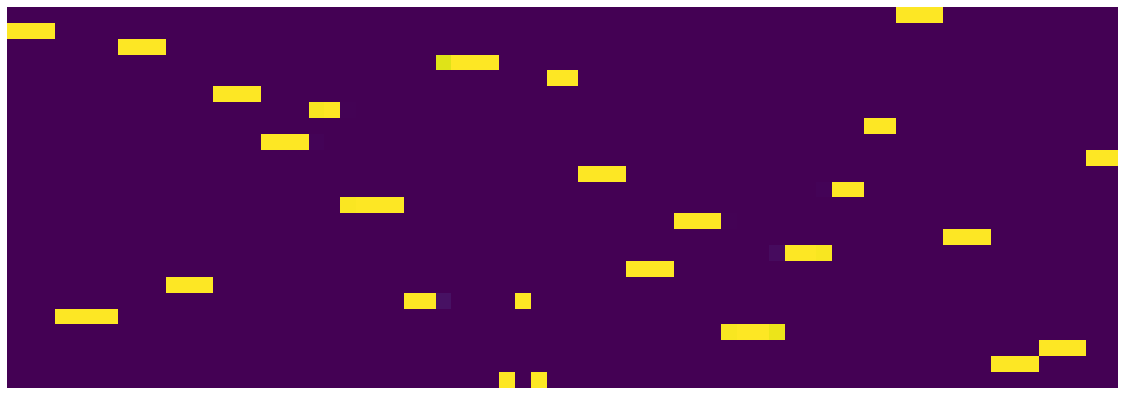

24 583 0.4159999999999995 0.44921387564390897


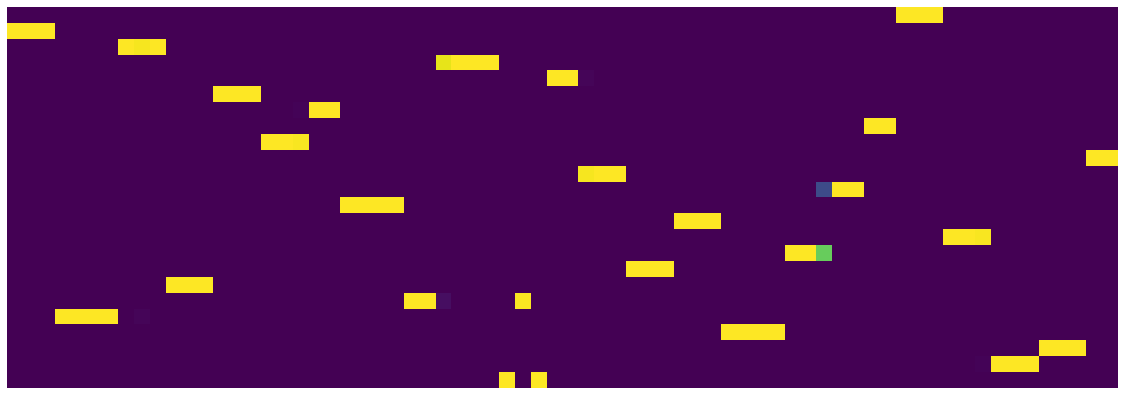

24 584 0.4149999999999995 0.45048260819166897


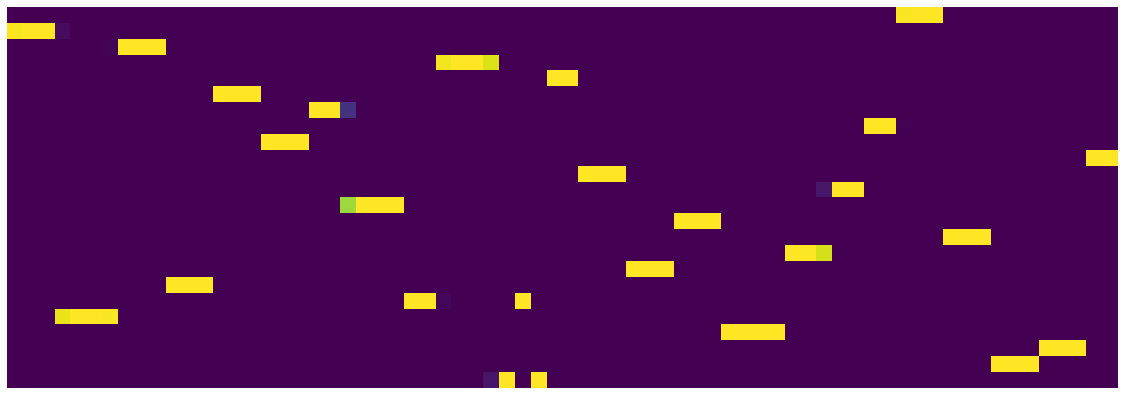

24 585 0.4139999999999995 0.449774875305593


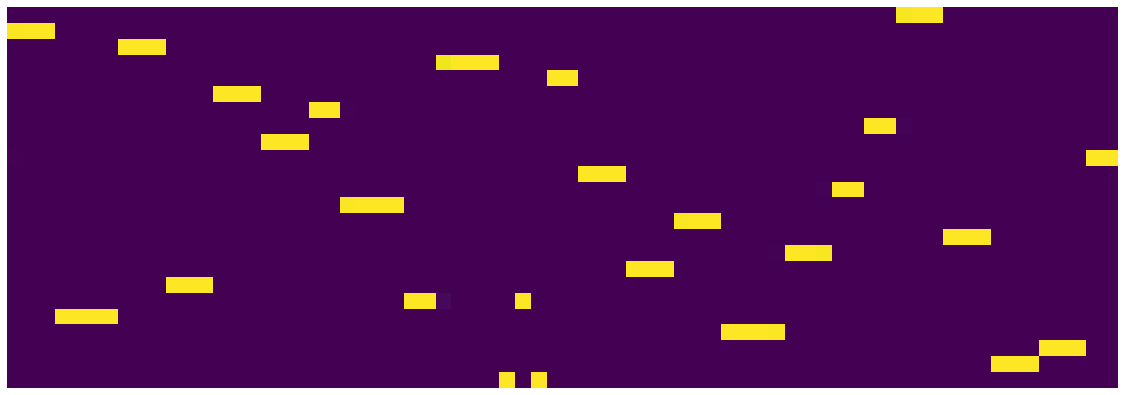

24 586 0.4129999999999995 0.450091021694243


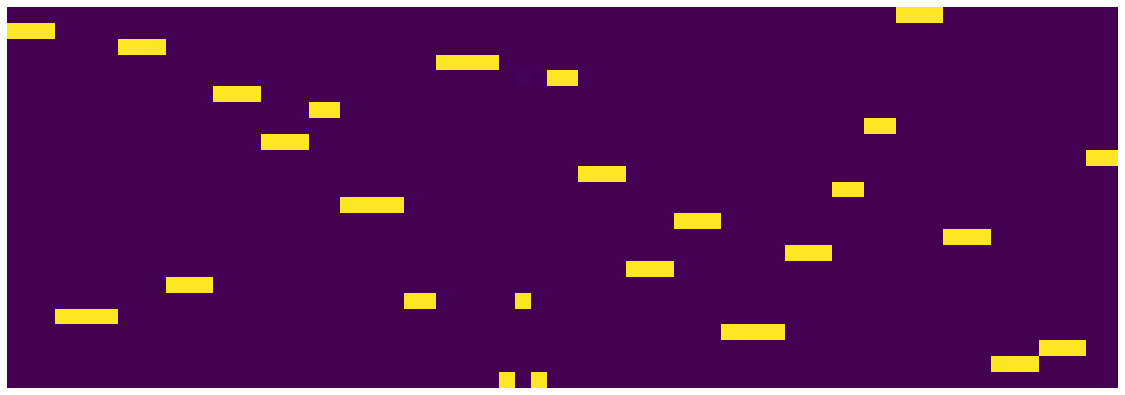

24 587 0.4119999999999995 0.4496354652568698


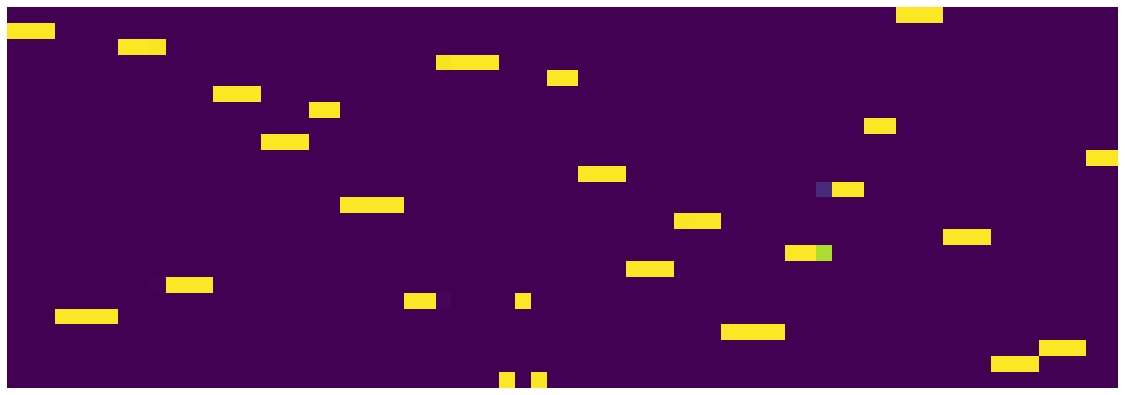

24 588 0.4109999999999995 0.45064491033554077


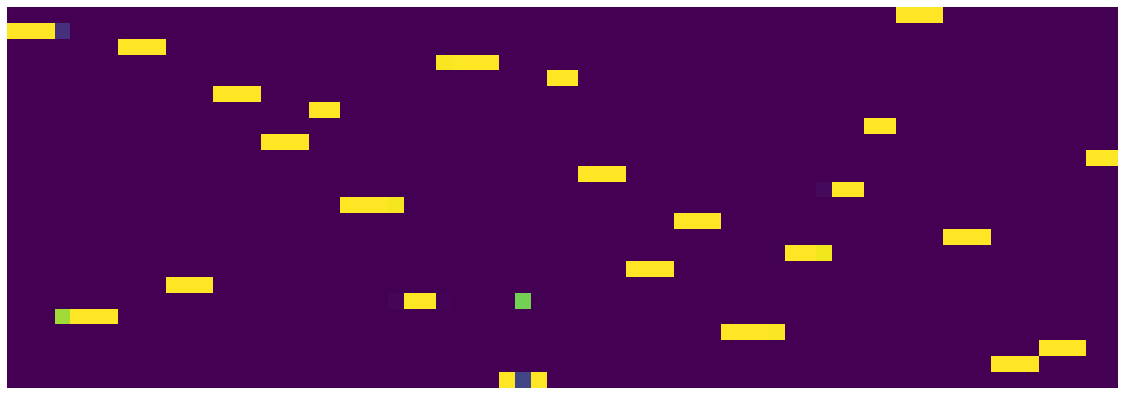

24 589 0.4099999999999995 0.4500438179820776


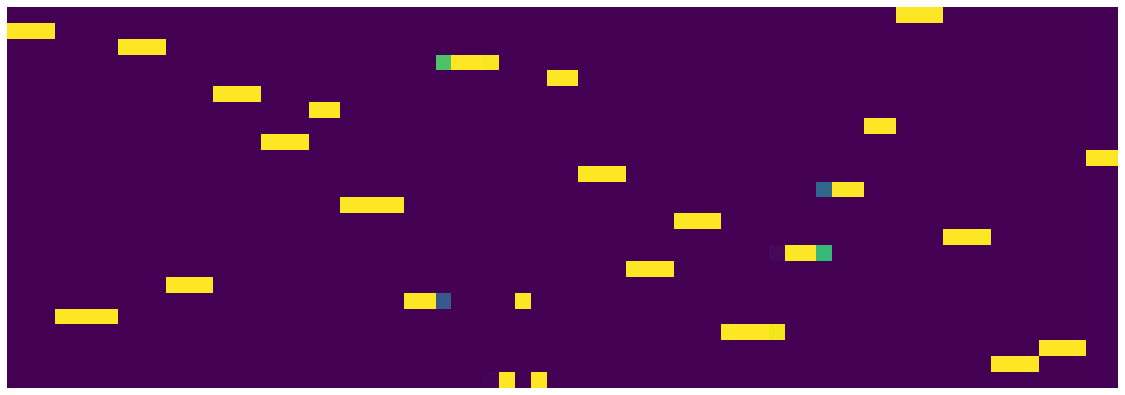

24 590 0.4089999999999995 0.45011790804564955


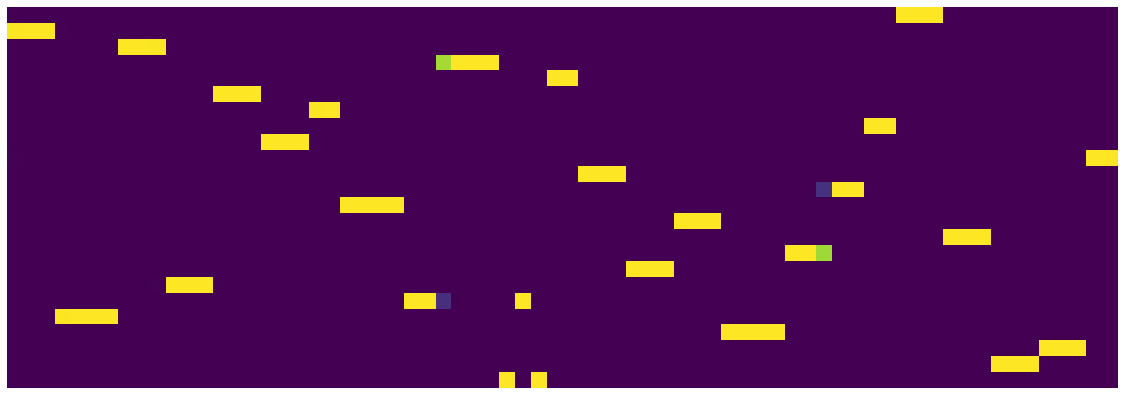

24 591 0.4079999999999995 0.4511783357709646


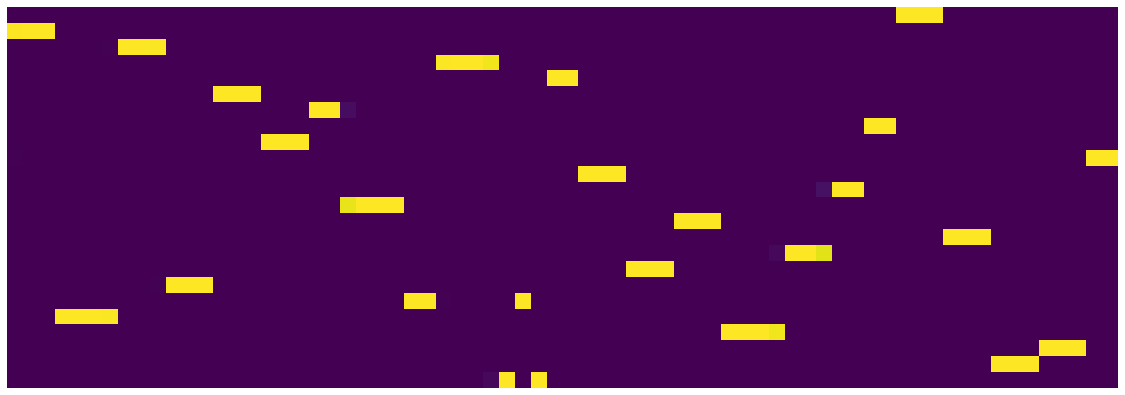

24 592 0.4069999999999995 0.4506202585995197


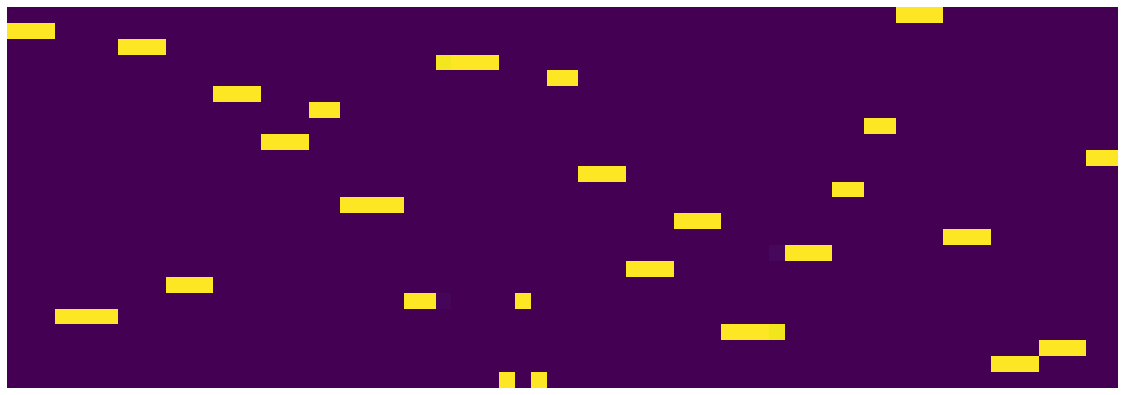

24 593 0.4059999999999995 0.4490695586428046


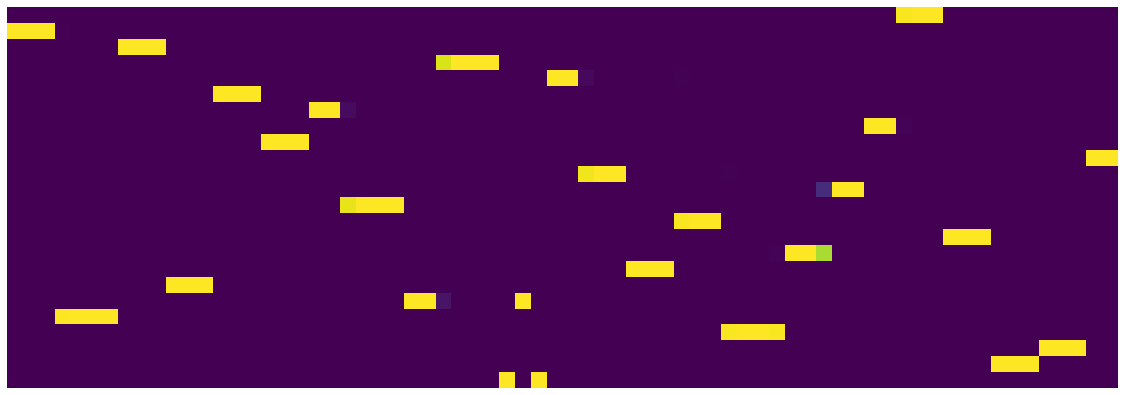

24 594 0.40499999999999947 0.4492960572242737


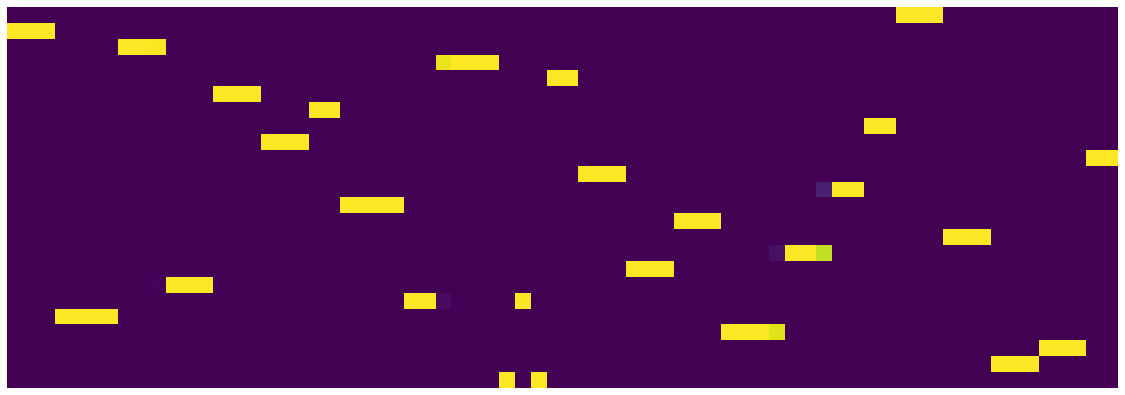

24 595 0.40399999999999947 0.4494946559891105


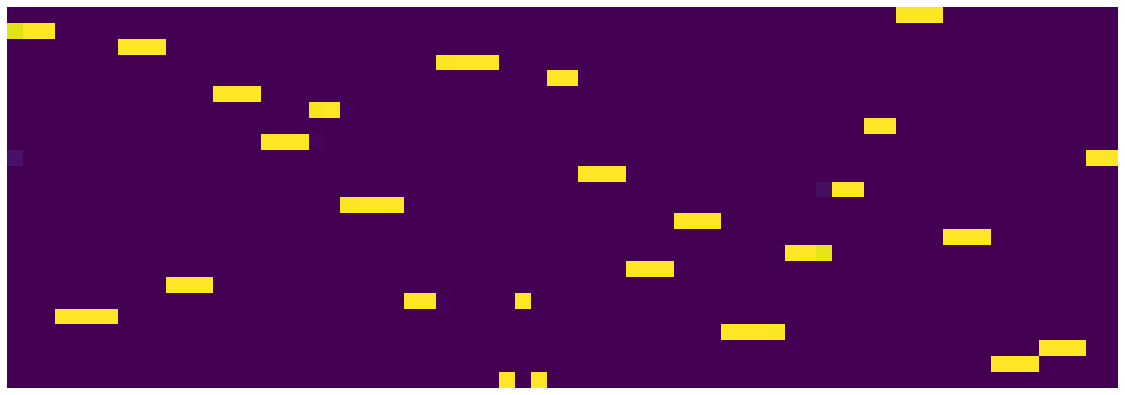

24 596 0.40299999999999947 0.4498569596558809


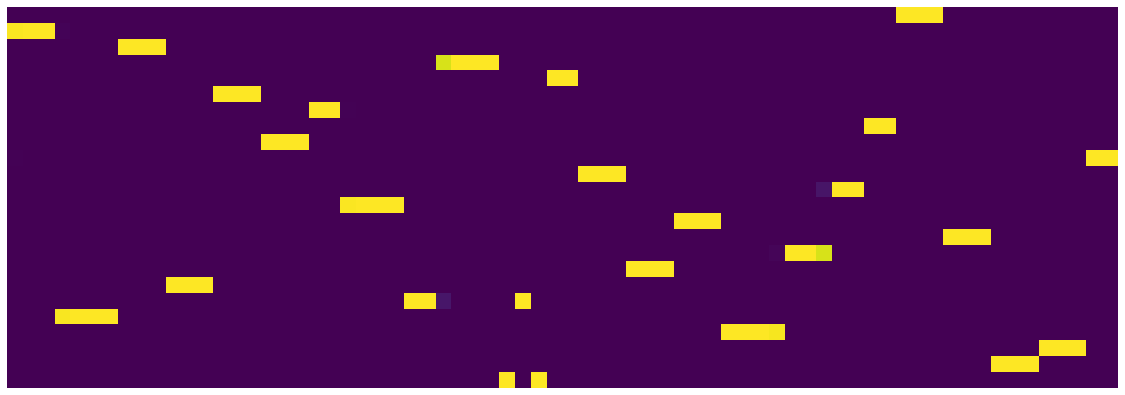

24 597 0.40199999999999947 0.45128805227577684


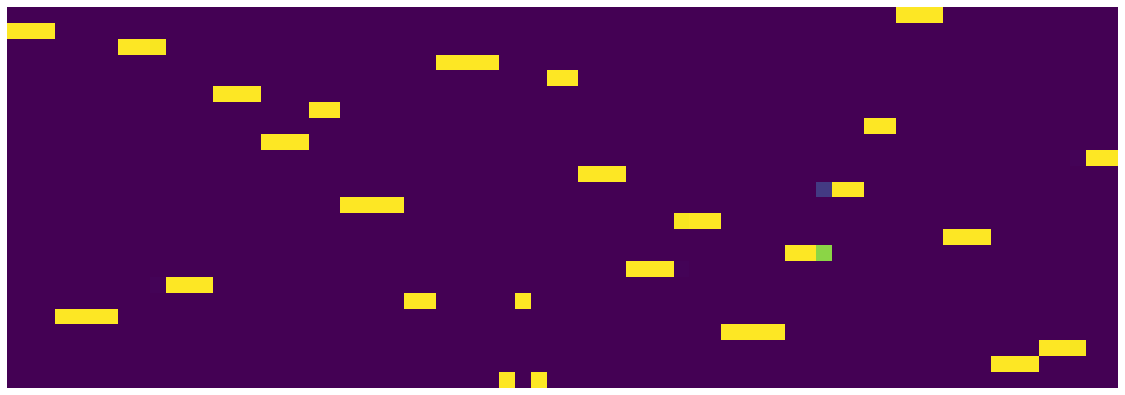

24 598 0.40099999999999947 0.44930506236851214


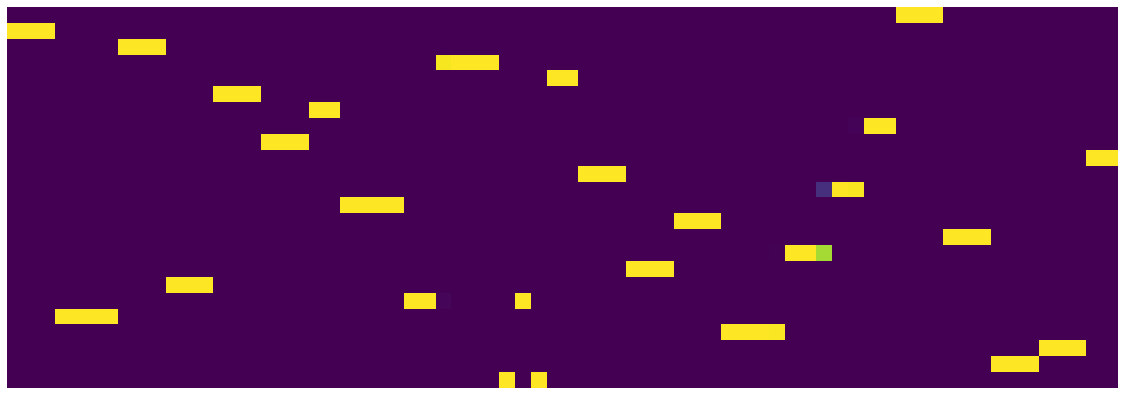

24 599 0.39999999999999947 0.4503414437174797


In [4]:
# Define the latent CG dimension, feel free to set your own, it only needs to be smaller than the number of total atoms 

device = "cuda" # device cardinal
#N_CG = [6, 12, 18, 24]  # play with this by yourself. 
#RHO = [1*10**(-5), 7*10**(-6), 1*10**(-6), 7*10**(-7)]
N_CG = [24]  # play with this by yourself. 
RHO = [1*10**(-7)]



for N_cg, rho in zip(N_CG, RHO):
    
    ae = cgae(train_xyz.shape[1], N_cg).to(device)
    optimizer = torch.optim.Adam(list(ae.parameters()), lr=4e-3)
    # training loop
    tau = 1.0

    loss_log = []
    loss_ae_log = []
    loss_fm_log = []
    mean_force_log =[]

    for epoch in range(600):

        loss_epoch = 0.0  
        loss_ae_epoch = 0.0
        loss_fm_epoch = 0.0
        mean_force_epoch = 0.0

        for i, xyz in enumerate(trainloader):

            # recenter xyz 
            xyz = xyz[0].to(device)

            # encode and decode coordinates 
            xyz, xyz_recon, M, M_norm, cg_xyz = ae(xyz, tau)
            
            
            #regularization instant forces
            f0 = torch.Tensor(train_f[i]).to(device)
            f  = torch.einsum('bij,in->bnj', f0, M_norm)
            mean_force = f.pow(2).sum(2).mean()

            # comput reconstruction 
            loss_ae =  (xyz - xyz_recon).pow(2).mean() 
            loss_fm = rho*mean_force


            # total loss 
            if epoch >= 300:
                loss = loss_ae + loss_fm
            else:
                loss = loss_ae

            
            #parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #losses update
            loss_epoch += loss.item()
            loss_ae_epoch += loss_ae.item()
            loss_fm_epoch += loss_fm.item()
            mean_force_epoch += mean_force.item()

        #losses normalization
        loss_epoch = loss_epoch/xyz.shape[0]
        loss_ae_epoch = loss_ae_epoch/xyz.shape[0]
        loss_fm_epoch = loss_fm_epoch/xyz.shape[0]

        loss_log.append(loss_epoch)
        loss_ae_log.append(loss_ae_epoch)
        loss_fm_log.append(loss_fm_epoch)
        mean_force_log.append(mean_force_epoch)

        # temperature scheduler for gubmel softmax     
        if tau >= 0.1:
            tau -= 0.001
        
            
        #torch.save(M, 'LANGEVIN/M/M_CG'+str(N_cg)+'_i.pt')
            
        plt.figure(figsize=(16,8))
        plt.imshow(M.t().detach().cpu().numpy())
        plt.tight_layout()
        plt.axis('off')
        #plt.xlabel('Indice Atomi', fontsize = 18)
        #plt.ylabel('Indice Siti CG', fontsize = 18)
        #plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        #plt.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)
        plt.savefig('NOSE_HOOVER_2/Images/M_CG'+str(N_cg)+'_'+str(epoch)+'.png')
        plt.show()
        
        print(N_cg ,epoch, tau, np.array(loss_epoch).mean())
        
    #save loss in txt
    #np.savetxt('LANGEVIN/Losses/loss_log_CG'+str(N_cg)+'.txt', loss_log)
    #np.savetxt('LANGEVIN/Losses/loss_ae_CG'+str(N_cg)+'.txt', loss_ae_log)
    #np.savetxt('LANGEVIN/Losses/loss_fm_CG'+str(N_cg)+'.txt', loss_fm_log)
    
    # visualize the learned CG assignment 
    #torch.save(M, 'LANGEVIN/M/M_CG'+str(N_cg)+'_f.pt')
    #torch.save(xyz_recon, 'LANGEVIN/xyz_recon/xyz_recon_CG'+str(N_cg)+'.pt')
    #torch.save(cg_xyz, 'LANGEVIN/xyz_CG/CG'+str(N_cg)+'_xyz.pt')
    
    #plt.figure(figsize=(18,20))
    #plt.imshow(M.t().detach().cpu().numpy())
    #plt.savefig('LANGEVIN/Images/M_CG'+str(N_cg)+'_f'+'.png')
    #plt.show()
    
    #save model
    #torch.save(ae, 'LANGEVIN/Models/ae_CG'+str(N_cg)+'.pth')
    
    

In [18]:
#Loss data import
loss_ae_CG6  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_ae_CG6.txt')
loss_ae_CG12  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_ae_CG12.txt')
loss_ae_CG18  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_ae_CG18.txt')
loss_ae_CG24  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_ae_CG24.txt')

loss_fm_CG6  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_fm_CG6.txt')
loss_fm_CG12  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_fm_CG12.txt')
loss_fm_CG18  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_fm_CG18.txt')
loss_fm_CG24  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_fm_CG24.txt')

loss_log_CG6  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_log_CG6.txt')
loss_log_CG12  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_log_CG12.txt')
loss_log_CG18  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_log_CG18.txt')
loss_log_CG24  = np.loadtxt('NOSE_HOOVER_2/Losses/loss_log_CG24.txt')

In [19]:
loss_ae_CG = np.array([loss_ae_CG6[-1], loss_ae_CG12[-1], loss_ae_CG18[-1], loss_ae_CG24[-1],])
loss_fm_CG = np.array([loss_fm_CG6[-1], loss_fm_CG12[-1], loss_fm_CG18[-1], loss_fm_CG24[-1],])
loss_log_CG = np.array([loss_log_CG6[-1], loss_log_CG12[-1], loss_log_CG18[-1], loss_log_CG24[-1],])

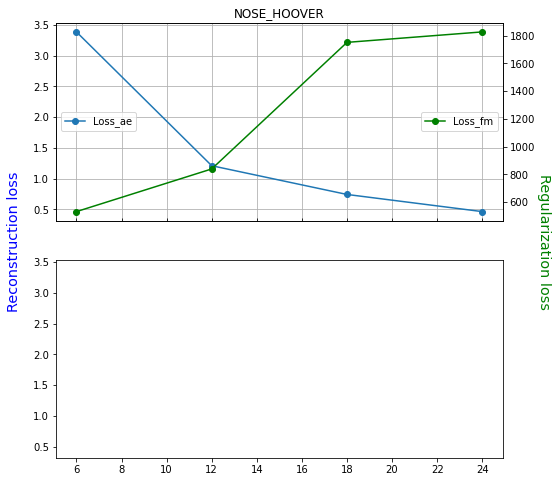

In [20]:
#plot losses
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(8,8))
fig.text(0.04, 0.5, 'Reconstruction loss', va='center', rotation= 90, fontsize='x-large', color = 'blue')
fig.text(0.96, 0.5, 'Regularization loss', va='center', rotation=-90, fontsize='x-large', color = 'green')

axes[0].set_title('NOSE_HOOVER')
axes[0].plot(N_CG, loss_ae_CG, 'o-', label = 'Loss_ae')
#ax1.set_ylabel('Reconstruction loss')
axes[0].set_xticks(ticks=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])
axes[0].tick_params(axis='x', direction='in')
axes[0].grid()
axes[0].legend(loc='center left')

axes0 = axes[0].twinx()
axes0.plot(N_CG, loss_fm_CG/RHO, 'o-', label = 'Loss_fm', color = 'green')
#ax1.set_ylabel('Reconstruction loss')
#axes0.set_xticks(ticks=[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26])
axes0.tick_params(axis='x', direction='in')
#axes0.grid()
axes0.legend(loc='center right')
plt.show()

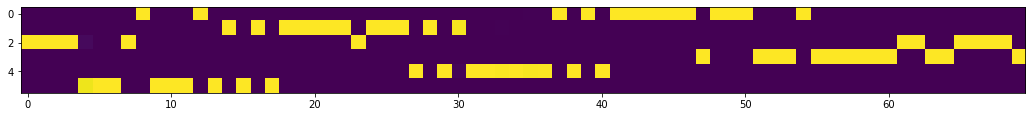

In [15]:
A = torch.load('M/M_CG6_f.pt')
plt.figure(figsize=(18,20))
plt.imshow(A.t().detach().cpu().numpy())

In [21]:
N_70 = torch.tensor(data)
N_70_original = N_70[0].detach().cpu().numpy()
polymer_ring = Atoms(positions= N_70_original, numbers=[2]*70)
show_ase(polymer_ring)

NGLWidget()

In [6]:
N_70_original.shape

(70, 3)

In [88]:
#saves the moleculs visualization
polymer_ring.write('provaR2.png',  rotation='10z,10x,10y')

In [13]:
N_70_recon = torch.load('NOSE_HOOVER_2/xyz_recon/xyz_recon_CG24.pt')
N_70_recon_d = N_70_recon[0].detach().cpu().numpy()
polymer_ring = Atoms(positions= N_70_recon_d, numbers=[2]*70)
show_ase(polymer_ring)

NGLWidget()

In [11]:
N_70_CG = torch.load('NOSE_HOOVER_2/xyz_CG/CG24_xyz.pt')
cg_nums = [2] * 24
cg_polymer_ring = Atoms(positions= N_70_CG[0].detach().cpu().numpy(), numbers=cg_nums)
show_ase(cg_polymer_ring)

NGLWidget()

In [53]:
N_70_CG.shape

torch.Size([40, 6, 3])